## Install

``` shell
conda create python=2.7 h5py jupyter -p ~/space/envs/peaknet
conda install pytorch=0.1.12 torchvision cuda80 -c pytorch
conda install tensorboardX
conda install psana-conda=1.4.2 -c lcls-rhel
```


### Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import psana
import torch
# import torchvision
import numpy as np
import time
from peaknet import Peaknet
from peaknet_utils import *

ModuleNotFoundError: No module named 'psana'

### Load data from psana

In [86]:
exp_name = "cxic0415"
# run = 90
# event_idx = 3963
run = 91
event_idx = 4633
# run = 95
# event_idx = 13012 # 12159, 13012

ds = psana.DataSource("exp=" + exp_name + ":run=" + str(run) + ":idx")
det = psana.Detector('DscCsPad')
this_run = ds.runs().next()
times = this_run.times()
num_events = len(times)
print("run", run, "number of events available", num_events)
env = ds.env()

evt = this_run.event(times[event_idx])
calib = det.calib(evt) * det.mask(evt, calib=True, status=True,
                          edges=True, central=True,
                          unbond=True, unbondnbrs=True)
print("calib", calib.shape)

('run', 95, 'number of events available', 47891)
('calib', (32, 185, 388))


### Init. network

## Train

### Dataset

In [87]:
# filename = "/reg/neh/home/liponan/data/cxic0415/r0095/cxic0415_0095.cxi"
filename = "/reg/neh/home/liponan/data/cxic0415/r0091/cxic0415_0091_streak.cxi"
t0 = time.time()
labels, eventIdxs = load_cxi_labels( filename, total_size=-1 )
t1 = time.time()
print("took " + str(t1-t0) + " s to build the datasets")
print("labels", len(labels), len(labels[0]))

hits: 4239
took 1.75606989861 s to build the datasets
('labels', 4239, 6)


### Data loader

In [88]:
imgs = psana_img_loader(eventIdxs, 0, 5, det, this_run, times)
print("imgs shape", imgs.shape)

('imgs shape', (5, 32, 185, 388))


### Confg

In [89]:
project_name = "runs/cxic0415_95/2cls_test"
n_ep = 1
init_lr = 0.001
lr_policy = 10
macro_batch_size = 1
algo = "adagrad"

params = {"n_ep":n_ep, "lr": init_lr, "batch_size":macro_batch_size, "lr_policy": lr_policy, 
          "train_size": len(labels), "optim": algo}

net = Peaknet()
net.loadCfg( "/reg/neh/home/liponan/ai/pytorch-yolo2/cfg/newpeaksv10-asic-2cls.cfg" )
# net.loadWeights( "../pytorch-yolo2/cfg/newpeaksv10-asic.cfg", 
#                 "../darknet/backup/newpeaksv10_500.weights")
net.init_model()
net.model.cuda()

Darknet (
  (models): ModuleList (
    (0): Sequential (
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (leaky1): LeakyReLU (0.1, inplace)
    )
    (1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (2): Sequential (
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (leaky2): LeakyReLU (0.1, inplace)
    )
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Sequential (
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (leaky3): LeakyReLU (0.1, inplace)
    )
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Sequential (
      (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(

In [90]:
n_iters = int( np.ceil( len(labels) / float(macro_batch_size) ) )
net.set_writer(project_name=project_name, parameters=params)
my_lr = init_lr

for ep in range(1, n_ep+1):
    print("============= EPOCH {} ==========".format(ep))
    if ep % lr_policy == 0:
        my_lr /= 2
        print("learning rate is now", my_lr)
    
    for i in range(n_iters):
        idx_offset = i * macro_batch_size
        if i == (n_iters-1):
            n = len(labels) - i*macro_batch_size
            batch_imgs = psana_img_loader(eventIdxs, idx_offset, n, det, this_run, times)
            batch_labels = labels[(i*macro_batch_size):]
        else:
            batch_imgs = psana_img_loader(eventIdxs, idx_offset, macro_batch_size, det, this_run, times)
            batch_labels = labels[i*macro_batch_size:(i+1)*macro_batch_size]
        net.set_optimizer(adagrad=(algo=="adagrad"), lr=my_lr )
        net.train( batch_imgs, batch_labels, batch_size=32 )
        
        net.optimize()

============= EPOCH 1 ==========
32: nGT 27, recall 1, proposals 112, loss: x 1.444536, y 1.382154, w 0.181001, h 0.802603, conf 4260.506348, cls 13.056301, total 4277.373047
64: nGT 409, recall 50, proposals 196, loss: x 19.199003, y 18.286530, w 20.171593, h 9.561082, conf 4491.803711, cls 232.645325, total 4791.666992
96: nGT 26, recall 3, proposals 107, loss: x 1.705176, y 1.108488, w 0.380132, h 3.640442, conf 4316.690430, cls 11.053070, total 4334.578125
128: nGT 14, recall 1, proposals 120, loss: x 0.556580, y 0.686888, w 0.108683, h 0.284069, conf 4168.162109, cls 7.705456, total 4177.504395
160: nGT 23, recall 0, proposals 124, loss: x 0.956947, y 1.321368, w 0.225611, h 0.485620, conf 4251.925293, cls 11.443710, total 4266.358887
192: nGT 88, recall 5, proposals 204, loss: x 3.851495, y 4.636585, w 2.999806, h 4.165205, conf 4381.805664, cls 41.992779, total 4439.451660
224: nGT 60, recall 2, proposals 132, loss: x 3.642011, y 2.306325, w 0.606319, h 1.446213, conf 4318.44970

1888: nGT 102, recall 12, proposals 241, loss: x 4.800310, y 4.799455, w 1.607177, h 2.320047, conf 2216.157471, cls 33.945499, total 2263.630127
1920: nGT 189, recall 12, proposals 215, loss: x 9.495764, y 10.785133, w 2.564729, h 4.052585, conf 2202.969238, cls 61.820118, total 2291.687500
1952: nGT 21, recall 2, proposals 232, loss: x 1.071958, y 1.431021, w 0.942941, h 0.612978, conf 2212.282715, cls 6.668087, total 2223.009521
1984: nGT 91, recall 5, proposals 224, loss: x 3.830886, y 5.235203, w 1.219092, h 2.040059, conf 2175.726562, cls 31.326469, total 2219.378174
2016: nGT 109, recall 5, proposals 225, loss: x 4.605045, y 4.923908, w 1.543650, h 2.369904, conf 2232.640869, cls 34.553856, total 2280.637451
2048: nGT 12, recall 0, proposals 247, loss: x 0.828170, y 0.426158, w 0.172302, h 0.271516, conf 2235.130127, cls 3.326624, total 2240.155029
2080: nGT 282, recall 32, proposals 188, loss: x 12.179708, y 12.571711, w 2.628417, h 4.885788, conf 2165.345459, cls 99.501595, to

3776: nGT 15, recall 1, proposals 182, loss: x 0.983023, y 0.662533, w 0.055665, h 0.156979, conf 1837.992188, cls 4.573251, total 1844.423584
3808: nGT 13, recall 0, proposals 49, loss: x 0.536698, y 0.886335, w 0.243860, h 0.189795, conf 1604.471069, cls 4.039521, total 1610.367310
3840: nGT 23, recall 4, proposals 12, loss: x 0.630991, y 1.006325, w 0.065375, h 0.258221, conf 1570.806885, cls 7.154467, total 1579.922241
3872: nGT 38, recall 7, proposals 95, loss: x 1.571326, y 1.333675, w 0.203753, h 0.466524, conf 1607.183228, cls 12.257722, total 1623.016235
3904: nGT 22, recall 3, proposals 214, loss: x 0.964249, y 1.571807, w 0.557382, h 0.460871, conf 1621.552856, cls 5.630881, total 1630.737915
3936: nGT 15, recall 2, proposals 59, loss: x 0.553984, y 0.892741, w 0.086836, h 0.234524, conf 1651.125610, cls 4.194169, total 1657.087891
3968: nGT 14, recall 1, proposals 109, loss: x 0.829546, y 0.783762, w 0.072923, h 0.213986, conf 1642.225830, cls 4.795919, total 1648.921875
40

5600: nGT 202, recall 23, proposals 1, loss: x 8.835219, y 10.052124, w 1.634285, h 1.866302, conf 1389.797852, cls 51.742813, total 1463.928589
5632: nGT 17, recall 1, proposals 73, loss: x 0.740794, y 0.950605, w 0.875155, h 0.230290, conf 1264.852661, cls 3.235224, total 1270.884766
5664: nGT 24, recall 4, proposals 200, loss: x 0.989514, y 1.136193, w 0.021813, h 0.112914, conf 1429.094116, cls 5.409939, total 1436.764526
5696: nGT 323, recall 42, proposals 60, loss: x 14.377107, y 13.925018, w 2.155786, h 2.663763, conf 1397.484985, cls 80.730667, total 1511.337402
5728: nGT 273, recall 50, proposals 170, loss: x 10.320406, y 11.428694, w 2.175499, h 1.736167, conf 1361.994141, cls 69.397125, total 1457.052124
5760: nGT 33, recall 5, proposals 101, loss: x 1.475710, y 1.212085, w 0.103390, h 1.901550, conf 1420.929443, cls 7.925183, total 1433.547241
5792: nGT 17, recall 3, proposals 49, loss: x 0.941100, y 0.831965, w 0.032553, h 0.094362, conf 1442.367065, cls 3.816707, total 14

7456: nGT 28, recall 6, proposals 74, loss: x 1.430584, y 1.076054, w 0.761553, h 0.097921, conf 1033.173706, cls 5.430905, total 1041.970703
7488: nGT 12, recall 1, proposals 65, loss: x 0.502071, y 0.602460, w 0.004228, h 0.059576, conf 997.563965, cls 2.720756, total 1001.453064
7520: nGT 28, recall 4, proposals 76, loss: x 1.297701, y 1.210391, w 0.691966, h 3.407707, conf 1044.266724, cls 5.598362, total 1056.472900
7552: nGT 12, recall 2, proposals 14, loss: x 0.435728, y 0.718918, w 0.003759, h 0.055006, conf 1040.733887, cls 2.802994, total 1044.750366
7584: nGT 29, recall 3, proposals 199, loss: x 1.102059, y 1.423779, w 1.567663, h 3.172332, conf 1019.000488, cls 7.095151, total 1033.361450
7616: nGT 61, recall 6, proposals 241, loss: x 2.978937, y 3.251808, w 0.751477, h 0.256692, conf 1036.625732, cls 13.764507, total 1057.629150
7648: nGT 146, recall 24, proposals 67, loss: x 6.636955, y 6.278695, w 1.106584, h 0.489916, conf 1056.363892, cls 33.527767, total 1104.403687
7

9344: nGT 23, recall 4, proposals 194, loss: x 0.986781, y 0.922082, w 0.116006, h 0.009369, conf 807.015442, cls 3.467834, total 812.517578
9376: nGT 24, recall 5, proposals 171, loss: x 1.317935, y 0.889650, w 0.283825, h 0.016020, conf 824.939697, cls 3.210821, total 830.657898
9408: nGT 16, recall 5, proposals 240, loss: x 1.072628, y 0.534086, w 0.003419, h 0.005811, conf 832.535217, cls 2.927322, total 837.078430
9440: nGT 24, recall 5, proposals 60, loss: x 1.184696, y 0.829224, w 0.374130, h 0.038063, conf 827.589539, cls 3.947503, total 833.963196
9472: nGT 78, recall 12, proposals 72, loss: x 3.382969, y 3.265282, w 0.084919, h 0.865053, conf 829.557190, cls 12.103443, total 849.258850
9504: nGT 271, recall 57, proposals 121, loss: x 11.159521, y 10.959682, w 2.761897, h 0.695722, conf 904.081177, cls 42.772934, total 972.430969
9536: nGT 46, recall 12, proposals 245, loss: x 1.579707, y 1.864327, w 0.316032, h 0.526472, conf 798.207825, cls 6.788355, total 809.282715
9568: n

11200: nGT 141, recall 24, proposals 188, loss: x 6.463258, y 6.105908, w 0.387849, h 0.078268, conf 676.340942, cls 17.508886, total 706.885132
11232: nGT 22, recall 4, proposals 249, loss: x 0.781224, y 0.580329, w 0.064282, h 0.002786, conf 649.608948, cls 3.158276, total 654.195862
11264: nGT 11, recall 1, proposals 249, loss: x 0.677840, y 0.436868, w 0.004300, h 0.002305, conf 654.891052, cls 0.958667, total 656.971008
11296: nGT 77, recall 19, proposals 67, loss: x 3.305122, y 3.073001, w 0.905298, h 0.076698, conf 653.675476, cls 8.415708, total 669.451294
11328: nGT 20, recall 6, proposals 14, loss: x 0.877970, y 0.529462, w 0.139011, h 0.011965, conf 617.032227, cls 2.734103, total 621.324768
11360: nGT 99, recall 18, proposals 40, loss: x 4.890066, y 4.103812, w 0.286331, h 0.051151, conf 636.415955, cls 11.686880, total 657.434204
11392: nGT 58, recall 11, proposals 23, loss: x 2.907314, y 2.606133, w 0.152097, h 0.034249, conf 620.779419, cls 6.907340, total 633.386536
114

13056: nGT 53, recall 16, proposals 4, loss: x 1.916916, y 1.673349, w 0.028800, h 0.015300, conf 515.140442, cls 5.813739, total 524.588562
13088: nGT 39, recall 6, proposals 129, loss: x 1.951434, y 1.273535, w 0.012164, h 0.008646, conf 490.709930, cls 3.197400, total 497.153107
13120: nGT 64, recall 12, proposals 196, loss: x 3.183194, y 2.414359, w 0.169519, h 0.027543, conf 508.658875, cls 5.772081, total 520.225525
13152: nGT 250, recall 53, proposals 108, loss: x 10.182934, y 10.581402, w 1.408534, h 0.125880, conf 558.366455, cls 25.289141, total 605.954285
13184: nGT 12, recall 1, proposals 74, loss: x 0.570597, y 0.654309, w 0.003833, h 0.013626, conf 474.389221, cls 1.477716, total 477.109314
13216: nGT 38, recall 4, proposals 135, loss: x 1.771938, y 1.737276, w 0.445713, h 0.048084, conf 489.778046, cls 4.404649, total 498.185730
13248: nGT 38, recall 3, proposals 161, loss: x 1.607675, y 1.861931, w 0.477634, h 0.071416, conf 500.020813, cls 3.135540, total 507.174988
13

14976: nGT 61, recall 12, proposals 0, loss: x 2.660775, y 2.441903, w 0.021570, h 0.017199, conf 386.804077, cls 4.732452, total 396.678009
15008: nGT 150, recall 24, proposals 0, loss: x 6.699623, y 6.654773, w 0.857495, h 0.084827, conf 411.826141, cls 11.506792, total 437.629669
15040: nGT 37, recall 10, proposals 0, loss: x 1.327939, y 1.328816, w 0.039568, h 0.028751, conf 385.098816, cls 3.118974, total 390.942902
15072: nGT 15, recall 4, proposals 0, loss: x 0.629743, y 0.673497, w 0.008831, h 0.491864, conf 391.848663, cls 1.250689, total 394.903290
15104: nGT 38, recall 6, proposals 0, loss: x 1.976211, y 1.458810, w 0.009315, h 0.004651, conf 378.893585, cls 3.159888, total 385.502441
15136: nGT 17, recall 2, proposals 69, loss: x 0.704619, y 0.585802, w 0.037492, h 0.001074, conf 363.286346, cls 1.271004, total 365.886353
15168: nGT 14, recall 3, proposals 87, loss: x 0.361578, y 0.713717, w 0.001761, h 0.004334, conf 372.312531, cls 0.769236, total 374.163147
15200: nGT 20

16896: nGT 33, recall 11, proposals 40, loss: x 1.210556, y 1.062966, w 0.011848, h 0.014401, conf 301.277924, cls 2.080264, total 305.657959
16928: nGT 52, recall 12, proposals 0, loss: x 2.193562, y 1.811617, w 0.016478, h 0.004205, conf 291.453186, cls 2.919940, total 298.399017
16960: nGT 314, recall 61, proposals 0, loss: x 13.571013, y 13.471657, w 1.400465, h 0.146255, conf 360.487579, cls 19.712049, total 408.788971
16992: nGT 17, recall 3, proposals 0, loss: x 0.647240, y 0.526785, w 0.059257, h 0.010235, conf 285.240601, cls 0.995092, total 287.479187
17024: nGT 25, recall 6, proposals 0, loss: x 0.965402, y 1.082609, w 0.019579, h 0.007425, conf 296.362030, cls 1.370011, total 299.807068
17056: nGT 38, recall 6, proposals 0, loss: x 1.585224, y 2.001337, w 0.005480, h 0.008745, conf 295.194611, cls 1.738308, total 300.533722
17088: nGT 23, recall 7, proposals 0, loss: x 0.799344, y 0.781124, w 0.284382, h 0.006957, conf 280.846619, cls 1.294999, total 284.013458
17120: nGT 1

18784: nGT 51, recall 16, proposals 23, loss: x 1.553910, y 2.122483, w 0.160450, h 0.016316, conf 223.720840, cls 2.472610, total 230.046600
18816: nGT 16, recall 3, proposals 10, loss: x 0.949354, y 0.815357, w 0.047362, h 0.013378, conf 211.757935, cls 0.686103, total 214.269485
18848: nGT 18, recall 6, proposals 10, loss: x 0.497673, y 0.906559, w 0.003150, h 0.004152, conf 212.036774, cls 0.788652, total 214.236954
18880: nGT 18, recall 3, proposals 14, loss: x 0.606555, y 0.647590, w 0.009844, h 0.007786, conf 214.673630, cls 0.738989, total 216.684387
18912: nGT 122, recall 32, proposals 22, loss: x 4.435512, y 4.806257, w 0.273986, h 0.041390, conf 244.141861, cls 5.529498, total 259.228516
18944: nGT 29, recall 4, proposals 6, loss: x 1.149696, y 1.215484, w 0.023560, h 0.005988, conf 213.017838, cls 1.416492, total 216.829041
18976: nGT 20, recall 4, proposals 0, loss: x 0.746554, y 1.059412, w 0.002519, h 0.005403, conf 205.878784, cls 0.678915, total 208.371582
19008: nGT 2

20736: nGT 18, recall 3, proposals 0, loss: x 0.856076, y 0.904436, w 0.001134, h 0.004021, conf 162.264984, cls 0.742731, total 164.773392
20768: nGT 19, recall 3, proposals 0, loss: x 0.920496, y 1.003557, w 0.002004, h 0.004255, conf 149.140579, cls 0.663866, total 151.734756
20800: nGT 106, recall 16, proposals 0, loss: x 4.614934, y 5.140664, w 0.033481, h 0.051724, conf 167.462509, cls 3.344368, total 180.647690
20832: nGT 25, recall 4, proposals 0, loss: x 1.049327, y 1.303561, w 0.001004, h 0.003434, conf 150.929321, cls 0.493176, total 153.779831
20864: nGT 29, recall 5, proposals 0, loss: x 1.038306, y 1.277551, w 0.002513, h 0.007519, conf 152.422821, cls 0.992553, total 155.741272
20896: nGT 14, recall 4, proposals 2, loss: x 0.225913, y 0.435764, w 0.000319, h 0.000415, conf 151.283539, cls 0.255999, total 152.201950
20928: nGT 58, recall 16, proposals 2, loss: x 2.785696, y 2.053106, w 0.013770, h 0.023682, conf 161.849884, cls 2.087234, total 168.813370
20960: nGT 34, re

22656: nGT 62, recall 11, proposals 0, loss: x 2.412517, y 2.974820, w 0.017893, h 0.031358, conf 124.284874, cls 1.648167, total 131.369629
22688: nGT 26, recall 6, proposals 0, loss: x 1.032148, y 1.135977, w 0.001820, h 0.004098, conf 115.606186, cls 0.709304, total 118.489525
22720: nGT 40, recall 6, proposals 0, loss: x 1.898388, y 1.699120, w 0.801558, h 2.915886, conf 115.867012, cls 1.181821, total 124.363792
22752: nGT 19, recall 5, proposals 0, loss: x 0.655913, y 0.859760, w 0.002454, h 0.005281, conf 113.830719, cls 0.436965, total 115.791092
22784: nGT 331, recall 62, proposals 0, loss: x 15.051203, y 13.716095, w 0.148948, h 0.159523, conf 197.588318, cls 8.233502, total 234.897598
22816: nGT 23, recall 4, proposals 2, loss: x 1.208493, y 0.899693, w 0.144671, h 1.443977, conf 107.604134, cls 0.583549, total 111.884514
22848: nGT 25, recall 3, proposals 1, loss: x 1.156523, y 1.210240, w 0.021234, h 0.011078, conf 108.965599, cls 0.701778, total 112.066452
22880: nGT 22, 

24544: nGT 80, recall 11, proposals 0, loss: x 3.556036, y 3.912304, w 0.095252, h 0.091073, conf 95.017296, cls 1.903044, total 104.575005
24576: nGT 81, recall 13, proposals 0, loss: x 3.149195, y 3.213881, w 0.020174, h 0.043199, conf 101.165291, cls 1.412433, total 109.004166
24608: nGT 20, recall 3, proposals 0, loss: x 1.340847, y 0.943722, w 0.700559, h 3.054078, conf 77.218391, cls 0.401107, total 83.658707
24640: nGT 191, recall 37, proposals 0, loss: x 7.686138, y 7.948603, w 0.040559, h 0.064460, conf 128.463165, cls 3.602544, total 147.805450
24672: nGT 59, recall 10, proposals 0, loss: x 2.488760, y 2.604311, w 0.099999, h 0.235592, conf 89.682251, cls 0.827559, total 95.938469
24704: nGT 44, recall 8, proposals 0, loss: x 1.866422, y 2.010822, w 0.019760, h 0.008348, conf 84.853195, cls 0.921797, total 89.680344
24736: nGT 58, recall 15, proposals 0, loss: x 2.034434, y 2.438676, w 0.006924, h 0.455347, conf 90.550392, cls 0.883712, total 96.369484
24768: nGT 172, recall 

26464: nGT 299, recall 48, proposals 1, loss: x 12.911259, y 13.560949, w 0.091218, h 0.144944, conf 133.968674, cls 3.958183, total 164.635223
26496: nGT 122, recall 26, proposals 0, loss: x 5.482744, y 5.257589, w 0.042811, h 0.040719, conf 89.620255, cls 1.515904, total 101.960022
26528: nGT 18, recall 3, proposals 0, loss: x 0.509076, y 0.891371, w 0.001524, h 0.001141, conf 58.011189, cls 0.208946, total 59.623249
26560: nGT 66, recall 16, proposals 4, loss: x 2.619489, y 3.079443, w 0.009256, h 0.012570, conf 74.199509, cls 0.938207, total 80.858475
26592: nGT 44, recall 10, proposals 0, loss: x 1.367493, y 2.015316, w 0.037581, h 0.573856, conf 65.721672, cls 0.654058, total 70.369987
26624: nGT 17, recall 2, proposals 2, loss: x 0.926314, y 0.751038, w 0.000338, h 0.000764, conf 55.242477, cls 0.164200, total 57.085133
26656: nGT 194, recall 40, proposals 0, loss: x 8.054411, y 8.769783, w 0.016991, h 0.082001, conf 113.535149, cls 2.462559, total 132.920898
26688: nGT 26, reca

28384: nGT 48, recall 9, proposals 0, loss: x 2.334178, y 2.024007, w 0.002121, h 0.004412, conf 49.997929, cls 0.416814, total 54.779457
28416: nGT 130, recall 32, proposals 0, loss: x 4.929802, y 5.425918, w 0.060100, h 0.074346, conf 82.385147, cls 1.365046, total 94.240356
28448: nGT 205, recall 43, proposals 8, loss: x 8.293090, y 9.208868, w 0.095704, h 0.115893, conf 99.133987, cls 2.048840, total 118.896378
28480: nGT 43, recall 7, proposals 7, loss: x 1.836765, y 2.043336, w 0.003541, h 0.006134, conf 46.063564, cls 0.693404, total 50.646744
28512: nGT 38, recall 7, proposals 8, loss: x 1.686945, y 1.889860, w 0.001826, h 0.002812, conf 46.629261, cls 0.307256, total 50.517960
28544: nGT 22, recall 7, proposals 7, loss: x 0.861556, y 0.920605, w 0.004942, h 0.003213, conf 44.031338, cls 0.292506, total 46.114159
28576: nGT 22, recall 0, proposals 9, loss: x 0.956083, y 0.979777, w 0.001077, h 0.010576, conf 39.962696, cls 0.175929, total 42.086136
28608: nGT 173, recall 39, pr

30304: nGT 37, recall 9, proposals 0, loss: x 1.505084, y 1.585617, w 2.320982, h 2.326181, conf 38.875050, cls 0.237944, total 46.850861
30336: nGT 60, recall 14, proposals 0, loss: x 2.744549, y 2.500534, w 1.682767, h 2.238437, conf 47.613243, cls 0.389232, total 57.168762
30368: nGT 24, recall 7, proposals 0, loss: x 0.988919, y 1.147612, w 0.027623, h 0.005620, conf 34.366295, cls 0.111170, total 36.647240
30400: nGT 22, recall 3, proposals 0, loss: x 1.015317, y 1.043678, w 0.008300, h 0.009692, conf 33.288902, cls 0.143363, total 35.509254
30432: nGT 21, recall 6, proposals 0, loss: x 0.942192, y 0.581983, w 0.005950, h 0.009127, conf 34.785721, cls 0.090409, total 36.415382
30464: nGT 33, recall 2, proposals 0, loss: x 1.632891, y 1.882170, w 1.932238, h 2.237562, conf 32.740356, cls 0.214975, total 40.640194
30496: nGT 56, recall 14, proposals 0, loss: x 2.322421, y 2.433667, w 1.960997, h 2.148933, conf 41.395378, cls 0.328082, total 50.589481
30528: nGT 33, recall 8, proposa

32256: nGT 19, recall 2, proposals 0, loss: x 0.949089, y 0.606965, w 1.809685, h 2.434911, conf 21.920979, cls 0.080696, total 27.802322
32288: nGT 30, recall 8, proposals 0, loss: x 1.173191, y 1.400832, w 1.318773, h 0.479991, conf 26.174028, cls 0.100150, total 30.646965
32320: nGT 22, recall 4, proposals 0, loss: x 0.887243, y 1.151795, w 0.029824, h 0.075566, conf 21.680954, cls 0.108945, total 23.934326
32352: nGT 87, recall 14, proposals 0, loss: x 4.254019, y 3.859376, w 1.515625, h 0.594392, conf 42.044762, cls 0.423772, total 52.691944
32384: nGT 68, recall 14, proposals 0, loss: x 2.836978, y 2.986547, w 1.693460, h 0.897221, conf 39.716522, cls 0.245597, total 48.376324
32416: nGT 22, recall 3, proposals 0, loss: x 0.780972, y 1.035314, w 1.217610, h 0.498657, conf 22.391056, cls 0.086675, total 26.010284
32448: nGT 12, recall 3, proposals 0, loss: x 0.320786, y 0.417836, w 0.004333, h 0.006122, conf 21.580473, cls 0.046699, total 22.376249
32480: nGT 51, recall 8, proposa

34240: nGT 15, recall 1, proposals 0, loss: x 0.676906, y 0.603610, w 0.005132, h 0.006434, conf 15.022615, cls 0.040607, total 16.355303
34272: nGT 66, recall 11, proposals 0, loss: x 2.627291, y 2.647229, w 1.091784, h 1.058674, conf 33.229183, cls 0.186019, total 40.840183
34304: nGT 178, recall 48, proposals 0, loss: x 7.614384, y 7.715783, w 2.568603, h 2.691008, conf 81.669189, cls 0.495188, total 102.754158
34336: nGT 40, recall 7, proposals 0, loss: x 1.423454, y 1.906891, w 1.507108, h 2.784310, conf 23.154118, cls 0.112087, total 30.887966
34368: nGT 30, recall 2, proposals 0, loss: x 1.561613, y 1.611235, w 0.511369, h 0.104988, conf 16.457430, cls 0.071224, total 20.317860
34400: nGT 152, recall 20, proposals 0, loss: x 6.948425, y 7.250090, w 1.774593, h 3.287109, conf 53.841530, cls 0.440564, total 73.542313
34432: nGT 21, recall 4, proposals 0, loss: x 0.742622, y 0.680005, w 0.453315, h 0.066231, conf 17.791285, cls 0.045127, total 19.778587
34464: nGT 35, recall 7, pro

36192: nGT 63, recall 13, proposals 0, loss: x 2.306104, y 2.952597, w 0.035076, h 0.043789, conf 31.676733, cls 0.141365, total 37.155663
36224: nGT 25, recall 4, proposals 0, loss: x 1.140921, y 1.031272, w 0.008206, h 0.010083, conf 14.817137, cls 0.050309, total 17.057926
36256: nGT 20, recall 6, proposals 0, loss: x 0.727272, y 0.517944, w 0.172668, h 0.076011, conf 15.810726, cls 0.042027, total 17.346649
36288: nGT 18, recall 3, proposals 0, loss: x 0.687184, y 0.940074, w 0.070820, h 0.049221, conf 14.188259, cls 0.027464, total 15.963022
36320: nGT 78, recall 15, proposals 0, loss: x 3.641361, y 3.288211, w 0.105262, h 0.498133, conf 32.836384, cls 0.175867, total 40.545219
36352: nGT 15, recall 2, proposals 0, loss: x 0.724059, y 0.613545, w 0.001886, h 0.000950, conf 11.721269, cls 0.030961, total 13.092669
36384: nGT 19, recall 4, proposals 0, loss: x 0.726060, y 0.832506, w 0.260451, h 0.325049, conf 12.327563, cls 0.035144, total 14.506773
36416: nGT 21, recall 4, proposa

38112: nGT 106, recall 21, proposals 0, loss: x 4.305005, y 4.556323, w 0.163976, h 0.329550, conf 42.367767, cls 0.160446, total 51.883068
38144: nGT 105, recall 19, proposals 0, loss: x 4.427760, y 4.834898, w 0.022212, h 0.116915, conf 42.822903, cls 0.161256, total 52.385944
38176: nGT 71, recall 12, proposals 0, loss: x 2.719194, y 3.266093, w 0.075859, h 1.813501, conf 26.554798, cls 0.103787, total 34.533230
38208: nGT 75, recall 14, proposals 0, loss: x 2.916734, y 2.842927, w 0.027774, h 0.161523, conf 35.786621, cls 0.115621, total 41.851196
38240: nGT 33, recall 6, proposals 0, loss: x 1.594394, y 1.429967, w 0.344030, h 0.038351, conf 15.556828, cls 0.050706, total 19.014277
38272: nGT 110, recall 27, proposals 0, loss: x 4.197752, y 4.095523, w 0.023910, h 0.029384, conf 53.440651, cls 0.154433, total 61.941654
38304: nGT 15, recall 3, proposals 0, loss: x 0.704497, y 0.419490, w 0.003728, h 0.002674, conf 11.104889, cls 0.015262, total 12.250540
38336: nGT 17, recall 5, p

40032: nGT 128, recall 27, proposals 1, loss: x 5.718797, y 5.867181, w 0.378923, h 0.177658, conf 51.100178, cls 0.144685, total 63.387421
40064: nGT 18, recall 3, proposals 0, loss: x 0.703996, y 0.719495, w 0.026138, h 0.031397, conf 9.160242, cls 0.014861, total 10.656128
40096: nGT 31, recall 7, proposals 2, loss: x 1.607285, y 0.977917, w 0.049927, h 0.095863, conf 15.195521, cls 0.051280, total 17.977795
40128: nGT 28, recall 4, proposals 0, loss: x 0.909790, y 1.158755, w 0.006648, h 0.011227, conf 12.837710, cls 0.032051, total 14.956182
40160: nGT 20, recall 3, proposals 0, loss: x 0.952756, y 0.913947, w 0.037187, h 0.060761, conf 8.769468, cls 0.014199, total 10.748319
40192: nGT 27, recall 10, proposals 3, loss: x 0.859003, y 1.002949, w 0.000422, h 0.001946, conf 21.643333, cls 0.021214, total 23.528866
40224: nGT 25, recall 7, proposals 0, loss: x 0.968392, y 0.938375, w 0.002104, h 0.004025, conf 12.594763, cls 0.020403, total 14.528061
40256: nGT 23, recall 4, proposal

41952: nGT 246, recall 49, proposals 2, loss: x 9.367299, y 11.069030, w 0.035708, h 0.242331, conf 94.695969, cls 0.219585, total 115.629913
41984: nGT 50, recall 11, proposals 0, loss: x 1.993658, y 2.080023, w 0.011440, h 0.132511, conf 19.568350, cls 0.038708, total 23.824690
42016: nGT 40, recall 7, proposals 0, loss: x 2.292163, y 1.180906, w 0.021342, h 0.193076, conf 15.614455, cls 0.026821, total 19.328766
42048: nGT 143, recall 34, proposals 0, loss: x 6.052315, y 5.967587, w 0.130415, h 0.115635, conf 58.845207, cls 0.098596, total 71.209763
42080: nGT 278, recall 49, proposals 0, loss: x 11.621449, y 12.192496, w 0.078010, h 0.205584, conf 103.394745, cls 0.185448, total 127.677734
42112: nGT 39, recall 8, proposals 0, loss: x 1.365898, y 1.700013, w 0.032817, h 0.723342, conf 15.318376, cls 0.029494, total 19.169941
42144: nGT 30, recall 3, proposals 0, loss: x 1.354133, y 1.158850, w 0.018284, h 0.116209, conf 11.023881, cls 0.020198, total 13.691556
42176: nGT 16, recall

43904: nGT 38, recall 8, proposals 0, loss: x 1.680039, y 1.405552, w 0.001778, h 0.003187, conf 15.693330, cls 0.012802, total 18.796688
43936: nGT 20, recall 3, proposals 0, loss: x 0.584621, y 1.025734, w 0.003200, h 0.005103, conf 7.939719, cls 0.015232, total 9.573608
43968: nGT 15, recall 4, proposals 3, loss: x 0.703560, y 0.604061, w 0.022035, h 0.006917, conf 5.958533, cls 0.040516, total 7.335623
44000: nGT 73, recall 10, proposals 8, loss: x 3.177753, y 3.103600, w 0.188138, h 0.136181, conf 27.214590, cls 0.072015, total 33.892273
44032: nGT 41, recall 10, proposals 4, loss: x 1.510367, y 1.845177, w 0.001393, h 0.003274, conf 18.502319, cls 0.012762, total 21.875294
44064: nGT 17, recall 2, proposals 0, loss: x 0.713590, y 0.622918, w 0.000257, h 0.000916, conf 8.538568, cls 0.005276, total 9.881526
44096: nGT 481, recall 115, proposals 0, loss: x 20.035786, y 18.921515, w 0.309188, h 0.649261, conf 206.625961, cls 0.241452, total 246.783157
44128: nGT 84, recall 19, propo

45856: nGT 46, recall 12, proposals 6, loss: x 1.694806, y 1.696946, w 0.006075, h 0.073170, conf 22.188704, cls 0.030814, total 25.690514
45888: nGT 42, recall 14, proposals 1, loss: x 1.385261, y 1.585237, w 0.497709, h 2.495630, conf 21.700052, cls 0.012988, total 27.676876
45920: nGT 25, recall 8, proposals 1, loss: x 0.772126, y 0.801200, w 0.008605, h 0.098858, conf 13.335673, cls 0.012520, total 15.028982
45952: nGT 29, recall 6, proposals 0, loss: x 1.065114, y 1.274302, w 0.002752, h 0.022923, conf 12.751823, cls 0.017511, total 15.134425
45984: nGT 12, recall 2, proposals 0, loss: x 0.464405, y 0.430424, w 0.002305, h 0.027051, conf 5.386457, cls 0.003800, total 6.314443
46016: nGT 93, recall 15, proposals 7, loss: x 3.536203, y 3.548034, w 0.017794, h 0.154210, conf 36.416603, cls 0.081762, total 43.754604
46048: nGT 57, recall 13, proposals 1, loss: x 2.194756, y 2.366771, w 0.008541, h 0.044086, conf 24.980549, cls 0.030836, total 29.625540
46080: nGT 40, recall 10, propos

47776: nGT 86, recall 22, proposals 0, loss: x 3.270367, y 3.541356, w 0.018306, h 0.036929, conf 38.619972, cls 0.025302, total 45.512234
47808: nGT 29, recall 8, proposals 0, loss: x 1.012391, y 1.054690, w 0.004934, h 0.018411, conf 13.113087, cls 0.007862, total 15.211376
47840: nGT 16, recall 1, proposals 0, loss: x 1.358468, y 0.866968, w 0.001592, h 0.001689, conf 4.025350, cls 0.003158, total 6.257226
47872: nGT 34, recall 9, proposals 0, loss: x 1.301624, y 1.138956, w 0.006932, h 0.154223, conf 16.275499, cls 0.009415, total 18.886650
47904: nGT 22, recall 2, proposals 7, loss: x 1.155673, y 1.252909, w 0.000918, h 0.002164, conf 7.572356, cls 0.003981, total 9.988001
47936: nGT 47, recall 10, proposals 14, loss: x 1.806329, y 1.912889, w 0.010334, h 0.010499, conf 17.420179, cls 0.046875, total 21.207104
47968: nGT 173, recall 38, proposals 51, loss: x 7.157893, y 6.767284, w 0.145383, h 0.213730, conf 69.632080, cls 0.255059, total 84.171432
48000: nGT 35, recall 7, proposa

49696: nGT 44, recall 10, proposals 3, loss: x 2.226072, y 1.533214, w 0.286130, h 0.082052, conf 17.784695, cls 0.005719, total 21.917885
49728: nGT 81, recall 18, proposals 13, loss: x 3.388479, y 3.559906, w 0.017778, h 0.011229, conf 33.481735, cls 0.032911, total 40.492035
49760: nGT 266, recall 54, proposals 29, loss: x 10.587772, y 10.891417, w 0.261521, h 0.187408, conf 106.670021, cls 0.172557, total 128.770706
49792: nGT 13, recall 1, proposals 1, loss: x 0.411700, y 0.660303, w 0.001272, h 0.001307, conf 4.466452, cls 0.001767, total 5.542802
49824: nGT 49, recall 13, proposals 8, loss: x 1.589151, y 2.120573, w 0.011979, h 0.021816, conf 23.072031, cls 0.017447, total 26.833000
49856: nGT 26, recall 5, proposals 3, loss: x 1.107954, y 0.877183, w 0.004697, h 0.014918, conf 11.236809, cls 0.004168, total 13.245729
49888: nGT 22, recall 6, proposals 2, loss: x 0.969434, y 0.551189, w 0.011675, h 0.001489, conf 9.504477, cls 0.004024, total 11.042287
49920: nGT 43, recall 12, 

51616: nGT 37, recall 6, proposals 0, loss: x 1.293124, y 1.939824, w 0.016945, h 0.012196, conf 12.974329, cls 0.004009, total 16.240427
51648: nGT 115, recall 23, proposals 0, loss: x 4.193715, y 5.086240, w 0.017002, h 0.037467, conf 51.551998, cls 0.019280, total 60.905704
51680: nGT 33, recall 7, proposals 0, loss: x 1.494638, y 1.419980, w 0.006898, h 0.008859, conf 14.873657, cls 0.004342, total 17.808372
51712: nGT 13, recall 6, proposals 0, loss: x 0.296961, y 0.401481, w 0.005791, h 0.894063, conf 7.733025, cls 0.001472, total 9.332792
51744: nGT 68, recall 20, proposals 23, loss: x 2.636811, y 2.435859, w 0.017087, h 0.026760, conf 30.484077, cls 0.027418, total 35.628010
51776: nGT 45, recall 11, proposals 14, loss: x 1.211197, y 2.156543, w 0.025057, h 0.056128, conf 21.844433, cls 0.004110, total 25.297468
51808: nGT 26, recall 7, proposals 8, loss: x 0.800578, y 0.884417, w 0.002462, h 0.001716, conf 16.800356, cls 0.002476, total 18.492006
51840: nGT 20, recall 4, propo

53536: nGT 14, recall 1, proposals 0, loss: x 0.467087, y 0.359429, w 0.000615, h 0.002358, conf 6.061296, cls 0.000854, total 6.891640
53568: nGT 16, recall 1, proposals 0, loss: x 0.881726, y 0.878351, w 0.412910, h 2.589317, conf 4.231821, cls 0.001018, total 8.995141
53600: nGT 110, recall 35, proposals 0, loss: x 4.831841, y 3.636010, w 0.018912, h 0.022274, conf 51.942745, cls 0.023490, total 60.475273
53632: nGT 65, recall 12, proposals 0, loss: x 2.997185, y 3.179922, w 0.004652, h 0.015986, conf 24.844000, cls 0.004565, total 31.046310
53664: nGT 20, recall 5, proposals 0, loss: x 0.990468, y 0.886559, w 0.002338, h 0.006888, conf 7.373617, cls 0.001301, total 9.261170
53696: nGT 14, recall 1, proposals 0, loss: x 0.862954, y 0.623964, w 0.000149, h 0.000314, conf 4.309664, cls 0.000797, total 5.797842
53728: nGT 69, recall 13, proposals 0, loss: x 3.423920, y 2.655432, w 0.006135, h 0.019935, conf 26.251476, cls 0.005018, total 32.361919
53760: nGT 17, recall 1, proposals 0, 

55456: nGT 132, recall 26, proposals 32, loss: x 4.945320, y 5.470592, w 0.068929, h 0.018013, conf 51.261147, cls 0.117871, total 61.881870
55488: nGT 21, recall 6, proposals 4, loss: x 0.557392, y 1.062223, w 0.030398, h 0.038670, conf 10.881317, cls 0.001300, total 12.571301
55520: nGT 223, recall 47, proposals 78, loss: x 10.109350, y 7.980568, w 0.039481, h 0.055627, conf 92.062614, cls 0.160940, total 110.408585
55552: nGT 65, recall 13, proposals 19, loss: x 2.915746, y 2.798769, w 0.019189, h 0.010059, conf 22.939129, cls 0.040903, total 28.723797
55584: nGT 14, recall 3, proposals 0, loss: x 0.513140, y 0.423354, w 0.000172, h 0.000525, conf 6.673888, cls 0.001169, total 7.612248
55616: nGT 33, recall 9, proposals 0, loss: x 1.319234, y 1.195406, w 0.060316, h 0.400770, conf 15.273762, cls 0.004177, total 18.253666
55648: nGT 315, recall 69, proposals 0, loss: x 12.814169, y 12.541924, w 0.093259, h 0.174956, conf 126.269997, cls 0.048833, total 151.943130
55680: nGT 55, recal

57376: nGT 36, recall 12, proposals 0, loss: x 1.465113, y 1.354913, w 0.014998, h 0.039296, conf 17.068531, cls 0.001599, total 19.944448
57408: nGT 29, recall 8, proposals 0, loss: x 1.070361, y 0.869547, w 0.843661, h 2.582721, conf 15.746550, cls 0.001481, total 21.114323
57440: nGT 105, recall 21, proposals 0, loss: x 4.506796, y 4.019129, w 0.042670, h 0.047517, conf 40.758965, cls 0.007400, total 49.382477
57472: nGT 107, recall 23, proposals 0, loss: x 5.175683, y 4.473971, w 0.016546, h 0.068616, conf 41.407448, cls 0.013200, total 51.155460
57504: nGT 76, recall 18, proposals 0, loss: x 3.169985, y 2.689649, w 0.010847, h 0.021882, conf 33.631313, cls 0.005051, total 39.528728
57536: nGT 134, recall 38, proposals 0, loss: x 4.760509, y 5.299025, w 0.042868, h 0.076038, conf 64.552322, cls 0.009282, total 74.740044
57568: nGT 48, recall 15, proposals 0, loss: x 1.655547, y 1.816831, w 0.011233, h 0.005361, conf 23.181070, cls 0.002405, total 26.672447
57600: nGT 152, recall 36

59296: nGT 394, recall 91, proposals 111, loss: x 16.161438, y 17.294785, w 0.397981, h 0.519858, conf 141.895279, cls 0.227911, total 176.497238
59328: nGT 23, recall 7, proposals 19, loss: x 0.843587, y 0.976899, w 0.011984, h 0.021254, conf 10.204805, cls 0.005484, total 12.064014
59360: nGT 20, recall 3, proposals 7, loss: x 1.061324, y 0.561949, w 0.004492, h 0.006948, conf 9.494081, cls 0.000542, total 11.129335
59392: nGT 20, recall 7, proposals 8, loss: x 0.557163, y 0.739741, w 0.004085, h 0.006075, conf 10.123413, cls 0.000592, total 11.431069
59424: nGT 20, recall 6, proposals 0, loss: x 0.684348, y 0.639022, w 0.005723, h 0.013701, conf 9.976486, cls 0.000851, total 11.320132
59456: nGT 130, recall 35, proposals 1, loss: x 5.012513, y 5.256396, w 0.030459, h 0.112986, conf 57.184662, cls 0.017054, total 67.614059
59488: nGT 30, recall 9, proposals 0, loss: x 1.406814, y 0.893105, w 0.000545, h 0.003715, conf 16.998878, cls 0.001776, total 19.304834
59520: nGT 47, recall 14,

61216: nGT 27, recall 4, proposals 5, loss: x 1.369836, y 1.013420, w 0.014809, h 0.051671, conf 9.352670, cls 0.000753, total 11.803158
61248: nGT 15, recall 4, proposals 2, loss: x 0.524698, y 0.789009, w 0.001653, h 0.003050, conf 7.158592, cls 0.000416, total 8.477418
61280: nGT 258, recall 52, proposals 47, loss: x 10.384393, y 10.733397, w 0.163052, h 1.015606, conf 99.421722, cls 0.054469, total 121.772636
61312: nGT 14, recall 4, proposals 3, loss: x 0.385908, y 0.420545, w 2.765727, h 2.902517, conf 8.572492, cls 0.000316, total 15.047504
61344: nGT 79, recall 18, proposals 10, loss: x 2.644017, y 3.231292, w 0.059239, h 0.166397, conf 34.612343, cls 0.004725, total 40.718014
61376: nGT 30, recall 9, proposals 2, loss: x 1.253256, y 1.267291, w 0.008022, h 0.009301, conf 14.089684, cls 0.000889, total 16.628443
61408: nGT 154, recall 31, proposals 26, loss: x 6.070147, y 6.299755, w 0.093048, h 0.559304, conf 58.228168, cls 0.031474, total 71.281891
61440: nGT 24, recall 5, pr

63168: nGT 76, recall 20, proposals 0, loss: x 2.862791, y 2.511805, w 0.067381, h 0.014623, conf 36.047867, cls 0.001912, total 41.506378
63200: nGT 303, recall 76, proposals 7, loss: x 12.498995, y 11.220503, w 0.880233, h 0.161330, conf 128.969879, cls 0.025713, total 153.756653
63232: nGT 30, recall 6, proposals 0, loss: x 1.441292, y 1.236756, w 1.013513, h 1.941679, conf 11.069034, cls 0.000541, total 16.702814
63264: nGT 43, recall 11, proposals 14, loss: x 1.521393, y 1.598883, w 0.011510, h 0.064633, conf 17.449268, cls 0.004276, total 20.649963
63296: nGT 17, recall 2, proposals 4, loss: x 1.180423, y 0.583543, w 0.001486, h 0.005543, conf 5.576744, cls 0.000356, total 7.348096
63328: nGT 18, recall 4, proposals 6, loss: x 0.620553, y 0.708649, w 0.010677, h 0.492115, conf 8.702624, cls 0.000603, total 10.535222
63360: nGT 19, recall 4, proposals 5, loss: x 0.563199, y 0.846422, w 0.004282, h 0.009699, conf 8.472999, cls 0.000510, total 9.897110
63392: nGT 96, recall 22, prop

65056: nGT 57, recall 12, proposals 12, loss: x 2.050437, y 2.090940, w 0.012038, h 0.049963, conf 26.087822, cls 0.001623, total 30.292822
65088: nGT 20, recall 0, proposals 2, loss: x 0.820341, y 1.117651, w 0.090634, h 0.090189, conf 5.044015, cls 0.001003, total 7.163833
65120: nGT 134, recall 31, proposals 26, loss: x 5.812384, y 5.653454, w 0.131708, h 0.255326, conf 54.592476, cls 0.040390, total 66.485733
65152: nGT 16, recall 2, proposals 0, loss: x 0.757413, y 0.887217, w 0.002068, h 0.007374, conf 4.817486, cls 0.000175, total 6.471732
65184: nGT 34, recall 12, proposals 4, loss: x 1.371256, y 1.264219, w 0.082029, h 0.259912, conf 15.804646, cls 0.001763, total 18.783825
65216: nGT 27, recall 7, proposals 4, loss: x 1.115299, y 0.897003, w 2.150948, h 3.016492, conf 11.332033, cls 0.000481, total 18.512257
65248: nGT 285, recall 62, proposals 77, loss: x 12.305264, y 10.411620, w 0.282821, h 0.316835, conf 113.681030, cls 0.070684, total 137.068253
65280: nGT 279, recall 57

67008: nGT 27, recall 5, proposals 0, loss: x 1.080521, y 1.069901, w 0.003780, h 0.007454, conf 10.574133, cls 0.000430, total 12.736220
67040: nGT 17, recall 5, proposals 0, loss: x 0.872222, y 0.840475, w 0.000634, h 0.002705, conf 5.937191, cls 0.000257, total 7.653485
67072: nGT 38, recall 12, proposals 0, loss: x 1.352857, y 1.408774, w 1.035156, h 2.376774, conf 18.767540, cls 0.000709, total 24.941811
67104: nGT 20, recall 7, proposals 8, loss: x 0.508043, y 0.678915, w 0.008552, h 0.017646, conf 9.324304, cls 0.001463, total 10.538923
67136: nGT 79, recall 17, proposals 9, loss: x 3.238762, y 2.959810, w 0.032621, h 0.153605, conf 33.525829, cls 0.001298, total 39.911926
67168: nGT 13, recall 2, proposals 1, loss: x 0.617564, y 0.477753, w 0.005573, h 0.017911, conf 5.182592, cls 0.000100, total 6.301493
67200: nGT 15, recall 4, proposals 2, loss: x 0.677303, y 0.683702, w 0.005252, h 0.024850, conf 5.985840, cls 0.000154, total 7.377100
67232: nGT 18, recall 3, proposals 5, l

68960: nGT 47, recall 11, proposals 0, loss: x 1.802211, y 1.460403, w 0.016003, h 0.081639, conf 22.278883, cls 0.000889, total 25.640026
68992: nGT 58, recall 14, proposals 0, loss: x 2.466175, y 2.101306, w 0.742580, h 0.043200, conf 25.386026, cls 0.000649, total 30.739937
69024: nGT 14, recall 3, proposals 0, loss: x 0.689469, y 0.526072, w 0.013310, h 0.011565, conf 4.496960, cls 0.000146, total 5.737523
69056: nGT 37, recall 8, proposals 0, loss: x 1.585837, y 1.303768, w 0.003700, h 0.016617, conf 15.087011, cls 0.000372, total 17.997305
69088: nGT 52, recall 9, proposals 0, loss: x 1.994321, y 2.337717, w 0.014874, h 0.087132, conf 18.338800, cls 0.001167, total 22.774010
69120: nGT 21, recall 5, proposals 0, loss: x 1.005853, y 0.957994, w 0.489081, h 1.561353, conf 7.357453, cls 0.000290, total 11.372025
69152: nGT 18, recall 4, proposals 1, loss: x 0.740409, y 0.861922, w 0.016544, h 0.060474, conf 6.151278, cls 0.000393, total 7.831019
69184: nGT 39, recall 11, proposals 2

70880: nGT 43, recall 9, proposals 0, loss: x 1.559908, y 1.559668, w 0.062217, h 0.065148, conf 17.408928, cls 0.000401, total 20.656267
70912: nGT 44, recall 9, proposals 1, loss: x 1.829717, y 2.209704, w 0.009721, h 0.016868, conf 17.298914, cls 0.000342, total 21.365269
70944: nGT 66, recall 12, proposals 12, loss: x 3.341760, y 1.890611, w 0.030440, h 0.020203, conf 25.911707, cls 0.000859, total 31.195580
70976: nGT 49, recall 7, proposals 6, loss: x 1.768591, y 1.890073, w 0.029442, h 0.010169, conf 18.820383, cls 0.001165, total 22.519823
71008: nGT 35, recall 8, proposals 2, loss: x 1.444481, y 1.393064, w 0.008398, h 0.004527, conf 16.253460, cls 0.000232, total 19.104162
71040: nGT 39, recall 13, proposals 3, loss: x 1.452965, y 1.499132, w 0.627219, h 1.230592, conf 18.814709, cls 0.000520, total 23.625135
71072: nGT 21, recall 6, proposals 3, loss: x 0.837132, y 0.781902, w 0.334057, h 1.955759, conf 9.690605, cls 0.000119, total 13.599573
71104: nGT 26, recall 8, proposa

72800: nGT 292, recall 66, proposals 7, loss: x 10.880976, y 11.615184, w 0.121467, h 0.371394, conf 114.801003, cls 0.085136, total 137.875153
72832: nGT 40, recall 7, proposals 0, loss: x 1.701203, y 1.672166, w 0.003299, h 0.010600, conf 14.270224, cls 0.000794, total 17.658287
72864: nGT 102, recall 21, proposals 4, loss: x 4.714051, y 4.028634, w 0.029938, h 0.113663, conf 41.955585, cls 0.005062, total 50.846935
72896: nGT 25, recall 7, proposals 0, loss: x 0.861868, y 0.983437, w 0.031934, h 0.010710, conf 11.225137, cls 0.000386, total 13.113472
72928: nGT 58, recall 11, proposals 0, loss: x 2.150956, y 2.525998, w 0.069525, h 0.241225, conf 22.879707, cls 0.001512, total 27.868923
72960: nGT 164, recall 36, proposals 1, loss: x 6.280570, y 6.941985, w 0.076354, h 0.174823, conf 67.129211, cls 0.015924, total 80.618866
72992: nGT 46, recall 6, proposals 2, loss: x 1.702758, y 2.067131, w 0.013296, h 0.053195, conf 19.332560, cls 0.000288, total 23.169226
73024: nGT 340, recall 

74720: nGT 95, recall 29, proposals 30, loss: x 3.244996, y 3.372466, w 0.173857, h 0.226395, conf 45.539474, cls 0.002751, total 52.559940
74752: nGT 12, recall 0, proposals 5, loss: x 0.702449, y 0.399216, w 0.021611, h 0.053283, conf 3.590883, cls 0.000044, total 4.767487
74784: nGT 41, recall 11, proposals 0, loss: x 2.071162, y 1.771423, w 0.005078, h 0.008798, conf 14.286556, cls 0.000557, total 18.143574
74816: nGT 49, recall 13, proposals 0, loss: x 2.094655, y 2.397603, w 0.015240, h 0.220954, conf 20.589819, cls 0.000324, total 25.318594
74848: nGT 25, recall 5, proposals 0, loss: x 1.070037, y 1.199018, w 0.001409, h 0.003065, conf 10.727881, cls 0.000167, total 13.001575
74880: nGT 35, recall 8, proposals 0, loss: x 1.169246, y 1.465504, w 0.027779, h 0.094661, conf 17.396049, cls 0.000210, total 20.153450
74912: nGT 39, recall 8, proposals 1, loss: x 1.516045, y 1.714442, w 0.009409, h 0.027686, conf 17.252136, cls 0.000268, total 20.519987
74944: nGT 58, recall 17, propos

76640: nGT 12, recall 3, proposals 0, loss: x 0.538984, y 0.317100, w 0.004676, h 0.000503, conf 7.113302, cls 0.000036, total 7.974601
76672: nGT 21, recall 6, proposals 0, loss: x 0.788875, y 0.875135, w 0.004881, h 0.025151, conf 9.246849, cls 0.000181, total 10.941073
76704: nGT 47, recall 15, proposals 0, loss: x 1.979570, y 1.651679, w 0.004341, h 0.022161, conf 19.952856, cls 0.000260, total 23.610867
76736: nGT 115, recall 19, proposals 3, loss: x 4.364928, y 4.755047, w 0.011826, h 0.091271, conf 46.345203, cls 0.000940, total 55.569214
76768: nGT 36, recall 8, proposals 0, loss: x 1.651776, y 1.456611, w 0.008781, h 0.026983, conf 14.585638, cls 0.000253, total 17.730042
76800: nGT 32, recall 8, proposals 0, loss: x 1.250293, y 1.092000, w 0.041162, h 0.063058, conf 15.298227, cls 0.000380, total 17.745119
76832: nGT 96, recall 28, proposals 16, loss: x 4.524709, y 3.761779, w 0.012573, h 0.045183, conf 39.869965, cls 0.002039, total 48.216248
76864: nGT 119, recall 29, propo

78560: nGT 136, recall 26, proposals 36, loss: x 5.986821, y 5.584944, w 0.031770, h 0.088685, conf 54.938862, cls 0.002525, total 66.633606
78592: nGT 270, recall 65, proposals 66, loss: x 10.883916, y 10.648420, w 0.130148, h 0.104749, conf 110.044563, cls 0.009858, total 131.821655
78624: nGT 166, recall 40, proposals 31, loss: x 7.353539, y 6.869267, w 0.084614, h 0.416530, conf 65.270332, cls 0.005202, total 79.999489
78656: nGT 86, recall 26, proposals 8, loss: x 3.104429, y 2.740408, w 0.009249, h 0.026266, conf 41.740860, cls 0.001258, total 47.622471
78688: nGT 151, recall 30, proposals 21, loss: x 7.073722, y 6.282223, w 0.030414, h 0.224408, conf 51.466526, cls 0.012040, total 65.089333
78720: nGT 112, recall 26, proposals 13, loss: x 4.661226, y 5.069514, w 0.038593, h 0.155471, conf 42.812828, cls 0.001600, total 52.739235
78752: nGT 54, recall 13, proposals 5, loss: x 2.157092, y 2.094022, w 0.019960, h 0.094708, conf 22.116774, cls 0.000747, total 26.483303
78784: nGT 13

80480: nGT 111, recall 26, proposals 30, loss: x 5.353866, y 4.422040, w 0.025941, h 0.092677, conf 43.726509, cls 0.002815, total 53.623848
80512: nGT 24, recall 9, proposals 1, loss: x 1.139148, y 0.820031, w 0.014961, h 0.059099, conf 13.015210, cls 0.000061, total 15.048510
80544: nGT 21, recall 4, proposals 3, loss: x 0.630860, y 0.650937, w 2.463694, h 5.945384, conf 8.008759, cls 0.000117, total 17.699749
80576: nGT 27, recall 8, proposals 3, loss: x 1.057022, y 0.857619, w 0.153894, h 0.484321, conf 11.412097, cls 0.000325, total 13.965279
80608: nGT 85, recall 22, proposals 17, loss: x 3.385876, y 3.305369, w 0.098714, h 0.276929, conf 36.463196, cls 0.002304, total 43.532387
80640: nGT 27, recall 7, proposals 1, loss: x 1.149382, y 0.897384, w 0.042389, h 0.161664, conf 11.671185, cls 0.000125, total 13.922129
80672: nGT 30, recall 10, proposals 2, loss: x 1.011376, y 1.156496, w 0.009963, h 0.040229, conf 14.139375, cls 0.000383, total 16.357824
80704: nGT 24, recall 4, prop

82400: nGT 361, recall 91, proposals 103, loss: x 15.505006, y 13.709649, w 0.101099, h 0.284379, conf 155.165619, cls 0.018454, total 184.784210
82432: nGT 17, recall 1, proposals 3, loss: x 1.015489, y 0.846104, w 0.002913, h 0.006479, conf 3.980821, cls 0.000115, total 5.851921
82464: nGT 29, recall 6, proposals 0, loss: x 1.259795, y 0.882104, w 0.739090, h 1.603461, conf 11.362407, cls 0.000156, total 15.847013
82496: nGT 428, recall 111, proposals 31, loss: x 17.110239, y 16.599440, w 0.142683, h 0.371033, conf 185.896362, cls 0.023277, total 220.143036
82528: nGT 75, recall 18, proposals 1, loss: x 3.554353, y 2.811876, w 0.022421, h 0.065293, conf 30.522741, cls 0.000810, total 36.977493
82560: nGT 34, recall 3, proposals 0, loss: x 1.563466, y 1.448742, w 0.006049, h 0.008685, conf 10.459367, cls 0.000118, total 13.486427
82592: nGT 126, recall 35, proposals 6, loss: x 4.458958, y 4.273790, w 0.023271, h 0.056379, conf 57.455799, cls 0.003052, total 66.271248
82624: nGT 31, re

84320: nGT 13, recall 2, proposals 4, loss: x 0.788054, y 0.729308, w 0.171408, h 0.093888, conf 4.413298, cls 0.000043, total 6.196000
84352: nGT 59, recall 8, proposals 6, loss: x 2.453457, y 2.738870, w 0.011519, h 0.016436, conf 20.913366, cls 0.000252, total 26.133900
84384: nGT 35, recall 5, proposals 3, loss: x 1.378479, y 1.337650, w 0.223799, h 0.677214, conf 11.627568, cls 0.000105, total 15.244816
84416: nGT 17, recall 4, proposals 0, loss: x 0.708854, y 0.815956, w 0.058120, h 0.166952, conf 5.805891, cls 0.000061, total 7.555834
84448: nGT 272, recall 60, proposals 45, loss: x 10.530476, y 10.418507, w 0.081187, h 0.450159, conf 106.840485, cls 0.010647, total 128.331467
84480: nGT 15, recall 1, proposals 0, loss: x 0.683096, y 0.751478, w 0.002326, h 0.001550, conf 4.448239, cls 0.000036, total 5.886726
84512: nGT 162, recall 38, proposals 5, loss: x 5.794138, y 5.840371, w 0.412317, h 0.219668, conf 71.860710, cls 0.002630, total 84.129837
84544: nGT 18, recall 4, propos

86240: nGT 50, recall 13, proposals 0, loss: x 1.786976, y 1.958363, w 0.188458, h 0.077947, conf 24.499401, cls 0.000284, total 28.511427
86272: nGT 21, recall 1, proposals 0, loss: x 0.927913, y 1.130712, w 0.001276, h 0.002783, conf 6.446915, cls 0.000091, total 8.509689
86304: nGT 48, recall 16, proposals 23, loss: x 1.656703, y 1.695724, w 0.012658, h 0.026302, conf 27.605576, cls 0.001013, total 30.997974
86336: nGT 95, recall 34, proposals 51, loss: x 2.642025, y 3.323467, w 0.146183, h 0.385788, conf 48.223637, cls 0.005428, total 54.726528
86368: nGT 240, recall 64, proposals 83, loss: x 10.380561, y 8.845789, w 0.096888, h 0.109508, conf 107.408112, cls 0.010889, total 126.851738
86400: nGT 18, recall 2, proposals 3, loss: x 0.686949, y 0.731380, w 0.005419, h 0.012675, conf 7.885720, cls 0.000072, total 9.322216
86432: nGT 49, recall 8, proposals 16, loss: x 2.212477, y 2.115710, w 0.020947, h 0.034180, conf 18.259912, cls 0.000139, total 22.643366
86464: nGT 72, recall 24, 

88192: nGT 85, recall 29, proposals 31, loss: x 3.062862, y 3.404127, w 0.044669, h 0.105174, conf 37.938282, cls 0.002769, total 44.557888
88224: nGT 41, recall 12, proposals 23, loss: x 1.661393, y 1.637102, w 0.050891, h 1.710990, conf 17.962608, cls 0.000782, total 23.023769
88256: nGT 55, recall 17, proposals 21, loss: x 2.260574, y 1.665270, w 0.055019, h 0.280431, conf 26.507936, cls 0.000240, total 30.769472
88288: nGT 119, recall 27, proposals 35, loss: x 4.890568, y 4.426436, w 0.030402, h 0.061001, conf 50.084766, cls 0.001137, total 59.494312
88320: nGT 256, recall 59, proposals 72, loss: x 10.482267, y 9.755222, w 0.090281, h 2.107190, conf 108.558617, cls 0.010811, total 131.004410
88352: nGT 44, recall 10, proposals 4, loss: x 1.807891, y 1.599552, w 0.158040, h 0.094161, conf 19.196047, cls 0.000244, total 22.855934
88384: nGT 20, recall 2, proposals 1, loss: x 1.091988, y 1.014021, w 0.006372, h 0.010636, conf 6.102477, cls 0.000073, total 8.225567
88416: nGT 56, recal

90112: nGT 188, recall 35, proposals 31, loss: x 8.195127, y 7.556528, w 0.092145, h 0.243110, conf 70.298653, cls 0.001440, total 86.387009
90144: nGT 72, recall 23, proposals 1, loss: x 2.945014, y 2.271476, w 0.018529, h 0.060109, conf 32.500153, cls 0.000420, total 37.795700
90176: nGT 40, recall 10, proposals 0, loss: x 1.601612, y 1.691316, w 0.036255, h 0.195886, conf 17.678299, cls 0.000188, total 21.203556
90208: nGT 193, recall 47, proposals 0, loss: x 7.862238, y 7.571659, w 0.050050, h 0.119391, conf 86.837700, cls 0.002859, total 102.443901
90240: nGT 127, recall 33, proposals 0, loss: x 4.576818, y 5.167946, w 0.036030, h 0.236465, conf 51.626850, cls 0.002409, total 61.646515
90272: nGT 31, recall 3, proposals 0, loss: x 1.305373, y 1.338320, w 0.033143, h 0.184477, conf 9.327199, cls 0.000162, total 12.188675
90304: nGT 86, recall 17, proposals 0, loss: x 2.920148, y 3.811823, w 0.011146, h 0.052688, conf 36.079899, cls 0.000646, total 42.876350
90336: nGT 40, recall 13

92064: nGT 447, recall 102, proposals 122, loss: x 17.326714, y 16.961897, w 0.245082, h 0.176464, conf 183.529694, cls 0.018089, total 218.257935
92096: nGT 15, recall 3, proposals 3, loss: x 0.915028, y 0.400081, w 0.390559, h 0.899151, conf 5.065055, cls 0.000294, total 7.670168
92128: nGT 71, recall 14, proposals 22, loss: x 2.862347, y 2.774816, w 0.124664, h 0.339560, conf 30.199940, cls 0.000819, total 36.302147
92160: nGT 89, recall 25, proposals 27, loss: x 3.046748, y 3.745375, w 0.088598, h 0.142021, conf 36.953060, cls 0.002238, total 43.978039
92192: nGT 122, recall 30, proposals 5, loss: x 5.084086, y 5.013810, w 0.018516, h 0.056042, conf 52.251064, cls 0.001688, total 62.425209
92224: nGT 22, recall 2, proposals 0, loss: x 1.272085, y 0.841078, w 0.064439, h 0.247399, conf 6.797693, cls 0.000123, total 9.222817
92256: nGT 285, recall 61, proposals 8, loss: x 12.077361, y 10.783170, w 0.144356, h 0.460414, conf 107.839745, cls 0.006296, total 131.311340
92288: nGT 29, re

93984: nGT 39, recall 9, proposals 10, loss: x 1.603250, y 1.510041, w 0.016386, h 0.071369, conf 16.572937, cls 0.000942, total 19.774925
94016: nGT 325, recall 70, proposals 44, loss: x 13.186433, y 13.011440, w 0.160944, h 0.484266, conf 128.709183, cls 0.062794, total 155.615067
94048: nGT 16, recall 1, proposals 10, loss: x 0.674884, y 0.566528, w 0.005035, h 0.010855, conf 6.199137, cls 0.000067, total 7.456505
94080: nGT 17, recall 3, proposals 5, loss: x 0.715985, y 0.892279, w 0.007141, h 0.126974, conf 7.837857, cls 0.000079, total 9.580315
94112: nGT 13, recall 3, proposals 3, loss: x 0.799656, y 0.474226, w 0.000875, h 0.001322, conf 5.047322, cls 0.000274, total 6.323675
94144: nGT 43, recall 10, proposals 17, loss: x 1.654335, y 2.006149, w 0.002425, h 0.019050, conf 20.093275, cls 0.001249, total 23.776484
94176: nGT 50, recall 11, proposals 19, loss: x 1.947208, y 1.679717, w 0.057254, h 0.099176, conf 20.601360, cls 0.001281, total 24.385996
94208: nGT 92, recall 18, p

95904: nGT 22, recall 3, proposals 0, loss: x 0.793870, y 1.019545, w 0.003188, h 0.003796, conf 7.718697, cls 0.000093, total 9.539188
95936: nGT 16, recall 0, proposals 0, loss: x 0.957406, y 0.540981, w 0.002331, h 0.000606, conf 4.029827, cls 0.000053, total 5.531205
95968: nGT 15, recall 2, proposals 0, loss: x 0.423447, y 0.947020, w 0.001538, h 0.008471, conf 4.692723, cls 0.000040, total 6.073239
96000: nGT 39, recall 12, proposals 1, loss: x 1.376229, y 1.348618, w 0.001818, h 0.004121, conf 19.428272, cls 0.000198, total 22.159256
96032: nGT 33, recall 6, proposals 2, loss: x 1.121848, y 1.765071, w 0.007275, h 0.021514, conf 12.863294, cls 0.000136, total 15.779138
96064: nGT 18, recall 1, proposals 2, loss: x 0.746540, y 0.988193, w 0.005228, h 0.003760, conf 5.593519, cls 0.000036, total 7.337276
96096: nGT 47, recall 10, proposals 10, loss: x 1.826153, y 1.801400, w 1.633841, h 2.704209, conf 20.696787, cls 0.000358, total 28.662748
96128: nGT 70, recall 13, proposals 7, 

97792: nGT 16, recall 1, proposals 2, loss: x 0.814250, y 0.726885, w 0.002583, h 0.006839, conf 4.786165, cls 0.000025, total 6.336747
97824: nGT 70, recall 20, proposals 5, loss: x 2.978449, y 2.902925, w 0.019226, h 0.044320, conf 26.910995, cls 0.000786, total 32.856701
97856: nGT 51, recall 20, proposals 2, loss: x 1.952999, y 1.506691, w 0.014918, h 0.106050, conf 27.438374, cls 0.000553, total 31.019585
97888: nGT 30, recall 5, proposals 0, loss: x 1.460273, y 1.257078, w 0.002505, h 0.009614, conf 10.512948, cls 0.000245, total 13.242662
97920: nGT 17, recall 3, proposals 0, loss: x 0.638903, y 0.526105, w 0.008237, h 0.013133, conf 7.815565, cls 0.000041, total 9.001986
97952: nGT 76, recall 19, proposals 0, loss: x 2.888482, y 3.211787, w 0.066491, h 0.143147, conf 35.352566, cls 0.000800, total 41.663273
97984: nGT 16, recall 2, proposals 0, loss: x 0.871552, y 0.824614, w 0.001063, h 0.002064, conf 6.058104, cls 0.000026, total 7.757423
98016: nGT 23, recall 2, proposals 0,

99712: nGT 66, recall 12, proposals 10, loss: x 2.796893, y 3.230308, w 0.033272, h 0.088897, conf 23.851019, cls 0.000218, total 30.000607
99744: nGT 20, recall 4, proposals 1, loss: x 0.983854, y 0.879214, w 0.001656, h 0.006933, conf 8.829904, cls 0.000031, total 10.701593
99776: nGT 34, recall 8, proposals 2, loss: x 1.195032, y 1.185494, w 0.003749, h 0.032040, conf 15.720393, cls 0.000113, total 18.136822
99808: nGT 51, recall 13, proposals 10, loss: x 1.961852, y 1.877510, w 0.015323, h 0.029713, conf 22.239046, cls 0.000151, total 26.123592
99840: nGT 48, recall 14, proposals 6, loss: x 1.335202, y 2.553530, w 0.071559, h 0.231257, conf 22.742802, cls 0.000165, total 26.934517
99872: nGT 112, recall 30, proposals 15, loss: x 4.117687, y 4.606977, w 0.050791, h 0.135323, conf 46.255173, cls 0.000691, total 55.166641
99904: nGT 30, recall 2, proposals 0, loss: x 1.385854, y 1.569834, w 0.002688, h 0.003503, conf 9.250323, cls 0.000116, total 12.212317
99936: nGT 27, recall 5, pro

101600: nGT 38, recall 9, proposals 0, loss: x 1.673704, y 1.427710, w 0.578182, h 0.939188, conf 15.786864, cls 0.000176, total 20.405827
101632: nGT 215, recall 50, proposals 9, loss: x 8.804523, y 9.181390, w 0.025146, h 0.086734, conf 92.897247, cls 0.001404, total 110.996445
101664: nGT 159, recall 31, proposals 49, loss: x 6.418340, y 7.078816, w 0.067281, h 0.195304, conf 63.884785, cls 0.002446, total 77.646980
101696: nGT 109, recall 28, proposals 37, loss: x 4.311553, y 3.640271, w 0.022541, h 0.044139, conf 46.715019, cls 0.002565, total 54.736088
101728: nGT 13, recall 2, proposals 0, loss: x 0.592324, y 0.679144, w 0.001290, h 0.002369, conf 4.328272, cls 0.000031, total 5.603430
101760: nGT 38, recall 11, proposals 8, loss: x 1.502837, y 1.052417, w 0.022658, h 0.061964, conf 18.043121, cls 0.000139, total 20.683136
101792: nGT 40, recall 9, proposals 1, loss: x 1.512037, y 1.517674, w 0.062020, h 0.145226, conf 15.693870, cls 0.000098, total 18.930923
101824: nGT 27, rec

103520: nGT 43, recall 9, proposals 0, loss: x 2.454934, y 1.858910, w 0.027474, h 0.475655, conf 15.638591, cls 0.000121, total 20.455685
103552: nGT 30, recall 7, proposals 1, loss: x 1.468685, y 1.024191, w 0.011605, h 0.048615, conf 12.782963, cls 0.000137, total 15.336196
103584: nGT 25, recall 7, proposals 2, loss: x 0.965601, y 0.798302, w 0.647195, h 1.294971, conf 10.977431, cls 0.000055, total 14.683555
103616: nGT 127, recall 33, proposals 16, loss: x 5.686336, y 5.479333, w 0.020334, h 0.113168, conf 50.323650, cls 0.001816, total 61.624638
103648: nGT 17, recall 4, proposals 0, loss: x 0.727845, y 0.722103, w 0.514572, h 1.030217, conf 7.458923, cls 0.000041, total 10.453701
103680: nGT 137, recall 34, proposals 9, loss: x 5.550656, y 4.876040, w 0.629924, h 2.817407, conf 57.084042, cls 0.000621, total 70.958679
103712: nGT 75, recall 18, proposals 7, loss: x 2.860486, y 2.811095, w 0.019401, h 0.197139, conf 29.744637, cls 0.000405, total 35.633163
103744: nGT 13, recall

105408: nGT 90, recall 18, proposals 22, loss: x 3.771866, y 3.729165, w 0.010530, h 0.048479, conf 32.965233, cls 0.002111, total 40.527378
105440: nGT 51, recall 9, proposals 5, loss: x 1.941235, y 2.080212, w 0.009822, h 0.050048, conf 20.079725, cls 0.000208, total 24.161249
105472: nGT 31, recall 7, proposals 6, loss: x 1.169741, y 1.461176, w 0.004527, h 0.040970, conf 13.839886, cls 0.000268, total 16.516567
105504: nGT 176, recall 47, proposals 21, loss: x 6.714911, y 6.530115, w 0.092970, h 0.107904, conf 77.940369, cls 0.001768, total 91.388039
105536: nGT 16, recall 4, proposals 0, loss: x 0.901628, y 0.581026, w 0.047606, h 0.140355, conf 6.768327, cls 0.000263, total 8.439204
105568: nGT 117, recall 24, proposals 5, loss: x 4.489142, y 4.919888, w 0.049504, h 0.055953, conf 41.807541, cls 0.000632, total 51.322662
105600: nGT 79, recall 18, proposals 5, loss: x 3.444304, y 2.794787, w 0.051607, h 0.064811, conf 29.139849, cls 0.000847, total 35.496204
105632: nGT 128, reca

107296: nGT 16, recall 5, proposals 0, loss: x 0.513061, y 0.484051, w 0.018073, h 0.065371, conf 7.819218, cls 0.000038, total 8.899813
107328: nGT 18, recall 4, proposals 0, loss: x 0.733700, y 0.552847, w 0.005493, h 0.012461, conf 6.870881, cls 0.000146, total 8.175528
107360: nGT 15, recall 3, proposals 0, loss: x 0.768678, y 0.514260, w 0.008445, h 0.013046, conf 5.541002, cls 0.000077, total 6.845508
107392: nGT 20, recall 2, proposals 0, loss: x 0.905433, y 0.743183, w 7.926236, h 3.086790, conf 6.830492, cls 0.000150, total 19.492285
107424: nGT 20, recall 2, proposals 0, loss: x 0.929677, y 1.022451, w 0.011095, h 0.030483, conf 6.356969, cls 0.000232, total 8.350907
107456: nGT 90, recall 26, proposals 15, loss: x 2.956784, y 2.988686, w 0.020497, h 0.110193, conf 38.821911, cls 0.004356, total 44.902428
107488: nGT 241, recall 51, proposals 29, loss: x 9.403013, y 8.571142, w 0.098621, h 0.509007, conf 102.642090, cls 0.005623, total 121.229492
107520: nGT 18, recall 4, pro

109184: nGT 80, recall 19, proposals 42, loss: x 3.175516, y 3.649920, w 0.110803, h 0.185781, conf 31.986267, cls 0.002696, total 39.110981
109216: nGT 182, recall 44, proposals 84, loss: x 7.938947, y 6.767336, w 0.046710, h 0.121825, conf 70.829346, cls 0.001973, total 85.706139
109248: nGT 23, recall 3, proposals 4, loss: x 0.833080, y 1.127908, w 0.008742, h 0.018941, conf 8.137280, cls 0.000079, total 10.126030
109280: nGT 91, recall 26, proposals 64, loss: x 3.653430, y 3.615570, w 0.036114, h 0.096172, conf 41.322350, cls 0.002412, total 48.726048
109312: nGT 250, recall 85, proposals 141, loss: x 9.558133, y 8.778851, w 0.075014, h 0.210188, conf 107.450462, cls 0.010961, total 126.083611
109344: nGT 139, recall 33, proposals 5, loss: x 5.735101, y 5.907148, w 0.066469, h 0.168426, conf 58.375862, cls 0.000606, total 70.253609
109376: nGT 19, recall 3, proposals 0, loss: x 1.112556, y 0.738705, w 0.001885, h 0.002502, conf 8.035973, cls 0.000109, total 9.891729
109408: nGT 104

111072: nGT 32, recall 5, proposals 3, loss: x 1.315041, y 1.296612, w 0.012170, h 0.069114, conf 12.708763, cls 0.000164, total 15.401864
111104: nGT 30, recall 9, proposals 5, loss: x 0.937606, y 1.015496, w 0.004257, h 0.012885, conf 14.902593, cls 0.000138, total 16.872972
111136: nGT 23, recall 1, proposals 0, loss: x 1.268271, y 1.105743, w 0.003684, h 0.004152, conf 5.555326, cls 0.000116, total 7.937293
111168: nGT 42, recall 11, proposals 0, loss: x 1.797163, y 1.593749, w 0.005401, h 0.007623, conf 17.450661, cls 0.000133, total 20.854729
111200: nGT 15, recall 1, proposals 0, loss: x 0.551969, y 0.955898, w 0.001366, h 0.003772, conf 4.476421, cls 0.000047, total 5.989473
111232: nGT 205, recall 41, proposals 2, loss: x 8.257358, y 8.656844, w 0.045766, h 0.069849, conf 78.042633, cls 0.001793, total 95.074242
111264: nGT 97, recall 26, proposals 3, loss: x 4.193619, y 3.348784, w 0.053764, h 0.092831, conf 44.253418, cls 0.000619, total 51.943035
111296: nGT 17, recall 2, p

112992: nGT 24, recall 1, proposals 1, loss: x 1.403749, y 1.399807, w 0.004177, h 0.010446, conf 4.825928, cls 0.000116, total 7.644223
113024: nGT 63, recall 12, proposals 1, loss: x 2.591944, y 2.541756, w 0.007374, h 0.010714, conf 25.921316, cls 0.000273, total 31.073376
113056: nGT 24, recall 2, proposals 3, loss: x 1.193032, y 1.286530, w 0.001833, h 0.001443, conf 7.256337, cls 0.000099, total 9.739275
113088: nGT 28, recall 7, proposals 1, loss: x 1.057442, y 0.949280, w 0.005248, h 0.006579, conf 12.291388, cls 0.000056, total 14.309992
113120: nGT 82, recall 17, proposals 3, loss: x 3.691315, y 3.587945, w 0.031923, h 0.060149, conf 30.520876, cls 0.000429, total 37.892639
113152: nGT 34, recall 10, proposals 5, loss: x 1.231714, y 1.290597, w 0.009490, h 0.011556, conf 15.488362, cls 0.000216, total 18.031935
113184: nGT 79, recall 23, proposals 31, loss: x 2.925896, y 2.748599, w 0.046727, h 0.083928, conf 36.673759, cls 0.000356, total 42.479263
113216: nGT 373, recall 84

114880: nGT 103, recall 23, proposals 16, loss: x 4.077940, y 4.433325, w 0.049207, h 0.149380, conf 39.313972, cls 0.001274, total 48.025097
114912: nGT 48, recall 12, proposals 0, loss: x 1.951571, y 1.913492, w 0.009651, h 0.015084, conf 20.110229, cls 0.000167, total 24.000195
114944: nGT 21, recall 6, proposals 0, loss: x 0.833616, y 0.933077, w 0.004256, h 0.006185, conf 10.387576, cls 0.000032, total 12.164741
114976: nGT 43, recall 12, proposals 8, loss: x 1.687313, y 1.265122, w 0.035138, h 0.113534, conf 15.691719, cls 0.000208, total 18.793034
115008: nGT 15, recall 2, proposals 0, loss: x 0.836432, y 0.677821, w 0.023202, h 0.036053, conf 4.337790, cls 0.000056, total 5.911354
115040: nGT 18, recall 5, proposals 2, loss: x 0.881725, y 0.838076, w 0.302544, h 1.506181, conf 5.668278, cls 0.000126, total 9.196930
115072: nGT 45, recall 14, proposals 12, loss: x 1.890595, y 1.711410, w 0.017782, h 0.025501, conf 17.992531, cls 0.000196, total 21.638016
115104: nGT 16, recall 3

116768: nGT 51, recall 15, proposals 7, loss: x 1.874491, y 1.667885, w 0.017337, h 0.043894, conf 24.988867, cls 0.000216, total 28.592690
116800: nGT 59, recall 17, proposals 28, loss: x 2.797460, y 2.134238, w 0.060910, h 0.180627, conf 24.640200, cls 0.000675, total 29.814110
116832: nGT 80, recall 22, proposals 36, loss: x 2.882479, y 3.152438, w 0.009909, h 0.019190, conf 35.797112, cls 0.001752, total 41.862881
116864: nGT 51, recall 18, proposals 19, loss: x 1.560769, y 1.948082, w 0.010211, h 0.031676, conf 27.905378, cls 0.000258, total 31.456375
116896: nGT 16, recall 3, proposals 4, loss: x 0.672903, y 0.814327, w 0.004473, h 0.007025, conf 6.972666, cls 0.000025, total 8.471419
116928: nGT 12, recall 3, proposals 2, loss: x 0.399744, y 0.503764, w 0.000813, h 0.001929, conf 6.426229, cls 0.000047, total 7.332526
116960: nGT 429, recall 106, proposals 103, loss: x 18.143030, y 17.147993, w 0.159833, h 0.411335, conf 175.067963, cls 0.030040, total 210.960190
116992: nGT 50,

118720: nGT 89, recall 21, proposals 54, loss: x 3.882912, y 3.229644, w 0.014682, h 0.024752, conf 36.826317, cls 0.001078, total 43.979389
118752: nGT 124, recall 35, proposals 42, loss: x 4.866475, y 4.705057, w 0.024317, h 0.078724, conf 63.066998, cls 0.000557, total 72.742126
118784: nGT 21, recall 1, proposals 4, loss: x 1.156077, y 1.011072, w 0.003683, h 0.005008, conf 6.116323, cls 0.000041, total 8.292204
118816: nGT 13, recall 2, proposals 0, loss: x 0.664418, y 0.643247, w 0.001063, h 0.000601, conf 4.245456, cls 0.000020, total 5.554805
118848: nGT 42, recall 5, proposals 2, loss: x 1.948503, y 2.189282, w 0.000667, h 0.002401, conf 12.676964, cls 0.000068, total 16.817886
118880: nGT 14, recall 2, proposals 0, loss: x 0.821539, y 0.279122, w 0.040753, h 0.105024, conf 5.337092, cls 0.000073, total 6.583603
118912: nGT 19, recall 7, proposals 1, loss: x 0.540164, y 0.528678, w 0.004145, h 0.013002, conf 10.382124, cls 0.000062, total 11.468172
118944: nGT 88, recall 28, p

120608: nGT 284, recall 73, proposals 26, loss: x 11.288385, y 11.349985, w 0.179134, h 0.298274, conf 116.451569, cls 0.005607, total 139.572952
120640: nGT 18, recall 4, proposals 0, loss: x 0.846639, y 0.850576, w 0.004456, h 0.005051, conf 6.529206, cls 0.000089, total 8.236017
120672: nGT 293, recall 70, proposals 23, loss: x 12.254724, y 10.758443, w 0.088610, h 0.345688, conf 120.747887, cls 0.013716, total 144.209061
120704: nGT 65, recall 24, proposals 9, loss: x 2.143187, y 1.731185, w 0.019780, h 0.067749, conf 32.238846, cls 0.000660, total 36.201405
120736: nGT 25, recall 9, proposals 0, loss: x 0.680023, y 0.904424, w 0.025058, h 0.081233, conf 15.149894, cls 0.000063, total 16.840696
120768: nGT 180, recall 48, proposals 21, loss: x 7.230998, y 7.713116, w 0.120718, h 0.196700, conf 70.593674, cls 0.002571, total 85.857780
120800: nGT 165, recall 43, proposals 12, loss: x 6.929491, y 7.043962, w 0.021985, h 0.043568, conf 67.562492, cls 0.002318, total 81.603821
120832: 

122496: nGT 58, recall 17, proposals 18, loss: x 2.275885, y 2.217374, w 0.003672, h 0.007819, conf 25.393875, cls 0.000539, total 29.899166
122528: nGT 28, recall 6, proposals 9, loss: x 1.062374, y 1.220653, w 0.002722, h 0.015676, conf 11.784317, cls 0.000127, total 14.085870
122560: nGT 19, recall 6, proposals 1, loss: x 0.805857, y 0.586766, w 0.004184, h 0.005127, conf 9.185040, cls 0.000053, total 10.587028
122592: nGT 45, recall 8, proposals 13, loss: x 1.667631, y 2.435456, w 0.009154, h 0.011630, conf 15.099101, cls 0.000242, total 19.223213
122624: nGT 21, recall 6, proposals 11, loss: x 0.731255, y 0.701839, w 0.016968, h 0.047272, conf 11.333457, cls 0.000194, total 12.830984
122656: nGT 67, recall 19, proposals 8, loss: x 2.843692, y 2.515762, w 0.008540, h 0.011820, conf 29.423145, cls 0.000345, total 34.803303
122688: nGT 74, recall 15, proposals 7, loss: x 3.141337, y 2.900972, w 0.022652, h 0.017602, conf 27.699408, cls 0.000258, total 33.782227
122720: nGT 24, recall

124384: nGT 52, recall 11, proposals 1, loss: x 1.869812, y 2.512669, w 0.005569, h 0.015442, conf 21.691572, cls 0.000250, total 26.095314
124416: nGT 25, recall 2, proposals 3, loss: x 1.310892, y 1.199115, w 0.035335, h 0.022691, conf 6.531157, cls 0.000046, total 9.099236
124448: nGT 279, recall 76, proposals 110, loss: x 11.518146, y 11.220319, w 0.057311, h 0.162197, conf 117.912239, cls 0.005980, total 140.876190
124480: nGT 35, recall 8, proposals 6, loss: x 1.173667, y 1.539662, w 0.012761, h 0.004092, conf 14.557534, cls 0.000047, total 17.287762
124512: nGT 31, recall 10, proposals 23, loss: x 0.993168, y 1.083329, w 0.003678, h 0.022405, conf 15.653337, cls 0.000158, total 17.756073
124544: nGT 30, recall 6, proposals 9, loss: x 1.460530, y 1.162869, w 0.004474, h 0.007089, conf 11.445600, cls 0.000079, total 14.080642
124576: nGT 530, recall 131, proposals 144, loss: x 21.523632, y 20.328821, w 0.163519, h 0.231364, conf 209.652725, cls 0.019945, total 251.920013
124608: n

126336: nGT 12, recall 3, proposals 1, loss: x 0.532052, y 0.580566, w 0.001696, h 0.004895, conf 5.017266, cls 0.000016, total 6.136490
126368: nGT 37, recall 9, proposals 6, loss: x 1.472075, y 1.572596, w 0.036031, h 0.046492, conf 15.614899, cls 0.000212, total 18.742302
126400: nGT 24, recall 5, proposals 3, loss: x 1.007774, y 0.823078, w 0.007090, h 0.010534, conf 9.965664, cls 0.000140, total 11.814280
126432: nGT 130, recall 31, proposals 22, loss: x 5.021417, y 5.476738, w 0.066484, h 0.053323, conf 51.168495, cls 0.001816, total 61.788269
126464: nGT 43, recall 9, proposals 1, loss: x 2.015650, y 1.891730, w 0.007812, h 0.003720, conf 19.341629, cls 0.000083, total 23.260624
126496: nGT 47, recall 10, proposals 28, loss: x 1.784558, y 2.152204, w 0.008552, h 0.005274, conf 19.389397, cls 0.000347, total 23.340332
126528: nGT 89, recall 27, proposals 45, loss: x 3.225066, y 3.174029, w 0.007089, h 0.013705, conf 43.612942, cls 0.000800, total 50.033630
126560: nGT 19, recall 

128224: nGT 128, recall 39, proposals 18, loss: x 4.805456, y 4.214438, w 0.148602, h 0.075898, conf 65.606247, cls 0.000797, total 74.851440
128256: nGT 53, recall 12, proposals 7, loss: x 2.261545, y 1.666280, w 0.007098, h 0.012253, conf 22.198122, cls 0.000255, total 26.145554
128288: nGT 63, recall 17, proposals 29, loss: x 2.712397, y 2.705805, w 0.005465, h 0.009166, conf 29.426380, cls 0.000372, total 34.859589
128320: nGT 33, recall 6, proposals 20, loss: x 1.304011, y 1.761818, w 0.006484, h 0.005073, conf 15.319077, cls 0.000067, total 18.396532
128352: nGT 20, recall 3, proposals 6, loss: x 1.022054, y 0.629395, w 0.073518, h 0.280591, conf 7.492991, cls 0.000031, total 9.498580
128384: nGT 32, recall 9, proposals 8, loss: x 1.488813, y 0.939070, w 0.010973, h 0.004032, conf 12.507965, cls 0.000097, total 14.950952
128416: nGT 32, recall 8, proposals 8, loss: x 1.226940, y 1.234994, w 0.009136, h 0.006268, conf 13.408562, cls 0.000268, total 15.886167
128448: nGT 68, recall

130176: nGT 46, recall 10, proposals 2, loss: x 2.106069, y 1.935851, w 0.003737, h 0.003557, conf 19.097729, cls 0.000217, total 23.147160
130208: nGT 24, recall 12, proposals 3, loss: x 0.878543, y 0.614133, w 0.003632, h 0.005028, conf 12.863441, cls 0.000169, total 14.364946
130240: nGT 125, recall 28, proposals 12, loss: x 5.104054, y 5.602990, w 0.055664, h 0.066551, conf 46.978752, cls 0.001908, total 57.809917
130272: nGT 57, recall 18, proposals 3, loss: x 2.081831, y 2.163976, w 0.020721, h 0.025620, conf 25.167902, cls 0.000263, total 29.460312
130304: nGT 384, recall 97, proposals 62, loss: x 14.882271, y 16.253036, w 0.116455, h 0.208506, conf 153.590286, cls 0.017490, total 185.068039
130336: nGT 22, recall 4, proposals 9, loss: x 0.940733, y 0.879201, w 0.003925, h 0.004001, conf 9.411302, cls 0.000055, total 11.239216
130368: nGT 62, recall 9, proposals 20, loss: x 2.568951, y 2.841847, w 0.009778, h 0.020174, conf 24.209368, cls 0.000318, total 29.650436
130400: nGT 27

132128: nGT 41, recall 13, proposals 1, loss: x 1.618943, y 1.571382, w 0.011245, h 0.007537, conf 17.917021, cls 0.000150, total 21.126280
132160: nGT 15, recall 2, proposals 0, loss: x 0.653940, y 0.836154, w 0.002311, h 0.000350, conf 5.409781, cls 0.000014, total 6.902548
132192: nGT 28, recall 6, proposals 0, loss: x 1.120345, y 1.059415, w 0.004459, h 0.011297, conf 11.989429, cls 0.000102, total 14.185047
132224: nGT 23, recall 3, proposals 0, loss: x 1.452789, y 1.139352, w 0.005017, h 0.001682, conf 5.905392, cls 0.000157, total 8.504389
132256: nGT 67, recall 18, proposals 3, loss: x 2.308454, y 2.292738, w 0.005787, h 0.007359, conf 33.606514, cls 0.000400, total 38.221252
132288: nGT 122, recall 25, proposals 0, loss: x 5.293900, y 5.275676, w 0.017238, h 0.020425, conf 46.761002, cls 0.000587, total 57.368828
132320: nGT 12, recall 2, proposals 0, loss: x 0.265292, y 0.611388, w 0.006687, h 0.001618, conf 4.924617, cls 0.000027, total 5.809628
132352: nGT 94, recall 28, pr

134080: nGT 18, recall 3, proposals 12, loss: x 0.892150, y 0.599132, w 0.015888, h 0.072335, conf 6.021010, cls 0.000150, total 7.600666
134112: nGT 48, recall 9, proposals 16, loss: x 2.270762, y 2.301937, w 0.015135, h 0.016169, conf 16.195393, cls 0.000210, total 20.799606
134144: nGT 18, recall 4, proposals 5, loss: x 0.713604, y 0.750972, w 0.013641, h 0.912485, conf 8.423077, cls 0.000100, total 10.813880
134176: nGT 122, recall 40, proposals 13, loss: x 4.882391, y 4.274157, w 0.046907, h 0.165615, conf 60.011147, cls 0.000686, total 69.380905
134208: nGT 87, recall 22, proposals 22, loss: x 3.463926, y 3.800240, w 0.207637, h 0.463351, conf 34.962078, cls 0.001936, total 42.899170
134240: nGT 116, recall 32, proposals 39, loss: x 4.915951, y 4.292032, w 0.025816, h 0.222239, conf 47.341850, cls 0.001806, total 56.799698
134272: nGT 12, recall 4, proposals 0, loss: x 0.508293, y 0.175667, w 0.004184, h 0.020491, conf 5.197018, cls 0.000203, total 5.905857
134304: nGT 37, recall

136032: nGT 84, recall 20, proposals 23, loss: x 2.790271, y 3.368914, w 0.018297, h 0.026750, conf 37.593544, cls 0.000407, total 43.798187
136064: nGT 28, recall 8, proposals 10, loss: x 0.924941, y 1.147191, w 0.002000, h 0.008576, conf 13.158670, cls 0.000070, total 15.241449
136096: nGT 25, recall 4, proposals 2, loss: x 1.213286, y 1.012688, w 0.008449, h 0.013259, conf 9.105123, cls 0.000058, total 11.352861
136128: nGT 16, recall 2, proposals 5, loss: x 0.471446, y 1.074921, w 0.008009, h 0.007931, conf 5.797467, cls 0.000024, total 7.359797
136160: nGT 32, recall 5, proposals 9, loss: x 0.985463, y 1.989449, w 0.105765, h 0.036584, conf 11.653575, cls 0.000105, total 14.770941
136192: nGT 61, recall 12, proposals 6, loss: x 2.394347, y 2.429014, w 0.033794, h 0.076005, conf 23.092354, cls 0.000255, total 28.025768
136224: nGT 161, recall 41, proposals 17, loss: x 6.451707, y 5.634426, w 0.105405, h 0.355992, conf 71.457970, cls 0.001720, total 84.007233
136256: nGT 26, recall 

137952: nGT 96, recall 23, proposals 5, loss: x 4.202946, y 3.946824, w 0.021281, h 0.057402, conf 36.920704, cls 0.000876, total 45.150036
137984: nGT 20, recall 4, proposals 6, loss: x 0.811496, y 0.616871, w 0.004991, h 0.006110, conf 8.979462, cls 0.000095, total 10.419025
138016: nGT 169, recall 45, proposals 63, loss: x 6.506232, y 6.270626, w 0.026540, h 0.051144, conf 72.198494, cls 0.003679, total 85.056709
138048: nGT 138, recall 30, proposals 47, loss: x 5.120372, y 5.123708, w 0.013988, h 0.029045, conf 61.710732, cls 0.001960, total 71.999802
138080: nGT 17, recall 4, proposals 4, loss: x 0.706423, y 0.663708, w 0.001563, h 0.001310, conf 8.323281, cls 0.000073, total 9.696358
138112: nGT 20, recall 6, proposals 4, loss: x 0.614878, y 0.569953, w 0.003199, h 0.009525, conf 10.428350, cls 0.000070, total 11.625975
138144: nGT 11, recall 0, proposals 4, loss: x 0.719037, y 0.618022, w 0.001910, h 0.002173, conf 2.681616, cls 0.000054, total 4.022812
138176: nGT 37, recall 4,

139840: nGT 28, recall 10, proposals 4, loss: x 0.829771, y 1.007439, w 0.007884, h 0.007180, conf 14.851955, cls 0.000190, total 16.704418
139872: nGT 235, recall 45, proposals 40, loss: x 9.892283, y 11.000424, w 0.034936, h 0.028515, conf 86.749062, cls 0.005733, total 107.710953
139904: nGT 14, recall 5, proposals 0, loss: x 0.477050, y 0.376604, w 0.001543, h 0.002162, conf 8.898248, cls 0.000046, total 9.755653
139936: nGT 251, recall 59, proposals 34, loss: x 9.619681, y 9.993633, w 0.051015, h 0.048092, conf 101.025978, cls 0.006390, total 120.744804
139968: nGT 50, recall 19, proposals 2, loss: x 2.090410, y 1.667679, w 0.007965, h 0.004264, conf 26.492977, cls 0.000315, total 30.263609
140000: nGT 63, recall 21, proposals 10, loss: x 2.182893, y 2.567250, w 0.015631, h 0.035784, conf 30.662245, cls 0.000695, total 35.464497
140032: nGT 104, recall 22, proposals 29, loss: x 4.332252, y 3.445481, w 0.016896, h 0.026007, conf 41.112473, cls 0.002963, total 48.936073
140064: nGT 

141728: nGT 58, recall 16, proposals 34, loss: x 2.591160, y 2.206859, w 0.017014, h 0.026632, conf 28.540714, cls 0.000162, total 33.382538
141760: nGT 63, recall 15, proposals 24, loss: x 3.148292, y 2.227202, w 0.009312, h 0.010326, conf 24.777699, cls 0.000479, total 30.173309
141792: nGT 266, recall 66, proposals 101, loss: x 11.371050, y 10.012815, w 0.064113, h 0.064394, conf 115.580917, cls 0.005506, total 137.098801
141824: nGT 153, recall 39, proposals 17, loss: x 6.274467, y 5.801899, w 0.086183, h 0.078306, conf 68.426987, cls 0.001756, total 80.669601
141856: nGT 32, recall 3, proposals 2, loss: x 1.392064, y 1.549789, w 0.007276, h 0.001511, conf 9.263360, cls 0.000244, total 12.214245
141888: nGT 299, recall 75, proposals 52, loss: x 12.900654, y 11.046475, w 0.033557, h 0.061782, conf 120.765564, cls 0.007971, total 144.815994
141920: nGT 101, recall 33, proposals 8, loss: x 4.190234, y 3.644304, w 0.031059, h 0.035082, conf 46.499599, cls 0.000638, total 54.400913
1419

143616: nGT 18, recall 3, proposals 6, loss: x 0.874914, y 0.776492, w 0.001945, h 0.001306, conf 6.473785, cls 0.000015, total 8.128458
143648: nGT 43, recall 11, proposals 15, loss: x 1.903910, y 1.640137, w 0.003387, h 0.005599, conf 18.499434, cls 0.000111, total 22.052576
143680: nGT 26, recall 9, proposals 14, loss: x 0.939571, y 0.792458, w 0.008112, h 0.006220, conf 11.706938, cls 0.000310, total 13.453609
143712: nGT 23, recall 4, proposals 9, loss: x 1.024270, y 0.918198, w 0.001674, h 0.003782, conf 9.780415, cls 0.000024, total 11.728363
143744: nGT 61, recall 18, proposals 20, loss: x 2.369996, y 2.489600, w 0.050913, h 0.032352, conf 28.151495, cls 0.000443, total 33.094799
143776: nGT 390, recall 92, proposals 111, loss: x 15.725074, y 14.854668, w 0.092108, h 0.122164, conf 158.193619, cls 0.007003, total 188.994629
143808: nGT 127, recall 29, proposals 56, loss: x 5.459156, y 4.722986, w 0.013164, h 0.019474, conf 50.540989, cls 0.000848, total 60.756615
143840: nGT 21

145568: nGT 17, recall 5, proposals 4, loss: x 0.597464, y 0.716609, w 0.720811, h 1.673379, conf 7.531798, cls 0.000022, total 11.240084
145600: nGT 12, recall 4, proposals 6, loss: x 0.346061, y 0.515842, w 0.002646, h 0.001784, conf 4.143671, cls 0.000100, total 5.010105
145632: nGT 185, recall 44, proposals 45, loss: x 7.545876, y 7.313684, w 0.038800, h 0.048250, conf 80.054169, cls 0.000796, total 95.001572
145664: nGT 46, recall 16, proposals 6, loss: x 1.532516, y 1.455779, w 0.008518, h 0.025972, conf 21.268402, cls 0.000612, total 24.291800
145696: nGT 25, recall 3, proposals 1, loss: x 1.071746, y 0.955706, w 0.001462, h 0.002232, conf 9.229329, cls 0.000040, total 11.260515
145728: nGT 137, recall 34, proposals 9, loss: x 5.826442, y 5.879527, w 0.062036, h 0.258768, conf 53.202915, cls 0.000422, total 65.230103
145760: nGT 118, recall 27, proposals 10, loss: x 4.889806, y 4.262200, w 0.042812, h 0.182439, conf 50.863392, cls 0.000469, total 60.241116
145792: nGT 36, recall

147456: nGT 96, recall 27, proposals 17, loss: x 3.286311, y 3.943718, w 0.037308, h 0.051672, conf 42.534382, cls 0.004975, total 49.858364
147488: nGT 14, recall 3, proposals 1, loss: x 0.431205, y 0.613939, w 0.005049, h 0.010683, conf 6.235793, cls 0.000039, total 7.296708
147520: nGT 19, recall 5, proposals 6, loss: x 0.682116, y 0.567025, w 1.139797, h 1.782209, conf 10.458781, cls 0.000020, total 14.629949
147552: nGT 129, recall 33, proposals 19, loss: x 5.526042, y 4.759852, w 0.034196, h 0.041579, conf 53.486801, cls 0.001091, total 63.849560
147584: nGT 47, recall 13, proposals 10, loss: x 1.241654, y 1.944839, w 0.026243, h 0.065397, conf 22.608173, cls 0.000231, total 25.886538
147616: nGT 22, recall 2, proposals 2, loss: x 0.809542, y 1.200314, w 0.001805, h 0.001539, conf 6.982652, cls 0.000074, total 8.995926
147648: nGT 30, recall 3, proposals 2, loss: x 1.459021, y 1.154005, w 0.001825, h 0.006967, conf 10.237604, cls 0.000088, total 12.859509
147680: nGT 42, recall 1

149376: nGT 36, recall 15, proposals 0, loss: x 1.271654, y 1.591430, w 0.002438, h 0.004171, conf 18.394846, cls 0.000117, total 21.264654
149408: nGT 40, recall 13, proposals 6, loss: x 1.078254, y 1.499422, w 0.008392, h 0.008816, conf 20.392996, cls 0.000267, total 22.988148
149440: nGT 81, recall 19, proposals 7, loss: x 2.951036, y 3.797886, w 0.009036, h 0.029465, conf 31.011076, cls 0.003249, total 37.801750
149472: nGT 49, recall 13, proposals 6, loss: x 1.835007, y 1.710265, w 0.005110, h 0.014622, conf 23.157883, cls 0.000396, total 26.723282
149504: nGT 381, recall 106, proposals 122, loss: x 14.643564, y 14.665249, w 0.163231, h 0.169103, conf 161.598434, cls 0.012541, total 191.252121
149536: nGT 42, recall 11, proposals 13, loss: x 1.779254, y 1.554307, w 0.004889, h 0.006081, conf 18.721506, cls 0.000167, total 22.066204
149568: nGT 19, recall 5, proposals 5, loss: x 0.455480, y 0.730701, w 0.001111, h 0.002689, conf 9.363153, cls 0.000052, total 10.553185
149600: nGT 3

151296: nGT 13, recall 0, proposals 1, loss: x 0.744189, y 0.693046, w 0.003751, h 0.009527, conf 2.851345, cls 0.000060, total 4.301919
151328: nGT 73, recall 22, proposals 3, loss: x 2.665820, y 2.839921, w 0.014003, h 0.026858, conf 34.841770, cls 0.000542, total 40.388916
151360: nGT 248, recall 70, proposals 29, loss: x 9.528288, y 9.472758, w 0.056918, h 0.070464, conf 109.319511, cls 0.002992, total 128.450928
151392: nGT 40, recall 8, proposals 2, loss: x 1.793305, y 1.651079, w 0.005668, h 0.010841, conf 17.970570, cls 0.000168, total 21.431631
151424: nGT 59, recall 11, proposals 2, loss: x 2.231930, y 2.258688, w 0.003585, h 0.005350, conf 24.598566, cls 0.000220, total 29.098337
151456: nGT 25, recall 5, proposals 0, loss: x 1.023273, y 0.936121, w 0.002967, h 0.087080, conf 10.655087, cls 0.000053, total 12.704581
151488: nGT 21, recall 4, proposals 1, loss: x 0.953683, y 0.942576, w 0.001112, h 0.002158, conf 7.179977, cls 0.000076, total 9.079582
151520: nGT 23, recall 7

153248: nGT 20, recall 3, proposals 3, loss: x 0.864473, y 0.960182, w 0.000697, h 0.003347, conf 7.194065, cls 0.000064, total 9.022827
153280: nGT 69, recall 18, proposals 14, loss: x 3.069119, y 2.344724, w 0.030156, h 0.037928, conf 29.677710, cls 0.000232, total 35.159870
153312: nGT 250, recall 61, proposals 61, loss: x 10.664268, y 9.219040, w 0.036516, h 0.109152, conf 100.256996, cls 0.008050, total 120.294022
153344: nGT 46, recall 13, proposals 9, loss: x 1.524905, y 2.203113, w 0.005146, h 0.005557, conf 17.614264, cls 0.000272, total 21.353258
153376: nGT 33, recall 9, proposals 9, loss: x 1.392513, y 1.249804, w 0.034750, h 0.186864, conf 13.748858, cls 0.000112, total 16.612900
153408: nGT 27, recall 8, proposals 2, loss: x 1.212960, y 0.565061, w 0.010727, h 0.010043, conf 11.753399, cls 0.000188, total 13.552378
153440: nGT 16, recall 4, proposals 3, loss: x 0.487463, y 0.627038, w 0.004817, h 0.001796, conf 5.030465, cls 0.000054, total 6.151633
153472: nGT 24, recall

155136: nGT 18, recall 5, proposals 7, loss: x 0.491570, y 0.830780, w 0.003436, h 0.005745, conf 8.346091, cls 0.000212, total 9.677833
155168: nGT 76, recall 21, proposals 36, loss: x 2.684581, y 3.090030, w 0.010273, h 0.011336, conf 29.545544, cls 0.001137, total 35.342903
155200: nGT 39, recall 10, proposals 10, loss: x 1.482611, y 1.506138, w 0.004913, h 0.005759, conf 15.629040, cls 0.000109, total 18.628569
155232: nGT 57, recall 11, proposals 16, loss: x 2.798381, y 2.233954, w 0.007654, h 0.004936, conf 18.101582, cls 0.000183, total 23.146688
155264: nGT 17, recall 9, proposals 5, loss: x 0.539461, y 0.426096, w 0.015115, h 0.079484, conf 11.580886, cls 0.000212, total 12.641253
155296: nGT 47, recall 14, proposals 18, loss: x 1.696188, y 1.537587, w 0.006156, h 0.011415, conf 23.351160, cls 0.000122, total 26.602631
155328: nGT 28, recall 2, proposals 8, loss: x 1.465310, y 1.277494, w 0.002461, h 0.002475, conf 9.524146, cls 0.000058, total 12.271944
155360: nGT 64, recall

157056: nGT 29, recall 3, proposals 2, loss: x 1.497942, y 1.337129, w 0.003151, h 0.002164, conf 9.130774, cls 0.000092, total 11.971252
157088: nGT 61, recall 13, proposals 21, loss: x 2.352507, y 2.534915, w 0.013239, h 0.053209, conf 27.669849, cls 0.000391, total 32.624115
157120: nGT 210, recall 55, proposals 44, loss: x 8.300739, y 8.618020, w 0.069244, h 0.080621, conf 87.480263, cls 0.001790, total 104.550674
157152: nGT 51, recall 11, proposals 11, loss: x 1.983438, y 2.326758, w 0.004574, h 0.009179, conf 19.897387, cls 0.000213, total 24.221546
157184: nGT 24, recall 5, proposals 1, loss: x 1.174919, y 1.314653, w 0.002418, h 0.002662, conf 6.746572, cls 0.000076, total 9.241299
157216: nGT 19, recall 1, proposals 0, loss: x 0.623575, y 1.021538, w 0.000671, h 0.002790, conf 6.449492, cls 0.000060, total 8.098124
157248: nGT 44, recall 11, proposals 3, loss: x 1.924100, y 1.626063, w 0.004161, h 0.003785, conf 16.819216, cls 0.000247, total 20.377571
157280: nGT 215, recall

158944: nGT 328, recall 81, proposals 68, loss: x 12.580213, y 14.100208, w 0.053320, h 0.093421, conf 138.255936, cls 0.009790, total 165.092880
158976: nGT 32, recall 6, proposals 1, loss: x 1.672058, y 1.199222, w 0.001875, h 0.005153, conf 11.287878, cls 0.000079, total 14.166266
159008: nGT 17, recall 1, proposals 2, loss: x 0.881591, y 0.454130, w 0.000525, h 0.000982, conf 5.947188, cls 0.000036, total 7.284452
159040: nGT 128, recall 29, proposals 18, loss: x 5.295294, y 5.315688, w 0.008992, h 0.019217, conf 48.643074, cls 0.001333, total 59.283596
159072: nGT 105, recall 29, proposals 7, loss: x 4.269113, y 3.934773, w 0.012750, h 0.035836, conf 46.082886, cls 0.001510, total 54.336868
159104: nGT 18, recall 2, proposals 0, loss: x 1.095304, y 0.709810, w 0.000418, h 0.004119, conf 5.590110, cls 0.000080, total 7.399840
159136: nGT 22, recall 5, proposals 1, loss: x 1.137697, y 1.026185, w 0.010951, h 0.039535, conf 7.076562, cls 0.000079, total 9.291010
159168: nGT 193, reca

160832: nGT 79, recall 31, proposals 10, loss: x 2.405450, y 2.449208, w 0.016104, h 0.057876, conf 43.133797, cls 0.000700, total 48.063133
160864: nGT 35, recall 14, proposals 1, loss: x 1.522769, y 1.288230, w 0.003720, h 0.011344, conf 15.239267, cls 0.000175, total 18.065508
160896: nGT 87, recall 19, proposals 1, loss: x 3.757969, y 3.484348, w 0.027699, h 0.080919, conf 34.880562, cls 0.000556, total 42.232052
160928: nGT 129, recall 42, proposals 11, loss: x 4.782540, y 4.841901, w 0.026102, h 0.024169, conf 61.516685, cls 0.001352, total 71.192749
160960: nGT 71, recall 17, proposals 4, loss: x 2.852746, y 3.113821, w 0.023516, h 0.029994, conf 28.571898, cls 0.000406, total 34.592384
160992: nGT 21, recall 6, proposals 0, loss: x 0.861094, y 0.797984, w 0.005395, h 0.003114, conf 9.521546, cls 0.000105, total 11.189238
161024: nGT 71, recall 17, proposals 34, loss: x 3.251922, y 2.741300, w 0.019990, h 0.080231, conf 26.922699, cls 0.000719, total 33.016861
161056: nGT 31, re

162752: nGT 70, recall 19, proposals 13, loss: x 2.923687, y 2.770639, w 0.017157, h 0.033925, conf 35.481529, cls 0.000725, total 41.227665
162784: nGT 416, recall 108, proposals 51, loss: x 15.958373, y 16.475769, w 0.095952, h 0.118387, conf 174.413849, cls 0.033971, total 207.096298
162816: nGT 43, recall 9, proposals 14, loss: x 1.771135, y 2.096570, w 0.011561, h 0.056137, conf 19.398653, cls 0.000179, total 23.334236
162848: nGT 16, recall 8, proposals 0, loss: x 0.659132, y 0.381391, w 0.001959, h 0.003104, conf 9.584229, cls 0.000015, total 10.629828
162880: nGT 16, recall 2, proposals 3, loss: x 0.746898, y 0.617315, w 0.003115, h 0.001432, conf 5.529127, cls 0.000017, total 6.897904
162912: nGT 18, recall 5, proposals 9, loss: x 0.552539, y 0.631714, w 0.032794, h 0.154717, conf 8.111454, cls 0.000156, total 9.483375
162944: nGT 106, recall 29, proposals 44, loss: x 4.062649, y 4.388628, w 0.032974, h 0.076690, conf 45.083317, cls 0.001671, total 53.645927
162976: nGT 14, re

164672: nGT 56, recall 22, proposals 5, loss: x 1.498623, y 2.221928, w 0.007851, h 0.011957, conf 29.599340, cls 0.000222, total 33.339920
164704: nGT 173, recall 39, proposals 34, loss: x 7.099883, y 7.884459, w 0.062635, h 0.055065, conf 65.782570, cls 0.001696, total 80.886314
164736: nGT 16, recall 3, proposals 0, loss: x 0.874469, y 0.440613, w 0.002624, h 0.006084, conf 5.927108, cls 0.000061, total 7.250957
164768: nGT 104, recall 30, proposals 21, loss: x 4.139346, y 3.704957, w 0.012054, h 0.039449, conf 46.905033, cls 0.004393, total 54.805229
164800: nGT 102, recall 34, proposals 3, loss: x 3.496338, y 3.452041, w 0.023865, h 0.068567, conf 49.801991, cls 0.000514, total 56.843315
164832: nGT 14, recall 3, proposals 1, loss: x 0.471319, y 0.496826, w 0.001001, h 0.005917, conf 7.722815, cls 0.000054, total 8.697933
164864: nGT 52, recall 10, proposals 26, loss: x 2.228562, y 2.279292, w 0.008264, h 0.013856, conf 21.684160, cls 0.000262, total 26.214397
164896: nGT 74, reca

166560: nGT 18, recall 3, proposals 2, loss: x 0.562118, y 0.622894, w 0.006213, h 0.006406, conf 9.445448, cls 0.000096, total 10.643175
166592: nGT 32, recall 7, proposals 2, loss: x 1.224098, y 1.570669, w 0.767522, h 1.013318, conf 12.053102, cls 0.000059, total 16.628769
166624: nGT 20, recall 4, proposals 0, loss: x 0.735300, y 0.998648, w 1.057641, h 1.450521, conf 7.732047, cls 0.000035, total 11.974190
166656: nGT 32, recall 8, proposals 5, loss: x 1.589640, y 1.465991, w 0.536055, h 0.580985, conf 14.369114, cls 0.000034, total 18.541821
166688: nGT 19, recall 4, proposals 0, loss: x 0.836223, y 0.960228, w 0.010302, h 0.005443, conf 6.984102, cls 0.000041, total 8.796339
166720: nGT 22, recall 11, proposals 3, loss: x 0.724548, y 0.521355, w 0.043265, h 0.057613, conf 12.401066, cls 0.000077, total 13.747923
166752: nGT 19, recall 3, proposals 1, loss: x 1.178797, y 0.554780, w 0.085195, h 0.056035, conf 7.372005, cls 0.000052, total 9.246864
166784: nGT 74, recall 14, propo

168544: nGT 67, recall 14, proposals 13, loss: x 2.150980, y 2.907248, w 0.743616, h 1.101005, conf 26.755558, cls 0.000224, total 33.658634
168576: nGT 17, recall 6, proposals 3, loss: x 0.696344, y 0.696260, w 0.496700, h 0.928502, conf 7.290361, cls 0.000210, total 10.108379
168608: nGT 18, recall 3, proposals 2, loss: x 0.911939, y 0.759015, w 0.004063, h 0.005502, conf 6.295483, cls 0.000054, total 7.976056
168640: nGT 22, recall 5, proposals 3, loss: x 1.093143, y 1.136966, w 0.665158, h 1.175982, conf 8.196749, cls 0.000186, total 12.268184
168672: nGT 21, recall 6, proposals 2, loss: x 1.083638, y 0.749434, w 0.867075, h 1.085796, conf 7.211486, cls 0.000120, total 10.997551
168704: nGT 20, recall 7, proposals 0, loss: x 0.956736, y 0.598626, w 0.405796, h 1.008009, conf 8.885590, cls 0.000034, total 11.854791
168736: nGT 17, recall 2, proposals 2, loss: x 0.605470, y 0.958428, w 0.014889, h 0.038017, conf 5.611676, cls 0.000021, total 7.228500
168768: nGT 57, recall 11, propos

170464: nGT 142, recall 29, proposals 21, loss: x 5.771962, y 6.530379, w 1.539245, h 1.969996, conf 51.514820, cls 0.001103, total 67.327507
170496: nGT 18, recall 6, proposals 4, loss: x 0.780711, y 0.489272, w 0.005924, h 0.005096, conf 8.311817, cls 0.000131, total 9.592951
170528: nGT 28, recall 9, proposals 4, loss: x 1.259486, y 0.777503, w 0.045002, h 0.026461, conf 15.640561, cls 0.000102, total 17.749115
170560: nGT 117, recall 30, proposals 31, loss: x 4.632711, y 4.425359, w 0.129297, h 0.142037, conf 48.453400, cls 0.000791, total 57.783592
170592: nGT 19, recall 5, proposals 1, loss: x 0.680216, y 0.774107, w 0.050306, h 0.022906, conf 9.312775, cls 0.000053, total 10.840363
170624: nGT 21, recall 4, proposals 3, loss: x 0.775279, y 1.104924, w 0.007995, h 0.009489, conf 8.156641, cls 0.000102, total 10.054428
170656: nGT 98, recall 23, proposals 21, loss: x 4.549291, y 3.599887, w 0.075124, h 0.077780, conf 36.296879, cls 0.001714, total 44.600670
170688: nGT 38, recall 

172352: nGT 93, recall 17, proposals 6, loss: x 4.397232, y 4.247379, w 0.279564, h 1.535491, conf 35.964573, cls 0.000497, total 46.424736
172384: nGT 46, recall 5, proposals 4, loss: x 2.118322, y 2.159352, w 0.007608, h 0.008116, conf 15.772498, cls 0.000199, total 20.066097
172416: nGT 21, recall 10, proposals 8, loss: x 0.294378, y 0.596158, w 0.013251, h 0.013568, conf 12.666796, cls 0.000125, total 13.584276
172448: nGT 12, recall 0, proposals 1, loss: x 0.554996, y 0.517543, w 0.003268, h 0.002488, conf 3.294466, cls 0.000064, total 4.372825
172480: nGT 15, recall 3, proposals 0, loss: x 0.528622, y 1.013578, w 0.002858, h 0.002258, conf 5.246758, cls 0.000051, total 6.794125
172512: nGT 44, recall 11, proposals 7, loss: x 1.751749, y 1.629112, w 0.018602, h 0.045386, conf 18.937857, cls 0.000182, total 22.382887
172544: nGT 88, recall 30, proposals 26, loss: x 3.635007, y 2.659897, w 0.023157, h 0.044584, conf 38.154320, cls 0.000498, total 44.517464
172576: nGT 63, recall 17,

174240: nGT 329, recall 85, proposals 47, loss: x 12.586107, y 12.594614, w 0.141954, h 0.117266, conf 140.324722, cls 0.016761, total 165.781418
174272: nGT 110, recall 32, proposals 12, loss: x 4.156519, y 3.969468, w 0.036966, h 0.036422, conf 49.865215, cls 0.001134, total 58.065727
174304: nGT 27, recall 3, proposals 1, loss: x 0.779929, y 1.334897, w 0.002600, h 0.003714, conf 9.614618, cls 0.000238, total 11.735996
174336: nGT 72, recall 18, proposals 17, loss: x 2.403193, y 3.363339, w 0.007608, h 0.013509, conf 31.320923, cls 0.000739, total 37.109310
174368: nGT 113, recall 32, proposals 29, loss: x 5.120947, y 4.362944, w 0.048303, h 0.112657, conf 47.211056, cls 0.001153, total 56.857056
174400: nGT 77, recall 28, proposals 15, loss: x 2.789700, y 2.944262, w 0.013379, h 0.015096, conf 35.167530, cls 0.000299, total 40.930264
174432: nGT 26, recall 8, proposals 23, loss: x 0.890191, y 0.738597, w 0.008278, h 0.006510, conf 16.820686, cls 0.000110, total 18.464373
174464: nG

176128: nGT 32, recall 8, proposals 9, loss: x 1.172614, y 1.350649, w 0.007245, h 0.005934, conf 13.298893, cls 0.000136, total 15.835470
176160: nGT 59, recall 16, proposals 13, loss: x 2.492035, y 2.010753, w 0.012240, h 0.013081, conf 24.266424, cls 0.000201, total 28.794735
176192: nGT 194, recall 42, proposals 48, loss: x 8.446887, y 8.040789, w 0.104348, h 0.129513, conf 76.690422, cls 0.001770, total 93.413734
176224: nGT 508, recall 143, proposals 139, loss: x 20.272102, y 18.422215, w 0.206248, h 0.243617, conf 218.602051, cls 0.033040, total 257.779266
176256: nGT 13, recall 2, proposals 7, loss: x 0.462645, y 0.595648, w 0.000948, h 0.003609, conf 5.367686, cls 0.000053, total 6.430590
176288: nGT 18, recall 4, proposals 4, loss: x 0.528856, y 0.913285, w 0.003191, h 0.003692, conf 5.892473, cls 0.000133, total 7.341629
176320: nGT 58, recall 15, proposals 18, loss: x 2.572731, y 1.768237, w 0.088944, h 0.128116, conf 22.635277, cls 0.000556, total 27.193861
176352: nGT 572

178016: nGT 105, recall 29, proposals 42, loss: x 3.767702, y 4.140253, w 0.041094, h 0.040589, conf 46.921680, cls 0.000867, total 54.912186
178048: nGT 25, recall 6, proposals 8, loss: x 0.910596, y 1.152678, w 0.002664, h 0.003714, conf 10.727645, cls 0.000120, total 12.797418
178080: nGT 22, recall 6, proposals 11, loss: x 0.705001, y 1.016484, w 0.021197, h 0.227976, conf 10.054451, cls 0.000089, total 12.025198
178112: nGT 19, recall 5, proposals 7, loss: x 1.034863, y 0.843426, w 0.002769, h 0.002455, conf 8.270311, cls 0.000056, total 10.153879
178144: nGT 23, recall 5, proposals 3, loss: x 0.816211, y 1.107366, w 0.105559, h 0.207208, conf 11.101564, cls 0.000050, total 13.337958
178176: nGT 41, recall 8, proposals 2, loss: x 1.325701, y 2.108850, w 0.004184, h 0.004551, conf 16.081566, cls 0.000065, total 19.524918
178208: nGT 56, recall 16, proposals 1, loss: x 2.312059, y 1.927086, w 0.005193, h 0.013822, conf 22.928652, cls 0.000394, total 27.187208
178240: nGT 94, recall 

179936: nGT 43, recall 15, proposals 3, loss: x 1.472361, y 1.258726, w 0.005884, h 0.016337, conf 21.160934, cls 0.000284, total 23.914528
179968: nGT 14, recall 4, proposals 1, loss: x 0.706951, y 0.493604, w 0.002125, h 0.003462, conf 5.306831, cls 0.000023, total 6.512996
180000: nGT 39, recall 14, proposals 8, loss: x 1.484220, y 1.337463, w 0.004312, h 0.006234, conf 23.366167, cls 0.000103, total 26.198502
180032: nGT 18, recall 3, proposals 2, loss: x 0.787057, y 0.324834, w 0.001926, h 0.003603, conf 9.293458, cls 0.000097, total 10.410973
180064: nGT 217, recall 63, proposals 79, loss: x 7.990605, y 8.505869, w 0.044918, h 0.155058, conf 97.172882, cls 0.004904, total 113.874237
180096: nGT 68, recall 19, proposals 22, loss: x 2.508150, y 2.885840, w 0.065297, h 0.235200, conf 24.607080, cls 0.000288, total 30.301857
180128: nGT 51, recall 15, proposals 26, loss: x 1.646021, y 1.926021, w 0.011365, h 0.012232, conf 26.305416, cls 0.000151, total 29.901207
180160: nGT 258, rec

181824: nGT 187, recall 52, proposals 70, loss: x 6.954384, y 8.280626, w 0.047949, h 0.261642, conf 74.374092, cls 0.002449, total 89.921143
181856: nGT 45, recall 13, proposals 28, loss: x 1.585344, y 1.388914, w 0.009140, h 0.013136, conf 20.746254, cls 0.000308, total 23.743095
181888: nGT 279, recall 58, proposals 87, loss: x 11.073294, y 11.996108, w 0.111523, h 0.237362, conf 110.365593, cls 0.010365, total 133.794250
181920: nGT 206, recall 60, proposals 66, loss: x 7.384808, y 7.805288, w 0.203199, h 0.101666, conf 93.331947, cls 0.002328, total 108.829239
181952: nGT 161, recall 50, proposals 60, loss: x 6.611690, y 5.889451, w 0.031179, h 0.088313, conf 77.103203, cls 0.001304, total 89.725136
181984: nGT 30, recall 7, proposals 8, loss: x 1.090613, y 1.127604, w 0.002550, h 0.007804, conf 13.897331, cls 0.000240, total 16.126141
182016: nGT 28, recall 8, proposals 2, loss: x 1.061733, y 0.796249, w 0.010677, h 0.028883, conf 12.755555, cls 0.000160, total 14.653257
182048: 

183712: nGT 41, recall 9, proposals 2, loss: x 1.063402, y 1.554461, w 0.008303, h 0.006748, conf 20.638229, cls 0.000075, total 23.271217
183744: nGT 121, recall 35, proposals 20, loss: x 5.184590, y 4.329406, w 0.019322, h 0.019554, conf 50.573128, cls 0.000698, total 60.126698
183776: nGT 155, recall 43, proposals 21, loss: x 6.071557, y 6.413073, w 0.081227, h 0.046640, conf 70.413078, cls 0.000678, total 83.026253
183808: nGT 86, recall 26, proposals 24, loss: x 2.998436, y 3.048803, w 0.013023, h 0.031545, conf 40.950176, cls 0.000510, total 47.042492
183840: nGT 23, recall 7, proposals 11, loss: x 0.981237, y 0.730486, w 0.004226, h 0.007191, conf 8.763422, cls 0.000112, total 10.486673
183872: nGT 77, recall 24, proposals 20, loss: x 2.908857, y 2.701290, w 0.021696, h 0.027145, conf 36.283520, cls 0.000341, total 41.942848
183904: nGT 47, recall 15, proposals 18, loss: x 1.638814, y 1.673664, w 0.033189, h 0.077433, conf 20.832090, cls 0.000673, total 24.255863
183936: nGT 114

185600: nGT 100, recall 26, proposals 19, loss: x 3.977379, y 3.720843, w 0.018178, h 0.028422, conf 45.321217, cls 0.000790, total 53.066830
185632: nGT 71, recall 10, proposals 12, loss: x 3.457181, y 2.853095, w 0.006398, h 0.010350, conf 24.074760, cls 0.000276, total 30.402058
185664: nGT 95, recall 24, proposals 16, loss: x 3.823668, y 4.105834, w 0.016575, h 0.014229, conf 40.657360, cls 0.000383, total 48.618050
185696: nGT 44, recall 16, proposals 20, loss: x 1.499928, y 1.275714, w 0.008861, h 0.011710, conf 22.640970, cls 0.000402, total 25.437588
185728: nGT 55, recall 12, proposals 11, loss: x 2.187945, y 2.246475, w 0.003226, h 0.009048, conf 22.499081, cls 0.000185, total 26.945959
185760: nGT 20, recall 5, proposals 3, loss: x 0.972679, y 0.681904, w 0.002489, h 0.659819, conf 8.160736, cls 0.000063, total 10.477691
185792: nGT 30, recall 7, proposals 6, loss: x 1.284853, y 0.659192, w 0.012993, h 0.034031, conf 14.301533, cls 0.000100, total 16.292702
185824: nGT 19, r

187488: nGT 20, recall 4, proposals 6, loss: x 0.929359, y 0.870995, w 0.003395, h 0.002620, conf 9.832355, cls 0.000053, total 11.638778
187520: nGT 40, recall 14, proposals 17, loss: x 1.299731, y 1.794850, w 0.008358, h 0.009942, conf 15.083735, cls 0.000513, total 18.197128
187552: nGT 63, recall 14, proposals 18, loss: x 2.304224, y 3.304449, w 0.014181, h 0.060980, conf 26.479589, cls 0.000222, total 32.163643
187584: nGT 28, recall 4, proposals 4, loss: x 1.241080, y 1.418459, w 0.003631, h 0.004201, conf 9.165667, cls 0.000069, total 11.833107
187616: nGT 15, recall 4, proposals 6, loss: x 0.605544, y 0.888326, w 0.002040, h 0.140655, conf 4.462417, cls 0.000054, total 6.099036
187648: nGT 117, recall 23, proposals 22, loss: x 5.016885, y 4.477937, w 0.009973, h 0.016063, conf 42.473648, cls 0.001527, total 51.996029
187680: nGT 14, recall 2, proposals 4, loss: x 0.536579, y 0.416678, w 0.002008, h 0.002996, conf 4.419652, cls 0.000043, total 5.377955
187712: nGT 33, recall 9, 

189376: nGT 69, recall 15, proposals 9, loss: x 3.397817, y 2.608485, w 0.003868, h 0.013710, conf 26.631632, cls 0.000274, total 32.655785
189408: nGT 17, recall 1, proposals 2, loss: x 0.870419, y 0.702150, w 0.001308, h 0.002728, conf 5.065990, cls 0.000088, total 6.642683
189440: nGT 14, recall 2, proposals 0, loss: x 0.399249, y 0.650972, w 0.002788, h 0.008515, conf 5.570659, cls 0.000114, total 6.632296
189472: nGT 42, recall 13, proposals 4, loss: x 1.481297, y 1.507247, w 0.008066, h 0.018745, conf 20.435461, cls 0.000368, total 23.451185
189504: nGT 20, recall 6, proposals 0, loss: x 0.937866, y 0.822899, w 0.004712, h 0.006943, conf 10.532074, cls 0.000054, total 12.304548
189536: nGT 48, recall 10, proposals 2, loss: x 1.956250, y 2.366697, w 0.022082, h 0.012587, conf 17.409628, cls 0.000188, total 21.767431
189568: nGT 97, recall 17, proposals 0, loss: x 4.053648, y 3.843931, w 0.038847, h 0.150898, conf 37.177727, cls 0.000613, total 45.265667
189600: nGT 17, recall 4, p

191296: nGT 315, recall 82, proposals 92, loss: x 12.427694, y 12.243184, w 0.064278, h 0.075798, conf 128.577560, cls 0.009267, total 153.397766
191328: nGT 55, recall 14, proposals 22, loss: x 2.948714, y 1.993515, w 0.012312, h 0.045715, conf 21.417603, cls 0.000380, total 26.418240
191360: nGT 75, recall 23, proposals 32, loss: x 2.580911, y 2.890449, w 0.015249, h 0.027655, conf 34.008419, cls 0.003215, total 39.525898
191392: nGT 176, recall 40, proposals 60, loss: x 7.330746, y 6.734312, w 0.038703, h 0.101476, conf 71.427437, cls 0.003854, total 85.636528
191424: nGT 44, recall 8, proposals 22, loss: x 2.128576, y 2.191365, w 0.003947, h 0.005186, conf 15.548098, cls 0.000512, total 19.877682
191456: nGT 32, recall 11, proposals 6, loss: x 1.203262, y 1.112021, w 0.035891, h 0.128814, conf 15.545612, cls 0.000512, total 18.026112
191488: nGT 34, recall 11, proposals 4, loss: x 1.492591, y 1.145789, w 0.004301, h 0.004000, conf 16.439207, cls 0.000100, total 19.085987
191520: nG

193216: nGT 48, recall 15, proposals 4, loss: x 1.695769, y 1.774841, w 0.004814, h 0.007496, conf 24.374094, cls 0.000175, total 27.857189
193248: nGT 152, recall 38, proposals 12, loss: x 6.065711, y 5.588953, w 0.025780, h 0.084257, conf 59.671722, cls 0.000920, total 71.437347
193280: nGT 134, recall 33, proposals 47, loss: x 5.062074, y 5.493252, w 0.018536, h 0.050405, conf 51.829338, cls 0.006290, total 62.459896
193312: nGT 25, recall 4, proposals 2, loss: x 1.170977, y 0.795400, w 0.001464, h 0.005785, conf 12.977818, cls 0.000157, total 14.951601
193344: nGT 138, recall 24, proposals 38, loss: x 6.412585, y 5.763518, w 0.023816, h 0.034253, conf 54.265450, cls 0.003177, total 66.502800
193376: nGT 53, recall 18, proposals 13, loss: x 1.841357, y 1.950564, w 0.012630, h 0.010443, conf 27.834076, cls 0.000471, total 31.649540
193408: nGT 106, recall 26, proposals 27, loss: x 4.264045, y 4.475532, w 0.017155, h 0.037581, conf 44.074215, cls 0.001359, total 52.869888
193440: nGT 

195136: nGT 30, recall 9, proposals 3, loss: x 1.390379, y 0.933569, w 0.001008, h 0.004231, conf 16.858727, cls 0.000094, total 19.188007
195168: nGT 47, recall 14, proposals 5, loss: x 1.314314, y 1.810344, w 0.007002, h 0.011519, conf 21.847900, cls 0.000153, total 24.991230
195200: nGT 51, recall 14, proposals 3, loss: x 1.899718, y 1.903719, w 0.004953, h 0.010796, conf 20.467548, cls 0.000251, total 24.286983
195232: nGT 282, recall 73, proposals 24, loss: x 10.648539, y 11.373134, w 0.046342, h 0.116898, conf 123.679863, cls 0.004352, total 145.869125
195264: nGT 90, recall 21, proposals 13, loss: x 3.149019, y 3.570642, w 0.019343, h 0.033445, conf 38.139450, cls 0.000506, total 44.912407
195296: nGT 38, recall 14, proposals 10, loss: x 1.726973, y 1.136303, w 0.004773, h 0.008286, conf 16.132267, cls 0.000237, total 19.008837
195328: nGT 23, recall 11, proposals 13, loss: x 0.718117, y 0.702540, w 0.003031, h 0.014921, conf 14.359027, cls 0.000225, total 15.797862
195360: nGT 

197056: nGT 154, recall 42, proposals 48, loss: x 5.836684, y 6.061762, w 0.090448, h 0.036331, conf 64.387497, cls 0.001043, total 76.413765
197088: nGT 24, recall 5, proposals 5, loss: x 1.362497, y 0.703394, w 0.019732, h 0.076948, conf 9.902166, cls 0.000067, total 12.064804
197120: nGT 23, recall 6, proposals 0, loss: x 0.929163, y 0.706679, w 0.006644, h 0.008266, conf 9.348187, cls 0.000106, total 10.999045
197152: nGT 297, recall 76, proposals 68, loss: x 12.096720, y 11.647542, w 0.157649, h 0.121563, conf 125.487564, cls 0.030582, total 149.541626
197184: nGT 17, recall 5, proposals 1, loss: x 0.700648, y 0.749312, w 0.002079, h 0.002660, conf 7.075886, cls 0.000116, total 8.530703
197216: nGT 450, recall 121, proposals 82, loss: x 16.787361, y 19.038469, w 0.195805, h 0.180478, conf 181.318069, cls 0.025731, total 217.545898
197248: nGT 17, recall 6, proposals 0, loss: x 0.751070, y 0.727849, w 0.001387, h 0.002406, conf 8.228363, cls 0.000029, total 9.711103
197280: nGT 225

199008: nGT 19, recall 5, proposals 6, loss: x 0.618418, y 0.871208, w 0.002216, h 0.007032, conf 8.233153, cls 0.000142, total 9.732168
199040: nGT 96, recall 24, proposals 40, loss: x 4.922313, y 3.461818, w 0.029310, h 0.154297, conf 36.339687, cls 0.001132, total 44.908558
199072: nGT 50, recall 14, proposals 8, loss: x 1.736523, y 2.065367, w 0.002378, h 0.010530, conf 25.826311, cls 0.000162, total 29.641272
199104: nGT 12, recall 4, proposals 3, loss: x 0.469815, y 0.345690, w 0.000196, h 0.000762, conf 5.666630, cls 0.000022, total 6.483117
199136: nGT 30, recall 6, proposals 13, loss: x 1.109362, y 1.205458, w 0.009418, h 0.030386, conf 12.646827, cls 0.000113, total 15.001564
199168: nGT 24, recall 5, proposals 0, loss: x 0.820586, y 1.074584, w 0.002010, h 0.005101, conf 9.516320, cls 0.000046, total 11.418648
199200: nGT 111, recall 31, proposals 18, loss: x 3.959299, y 4.025943, w 0.030436, h 0.055186, conf 52.816631, cls 0.002389, total 60.889885
199232: nGT 17, recall 5,

200928: nGT 279, recall 65, proposals 124, loss: x 12.151448, y 10.620745, w 0.073584, h 0.165119, conf 118.515182, cls 0.021845, total 141.547928
200960: nGT 181, recall 51, proposals 31, loss: x 7.977554, y 7.009398, w 0.097052, h 0.161989, conf 79.871613, cls 0.001190, total 95.118797
200992: nGT 21, recall 5, proposals 4, loss: x 0.904602, y 0.696988, w 0.003003, h 0.000560, conf 9.642570, cls 0.000018, total 11.247740
201024: nGT 202, recall 44, proposals 14, loss: x 8.088104, y 8.592594, w 0.030465, h 0.039719, conf 82.468452, cls 0.000974, total 99.220314
201056: nGT 101, recall 21, proposals 13, loss: x 4.178072, y 4.310771, w 0.018420, h 0.028136, conf 40.640137, cls 0.000517, total 49.176056
201088: nGT 59, recall 17, proposals 9, loss: x 2.223458, y 2.236068, w 0.034841, h 0.058858, conf 23.912146, cls 0.000391, total 28.465759
201120: nGT 28, recall 6, proposals 1, loss: x 1.180489, y 1.034537, w 0.334404, h 0.554495, conf 12.475541, cls 0.000098, total 15.579563
201152: nG

202816: nGT 13, recall 2, proposals 4, loss: x 0.590007, y 0.478016, w 0.012897, h 0.039504, conf 5.275688, cls 0.000009, total 6.396121
202848: nGT 15, recall 4, proposals 4, loss: x 0.710520, y 0.646441, w 0.008392, h 0.011728, conf 5.967144, cls 0.000042, total 7.344266
202880: nGT 18, recall 5, proposals 11, loss: x 0.963776, y 0.554737, w 0.004420, h 0.012182, conf 8.107660, cls 0.000024, total 9.642799
202912: nGT 40, recall 14, proposals 21, loss: x 1.586589, y 1.585655, w 0.004266, h 0.010139, conf 15.865989, cls 0.001342, total 19.053982
202944: nGT 40, recall 7, proposals 11, loss: x 1.990910, y 2.136739, w 0.004795, h 0.016534, conf 13.636183, cls 0.000074, total 17.785236
202976: nGT 17, recall 4, proposals 5, loss: x 0.687159, y 0.645675, w 0.001281, h 0.002376, conf 9.245268, cls 0.000027, total 10.581785
203008: nGT 16, recall 2, proposals 2, loss: x 0.742347, y 0.576934, w 0.792109, h 1.231372, conf 4.654749, cls 0.000025, total 7.997535
203040: nGT 59, recall 14, propo

204736: nGT 52, recall 9, proposals 14, loss: x 2.033848, y 2.282574, w 0.011370, h 0.023470, conf 18.699060, cls 0.000804, total 23.051126
204768: nGT 21, recall 3, proposals 1, loss: x 1.041295, y 0.947281, w 0.377290, h 1.202249, conf 7.507445, cls 0.000095, total 11.075655
204800: nGT 18, recall 4, proposals 5, loss: x 0.745537, y 0.824781, w 0.005352, h 0.030729, conf 5.868917, cls 0.000154, total 7.475470
204832: nGT 39, recall 12, proposals 16, loss: x 1.433746, y 1.327976, w 0.008826, h 0.034217, conf 16.983519, cls 0.000532, total 19.788818
204864: nGT 187, recall 48, proposals 46, loss: x 6.255393, y 6.507092, w 0.155736, h 0.207515, conf 88.402496, cls 0.000912, total 101.529144
204896: nGT 14, recall 1, proposals 4, loss: x 0.545008, y 0.586338, w 0.002191, h 0.007036, conf 5.478751, cls 0.000039, total 6.619363
204928: nGT 81, recall 17, proposals 30, loss: x 3.441598, y 3.182962, w 0.038802, h 0.064407, conf 33.929710, cls 0.000381, total 40.657864
204960: nGT 31, recall 

206656: nGT 35, recall 8, proposals 6, loss: x 1.447058, y 1.399553, w 0.005664, h 0.015725, conf 16.575912, cls 0.000031, total 19.443945
206688: nGT 39, recall 17, proposals 5, loss: x 1.398580, y 1.493933, w 0.249031, h 0.069991, conf 20.448154, cls 0.000173, total 23.659863
206720: nGT 21, recall 4, proposals 5, loss: x 0.801735, y 0.747019, w 0.208710, h 1.101131, conf 9.546371, cls 0.000021, total 12.404987
206752: nGT 26, recall 8, proposals 3, loss: x 1.162858, y 0.871053, w 0.002647, h 0.002349, conf 12.407827, cls 0.000057, total 14.446793
206784: nGT 36, recall 11, proposals 11, loss: x 1.330691, y 1.103944, w 0.005866, h 0.008412, conf 19.792273, cls 0.000099, total 22.241283
206816: nGT 26, recall 5, proposals 5, loss: x 1.213966, y 1.394484, w 0.005114, h 0.010978, conf 9.485477, cls 0.000056, total 12.110075
206848: nGT 17, recall 7, proposals 6, loss: x 0.409193, y 0.457291, w 0.013497, h 0.018911, conf 9.307644, cls 0.000096, total 10.206631
206880: nGT 14, recall 2, p

208576: nGT 58, recall 10, proposals 7, loss: x 2.161972, y 2.539466, w 0.075631, h 0.229034, conf 23.439199, cls 0.000171, total 28.445473
208608: nGT 164, recall 37, proposals 27, loss: x 6.238319, y 6.871616, w 0.043992, h 0.096241, conf 65.759216, cls 0.002227, total 79.011620
208640: nGT 46, recall 6, proposals 6, loss: x 1.671679, y 2.129188, w 0.008922, h 0.018250, conf 19.412085, cls 0.000159, total 23.240280
208672: nGT 340, recall 95, proposals 118, loss: x 15.002627, y 12.504710, w 0.074888, h 0.410394, conf 139.467300, cls 0.037247, total 167.497177
208704: nGT 49, recall 12, proposals 7, loss: x 1.860066, y 2.112073, w 0.038177, h 0.124143, conf 19.339050, cls 0.000080, total 23.473591
208736: nGT 13, recall 5, proposals 3, loss: x 0.498160, y 0.287184, w 0.029189, h 0.005888, conf 7.015563, cls 0.000083, total 7.836067
208768: nGT 149, recall 43, proposals 44, loss: x 5.397963, y 5.784623, w 0.027263, h 0.144752, conf 62.025871, cls 0.002259, total 73.382729
208800: nGT 3

210528: nGT 35, recall 9, proposals 11, loss: x 1.157465, y 1.471063, w 0.018379, h 0.103806, conf 16.644337, cls 0.000071, total 19.395121
210560: nGT 39, recall 8, proposals 10, loss: x 1.476682, y 1.776733, w 0.002434, h 0.015491, conf 18.771357, cls 0.000067, total 22.042765
210592: nGT 58, recall 19, proposals 17, loss: x 2.129866, y 1.903709, w 0.009027, h 0.035104, conf 25.760820, cls 0.000306, total 29.838833
210624: nGT 279, recall 78, proposals 85, loss: x 10.086954, y 11.743859, w 0.114423, h 0.245441, conf 115.240112, cls 0.005731, total 137.436523
210656: nGT 53, recall 15, proposals 12, loss: x 2.642550, y 2.032274, w 0.378301, h 1.296518, conf 20.957415, cls 0.000108, total 27.307167
210688: nGT 108, recall 37, proposals 24, loss: x 3.565686, y 4.015427, w 0.019346, h 0.029911, conf 49.285404, cls 0.001891, total 56.917667
210720: nGT 43, recall 16, proposals 10, loss: x 1.749741, y 1.154005, w 0.007741, h 0.005691, conf 22.092453, cls 0.000161, total 25.009790
210752: n

212416: nGT 36, recall 8, proposals 7, loss: x 1.667643, y 1.429193, w 0.005816, h 0.015725, conf 13.117659, cls 0.000174, total 16.236208
212448: nGT 32, recall 7, proposals 7, loss: x 1.270846, y 1.135862, w 0.030702, h 0.052803, conf 15.496944, cls 0.000118, total 17.987276
212480: nGT 96, recall 27, proposals 6, loss: x 4.534714, y 3.772183, w 0.017760, h 0.036109, conf 41.325565, cls 0.000195, total 49.686527
212512: nGT 119, recall 29, proposals 13, loss: x 5.242480, y 4.866153, w 0.020030, h 0.069661, conf 46.243820, cls 0.002356, total 56.444504
212544: nGT 111, recall 22, proposals 11, loss: x 5.084964, y 4.150885, w 0.062079, h 0.192500, conf 42.945614, cls 0.000562, total 52.436607
212576: nGT 160, recall 40, proposals 16, loss: x 6.828710, y 6.829973, w 0.026862, h 0.057451, conf 63.410946, cls 0.000624, total 77.154564
212608: nGT 16, recall 4, proposals 0, loss: x 0.443976, y 0.868051, w 0.001588, h 0.003024, conf 6.730528, cls 0.000024, total 8.047191
212640: nGT 42, rec

214336: nGT 151, recall 33, proposals 53, loss: x 6.839735, y 6.231636, w 0.017195, h 0.052066, conf 54.993008, cls 0.011877, total 68.145515
214368: nGT 112, recall 27, proposals 28, loss: x 4.508482, y 5.172074, w 0.060924, h 0.115039, conf 47.006741, cls 0.002342, total 56.865601
214400: nGT 54, recall 14, proposals 12, loss: x 2.128300, y 2.124317, w 0.003388, h 0.009722, conf 23.164049, cls 0.000788, total 27.430565
214432: nGT 137, recall 33, proposals 35, loss: x 6.135030, y 6.181129, w 0.058537, h 0.158244, conf 49.063610, cls 0.002011, total 61.598560
214464: nGT 86, recall 27, proposals 18, loss: x 2.876783, y 3.301342, w 0.325292, h 1.926753, conf 36.765221, cls 0.001393, total 45.196781
214496: nGT 410, recall 122, proposals 137, loss: x 15.395030, y 14.695279, w 0.085583, h 0.102661, conf 179.037659, cls 0.039427, total 209.355637
214528: nGT 26, recall 8, proposals 2, loss: x 0.769122, y 0.789094, w 0.005209, h 0.000917, conf 14.477987, cls 0.000059, total 16.042389
21456

216224: nGT 27, recall 8, proposals 5, loss: x 1.086353, y 0.951223, w 0.007994, h 0.024242, conf 12.048447, cls 0.000068, total 14.118326
216256: nGT 85, recall 24, proposals 24, loss: x 3.348822, y 3.382467, w 0.033051, h 0.069135, conf 37.581718, cls 0.001261, total 44.416451
216288: nGT 27, recall 7, proposals 8, loss: x 1.129175, y 0.832926, w 0.014562, h 0.038337, conf 13.616020, cls 0.000067, total 15.631088
216320: nGT 30, recall 11, proposals 4, loss: x 0.976725, y 1.178234, w 0.003306, h 0.011875, conf 14.390924, cls 0.000080, total 16.561144
216352: nGT 24, recall 6, proposals 9, loss: x 1.122153, y 1.056140, w 0.009573, h 0.031000, conf 9.208051, cls 0.000043, total 11.426960
216384: nGT 71, recall 18, proposals 31, loss: x 2.725478, y 2.833778, w 0.086249, h 0.169475, conf 30.162254, cls 0.000285, total 35.977524
216416: nGT 30, recall 6, proposals 14, loss: x 1.070650, y 1.090551, w 0.615470, h 1.498704, conf 12.892823, cls 0.000072, total 17.168270
216448: nGT 235, recal

218112: nGT 29, recall 6, proposals 3, loss: x 1.217142, y 0.869621, w 0.352594, h 0.779758, conf 11.673940, cls 0.000042, total 14.893096
218144: nGT 428, recall 125, proposals 154, loss: x 16.503786, y 16.332285, w 0.080840, h 0.129154, conf 191.685806, cls 0.028078, total 224.759949
218176: nGT 75, recall 16, proposals 34, loss: x 3.604189, y 2.936260, w 0.022458, h 0.020058, conf 30.599958, cls 0.000531, total 37.183453
218208: nGT 34, recall 3, proposals 8, loss: x 1.568942, y 1.428994, w 0.005314, h 0.003923, conf 11.647204, cls 0.000056, total 14.654432
218240: nGT 126, recall 36, proposals 61, loss: x 4.463117, y 4.241552, w 0.024232, h 0.038344, conf 60.076164, cls 0.004434, total 68.847839
218272: nGT 31, recall 16, proposals 18, loss: x 1.096750, y 0.894262, w 0.006385, h 0.007968, conf 20.703388, cls 0.000210, total 22.708965
218304: nGT 33, recall 11, proposals 14, loss: x 1.423331, y 0.869171, w 0.009032, h 0.009847, conf 14.522992, cls 0.000169, total 16.834545
218336: n

220032: nGT 35, recall 10, proposals 19, loss: x 1.261289, y 1.228960, w 0.042359, h 0.097838, conf 14.010817, cls 0.000040, total 16.641300
220064: nGT 17, recall 4, proposals 4, loss: x 0.639099, y 0.747519, w 0.032280, h 0.053491, conf 6.605526, cls 0.000059, total 8.077975
220096: nGT 272, recall 70, proposals 107, loss: x 10.371905, y 10.298416, w 0.076663, h 0.096281, conf 112.176041, cls 0.005594, total 133.024902
220128: nGT 15, recall 1, proposals 5, loss: x 0.698077, y 0.733308, w 0.001004, h 0.001175, conf 4.668211, cls 0.000010, total 6.101785
220160: nGT 162, recall 47, proposals 23, loss: x 5.659761, y 5.883740, w 0.047575, h 0.074867, conf 74.807793, cls 0.004885, total 86.478622
220192: nGT 18, recall 4, proposals 1, loss: x 0.870280, y 0.684754, w 0.003337, h 0.003586, conf 8.631627, cls 0.000028, total 10.193611
220224: nGT 25, recall 6, proposals 2, loss: x 1.027525, y 1.087130, w 0.005947, h 0.003658, conf 9.342589, cls 0.000064, total 11.466912
220256: nGT 12, reca

221952: nGT 48, recall 17, proposals 16, loss: x 1.759932, y 1.694189, w 0.007091, h 0.008734, conf 27.724510, cls 0.000163, total 31.194618
221984: nGT 95, recall 34, proposals 53, loss: x 2.629880, y 3.320778, w 0.143952, h 0.386493, conf 48.612690, cls 0.001760, total 55.095551
222016: nGT 240, recall 65, proposals 113, loss: x 10.161201, y 8.656608, w 0.077410, h 0.136481, conf 109.096649, cls 0.012294, total 128.140640
222048: nGT 18, recall 2, proposals 3, loss: x 0.691015, y 0.742991, w 0.002438, h 0.006239, conf 7.706805, cls 0.000038, total 9.149527
222080: nGT 49, recall 11, proposals 16, loss: x 2.203532, y 2.180064, w 0.009611, h 0.020026, conf 18.815655, cls 0.000107, total 23.228992
222112: nGT 72, recall 21, proposals 20, loss: x 2.738043, y 2.881745, w 0.036957, h 0.072659, conf 32.602104, cls 0.000222, total 38.331730
222144: nGT 162, recall 52, proposals 82, loss: x 5.434780, y 5.837718, w 0.043216, h 0.041033, conf 79.589485, cls 0.004994, total 90.951225
222176: nGT

223840: nGT 85, recall 29, proposals 52, loss: x 3.039752, y 3.328880, w 0.064216, h 0.075224, conf 39.183262, cls 0.000811, total 45.692146
223872: nGT 41, recall 11, proposals 23, loss: x 1.488105, y 1.572918, w 0.114656, h 0.066361, conf 18.324835, cls 0.000166, total 21.567041
223904: nGT 55, recall 19, proposals 28, loss: x 2.259109, y 1.650937, w 0.078016, h 0.281038, conf 26.985285, cls 0.000135, total 31.254522
223936: nGT 119, recall 25, proposals 38, loss: x 4.814517, y 4.438698, w 0.024024, h 0.067162, conf 49.236980, cls 0.000724, total 58.582108
223968: nGT 256, recall 65, proposals 101, loss: x 10.226300, y 9.718147, w 0.044103, h 0.101430, conf 109.783463, cls 0.009664, total 129.883087
224000: nGT 44, recall 10, proposals 5, loss: x 1.814245, y 1.646246, w 0.095970, h 0.004831, conf 19.670944, cls 0.000176, total 23.232412
224032: nGT 20, recall 3, proposals 2, loss: x 1.086981, y 1.009666, w 0.004588, h 0.008414, conf 6.227718, cls 0.000030, total 8.337398
224064: nGT 

225728: nGT 15, recall 6, proposals 6, loss: x 0.526031, y 0.381990, w 0.022873, h 0.064989, conf 9.971387, cls 0.000031, total 10.967301
225760: nGT 188, recall 36, proposals 61, loss: x 8.183715, y 7.478342, w 0.033067, h 0.040776, conf 73.007500, cls 0.000794, total 88.744194
225792: nGT 72, recall 23, proposals 8, loss: x 2.923355, y 2.276076, w 0.010897, h 0.012756, conf 32.213451, cls 0.000235, total 37.436768
225824: nGT 40, recall 13, proposals 4, loss: x 1.555593, y 1.641096, w 0.003149, h 0.008119, conf 19.127260, cls 0.000060, total 22.335278
225856: nGT 193, recall 52, proposals 25, loss: x 7.845065, y 7.502929, w 0.015481, h 0.038419, conf 88.498947, cls 0.001923, total 103.902763
225888: nGT 127, recall 36, proposals 13, loss: x 4.505627, y 5.066666, w 0.023651, h 0.045226, conf 53.927212, cls 0.002079, total 63.570461
225920: nGT 31, recall 3, proposals 1, loss: x 1.305626, y 1.373934, w 0.045829, h 0.320049, conf 9.221627, cls 0.000092, total 12.267157
225952: nGT 86, r

227648: nGT 123, recall 29, proposals 32, loss: x 5.279618, y 4.993319, w 0.022809, h 0.025589, conf 49.776688, cls 0.000590, total 60.098614
227680: nGT 325, recall 81, proposals 99, loss: x 12.768090, y 12.560837, w 0.040049, h 0.063188, conf 140.474197, cls 0.005929, total 165.912308
227712: nGT 447, recall 108, proposals 140, loss: x 16.978914, y 17.015779, w 0.067092, h 0.080455, conf 181.705566, cls 0.020136, total 215.867950
227744: nGT 15, recall 3, proposals 6, loss: x 0.872776, y 0.383654, w 0.304801, h 1.008210, conf 5.774658, cls 0.000051, total 8.344151
227776: nGT 71, recall 14, proposals 27, loss: x 2.834011, y 2.821171, w 0.088856, h 0.247639, conf 29.203604, cls 0.000334, total 35.195618
227808: nGT 89, recall 25, proposals 23, loss: x 3.037105, y 3.762230, w 0.034048, h 0.061178, conf 37.693935, cls 0.000690, total 44.589184
227840: nGT 122, recall 30, proposals 14, loss: x 5.147865, y 4.955330, w 0.008460, h 0.017936, conf 53.293987, cls 0.001803, total 63.425385
227

229536: nGT 470, recall 117, proposals 120, loss: x 18.826523, y 18.236195, w 0.124075, h 0.173372, conf 183.602814, cls 0.045189, total 221.008163
229568: nGT 51, recall 9, proposals 5, loss: x 2.221591, y 1.981031, w 0.007398, h 0.016830, conf 19.314163, cls 0.000385, total 23.541399
229600: nGT 494, recall 134, proposals 126, loss: x 18.258776, y 18.185139, w 0.141446, h 0.161232, conf 207.051987, cls 0.058791, total 243.857391
229632: nGT 39, recall 10, proposals 12, loss: x 1.553975, y 1.499940, w 0.003563, h 0.017562, conf 17.327955, cls 0.000385, total 20.403381
229664: nGT 325, recall 82, proposals 142, loss: x 13.010929, y 12.944269, w 0.066825, h 0.151853, conf 133.426163, cls 0.038487, total 159.638519
229696: nGT 16, recall 1, proposals 3, loss: x 0.679691, y 0.549963, w 0.002569, h 0.004163, conf 6.291158, cls 0.000021, total 7.527565
229728: nGT 17, recall 3, proposals 7, loss: x 0.747441, y 0.879934, w 0.103287, h 0.045772, conf 6.916166, cls 0.000041, total 8.692640
229

231424: nGT 16, recall 3, proposals 0, loss: x 0.614713, y 0.678069, w 0.004251, h 0.002635, conf 6.526287, cls 0.000046, total 7.826002
231456: nGT 216, recall 53, proposals 62, loss: x 8.594954, y 8.109159, w 0.073123, h 0.179279, conf 93.492752, cls 0.005660, total 110.454926
231488: nGT 26, recall 10, proposals 3, loss: x 0.962590, y 0.619325, w 0.006424, h 0.012189, conf 12.546885, cls 0.000054, total 14.147467
231520: nGT 77, recall 21, proposals 15, loss: x 3.123375, y 2.639721, w 0.011124, h 0.016850, conf 34.417866, cls 0.000319, total 40.209251
231552: nGT 22, recall 2, proposals 8, loss: x 0.828445, y 1.004647, w 0.001095, h 0.004310, conf 8.329518, cls 0.000046, total 10.168062
231584: nGT 16, recall 0, proposals 4, loss: x 0.930359, y 0.538888, w 0.000674, h 0.001296, conf 4.480933, cls 0.000043, total 5.952194
231616: nGT 15, recall 2, proposals 8, loss: x 0.397789, y 0.891507, w 0.001234, h 0.001980, conf 5.057556, cls 0.000041, total 6.350106
231648: nGT 39, recall 12, 

233376: nGT 72, recall 18, proposals 18, loss: x 2.779612, y 3.128977, w 0.010182, h 0.027545, conf 30.254171, cls 0.002858, total 36.203346
233408: nGT 151, recall 44, proposals 51, loss: x 6.196056, y 6.009239, w 0.069296, h 0.148556, conf 63.198681, cls 0.001380, total 75.623207
233440: nGT 16, recall 1, proposals 1, loss: x 0.789794, y 0.705480, w 0.002872, h 0.016139, conf 4.681864, cls 0.000033, total 6.196182
233472: nGT 70, recall 21, proposals 15, loss: x 3.002118, y 2.911371, w 0.012074, h 0.034532, conf 27.408232, cls 0.000439, total 33.368763
233504: nGT 51, recall 20, proposals 4, loss: x 1.948098, y 1.497279, w 0.010665, h 0.054037, conf 27.416285, cls 0.000292, total 30.926657
233536: nGT 30, recall 5, proposals 3, loss: x 1.430672, y 1.254789, w 0.002447, h 0.005350, conf 10.655489, cls 0.000054, total 13.348801
233568: nGT 17, recall 3, proposals 0, loss: x 0.659537, y 0.513738, w 0.003563, h 0.007876, conf 7.786048, cls 0.000030, total 8.970791
233600: nGT 76, recall 

235264: nGT 143, recall 39, proposals 26, loss: x 5.400908, y 5.856990, w 0.014178, h 0.019904, conf 59.904762, cls 0.001168, total 71.197906
235296: nGT 18, recall 3, proposals 1, loss: x 0.788210, y 0.815259, w 0.001119, h 0.002033, conf 6.771600, cls 0.000039, total 8.378258
235328: nGT 22, recall 3, proposals 1, loss: x 0.978017, y 1.133560, w 0.084453, h 0.347627, conf 6.848465, cls 0.000047, total 9.392170
235360: nGT 66, recall 13, proposals 6, loss: x 2.835930, y 3.254857, w 0.019975, h 0.061810, conf 24.403542, cls 0.000146, total 30.576256
235392: nGT 20, recall 4, proposals 2, loss: x 0.973423, y 0.902144, w 0.002093, h 0.002557, conf 8.509140, cls 0.000035, total 10.389394
235424: nGT 34, recall 9, proposals 1, loss: x 1.164589, y 1.158362, w 0.003999, h 0.011079, conf 15.613349, cls 0.000087, total 17.951466
235456: nGT 51, recall 13, proposals 8, loss: x 1.903118, y 1.833914, w 0.008873, h 0.012910, conf 22.548546, cls 0.000113, total 26.307476
235488: nGT 48, recall 15, 

237184: nGT 47, recall 11, proposals 10, loss: x 1.736743, y 1.903553, w 0.005884, h 0.010258, conf 21.987761, cls 0.000156, total 25.644354
237216: nGT 15, recall 4, proposals 1, loss: x 0.543738, y 0.499228, w 0.001132, h 0.001597, conf 7.314110, cls 0.000023, total 8.359828
237248: nGT 38, recall 10, proposals 6, loss: x 1.680268, y 1.419931, w 0.168614, h 0.034076, conf 15.385944, cls 0.000169, total 18.689003
237280: nGT 215, recall 50, proposals 28, loss: x 8.737047, y 9.004936, w 0.030984, h 0.115715, conf 92.631363, cls 0.001039, total 110.521080
237312: nGT 159, recall 29, proposals 28, loss: x 6.353238, y 7.105088, w 0.094674, h 0.206229, conf 63.924088, cls 0.001062, total 77.684380
237344: nGT 109, recall 27, proposals 27, loss: x 4.324191, y 3.630424, w 0.009924, h 0.031133, conf 46.309372, cls 0.001271, total 54.306316
237376: nGT 13, recall 2, proposals 1, loss: x 0.567044, y 0.654757, w 0.001382, h 0.004011, conf 4.288257, cls 0.000020, total 5.515471
237408: nGT 38, re

239072: nGT 420, recall 92, proposals 112, loss: x 17.234373, y 16.785461, w 0.057791, h 0.102918, conf 170.581268, cls 0.032147, total 204.793961
239104: nGT 13, recall 6, proposals 2, loss: x 0.507419, y 0.261270, w 0.001453, h 0.002490, conf 9.089955, cls 0.000034, total 9.862621
239136: nGT 61, recall 14, proposals 4, loss: x 2.804199, y 2.132810, w 0.007981, h 0.026982, conf 24.811258, cls 0.000346, total 29.783577
239168: nGT 43, recall 10, proposals 0, loss: x 2.418954, y 1.817120, w 0.012193, h 0.023770, conf 17.971468, cls 0.000082, total 22.243587
239200: nGT 30, recall 7, proposals 4, loss: x 1.443323, y 0.994536, w 0.004931, h 0.008872, conf 12.787778, cls 0.000122, total 15.239562
239232: nGT 25, recall 7, proposals 1, loss: x 0.935017, y 0.799162, w 0.459235, h 1.159198, conf 11.041300, cls 0.000035, total 14.393946
239264: nGT 127, recall 32, proposals 21, loss: x 5.724789, y 5.560007, w 0.015316, h 0.050623, conf 50.677082, cls 0.002072, total 62.029884
239296: nGT 17, 

240992: nGT 13, recall 2, proposals 4, loss: x 0.620791, y 0.556933, w 0.018479, h 0.037916, conf 5.084880, cls 0.000013, total 6.319013
241024: nGT 150, recall 45, proposals 54, loss: x 5.142962, y 5.908180, w 0.052440, h 0.136796, conf 70.315018, cls 0.002865, total 81.558258
241056: nGT 90, recall 19, proposals 27, loss: x 3.788729, y 3.695361, w 0.014389, h 0.031401, conf 33.152973, cls 0.001892, total 40.684742
241088: nGT 51, recall 10, proposals 4, loss: x 1.958984, y 2.057770, w 0.010904, h 0.024621, conf 20.419020, cls 0.000145, total 24.471443
241120: nGT 31, recall 8, proposals 8, loss: x 1.190488, y 1.396809, w 0.002804, h 0.004045, conf 14.383239, cls 0.000176, total 16.977560
241152: nGT 176, recall 50, proposals 43, loss: x 6.554274, y 6.443508, w 0.033659, h 0.085716, conf 79.590965, cls 0.002782, total 92.710907
241184: nGT 16, recall 4, proposals 0, loss: x 0.925745, y 0.605988, w 0.083014, h 0.201198, conf 6.450004, cls 0.000077, total 8.266026
241216: nGT 117, recal

242912: nGT 73, recall 12, proposals 24, loss: x 3.423660, y 2.978892, w 0.010611, h 0.020421, conf 29.885759, cls 0.000263, total 36.319607
242944: nGT 16, recall 5, proposals 0, loss: x 0.531166, y 0.492132, w 0.007577, h 0.034436, conf 7.842298, cls 0.000028, total 8.907637
242976: nGT 18, recall 4, proposals 0, loss: x 0.727001, y 0.533466, w 0.001619, h 0.004983, conf 6.864706, cls 0.000108, total 8.131884
243008: nGT 15, recall 3, proposals 0, loss: x 0.768512, y 0.516666, w 0.001292, h 0.003183, conf 5.646666, cls 0.000081, total 6.936400
243040: nGT 20, recall 2, proposals 1, loss: x 0.881648, y 0.745111, w 7.957190, h 3.122575, conf 7.038862, cls 0.000093, total 19.745480
243072: nGT 20, recall 4, proposals 2, loss: x 0.924267, y 1.064483, w 0.006574, h 0.014098, conf 6.287334, cls 0.000111, total 8.296866
243104: nGT 90, recall 29, proposals 17, loss: x 2.908687, y 2.877465, w 0.010659, h 0.021736, conf 41.959667, cls 0.001245, total 47.779457
243136: nGT 241, recall 58, prop

244832: nGT 80, recall 19, proposals 42, loss: x 3.112608, y 3.530579, w 0.014983, h 0.032219, conf 32.029835, cls 0.001578, total 38.721806
244864: nGT 182, recall 47, proposals 65, loss: x 7.720441, y 6.833125, w 0.030172, h 0.085176, conf 70.148033, cls 0.002529, total 84.819473
244896: nGT 23, recall 2, proposals 3, loss: x 0.817520, y 1.127384, w 0.005311, h 0.003192, conf 7.670514, cls 0.000122, total 9.624043
244928: nGT 91, recall 27, proposals 60, loss: x 3.468265, y 3.550876, w 0.030418, h 0.032493, conf 41.614182, cls 0.002239, total 48.698475
244960: nGT 250, recall 88, proposals 142, loss: x 9.113124, y 8.793270, w 0.056887, h 0.068372, conf 109.013161, cls 0.010977, total 127.055794
244992: nGT 139, recall 33, proposals 9, loss: x 5.615549, y 5.906783, w 0.088042, h 0.164130, conf 58.181828, cls 0.000376, total 69.956711
245024: nGT 19, recall 3, proposals 0, loss: x 1.134629, y 0.752027, w 0.001088, h 0.005295, conf 7.778225, cls 0.000061, total 9.671325
245056: nGT 104,

246720: nGT 32, recall 4, proposals 16, loss: x 1.316103, y 1.296912, w 0.014780, h 0.040826, conf 14.327992, cls 0.000100, total 16.996712
246752: nGT 30, recall 9, proposals 10, loss: x 0.904527, y 0.971168, w 0.008871, h 0.014675, conf 15.820231, cls 0.000116, total 17.719589
246784: nGT 23, recall 1, proposals 2, loss: x 1.306874, y 1.114550, w 0.003976, h 0.005768, conf 5.553949, cls 0.000115, total 7.985232
246816: nGT 42, recall 10, proposals 0, loss: x 1.797929, y 1.622680, w 0.005283, h 0.009041, conf 17.186575, cls 0.000287, total 20.621796
246848: nGT 15, recall 1, proposals 0, loss: x 0.556199, y 0.942688, w 0.005098, h 0.008080, conf 4.687440, cls 0.000052, total 6.199558
246880: nGT 205, recall 44, proposals 26, loss: x 8.017623, y 8.582019, w 0.020496, h 0.046909, conf 75.130959, cls 0.003031, total 91.801025
246912: nGT 97, recall 29, proposals 19, loss: x 4.200217, y 3.281286, w 0.017063, h 0.053802, conf 47.089417, cls 0.001112, total 54.642899
246944: nGT 17, recall 

248640: nGT 24, recall 1, proposals 1, loss: x 1.429095, y 1.391547, w 0.002561, h 0.004208, conf 4.808142, cls 0.000086, total 7.635640
248672: nGT 63, recall 12, proposals 3, loss: x 2.564391, y 2.516241, w 0.006837, h 0.017142, conf 25.992044, cls 0.000175, total 31.096828
248704: nGT 24, recall 2, proposals 3, loss: x 1.213961, y 1.230335, w 0.002397, h 0.002706, conf 7.152356, cls 0.000079, total 9.601833
248736: nGT 28, recall 7, proposals 1, loss: x 1.061588, y 0.970420, w 0.004804, h 0.005855, conf 12.784763, cls 0.000057, total 14.827488
248768: nGT 82, recall 17, proposals 3, loss: x 3.553222, y 3.610552, w 0.015572, h 0.031082, conf 30.818266, cls 0.000324, total 38.029018
248800: nGT 34, recall 11, proposals 5, loss: x 1.203207, y 1.299618, w 0.014321, h 0.018326, conf 15.751542, cls 0.000098, total 18.287111
248832: nGT 79, recall 25, proposals 27, loss: x 2.840737, y 2.704429, w 0.016239, h 0.041042, conf 37.855129, cls 0.000267, total 43.457844
248864: nGT 373, recall 84

250528: nGT 103, recall 23, proposals 31, loss: x 4.138087, y 4.386100, w 0.015680, h 0.035985, conf 38.170120, cls 0.001413, total 46.747383
250560: nGT 48, recall 13, proposals 2, loss: x 1.848886, y 1.874656, w 0.008521, h 0.012515, conf 20.874664, cls 0.000196, total 24.619438
250592: nGT 21, recall 5, proposals 3, loss: x 0.844159, y 0.922914, w 0.001942, h 0.002898, conf 10.381912, cls 0.000045, total 12.153870
250624: nGT 43, recall 12, proposals 3, loss: x 1.655578, y 1.159347, w 0.011350, h 0.024635, conf 18.527617, cls 0.000167, total 21.378695
250656: nGT 15, recall 2, proposals 0, loss: x 0.815104, y 0.607164, w 0.022576, h 0.062289, conf 4.458309, cls 0.000034, total 5.965475
250688: nGT 18, recall 6, proposals 2, loss: x 0.816934, y 0.795659, w 0.366471, h 1.828790, conf 6.899899, cls 0.000211, total 10.707964
250720: nGT 45, recall 14, proposals 8, loss: x 1.833462, y 1.723915, w 0.007032, h 0.009991, conf 17.837366, cls 0.000349, total 21.412115
250752: nGT 16, recall 4

252416: nGT 51, recall 16, proposals 11, loss: x 1.854915, y 1.620104, w 0.009857, h 0.032322, conf 25.880056, cls 0.000151, total 29.397406
252448: nGT 59, recall 18, proposals 25, loss: x 2.832802, y 2.135141, w 0.056720, h 0.147616, conf 24.745947, cls 0.000309, total 29.918533
252480: nGT 80, recall 21, proposals 28, loss: x 2.769708, y 3.140222, w 0.014242, h 0.010993, conf 35.417183, cls 0.000549, total 41.352898
252512: nGT 51, recall 19, proposals 17, loss: x 1.582042, y 1.890337, w 0.008896, h 0.021107, conf 27.829622, cls 0.000136, total 31.332140
252544: nGT 16, recall 3, proposals 5, loss: x 0.660159, y 0.780171, w 0.014179, h 0.024205, conf 6.978254, cls 0.000016, total 8.456985
252576: nGT 12, recall 3, proposals 3, loss: x 0.413081, y 0.484548, w 0.001639, h 0.002642, conf 6.380331, cls 0.000035, total 7.282277
252608: nGT 429, recall 109, proposals 97, loss: x 17.716501, y 17.091082, w 0.139385, h 0.146632, conf 175.607071, cls 0.023765, total 210.724442
252640: nGT 50,

254368: nGT 89, recall 21, proposals 33, loss: x 3.820529, y 3.259706, w 0.012689, h 0.022935, conf 35.338123, cls 0.000780, total 42.454758
254400: nGT 124, recall 35, proposals 30, loss: x 4.749096, y 4.788964, w 0.012703, h 0.027126, conf 60.972267, cls 0.000445, total 70.550598
254432: nGT 21, recall 1, proposals 3, loss: x 1.120799, y 0.992997, w 0.001143, h 0.001552, conf 5.889349, cls 0.000024, total 8.005865
254464: nGT 13, recall 1, proposals 0, loss: x 0.666186, y 0.660866, w 0.000884, h 0.000692, conf 4.021760, cls 0.000014, total 5.350402
254496: nGT 42, recall 5, proposals 9, loss: x 1.949817, y 2.175152, w 0.003343, h 0.006616, conf 13.187493, cls 0.000062, total 17.322483
254528: nGT 14, recall 2, proposals 1, loss: x 0.809169, y 0.301086, w 0.028941, h 0.066547, conf 5.459621, cls 0.000040, total 6.665404
254560: nGT 19, recall 7, proposals 8, loss: x 0.528453, y 0.572025, w 0.005647, h 0.014753, conf 8.202609, cls 0.000232, total 9.323719
254592: nGT 88, recall 30, pro

256256: nGT 284, recall 76, proposals 48, loss: x 10.909909, y 11.288339, w 0.071733, h 0.108293, conf 118.562546, cls 0.005584, total 140.946396
256288: nGT 18, recall 5, proposals 1, loss: x 0.847973, y 0.854043, w 0.001666, h 0.001583, conf 6.657372, cls 0.000111, total 8.362749
256320: nGT 293, recall 74, proposals 40, loss: x 12.139391, y 10.669862, w 0.048937, h 0.064450, conf 120.576126, cls 0.012815, total 143.511581
256352: nGT 65, recall 23, proposals 14, loss: x 2.176918, y 1.733043, w 0.008405, h 0.009061, conf 32.303680, cls 0.000613, total 36.231720
256384: nGT 25, recall 8, proposals 1, loss: x 0.697087, y 0.889693, w 0.011598, h 0.024374, conf 15.578445, cls 0.000080, total 17.201279
256416: nGT 180, recall 47, proposals 38, loss: x 7.008464, y 7.640194, w 0.031534, h 0.068017, conf 74.378304, cls 0.002300, total 89.128815
256448: nGT 165, recall 42, proposals 18, loss: x 6.877348, y 7.016309, w 0.014503, h 0.029241, conf 69.438843, cls 0.002381, total 83.378624
256480:

258144: nGT 58, recall 16, proposals 27, loss: x 2.203244, y 2.277205, w 0.005412, h 0.006322, conf 25.688997, cls 0.000388, total 30.181570
258176: nGT 28, recall 7, proposals 10, loss: x 1.067208, y 1.208290, w 0.006313, h 0.016556, conf 11.134055, cls 0.000134, total 13.432555
258208: nGT 19, recall 6, proposals 3, loss: x 0.819568, y 0.573901, w 0.002180, h 0.002217, conf 9.225323, cls 0.000049, total 10.623237
258240: nGT 45, recall 8, proposals 18, loss: x 1.680474, y 2.364233, w 0.007884, h 0.008580, conf 15.597610, cls 0.000249, total 19.659031
258272: nGT 21, recall 6, proposals 12, loss: x 0.706902, y 0.713355, w 0.019423, h 0.076263, conf 10.907855, cls 0.000134, total 12.423932
258304: nGT 67, recall 19, proposals 11, loss: x 2.899832, y 2.504565, w 0.010770, h 0.009956, conf 29.056948, cls 0.000297, total 34.482368
258336: nGT 74, recall 16, proposals 16, loss: x 3.179981, y 2.907627, w 0.006994, h 0.006676, conf 27.244116, cls 0.000361, total 33.345757
258368: nGT 24, rec

260064: nGT 25, recall 2, proposals 4, loss: x 1.298786, y 1.182091, w 0.008743, h 0.008471, conf 7.189020, cls 0.000023, total 9.687135
260096: nGT 279, recall 75, proposals 115, loss: x 11.419503, y 10.990623, w 0.067185, h 0.112709, conf 118.260178, cls 0.012886, total 140.863083
260128: nGT 35, recall 9, proposals 5, loss: x 1.181195, y 1.500302, w 0.001675, h 0.005595, conf 15.330171, cls 0.000040, total 18.018976
260160: nGT 31, recall 7, proposals 17, loss: x 0.994922, y 1.091425, w 0.002565, h 0.009719, conf 15.417645, cls 0.000133, total 17.516411
260192: nGT 30, recall 4, proposals 7, loss: x 1.473616, y 1.162141, w 0.003080, h 0.004433, conf 10.780638, cls 0.000056, total 13.423964
260224: nGT 530, recall 136, proposals 182, loss: x 20.899122, y 20.257341, w 0.082566, h 0.147407, conf 209.699142, cls 0.036685, total 251.122253
260256: nGT 22, recall 3, proposals 7, loss: x 1.189611, y 1.024852, w 0.001892, h 0.002564, conf 7.296415, cls 0.000035, total 9.515369
260288: nGT 1

261984: nGT 12, recall 3, proposals 4, loss: x 0.523808, y 0.577674, w 0.001391, h 0.001167, conf 4.548836, cls 0.000027, total 5.652902
262016: nGT 37, recall 12, proposals 17, loss: x 1.376437, y 1.553651, w 0.005548, h 0.004848, conf 15.466459, cls 0.000257, total 18.407202
262048: nGT 24, recall 5, proposals 8, loss: x 1.002024, y 0.815453, w 0.002759, h 0.003127, conf 10.375965, cls 0.000194, total 12.199522
262080: nGT 130, recall 32, proposals 43, loss: x 5.049817, y 5.453572, w 0.013062, h 0.019889, conf 51.168144, cls 0.004110, total 61.708591
262112: nGT 43, recall 9, proposals 3, loss: x 2.019910, y 1.911054, w 0.006424, h 0.004680, conf 19.246923, cls 0.000119, total 23.189110
262144: nGT 47, recall 10, proposals 17, loss: x 1.788021, y 2.145725, w 0.010819, h 0.008851, conf 18.329256, cls 0.000258, total 22.282932
262176: nGT 89, recall 29, proposals 30, loss: x 3.199811, y 3.006559, w 0.017410, h 0.016276, conf 43.062000, cls 0.000349, total 49.302406
262208: nGT 19, reca

263872: nGT 128, recall 42, proposals 14, loss: x 4.793365, y 4.256178, w 0.021868, h 0.084155, conf 66.268578, cls 0.000575, total 75.424713
263904: nGT 53, recall 12, proposals 7, loss: x 2.290458, y 1.720486, w 0.005203, h 0.012022, conf 22.567154, cls 0.000232, total 26.595554
263936: nGT 63, recall 17, proposals 26, loss: x 2.645133, y 2.639692, w 0.005124, h 0.004031, conf 29.076370, cls 0.000209, total 34.370560
263968: nGT 33, recall 6, proposals 13, loss: x 1.309559, y 1.766112, w 0.003334, h 0.002264, conf 15.267943, cls 0.000050, total 18.349262
264000: nGT 20, recall 3, proposals 6, loss: x 1.046953, y 0.616891, w 0.061186, h 0.268568, conf 7.809524, cls 0.000034, total 9.803156
264032: nGT 32, recall 9, proposals 5, loss: x 1.496225, y 0.921537, w 0.005977, h 0.002326, conf 12.125248, cls 0.000051, total 14.551365
264064: nGT 32, recall 8, proposals 9, loss: x 1.241960, y 1.255706, w 0.006196, h 0.004591, conf 12.571498, cls 0.000203, total 15.080154
264096: nGT 68, recall

265824: nGT 46, recall 10, proposals 4, loss: x 2.146251, y 1.951238, w 0.002341, h 0.002806, conf 19.302551, cls 0.000154, total 23.405340
265856: nGT 24, recall 12, proposals 6, loss: x 0.895230, y 0.609415, w 0.002440, h 0.002505, conf 12.292428, cls 0.000612, total 13.802630
265888: nGT 125, recall 28, proposals 52, loss: x 5.134913, y 5.499059, w 0.136334, h 0.093074, conf 44.013878, cls 0.002334, total 54.879593
265920: nGT 57, recall 18, proposals 7, loss: x 2.001392, y 1.987921, w 0.009469, h 0.019604, conf 25.338711, cls 0.000235, total 29.357332
265952: nGT 384, recall 101, proposals 104, loss: x 14.689011, y 15.899028, w 0.090611, h 0.074260, conf 149.073257, cls 0.033447, total 179.859619
265984: nGT 22, recall 3, proposals 6, loss: x 0.950810, y 0.881315, w 0.001601, h 0.003049, conf 8.773986, cls 0.000057, total 10.610817
266016: nGT 62, recall 10, proposals 26, loss: x 2.527367, y 2.877112, w 0.010293, h 0.027211, conf 24.147228, cls 0.000325, total 29.589535
266048: nGT

267776: nGT 41, recall 11, proposals 13, loss: x 1.601599, y 1.586773, w 0.004691, h 0.007205, conf 17.573557, cls 0.000206, total 20.774031
267808: nGT 15, recall 2, proposals 0, loss: x 0.670657, y 0.843357, w 0.001716, h 0.002220, conf 5.171901, cls 0.000014, total 6.689866
267840: nGT 28, recall 7, proposals 2, loss: x 1.102598, y 1.001068, w 0.002920, h 0.003827, conf 11.784795, cls 0.000230, total 13.895437
267872: nGT 23, recall 3, proposals 3, loss: x 1.434009, y 1.133603, w 0.002837, h 0.003068, conf 6.056067, cls 0.000084, total 8.629671
267904: nGT 67, recall 19, proposals 14, loss: x 2.294330, y 2.297093, w 0.004659, h 0.016031, conf 34.034218, cls 0.000621, total 38.646950
267936: nGT 122, recall 24, proposals 10, loss: x 5.359923, y 5.221222, w 0.011225, h 0.024335, conf 46.672108, cls 0.000694, total 57.289501
267968: nGT 12, recall 2, proposals 3, loss: x 0.264219, y 0.626457, w 0.002080, h 0.001421, conf 5.045644, cls 0.000019, total 5.939840
268000: nGT 94, recall 29,

269728: nGT 18, recall 3, proposals 20, loss: x 0.792272, y 0.613353, w 0.016506, h 0.015019, conf 6.487380, cls 0.000162, total 7.924691
269760: nGT 48, recall 9, proposals 21, loss: x 2.206506, y 2.302911, w 0.017957, h 0.015116, conf 17.042482, cls 0.000266, total 21.585238
269792: nGT 18, recall 4, proposals 11, loss: x 0.647481, y 0.751938, w 0.012797, h 0.010984, conf 8.538589, cls 0.000075, total 9.961864
269824: nGT 122, recall 42, proposals 18, loss: x 4.798409, y 4.232959, w 0.042119, h 0.093781, conf 61.826874, cls 0.000842, total 70.994987
269856: nGT 87, recall 21, proposals 21, loss: x 3.535259, y 3.815461, w 0.024288, h 0.024772, conf 35.696465, cls 0.004201, total 43.100445
269888: nGT 116, recall 35, proposals 33, loss: x 4.837451, y 4.279742, w 0.013482, h 0.032614, conf 48.656647, cls 0.002732, total 57.822666
269920: nGT 12, recall 4, proposals 1, loss: x 0.469227, y 0.190364, w 0.006953, h 0.006535, conf 6.066273, cls 0.000171, total 6.739522
269952: nGT 37, recall

271680: nGT 84, recall 21, proposals 29, loss: x 2.705838, y 3.305895, w 0.012711, h 0.015249, conf 37.734554, cls 0.000440, total 43.774685
271712: nGT 28, recall 6, proposals 12, loss: x 0.971007, y 1.104703, w 0.003314, h 0.004794, conf 12.885317, cls 0.000053, total 14.969188
271744: nGT 25, recall 4, proposals 3, loss: x 1.217045, y 0.997032, w 0.004149, h 0.007571, conf 9.644828, cls 0.000044, total 11.870667
271776: nGT 16, recall 2, proposals 5, loss: x 0.469275, y 1.099015, w 0.006286, h 0.005484, conf 5.794928, cls 0.000023, total 7.375010
271808: nGT 32, recall 5, proposals 12, loss: x 0.932650, y 2.036098, w 0.051184, h 0.041173, conf 11.348563, cls 0.000143, total 14.409810
271840: nGT 61, recall 10, proposals 8, loss: x 2.408068, y 2.454582, w 0.008173, h 0.026571, conf 23.786106, cls 0.000311, total 28.683813
271872: nGT 161, recall 44, proposals 28, loss: x 6.420227, y 5.554905, w 0.054694, h 0.107949, conf 72.581635, cls 0.003144, total 84.722549
271904: nGT 26, recall

273600: nGT 96, recall 24, proposals 10, loss: x 4.225585, y 3.905445, w 0.011455, h 0.039198, conf 35.887829, cls 0.001077, total 44.070587
273632: nGT 20, recall 4, proposals 6, loss: x 0.834184, y 0.592707, w 0.001736, h 0.003742, conf 9.118292, cls 0.000114, total 10.550776
273664: nGT 169, recall 46, proposals 63, loss: x 6.488914, y 6.297522, w 0.029397, h 0.029476, conf 72.769432, cls 0.003033, total 85.617767
273696: nGT 138, recall 31, proposals 46, loss: x 5.113080, y 5.061879, w 0.014348, h 0.020985, conf 61.591831, cls 0.001531, total 71.803665
273728: nGT 17, recall 5, proposals 5, loss: x 0.715648, y 0.661812, w 0.000925, h 0.001770, conf 8.243302, cls 0.000061, total 9.623518
273760: nGT 20, recall 5, proposals 7, loss: x 0.636822, y 0.570467, w 0.003059, h 0.005444, conf 10.249785, cls 0.000074, total 11.465651
273792: nGT 11, recall 0, proposals 3, loss: x 0.726006, y 0.616251, w 0.000996, h 0.001324, conf 2.747118, cls 0.000061, total 4.091756
273824: nGT 37, recall 4

275488: nGT 28, recall 10, proposals 6, loss: x 0.833278, y 1.037849, w 0.006651, h 0.005923, conf 15.121971, cls 0.000180, total 17.005852
275520: nGT 235, recall 45, proposals 42, loss: x 9.939411, y 10.842579, w 0.032230, h 0.057335, conf 86.654991, cls 0.005938, total 107.532478
275552: nGT 14, recall 5, proposals 0, loss: x 0.478985, y 0.402627, w 0.001075, h 0.001573, conf 8.505140, cls 0.000059, total 9.389458
275584: nGT 251, recall 59, proposals 40, loss: x 9.689425, y 9.947125, w 0.026007, h 0.054872, conf 98.185242, cls 0.006403, total 117.909073
275616: nGT 50, recall 22, proposals 2, loss: x 1.987188, y 1.573289, w 0.006068, h 0.007739, conf 26.976248, cls 0.000334, total 30.550867
275648: nGT 63, recall 20, proposals 12, loss: x 2.138039, y 2.639632, w 0.004333, h 0.016253, conf 31.434742, cls 0.000535, total 36.233536
275680: nGT 104, recall 24, proposals 22, loss: x 4.437087, y 3.503875, w 0.009749, h 0.022281, conf 39.603336, cls 0.002197, total 47.578526
275712: nGT 3

277376: nGT 58, recall 16, proposals 24, loss: x 2.585108, y 2.155620, w 0.007950, h 0.033181, conf 27.655443, cls 0.000220, total 32.437523
277408: nGT 63, recall 15, proposals 22, loss: x 3.172465, y 2.200620, w 0.012018, h 0.010617, conf 23.731766, cls 0.000509, total 29.127996
277440: nGT 266, recall 66, proposals 86, loss: x 11.208868, y 10.053406, w 0.048246, h 0.087745, conf 115.642883, cls 0.005727, total 137.046860
277472: nGT 153, recall 41, proposals 29, loss: x 6.127064, y 5.724994, w 0.019539, h 0.026388, conf 70.295967, cls 0.001573, total 82.195526
277504: nGT 32, recall 5, proposals 2, loss: x 1.392039, y 1.541758, w 0.003355, h 0.003358, conf 9.509495, cls 0.000258, total 12.450264
277536: nGT 299, recall 76, proposals 64, loss: x 13.096512, y 11.069065, w 0.030534, h 0.058539, conf 117.468575, cls 0.009494, total 141.732712
277568: nGT 101, recall 33, proposals 10, loss: x 4.067997, y 3.603509, w 0.017595, h 0.021401, conf 46.007408, cls 0.000714, total 53.718620
2776

279264: nGT 18, recall 3, proposals 5, loss: x 0.862575, y 0.781571, w 0.002652, h 0.004440, conf 6.202702, cls 0.000041, total 7.853980
279296: nGT 43, recall 11, proposals 11, loss: x 1.878003, y 1.600275, w 0.002485, h 0.003628, conf 17.746122, cls 0.000221, total 21.230734
279328: nGT 26, recall 10, proposals 12, loss: x 0.919834, y 0.743934, w 0.013963, h 0.005744, conf 12.968949, cls 0.000130, total 14.652554
279360: nGT 23, recall 4, proposals 5, loss: x 1.043226, y 0.899645, w 0.001712, h 0.010160, conf 9.407788, cls 0.000037, total 11.362568
279392: nGT 61, recall 18, proposals 12, loss: x 2.410676, y 2.437797, w 0.043171, h 0.026449, conf 27.087847, cls 0.000607, total 32.006546
279424: nGT 390, recall 93, proposals 102, loss: x 15.489418, y 14.660868, w 0.093591, h 0.138331, conf 160.260437, cls 0.009449, total 190.652100
279456: nGT 127, recall 29, proposals 42, loss: x 5.490109, y 4.787153, w 0.013441, h 0.018518, conf 48.900276, cls 0.000902, total 59.210396
279488: nGT 2

281216: nGT 17, recall 5, proposals 2, loss: x 0.580187, y 0.740767, w 0.532540, h 1.037340, conf 7.547203, cls 0.000092, total 10.438128
281248: nGT 12, recall 4, proposals 5, loss: x 0.320406, y 0.504853, w 0.001422, h 0.002579, conf 4.470426, cls 0.000056, total 5.299742
281280: nGT 185, recall 49, proposals 20, loss: x 7.516442, y 7.232572, w 0.013394, h 0.065233, conf 78.514023, cls 0.000756, total 93.342422
281312: nGT 46, recall 18, proposals 19, loss: x 1.507139, y 1.408772, w 0.009149, h 0.010134, conf 21.588024, cls 0.000636, total 24.523853
281344: nGT 25, recall 3, proposals 10, loss: x 1.049405, y 0.932174, w 0.001382, h 0.002908, conf 10.228408, cls 0.000045, total 12.214323
281376: nGT 137, recall 35, proposals 34, loss: x 5.726801, y 5.847983, w 0.118218, h 0.297346, conf 55.869587, cls 0.000648, total 67.860580
281408: nGT 118, recall 27, proposals 42, loss: x 4.903893, y 4.287626, w 0.068769, h 0.287428, conf 51.165794, cls 0.000505, total 60.714012
281440: nGT 36, re

283104: nGT 96, recall 29, proposals 13, loss: x 3.290083, y 3.849355, w 0.008477, h 0.026077, conf 43.977909, cls 0.003527, total 51.155430
283136: nGT 14, recall 3, proposals 0, loss: x 0.416666, y 0.574548, w 0.003040, h 0.003920, conf 6.252056, cls 0.000031, total 7.250261
283168: nGT 19, recall 4, proposals 1, loss: x 0.692092, y 0.621874, w 1.088200, h 1.854655, conf 9.825806, cls 0.000016, total 14.082642
283200: nGT 129, recall 34, proposals 14, loss: x 5.494826, y 4.848719, w 0.016586, h 0.022661, conf 53.737492, cls 0.001006, total 64.121292
283232: nGT 47, recall 17, proposals 5, loss: x 1.170624, y 1.901793, w 0.005031, h 0.019782, conf 24.969536, cls 0.000095, total 28.066860
283264: nGT 22, recall 2, proposals 1, loss: x 0.799106, y 1.196992, w 0.001506, h 0.002583, conf 6.815957, cls 0.000062, total 8.816206
283296: nGT 30, recall 3, proposals 1, loss: x 1.462538, y 1.153633, w 0.002806, h 0.004039, conf 10.138164, cls 0.000068, total 12.761249
283328: nGT 42, recall 15,

285024: nGT 36, recall 16, proposals 3, loss: x 1.292830, y 1.614130, w 0.002652, h 0.005783, conf 18.336544, cls 0.000067, total 21.252007
285056: nGT 40, recall 14, proposals 10, loss: x 1.088141, y 1.506025, w 0.004192, h 0.008595, conf 20.242300, cls 0.000216, total 22.849468
285088: nGT 81, recall 19, proposals 21, loss: x 2.908941, y 3.712521, w 0.011107, h 0.012810, conf 31.647923, cls 0.001766, total 38.295067
285120: nGT 49, recall 13, proposals 18, loss: x 1.923801, y 1.705137, w 0.005326, h 0.010427, conf 22.869184, cls 0.000358, total 26.514233
285152: nGT 381, recall 102, proposals 71, loss: x 14.769337, y 14.679267, w 0.091276, h 0.129208, conf 159.249130, cls 0.012710, total 188.930939
285184: nGT 42, recall 11, proposals 8, loss: x 1.818181, y 1.572611, w 0.007189, h 0.003358, conf 18.674627, cls 0.000097, total 22.076061
285216: nGT 19, recall 6, proposals 4, loss: x 0.468700, y 0.716154, w 0.002720, h 0.001368, conf 8.686358, cls 0.000051, total 9.875351
285248: nGT 3

286944: nGT 13, recall 0, proposals 2, loss: x 0.744672, y 0.645275, w 0.002934, h 0.008398, conf 3.027836, cls 0.000043, total 4.429160
286976: nGT 73, recall 22, proposals 6, loss: x 2.656497, y 2.781679, w 0.010852, h 0.025865, conf 34.575974, cls 0.000329, total 40.051193
287008: nGT 248, recall 71, proposals 39, loss: x 9.495086, y 9.463516, w 0.033282, h 0.044801, conf 110.597237, cls 0.002016, total 129.635941
287040: nGT 40, recall 8, proposals 5, loss: x 1.787071, y 1.587022, w 0.004691, h 0.011519, conf 18.829983, cls 0.000121, total 22.220404
287072: nGT 59, recall 13, proposals 5, loss: x 2.239918, y 2.228130, w 0.002706, h 0.003594, conf 24.960972, cls 0.000126, total 29.435448
287104: nGT 25, recall 6, proposals 2, loss: x 1.024333, y 0.938504, w 0.004986, h 0.030024, conf 10.871250, cls 0.000040, total 12.869137
287136: nGT 21, recall 3, proposals 2, loss: x 0.961978, y 0.942811, w 0.001022, h 0.001069, conf 7.245250, cls 0.000047, total 9.152177
287168: nGT 23, recall 7

288896: nGT 20, recall 3, proposals 3, loss: x 0.867550, y 0.939708, w 0.001243, h 0.000917, conf 7.501843, cls 0.000027, total 9.311288
288928: nGT 69, recall 16, proposals 12, loss: x 3.011047, y 2.296623, w 0.020959, h 0.051843, conf 29.610802, cls 0.000260, total 34.991531
288960: nGT 250, recall 62, proposals 68, loss: x 10.482410, y 9.168155, w 0.043040, h 0.084874, conf 101.309853, cls 0.005166, total 121.093498
288992: nGT 46, recall 13, proposals 13, loss: x 1.533656, y 2.211655, w 0.006359, h 0.013714, conf 17.450237, cls 0.000150, total 21.215773
289024: nGT 33, recall 10, proposals 14, loss: x 1.396188, y 1.255546, w 0.019810, h 0.171231, conf 13.396265, cls 0.000090, total 16.239130
289056: nGT 27, recall 8, proposals 5, loss: x 1.228472, y 0.558421, w 0.004860, h 0.008223, conf 11.444691, cls 0.000165, total 13.244831
289088: nGT 16, recall 4, proposals 7, loss: x 0.468509, y 0.618556, w 0.002517, h 0.002200, conf 5.288148, cls 0.000075, total 6.380005
289120: nGT 24, rec

290784: nGT 18, recall 5, proposals 7, loss: x 0.501022, y 0.831703, w 0.002049, h 0.002478, conf 8.047466, cls 0.000085, total 9.384802
290816: nGT 76, recall 22, proposals 35, loss: x 2.628347, y 3.051803, w 0.009220, h 0.012745, conf 29.534958, cls 0.000769, total 35.237839
290848: nGT 39, recall 9, proposals 9, loss: x 1.473680, y 1.496920, w 0.003892, h 0.008556, conf 15.649209, cls 0.000139, total 18.632395
290880: nGT 57, recall 11, proposals 17, loss: x 2.752028, y 2.216358, w 0.004216, h 0.008610, conf 18.643936, cls 0.000141, total 23.625290
290912: nGT 17, recall 9, proposals 9, loss: x 0.533708, y 0.417160, w 0.024209, h 0.082878, conf 11.397049, cls 0.000201, total 12.455204
290944: nGT 47, recall 14, proposals 22, loss: x 1.712835, y 1.493784, w 0.005257, h 0.011586, conf 24.014286, cls 0.000105, total 27.237854
290976: nGT 28, recall 3, proposals 11, loss: x 1.458323, y 1.247784, w 0.003346, h 0.004551, conf 9.822500, cls 0.000040, total 12.536543
291008: nGT 64, recall 

292704: nGT 29, recall 3, proposals 1, loss: x 1.482459, y 1.326157, w 0.002387, h 0.004517, conf 9.306471, cls 0.000153, total 12.122143
292736: nGT 61, recall 13, proposals 28, loss: x 2.366554, y 2.573601, w 0.026300, h 0.099274, conf 27.034201, cls 0.000402, total 32.100330
292768: nGT 210, recall 57, proposals 40, loss: x 8.318677, y 8.726931, w 0.071194, h 0.113018, conf 87.438255, cls 0.001785, total 104.669861
292800: nGT 51, recall 11, proposals 12, loss: x 1.952638, y 2.284387, w 0.009179, h 0.012304, conf 20.097271, cls 0.000195, total 24.355974
292832: nGT 24, recall 6, proposals 3, loss: x 1.157241, y 1.307808, w 0.002598, h 0.003918, conf 6.444073, cls 0.000077, total 8.915716
292864: nGT 19, recall 2, proposals 2, loss: x 0.630935, y 1.047674, w 0.002148, h 0.002483, conf 6.673232, cls 0.000042, total 8.356512
292896: nGT 44, recall 13, proposals 6, loss: x 1.874068, y 1.618626, w 0.004879, h 0.004986, conf 16.319756, cls 0.000202, total 19.822517
292928: nGT 215, recall

294624: nGT 32, recall 6, proposals 5, loss: x 1.712333, y 1.187726, w 0.002764, h 0.003280, conf 10.958453, cls 0.000144, total 13.864699
294656: nGT 17, recall 2, proposals 4, loss: x 0.873071, y 0.439002, w 0.000658, h 0.001616, conf 6.153888, cls 0.000053, total 7.468287
294688: nGT 128, recall 26, proposals 24, loss: x 5.247259, y 5.302678, w 0.009783, h 0.034483, conf 47.812439, cls 0.002446, total 58.409084
294720: nGT 105, recall 28, proposals 27, loss: x 4.215364, y 3.836462, w 0.016757, h 0.035558, conf 44.517960, cls 0.001565, total 52.623665
294752: nGT 18, recall 2, proposals 2, loss: x 1.092376, y 0.684454, w 0.001300, h 0.006225, conf 5.640316, cls 0.000047, total 7.424718
294784: nGT 22, recall 5, proposals 2, loss: x 1.156883, y 1.006999, w 0.018088, h 0.045781, conf 7.058960, cls 0.000082, total 9.286795
294816: nGT 193, recall 44, proposals 30, loss: x 7.870396, y 7.965396, w 0.019593, h 0.056143, conf 70.088310, cls 0.004715, total 86.004555
294848: nGT 34, recall 9

296544: nGT 87, recall 20, proposals 3, loss: x 3.773110, y 3.521071, w 0.027195, h 0.034678, conf 35.466324, cls 0.000544, total 42.822926
296576: nGT 129, recall 41, proposals 18, loss: x 4.756553, y 4.734335, w 0.012394, h 0.022883, conf 62.599766, cls 0.001715, total 72.127647
296608: nGT 71, recall 17, proposals 4, loss: x 2.773443, y 3.082661, w 0.030089, h 0.083783, conf 28.405380, cls 0.000382, total 34.375736
296640: nGT 21, recall 6, proposals 2, loss: x 0.840544, y 0.801211, w 0.002592, h 0.003128, conf 9.375457, cls 0.000093, total 11.023025
296672: nGT 71, recall 18, proposals 29, loss: x 3.227358, y 2.748122, w 0.014286, h 0.034764, conf 26.543856, cls 0.000504, total 32.568886
296704: nGT 31, recall 5, proposals 7, loss: x 1.569195, y 1.125791, w 0.001647, h 0.004479, conf 13.302754, cls 0.000104, total 16.003973
296736: nGT 66, recall 10, proposals 18, loss: x 2.990609, y 2.767628, w 0.005933, h 0.007004, conf 24.324965, cls 0.000344, total 30.096485
296768: nGT 14, rec

298432: nGT 416, recall 111, proposals 78, loss: x 15.446261, y 16.292965, w 0.081738, h 0.151870, conf 173.156342, cls 0.038064, total 205.167252
298464: nGT 43, recall 11, proposals 17, loss: x 1.753037, y 2.079529, w 0.004870, h 0.012289, conf 20.049669, cls 0.000123, total 23.899517
298496: nGT 16, recall 8, proposals 0, loss: x 0.665256, y 0.378873, w 0.000446, h 0.000571, conf 9.744081, cls 0.000020, total 10.789248
298528: nGT 16, recall 2, proposals 5, loss: x 0.759860, y 0.616065, w 0.000724, h 0.001467, conf 5.547711, cls 0.000053, total 6.925880
298560: nGT 18, recall 5, proposals 9, loss: x 0.535309, y 0.642431, w 0.036891, h 0.171718, conf 8.564837, cls 0.000208, total 9.951393
298592: nGT 106, recall 30, proposals 46, loss: x 4.071192, y 4.301085, w 0.018699, h 0.044398, conf 47.041103, cls 0.000791, total 55.477268
298624: nGT 14, recall 1, proposals 2, loss: x 0.867014, y 0.681288, w 0.001001, h 0.000776, conf 3.804699, cls 0.000008, total 5.354786
298656: nGT 15, recal

300320: nGT 56, recall 22, proposals 6, loss: x 1.520870, y 2.276223, w 0.004881, h 0.008176, conf 29.043741, cls 0.000209, total 32.854103
300352: nGT 173, recall 39, proposals 37, loss: x 7.128899, y 7.805494, w 0.020283, h 0.032451, conf 66.216759, cls 0.001372, total 81.205261
300384: nGT 16, recall 3, proposals 0, loss: x 0.876401, y 0.442272, w 0.002347, h 0.002137, conf 5.867603, cls 0.000052, total 7.190813
300416: nGT 104, recall 30, proposals 25, loss: x 4.044083, y 3.731816, w 0.008923, h 0.019355, conf 47.786366, cls 0.005218, total 55.595760
300448: nGT 102, recall 35, proposals 2, loss: x 3.463158, y 3.483780, w 0.020839, h 0.036173, conf 51.363026, cls 0.000422, total 58.367401
300480: nGT 14, recall 3, proposals 1, loss: x 0.463939, y 0.480287, w 0.001336, h 0.002715, conf 7.798295, cls 0.000039, total 8.746611
300512: nGT 52, recall 10, proposals 20, loss: x 2.213984, y 2.314488, w 0.006499, h 0.009270, conf 21.546661, cls 0.000304, total 26.091206
300544: nGT 74, reca

302208: nGT 18, recall 3, proposals 2, loss: x 0.531517, y 0.615529, w 0.014049, h 0.018191, conf 9.708585, cls 0.000045, total 10.887917
302240: nGT 32, recall 5, proposals 2, loss: x 1.148139, y 1.611374, w 1.106781, h 1.417681, conf 10.842910, cls 0.000043, total 16.126926
302272: nGT 20, recall 4, proposals 2, loss: x 0.733008, y 0.934788, w 3.216130, h 4.972570, conf 7.789585, cls 0.000031, total 17.646111
302304: nGT 32, recall 5, proposals 6, loss: x 1.485631, y 1.495152, w 1.113972, h 1.960851, conf 11.984929, cls 0.000030, total 18.040565
302336: nGT 19, recall 4, proposals 1, loss: x 0.845762, y 0.921312, w 0.003032, h 0.001937, conf 7.267802, cls 0.000032, total 9.039878
302368: nGT 22, recall 8, proposals 4, loss: x 0.703039, y 0.505913, w 0.941023, h 1.779935, conf 10.870184, cls 0.000071, total 14.800164
302400: nGT 19, recall 3, proposals 2, loss: x 1.179185, y 0.546861, w 0.862962, h 0.934993, conf 6.312510, cls 0.000046, total 9.836557
302432: nGT 74, recall 14, propos

304192: nGT 67, recall 16, proposals 16, loss: x 2.144804, y 2.876206, w 0.751442, h 1.137401, conf 27.381554, cls 0.000319, total 34.291729
304224: nGT 17, recall 5, proposals 2, loss: x 0.691537, y 0.675728, w 0.474978, h 0.881516, conf 7.162522, cls 0.000066, total 9.886348
304256: nGT 18, recall 4, proposals 2, loss: x 0.924301, y 0.753729, w 0.005032, h 0.001095, conf 6.288795, cls 0.000093, total 7.973043
304288: nGT 22, recall 5, proposals 2, loss: x 1.091054, y 1.148734, w 0.876511, h 1.368895, conf 8.240746, cls 0.000058, total 12.725998
304320: nGT 21, recall 7, proposals 2, loss: x 1.074655, y 0.738097, w 0.866159, h 1.164020, conf 7.333517, cls 0.000189, total 11.176638
304352: nGT 20, recall 7, proposals 2, loss: x 0.921578, y 0.553691, w 0.096628, h 0.409835, conf 9.837225, cls 0.000067, total 11.819023
304384: nGT 17, recall 2, proposals 2, loss: x 0.585298, y 0.967208, w 0.150879, h 0.227288, conf 4.766479, cls 0.000096, total 6.697249
304416: nGT 57, recall 12, proposa

306112: nGT 142, recall 32, proposals 25, loss: x 5.842899, y 6.444538, w 1.281422, h 1.719118, conf 51.203537, cls 0.001033, total 66.492538
306144: nGT 18, recall 6, proposals 4, loss: x 0.746553, y 0.470344, w 0.004174, h 0.006559, conf 8.533569, cls 0.000183, total 9.761381
306176: nGT 28, recall 9, proposals 5, loss: x 1.242499, y 0.749794, w 0.018059, h 0.013913, conf 16.651388, cls 0.000209, total 18.675863
306208: nGT 117, recall 31, proposals 18, loss: x 4.545976, y 4.436182, w 0.098100, h 0.124094, conf 49.948483, cls 0.001356, total 59.154190
306240: nGT 19, recall 4, proposals 1, loss: x 0.665313, y 0.788486, w 0.005806, h 0.031278, conf 10.084818, cls 0.000118, total 11.575819
306272: nGT 21, recall 5, proposals 3, loss: x 0.767184, y 1.055974, w 0.007431, h 0.011359, conf 8.550403, cls 0.000121, total 10.392471
306304: nGT 98, recall 21, proposals 21, loss: x 4.523122, y 3.576675, w 0.049623, h 0.078323, conf 36.150230, cls 0.003631, total 44.381603
306336: nGT 38, recall

308000: nGT 93, recall 17, proposals 5, loss: x 4.428079, y 4.244089, w 0.184208, h 1.120144, conf 35.087368, cls 0.000428, total 45.064316
308032: nGT 46, recall 5, proposals 1, loss: x 2.152247, y 2.144469, w 0.008565, h 0.009405, conf 15.648520, cls 0.000114, total 19.963320
308064: nGT 21, recall 10, proposals 8, loss: x 0.299931, y 0.593378, w 0.011528, h 0.012293, conf 11.408420, cls 0.000458, total 12.326008
308096: nGT 12, recall 0, proposals 1, loss: x 0.551951, y 0.506264, w 0.001842, h 0.001136, conf 3.402915, cls 0.000030, total 4.464139
308128: nGT 15, recall 3, proposals 0, loss: x 0.524042, y 1.013905, w 0.002460, h 0.002238, conf 5.117323, cls 0.000045, total 6.660014
308160: nGT 44, recall 14, proposals 7, loss: x 1.687237, y 1.567443, w 0.018885, h 0.018685, conf 19.875599, cls 0.000175, total 23.168022
308192: nGT 88, recall 32, proposals 33, loss: x 3.687867, y 2.525837, w 0.020647, h 0.038127, conf 37.382202, cls 0.000596, total 43.655273
308224: nGT 63, recall 16,

309888: nGT 329, recall 83, proposals 56, loss: x 12.213425, y 12.379004, w 0.076003, h 0.104756, conf 144.024139, cls 0.015556, total 168.812881
309920: nGT 110, recall 31, proposals 19, loss: x 4.082166, y 3.965583, w 0.026008, h 0.024464, conf 48.753944, cls 0.001013, total 56.853180
309952: nGT 27, recall 4, proposals 1, loss: x 0.801567, y 1.329485, w 0.001719, h 0.000555, conf 9.787979, cls 0.000237, total 11.921544
309984: nGT 72, recall 18, proposals 21, loss: x 2.353614, y 3.338826, w 0.010839, h 0.023957, conf 31.542183, cls 0.000772, total 37.270187
310016: nGT 113, recall 32, proposals 31, loss: x 5.129426, y 4.291194, w 0.035573, h 0.057439, conf 46.412403, cls 0.000906, total 55.926941
310048: nGT 77, recall 28, proposals 16, loss: x 2.805832, y 2.902903, w 0.012081, h 0.025375, conf 34.518898, cls 0.000456, total 40.265541
310080: nGT 26, recall 8, proposals 22, loss: x 0.917071, y 0.734944, w 0.015431, h 0.011786, conf 17.142788, cls 0.000069, total 18.822088
310112: nG

311776: nGT 32, recall 8, proposals 9, loss: x 1.165183, y 1.350711, w 0.001798, h 0.004752, conf 13.805893, cls 0.000184, total 16.328522
311808: nGT 59, recall 16, proposals 11, loss: x 2.469537, y 1.996538, w 0.013883, h 0.016605, conf 24.173698, cls 0.000238, total 28.670502
311840: nGT 194, recall 45, proposals 48, loss: x 8.413682, y 7.917282, w 0.053928, h 0.060780, conf 77.049835, cls 0.001609, total 93.497116
311872: nGT 508, recall 144, proposals 139, loss: x 20.228888, y 18.558401, w 0.114029, h 0.146659, conf 215.373413, cls 0.031105, total 254.452484
311904: nGT 13, recall 2, proposals 3, loss: x 0.455184, y 0.628839, w 0.002788, h 0.001575, conf 5.085309, cls 0.000037, total 6.173732
311936: nGT 18, recall 4, proposals 2, loss: x 0.502545, y 0.904687, w 0.002181, h 0.003676, conf 6.296293, cls 0.000084, total 7.709467
311968: nGT 58, recall 16, proposals 15, loss: x 2.589938, y 1.733368, w 0.094425, h 0.105869, conf 22.292559, cls 0.001145, total 26.817303
312000: nGT 572

313664: nGT 105, recall 31, proposals 46, loss: x 3.703684, y 4.082235, w 0.025798, h 0.048661, conf 48.013649, cls 0.000923, total 55.874950
313696: nGT 25, recall 6, proposals 9, loss: x 0.867968, y 1.162919, w 0.001587, h 0.003813, conf 10.461482, cls 0.000116, total 12.497885
313728: nGT 22, recall 6, proposals 10, loss: x 0.724612, y 1.027581, w 0.013524, h 0.217117, conf 9.739153, cls 0.000088, total 11.722075
313760: nGT 19, recall 5, proposals 7, loss: x 1.036822, y 0.842497, w 0.003331, h 0.002236, conf 8.559127, cls 0.000063, total 10.444076
313792: nGT 23, recall 6, proposals 3, loss: x 0.814158, y 1.096887, w 0.046125, h 0.073357, conf 11.167070, cls 0.000049, total 13.197647
313824: nGT 41, recall 8, proposals 2, loss: x 1.339924, y 2.112743, w 0.004597, h 0.004357, conf 15.929895, cls 0.000109, total 19.391626
313856: nGT 56, recall 16, proposals 5, loss: x 2.342343, y 1.873790, w 0.004289, h 0.008232, conf 23.424623, cls 0.000306, total 27.653584
313888: nGT 94, recall 3

315584: nGT 43, recall 16, proposals 7, loss: x 1.477617, y 1.263179, w 0.007115, h 0.007985, conf 21.896198, cls 0.000242, total 24.652336
315616: nGT 14, recall 3, proposals 1, loss: x 0.698685, y 0.555481, w 0.001985, h 0.002311, conf 4.975987, cls 0.000019, total 6.234468
315648: nGT 39, recall 13, proposals 9, loss: x 1.469420, y 1.367908, w 0.003536, h 0.007767, conf 22.550079, cls 0.000095, total 25.398806
315680: nGT 18, recall 4, proposals 3, loss: x 0.789155, y 0.297750, w 0.003879, h 0.005150, conf 9.384818, cls 0.000082, total 10.480833
315712: nGT 217, recall 64, proposals 69, loss: x 8.022518, y 8.619901, w 0.049990, h 0.251451, conf 94.317116, cls 0.005651, total 111.266624
315744: nGT 68, recall 16, proposals 22, loss: x 2.492247, y 2.869662, w 0.166018, h 0.437318, conf 24.053186, cls 0.000960, total 30.019394
315776: nGT 51, recall 14, proposals 20, loss: x 1.592068, y 1.932388, w 0.015998, h 0.036424, conf 25.914331, cls 0.000249, total 29.491459
315808: nGT 258, rec

317472: nGT 187, recall 52, proposals 64, loss: x 6.883296, y 8.220085, w 0.025150, h 0.041624, conf 75.392792, cls 0.002565, total 90.565506
317504: nGT 45, recall 12, proposals 22, loss: x 1.577999, y 1.407722, w 0.012537, h 0.016340, conf 19.353128, cls 0.000382, total 22.368109
317536: nGT 279, recall 60, proposals 80, loss: x 10.968469, y 11.880042, w 0.063739, h 0.155495, conf 107.946106, cls 0.011975, total 131.025833
317568: nGT 206, recall 64, proposals 63, loss: x 7.321937, y 7.845894, w 0.088986, h 0.229921, conf 92.262825, cls 0.002311, total 107.751877
317600: nGT 161, recall 48, proposals 51, loss: x 6.599090, y 5.887530, w 0.035673, h 0.081240, conf 74.465836, cls 0.001522, total 87.070892
317632: nGT 30, recall 7, proposals 7, loss: x 1.111615, y 1.150386, w 0.006052, h 0.004480, conf 13.453719, cls 0.000131, total 15.726383
317664: nGT 28, recall 8, proposals 3, loss: x 1.056829, y 0.823693, w 0.008554, h 0.003500, conf 12.954475, cls 0.000219, total 14.847271
317696: 

319360: nGT 41, recall 10, proposals 3, loss: x 1.063362, y 1.545762, w 0.003075, h 0.002792, conf 20.495378, cls 0.000087, total 23.110458
319392: nGT 121, recall 35, proposals 33, loss: x 5.136035, y 4.317198, w 0.012559, h 0.011208, conf 51.439857, cls 0.000823, total 60.917679
319424: nGT 155, recall 43, proposals 36, loss: x 6.152684, y 6.362713, w 0.032008, h 0.032168, conf 68.806946, cls 0.000700, total 81.387215
319456: nGT 86, recall 24, proposals 24, loss: x 3.000519, y 3.043313, w 0.011739, h 0.013166, conf 40.061867, cls 0.000591, total 46.131191
319488: nGT 23, recall 8, proposals 8, loss: x 0.997195, y 0.689377, w 0.001832, h 0.005121, conf 7.510973, cls 0.000189, total 9.204687
319520: nGT 77, recall 24, proposals 14, loss: x 2.939175, y 2.642821, w 0.025676, h 0.027641, conf 36.116096, cls 0.000287, total 41.751698
319552: nGT 47, recall 13, proposals 19, loss: x 1.649153, y 1.665894, w 0.016827, h 0.036860, conf 21.347839, cls 0.001420, total 24.717993
319584: nGT 114,

321248: nGT 100, recall 24, proposals 24, loss: x 4.017277, y 3.698630, w 0.015393, h 0.033762, conf 44.324211, cls 0.000914, total 52.090191
321280: nGT 71, recall 10, proposals 18, loss: x 3.472466, y 2.836028, w 0.011082, h 0.009187, conf 24.254452, cls 0.000308, total 30.583521
321312: nGT 95, recall 25, proposals 22, loss: x 3.853574, y 4.129322, w 0.011913, h 0.021063, conf 40.123737, cls 0.000397, total 48.140003
321344: nGT 44, recall 16, proposals 24, loss: x 1.503524, y 1.268939, w 0.003698, h 0.006161, conf 23.219707, cls 0.000492, total 26.002523
321376: nGT 55, recall 13, proposals 17, loss: x 2.203992, y 2.217467, w 0.006662, h 0.013695, conf 22.467716, cls 0.000257, total 26.909790
321408: nGT 20, recall 5, proposals 3, loss: x 0.977243, y 0.671735, w 0.001388, h 0.686755, conf 7.950018, cls 0.000102, total 10.287241
321440: nGT 30, recall 6, proposals 7, loss: x 1.283337, y 0.677379, w 0.027099, h 0.101225, conf 14.116404, cls 0.000113, total 16.205557
321472: nGT 19, r

323200: nGT 63, recall 13, proposals 15, loss: x 2.308169, y 3.253078, w 0.024309, h 0.094041, conf 26.354025, cls 0.000142, total 32.033764
323232: nGT 28, recall 4, proposals 3, loss: x 1.217390, y 1.415686, w 0.000988, h 0.002643, conf 9.126793, cls 0.000041, total 11.763540
323264: nGT 15, recall 4, proposals 6, loss: x 0.587664, y 0.906123, w 0.002193, h 0.114620, conf 4.358119, cls 0.000175, total 5.968894
323296: nGT 117, recall 21, proposals 20, loss: x 5.085114, y 4.489988, w 0.008574, h 0.008420, conf 42.254543, cls 0.001117, total 51.847755
323328: nGT 14, recall 3, proposals 3, loss: x 0.538047, y 0.407835, w 0.001792, h 0.001632, conf 4.468143, cls 0.000141, total 5.417591
323360: nGT 33, recall 10, proposals 3, loss: x 1.634371, y 1.346007, w 0.004851, h 0.004983, conf 14.145271, cls 0.000107, total 17.135590
323392: nGT 84, recall 26, proposals 19, loss: x 2.784539, y 3.024686, w 0.015303, h 0.019317, conf 40.294518, cls 0.000783, total 46.139145
323424: nGT 47, recall 1

325088: nGT 14, recall 2, proposals 0, loss: x 0.428914, y 0.665662, w 0.003524, h 0.010019, conf 5.315703, cls 0.000068, total 6.423890
325120: nGT 42, recall 12, proposals 3, loss: x 1.449365, y 1.455325, w 0.008595, h 0.026116, conf 20.301785, cls 0.000288, total 23.241472
325152: nGT 20, recall 6, proposals 0, loss: x 0.939319, y 0.838880, w 0.006000, h 0.007848, conf 10.009246, cls 0.000041, total 11.801332
325184: nGT 48, recall 10, proposals 1, loss: x 1.926688, y 2.355042, w 0.007262, h 0.017786, conf 17.810425, cls 0.000154, total 22.117359
325216: nGT 97, recall 17, proposals 0, loss: x 4.095542, y 3.843282, w 0.058133, h 0.157342, conf 35.531750, cls 0.000402, total 43.686447
325248: nGT 17, recall 4, proposals 0, loss: x 0.959622, y 0.624554, w 0.002703, h 0.003844, conf 6.463846, cls 0.000032, total 8.054602
325280: nGT 160, recall 50, proposals 21, loss: x 5.828462, y 6.032201, w 0.039562, h 0.076604, conf 75.273499, cls 0.005339, total 87.255676
325312: nGT 62, recall 18

327008: nGT 75, recall 24, proposals 23, loss: x 2.525514, y 2.871855, w 0.010457, h 0.014241, conf 34.433720, cls 0.001979, total 39.857765
327040: nGT 176, recall 39, proposals 53, loss: x 7.254166, y 6.705962, w 0.039689, h 0.090261, conf 69.154785, cls 0.003625, total 83.248489
327072: nGT 44, recall 8, proposals 11, loss: x 2.110594, y 2.208564, w 0.001928, h 0.008201, conf 14.699365, cls 0.000280, total 19.028934
327104: nGT 32, recall 11, proposals 3, loss: x 1.212303, y 1.137816, w 0.048206, h 0.121223, conf 15.534185, cls 0.000198, total 18.053932
327136: nGT 34, recall 11, proposals 6, loss: x 1.490810, y 1.122848, w 0.002965, h 0.003942, conf 15.646105, cls 0.000163, total 18.266832
327168: nGT 103, recall 34, proposals 41, loss: x 4.532672, y 4.260630, w 0.038553, h 0.087920, conf 42.399208, cls 0.000789, total 51.319778
327200: nGT 197, recall 60, proposals 78, loss: x 6.728527, y 6.955743, w 0.033887, h 0.036392, conf 86.495903, cls 0.002889, total 100.253349
327232: nGT 

328928: nGT 134, recall 33, proposals 53, loss: x 5.051400, y 5.395464, w 0.026123, h 0.041249, conf 52.139992, cls 0.003161, total 62.657391
328960: nGT 25, recall 4, proposals 1, loss: x 1.147722, y 0.786684, w 0.002888, h 0.001728, conf 13.189261, cls 0.000116, total 15.128399
328992: nGT 138, recall 26, proposals 35, loss: x 6.314470, y 5.757483, w 0.025230, h 0.029334, conf 52.829575, cls 0.002045, total 64.958138
329024: nGT 53, recall 18, proposals 12, loss: x 1.825950, y 1.890872, w 0.011102, h 0.012325, conf 27.137718, cls 0.000283, total 30.878250
329056: nGT 106, recall 26, proposals 31, loss: x 4.303333, y 4.446670, w 0.016074, h 0.026997, conf 43.972263, cls 0.000869, total 52.766209
329088: nGT 26, recall 3, proposals 4, loss: x 1.543512, y 0.986374, w 0.005664, h 0.017271, conf 8.589755, cls 0.000253, total 11.142830
329120: nGT 22, recall 3, proposals 2, loss: x 1.157778, y 1.152182, w 0.001619, h 0.001909, conf 6.315063, cls 0.000054, total 8.628605
329152: nGT 22, rec

330848: nGT 51, recall 14, proposals 3, loss: x 1.905831, y 1.894842, w 0.002939, h 0.008621, conf 20.608452, cls 0.000210, total 24.420895
330880: nGT 282, recall 71, proposals 34, loss: x 10.621382, y 11.431958, w 0.044719, h 0.104013, conf 125.516747, cls 0.003240, total 147.722061
330912: nGT 90, recall 24, proposals 13, loss: x 3.210418, y 3.613350, w 0.015436, h 0.027694, conf 38.128544, cls 0.000446, total 44.995888
330944: nGT 38, recall 14, proposals 9, loss: x 1.729963, y 1.147774, w 0.003665, h 0.007678, conf 15.890491, cls 0.000225, total 18.779797
330976: nGT 23, recall 11, proposals 12, loss: x 0.719563, y 0.672585, w 0.003625, h 0.003786, conf 13.975744, cls 0.000715, total 15.376018
331008: nGT 16, recall 7, proposals 4, loss: x 0.728413, y 0.679253, w 0.001407, h 0.007210, conf 7.397496, cls 0.000119, total 8.813898
331040: nGT 54, recall 9, proposals 14, loss: x 2.330510, y 2.126737, w 0.004013, h 0.007705, conf 18.534714, cls 0.000225, total 23.003904
331072: nGT 93,

332768: nGT 23, recall 7, proposals 3, loss: x 0.886046, y 0.700971, w 0.010716, h 0.010909, conf 9.652553, cls 0.000084, total 11.261279
332800: nGT 297, recall 78, proposals 80, loss: x 12.082884, y 11.630794, w 0.075002, h 0.068756, conf 125.970741, cls 0.027417, total 149.855591
332832: nGT 17, recall 5, proposals 3, loss: x 0.695887, y 0.737315, w 0.003070, h 0.002045, conf 7.204707, cls 0.000092, total 8.643115
332864: nGT 450, recall 124, proposals 90, loss: x 16.668613, y 18.854128, w 0.139622, h 0.212610, conf 179.136108, cls 0.019622, total 215.030701
332896: nGT 17, recall 6, proposals 1, loss: x 0.725890, y 0.768660, w 0.000909, h 0.001903, conf 8.163440, cls 0.000053, total 9.660856
332928: nGT 225, recall 52, proposals 30, loss: x 9.347655, y 9.203191, w 0.043266, h 0.038594, conf 89.251045, cls 0.003759, total 107.887520
332960: nGT 64, recall 18, proposals 18, loss: x 3.033233, y 2.686010, w 0.006316, h 0.034554, conf 22.721064, cls 0.000367, total 28.481543
332992: nGT

334656: nGT 19, recall 4, proposals 5, loss: x 0.588612, y 0.880022, w 0.004188, h 0.001034, conf 8.394457, cls 0.000136, total 9.868448
334688: nGT 96, recall 25, proposals 47, loss: x 4.893168, y 3.459926, w 0.038230, h 0.122378, conf 35.915771, cls 0.000645, total 44.430122
334720: nGT 50, recall 14, proposals 12, loss: x 1.716299, y 2.042784, w 0.006781, h 0.008733, conf 25.574802, cls 0.000212, total 29.349611
334752: nGT 12, recall 4, proposals 3, loss: x 0.469884, y 0.362385, w 0.001456, h 0.000427, conf 5.601726, cls 0.000032, total 6.435909
334784: nGT 30, recall 6, proposals 15, loss: x 1.100346, y 1.190248, w 0.005138, h 0.004856, conf 12.718298, cls 0.000237, total 15.019123
334816: nGT 24, recall 5, proposals 1, loss: x 0.812844, y 1.099772, w 0.002506, h 0.001169, conf 9.142847, cls 0.000053, total 11.059191
334848: nGT 111, recall 31, proposals 15, loss: x 4.085492, y 4.036870, w 0.033792, h 0.077850, conf 52.052052, cls 0.001743, total 60.287800
334880: nGT 17, recall 6

336576: nGT 279, recall 66, proposals 116, loss: x 12.162286, y 10.508668, w 0.060581, h 0.075951, conf 116.699142, cls 0.013975, total 139.520615
336608: nGT 181, recall 50, proposals 28, loss: x 7.937509, y 7.104066, w 0.101914, h 0.192285, conf 79.102615, cls 0.000905, total 94.439293
336640: nGT 21, recall 5, proposals 4, loss: x 0.928832, y 0.686376, w 0.001029, h 0.005697, conf 9.341197, cls 0.000017, total 10.963149
336672: nGT 202, recall 49, proposals 9, loss: x 8.010011, y 8.584221, w 0.039757, h 0.079988, conf 82.248253, cls 0.000916, total 98.963142
336704: nGT 101, recall 21, proposals 14, loss: x 4.136067, y 4.346106, w 0.013007, h 0.026440, conf 40.391815, cls 0.000386, total 48.913822
336736: nGT 59, recall 18, proposals 8, loss: x 2.230654, y 2.213674, w 0.023194, h 0.045317, conf 25.991049, cls 0.000232, total 30.504120
336768: nGT 28, recall 7, proposals 0, loss: x 1.162276, y 1.011969, w 0.176161, h 0.289516, conf 12.422959, cls 0.000103, total 15.062985
336800: nGT

338464: nGT 13, recall 4, proposals 1, loss: x 0.633839, y 0.498620, w 0.005017, h 0.016497, conf 5.261598, cls 0.000016, total 6.415587
338496: nGT 15, recall 4, proposals 0, loss: x 0.714547, y 0.663114, w 0.002753, h 0.011458, conf 5.600903, cls 0.000047, total 6.992823
338528: nGT 18, recall 3, proposals 10, loss: x 0.960017, y 0.557742, w 0.001796, h 0.005431, conf 7.653606, cls 0.000044, total 9.178637
338560: nGT 40, recall 14, proposals 17, loss: x 1.549544, y 1.524596, w 0.007143, h 0.016997, conf 16.127592, cls 0.002960, total 19.228832
338592: nGT 40, recall 7, proposals 4, loss: x 2.016220, y 2.160990, w 0.004366, h 0.012589, conf 12.944624, cls 0.000080, total 17.138868
338624: nGT 17, recall 4, proposals 3, loss: x 0.672360, y 0.620424, w 0.001212, h 0.004080, conf 8.961036, cls 0.000035, total 10.259148
338656: nGT 16, recall 2, proposals 3, loss: x 0.709957, y 0.580915, w 0.768804, h 1.157390, conf 4.732430, cls 0.000022, total 7.949517
338688: nGT 59, recall 14, propos

340352: nGT 37, recall 7, proposals 3, loss: x 1.620831, y 1.327500, w 0.005964, h 0.012604, conf 15.113941, cls 0.000126, total 18.080965
340384: nGT 52, recall 10, proposals 12, loss: x 2.034882, y 2.304474, w 0.010424, h 0.017513, conf 18.760483, cls 0.000965, total 23.128740
340416: nGT 21, recall 3, proposals 0, loss: x 1.024381, y 0.967419, w 0.354318, h 0.971064, conf 7.403667, cls 0.000106, total 10.720955
340448: nGT 18, recall 3, proposals 3, loss: x 0.719384, y 0.860140, w 0.015745, h 0.040268, conf 5.917215, cls 0.000106, total 7.552857
340480: nGT 39, recall 12, proposals 16, loss: x 1.378875, y 1.330657, w 0.011009, h 0.025242, conf 16.577204, cls 0.000317, total 19.323303
340512: nGT 187, recall 52, proposals 47, loss: x 6.278266, y 6.438842, w 0.019863, h 0.204253, conf 89.455841, cls 0.000790, total 102.397858
340544: nGT 14, recall 1, proposals 5, loss: x 0.522897, y 0.564460, w 0.001988, h 0.005748, conf 5.707419, cls 0.000024, total 6.802537
340576: nGT 81, recall 1

342240: nGT 66, recall 14, proposals 20, loss: x 3.323016, y 1.914131, w 0.017660, h 0.009008, conf 27.139950, cls 0.000219, total 32.403984
342272: nGT 49, recall 7, proposals 9, loss: x 1.726235, y 1.874558, w 0.008461, h 0.007851, conf 18.687761, cls 0.000236, total 22.305103
342304: nGT 35, recall 8, proposals 6, loss: x 1.426694, y 1.484213, w 0.005145, h 0.007909, conf 16.956970, cls 0.000024, total 19.880951
342336: nGT 39, recall 17, proposals 9, loss: x 1.388092, y 1.439405, w 0.069378, h 0.052904, conf 20.672657, cls 0.000188, total 23.622623
342368: nGT 21, recall 6, proposals 3, loss: x 0.832490, y 0.750909, w 0.175761, h 1.411491, conf 9.409853, cls 0.000021, total 12.580524
342400: nGT 26, recall 8, proposals 3, loss: x 1.171301, y 0.844772, w 0.006215, h 0.003929, conf 12.114564, cls 0.000074, total 14.140855
342432: nGT 36, recall 13, proposals 14, loss: x 1.298804, y 1.088992, w 0.014441, h 0.015504, conf 20.019487, cls 0.000093, total 22.437323
342464: nGT 26, recall 

344160: nGT 102, recall 21, proposals 24, loss: x 4.828526, y 3.857743, w 0.011689, h 0.020705, conf 42.102093, cls 0.000705, total 50.821461
344192: nGT 25, recall 8, proposals 3, loss: x 0.904446, y 1.001818, w 0.004937, h 0.009949, conf 9.484554, cls 0.000123, total 11.405827
344224: nGT 58, recall 11, proposals 6, loss: x 2.148678, y 2.544110, w 0.058103, h 0.146937, conf 24.056314, cls 0.000175, total 28.954319
344256: nGT 164, recall 40, proposals 37, loss: x 6.216896, y 6.893452, w 0.032680, h 0.065609, conf 63.919151, cls 0.001993, total 77.129776
344288: nGT 46, recall 7, proposals 2, loss: x 1.673731, y 2.114947, w 0.005439, h 0.007824, conf 19.233431, cls 0.000189, total 23.035559
344320: nGT 340, recall 99, proposals 120, loss: x 14.755777, y 12.441076, w 0.088179, h 0.191397, conf 139.436020, cls 0.039180, total 166.951630
344352: nGT 49, recall 13, proposals 6, loss: x 1.857337, y 2.120064, w 0.011434, h 0.006866, conf 20.935003, cls 0.000079, total 24.930782
344384: nGT 

346080: nGT 41, recall 10, proposals 12, loss: x 2.024638, y 1.732306, w 0.010998, h 0.020221, conf 15.302317, cls 0.000091, total 19.090572
346112: nGT 49, recall 16, proposals 10, loss: x 2.057866, y 2.210466, w 0.008569, h 0.027841, conf 21.119406, cls 0.000104, total 25.424253
346144: nGT 25, recall 5, proposals 4, loss: x 1.113235, y 1.191623, w 0.001694, h 0.004992, conf 11.032660, cls 0.000042, total 13.344246
346176: nGT 35, recall 10, proposals 13, loss: x 1.146121, y 1.470494, w 0.022172, h 0.054627, conf 17.136072, cls 0.000114, total 19.829601
346208: nGT 39, recall 8, proposals 10, loss: x 1.488512, y 1.762861, w 0.009018, h 0.010416, conf 18.843002, cls 0.000065, total 22.113874
346240: nGT 58, recall 19, proposals 17, loss: x 2.132577, y 1.856431, w 0.013026, h 0.027771, conf 26.293217, cls 0.000309, total 30.323332
346272: nGT 279, recall 77, proposals 90, loss: x 9.690964, y 11.630323, w 0.074891, h 0.216097, conf 116.007576, cls 0.004633, total 137.624481
346304: nGT 

348032: nGT 115, recall 21, proposals 22, loss: x 4.344609, y 4.708405, w 0.020525, h 0.024667, conf 46.684624, cls 0.000690, total 55.783524
348064: nGT 36, recall 9, proposals 5, loss: x 1.615224, y 1.383650, w 0.006479, h 0.012906, conf 14.228284, cls 0.000178, total 17.246719
348096: nGT 32, recall 7, proposals 8, loss: x 1.243466, y 1.131525, w 0.032299, h 0.037132, conf 15.504908, cls 0.000125, total 17.949455
348128: nGT 96, recall 27, proposals 12, loss: x 4.501348, y 3.794296, w 0.016780, h 0.024467, conf 41.274548, cls 0.000234, total 49.611671
348160: nGT 119, recall 29, proposals 21, loss: x 5.224192, y 4.967475, w 0.023785, h 0.065318, conf 45.028839, cls 0.004699, total 55.314308
348192: nGT 111, recall 24, proposals 19, loss: x 5.015435, y 4.128289, w 0.026925, h 0.083525, conf 41.138546, cls 0.000888, total 50.393612
348224: nGT 160, recall 43, proposals 23, loss: x 6.755652, y 6.843664, w 0.029879, h 0.016384, conf 64.774208, cls 0.000930, total 78.420723
348256: nGT 1

349920: nGT 166, recall 43, proposals 47, loss: x 7.044261, y 6.884502, w 0.038292, h 0.060186, conf 68.200043, cls 0.003126, total 82.230415
349952: nGT 86, recall 28, proposals 14, loss: x 3.061840, y 2.695610, w 0.009558, h 0.019710, conf 42.976353, cls 0.000515, total 48.763588
349984: nGT 151, recall 34, proposals 42, loss: x 6.732208, y 6.234762, w 0.022459, h 0.056612, conf 53.651764, cls 0.009581, total 66.707390
350016: nGT 112, recall 27, proposals 24, loss: x 4.544647, y 5.210494, w 0.042300, h 0.155495, conf 45.767914, cls 0.001669, total 55.722519
350048: nGT 54, recall 14, proposals 7, loss: x 2.166342, y 2.108269, w 0.007011, h 0.011956, conf 22.275736, cls 0.000523, total 26.569836
350080: nGT 137, recall 34, proposals 27, loss: x 6.144977, y 5.950568, w 0.062470, h 0.142850, conf 49.380878, cls 0.001502, total 61.683247
350112: nGT 86, recall 27, proposals 20, loss: x 2.873786, y 3.302797, w 0.238216, h 1.449663, conf 37.795372, cls 0.000994, total 45.660828
350144: nG

351872: nGT 27, recall 7, proposals 6, loss: x 1.082689, y 0.897433, w 0.006186, h 0.013682, conf 12.456186, cls 0.000068, total 14.456243
351904: nGT 85, recall 24, proposals 23, loss: x 3.204674, y 3.366560, w 0.043485, h 0.045406, conf 37.261822, cls 0.001272, total 43.923218
351936: nGT 27, recall 7, proposals 9, loss: x 1.133885, y 0.813423, w 0.006753, h 0.011160, conf 13.276484, cls 0.000055, total 15.241760
351968: nGT 30, recall 11, proposals 6, loss: x 0.970575, y 1.165142, w 0.009801, h 0.007171, conf 14.061542, cls 0.000103, total 16.214334
352000: nGT 24, recall 5, proposals 9, loss: x 1.110523, y 1.055377, w 0.006287, h 0.010722, conf 9.852244, cls 0.000107, total 12.035260
352032: nGT 71, recall 18, proposals 36, loss: x 2.733015, y 2.810116, w 0.057315, h 0.093634, conf 29.773966, cls 0.000174, total 35.468224
352064: nGT 30, recall 6, proposals 11, loss: x 1.072305, y 1.101846, w 0.575377, h 1.053942, conf 12.823574, cls 0.000068, total 16.627113
352096: nGT 235, recal

353760: nGT 29, recall 7, proposals 4, loss: x 1.190699, y 0.866799, w 0.165875, h 0.323418, conf 13.044569, cls 0.000054, total 15.591413
353792: nGT 428, recall 123, proposals 138, loss: x 16.438910, y 16.398996, w 0.116536, h 0.139703, conf 191.312164, cls 0.025064, total 224.431381
353824: nGT 75, recall 17, proposals 32, loss: x 3.562672, y 2.959198, w 0.012443, h 0.015903, conf 30.832098, cls 0.000574, total 37.382889
353856: nGT 34, recall 3, proposals 7, loss: x 1.573634, y 1.434706, w 0.004873, h 0.003819, conf 11.586047, cls 0.000053, total 14.603132
353888: nGT 126, recall 39, proposals 59, loss: x 4.400353, y 4.168380, w 0.026205, h 0.039430, conf 58.258854, cls 0.002890, total 66.896118
353920: nGT 31, recall 16, proposals 17, loss: x 1.129466, y 0.880994, w 0.009610, h 0.008900, conf 20.006453, cls 0.000137, total 22.035559
353952: nGT 33, recall 11, proposals 13, loss: x 1.383217, y 0.881064, w 0.009957, h 0.014101, conf 14.129506, cls 0.000158, total 16.418003
353984: n

355680: nGT 35, recall 11, proposals 19, loss: x 1.239239, y 1.228029, w 0.041014, h 0.077565, conf 13.433223, cls 0.000059, total 16.019131
355712: nGT 17, recall 5, proposals 5, loss: x 0.618256, y 0.753631, w 0.019604, h 0.046499, conf 6.484881, cls 0.000035, total 7.922907
355744: nGT 272, recall 68, proposals 95, loss: x 10.241590, y 10.267599, w 0.055778, h 0.068731, conf 112.212807, cls 0.005728, total 132.852219
355776: nGT 15, recall 2, proposals 4, loss: x 0.685037, y 0.733995, w 0.001975, h 0.001466, conf 4.753746, cls 0.000013, total 6.176233
355808: nGT 162, recall 44, proposals 23, loss: x 5.689873, y 5.769258, w 0.040677, h 0.095664, conf 74.781403, cls 0.004577, total 86.381454
355840: nGT 18, recall 4, proposals 1, loss: x 0.887595, y 0.678433, w 0.005225, h 0.004112, conf 8.798938, cls 0.000033, total 10.374336
355872: nGT 25, recall 6, proposals 3, loss: x 1.014665, y 1.087841, w 0.003905, h 0.006228, conf 9.294360, cls 0.000085, total 11.407084
355904: nGT 12, recal

357568: nGT 21, recall 3, proposals 1, loss: x 0.908201, y 1.119593, w 0.000522, h 0.000742, conf 7.355838, cls 0.000070, total 9.384966
357600: nGT 48, recall 17, proposals 16, loss: x 1.825525, y 1.730267, w 0.004146, h 0.004399, conf 26.445509, cls 0.000103, total 30.009949
357632: nGT 95, recall 35, proposals 59, loss: x 2.639844, y 3.275530, w 0.163849, h 0.479128, conf 47.716484, cls 0.002432, total 54.277267
357664: nGT 240, recall 65, proposals 114, loss: x 10.227187, y 8.686284, w 0.062414, h 0.143700, conf 106.028976, cls 0.013434, total 125.161995
357696: nGT 18, recall 2, proposals 5, loss: x 0.678151, y 0.745683, w 0.002609, h 0.003089, conf 7.780242, cls 0.000053, total 9.209828
357728: nGT 49, recall 10, proposals 16, loss: x 2.247087, y 2.124262, w 0.011095, h 0.016261, conf 19.646072, cls 0.000215, total 24.044994
357760: nGT 72, recall 23, proposals 22, loss: x 2.764334, y 2.861759, w 0.035041, h 0.030612, conf 33.627666, cls 0.000160, total 39.319576
357792: nGT 162,

359488: nGT 85, recall 29, proposals 43, loss: x 3.003231, y 3.286158, w 0.031493, h 0.107913, conf 38.618057, cls 0.000438, total 45.047295
359520: nGT 41, recall 12, proposals 20, loss: x 1.488284, y 1.510440, w 0.129004, h 0.134393, conf 17.982494, cls 0.000113, total 21.244728
359552: nGT 55, recall 18, proposals 24, loss: x 2.294630, y 1.613984, w 0.047555, h 0.167511, conf 26.798330, cls 0.000150, total 30.922161
359584: nGT 119, recall 28, proposals 37, loss: x 4.768694, y 4.449104, w 0.014850, h 0.051757, conf 49.205891, cls 0.000446, total 58.490746
359616: nGT 256, recall 67, proposals 93, loss: x 10.158490, y 9.643978, w 0.041914, h 0.078162, conf 108.600754, cls 0.007639, total 128.530945
359648: nGT 44, recall 10, proposals 5, loss: x 1.759644, y 1.670092, w 0.142632, h 0.157988, conf 19.294847, cls 0.000196, total 23.025398
359680: nGT 20, recall 3, proposals 2, loss: x 1.081952, y 0.987187, w 0.002208, h 0.005402, conf 6.305099, cls 0.000034, total 8.381884
359712: nGT 5

361376: nGT 15, recall 5, proposals 5, loss: x 0.520670, y 0.415035, w 0.024167, h 0.082384, conf 9.542075, cls 0.000027, total 10.584357
361408: nGT 188, recall 37, proposals 56, loss: x 8.110970, y 7.580916, w 0.031354, h 0.051220, conf 73.108765, cls 0.000815, total 88.884048
361440: nGT 72, recall 22, proposals 12, loss: x 2.952774, y 2.307605, w 0.006091, h 0.016008, conf 31.616419, cls 0.000255, total 36.899151
361472: nGT 40, recall 13, proposals 7, loss: x 1.545723, y 1.619033, w 0.002390, h 0.017336, conf 19.058109, cls 0.000082, total 22.242674
361504: nGT 193, recall 51, proposals 34, loss: x 7.740856, y 7.528163, w 0.018165, h 0.063627, conf 86.771950, cls 0.002743, total 102.125504
361536: nGT 127, recall 37, proposals 15, loss: x 4.485386, y 5.086730, w 0.028679, h 0.050787, conf 52.030247, cls 0.001476, total 61.683304
361568: nGT 31, recall 4, proposals 4, loss: x 1.283997, y 1.329101, w 0.065296, h 0.346558, conf 9.415366, cls 0.000085, total 12.440401
361600: nGT 86, 

363296: nGT 123, recall 29, proposals 32, loss: x 5.293338, y 5.052115, w 0.020159, h 0.036004, conf 48.207703, cls 0.000510, total 58.609829
363328: nGT 325, recall 83, proposals 85, loss: x 12.716583, y 12.481427, w 0.035245, h 0.048159, conf 139.461212, cls 0.004979, total 164.747604
363360: nGT 447, recall 113, proposals 139, loss: x 16.915524, y 16.835257, w 0.055534, h 0.092180, conf 183.029144, cls 0.018485, total 216.946106
363392: nGT 15, recall 3, proposals 4, loss: x 0.877854, y 0.399575, w 0.312117, h 0.901054, conf 5.277053, cls 0.000089, total 7.767741
363424: nGT 71, recall 14, proposals 19, loss: x 2.823819, y 2.797958, w 0.048337, h 0.099121, conf 29.166231, cls 0.000266, total 34.935734
363456: nGT 89, recall 26, proposals 23, loss: x 2.973925, y 3.739672, w 0.012581, h 0.022037, conf 38.568783, cls 0.000655, total 45.317654
363488: nGT 122, recall 30, proposals 19, loss: x 5.114865, y 4.925957, w 0.007567, h 0.016029, conf 52.147964, cls 0.001230, total 62.213615
363

365184: nGT 470, recall 121, proposals 124, loss: x 18.928705, y 18.004370, w 0.089011, h 0.148987, conf 183.278046, cls 0.036461, total 220.485565
365216: nGT 51, recall 10, proposals 5, loss: x 2.196514, y 1.948457, w 0.012177, h 0.018674, conf 18.055853, cls 0.000240, total 22.231916
365248: nGT 494, recall 141, proposals 128, loss: x 18.113144, y 17.970890, w 0.101645, h 0.162956, conf 206.984985, cls 0.050087, total 243.383698
365280: nGT 39, recall 11, proposals 11, loss: x 1.516352, y 1.494987, w 0.005689, h 0.011247, conf 16.520573, cls 0.000276, total 19.549122
365312: nGT 325, recall 80, proposals 140, loss: x 13.089764, y 13.040545, w 0.083382, h 0.116005, conf 128.855576, cls 0.028008, total 155.213303
365344: nGT 16, recall 1, proposals 3, loss: x 0.692938, y 0.573316, w 0.001662, h 0.004248, conf 5.762964, cls 0.000028, total 7.035156
365376: nGT 17, recall 4, proposals 6, loss: x 0.760002, y 0.879614, w 0.033912, h 0.011681, conf 7.634010, cls 0.000026, total 9.319246
36

367072: nGT 16, recall 3, proposals 0, loss: x 0.617695, y 0.693053, w 0.004213, h 0.008648, conf 6.247369, cls 0.000030, total 7.571007
367104: nGT 216, recall 56, proposals 68, loss: x 8.516042, y 8.091163, w 0.208494, h 0.254232, conf 92.327019, cls 0.005583, total 109.402534
367136: nGT 26, recall 10, proposals 6, loss: x 0.952630, y 0.610460, w 0.010865, h 0.012173, conf 12.541009, cls 0.000036, total 14.127173
367168: nGT 77, recall 21, proposals 18, loss: x 3.121022, y 2.680041, w 0.008389, h 0.015393, conf 33.765072, cls 0.000372, total 39.590290
367200: nGT 22, recall 2, proposals 8, loss: x 0.834558, y 1.030659, w 0.000689, h 0.004243, conf 8.188268, cls 0.000026, total 10.058443
367232: nGT 16, recall 0, proposals 4, loss: x 0.932110, y 0.544146, w 0.000564, h 0.001987, conf 4.512105, cls 0.000030, total 5.990942
367264: nGT 15, recall 2, proposals 9, loss: x 0.400591, y 0.902600, w 0.000659, h 0.000972, conf 5.142384, cls 0.000037, total 6.447243
367296: nGT 39, recall 13, 

369024: nGT 72, recall 18, proposals 11, loss: x 2.775872, y 3.148315, w 0.008460, h 0.014121, conf 29.758118, cls 0.005552, total 35.710438
369056: nGT 151, recall 44, proposals 49, loss: x 6.143183, y 6.041558, w 0.067353, h 0.115352, conf 62.271675, cls 0.001360, total 74.640480
369088: nGT 16, recall 1, proposals 0, loss: x 0.772554, y 0.662375, w 0.004182, h 0.019115, conf 4.735305, cls 0.000046, total 6.193578
369120: nGT 70, recall 20, proposals 20, loss: x 3.009621, y 2.892751, w 0.009258, h 0.013957, conf 28.841478, cls 0.000342, total 34.767410
369152: nGT 51, recall 20, proposals 6, loss: x 1.883723, y 1.541143, w 0.022736, h 0.063250, conf 27.358309, cls 0.000363, total 30.869522
369184: nGT 30, recall 5, proposals 3, loss: x 1.398390, y 1.220596, w 0.008339, h 0.004286, conf 10.648156, cls 0.000051, total 13.279819
369216: nGT 17, recall 2, proposals 0, loss: x 0.646946, y 0.537483, w 0.005179, h 0.004844, conf 7.782075, cls 0.000030, total 8.976559
369248: nGT 76, recall 

370912: nGT 143, recall 38, proposals 29, loss: x 5.402881, y 5.930616, w 0.008348, h 0.036672, conf 58.757072, cls 0.001504, total 70.137093
370944: nGT 18, recall 3, proposals 4, loss: x 0.769436, y 0.810434, w 0.000837, h 0.002132, conf 6.833765, cls 0.000039, total 8.416642
370976: nGT 22, recall 3, proposals 3, loss: x 0.983748, y 1.143776, w 0.046396, h 0.219248, conf 6.910858, cls 0.000039, total 9.304064
371008: nGT 66, recall 16, proposals 11, loss: x 2.850379, y 3.245969, w 0.044544, h 0.119013, conf 24.860943, cls 0.000175, total 31.121021
371040: nGT 20, recall 4, proposals 2, loss: x 0.991742, y 0.894629, w 0.002520, h 0.003468, conf 8.875369, cls 0.000039, total 10.767769
371072: nGT 34, recall 8, proposals 1, loss: x 1.226690, y 1.139802, w 0.002830, h 0.007680, conf 15.558466, cls 0.000094, total 17.935562
371104: nGT 51, recall 13, proposals 9, loss: x 1.957284, y 1.805396, w 0.004203, h 0.006837, conf 22.298264, cls 0.000128, total 26.072111
371136: nGT 48, recall 15,

372800: nGT 313, recall 75, proposals 94, loss: x 13.010333, y 13.140182, w 0.068201, h 0.073041, conf 132.518143, cls 0.006390, total 158.816299
372832: nGT 47, recall 12, proposals 19, loss: x 1.748276, y 1.930585, w 0.013187, h 0.004752, conf 21.538530, cls 0.000137, total 25.235468
372864: nGT 15, recall 5, proposals 1, loss: x 0.522486, y 0.486209, w 0.000977, h 0.001058, conf 7.715128, cls 0.000030, total 8.725887
372896: nGT 38, recall 10, proposals 10, loss: x 1.704968, y 1.421262, w 0.046189, h 0.076674, conf 14.852015, cls 0.000262, total 18.101368
372928: nGT 215, recall 52, proposals 38, loss: x 8.735477, y 8.993676, w 0.024043, h 0.056827, conf 92.458054, cls 0.001085, total 110.269157
372960: nGT 159, recall 33, proposals 25, loss: x 6.356184, y 7.084390, w 0.144281, h 0.306847, conf 64.747780, cls 0.000885, total 78.640366
372992: nGT 109, recall 25, proposals 14, loss: x 4.351612, y 3.568425, w 0.016378, h 0.028992, conf 47.394279, cls 0.000908, total 55.360596
373024: 

374720: nGT 420, recall 98, proposals 92, loss: x 17.121431, y 16.666197, w 0.046911, h 0.133584, conf 170.410294, cls 0.024016, total 204.402435
374752: nGT 13, recall 5, proposals 6, loss: x 0.487484, y 0.265759, w 0.001887, h 0.001949, conf 9.850574, cls 0.000026, total 10.607679
374784: nGT 61, recall 16, proposals 11, loss: x 2.802277, y 2.147523, w 0.003448, h 0.018556, conf 23.643742, cls 0.000347, total 28.615894
374816: nGT 43, recall 11, proposals 5, loss: x 2.394234, y 1.854684, w 0.030211, h 0.033218, conf 17.407919, cls 0.000077, total 21.720345
374848: nGT 30, recall 7, proposals 7, loss: x 1.432680, y 0.994372, w 0.002225, h 0.005270, conf 13.478788, cls 0.000110, total 15.913445
374880: nGT 25, recall 7, proposals 7, loss: x 0.925044, y 0.786372, w 0.202338, h 0.343827, conf 11.205712, cls 0.000036, total 13.463330
374912: nGT 127, recall 32, proposals 65, loss: x 5.768905, y 5.491146, w 0.013168, h 0.091194, conf 50.554943, cls 0.003041, total 61.922398
374944: nGT 17,

376608: nGT 30, recall 9, proposals 8, loss: x 1.201832, y 1.231007, w 0.006232, h 0.009867, conf 11.066613, cls 0.000112, total 13.515664
376640: nGT 13, recall 2, proposals 3, loss: x 0.622382, y 0.561739, w 0.008413, h 0.018969, conf 5.332994, cls 0.000018, total 6.544516
376672: nGT 150, recall 48, proposals 53, loss: x 4.982534, y 5.892078, w 0.055994, h 0.140451, conf 70.795158, cls 0.002772, total 81.868980
376704: nGT 90, recall 20, proposals 22, loss: x 3.819664, y 3.679471, w 0.019673, h 0.030320, conf 33.486500, cls 0.001907, total 41.037533
376736: nGT 51, recall 10, proposals 3, loss: x 1.953465, y 2.051684, w 0.006635, h 0.013884, conf 20.703358, cls 0.000134, total 24.729160
376768: nGT 31, recall 9, proposals 8, loss: x 1.211078, y 1.382674, w 0.005135, h 0.005013, conf 14.458656, cls 0.000142, total 17.062698
376800: nGT 176, recall 52, proposals 49, loss: x 6.542964, y 6.514812, w 0.035432, h 0.104571, conf 78.772858, cls 0.003117, total 91.973755
376832: nGT 16, reca

378496: nGT 31, recall 8, proposals 3, loss: x 1.364832, y 1.473141, w 0.095387, h 0.217868, conf 14.233334, cls 0.000042, total 17.384604
378528: nGT 50, recall 18, proposals 18, loss: x 2.004097, y 1.636306, w 0.005623, h 0.016418, conf 24.841581, cls 0.000546, total 28.504574
378560: nGT 73, recall 13, proposals 21, loss: x 3.443511, y 2.963369, w 0.008483, h 0.008846, conf 30.228220, cls 0.000347, total 36.652779
378592: nGT 16, recall 6, proposals 1, loss: x 0.521632, y 0.497077, w 0.004731, h 0.025171, conf 8.174935, cls 0.000026, total 9.223572
378624: nGT 18, recall 4, proposals 1, loss: x 0.745336, y 0.535379, w 0.001066, h 0.005305, conf 6.792687, cls 0.000154, total 8.079926
378656: nGT 15, recall 3, proposals 0, loss: x 0.745500, y 0.529089, w 0.002657, h 0.009115, conf 5.757222, cls 0.000106, total 7.043689
378688: nGT 20, recall 2, proposals 2, loss: x 0.884617, y 0.775971, w 7.902486, h 3.137213, conf 6.933436, cls 0.000105, total 19.633827
378720: nGT 20, recall 3, prop

380384: nGT 94, recall 25, proposals 23, loss: x 4.127630, y 3.272607, w 0.061272, h 0.138825, conf 43.077110, cls 0.000844, total 50.678288
380416: nGT 19, recall 5, proposals 2, loss: x 0.640991, y 0.815734, w 0.001031, h 0.005471, conf 8.012158, cls 0.000042, total 9.475428
380448: nGT 31, recall 12, proposals 2, loss: x 1.021909, y 0.960298, w 0.008823, h 0.008806, conf 16.849360, cls 0.000288, total 18.849483
380480: nGT 80, recall 19, proposals 26, loss: x 3.110706, y 3.373287, w 0.018017, h 0.015840, conf 31.159153, cls 0.001093, total 37.678093
380512: nGT 182, recall 48, proposals 44, loss: x 7.676489, y 6.770456, w 0.035765, h 0.033788, conf 73.055481, cls 0.002536, total 87.574516
380544: nGT 23, recall 3, proposals 2, loss: x 0.810433, y 1.110513, w 0.002423, h 0.005967, conf 7.798281, cls 0.000161, total 9.727777
380576: nGT 91, recall 28, proposals 36, loss: x 3.414724, y 3.494955, w 0.022917, h 0.015089, conf 41.522572, cls 0.002993, total 48.473251
380608: nGT 250, reca

382272: nGT 42, recall 5, proposals 1, loss: x 2.321558, y 2.265338, w 0.077998, h 0.065180, conf 12.617682, cls 0.000090, total 17.347845
382304: nGT 15, recall 3, proposals 1, loss: x 0.562724, y 0.461950, w 0.002565, h 0.003399, conf 6.211103, cls 0.000044, total 7.241785
382336: nGT 13, recall 2, proposals 1, loss: x 0.640175, y 0.769645, w 0.001523, h 0.004956, conf 4.120277, cls 0.000042, total 5.536618
382368: nGT 32, recall 4, proposals 12, loss: x 1.291586, y 1.301950, w 0.011481, h 0.036664, conf 13.912060, cls 0.000099, total 16.553841
382400: nGT 30, recall 9, proposals 7, loss: x 0.894068, y 1.009733, w 0.008002, h 0.015315, conf 15.667448, cls 0.000119, total 17.594685
382432: nGT 23, recall 2, proposals 0, loss: x 1.285229, y 1.114245, w 0.004277, h 0.006427, conf 5.724218, cls 0.000058, total 8.134454
382464: nGT 42, recall 11, proposals 0, loss: x 1.812570, y 1.629938, w 0.007428, h 0.007379, conf 17.577732, cls 0.000202, total 21.035248
382496: nGT 15, recall 1, propo

384160: nGT 223, recall 57, proposals 115, loss: x 8.872019, y 8.726846, w 0.068095, h 0.078924, conf 88.006683, cls 0.019168, total 105.771729
384192: nGT 217, recall 51, proposals 98, loss: x 8.814281, y 8.595849, w 0.027414, h 0.029127, conf 88.385139, cls 0.002841, total 105.854652
384224: nGT 68, recall 22, proposals 3, loss: x 2.661073, y 2.723476, w 0.012979, h 0.036913, conf 30.693914, cls 0.000220, total 36.128578
384256: nGT 139, recall 41, proposals 19, loss: x 5.321151, y 4.856561, w 0.019300, h 0.018852, conf 63.987926, cls 0.000986, total 74.204773
384288: nGT 24, recall 1, proposals 1, loss: x 1.395934, y 1.420298, w 0.002183, h 0.003767, conf 4.653181, cls 0.000103, total 7.475466
384320: nGT 63, recall 12, proposals 5, loss: x 2.474422, y 2.576765, w 0.008560, h 0.018065, conf 26.002518, cls 0.000188, total 31.080519
384352: nGT 24, recall 2, proposals 2, loss: x 1.234924, y 1.246397, w 0.002108, h 0.002545, conf 6.835783, cls 0.000068, total 9.321823
384384: nGT 28, r

386080: nGT 38, recall 11, proposals 3, loss: x 1.536072, y 1.260458, w 0.018146, h 0.064423, conf 19.782827, cls 0.000064, total 22.661991
386112: nGT 476, recall 121, proposals 122, loss: x 18.723215, y 18.631762, w 0.091309, h 0.130173, conf 189.625595, cls 0.024166, total 227.226227
386144: nGT 15, recall 3, proposals 2, loss: x 0.489755, y 0.926683, w 0.004098, h 0.002068, conf 7.204063, cls 0.000010, total 8.626678
386176: nGT 103, recall 20, proposals 29, loss: x 4.126646, y 4.341005, w 0.014364, h 0.028681, conf 38.259861, cls 0.000987, total 46.771545
386208: nGT 48, recall 13, proposals 2, loss: x 1.818639, y 1.872253, w 0.005299, h 0.005446, conf 20.437904, cls 0.000192, total 24.139732
386240: nGT 21, recall 6, proposals 2, loss: x 0.841719, y 0.943563, w 0.002270, h 0.004286, conf 10.231186, cls 0.000041, total 12.023066
386272: nGT 43, recall 12, proposals 5, loss: x 1.624171, y 1.177167, w 0.026295, h 0.016740, conf 16.628469, cls 0.000293, total 19.473133
386304: nGT 15

388032: nGT 71, recall 20, proposals 13, loss: x 2.642385, y 2.574023, w 0.090269, h 0.353659, conf 33.061195, cls 0.000486, total 38.722015
388064: nGT 51, recall 16, proposals 13, loss: x 1.858975, y 1.615099, w 0.013588, h 0.023588, conf 25.189491, cls 0.000133, total 28.700874
388096: nGT 59, recall 18, proposals 27, loss: x 2.823708, y 2.144635, w 0.021037, h 0.112563, conf 25.814472, cls 0.000335, total 30.916748
388128: nGT 80, recall 22, proposals 33, loss: x 2.722117, y 3.146884, w 0.009785, h 0.011496, conf 35.492176, cls 0.000512, total 41.382969
388160: nGT 51, recall 19, proposals 19, loss: x 1.560508, y 1.882192, w 0.011550, h 0.026904, conf 27.179844, cls 0.000118, total 30.661116
388192: nGT 16, recall 3, proposals 4, loss: x 0.665528, y 0.780602, w 0.025334, h 0.036474, conf 6.859350, cls 0.000011, total 8.367298
388224: nGT 12, recall 4, proposals 4, loss: x 0.390417, y 0.483259, w 0.001984, h 0.003640, conf 6.444129, cls 0.000044, total 7.323472
388256: nGT 429, reca

389920: nGT 75, recall 22, proposals 25, loss: x 2.503755, y 2.776477, w 0.016076, h 0.019518, conf 31.876171, cls 0.000859, total 37.192856
389952: nGT 14, recall 3, proposals 0, loss: x 0.631517, y 0.525871, w 0.001441, h 0.002682, conf 7.163564, cls 0.000092, total 8.325167
389984: nGT 18, recall 6, proposals 2, loss: x 0.692826, y 0.788339, w 0.020271, h 0.240986, conf 8.575853, cls 0.000061, total 10.318336
390016: nGT 89, recall 22, proposals 30, loss: x 3.864502, y 3.198000, w 0.009222, h 0.013101, conf 34.908321, cls 0.000721, total 41.993866
390048: nGT 124, recall 35, proposals 30, loss: x 4.744662, y 4.797830, w 0.010107, h 0.026271, conf 60.595676, cls 0.000511, total 70.175056
390080: nGT 21, recall 1, proposals 2, loss: x 1.106756, y 1.014405, w 0.001390, h 0.001992, conf 5.714841, cls 0.000018, total 7.839402
390112: nGT 13, recall 1, proposals 1, loss: x 0.673713, y 0.659851, w 0.000459, h 0.002076, conf 4.118174, cls 0.000012, total 5.454286
390144: nGT 42, recall 5, p

391808: nGT 201, recall 59, proposals 93, loss: x 6.871883, y 7.670769, w 0.019716, h 0.040950, conf 82.966171, cls 0.010218, total 97.579697
391840: nGT 19, recall 9, proposals 3, loss: x 0.510066, y 0.615651, w 0.001750, h 0.002293, conf 12.378043, cls 0.000147, total 13.507950
391872: nGT 67, recall 19, proposals 14, loss: x 2.388808, y 2.752566, w 0.008239, h 0.014162, conf 30.238520, cls 0.000401, total 35.402695
391904: nGT 284, recall 74, proposals 66, loss: x 10.854675, y 11.135069, w 0.056173, h 0.070242, conf 113.380196, cls 0.006087, total 135.502426
391936: nGT 18, recall 3, proposals 3, loss: x 0.853773, y 0.830847, w 0.002189, h 0.002646, conf 6.567499, cls 0.000093, total 8.257047
391968: nGT 293, recall 77, proposals 60, loss: x 12.055879, y 10.684690, w 0.052481, h 0.067003, conf 120.340782, cls 0.014358, total 143.215195
392000: nGT 65, recall 25, proposals 25, loss: x 2.138476, y 1.747164, w 0.007572, h 0.009303, conf 30.496782, cls 0.000655, total 34.399956
392032: 

393696: nGT 134, recall 31, proposals 56, loss: x 5.254310, y 5.941321, w 0.023635, h 0.029601, conf 52.194050, cls 0.001413, total 63.444328
393728: nGT 32, recall 7, proposals 8, loss: x 1.423622, y 1.370188, w 0.005212, h 0.007653, conf 11.082270, cls 0.000269, total 13.889215
393760: nGT 13, recall 5, proposals 3, loss: x 0.412098, y 0.497829, w 0.005114, h 0.003094, conf 6.788924, cls 0.000136, total 7.707194
393792: nGT 58, recall 17, proposals 27, loss: x 2.157357, y 2.282728, w 0.006000, h 0.008070, conf 25.464859, cls 0.000332, total 29.919346
393824: nGT 28, recall 7, proposals 12, loss: x 1.053898, y 1.162440, w 0.005619, h 0.012567, conf 11.073377, cls 0.000113, total 13.308014
393856: nGT 19, recall 5, proposals 2, loss: x 0.808535, y 0.568040, w 0.001305, h 0.001664, conf 9.474913, cls 0.000105, total 10.854563
393888: nGT 45, recall 7, proposals 17, loss: x 1.671888, y 2.363863, w 0.007743, h 0.008365, conf 15.164659, cls 0.000202, total 19.216721
393920: nGT 21, recall 

395616: nGT 185, recall 45, proposals 46, loss: x 7.491304, y 6.676603, w 0.016803, h 0.022759, conf 73.283058, cls 0.002966, total 87.493492
395648: nGT 18, recall 7, proposals 4, loss: x 0.423831, y 0.476261, w 0.001746, h 0.002229, conf 8.991776, cls 0.000032, total 9.895876
395680: nGT 52, recall 11, proposals 5, loss: x 1.873182, y 2.485013, w 0.007138, h 0.011435, conf 22.003294, cls 0.000178, total 26.380241
395712: nGT 25, recall 2, proposals 5, loss: x 1.327221, y 1.164163, w 0.004727, h 0.007291, conf 7.222757, cls 0.000037, total 9.726196
395744: nGT 279, recall 79, proposals 105, loss: x 11.414289, y 10.837166, w 0.095564, h 0.086439, conf 117.340103, cls 0.014142, total 139.787704
395776: nGT 35, recall 9, proposals 5, loss: x 1.161390, y 1.522442, w 0.001621, h 0.005613, conf 15.144304, cls 0.000032, total 17.835403
395808: nGT 31, recall 8, proposals 16, loss: x 0.982326, y 1.054141, w 0.005716, h 0.009697, conf 15.615093, cls 0.000131, total 17.667103
395840: nGT 30, re

397504: nGT 128, recall 35, proposals 54, loss: x 5.404332, y 4.561892, w 0.046723, h 0.049256, conf 50.641140, cls 0.003320, total 60.706657
397536: nGT 14, recall 4, proposals 2, loss: x 0.630959, y 0.448199, w 0.001683, h 0.002598, conf 4.619191, cls 0.000060, total 5.702690
397568: nGT 14, recall 5, proposals 0, loss: x 0.467764, y 0.384498, w 0.001946, h 0.001777, conf 8.091180, cls 0.000029, total 8.947192
397600: nGT 19, recall 5, proposals 2, loss: x 0.753681, y 0.642939, w 0.002005, h 0.007153, conf 8.998780, cls 0.000058, total 10.404617
397632: nGT 12, recall 3, proposals 2, loss: x 0.516200, y 0.587926, w 0.003465, h 0.001396, conf 4.126045, cls 0.000041, total 5.235074
397664: nGT 37, recall 11, proposals 18, loss: x 1.371359, y 1.600069, w 0.008510, h 0.006502, conf 14.969576, cls 0.000311, total 17.956327
397696: nGT 24, recall 5, proposals 9, loss: x 0.987437, y 0.849577, w 0.004114, h 0.002180, conf 10.103782, cls 0.000207, total 11.947297
397728: nGT 130, recall 29, p

399392: nGT 68, recall 16, proposals 8, loss: x 2.315410, y 2.839288, w 0.005663, h 0.018407, conf 26.632324, cls 0.000292, total 31.811384
399424: nGT 33, recall 11, proposals 5, loss: x 1.124862, y 1.199996, w 0.007385, h 0.022114, conf 19.271910, cls 0.000440, total 21.626707
399456: nGT 78, recall 15, proposals 12, loss: x 3.377288, y 2.510967, w 0.008630, h 0.013732, conf 32.270016, cls 0.001360, total 38.181995
399488: nGT 47, recall 16, proposals 8, loss: x 1.403496, y 1.226288, w 0.004912, h 0.017654, conf 23.823082, cls 0.000118, total 26.475552
399520: nGT 128, recall 41, proposals 19, loss: x 4.758166, y 4.285118, w 0.014934, h 0.034706, conf 65.601234, cls 0.000535, total 74.694687
399552: nGT 53, recall 12, proposals 13, loss: x 2.263012, y 1.690684, w 0.008512, h 0.011440, conf 22.514933, cls 0.000363, total 26.488943
399584: nGT 63, recall 18, proposals 27, loss: x 2.721258, y 2.634829, w 0.005771, h 0.005353, conf 29.514505, cls 0.000281, total 34.881996
399616: nGT 33,

401312: nGT 113, recall 25, proposals 27, loss: x 4.565053, y 4.633908, w 0.011495, h 0.018172, conf 43.657715, cls 0.000460, total 52.886803
401344: nGT 32, recall 7, proposals 7, loss: x 1.555706, y 0.974763, w 0.003049, h 0.005927, conf 14.735801, cls 0.000144, total 17.275391
401376: nGT 17, recall 2, proposals 5, loss: x 0.784049, y 1.045485, w 0.002996, h 0.003229, conf 5.336276, cls 0.000045, total 7.172081
401408: nGT 24, recall 7, proposals 5, loss: x 0.864393, y 1.008050, w 0.007214, h 0.009428, conf 9.607126, cls 0.000080, total 11.496290
401440: nGT 24, recall 8, proposals 2, loss: x 1.047301, y 0.700038, w 0.005342, h 0.005590, conf 11.729162, cls 0.000059, total 13.487494
401472: nGT 46, recall 10, proposals 1, loss: x 2.110555, y 1.946466, w 0.005814, h 0.005358, conf 19.461851, cls 0.000162, total 23.530205
401504: nGT 24, recall 11, proposals 9, loss: x 0.902029, y 0.630753, w 0.002841, h 0.007578, conf 12.316695, cls 0.000316, total 13.860212
401536: nGT 125, recall 2

403232: nGT 21, recall 2, proposals 2, loss: x 1.146373, y 0.961310, w 0.002362, h 0.003845, conf 5.725797, cls 0.000099, total 7.839787
403264: nGT 15, recall 8, proposals 5, loss: x 0.470681, y 0.315195, w 0.002221, h 0.009496, conf 7.830193, cls 0.000148, total 8.627934
403296: nGT 14, recall 0, proposals 3, loss: x 0.646525, y 0.805410, w 0.000295, h 0.000783, conf 3.539777, cls 0.000029, total 4.992819
403328: nGT 125, recall 28, proposals 46, loss: x 4.908019, y 5.318360, w 0.007399, h 0.011631, conf 51.329258, cls 0.000420, total 61.575089
403360: nGT 15, recall 0, proposals 0, loss: x 0.883717, y 0.798781, w 0.000750, h 0.001667, conf 3.233371, cls 0.000021, total 4.918307
403392: nGT 14, recall 3, proposals 5, loss: x 0.488964, y 0.413178, w 0.000435, h 0.001120, conf 7.548447, cls 0.000033, total 8.452178
403424: nGT 41, recall 11, proposals 4, loss: x 1.590765, y 1.569417, w 0.004114, h 0.008915, conf 19.126736, cls 0.000157, total 22.300104
403456: nGT 15, recall 2, proposa

405120: nGT 20, recall 5, proposals 3, loss: x 0.695975, y 0.987120, w 1.073173, h 1.626054, conf 5.870889, cls 0.000170, total 10.253382
405152: nGT 8, recall 2, proposals 3, loss: x 0.334427, y 0.203473, w 0.000404, h 0.004917, conf 5.001725, cls 0.000034, total 5.544980
405184: nGT 11, recall 2, proposals 3, loss: x 0.501295, y 0.345499, w 0.001391, h 0.001118, conf 4.914602, cls 0.000028, total 5.763935
405216: nGT 20, recall 5, proposals 7, loss: x 1.109470, y 0.898887, w 0.010888, h 0.006802, conf 8.738243, cls 0.000052, total 10.764342
405248: nGT 41, recall 13, proposals 26, loss: x 1.548292, y 1.415527, w 0.015181, h 0.065495, conf 20.413120, cls 0.000137, total 23.457750
405280: nGT 240, recall 67, proposals 77, loss: x 10.507119, y 8.431294, w 0.156663, h 0.129419, conf 105.142242, cls 0.002824, total 124.369560
405312: nGT 10, recall 2, proposals 4, loss: x 0.681110, y 0.360498, w 0.004419, h 0.005247, conf 3.479491, cls 0.000011, total 4.530777
405344: nGT 36, recall 7, pr

407008: nGT 409, recall 100, proposals 87, loss: x 17.456377, y 15.533829, w 0.056597, h 0.087803, conf 161.913437, cls 0.010698, total 195.058731
407040: nGT 26, recall 6, proposals 3, loss: x 1.268402, y 1.064677, w 0.007829, h 0.011559, conf 8.854938, cls 0.000122, total 11.207525
407072: nGT 14, recall 1, proposals 1, loss: x 0.644659, y 0.639957, w 0.000402, h 0.000856, conf 5.240721, cls 0.000018, total 6.526614
407104: nGT 23, recall 4, proposals 4, loss: x 0.892032, y 0.995362, w 0.001651, h 0.001954, conf 9.057555, cls 0.000059, total 10.948614
407136: nGT 88, recall 19, proposals 11, loss: x 3.127697, y 3.817188, w 0.013055, h 0.030790, conf 33.700394, cls 0.000758, total 40.689880
407168: nGT 60, recall 17, proposals 7, loss: x 2.364968, y 1.783412, w 0.006898, h 0.007844, conf 26.600275, cls 0.000362, total 30.763760
407200: nGT 20, recall 6, proposals 3, loss: x 0.613452, y 0.538221, w 0.005703, h 0.003712, conf 10.533442, cls 0.000152, total 11.694681
407232: nGT 27, reca

408896: nGT 21, recall 5, proposals 5, loss: x 0.920731, y 0.911498, w 0.005642, h 0.007290, conf 6.541668, cls 0.000217, total 8.387045
408928: nGT 91, recall 29, proposals 14, loss: x 3.198402, y 3.224030, w 0.012251, h 0.019207, conf 43.608578, cls 0.000737, total 50.063206
408960: nGT 109, recall 20, proposals 4, loss: x 4.640208, y 3.818379, w 0.007165, h 0.011543, conf 47.077175, cls 0.000463, total 55.554932
408992: nGT 12, recall 3, proposals 1, loss: x 0.801499, y 0.389141, w 0.000454, h 0.000418, conf 4.715621, cls 0.000043, total 5.907176
409024: nGT 282, recall 75, proposals 100, loss: x 11.228496, y 10.547723, w 0.090949, h 0.065177, conf 117.206490, cls 0.012528, total 139.151352
409056: nGT 61, recall 19, proposals 14, loss: x 2.384057, y 2.043197, w 0.004952, h 0.007200, conf 32.751801, cls 0.000210, total 37.191414
409088: nGT 49, recall 8, proposals 12, loss: x 2.317180, y 1.936891, w 0.005773, h 0.007782, conf 18.507874, cls 0.000154, total 22.775654
409120: nGT 98, 

410816: nGT 38, recall 8, proposals 10, loss: x 1.538033, y 1.269316, w 0.007776, h 0.004073, conf 17.018824, cls 0.000177, total 19.838198
410848: nGT 22, recall 7, proposals 5, loss: x 0.900073, y 0.925979, w 0.005697, h 0.007444, conf 7.936603, cls 0.000057, total 9.775853
410880: nGT 15, recall 4, proposals 3, loss: x 0.594280, y 0.745530, w 0.001328, h 0.000627, conf 6.361355, cls 0.000067, total 7.703187
410912: nGT 14, recall 2, proposals 1, loss: x 0.764990, y 0.574107, w 0.002585, h 0.000625, conf 4.503691, cls 0.000031, total 5.846030
410944: nGT 36, recall 14, proposals 1, loss: x 1.097953, y 1.086906, w 0.002946, h 0.004189, conf 24.444639, cls 0.000152, total 26.636787
410976: nGT 77, recall 20, proposals 20, loss: x 3.345341, y 3.001814, w 0.013540, h 0.032875, conf 31.798944, cls 0.000490, total 38.193001
411008: nGT 15, recall 3, proposals 7, loss: x 0.788555, y 0.583534, w 0.001495, h 0.000559, conf 7.476354, cls 0.000116, total 8.850613
411040: nGT 37, recall 9, propo

412704: nGT 33, recall 7, proposals 2, loss: x 1.491692, y 1.160112, w 0.029231, h 0.852020, conf 12.379306, cls 0.000086, total 15.912447
412736: nGT 17, recall 1, proposals 4, loss: x 0.822979, y 0.854987, w 0.001206, h 0.003148, conf 5.897865, cls 0.000024, total 7.580210
412768: nGT 30, recall 5, proposals 3, loss: x 1.182465, y 1.331039, w 0.001538, h 0.004213, conf 11.597850, cls 0.000070, total 14.117175
412800: nGT 30, recall 11, proposals 3, loss: x 1.219772, y 0.809654, w 0.001613, h 0.003177, conf 14.839691, cls 0.000056, total 16.873964
412832: nGT 79, recall 19, proposals 14, loss: x 3.084204, y 3.037154, w 0.003891, h 0.009973, conf 33.264694, cls 0.000275, total 39.400188
412864: nGT 67, recall 20, proposals 14, loss: x 2.989770, y 2.077834, w 0.005095, h 0.007293, conf 31.542431, cls 0.000284, total 36.622707
412896: nGT 15, recall 6, proposals 2, loss: x 0.321906, y 0.664659, w 0.001423, h 0.001184, conf 8.594001, cls 0.000070, total 9.583243
412928: nGT 23, recall 4, 

414624: nGT 34, recall 7, proposals 3, loss: x 1.746127, y 1.320344, w 0.002347, h 0.006077, conf 11.875460, cls 0.000112, total 14.950466
414656: nGT 34, recall 9, proposals 6, loss: x 1.194533, y 1.358841, w 0.007849, h 0.018057, conf 13.746820, cls 0.000418, total 16.326517
414688: nGT 132, recall 33, proposals 25, loss: x 5.014769, y 5.065794, w 0.090566, h 0.206487, conf 57.556244, cls 0.000599, total 67.934464
414720: nGT 25, recall 7, proposals 2, loss: x 1.149746, y 0.910527, w 0.086583, h 0.296634, conf 9.648197, cls 0.000083, total 12.091770
414752: nGT 162, recall 42, proposals 22, loss: x 6.435512, y 6.649772, w 0.028438, h 0.059216, conf 64.511154, cls 0.001880, total 77.685966
414784: nGT 62, recall 15, proposals 14, loss: x 2.686936, y 2.010033, w 0.022471, h 0.066562, conf 26.636023, cls 0.000425, total 31.422451
414816: nGT 116, recall 34, proposals 29, loss: x 4.795543, y 3.666285, w 0.023463, h 0.047190, conf 53.793350, cls 0.002375, total 62.328209
414848: nGT 16, r

416512: nGT 102, recall 26, proposals 38, loss: x 3.925329, y 4.114713, w 0.012681, h 0.022469, conf 41.540649, cls 0.000568, total 49.616409
416544: nGT 98, recall 21, proposals 38, loss: x 3.387741, y 4.012474, w 0.044896, h 0.032502, conf 40.315071, cls 0.000282, total 47.792965
416576: nGT 101, recall 20, proposals 44, loss: x 4.135994, y 4.351731, w 0.008791, h 0.025818, conf 37.934208, cls 0.000558, total 46.457100
416608: nGT 69, recall 19, proposals 24, loss: x 2.885266, y 2.443330, w 0.145982, h 0.180151, conf 33.632992, cls 0.000129, total 39.287849
416640: nGT 22, recall 5, proposals 10, loss: x 0.989957, y 0.806223, w 0.008290, h 0.027620, conf 9.272544, cls 0.000130, total 11.104764
416672: nGT 116, recall 20, proposals 31, loss: x 4.943128, y 4.588347, w 0.047562, h 0.111893, conf 44.106457, cls 0.000472, total 53.797859
416704: nGT 31, recall 9, proposals 0, loss: x 1.293582, y 1.063883, w 0.001562, h 0.002041, conf 14.284443, cls 0.000076, total 16.645586
416736: nGT 15

418432: nGT 70, recall 9, proposals 2, loss: x 2.861670, y 2.782571, w 0.006623, h 0.011715, conf 26.188320, cls 0.000192, total 31.851089
418464: nGT 21, recall 3, proposals 3, loss: x 0.851336, y 1.252118, w 0.000879, h 0.001586, conf 6.348097, cls 0.000055, total 8.454071
418496: nGT 22, recall 9, proposals 2, loss: x 0.689400, y 0.754145, w 0.002967, h 0.014350, conf 12.662087, cls 0.000120, total 14.123070
418528: nGT 239, recall 63, proposals 42, loss: x 9.685375, y 9.156141, w 0.046761, h 0.106963, conf 101.899467, cls 0.004121, total 120.898827
418560: nGT 45, recall 8, proposals 10, loss: x 1.882397, y 2.068398, w 0.021844, h 0.054237, conf 15.690224, cls 0.000176, total 19.717276
418592: nGT 18, recall 4, proposals 3, loss: x 0.708936, y 0.650944, w 0.000816, h 0.003613, conf 10.537942, cls 0.000191, total 11.902443
418624: nGT 16, recall 4, proposals 1, loss: x 0.794161, y 0.636239, w 0.002791, h 0.005853, conf 7.877264, cls 0.000072, total 9.316381
418656: nGT 17, recall 3,

420352: nGT 107, recall 20, proposals 24, loss: x 3.961212, y 4.704694, w 0.014185, h 0.059870, conf 41.638908, cls 0.000501, total 50.379364
420384: nGT 42, recall 9, proposals 9, loss: x 1.899148, y 1.506117, w 0.005985, h 0.004903, conf 16.484968, cls 0.000120, total 19.901241
420416: nGT 13, recall 6, proposals 0, loss: x 0.415878, y 0.377083, w 0.001631, h 0.001575, conf 8.004936, cls 0.000008, total 8.801111
420448: nGT 18, recall 6, proposals 4, loss: x 0.486188, y 0.840837, w 0.000868, h 0.000816, conf 7.695281, cls 0.000018, total 9.024007
420480: nGT 134, recall 27, proposals 16, loss: x 5.625142, y 4.542186, w 0.015986, h 0.017564, conf 52.627216, cls 0.001303, total 62.829399
420512: nGT 135, recall 47, proposals 21, loss: x 4.376629, y 4.977865, w 0.015529, h 0.061315, conf 57.751366, cls 0.000707, total 67.183411
420544: nGT 46, recall 14, proposals 8, loss: x 1.805624, y 2.038180, w 0.002830, h 0.010440, conf 20.556387, cls 0.000121, total 24.413582
420576: nGT 150, reca

422272: nGT 36, recall 5, proposals 7, loss: x 1.484940, y 1.409515, w 0.008346, h 0.015737, conf 14.208529, cls 0.000120, total 17.127190
422304: nGT 104, recall 27, proposals 14, loss: x 4.506301, y 3.650166, w 0.012542, h 0.037692, conf 50.328201, cls 0.000491, total 58.535397
422336: nGT 30, recall 7, proposals 8, loss: x 1.030789, y 1.460082, w 0.028103, h 0.391670, conf 12.030138, cls 0.000108, total 14.940891
422368: nGT 16, recall 0, proposals 9, loss: x 0.903622, y 0.926157, w 0.048426, h 0.006960, conf 3.976990, cls 0.000016, total 5.862172
422400: nGT 134, recall 40, proposals 44, loss: x 4.155632, y 6.026789, w 0.014455, h 0.041814, conf 62.705784, cls 0.000634, total 72.945114
422432: nGT 29, recall 8, proposals 10, loss: x 0.895874, y 1.452371, w 0.002104, h 0.002236, conf 13.686108, cls 0.000043, total 16.038736
422464: nGT 172, recall 35, proposals 63, loss: x 6.283988, y 7.155658, w 0.013021, h 0.026742, conf 70.306496, cls 0.000732, total 83.786636
422496: nGT 201, re

424192: nGT 82, recall 19, proposals 25, loss: x 3.377754, y 2.522976, w 1.917541, h 2.753731, conf 32.537151, cls 0.000733, total 43.109886
424224: nGT 22, recall 8, proposals 3, loss: x 0.703899, y 0.899367, w 0.001837, h 0.001752, conf 11.637517, cls 0.000043, total 13.244415
424256: nGT 72, recall 20, proposals 19, loss: x 2.565270, y 2.780479, w 0.008923, h 0.015690, conf 30.681509, cls 0.000459, total 36.052330
424288: nGT 20, recall 4, proposals 3, loss: x 0.899550, y 0.727152, w 0.851231, h 1.833198, conf 7.847051, cls 0.000087, total 12.158268
424320: nGT 28, recall 8, proposals 3, loss: x 1.140772, y 1.139630, w 0.001620, h 0.003524, conf 13.743472, cls 0.000103, total 16.029121
424352: nGT 42, recall 8, proposals 6, loss: x 1.703584, y 1.637995, w 0.002522, h 0.175316, conf 18.066393, cls 0.000360, total 21.586170
424384: nGT 345, recall 113, proposals 65, loss: x 12.132008, y 13.259826, w 0.094988, h 0.231910, conf 148.149109, cls 0.036112, total 173.903946
424416: nGT 308,

426144: nGT 16, recall 1, proposals 8, loss: x 0.712273, y 0.716848, w 0.014399, h 0.017153, conf 6.181604, cls 0.000041, total 7.642319
426176: nGT 12, recall 3, proposals 0, loss: x 0.540920, y 0.433959, w 0.000469, h 0.002028, conf 4.971519, cls 0.000051, total 5.948946
426208: nGT 54, recall 11, proposals 9, loss: x 1.974095, y 2.386726, w 0.003557, h 0.014181, conf 19.432413, cls 0.000289, total 23.811262
426240: nGT 42, recall 7, proposals 3, loss: x 1.744635, y 1.887427, w 0.003231, h 0.006399, conf 14.766688, cls 0.000177, total 18.408558
426272: nGT 56, recall 11, proposals 11, loss: x 2.576814, y 2.417238, w 0.005229, h 0.006714, conf 18.640575, cls 0.000485, total 23.647057
426304: nGT 16, recall 2, proposals 2, loss: x 0.649764, y 0.662110, w 0.000569, h 0.001291, conf 7.149584, cls 0.000064, total 8.463382
426336: nGT 38, recall 18, proposals 7, loss: x 1.161161, y 0.857638, w 0.003233, h 0.006411, conf 20.422438, cls 0.000246, total 22.451126
426368: nGT 20, recall 2, pro

428064: nGT 19, recall 5, proposals 2, loss: x 0.630394, y 0.478345, w 0.002110, h 0.001844, conf 9.424907, cls 0.000052, total 10.537651
428096: nGT 13, recall 3, proposals 3, loss: x 0.422225, y 0.399212, w 0.002481, h 0.003920, conf 7.204107, cls 0.000072, total 8.032019
428128: nGT 45, recall 9, proposals 8, loss: x 1.823730, y 1.953247, w 0.003793, h 0.008393, conf 18.820004, cls 0.000168, total 22.609335
428160: nGT 59, recall 11, proposals 11, loss: x 2.845260, y 2.514162, w 0.005622, h 0.008959, conf 21.996885, cls 0.000268, total 27.371157
428192: nGT 98, recall 28, proposals 15, loss: x 4.096905, y 3.672364, w 0.012301, h 0.017198, conf 43.683418, cls 0.000584, total 51.482769
428224: nGT 46, recall 14, proposals 20, loss: x 1.628418, y 1.295964, w 0.008843, h 0.008006, conf 22.708925, cls 0.000156, total 25.650314
428256: nGT 14, recall 2, proposals 4, loss: x 0.728024, y 0.255053, w 0.002969, h 0.001547, conf 7.970863, cls 0.000030, total 8.958487
428288: nGT 166, recall 50

429952: nGT 12, recall 3, proposals 2, loss: x 0.368258, y 0.498569, w 0.000272, h 0.001856, conf 7.148672, cls 0.000082, total 8.017708
429984: nGT 72, recall 14, proposals 17, loss: x 2.828638, y 2.393807, w 0.030148, h 0.058593, conf 25.499386, cls 0.000299, total 30.810871
430016: nGT 28, recall 11, proposals 6, loss: x 1.064601, y 0.785544, w 0.003838, h 0.013613, conf 16.819960, cls 0.000100, total 18.687656
430048: nGT 28, recall 8, proposals 15, loss: x 1.184240, y 0.945101, w 0.003553, h 0.177369, conf 16.110731, cls 0.000096, total 18.421089
430080: nGT 45, recall 12, proposals 4, loss: x 1.847697, y 2.053634, w 0.005020, h 0.009675, conf 21.373856, cls 0.000108, total 25.289989
430112: nGT 27, recall 4, proposals 13, loss: x 1.420117, y 0.805453, w 0.108367, h 0.458066, conf 11.020516, cls 0.000054, total 13.812574
430144: nGT 215, recall 52, proposals 55, loss: x 9.651464, y 7.778195, w 0.018747, h 0.055447, conf 83.421066, cls 0.002213, total 100.927132
430176: nGT 76, rec

431872: nGT 132, recall 32, proposals 49, loss: x 4.838825, y 5.239377, w 0.019055, h 0.084838, conf 52.640858, cls 0.001261, total 62.824211
431904: nGT 18, recall 6, proposals 5, loss: x 0.565874, y 0.495704, w 0.002446, h 0.008022, conf 9.163994, cls 0.000115, total 10.236154
431936: nGT 553, recall 144, proposals 145, loss: x 22.093546, y 21.681923, w 0.077897, h 0.099906, conf 222.346222, cls 0.036078, total 266.335602
431968: nGT 12, recall 0, proposals 2, loss: x 0.506945, y 0.561501, w 0.000610, h 0.001078, conf 3.042161, cls 0.000023, total 4.112318
432000: nGT 12, recall 3, proposals 1, loss: x 0.668207, y 0.491714, w 0.002047, h 0.002743, conf 4.398594, cls 0.000023, total 5.563329
432032: nGT 30, recall 12, proposals 6, loss: x 0.797318, y 1.204203, w 0.002346, h 0.003209, conf 14.958659, cls 0.000189, total 16.965923
432064: nGT 95, recall 32, proposals 16, loss: x 3.761954, y 3.453363, w 0.053525, h 0.026445, conf 40.254448, cls 0.001717, total 47.551449
432096: nGT 16, r

433824: nGT 28, recall 6, proposals 4, loss: x 1.256851, y 1.078752, w 0.001556, h 0.001552, conf 14.173174, cls 0.000043, total 16.511930
433856: nGT 29, recall 5, proposals 7, loss: x 1.398452, y 1.351080, w 0.002033, h 0.011415, conf 10.485878, cls 0.000106, total 13.248964
433888: nGT 36, recall 12, proposals 2, loss: x 0.995639, y 1.437727, w 0.002937, h 0.064516, conf 21.297859, cls 0.000194, total 23.798874
433920: nGT 53, recall 11, proposals 12, loss: x 2.557021, y 2.352593, w 0.004995, h 0.009766, conf 18.720100, cls 0.000299, total 23.644775
433952: nGT 47, recall 14, proposals 7, loss: x 2.007920, y 1.757037, w 0.008541, h 0.029706, conf 23.610601, cls 0.000316, total 27.414124
433984: nGT 22, recall 4, proposals 3, loss: x 0.879474, y 1.365796, w 0.000820, h 0.000452, conf 6.955070, cls 0.000077, total 9.201689
434016: nGT 216, recall 62, proposals 49, loss: x 8.300924, y 8.858335, w 0.039570, h 0.052609, conf 91.330391, cls 0.004815, total 108.586647
434048: nGT 70, recal

435744: nGT 141, recall 35, proposals 41, loss: x 5.343459, y 5.159641, w 0.014653, h 0.017187, conf 61.597679, cls 0.000757, total 72.133377
435776: nGT 103, recall 24, proposals 17, loss: x 4.866141, y 4.371377, w 0.013392, h 0.019949, conf 39.835964, cls 0.000772, total 49.107597
435808: nGT 203, recall 61, proposals 64, loss: x 7.153655, y 6.590692, w 0.066079, h 0.202086, conf 92.307060, cls 0.003151, total 106.322723
435840: nGT 14, recall 4, proposals 6, loss: x 0.387905, y 0.526991, w 0.001676, h 0.001657, conf 8.599025, cls 0.000060, total 9.517314
435872: nGT 37, recall 7, proposals 6, loss: x 1.708473, y 1.629803, w 0.005372, h 0.002732, conf 12.191011, cls 0.000079, total 15.537470
435904: nGT 104, recall 25, proposals 16, loss: x 4.616410, y 4.252421, w 0.011698, h 0.010526, conf 41.020226, cls 0.000567, total 49.911846
435936: nGT 62, recall 17, proposals 3, loss: x 2.016358, y 2.450278, w 0.004679, h 0.006572, conf 28.229263, cls 0.000600, total 32.707752
435968: nGT 56,

437632: nGT 15, recall 3, proposals 2, loss: x 0.531861, y 0.490848, w 0.986933, h 1.208400, conf 5.765024, cls 0.000035, total 8.983101
437664: nGT 12, recall 4, proposals 1, loss: x 0.411928, y 0.473684, w 0.963874, h 1.188313, conf 5.314898, cls 0.000025, total 8.352721
437696: nGT 64, recall 16, proposals 4, loss: x 2.712680, y 2.513626, w 0.237950, h 0.374436, conf 25.262917, cls 0.000147, total 31.101755
437728: nGT 112, recall 25, proposals 6, loss: x 5.011696, y 4.641944, w 0.095768, h 0.184107, conf 43.220787, cls 0.000181, total 53.154488
437760: nGT 36, recall 6, proposals 1, loss: x 1.856439, y 1.268082, w 0.274207, h 0.537317, conf 11.809964, cls 0.000106, total 15.746115
437792: nGT 39, recall 7, proposals 5, loss: x 1.651422, y 1.427675, w 2.201010, h 2.513884, conf 15.703862, cls 0.000203, total 23.498055
437824: nGT 29, recall 6, proposals 2, loss: x 1.145970, y 1.283593, w 0.385929, h 0.823887, conf 9.978617, cls 0.000090, total 13.618086
437856: nGT 18, recall 3, pro

439552: nGT 71, recall 17, proposals 7, loss: x 2.988065, y 2.767959, w 0.680896, h 0.995120, conf 32.043583, cls 0.000155, total 39.475780
439584: nGT 31, recall 8, proposals 0, loss: x 1.252885, y 1.188183, w 0.003967, h 0.002860, conf 14.203169, cls 0.000093, total 16.651159
439616: nGT 34, recall 6, proposals 3, loss: x 1.039519, y 1.422004, w 0.003814, h 0.003752, conf 13.939903, cls 0.000140, total 16.409130
439648: nGT 17, recall 3, proposals 0, loss: x 1.053895, y 0.402559, w 0.001528, h 0.001984, conf 6.020161, cls 0.000056, total 7.480183
439680: nGT 14, recall 2, proposals 0, loss: x 0.662986, y 0.787091, w 0.004072, h 0.003207, conf 4.070133, cls 0.000077, total 5.527565
439712: nGT 50, recall 11, proposals 2, loss: x 1.848475, y 3.108469, w 0.796461, h 1.059468, conf 17.097481, cls 0.000093, total 23.910446
439744: nGT 17, recall 2, proposals 4, loss: x 1.089201, y 0.715688, w 0.411698, h 0.889325, conf 5.259879, cls 0.000034, total 8.365826
439776: nGT 18, recall 2, propo

441440: nGT 22, recall 7, proposals 4, loss: x 0.779343, y 1.246667, w 2.219311, h 4.208214, conf 11.597996, cls 0.000116, total 20.051649
441472: nGT 30, recall 6, proposals 2, loss: x 1.096180, y 1.353353, w 0.070457, h 0.111249, conf 11.319460, cls 0.000153, total 13.950852
441504: nGT 45, recall 12, proposals 18, loss: x 1.190585, y 2.005700, w 0.084087, h 0.208599, conf 21.527828, cls 0.000278, total 25.017078
441536: nGT 51, recall 10, proposals 11, loss: x 1.990203, y 2.456387, w 0.837992, h 1.268730, conf 15.435128, cls 0.000349, total 21.988789
441568: nGT 31, recall 5, proposals 1, loss: x 1.225409, y 1.151673, w 1.182365, h 1.709248, conf 12.400966, cls 0.000133, total 17.669792
441600: nGT 40, recall 8, proposals 1, loss: x 1.340762, y 1.750627, w 0.002407, h 0.004048, conf 17.507961, cls 0.000311, total 20.606115
441632: nGT 27, recall 8, proposals 0, loss: x 1.155617, y 1.089249, w 1.055829, h 1.606874, conf 12.448292, cls 0.000165, total 17.356026
441664: nGT 16, recall 

443328: nGT 19, recall 4, proposals 0, loss: x 0.727793, y 0.786962, w 0.402558, h 0.279104, conf 7.436833, cls 0.000129, total 9.633381
443360: nGT 21, recall 4, proposals 0, loss: x 0.749380, y 0.747241, w 0.001710, h 0.002776, conf 9.378624, cls 0.000057, total 10.879787
443392: nGT 51, recall 16, proposals 5, loss: x 1.846973, y 2.174021, w 0.018224, h 0.025454, conf 22.280651, cls 0.000281, total 26.345604
443424: nGT 24, recall 4, proposals 4, loss: x 0.910212, y 1.131049, w 0.034402, h 0.089702, conf 8.048367, cls 0.000114, total 10.213844
443456: nGT 148, recall 42, proposals 9, loss: x 5.608698, y 5.604708, w 0.018562, h 0.022919, conf 66.087517, cls 0.001136, total 77.343536
443488: nGT 25, recall 5, proposals 2, loss: x 1.312638, y 1.148859, w 0.007316, h 0.006163, conf 10.518270, cls 0.000192, total 12.993441
443520: nGT 17, recall 6, proposals 1, loss: x 0.553447, y 0.462133, w 0.006346, h 0.004581, conf 10.299176, cls 0.000045, total 11.325729
443552: nGT 13, recall 6, pr

445248: nGT 15, recall 3, proposals 0, loss: x 0.665572, y 0.434183, w 0.000981, h 0.002002, conf 7.410610, cls 0.000108, total 8.513456
445280: nGT 17, recall 5, proposals 0, loss: x 0.400808, y 0.945597, w 0.003356, h 0.003190, conf 8.893606, cls 0.000093, total 10.246650
445312: nGT 240, recall 65, proposals 87, loss: x 9.631459, y 9.226984, w 0.037262, h 0.047397, conf 102.718597, cls 0.004079, total 121.665779
445344: nGT 398, recall 106, proposals 130, loss: x 14.670104, y 15.205040, w 0.119920, h 0.168028, conf 167.193726, cls 0.014730, total 197.371552
445376: nGT 29, recall 5, proposals 2, loss: x 1.030085, y 1.356432, w 0.016047, h 0.015209, conf 9.242068, cls 0.000456, total 11.660296
445408: nGT 60, recall 22, proposals 24, loss: x 1.949165, y 2.198725, w 0.052969, h 0.020146, conf 27.586456, cls 0.000713, total 31.808176
445440: nGT 51, recall 12, proposals 7, loss: x 2.188461, y 1.893463, w 0.006983, h 0.004871, conf 21.671350, cls 0.000503, total 25.765631
445472: nGT 26

447168: nGT 25, recall 7, proposals 4, loss: x 0.945630, y 0.874294, w 0.003685, h 0.001382, conf 11.855999, cls 0.000072, total 13.681062
447200: nGT 23, recall 3, proposals 2, loss: x 1.025149, y 0.757839, w 0.001841, h 0.002158, conf 8.491356, cls 0.000084, total 10.278429
447232: nGT 102, recall 30, proposals 13, loss: x 4.467472, y 3.252998, w 0.039392, h 0.041448, conf 44.757175, cls 0.000422, total 52.558907
447264: nGT 85, recall 28, proposals 14, loss: x 3.106291, y 3.332907, w 0.043527, h 0.042884, conf 39.124512, cls 0.000538, total 45.650658
447296: nGT 48, recall 13, proposals 11, loss: x 1.770545, y 1.587888, w 0.007404, h 0.009666, conf 22.314386, cls 0.000197, total 25.690086
447328: nGT 154, recall 42, proposals 40, loss: x 6.137656, y 6.151418, w 0.039444, h 0.038001, conf 58.801193, cls 0.001319, total 71.169037
447360: nGT 153, recall 29, proposals 34, loss: x 6.745018, y 5.803596, w 0.033691, h 0.049545, conf 57.543625, cls 0.001621, total 70.177094
447392: nGT 348

449120: nGT 16, recall 2, proposals 0, loss: x 0.506060, y 0.928743, w 0.001491, h 0.001836, conf 4.991444, cls 0.000091, total 6.429664
449152: nGT 196, recall 46, proposals 32, loss: x 8.897610, y 8.246618, w 0.023094, h 0.018629, conf 75.193413, cls 0.003399, total 92.382759
449184: nGT 59, recall 15, proposals 10, loss: x 2.535925, y 1.899194, w 0.004238, h 0.006168, conf 28.832508, cls 0.000299, total 33.278336
449216: nGT 35, recall 16, proposals 6, loss: x 1.154973, y 0.976054, w 0.013702, h 0.013284, conf 17.158943, cls 0.000172, total 19.317129
449248: nGT 16, recall 3, proposals 8, loss: x 0.555522, y 0.856476, w 0.001095, h 0.000968, conf 6.288371, cls 0.000094, total 7.702525
449280: nGT 33, recall 6, proposals 8, loss: x 0.966732, y 1.451296, w 0.001456, h 0.002198, conf 14.775099, cls 0.000125, total 17.196905
449312: nGT 105, recall 33, proposals 42, loss: x 3.702152, y 4.080978, w 0.040656, h 0.074182, conf 46.651985, cls 0.000957, total 54.550911
449344: nGT 25, recall

451008: nGT 17, recall 2, proposals 3, loss: x 0.714961, y 0.635110, w 0.001574, h 0.001160, conf 7.722229, cls 0.000043, total 9.075078
451040: nGT 481, recall 132, proposals 90, loss: x 19.061378, y 17.833557, w 0.158082, h 0.238311, conf 214.338013, cls 0.055718, total 251.685059
451072: nGT 84, recall 26, proposals 14, loss: x 3.101014, y 3.137011, w 0.016461, h 0.019287, conf 38.773125, cls 0.000642, total 45.047539
451104: nGT 22, recall 3, proposals 1, loss: x 1.092619, y 1.136213, w 0.001458, h 0.002736, conf 6.212457, cls 0.000085, total 8.445568
451136: nGT 159, recall 33, proposals 31, loss: x 6.410791, y 7.357887, w 0.153715, h 0.160342, conf 65.609222, cls 0.002237, total 79.694191
451168: nGT 21, recall 3, proposals 1, loss: x 0.866334, y 1.196772, w 0.162693, h 0.279743, conf 6.609839, cls 0.000036, total 9.115416
451200: nGT 277, recall 72, proposals 52, loss: x 10.223197, y 10.774882, w 0.079949, h 0.111285, conf 114.077873, cls 0.008640, total 135.275833
451232: nGT 4

452896: nGT 29, recall 8, proposals 3, loss: x 1.073748, y 1.272836, w 0.001709, h 0.004331, conf 11.838101, cls 0.000206, total 14.190931
452928: nGT 12, recall 3, proposals 3, loss: x 0.416513, y 0.422894, w 0.001632, h 0.000824, conf 4.676228, cls 0.000040, total 5.518131
452960: nGT 93, recall 25, proposals 23, loss: x 3.382928, y 3.417411, w 0.007705, h 0.026944, conf 38.789921, cls 0.000654, total 45.625561
452992: nGT 57, recall 16, proposals 6, loss: x 2.133981, y 2.315820, w 0.008450, h 0.026153, conf 25.856836, cls 0.000160, total 30.341398
453024: nGT 40, recall 9, proposals 10, loss: x 1.502624, y 1.463376, w 0.009643, h 0.014744, conf 18.494987, cls 0.000068, total 21.485443
453056: nGT 46, recall 12, proposals 12, loss: x 2.047493, y 1.821291, w 0.066509, h 0.247401, conf 21.197605, cls 0.000103, total 25.380402
453088: nGT 22, recall 2, proposals 3, loss: x 0.932323, y 0.924676, w 0.001540, h 0.002759, conf 7.234868, cls 0.000087, total 9.096253
453120: nGT 187, recall 5

454816: nGT 34, recall 10, proposals 4, loss: x 1.220155, y 1.120943, w 0.004965, h 0.003496, conf 16.331909, cls 0.000257, total 18.681725
454848: nGT 22, recall 2, proposals 7, loss: x 1.154861, y 1.211127, w 0.002430, h 0.002216, conf 7.038570, cls 0.000047, total 9.409250
454880: nGT 47, recall 14, proposals 14, loss: x 1.724560, y 1.751410, w 0.023841, h 0.016773, conf 19.053513, cls 0.000410, total 22.570507
454912: nGT 173, recall 42, proposals 52, loss: x 6.921766, y 6.607585, w 0.024886, h 0.055656, conf 71.243576, cls 0.001494, total 84.854965
454944: nGT 35, recall 7, proposals 2, loss: x 1.535822, y 1.292585, w 0.002871, h 0.002348, conf 15.844085, cls 0.000068, total 18.677778
454976: nGT 12, recall 1, proposals 6, loss: x 0.524613, y 0.835288, w 0.000655, h 0.000951, conf 4.495315, cls 0.000023, total 5.856845
455008: nGT 41, recall 10, proposals 10, loss: x 1.093082, y 1.540317, w 0.005406, h 0.003424, conf 20.008930, cls 0.000129, total 22.651289
455040: nGT 121, recall

456704: nGT 266, recall 69, proposals 85, loss: x 9.845002, y 10.656389, w 0.047963, h 0.058289, conf 102.953407, cls 0.014653, total 123.575714
456736: nGT 13, recall 2, proposals 1, loss: x 0.382483, y 0.627662, w 0.000308, h 0.001037, conf 4.702337, cls 0.000013, total 5.713841
456768: nGT 49, recall 17, proposals 16, loss: x 1.550961, y 2.015729, w 0.015307, h 0.040492, conf 23.615242, cls 0.000419, total 27.238148
456800: nGT 26, recall 5, proposals 2, loss: x 1.169940, y 0.827290, w 0.001718, h 0.008807, conf 10.561181, cls 0.000504, total 12.569439
456832: nGT 22, recall 7, proposals 4, loss: x 0.953654, y 0.519683, w 0.000759, h 0.003745, conf 9.668315, cls 0.000040, total 11.146196
456864: nGT 43, recall 15, proposals 17, loss: x 1.666041, y 1.567363, w 0.002768, h 0.005422, conf 21.023369, cls 0.000289, total 24.265251
456896: nGT 100, recall 24, proposals 22, loss: x 4.021239, y 3.674930, w 0.014103, h 0.041342, conf 42.904148, cls 0.000643, total 50.656410
456928: nGT 71, r

458624: nGT 33, recall 9, proposals 7, loss: x 1.509911, y 1.377998, w 0.005019, h 0.011720, conf 13.112761, cls 0.000136, total 16.017544
458656: nGT 13, recall 8, proposals 5, loss: x 0.180487, y 0.369693, w 0.002543, h 0.002855, conf 7.347160, cls 0.000168, total 7.902905
458688: nGT 68, recall 21, proposals 18, loss: x 2.531159, y 2.477557, w 0.003992, h 0.008749, conf 31.669418, cls 0.000422, total 36.691292
458720: nGT 45, recall 13, proposals 10, loss: x 1.266361, y 2.169274, w 0.044138, h 0.153686, conf 22.080679, cls 0.000085, total 25.714224
458752: nGT 26, recall 8, proposals 4, loss: x 0.820407, y 0.890115, w 0.001803, h 0.004430, conf 16.340942, cls 0.000063, total 18.057760
458784: nGT 20, recall 4, proposals 4, loss: x 0.954308, y 0.864062, w 0.003979, h 0.005189, conf 9.356638, cls 0.000047, total 11.184223
458816: nGT 40, recall 14, proposals 19, loss: x 1.319995, y 1.765873, w 0.009618, h 0.015424, conf 14.618690, cls 0.000547, total 17.730148
458848: nGT 63, recall 1

460544: nGT 110, recall 36, proposals 30, loss: x 4.524429, y 3.485940, w 0.013915, h 0.022789, conf 50.088608, cls 0.000973, total 58.136654
460576: nGT 65, recall 11, proposals 16, loss: x 2.974394, y 3.033551, w 0.011900, h 0.012078, conf 24.356462, cls 0.000311, total 30.388697
460608: nGT 20, recall 4, proposals 4, loss: x 0.961605, y 0.933277, w 0.001568, h 0.001251, conf 7.647481, cls 0.000085, total 9.545267
460640: nGT 14, recall 1, proposals 3, loss: x 0.841400, y 0.632952, w 0.000878, h 0.000513, conf 4.269800, cls 0.000008, total 5.745552
460672: nGT 69, recall 13, proposals 20, loss: x 3.359989, y 2.649334, w 0.005085, h 0.006759, conf 27.532570, cls 0.000362, total 33.554100
460704: nGT 17, recall 1, proposals 4, loss: x 0.863419, y 0.690919, w 0.003638, h 0.006911, conf 5.562744, cls 0.000085, total 7.127714
460736: nGT 14, recall 2, proposals 0, loss: x 0.420375, y 0.676357, w 0.001308, h 0.002211, conf 5.317479, cls 0.000070, total 6.417800
460768: nGT 42, recall 12, p

462464: nGT 223, recall 60, proposals 83, loss: x 9.650963, y 7.614654, w 0.021567, h 0.043278, conf 93.053314, cls 0.011281, total 110.395065
462496: nGT 65, recall 13, proposals 21, loss: x 2.641703, y 2.655562, w 0.011361, h 0.010342, conf 25.374275, cls 0.000844, total 30.694084
462528: nGT 14, recall 3, proposals 0, loss: x 0.519559, y 0.444449, w 0.000627, h 0.001433, conf 6.960896, cls 0.000057, total 7.927021
462560: nGT 33, recall 11, proposals 7, loss: x 1.117406, y 1.100909, w 0.025757, h 0.205057, conf 15.826211, cls 0.000168, total 18.275507
462592: nGT 315, recall 86, proposals 56, loss: x 12.190766, y 12.093904, w 0.066419, h 0.062468, conf 132.574829, cls 0.005262, total 156.993652
462624: nGT 55, recall 15, proposals 11, loss: x 2.835139, y 1.916835, w 0.042997, h 0.121657, conf 22.198502, cls 0.000171, total 27.115299
462656: nGT 75, recall 24, proposals 27, loss: x 2.532964, y 2.866367, w 0.018578, h 0.018122, conf 33.798779, cls 0.003542, total 39.238350
462688: nGT

464384: nGT 105, recall 23, proposals 19, loss: x 4.305460, y 3.758560, w 0.052041, h 0.209419, conf 42.948193, cls 0.002016, total 51.275688
464416: nGT 107, recall 28, proposals 20, loss: x 4.892439, y 4.244635, w 0.041693, h 0.018035, conf 43.140709, cls 0.001958, total 52.339470
464448: nGT 76, recall 18, proposals 4, loss: x 3.159094, y 2.559977, w 0.030709, h 0.114055, conf 31.885437, cls 0.000440, total 37.749710
464480: nGT 134, recall 39, proposals 22, loss: x 4.623672, y 5.301611, w 0.044310, h 0.216917, conf 67.022583, cls 0.000868, total 77.209969
464512: nGT 48, recall 15, proposals 4, loss: x 1.622663, y 1.816021, w 0.002881, h 0.003870, conf 23.601614, cls 0.000164, total 27.047213
464544: nGT 152, recall 40, proposals 20, loss: x 5.941556, y 5.601057, w 0.031950, h 0.093574, conf 59.475170, cls 0.000823, total 71.144135
464576: nGT 134, recall 32, proposals 50, loss: x 5.071931, y 5.444990, w 0.027609, h 0.027918, conf 50.972126, cls 0.001807, total 61.546387
464608: nG

466336: nGT 20, recall 7, proposals 1, loss: x 0.563746, y 0.752067, w 0.003109, h 0.007702, conf 9.328690, cls 0.000056, total 10.655371
466368: nGT 20, recall 6, proposals 2, loss: x 0.699154, y 0.607285, w 0.004002, h 0.006615, conf 9.690380, cls 0.000084, total 11.007521
466400: nGT 130, recall 37, proposals 45, loss: x 4.880147, y 5.154941, w 0.017553, h 0.031073, conf 57.962078, cls 0.002531, total 68.048325
466432: nGT 30, recall 9, proposals 4, loss: x 1.372613, y 0.870577, w 0.001882, h 0.002726, conf 17.234224, cls 0.000071, total 19.482094
466464: nGT 47, recall 13, proposals 8, loss: x 1.346224, y 1.801142, w 0.005519, h 0.003135, conf 20.776480, cls 0.000360, total 23.932859
466496: nGT 51, recall 14, proposals 6, loss: x 1.850311, y 1.936564, w 0.004850, h 0.006038, conf 20.684795, cls 0.000237, total 24.482796
466528: nGT 282, recall 75, proposals 44, loss: x 10.660862, y 11.478536, w 0.045419, h 0.072285, conf 125.559952, cls 0.003220, total 147.820267
466560: nGT 90, r

468224: nGT 258, recall 70, proposals 94, loss: x 10.135467, y 10.591393, w 0.063001, h 0.103382, conf 107.915733, cls 0.008402, total 128.817383
468256: nGT 14, recall 5, proposals 3, loss: x 0.406844, y 0.431333, w 2.655242, h 2.901937, conf 8.231353, cls 0.000012, total 14.626720
468288: nGT 79, recall 18, proposals 23, loss: x 2.566864, y 3.196259, w 0.011418, h 0.009851, conf 35.850636, cls 0.000253, total 41.635277
468320: nGT 30, recall 10, proposals 1, loss: x 1.235649, y 1.225993, w 0.003181, h 0.001387, conf 13.856587, cls 0.000057, total 16.322855
468352: nGT 154, recall 44, proposals 45, loss: x 5.759184, y 6.069683, w 0.049305, h 0.072564, conf 64.280289, cls 0.000884, total 76.231903
468384: nGT 24, recall 5, proposals 6, loss: x 1.336730, y 0.685178, w 0.023706, h 0.034994, conf 10.294809, cls 0.000043, total 12.375460
468416: nGT 23, recall 6, proposals 7, loss: x 0.890979, y 0.696766, w 0.004849, h 0.003552, conf 9.681907, cls 0.000113, total 11.278165
468448: nGT 297,

470112: nGT 76, recall 22, proposals 8, loss: x 2.826643, y 2.571022, w 0.007034, h 0.013233, conf 37.577019, cls 0.000382, total 42.995335
470144: nGT 303, recall 85, proposals 61, loss: x 12.315125, y 10.896235, w 0.034004, h 0.088853, conf 128.457352, cls 0.018664, total 151.810226
470176: nGT 30, recall 7, proposals 1, loss: x 1.384197, y 1.147711, w 0.925950, h 1.881275, conf 11.786597, cls 0.000033, total 17.125765
470208: nGT 43, recall 13, proposals 14, loss: x 1.402413, y 1.543439, w 0.005076, h 0.008863, conf 20.231251, cls 0.000391, total 23.191435
470240: nGT 17, recall 2, proposals 4, loss: x 1.192222, y 0.590025, w 0.000207, h 0.000567, conf 5.366925, cls 0.000051, total 7.149997
470272: nGT 18, recall 4, proposals 8, loss: x 0.615129, y 0.730553, w 0.028525, h 0.091416, conf 8.600463, cls 0.000099, total 10.066184
470304: nGT 19, recall 5, proposals 5, loss: x 0.580489, y 0.861577, w 0.003903, h 0.002239, conf 8.374953, cls 0.000140, total 9.823301
470336: nGT 96, recall

472000: nGT 57, recall 12, proposals 13, loss: x 2.001579, y 2.099600, w 0.025427, h 0.029103, conf 26.293835, cls 0.000208, total 30.449749
472032: nGT 20, recall 2, proposals 12, loss: x 0.819054, y 1.014451, w 0.004627, h 0.006941, conf 5.376712, cls 0.000124, total 7.221908
472064: nGT 134, recall 34, proposals 47, loss: x 5.614199, y 5.472951, w 0.119414, h 0.325936, conf 56.743290, cls 0.000840, total 68.276634
472096: nGT 16, recall 2, proposals 2, loss: x 0.731163, y 0.883477, w 0.003406, h 0.005768, conf 5.076060, cls 0.000041, total 6.699914
472128: nGT 34, recall 14, proposals 7, loss: x 1.255132, y 1.256066, w 0.012228, h 0.022146, conf 15.613186, cls 0.000331, total 18.159090
472160: nGT 27, recall 9, proposals 11, loss: x 1.079597, y 0.878769, w 1.435123, h 1.972360, conf 11.850061, cls 0.000027, total 17.215937
472192: nGT 285, recall 76, proposals 152, loss: x 11.738708, y 10.104583, w 0.049481, h 0.175520, conf 122.547630, cls 0.013900, total 144.629837
472224: nGT 279

473888: nGT 59, recall 17, proposals 10, loss: x 2.621577, y 2.220995, w 0.022806, h 0.051555, conf 23.865776, cls 0.000259, total 28.782969
473920: nGT 181, recall 44, proposals 31, loss: x 6.871749, y 7.150555, w 0.042706, h 0.124526, conf 72.293724, cls 0.003469, total 86.486732
473952: nGT 27, recall 4, proposals 2, loss: x 1.114796, y 1.100946, w 0.003124, h 0.008063, conf 10.411583, cls 0.000127, total 12.638639
473984: nGT 17, recall 5, proposals 4, loss: x 0.843405, y 0.853675, w 0.002155, h 0.005624, conf 6.361047, cls 0.000022, total 8.065928
474016: nGT 38, recall 12, proposals 7, loss: x 1.291565, y 1.414258, w 0.284315, h 0.872731, conf 17.508316, cls 0.000202, total 21.371389
474048: nGT 20, recall 7, proposals 10, loss: x 0.516953, y 0.687692, w 0.002405, h 0.009405, conf 9.647024, cls 0.000098, total 10.863577
474080: nGT 79, recall 17, proposals 27, loss: x 3.159050, y 3.146078, w 0.108707, h 0.388567, conf 33.871372, cls 0.001106, total 40.674885
474112: nGT 13, recal

475776: nGT 128, recall 37, proposals 16, loss: x 5.514711, y 4.467562, w 0.012019, h 0.024018, conf 61.780373, cls 0.001562, total 71.800247
475808: nGT 57, recall 15, proposals 0, loss: x 2.196267, y 2.358195, w 0.008939, h 0.011378, conf 25.902393, cls 0.000494, total 30.477667
475840: nGT 14, recall 1, proposals 2, loss: x 0.695605, y 0.797477, w 0.023657, h 0.008381, conf 4.126462, cls 0.000017, total 5.651599
475872: nGT 122, recall 35, proposals 41, loss: x 5.330537, y 4.549674, w 0.014838, h 0.036249, conf 50.539371, cls 0.004181, total 60.474850
475904: nGT 47, recall 16, proposals 4, loss: x 1.765069, y 1.369184, w 0.015801, h 0.020549, conf 23.132608, cls 0.000201, total 26.303413
475936: nGT 58, recall 17, proposals 10, loss: x 2.368415, y 2.079948, w 0.014955, h 0.059023, conf 25.750250, cls 0.000159, total 30.272749
475968: nGT 14, recall 2, proposals 0, loss: x 0.661161, y 0.521267, w 0.002102, h 0.004891, conf 4.659771, cls 0.000040, total 5.849231
476000: nGT 37, recal

477696: nGT 15, recall 3, proposals 1, loss: x 0.621647, y 0.777774, w 0.003006, h 0.003533, conf 5.118834, cls 0.000074, total 6.524868
477728: nGT 116, recall 31, proposals 20, loss: x 4.830635, y 4.484515, w 0.019419, h 0.046562, conf 52.553440, cls 0.000503, total 61.935078
477760: nGT 19, recall 6, proposals 1, loss: x 0.579376, y 0.426589, w 0.002219, h 0.005351, conf 10.950755, cls 0.000069, total 11.964359
477792: nGT 112, recall 25, proposals 30, loss: x 4.386436, y 5.184769, w 0.018833, h 0.031574, conf 44.289513, cls 0.001105, total 53.912231
477824: nGT 43, recall 13, proposals 15, loss: x 1.511335, y 1.259598, w 0.007528, h 0.029740, conf 19.610989, cls 0.000264, total 22.419453
477856: nGT 44, recall 9, proposals 3, loss: x 1.890012, y 2.232969, w 0.008692, h 0.008865, conf 18.103451, cls 0.000227, total 22.244217
477888: nGT 66, recall 14, proposals 24, loss: x 3.268181, y 1.922816, w 0.013205, h 0.013321, conf 27.225538, cls 0.000252, total 32.443314
477920: nGT 49, rec

479616: nGT 12, recall 1, proposals 1, loss: x 0.533311, y 0.634383, w 0.000765, h 0.000998, conf 4.456168, cls 0.000008, total 5.625632
479648: nGT 19, recall 5, proposals 0, loss: x 0.755547, y 0.722414, w 0.001024, h 0.002227, conf 10.017989, cls 0.000046, total 11.499247
479680: nGT 93, recall 19, proposals 26, loss: x 3.421778, y 4.190628, w 0.007120, h 0.059434, conf 31.978178, cls 0.000440, total 39.657578
479712: nGT 13, recall 2, proposals 3, loss: x 0.530816, y 0.534752, w 0.002522, h 0.006700, conf 5.555716, cls 0.000075, total 6.630581
479744: nGT 292, recall 68, proposals 82, loss: x 10.772068, y 11.738969, w 0.035733, h 0.083198, conf 111.940613, cls 0.009766, total 134.580338
479776: nGT 40, recall 8, proposals 6, loss: x 1.716415, y 1.672726, w 0.003994, h 0.010225, conf 14.344267, cls 0.000055, total 17.747683
479808: nGT 102, recall 21, proposals 23, loss: x 4.825728, y 3.872043, w 0.014140, h 0.019682, conf 42.897690, cls 0.000419, total 51.629700
479840: nGT 25, rec

481536: nGT 56, recall 22, proposals 18, loss: x 2.038496, y 1.525994, w 0.010002, h 0.007363, conf 28.976334, cls 0.000223, total 32.558411
481568: nGT 304, recall 78, proposals 93, loss: x 13.035548, y 12.083570, w 0.061470, h 0.088764, conf 118.882057, cls 0.006766, total 144.158157
481600: nGT 31, recall 7, proposals 4, loss: x 1.165592, y 1.345956, w 0.007893, h 0.037526, conf 12.457124, cls 0.000142, total 15.014234
481632: nGT 89, recall 14, proposals 14, loss: x 3.131920, y 4.130101, w 0.014962, h 0.025990, conf 33.091454, cls 0.000211, total 40.394634
481664: nGT 95, recall 33, proposals 31, loss: x 3.443935, y 3.308841, w 0.014022, h 0.014859, conf 49.163086, cls 0.000211, total 55.944954
481696: nGT 12, recall 0, proposals 2, loss: x 0.704222, y 0.408259, w 0.009466, h 0.038275, conf 3.569570, cls 0.000025, total 4.729818
481728: nGT 41, recall 10, proposals 10, loss: x 2.029050, y 1.703443, w 0.006164, h 0.018986, conf 14.945687, cls 0.000098, total 18.703430
481760: nGT 49

483424: nGT 41, recall 10, proposals 9, loss: x 1.639060, y 1.339171, w 0.028724, h 0.080654, conf 17.352451, cls 0.000056, total 20.440117
483456: nGT 35, recall 7, proposals 13, loss: x 1.936212, y 1.427852, w 0.002434, h 0.005092, conf 14.450336, cls 0.000054, total 17.821980
483488: nGT 94, recall 21, proposals 38, loss: x 3.531283, y 3.988820, w 0.008439, h 0.010357, conf 33.142628, cls 0.000421, total 40.681946
483520: nGT 128, recall 28, proposals 48, loss: x 4.708461, y 5.440381, w 0.065545, h 0.116479, conf 52.315559, cls 0.000512, total 62.646935
483552: nGT 106, recall 24, proposals 45, loss: x 4.227933, y 3.920075, w 0.010148, h 0.020791, conf 49.001057, cls 0.002443, total 57.182442
483584: nGT 12, recall 3, proposals 2, loss: x 0.541438, y 0.315853, w 0.000937, h 0.002239, conf 7.017667, cls 0.000010, total 7.878145
483616: nGT 21, recall 6, proposals 8, loss: x 0.796265, y 0.871305, w 0.001175, h 0.003791, conf 10.114364, cls 0.000099, total 11.786999
483648: nGT 47, rec

485312: nGT 392, recall 110, proposals 125, loss: x 15.123757, y 14.474875, w 0.066971, h 0.077097, conf 165.142349, cls 0.014807, total 194.899857
485344: nGT 46, recall 12, proposals 19, loss: x 2.168955, y 1.615833, w 0.009861, h 0.012112, conf 17.726774, cls 0.000117, total 21.533653
485376: nGT 174, recall 55, proposals 61, loss: x 6.276662, y 5.679584, w 0.039679, h 0.036987, conf 91.244415, cls 0.001378, total 103.278709
485408: nGT 62, recall 15, proposals 18, loss: x 2.621515, y 2.626755, w 0.006698, h 0.053551, conf 25.422369, cls 0.000144, total 30.731033
485440: nGT 21, recall 5, proposals 3, loss: x 0.492783, y 0.788520, w 0.010114, h 0.056795, conf 11.838109, cls 0.000018, total 13.186338
485472: nGT 21, recall 7, proposals 3, loss: x 0.833371, y 0.616948, w 0.001401, h 0.001109, conf 11.764723, cls 0.000031, total 13.217584
485504: nGT 136, recall 30, proposals 44, loss: x 5.893386, y 5.506164, w 0.019633, h 0.023836, conf 56.431290, cls 0.000397, total 67.874702
485536:

487264: nGT 45, recall 7, proposals 4, loss: x 2.244595, y 1.876599, w 0.125064, h 0.493029, conf 15.408438, cls 0.000181, total 20.147907
487296: nGT 271, recall 67, proposals 74, loss: x 10.884041, y 11.386371, w 0.056850, h 0.165701, conf 106.119133, cls 0.008068, total 128.620163
487328: nGT 19, recall 5, proposals 3, loss: x 0.883543, y 0.867936, w 0.003457, h 0.011876, conf 7.674301, cls 0.000047, total 9.441159
487360: nGT 33, recall 5, proposals 4, loss: x 1.167429, y 1.859813, w 0.006746, h 0.011628, conf 12.714990, cls 0.000087, total 15.760693
487392: nGT 39, recall 11, proposals 11, loss: x 1.719191, y 1.470595, w 0.005364, h 0.025118, conf 14.473387, cls 0.000077, total 17.693729
487424: nGT 111, recall 27, proposals 31, loss: x 5.332837, y 4.433077, w 0.011278, h 0.024058, conf 43.968525, cls 0.000720, total 53.770500
487456: nGT 24, recall 7, proposals 3, loss: x 1.134509, y 0.847674, w 0.006541, h 0.024804, conf 13.205157, cls 0.000041, total 15.218727
487488: nGT 21, r

489152: nGT 25, recall 5, proposals 6, loss: x 1.172772, y 1.144027, w 0.004885, h 0.006434, conf 8.727221, cls 0.000057, total 11.055395
489184: nGT 107, recall 24, proposals 22, loss: x 3.778274, y 4.501525, w 0.079054, h 0.171961, conf 44.099968, cls 0.000417, total 52.631199
489216: nGT 24, recall 7, proposals 6, loss: x 0.781898, y 1.198716, w 0.004422, h 0.036492, conf 11.710449, cls 0.000155, total 13.732133
489248: nGT 44, recall 13, proposals 16, loss: x 1.579367, y 1.335340, w 0.004896, h 0.014491, conf 17.582739, cls 0.003026, total 20.519861
489280: nGT 179, recall 47, proposals 52, loss: x 7.885591, y 6.033208, w 0.037557, h 0.186464, conf 76.367935, cls 0.002028, total 90.512787
489312: nGT 100, recall 28, proposals 29, loss: x 4.048040, y 4.073316, w 0.012969, h 0.021297, conf 40.806351, cls 0.000391, total 48.962360
489344: nGT 361, recall 97, proposals 74, loss: x 15.126936, y 13.664114, w 0.045310, h 0.139547, conf 151.659454, cls 0.006684, total 180.642029
489376: nG

491072: nGT 42, recall 8, proposals 4, loss: x 1.906834, y 1.891949, w 0.005044, h 0.004812, conf 13.540891, cls 0.000242, total 17.349771
491104: nGT 185, recall 49, proposals 7, loss: x 6.964917, y 7.472115, w 0.040064, h 0.069018, conf 81.882240, cls 0.000778, total 96.429131
491136: nGT 193, recall 62, proposals 18, loss: x 6.650846, y 7.003892, w 0.040977, h 0.074879, conf 94.075325, cls 0.001631, total 107.847557
491168: nGT 18, recall 2, proposals 0, loss: x 0.680295, y 0.888144, w 0.002966, h 0.006496, conf 5.492322, cls 0.000119, total 7.070342
491200: nGT 73, recall 21, proposals 26, loss: x 2.521663, y 3.196295, w 0.011750, h 0.021066, conf 30.755312, cls 0.000359, total 36.506443
491232: nGT 112, recall 28, proposals 26, loss: x 4.211349, y 3.841197, w 0.017701, h 0.033373, conf 46.626457, cls 0.000341, total 54.730415
491264: nGT 13, recall 2, proposals 5, loss: x 0.504348, y 0.604153, w 0.001833, h 0.004782, conf 5.277791, cls 0.000033, total 6.392941
491296: nGT 59, reca

492992: nGT 67, recall 24, proposals 17, loss: x 2.511687, y 2.249566, w 0.014550, h 0.017420, conf 30.244122, cls 0.000353, total 35.037701
493024: nGT 14, recall 5, proposals 3, loss: x 0.454765, y 0.498629, w 0.001898, h 0.000959, conf 7.452077, cls 0.000008, total 8.408337
493056: nGT 60, recall 20, proposals 9, loss: x 1.913626, y 2.047149, w 0.130463, h 0.449211, conf 26.757839, cls 0.000246, total 31.298534
493088: nGT 40, recall 10, proposals 2, loss: x 1.842244, y 1.929399, w 0.308565, h 0.269194, conf 14.795697, cls 0.000089, total 19.145187
493120: nGT 81, recall 31, proposals 26, loss: x 2.520998, y 2.776574, w 0.007791, h 0.013248, conf 40.556053, cls 0.000583, total 45.875248
493152: nGT 25, recall 7, proposals 2, loss: x 0.991083, y 1.010104, w 0.001691, h 0.005056, conf 11.943925, cls 0.000080, total 13.951939
493184: nGT 50, recall 12, proposals 5, loss: x 1.799997, y 1.954246, w 0.005723, h 0.005346, conf 24.798546, cls 0.000173, total 28.564030
493216: nGT 21, recall

494944: nGT 223, recall 44, proposals 35, loss: x 9.475611, y 9.724554, w 0.034242, h 0.071829, conf 77.335052, cls 0.001829, total 96.643120
494976: nGT 43, recall 10, proposals 4, loss: x 1.696444, y 2.118045, w 0.007761, h 0.014775, conf 17.125202, cls 0.000195, total 20.962421
495008: nGT 15, recall 5, proposals 3, loss: x 0.588598, y 0.475725, w 0.008910, h 0.382033, conf 6.489207, cls 0.000032, total 7.944506
495040: nGT 401, recall 115, proposals 96, loss: x 15.170713, y 15.605830, w 0.074442, h 0.175949, conf 170.346085, cls 0.010931, total 201.383942
495072: nGT 24, recall 5, proposals 13, loss: x 0.854259, y 1.042634, w 0.166568, h 0.213841, conf 11.384248, cls 0.000032, total 13.661583
495104: nGT 17, recall 5, proposals 5, loss: x 0.628484, y 0.581193, w 0.137305, h 0.697506, conf 7.433608, cls 0.000032, total 9.478128
495136: nGT 85, recall 29, proposals 45, loss: x 3.002949, y 3.303795, w 0.047534, h 0.108697, conf 37.956615, cls 0.000544, total 44.420135
495168: nGT 41, 

496832: nGT 133, recall 22, proposals 45, loss: x 6.148986, y 4.855625, w 0.045083, h 0.129002, conf 49.177933, cls 0.001065, total 60.357693
496864: nGT 54, recall 19, proposals 14, loss: x 1.831105, y 1.939715, w 0.006914, h 0.015463, conf 27.670704, cls 0.000087, total 31.463989
496896: nGT 20, recall 4, proposals 5, loss: x 0.840092, y 1.008827, w 0.076957, h 0.015702, conf 8.209133, cls 0.000081, total 10.150793
496928: nGT 172, recall 47, proposals 42, loss: x 7.016564, y 6.752485, w 0.042638, h 0.068019, conf 69.297234, cls 0.001150, total 83.178093
496960: nGT 29, recall 6, proposals 4, loss: x 0.956185, y 1.353972, w 0.002948, h 0.004442, conf 14.503425, cls 0.000088, total 16.821058
496992: nGT 50, recall 12, proposals 6, loss: x 1.742858, y 2.037143, w 0.006553, h 0.011078, conf 23.598381, cls 0.000089, total 27.396103
497024: nGT 15, recall 6, proposals 3, loss: x 0.533999, y 0.390662, w 0.020544, h 0.059379, conf 9.742969, cls 0.000045, total 10.747599
497056: nGT 188, rec

498752: nGT 201, recall 61, proposals 51, loss: x 8.983397, y 7.091331, w 0.030145, h 0.043749, conf 86.765366, cls 0.001881, total 102.915871
498784: nGT 14, recall 1, proposals 1, loss: x 0.882385, y 0.560737, w 0.068932, h 0.064503, conf 4.343686, cls 0.000031, total 5.920274
498816: nGT 75, recall 23, proposals 16, loss: x 2.694402, y 3.129164, w 0.032443, h 0.090679, conf 37.197197, cls 0.000365, total 43.144253
498848: nGT 126, recall 35, proposals 27, loss: x 5.119366, y 4.848277, w 0.014880, h 0.023820, conf 59.182766, cls 0.001249, total 69.190353
498880: nGT 37, recall 7, proposals 5, loss: x 1.875342, y 1.065217, w 0.004342, h 0.006737, conf 13.691092, cls 0.000077, total 16.642807
498912: nGT 28, recall 11, proposals 8, loss: x 0.911634, y 0.848284, w 0.005538, h 0.007930, conf 17.229858, cls 0.000127, total 19.003372
498944: nGT 123, recall 30, proposals 30, loss: x 5.246508, y 4.989407, w 0.024445, h 0.030507, conf 48.588081, cls 0.000492, total 58.879440
498976: nGT 325,

500640: nGT 16, recall 3, proposals 3, loss: x 0.617173, y 0.642603, w 0.006407, h 0.073232, conf 6.734783, cls 0.000075, total 8.074273
500672: nGT 17, recall 4, proposals 1, loss: x 0.924994, y 0.727061, w 0.014157, h 0.062843, conf 6.709852, cls 0.000015, total 8.438922
500704: nGT 113, recall 33, proposals 14, loss: x 4.393299, y 4.386729, w 0.021183, h 0.076259, conf 50.459190, cls 0.000693, total 59.337357
500736: nGT 31, recall 8, proposals 1, loss: x 1.092830, y 1.373264, w 0.002414, h 0.003536, conf 13.255896, cls 0.000223, total 15.728163
500768: nGT 18, recall 8, proposals 0, loss: x 0.454358, y 0.885739, w 0.003075, h 0.002734, conf 8.321747, cls 0.000082, total 9.667734
500800: nGT 54, recall 16, proposals 7, loss: x 2.342491, y 1.819095, w 0.016006, h 0.020930, conf 26.703142, cls 0.000202, total 30.901869
500832: nGT 470, recall 125, proposals 134, loss: x 18.919645, y 17.908304, w 0.134286, h 0.121771, conf 185.493271, cls 0.025170, total 222.602463
500864: nGT 51, reca

502528: nGT 15, recall 5, proposals 4, loss: x 0.267688, y 0.599879, w 0.405439, h 0.848467, conf 8.964306, cls 0.000066, total 11.085844
502560: nGT 18, recall 5, proposals 9, loss: x 0.974857, y 0.855782, w 0.360686, h 1.462027, conf 6.146897, cls 0.000030, total 9.800280
502592: nGT 25, recall 9, proposals 13, loss: x 0.834593, y 1.351811, w 0.048144, h 0.120433, conf 6.901244, cls 0.000107, total 9.256331
502624: nGT 40, recall 11, proposals 10, loss: x 1.743189, y 1.934433, w 0.008941, h 0.038684, conf 14.234675, cls 0.000091, total 17.960014
502656: nGT 14, recall 4, proposals 3, loss: x 0.482363, y 0.421523, w 0.003054, h 0.005548, conf 4.594779, cls 0.000352, total 5.507620
502688: nGT 61, recall 12, proposals 16, loss: x 2.709589, y 2.101178, w 0.005164, h 0.012315, conf 25.920507, cls 0.000143, total 30.748896
502720: nGT 16, recall 3, proposals 0, loss: x 0.615719, y 0.695375, w 0.003960, h 0.004596, conf 6.454419, cls 0.000034, total 7.774103
502752: nGT 216, recall 56, pro

504416: nGT 64, recall 13, proposals 4, loss: x 2.272244, y 3.143894, w 0.015873, h 0.499123, conf 24.709450, cls 0.000128, total 30.640711
504448: nGT 15, recall 3, proposals 5, loss: x 0.763405, y 0.513930, w 0.001678, h 0.003097, conf 5.483112, cls 0.000024, total 6.765245
504480: nGT 25, recall 3, proposals 6, loss: x 0.899539, y 1.026861, w 0.002288, h 0.007536, conf 8.296223, cls 0.000210, total 10.232658
504512: nGT 195, recall 54, proposals 92, loss: x 7.433681, y 7.536435, w 0.033565, h 0.063654, conf 90.127090, cls 0.002771, total 105.197189
504544: nGT 38, recall 8, proposals 9, loss: x 1.709380, y 1.549764, w 0.003017, h 0.005126, conf 13.333466, cls 0.000149, total 16.600903
504576: nGT 303, recall 82, proposals 131, loss: x 11.934974, y 11.372085, w 0.038158, h 0.068119, conf 125.380356, cls 0.008285, total 148.801971
504608: nGT 40, recall 16, proposals 17, loss: x 1.582695, y 1.333854, w 0.049977, h 0.010965, conf 20.596924, cls 0.000147, total 23.574564
504640: nGT 22,

506304: nGT 18, recall 4, proposals 4, loss: x 0.557295, y 0.619828, w 0.018419, h 0.049138, conf 9.181087, cls 0.000033, total 10.425800
506336: nGT 85, recall 23, proposals 30, loss: x 3.341800, y 4.215212, w 0.013786, h 0.063244, conf 34.727013, cls 0.000867, total 42.361923
506368: nGT 138, recall 27, proposals 43, loss: x 5.548076, y 5.921994, w 0.047287, h 0.233176, conf 49.813267, cls 0.000813, total 61.564613
506400: nGT 38, recall 11, proposals 17, loss: x 1.436350, y 1.432402, w 0.415644, h 0.506813, conf 17.165833, cls 0.000234, total 20.957275
506432: nGT 227, recall 80, proposals 149, loss: x 7.965713, y 7.887315, w 0.019689, h 0.065233, conf 110.591484, cls 0.006061, total 126.535492
506464: nGT 45, recall 9, proposals 16, loss: x 2.003253, y 1.827859, w 0.073022, h 0.151891, conf 19.011589, cls 0.000184, total 23.067799
506496: nGT 83, recall 22, proposals 20, loss: x 3.369586, y 3.352511, w 0.008804, h 0.020409, conf 34.132874, cls 0.000341, total 40.884521
506528: nGT 

508224: nGT 12, recall 2, proposals 0, loss: x 0.724545, y 0.534808, w 0.000652, h 0.006069, conf 4.776446, cls 0.000057, total 6.042577
508256: nGT 72, recall 18, proposals 12, loss: x 2.763441, y 3.068695, w 0.009887, h 0.009704, conf 32.431293, cls 0.000306, total 38.283325
508288: nGT 93, recall 23, proposals 34, loss: x 4.363358, y 3.059195, w 0.018792, h 0.019563, conf 35.994808, cls 0.002143, total 43.457859
508320: nGT 167, recall 53, proposals 45, loss: x 5.913016, y 5.109303, w 0.034550, h 0.094899, conf 76.227303, cls 0.004342, total 87.383415
508352: nGT 266, recall 70, proposals 86, loss: x 10.256489, y 10.273026, w 0.029359, h 0.039199, conf 108.531151, cls 0.004280, total 129.133514
508384: nGT 29, recall 6, proposals 4, loss: x 1.089445, y 0.914929, w 0.003879, h 0.005801, conf 11.535664, cls 0.000194, total 13.549911
508416: nGT 220, recall 57, proposals 66, loss: x 8.708083, y 7.715126, w 0.047126, h 0.074925, conf 95.567810, cls 0.001481, total 112.114555
508448: nGT

510144: nGT 128, recall 38, proposals 35, loss: x 4.825871, y 5.105312, w 0.017953, h 0.045571, conf 61.137169, cls 0.000726, total 71.132599
510176: nGT 68, recall 16, proposals 10, loss: x 2.884024, y 2.556223, w 0.013648, h 0.060236, conf 26.587788, cls 0.000239, total 32.102161
510208: nGT 316, recall 76, proposals 89, loss: x 12.164690, y 12.780308, w 0.055774, h 0.092898, conf 124.939575, cls 0.011783, total 150.045013
510240: nGT 39, recall 8, proposals 3, loss: x 1.553765, y 1.616456, w 0.005337, h 0.008017, conf 18.281569, cls 0.000123, total 21.465267
510272: nGT 100, recall 25, proposals 34, loss: x 3.983291, y 3.372699, w 0.020072, h 0.029610, conf 44.772892, cls 0.001378, total 52.179943
510304: nGT 19, recall 6, proposals 2, loss: x 0.582049, y 0.900046, w 0.002233, h 0.005967, conf 8.437370, cls 0.000057, total 9.927721
510336: nGT 17, recall 5, proposals 1, loss: x 0.664972, y 0.756745, w 0.034177, h 0.025404, conf 8.195811, cls 0.000066, total 9.677176
510368: nGT 420,

512096: nGT 24, recall 6, proposals 7, loss: x 0.962486, y 0.901036, w 0.014079, h 0.027939, conf 11.664569, cls 0.000060, total 13.570168
512128: nGT 29, recall 5, proposals 1, loss: x 1.400965, y 0.954324, w 0.024265, h 0.040230, conf 11.339194, cls 0.000040, total 13.759016
512160: nGT 404, recall 92, proposals 46, loss: x 17.383253, y 15.765120, w 0.068140, h 0.168237, conf 153.639084, cls 0.007952, total 187.031799
512192: nGT 38, recall 10, proposals 6, loss: x 1.367966, y 1.365519, w 0.005080, h 0.010713, conf 16.405499, cls 0.000168, total 19.154945
512224: nGT 41, recall 10, proposals 3, loss: x 1.634998, y 1.316230, w 0.003424, h 0.007220, conf 21.259365, cls 0.000113, total 24.221348
512256: nGT 30, recall 9, proposals 6, loss: x 1.193741, y 1.210551, w 0.003671, h 0.005743, conf 11.085170, cls 0.000105, total 13.498981
512288: nGT 13, recall 3, proposals 3, loss: x 0.613344, y 0.559425, w 0.001874, h 0.002669, conf 5.464839, cls 0.000021, total 6.642171
512320: nGT 150, rec

513984: nGT 63, recall 15, proposals 15, loss: x 2.514854, y 2.400227, w 0.006077, h 0.023197, conf 25.180105, cls 0.000362, total 30.124821
514016: nGT 22, recall 3, proposals 0, loss: x 1.138144, y 0.905808, w 0.001161, h 0.003211, conf 7.723007, cls 0.000103, total 9.771432
514048: nGT 34, recall 9, proposals 8, loss: x 1.093456, y 1.218907, w 0.014560, h 0.616563, conf 14.105702, cls 0.000262, total 17.049450
514080: nGT 18, recall 2, proposals 1, loss: x 1.038673, y 0.508655, w 0.091336, h 0.188742, conf 5.874535, cls 0.000085, total 7.702025
514112: nGT 203, recall 40, proposals 59, loss: x 8.956688, y 9.346395, w 0.034809, h 0.034194, conf 77.161629, cls 0.002913, total 95.536629
514144: nGT 31, recall 8, proposals 3, loss: x 1.384041, y 1.483230, w 0.084397, h 0.231522, conf 13.963183, cls 0.000044, total 17.146416
514176: nGT 50, recall 17, proposals 17, loss: x 2.003849, y 1.631197, w 0.006065, h 0.014280, conf 24.378380, cls 0.001092, total 28.034864
514208: nGT 73, recall 1

515872: nGT 135, recall 32, proposals 37, loss: x 5.020485, y 5.272382, w 0.032509, h 0.091641, conf 57.823330, cls 0.000576, total 68.240929
515904: nGT 299, recall 71, proposals 100, loss: x 12.857411, y 11.849923, w 0.052489, h 0.145704, conf 113.858978, cls 0.006314, total 138.770828
515936: nGT 25, recall 8, proposals 2, loss: x 0.774947, y 0.874483, w 0.003924, h 0.017050, conf 14.199129, cls 0.000037, total 15.869570
515968: nGT 204, recall 44, proposals 60, loss: x 8.578828, y 8.009483, w 0.018403, h 0.037730, conf 84.194443, cls 0.001532, total 100.840416
516000: nGT 42, recall 9, proposals 10, loss: x 1.866119, y 1.676924, w 0.003051, h 0.009203, conf 15.930603, cls 0.000283, total 19.486183
516032: nGT 94, recall 25, proposals 15, loss: x 4.088808, y 3.318069, w 0.040787, h 0.076305, conf 41.831509, cls 0.000679, total 49.356155
516064: nGT 19, recall 5, proposals 1, loss: x 0.636326, y 0.801056, w 0.000927, h 0.005246, conf 7.902352, cls 0.000028, total 9.345934
516096: nGT

517792: nGT 84, recall 17, proposals 30, loss: x 3.487807, y 3.642735, w 0.019549, h 0.104294, conf 31.845444, cls 0.000627, total 39.100456
517824: nGT 11, recall 2, proposals 3, loss: x 0.466931, y 0.321926, w 0.000177, h 0.002138, conf 4.731505, cls 0.000018, total 5.522696
517856: nGT 21, recall 7, proposals 3, loss: x 0.723437, y 0.662335, w 0.018444, h 0.030423, conf 11.880147, cls 0.000102, total 13.314888
517888: nGT 18, recall 3, proposals 0, loss: x 0.754128, y 0.781329, w 0.014713, h 0.027914, conf 6.524437, cls 0.000215, total 8.102736
517920: nGT 42, recall 3, proposals 0, loss: x 2.321123, y 2.252266, w 0.079559, h 0.054286, conf 12.421168, cls 0.000121, total 17.128525
517952: nGT 15, recall 3, proposals 0, loss: x 0.559079, y 0.443685, w 0.000691, h 0.001411, conf 6.595127, cls 0.000063, total 7.600056
517984: nGT 13, recall 2, proposals 0, loss: x 0.650910, y 0.795778, w 0.001815, h 0.006399, conf 4.023254, cls 0.000046, total 5.478201
518016: nGT 32, recall 4, proposa

519680: nGT 232, recall 63, proposals 86, loss: x 8.587124, y 9.242271, w 0.038119, h 0.066488, conf 99.859810, cls 0.006189, total 117.800003
519712: nGT 23, recall 2, proposals 5, loss: x 0.898678, y 0.912170, w 0.019733, h 0.034318, conf 8.372065, cls 0.000052, total 10.237015
519744: nGT 14, recall 0, proposals 1, loss: x 0.666656, y 0.729055, w 0.005444, h 0.005049, conf 3.649798, cls 0.000037, total 5.056039
519776: nGT 22, recall 8, proposals 1, loss: x 0.928831, y 0.746277, w 0.153037, h 0.089836, conf 9.667086, cls 0.000329, total 11.585396
519808: nGT 223, recall 57, proposals 94, loss: x 8.928648, y 8.782156, w 0.045051, h 0.062329, conf 87.016754, cls 0.016946, total 104.851883
519840: nGT 217, recall 51, proposals 85, loss: x 8.840133, y 8.568782, w 0.023819, h 0.036670, conf 87.472748, cls 0.003121, total 104.945267
519872: nGT 68, recall 21, proposals 3, loss: x 2.635382, y 2.706695, w 0.012488, h 0.013903, conf 30.319239, cls 0.000284, total 35.687996
519904: nGT 139, r

521568: nGT 15, recall 3, proposals 0, loss: x 0.438376, y 0.674434, w 0.002091, h 0.002859, conf 6.050718, cls 0.000049, total 7.168527
521600: nGT 13, recall 3, proposals 1, loss: x 0.372355, y 0.555466, w 0.181416, h 0.949405, conf 4.524442, cls 0.000132, total 6.583215
521632: nGT 114, recall 31, proposals 24, loss: x 4.538611, y 4.594285, w 0.053031, h 0.120281, conf 51.449013, cls 0.000779, total 60.756001
521664: nGT 58, recall 14, proposals 22, loss: x 2.287107, y 2.324113, w 0.006416, h 0.012004, conf 26.824497, cls 0.000445, total 31.454582
521696: nGT 85, recall 18, proposals 23, loss: x 3.905973, y 3.028458, w 0.014848, h 0.018867, conf 36.152550, cls 0.000353, total 43.121052
521728: nGT 38, recall 10, proposals 5, loss: x 1.513262, y 1.227339, w 0.043429, h 0.093052, conf 20.110743, cls 0.000074, total 22.987898
521760: nGT 476, recall 121, proposals 132, loss: x 18.763996, y 18.471151, w 0.054565, h 0.100265, conf 192.458267, cls 0.022441, total 229.870697
521792: nGT 15

523456: nGT 109, recall 26, proposals 18, loss: x 4.440300, y 4.020548, w 0.031201, h 0.137215, conf 43.257614, cls 0.000540, total 51.887413
523488: nGT 47, recall 14, proposals 7, loss: x 1.855613, y 1.850385, w 0.012922, h 0.016000, conf 17.860569, cls 0.000233, total 21.595722
523520: nGT 17, recall 7, proposals 7, loss: x 0.633687, y 0.865442, w 0.018762, h 0.055710, conf 6.337895, cls 0.000119, total 7.911614
523552: nGT 14, recall 4, proposals 3, loss: x 0.454057, y 0.586421, w 0.000483, h 0.001418, conf 6.893953, cls 0.000050, total 7.936382
523584: nGT 52, recall 11, proposals 9, loss: x 2.304304, y 1.937022, w 0.003335, h 0.010805, conf 22.150600, cls 0.000797, total 26.406862
523616: nGT 21, recall 7, proposals 1, loss: x 0.986340, y 0.691439, w 0.193683, h 0.246023, conf 10.620786, cls 0.000086, total 12.738358
523648: nGT 40, recall 16, proposals 7, loss: x 1.135276, y 1.541763, w 0.004342, h 0.025052, conf 21.550268, cls 0.000370, total 24.257071
523680: nGT 71, recall 19

525344: nGT 27, recall 6, proposals 10, loss: x 1.225794, y 0.609939, w 0.006141, h 0.013517, conf 10.927577, cls 0.000086, total 12.783052
525376: nGT 32, recall 7, proposals 11, loss: x 1.552262, y 1.628581, w 0.002065, h 0.003310, conf 12.479713, cls 0.000156, total 15.666088
525408: nGT 20, recall 4, proposals 1, loss: x 0.793337, y 0.894291, w 0.011976, h 0.020581, conf 7.738299, cls 0.000044, total 9.458529
525440: nGT 24, recall 8, proposals 11, loss: x 0.682530, y 0.722782, w 0.001306, h 0.002957, conf 10.058068, cls 0.000139, total 11.467783
525472: nGT 15, recall 5, proposals 7, loss: x 0.575890, y 0.324533, w 0.000925, h 0.001288, conf 6.471982, cls 0.000076, total 7.374694
525504: nGT 48, recall 14, proposals 2, loss: x 1.945163, y 1.537903, w 0.003319, h 0.007295, conf 22.055555, cls 0.000188, total 25.549423
525536: nGT 76, recall 20, proposals 11, loss: x 3.177637, y 3.225688, w 0.004417, h 0.009119, conf 31.545685, cls 0.000179, total 37.962727
525568: nGT 75, recall 22

527264: nGT 16, recall 7, proposals 3, loss: x 0.496114, y 0.267112, w 0.001903, h 0.002063, conf 9.491972, cls 0.000218, total 10.259382
527296: nGT 55, recall 14, proposals 32, loss: x 1.660481, y 2.183236, w 0.004031, h 0.007964, conf 25.718567, cls 0.002155, total 29.576433
527328: nGT 511, recall 124, proposals 164, loss: x 19.489119, y 20.386034, w 0.124266, h 0.232762, conf 200.865128, cls 0.037096, total 241.134399
527360: nGT 44, recall 9, proposals 5, loss: x 1.922214, y 2.011548, w 0.002786, h 0.006889, conf 17.739649, cls 0.000364, total 21.683451
527392: nGT 102, recall 20, proposals 34, loss: x 4.192386, y 3.736191, w 0.222013, h 0.244523, conf 40.389709, cls 0.001082, total 48.785904
527424: nGT 29, recall 6, proposals 7, loss: x 0.833424, y 1.025502, w 0.001513, h 0.003764, conf 14.040122, cls 0.000226, total 15.904551
527456: nGT 201, recall 57, proposals 95, loss: x 6.849041, y 7.695742, w 0.037483, h 0.102870, conf 80.903870, cls 0.009217, total 95.598221
527488: nGT

529152: nGT 13, recall 0, proposals 1, loss: x 0.748113, y 0.695566, w 0.001116, h 0.001491, conf 2.747621, cls 0.000045, total 4.193952
529184: nGT 49, recall 8, proposals 4, loss: x 2.559197, y 1.840707, w 0.006219, h 0.006901, conf 17.491327, cls 0.000544, total 21.904894
529216: nGT 13, recall 3, proposals 0, loss: x 0.571804, y 0.608841, w 0.000418, h 0.001529, conf 5.063251, cls 0.000033, total 6.245877
529248: nGT 16, recall 6, proposals 8, loss: x 0.651428, y 0.551673, w 0.001857, h 0.003166, conf 7.706003, cls 0.000024, total 8.914152
529280: nGT 41, recall 9, proposals 5, loss: x 1.517256, y 1.688372, w 0.002499, h 0.003193, conf 17.173185, cls 0.000085, total 20.384590
529312: nGT 312, recall 77, proposals 66, loss: x 11.133775, y 12.335435, w 0.046055, h 0.089149, conf 134.115891, cls 0.006900, total 157.727188
529344: nGT 134, recall 31, proposals 49, loss: x 5.245183, y 5.945496, w 0.017534, h 0.033197, conf 51.205162, cls 0.001381, total 62.447952
529376: nGT 32, recall 

531040: nGT 15, recall 4, proposals 5, loss: x 0.854984, y 0.379251, w 0.001237, h 0.001114, conf 6.986341, cls 0.000058, total 8.222985
531072: nGT 16, recall 4, proposals 2, loss: x 0.568848, y 0.798882, w 0.000257, h 0.001625, conf 7.459404, cls 0.000041, total 8.829057
531104: nGT 21, recall 5, proposals 4, loss: x 0.837952, y 0.866427, w 0.004411, h 0.005245, conf 7.009684, cls 0.000266, total 8.723984
531136: nGT 60, recall 17, proposals 22, loss: x 2.724332, y 1.721707, w 0.006456, h 0.017843, conf 24.220737, cls 0.000690, total 28.691767
531168: nGT 65, recall 23, proposals 16, loss: x 2.283959, y 2.563753, w 0.005924, h 0.016951, conf 30.119509, cls 0.000471, total 34.990566
531200: nGT 16, recall 4, proposals 2, loss: x 0.577997, y 0.751490, w 0.003458, h 0.010161, conf 7.395617, cls 0.000076, total 8.738799
531232: nGT 34, recall 8, proposals 2, loss: x 1.712748, y 1.367096, w 0.002077, h 0.007387, conf 13.895696, cls 0.000184, total 16.985188
531264: nGT 185, recall 45, pro

532928: nGT 207, recall 57, proposals 73, loss: x 8.394002, y 7.813750, w 0.034207, h 0.070862, conf 84.209213, cls 0.005692, total 100.527725
532960: nGT 393, recall 109, proposals 129, loss: x 14.245369, y 14.665867, w 0.088147, h 0.152083, conf 163.802811, cls 0.029341, total 192.983627
532992: nGT 13, recall 3, proposals 2, loss: x 0.620398, y 0.654500, w 0.000819, h 0.004598, conf 5.749993, cls 0.000062, total 7.030371
533024: nGT 78, recall 19, proposals 13, loss: x 2.914665, y 2.937026, w 0.006938, h 0.008951, conf 35.833187, cls 0.000266, total 41.701035
533056: nGT 110, recall 27, proposals 28, loss: x 4.678172, y 4.006547, w 0.077587, h 0.025013, conf 42.499355, cls 0.000672, total 51.287346
533088: nGT 128, recall 33, proposals 44, loss: x 4.815481, y 4.995269, w 0.040038, h 0.040014, conf 54.418709, cls 0.005420, total 64.314934
533120: nGT 16, recall 3, proposals 2, loss: x 0.578242, y 0.434809, w 0.006134, h 0.044187, conf 6.522979, cls 0.000038, total 7.586389
533152: nG

534816: nGT 45, recall 15, proposals 16, loss: x 2.037404, y 1.828695, w 0.003333, h 0.002544, conf 22.603628, cls 0.000302, total 26.475906
534848: nGT 37, recall 8, proposals 13, loss: x 1.644592, y 1.457172, w 0.003423, h 0.005816, conf 17.583155, cls 0.000105, total 20.694262
534880: nGT 22, recall 6, proposals 9, loss: x 0.786717, y 1.101225, w 0.003881, h 0.003902, conf 7.899820, cls 0.000123, total 9.795668
534912: nGT 15, recall 2, proposals 2, loss: x 0.776620, y 0.998891, w 0.003888, h 0.001757, conf 4.015085, cls 0.000014, total 5.796255
534944: nGT 24, recall 3, proposals 6, loss: x 0.909894, y 1.162733, w 0.001945, h 0.003218, conf 8.596431, cls 0.000082, total 10.674303
534976: nGT 15, recall 4, proposals 1, loss: x 0.551928, y 0.380988, w 0.003148, h 0.004036, conf 7.797372, cls 0.000054, total 8.737526
535008: nGT 77, recall 17, proposals 8, loss: x 3.191992, y 2.965342, w 0.011715, h 0.025386, conf 31.228523, cls 0.000321, total 37.423279
535040: nGT 68, recall 16, pro

536736: nGT 19, recall 6, proposals 4, loss: x 0.724730, y 0.815350, w 0.003756, h 0.098206, conf 9.582219, cls 0.000027, total 11.224288
536768: nGT 205, recall 49, proposals 54, loss: x 8.373690, y 8.466923, w 0.048793, h 0.074125, conf 80.164497, cls 0.002282, total 97.130310
536800: nGT 23, recall 10, proposals 2, loss: x 0.863884, y 0.604783, w 0.001635, h 0.002683, conf 14.093161, cls 0.000115, total 15.566261
536832: nGT 16, recall 1, proposals 7, loss: x 0.805106, y 0.775835, w 0.000634, h 0.000839, conf 4.853874, cls 0.000043, total 6.436332
536864: nGT 66, recall 17, proposals 17, loss: x 2.591040, y 2.458230, w 0.007213, h 0.013882, conf 28.109114, cls 0.000232, total 33.179714
536896: nGT 20, recall 5, proposals 7, loss: x 0.736007, y 0.645282, w 0.001030, h 0.001862, conf 8.771712, cls 0.000071, total 10.155966
536928: nGT 14, recall 5, proposals 1, loss: x 0.189475, y 0.658896, w 0.001282, h 0.002400, conf 7.636124, cls 0.000043, total 8.488220
536960: nGT 113, recall 26,

538624: nGT 14, recall 4, proposals 1, loss: x 0.496161, y 0.261802, w 0.000474, h 0.002663, conf 8.027957, cls 0.000021, total 8.789080
538656: nGT 127, recall 33, proposals 23, loss: x 5.108235, y 4.935892, w 0.014416, h 0.022048, conf 55.493183, cls 0.000462, total 65.574234
538688: nGT 19, recall 4, proposals 6, loss: x 0.567331, y 0.742130, w 0.012227, h 0.138237, conf 8.375555, cls 0.000043, total 9.835524
538720: nGT 35, recall 9, proposals 4, loss: x 1.491517, y 1.394618, w 0.001638, h 0.003237, conf 13.622430, cls 0.000055, total 16.513494
538752: nGT 107, recall 20, proposals 18, loss: x 5.215335, y 4.510207, w 0.014042, h 0.020630, conf 41.053253, cls 0.000261, total 50.813728
538784: nGT 129, recall 31, proposals 25, loss: x 4.645255, y 5.580238, w 0.032996, h 0.039695, conf 56.704563, cls 0.000631, total 67.003380
538816: nGT 58, recall 12, proposals 12, loss: x 2.247809, y 2.512118, w 0.009764, h 0.010436, conf 23.498999, cls 0.000129, total 28.279255
538848: nGT 25, reca

540512: nGT 12, recall 3, proposals 0, loss: x 0.719778, y 0.555481, w 0.004206, h 0.004285, conf 4.887897, cls 0.000027, total 6.171674
540544: nGT 11, recall 1, proposals 5, loss: x 0.680015, y 0.271432, w 0.144623, h 0.081601, conf 4.133238, cls 0.000035, total 5.310945
540576: nGT 237, recall 59, proposals 67, loss: x 8.554383, y 9.384390, w 0.832029, h 0.702902, conf 101.283714, cls 0.001797, total 120.759224
540608: nGT 17, recall 5, proposals 5, loss: x 0.657497, y 0.474081, w 0.015850, h 0.005815, conf 8.109962, cls 0.000103, total 9.263308
540640: nGT 26, recall 6, proposals 7, loss: x 1.068796, y 1.084272, w 0.022339, h 0.030747, conf 11.634630, cls 0.000078, total 13.840863
540672: nGT 234, recall 71, proposals 73, loss: x 8.659050, y 8.954626, w 0.090538, h 0.105954, conf 97.539703, cls 0.003719, total 115.353592
540704: nGT 13, recall 3, proposals 2, loss: x 0.495022, y 0.494840, w 0.004591, h 0.008087, conf 6.057532, cls 0.000623, total 7.060695
540736: nGT 27, recall 10,

542464: nGT 79, recall 28, proposals 27, loss: x 2.645167, y 2.835824, w 0.005103, h 0.013139, conf 40.324402, cls 0.000356, total 45.823990
542496: nGT 7, recall 1, proposals 3, loss: x 0.399178, y 0.375105, w 0.001914, h 0.000551, conf 2.829633, cls 0.000015, total 3.606395
542528: nGT 57, recall 16, proposals 12, loss: x 2.373765, y 2.096400, w 1.694113, h 2.606459, conf 23.678440, cls 0.000260, total 32.449436
542560: nGT 10, recall 2, proposals 9, loss: x 0.400023, y 0.432421, w 0.002051, h 0.003191, conf 3.009470, cls 0.000085, total 3.847241
542592: nGT 14, recall 4, proposals 3, loss: x 0.521032, y 0.455458, w 0.005521, h 0.001433, conf 6.509955, cls 0.000070, total 7.493469
============= EPOCH 5 ==========
542624: nGT 27, recall 5, proposals 6, loss: x 1.005099, y 1.114068, w 0.003120, h 0.000915, conf 14.332517, cls 0.000075, total 16.455793
542656: nGT 409, recall 102, proposals 80, loss: x 17.320259, y 15.357291, w 0.069293, h 0.134676, conf 162.484772, cls 0.011453, total 

544384: nGT 57, recall 17, proposals 18, loss: x 2.835601, y 2.313823, w 0.004165, h 0.007397, conf 21.798574, cls 0.000720, total 26.960278
544416: nGT 21, recall 3, proposals 0, loss: x 1.051051, y 0.573134, w 0.001332, h 0.002669, conf 9.069937, cls 0.000115, total 10.698238
544448: nGT 76, recall 25, proposals 9, loss: x 2.669036, y 2.821077, w 0.004220, h 0.011836, conf 38.099457, cls 0.000882, total 43.606506
544480: nGT 102, recall 29, proposals 3, loss: x 4.420603, y 3.787105, w 0.005284, h 0.271813, conf 45.406796, cls 0.000518, total 53.892117
544512: nGT 189, recall 45, proposals 31, loss: x 8.216446, y 8.007103, w 0.028231, h 0.047196, conf 69.695290, cls 0.004014, total 85.998276
544544: nGT 21, recall 6, proposals 7, loss: x 0.925025, y 0.910308, w 0.002211, h 0.005381, conf 6.868782, cls 0.000231, total 8.711936
544576: nGT 91, recall 29, proposals 17, loss: x 3.204394, y 3.213712, w 0.012603, h 0.023925, conf 42.525539, cls 0.000795, total 48.980968
544608: nGT 109, rec

546272: nGT 275, recall 70, proposals 98, loss: x 10.990027, y 10.510254, w 0.025083, h 0.075361, conf 110.251076, cls 0.007817, total 131.859619
546304: nGT 19, recall 5, proposals 3, loss: x 0.771935, y 0.894744, w 0.001429, h 0.003099, conf 6.579743, cls 0.000079, total 8.251029
546336: nGT 19, recall 3, proposals 6, loss: x 0.870130, y 0.656087, w 0.000866, h 0.002263, conf 8.890946, cls 0.000062, total 10.420355
546368: nGT 15, recall 3, proposals 1, loss: x 0.841659, y 0.718563, w 0.000520, h 0.003705, conf 4.615159, cls 0.000029, total 6.179634
546400: nGT 13, recall 2, proposals 4, loss: x 0.375587, y 0.682119, w 0.000703, h 0.003054, conf 4.750522, cls 0.000052, total 5.812038
546432: nGT 23, recall 8, proposals 5, loss: x 0.538425, y 0.991010, w 0.000703, h 0.001940, conf 11.887852, cls 0.000090, total 13.420019
546464: nGT 38, recall 8, proposals 10, loss: x 1.521596, y 1.276649, w 0.007457, h 0.004550, conf 17.368883, cls 0.000134, total 20.179272
546496: nGT 22, recall 7, 

548192: nGT 202, recall 43, proposals 57, loss: x 8.200052, y 8.541451, w 0.033913, h 0.050824, conf 72.435997, cls 0.006718, total 89.268967
548224: nGT 17, recall 6, proposals 15, loss: x 0.565634, y 0.666755, w 0.004519, h 0.001308, conf 6.387856, cls 0.000043, total 7.626113
548256: nGT 24, recall 7, proposals 1, loss: x 0.799292, y 0.960812, w 0.000627, h 0.001753, conf 11.901623, cls 0.000045, total 13.664154
548288: nGT 323, recall 87, proposals 106, loss: x 12.452344, y 12.462983, w 0.033683, h 0.088220, conf 133.338364, cls 0.008331, total 158.383926
548320: nGT 273, recall 92, proposals 85, loss: x 9.769420, y 9.452584, w 0.031867, h 0.073294, conf 136.381378, cls 0.004805, total 155.713333
548352: nGT 33, recall 7, proposals 3, loss: x 1.521766, y 1.161732, w 0.029684, h 0.722446, conf 12.185079, cls 0.000072, total 15.620778
548384: nGT 17, recall 1, proposals 4, loss: x 0.813428, y 0.862468, w 0.001187, h 0.004919, conf 5.733490, cls 0.000021, total 7.415514
548416: nGT 30

550144: nGT 12, recall 3, proposals 2, loss: x 0.479902, y 0.643442, w 0.000519, h 0.002754, conf 5.096120, cls 0.000023, total 6.222761
550176: nGT 29, recall 7, proposals 8, loss: x 0.981822, y 1.086474, w 0.822258, h 2.155751, conf 12.457212, cls 0.000063, total 17.503582
550208: nGT 61, recall 11, proposals 15, loss: x 2.986815, y 2.661009, w 0.024738, h 0.041157, conf 20.555067, cls 0.000615, total 26.269400
550240: nGT 146, recall 35, proposals 46, loss: x 6.256053, y 5.761675, w 0.014167, h 0.018883, conf 60.663357, cls 0.001554, total 72.715691
550272: nGT 34, recall 7, proposals 6, loss: x 1.691717, y 1.319377, w 0.003016, h 0.003826, conf 11.905681, cls 0.000132, total 14.923748
550304: nGT 34, recall 10, proposals 6, loss: x 1.186208, y 1.333583, w 0.002953, h 0.008374, conf 13.321369, cls 0.000926, total 15.853415
550336: nGT 132, recall 34, proposals 25, loss: x 4.932798, y 5.085615, w 0.094538, h 0.122005, conf 58.297829, cls 0.000555, total 68.533333
550368: nGT 25, reca

552032: nGT 24, recall 7, proposals 5, loss: x 1.064492, y 0.835039, w 0.002261, h 0.001691, conf 9.345958, cls 0.000039, total 11.249479
552064: nGT 78, recall 16, proposals 17, loss: x 3.261110, y 3.152317, w 0.055095, h 0.238880, conf 32.621780, cls 0.000204, total 39.329388
552096: nGT 271, recall 91, proposals 84, loss: x 10.076745, y 8.907280, w 0.081277, h 0.154956, conf 125.656296, cls 0.009353, total 144.885910
552128: nGT 46, recall 15, proposals 13, loss: x 1.587933, y 1.583692, w 0.037330, h 0.034987, conf 23.852402, cls 0.000100, total 27.096443
552160: nGT 102, recall 29, proposals 29, loss: x 3.884938, y 4.124873, w 0.010650, h 0.018348, conf 41.183048, cls 0.000637, total 49.222496
552192: nGT 98, recall 22, proposals 26, loss: x 3.406667, y 3.927146, w 0.051916, h 0.029782, conf 40.481834, cls 0.000285, total 47.897629
552224: nGT 101, recall 20, proposals 42, loss: x 4.105920, y 4.363453, w 0.010541, h 0.030242, conf 37.243530, cls 0.000437, total 45.754128
552256: nG

553952: nGT 99, recall 18, proposals 26, loss: x 4.539729, y 4.031541, w 0.008980, h 0.009251, conf 33.936779, cls 0.002707, total 42.528988
553984: nGT 58, recall 11, proposals 7, loss: x 2.722798, y 2.553640, w 0.003507, h 0.005643, conf 22.379292, cls 0.000244, total 27.665125
554016: nGT 21, recall 3, proposals 3, loss: x 0.913081, y 0.802058, w 0.003064, h 0.003163, conf 8.310367, cls 0.000046, total 10.031777
554048: nGT 58, recall 12, proposals 3, loss: x 2.763759, y 2.528638, w 0.003649, h 0.005821, conf 20.772448, cls 0.000530, total 26.074846
554080: nGT 70, recall 9, proposals 2, loss: x 2.844100, y 2.792398, w 0.006719, h 0.012354, conf 26.169310, cls 0.000179, total 31.825060
554112: nGT 21, recall 3, proposals 3, loss: x 0.867007, y 1.228064, w 0.000959, h 0.001885, conf 6.515861, cls 0.000038, total 8.613814
554144: nGT 22, recall 9, proposals 3, loss: x 0.696549, y 0.744675, w 0.004604, h 0.011648, conf 13.297239, cls 0.000102, total 14.754816
554176: nGT 239, recall 61

555840: nGT 38, recall 5, proposals 10, loss: x 1.418644, y 1.841936, w 0.015648, h 0.008856, conf 13.667984, cls 0.000047, total 16.953114
555872: nGT 193, recall 54, proposals 62, loss: x 7.421459, y 6.839641, w 0.036098, h 0.066255, conf 84.757072, cls 0.001805, total 99.122330
555904: nGT 19, recall 7, proposals 10, loss: x 0.530440, y 1.011139, w 0.001160, h 0.001188, conf 10.027699, cls 0.000058, total 11.571686
555936: nGT 18, recall 6, proposals 0, loss: x 0.929840, y 0.574464, w 0.000556, h 0.002588, conf 7.678020, cls 0.000055, total 9.185524
555968: nGT 93, recall 22, proposals 17, loss: x 4.087471, y 3.853570, w 0.011963, h 0.027422, conf 37.427963, cls 0.000267, total 45.408657
556000: nGT 107, recall 21, proposals 24, loss: x 3.999219, y 4.691082, w 0.011638, h 0.064062, conf 41.925430, cls 0.000610, total 50.692043
556032: nGT 42, recall 7, proposals 9, loss: x 1.898036, y 1.468410, w 0.004504, h 0.007750, conf 16.413807, cls 0.000119, total 19.792625
556064: nGT 13, rec

557728: nGT 17, recall 4, proposals 1, loss: x 0.652502, y 0.484836, w 0.000890, h 0.003111, conf 7.506206, cls 0.000026, total 8.647572
557760: nGT 14, recall 3, proposals 0, loss: x 0.379001, y 0.700843, w 0.001032, h 0.001916, conf 7.354105, cls 0.000010, total 8.436908
557792: nGT 20, recall 6, proposals 1, loss: x 0.682489, y 0.903691, w 0.001947, h 0.004569, conf 9.296659, cls 0.000053, total 10.889408
557824: nGT 103, recall 28, proposals 13, loss: x 4.642584, y 3.834678, w 0.008752, h 0.009567, conf 48.270302, cls 0.000430, total 56.766312
557856: nGT 20, recall 4, proposals 2, loss: x 1.122391, y 0.470695, w 0.003398, h 0.006770, conf 7.145403, cls 0.000051, total 8.748708
557888: nGT 27, recall 5, proposals 4, loss: x 1.179466, y 0.996802, w 0.172941, h 0.492270, conf 9.121151, cls 0.000092, total 11.962723
557920: nGT 36, recall 5, proposals 4, loss: x 1.511612, y 1.380315, w 0.007250, h 0.009537, conf 14.310300, cls 0.000163, total 17.219177
557952: nGT 104, recall 30, prop

559680: nGT 23, recall 8, proposals 8, loss: x 0.886634, y 0.621570, w 0.002468, h 0.003630, conf 13.265638, cls 0.000122, total 14.780062
559712: nGT 15, recall 2, proposals 11, loss: x 0.820188, y 0.563470, w 0.004292, h 0.002755, conf 6.273479, cls 0.000123, total 7.664307
559744: nGT 53, recall 13, proposals 16, loss: x 2.168380, y 1.962391, w 0.005667, h 0.008370, conf 22.147221, cls 0.000289, total 26.292316
559776: nGT 92, recall 27, proposals 24, loss: x 4.106207, y 2.961287, w 0.022011, h 0.024293, conf 44.610336, cls 0.000813, total 51.724945
559808: nGT 85, recall 21, proposals 9, loss: x 3.774981, y 2.961924, w 0.009027, h 0.011176, conf 33.673912, cls 0.000720, total 40.431740
559840: nGT 82, recall 19, proposals 19, loss: x 3.344927, y 2.532919, w 1.916770, h 2.708276, conf 33.212681, cls 0.000829, total 43.716400
559872: nGT 22, recall 8, proposals 3, loss: x 0.703837, y 0.905488, w 0.001103, h 0.002249, conf 11.521246, cls 0.000066, total 13.133989
559904: nGT 72, recal

561568: nGT 20, recall 5, proposals 4, loss: x 0.718586, y 0.959721, w 0.001454, h 0.002820, conf 7.245223, cls 0.000039, total 8.927843
561600: nGT 26, recall 4, proposals 3, loss: x 1.187813, y 1.041206, w 0.001555, h 0.002935, conf 10.570754, cls 0.000148, total 12.804412
561632: nGT 85, recall 26, proposals 27, loss: x 3.138383, y 3.521399, w 0.007360, h 0.013911, conf 40.316864, cls 0.000366, total 46.998283
561664: nGT 58, recall 13, proposals 30, loss: x 2.489169, y 2.540762, w 0.005743, h 0.011470, conf 19.671768, cls 0.000637, total 24.719549
561696: nGT 37, recall 9, proposals 11, loss: x 1.409757, y 1.592152, w 0.007962, h 0.007273, conf 13.157365, cls 0.000172, total 16.174679
561728: nGT 21, recall 7, proposals 10, loss: x 0.560338, y 0.999674, w 0.003654, h 0.002812, conf 8.887025, cls 0.000123, total 10.453625
561760: nGT 15, recall 4, proposals 7, loss: x 0.681806, y 0.649157, w 0.001433, h 0.001852, conf 5.810850, cls 0.000075, total 7.145172
561792: nGT 16, recall 2, 

563520: nGT 58, recall 17, proposals 14, loss: x 2.630152, y 1.940997, w 0.007002, h 0.018474, conf 23.996134, cls 0.000516, total 28.593277
563552: nGT 34, recall 11, proposals 14, loss: x 1.310901, y 1.121969, w 0.006117, h 0.008824, conf 15.414668, cls 0.000193, total 17.862671
563584: nGT 50, recall 9, proposals 4, loss: x 1.966340, y 2.117045, w 0.004532, h 0.011232, conf 20.651192, cls 0.000262, total 24.750603
563616: nGT 93, recall 24, proposals 14, loss: x 3.329910, y 2.888383, w 0.005286, h 0.010251, conf 44.589218, cls 0.000480, total 50.823528
563648: nGT 14, recall 4, proposals 0, loss: x 0.487338, y 0.489580, w 0.001989, h 0.001722, conf 7.087847, cls 0.000061, total 8.068537
563680: nGT 50, recall 8, proposals 4, loss: x 2.515305, y 1.929032, w 0.002812, h 0.005203, conf 18.380503, cls 0.000218, total 22.833073
563712: nGT 19, recall 6, proposals 1, loss: x 0.621744, y 0.476626, w 0.001309, h 0.003218, conf 9.906212, cls 0.000062, total 11.009171
563744: nGT 13, recall 3

565408: nGT 23, recall 5, proposals 6, loss: x 1.181316, y 0.795569, w 0.033885, h 0.041138, conf 11.013141, cls 0.000068, total 13.065117
565440: nGT 25, recall 7, proposals 4, loss: x 0.985551, y 1.267696, w 0.003461, h 0.011099, conf 9.643908, cls 0.000127, total 11.911842
565472: nGT 22, recall 5, proposals 4, loss: x 0.665137, y 0.907551, w 0.001488, h 0.002449, conf 8.888533, cls 0.000136, total 10.465294
565504: nGT 36, recall 7, proposals 3, loss: x 1.325706, y 1.806840, w 0.001420, h 0.002640, conf 14.928901, cls 0.000141, total 18.065645
565536: nGT 43, recall 13, proposals 9, loss: x 1.279110, y 1.577701, w 0.003208, h 0.004220, conf 20.209913, cls 0.000289, total 23.074442
565568: nGT 47, recall 10, proposals 8, loss: x 2.079866, y 2.032363, w 0.005463, h 0.012757, conf 17.531004, cls 0.000354, total 21.661808
565600: nGT 12, recall 3, proposals 1, loss: x 0.366962, y 0.496508, w 0.000378, h 0.000586, conf 7.273098, cls 0.000080, total 8.137611
565632: nGT 72, recall 15, pr

567328: nGT 58, recall 14, proposals 6, loss: x 1.922713, y 2.423557, w 0.018065, h 0.220765, conf 24.346153, cls 0.000296, total 28.931547
567360: nGT 172, recall 46, proposals 45, loss: x 6.392787, y 7.025861, w 0.013197, h 0.050715, conf 64.923492, cls 0.003610, total 78.409660
567392: nGT 22, recall 7, proposals 4, loss: x 0.976000, y 0.967724, w 0.002230, h 0.003597, conf 10.814712, cls 0.000152, total 12.764414
567424: nGT 126, recall 28, proposals 7, loss: x 5.174829, y 5.073801, w 0.027058, h 0.078440, conf 51.180264, cls 0.000505, total 61.534897
567456: nGT 93, recall 17, proposals 14, loss: x 3.528229, y 4.676587, w 0.234753, h 0.834680, conf 35.957615, cls 0.000895, total 45.232758
567488: nGT 44, recall 12, proposals 12, loss: x 1.436340, y 1.940551, w 0.006645, h 0.007233, conf 18.831963, cls 0.000170, total 22.222902
567520: nGT 132, recall 34, proposals 55, loss: x 4.830311, y 5.267337, w 0.031598, h 0.079660, conf 53.031750, cls 0.001324, total 63.241978
567552: nGT 18

569248: nGT 194, recall 50, proposals 38, loss: x 7.636847, y 7.420241, w 0.026846, h 0.028127, conf 88.021309, cls 0.001416, total 103.134796
569280: nGT 26, recall 8, proposals 6, loss: x 0.986742, y 0.928806, w 0.001874, h 0.004421, conf 9.956377, cls 0.000120, total 11.878341
569312: nGT 173, recall 44, proposals 38, loss: x 7.499648, y 6.324112, w 0.014085, h 0.026843, conf 73.204941, cls 0.002294, total 87.071922
569344: nGT 287, recall 70, proposals 77, loss: x 11.336793, y 12.394318, w 0.057653, h 0.065346, conf 115.103264, cls 0.018976, total 138.976364
569376: nGT 52, recall 13, proposals 9, loss: x 1.911777, y 2.290402, w 0.004068, h 0.029107, conf 21.539131, cls 0.000154, total 25.774641
569408: nGT 31, recall 7, proposals 5, loss: x 1.104634, y 1.349218, w 0.001555, h 0.003777, conf 11.917634, cls 0.000101, total 14.376919
569440: nGT 14, recall 1, proposals 2, loss: x 0.485130, y 0.876952, w 0.000285, h 0.001019, conf 3.947740, cls 0.000043, total 5.311170
569472: nGT 28,

571200: nGT 173, recall 56, proposals 59, loss: x 6.549014, y 5.995889, w 0.012090, h 0.023874, conf 79.745049, cls 0.000888, total 92.326797
571232: nGT 37, recall 14, proposals 15, loss: x 1.211106, y 1.501520, w 0.001812, h 0.019778, conf 16.564058, cls 0.000450, total 19.298723
571264: nGT 26, recall 7, proposals 3, loss: x 1.219187, y 1.257367, w 0.168444, h 0.053143, conf 11.023392, cls 0.000067, total 13.721600
571296: nGT 21, recall 4, proposals 5, loss: x 0.827419, y 0.900727, w 0.002327, h 0.003746, conf 8.418580, cls 0.000040, total 10.152840
571328: nGT 37, recall 13, proposals 8, loss: x 1.486909, y 1.308886, w 0.003818, h 0.007413, conf 18.770485, cls 0.000209, total 21.577721
571360: nGT 17, recall 4, proposals 7, loss: x 0.671649, y 0.621677, w 0.001553, h 0.003405, conf 6.697660, cls 0.000067, total 7.996011
571392: nGT 141, recall 37, proposals 25, loss: x 5.260373, y 5.138481, w 0.010383, h 0.025035, conf 62.511517, cls 0.000809, total 72.946594
571424: nGT 103, reca

573088: nGT 56, recall 17, proposals 11, loss: x 2.230686, y 2.117134, w 0.858719, h 1.264465, conf 23.602917, cls 0.000327, total 30.074249
573120: nGT 33, recall 9, proposals 3, loss: x 1.181317, y 1.006709, w 1.017163, h 1.381212, conf 16.859203, cls 0.000114, total 21.445719
573152: nGT 14, recall 1, proposals 0, loss: x 0.526434, y 0.882840, w 0.793218, h 1.049893, conf 4.601896, cls 0.000116, total 7.854397
573184: nGT 22, recall 6, proposals 4, loss: x 0.797223, y 0.791561, w 0.768180, h 0.883413, conf 9.540529, cls 0.000164, total 12.781071
573216: nGT 23, recall 8, proposals 1, loss: x 0.823532, y 0.699135, w 0.838352, h 1.454405, conf 10.313802, cls 0.000036, total 14.129263
573248: nGT 49, recall 8, proposals 10, loss: x 1.803489, y 2.243720, w 1.040103, h 1.206876, conf 15.319615, cls 0.000339, total 21.614143
573280: nGT 15, recall 4, proposals 2, loss: x 0.533587, y 0.512842, w 1.139378, h 1.390331, conf 5.578663, cls 0.000027, total 9.154829
573312: nGT 12, recall 5, pro

575008: nGT 22, recall 4, proposals 6, loss: x 0.751313, y 1.039470, w 0.201148, h 0.385110, conf 8.731649, cls 0.000060, total 11.108752
575040: nGT 12, recall 3, proposals 4, loss: x 0.324025, y 0.365378, w 0.002391, h 0.002354, conf 6.423932, cls 0.000055, total 7.118134
575072: nGT 51, recall 10, proposals 17, loss: x 2.246902, y 2.268697, w 0.721531, h 1.223698, conf 18.608387, cls 0.000231, total 25.069445
575104: nGT 16, recall 2, proposals 6, loss: x 0.635428, y 0.733050, w 0.004483, h 0.001371, conf 6.670399, cls 0.000105, total 8.044836
575136: nGT 15, recall 3, proposals 1, loss: x 0.457179, y 0.760451, w 0.137001, h 0.209215, conf 6.021380, cls 0.000012, total 7.585238
575168: nGT 80, recall 22, proposals 5, loss: x 3.353963, y 2.805420, w 1.560240, h 1.992524, conf 35.983871, cls 0.000245, total 45.696262
575200: nGT 71, recall 16, proposals 7, loss: x 2.943663, y 2.788225, w 0.042900, h 0.127729, conf 32.666641, cls 0.000184, total 38.569340
575232: nGT 31, recall 9, prop

576896: nGT 178, recall 52, proposals 43, loss: x 7.105870, y 7.072141, w 2.550229, h 3.487393, conf 80.983345, cls 0.000934, total 101.199913
576928: nGT 40, recall 12, proposals 6, loss: x 1.235133, y 1.589762, w 0.893716, h 1.622131, conf 16.746172, cls 0.000216, total 22.087132
576960: nGT 30, recall 3, proposals 10, loss: x 1.517633, y 1.532087, w 0.377920, h 0.482018, conf 7.877934, cls 0.000170, total 11.787761
576992: nGT 152, recall 30, proposals 41, loss: x 6.791527, y 6.203675, w 1.222518, h 2.050329, conf 56.093178, cls 0.000748, total 72.361977
577024: nGT 21, recall 5, proposals 4, loss: x 0.690552, y 0.688911, w 0.460563, h 0.657282, conf 8.776370, cls 0.000203, total 11.273882
577056: nGT 35, recall 6, proposals 7, loss: x 1.630079, y 0.981486, w 0.543082, h 1.032440, conf 14.102721, cls 0.000171, total 18.289982
577088: nGT 22, recall 5, proposals 7, loss: x 0.768321, y 1.178735, w 1.169789, h 1.493807, conf 9.740037, cls 0.000271, total 14.350960
577120: nGT 30, recal

578784: nGT 63, recall 15, proposals 8, loss: x 2.329043, y 2.842463, w 0.075043, h 0.030565, conf 27.285563, cls 0.000524, total 32.563198
578816: nGT 25, recall 6, proposals 5, loss: x 1.096066, y 0.904477, w 0.007743, h 0.005562, conf 9.513339, cls 0.000167, total 11.527353
578848: nGT 20, recall 6, proposals 5, loss: x 0.737714, y 0.494006, w 0.237575, h 0.071788, conf 10.162517, cls 0.000143, total 11.703743
578880: nGT 18, recall 3, proposals 5, loss: x 0.783495, y 0.871090, w 0.020651, h 0.014396, conf 8.904582, cls 0.000129, total 10.594341
578912: nGT 78, recall 18, proposals 18, loss: x 3.509492, y 3.072378, w 0.066478, h 0.059002, conf 29.536493, cls 0.000690, total 36.244534
578944: nGT 15, recall 2, proposals 0, loss: x 0.707175, y 0.602410, w 0.004442, h 0.001541, conf 5.658616, cls 0.000066, total 6.974250
578976: nGT 19, recall 6, proposals 0, loss: x 0.757951, y 0.778560, w 0.130543, h 0.081589, conf 8.069892, cls 0.000166, total 9.818701
579008: nGT 21, recall 5, prop

580704: nGT 106, recall 32, proposals 16, loss: x 4.030689, y 4.108121, w 0.095291, h 0.324512, conf 45.992264, cls 0.000463, total 54.551338
580736: nGT 105, recall 26, proposals 30, loss: x 4.605492, y 4.789353, w 0.017333, h 0.022343, conf 43.203480, cls 0.001018, total 52.639019
580768: nGT 71, recall 19, proposals 31, loss: x 2.302274, y 3.002126, w 0.010965, h 0.016712, conf 29.745562, cls 0.000283, total 35.077919
580800: nGT 75, recall 18, proposals 21, loss: x 2.946795, y 2.802495, w 0.013837, h 0.022042, conf 33.508514, cls 0.000453, total 39.294136
580832: nGT 33, recall 8, proposals 14, loss: x 1.521197, y 1.019294, w 0.023370, h 0.016602, conf 14.471828, cls 0.000227, total 17.052517
580864: nGT 110, recall 32, proposals 33, loss: x 4.207632, y 4.050786, w 0.012877, h 0.014347, conf 54.418716, cls 0.000724, total 62.705086
580896: nGT 15, recall 3, proposals 0, loss: x 0.681265, y 0.415096, w 0.001217, h 0.000607, conf 7.438873, cls 0.000075, total 8.537132
580928: nGT 17,

582624: nGT 128, recall 31, proposals 25, loss: x 5.619585, y 5.638389, w 0.020738, h 0.027675, conf 52.621429, cls 0.000994, total 63.928810
582656: nGT 18, recall 3, proposals 3, loss: x 0.658915, y 0.777720, w 0.033020, h 0.124921, conf 7.247788, cls 0.000066, total 8.842430
582688: nGT 31, recall 10, proposals 9, loss: x 1.434991, y 0.966338, w 0.012756, h 0.015795, conf 14.101952, cls 0.000262, total 16.532093
582720: nGT 28, recall 5, proposals 4, loss: x 0.886105, y 1.079338, w 0.004248, h 0.007310, conf 12.352682, cls 0.000031, total 14.329714
582752: nGT 20, recall 3, proposals 3, loss: x 0.933016, y 0.891706, w 0.011465, h 0.016868, conf 6.831195, cls 0.000064, total 8.684314
582784: nGT 27, recall 10, proposals 6, loss: x 0.891226, y 1.026445, w 0.003908, h 0.005383, conf 19.356150, cls 0.000064, total 21.283176
582816: nGT 25, recall 7, proposals 4, loss: x 0.969028, y 0.862890, w 0.002521, h 0.003033, conf 11.666173, cls 0.000056, total 13.503700
582848: nGT 23, recall 3, 

584544: nGT 246, recall 61, proposals 105, loss: x 8.676950, y 10.586848, w 0.051829, h 0.055507, conf 103.063026, cls 0.002771, total 122.436928
584576: nGT 50, recall 16, proposals 19, loss: x 1.733477, y 1.779447, w 0.010769, h 0.013005, conf 21.120161, cls 0.000248, total 24.657106
584608: nGT 40, recall 9, proposals 6, loss: x 2.131758, y 1.146748, w 0.005172, h 0.072413, conf 15.264536, cls 0.000234, total 18.620861
584640: nGT 143, recall 38, proposals 29, loss: x 5.821880, y 5.775215, w 0.021390, h 0.016083, conf 59.759007, cls 0.001870, total 71.395447
584672: nGT 278, recall 62, proposals 58, loss: x 11.005526, y 11.581924, w 0.033055, h 0.041153, conf 104.630760, cls 0.004994, total 127.297417
584704: nGT 39, recall 11, proposals 3, loss: x 1.283511, y 1.562062, w 0.044561, h 0.402869, conf 15.248029, cls 0.000198, total 18.541229
584736: nGT 30, recall 6, proposals 4, loss: x 1.284583, y 1.046547, w 0.002223, h 0.002984, conf 10.958125, cls 0.000067, total 13.294529
584768:

586432: nGT 346, recall 87, proposals 101, loss: x 14.833119, y 13.195517, w 0.215916, h 0.239926, conf 153.079788, cls 0.032832, total 181.597107
586464: nGT 83, recall 16, proposals 27, loss: x 2.972075, y 3.533651, w 0.007995, h 0.022259, conf 35.406055, cls 0.000293, total 41.942329
586496: nGT 38, recall 8, proposals 7, loss: x 1.744773, y 1.422055, w 0.002853, h 0.004075, conf 14.926416, cls 0.000073, total 18.100243
586528: nGT 20, recall 4, proposals 9, loss: x 0.525154, y 0.978762, w 0.001943, h 0.002879, conf 7.281280, cls 0.000145, total 8.790164
586560: nGT 15, recall 3, proposals 7, loss: x 0.703155, y 0.587305, w 0.001051, h 0.001835, conf 5.002125, cls 0.000104, total 6.295577
586592: nGT 73, recall 18, proposals 13, loss: x 2.862803, y 2.798766, w 0.015114, h 0.075181, conf 30.553654, cls 0.000539, total 36.306057
586624: nGT 41, recall 9, proposals 4, loss: x 1.540733, y 1.855637, w 0.002816, h 0.003502, conf 17.585802, cls 0.000114, total 20.988605
586656: nGT 17, rec

588352: nGT 79, recall 21, proposals 36, loss: x 2.938426, y 3.319020, w 0.012320, h 0.009380, conf 36.847607, cls 0.000897, total 43.127647
588384: nGT 17, recall 3, proposals 2, loss: x 0.816368, y 1.185922, w 0.002040, h 0.002910, conf 5.135515, cls 0.000084, total 7.142839
588416: nGT 57, recall 11, proposals 21, loss: x 2.518982, y 2.571827, w 0.019807, h 0.013833, conf 20.993528, cls 0.000413, total 26.118393
588448: nGT 46, recall 15, proposals 12, loss: x 1.623930, y 1.583016, w 0.002904, h 0.005494, conf 23.827421, cls 0.000289, total 27.043055
588480: nGT 42, recall 16, proposals 3, loss: x 1.364214, y 1.483474, w 0.234252, h 1.194469, conf 22.439278, cls 0.000107, total 26.715794
588512: nGT 25, recall 8, proposals 7, loss: x 0.757828, y 0.714904, w 0.002632, h 0.002051, conf 13.735881, cls 0.000138, total 15.213432
588544: nGT 29, recall 7, proposals 5, loss: x 1.062737, y 1.237923, w 0.001780, h 0.004609, conf 11.999880, cls 0.000359, total 14.307287
588576: nGT 12, recall

590240: nGT 16, recall 4, proposals 3, loss: x 0.534305, y 0.378322, w 0.002048, h 0.003347, conf 8.438718, cls 0.000026, total 9.356768
590272: nGT 94, recall 30, proposals 14, loss: x 4.063113, y 3.263075, w 0.010071, h 0.013632, conf 46.431843, cls 0.000678, total 53.782413
590304: nGT 84, recall 20, proposals 9, loss: x 3.959653, y 2.928161, w 0.010591, h 0.019252, conf 32.615192, cls 0.000372, total 39.533218
590336: nGT 23, recall 8, proposals 3, loss: x 0.959117, y 1.018785, w 0.001620, h 0.002710, conf 10.837821, cls 0.000060, total 12.820112
590368: nGT 86, recall 23, proposals 8, loss: x 3.261320, y 3.532013, w 0.009636, h 0.021965, conf 39.706024, cls 0.000396, total 46.531357
590400: nGT 29, recall 6, proposals 2, loss: x 1.021799, y 1.156012, w 0.005651, h 0.007906, conf 11.252999, cls 0.000098, total 13.444466
590432: nGT 16, recall 1, proposals 5, loss: x 1.329113, y 0.887675, w 0.003151, h 0.003693, conf 4.015703, cls 0.000080, total 6.239416
590464: nGT 34, recall 10, 

592192: nGT 127, recall 29, proposals 28, loss: x 5.866025, y 4.699363, w 0.051256, h 0.063827, conf 48.552845, cls 0.002532, total 59.235851
592224: nGT 25, recall 4, proposals 1, loss: x 1.274327, y 0.800819, w 0.006360, h 0.012857, conf 9.569551, cls 0.000137, total 11.664051
592256: nGT 51, recall 13, proposals 1, loss: x 2.376595, y 1.841714, w 0.009425, h 0.027613, conf 21.222336, cls 0.000378, total 25.478060
592288: nGT 44, recall 12, proposals 7, loss: x 2.182739, y 1.514438, w 0.002991, h 0.006414, conf 17.711084, cls 0.000113, total 21.417778
592320: nGT 81, recall 19, proposals 21, loss: x 3.373526, y 3.529314, w 0.009075, h 0.015983, conf 33.569298, cls 0.000448, total 40.497643
592352: nGT 266, recall 72, proposals 81, loss: x 9.783557, y 10.658245, w 0.037315, h 0.055010, conf 102.568794, cls 0.012136, total 123.115059
592384: nGT 13, recall 1, proposals 0, loss: x 0.374169, y 0.638411, w 0.000958, h 0.000993, conf 4.703644, cls 0.000020, total 5.718194
592416: nGT 49, r

594080: nGT 356, recall 98, proposals 82, loss: x 13.648784, y 13.243015, w 0.105802, h 0.128347, conf 158.508423, cls 0.016526, total 185.650894
594112: nGT 266, recall 57, proposals 61, loss: x 10.404204, y 11.039417, w 0.042392, h 0.099640, conf 101.667442, cls 0.012952, total 123.266052
594144: nGT 199, recall 58, proposals 40, loss: x 7.574455, y 8.007507, w 0.041046, h 0.055200, conf 91.596649, cls 0.011503, total 107.286362
594176: nGT 251, recall 65, proposals 69, loss: x 10.670935, y 9.437550, w 0.049500, h 0.068137, conf 99.964645, cls 0.017850, total 120.208618
594208: nGT 37, recall 7, proposals 5, loss: x 1.216159, y 1.846376, w 0.003499, h 0.006056, conf 14.436795, cls 0.000741, total 17.509626
594240: nGT 115, recall 27, proposals 31, loss: x 3.951432, y 4.958362, w 0.012531, h 0.024731, conf 51.268005, cls 0.001779, total 60.216839
594272: nGT 33, recall 9, proposals 5, loss: x 1.508387, y 1.368850, w 0.001961, h 0.003807, conf 13.858837, cls 0.000152, total 16.741995
5

595968: nGT 24, recall 8, proposals 2, loss: x 0.957082, y 0.893998, w 0.001609, h 0.003549, conf 11.130059, cls 0.000197, total 12.986495
596000: nGT 174, recall 48, proposals 57, loss: x 6.710268, y 6.288683, w 0.200496, h 0.053863, conf 73.770370, cls 0.006273, total 87.029945
596032: nGT 27, recall 4, proposals 9, loss: x 1.147398, y 1.223923, w 0.011333, h 0.023342, conf 12.627392, cls 0.000148, total 15.033537
596064: nGT 19, recall 4, proposals 0, loss: x 1.189758, y 0.777873, w 0.000230, h 0.001501, conf 6.598907, cls 0.000033, total 8.568302
596096: nGT 20, recall 1, proposals 1, loss: x 0.984691, y 0.951346, w 0.001177, h 0.002568, conf 6.353028, cls 0.000045, total 8.292855
596128: nGT 14, recall 3, proposals 2, loss: x 0.497977, y 0.350158, w 0.000760, h 0.000468, conf 6.032282, cls 0.000017, total 6.881661
596160: nGT 16, recall 2, proposals 3, loss: x 0.830231, y 0.834741, w 0.219277, h 1.612878, conf 4.599988, cls 0.000036, total 8.097151
596192: nGT 110, recall 37, prop

597856: nGT 57, recall 19, proposals 16, loss: x 2.007402, y 2.068501, w 0.003863, h 0.011012, conf 26.214029, cls 0.000271, total 30.305079
597888: nGT 152, recall 44, proposals 48, loss: x 5.120170, y 6.181825, w 0.017221, h 0.028000, conf 62.460674, cls 0.002861, total 73.810745
597920: nGT 42, recall 6, proposals 7, loss: x 1.673022, y 2.143146, w 0.001458, h 0.003840, conf 14.760103, cls 0.000158, total 18.581728
597952: nGT 79, recall 18, proposals 25, loss: x 3.166492, y 2.906796, w 0.006814, h 0.017537, conf 30.461285, cls 0.000994, total 36.559917
597984: nGT 28, recall 7, proposals 6, loss: x 1.214124, y 1.184894, w 0.002081, h 0.002501, conf 13.113754, cls 0.000211, total 15.517565
598016: nGT 146, recall 36, proposals 26, loss: x 5.982089, y 4.451654, w 0.024108, h 0.047630, conf 69.498299, cls 0.001481, total 80.005264
598048: nGT 132, recall 36, proposals 37, loss: x 4.715937, y 5.010577, w 0.008779, h 0.024230, conf 54.897099, cls 0.003409, total 64.660034
598080: nGT 21

599808: nGT 31, recall 7, proposals 10, loss: x 1.369534, y 1.152171, w 0.002851, h 0.619367, conf 9.720768, cls 0.000292, total 12.864983
599840: nGT 71, recall 14, proposals 16, loss: x 3.002429, y 2.856561, w 0.004575, h 0.007080, conf 26.993292, cls 0.000326, total 32.864262
599872: nGT 16, recall 5, proposals 2, loss: x 0.618219, y 0.904558, w 0.001178, h 0.001876, conf 6.778363, cls 0.000046, total 8.304240
599904: nGT 44, recall 10, proposals 10, loss: x 1.548669, y 1.863739, w 0.002461, h 0.004410, conf 22.368710, cls 0.000155, total 25.788141
599936: nGT 11, recall 4, proposals 1, loss: x 0.573295, y 0.532048, w 0.001648, h 0.000895, conf 6.626007, cls 0.000012, total 7.733907
599968: nGT 36, recall 12, proposals 6, loss: x 1.495468, y 1.266429, w 0.039559, h 0.112135, conf 15.958232, cls 0.000136, total 18.871960
600000: nGT 29, recall 9, proposals 0, loss: x 1.037318, y 0.850500, w 0.416478, h 1.355245, conf 15.141621, cls 0.000080, total 18.801239
600032: nGT 105, recall 25

601696: nGT 29, recall 7, proposals 8, loss: x 1.247168, y 1.087830, w 0.003438, h 0.004016, conf 8.543159, cls 0.000193, total 10.885805
601728: nGT 34, recall 8, proposals 8, loss: x 1.559363, y 1.193530, w 0.002423, h 0.005200, conf 10.503582, cls 0.000972, total 13.265069
601760: nGT 87, recall 21, proposals 43, loss: x 3.245255, y 3.536449, w 0.006212, h 0.009044, conf 39.894917, cls 0.001158, total 46.693035
601792: nGT 79, recall 20, proposals 25, loss: x 3.171624, y 2.787969, w 0.337169, h 0.743751, conf 30.757591, cls 0.000803, total 37.798912
601824: nGT 99, recall 14, proposals 30, loss: x 4.401511, y 4.035035, w 0.122800, h 0.482129, conf 34.896954, cls 0.000567, total 43.938995
601856: nGT 27, recall 9, proposals 10, loss: x 0.849311, y 1.042923, w 0.003836, h 0.005817, conf 13.959930, cls 0.000155, total 15.861973
601888: nGT 394, recall 99, proposals 119, loss: x 15.863135, y 16.601934, w 0.128004, h 0.150075, conf 146.461838, cls 0.019301, total 179.224289
601920: nGT 2

603616: nGT 30, recall 6, proposals 2, loss: x 1.845598, y 0.909333, w 0.002378, h 0.004127, conf 13.437801, cls 0.000056, total 16.199295
603648: nGT 103, recall 29, proposals 19, loss: x 3.701442, y 4.145773, w 0.046376, h 0.114629, conf 45.129452, cls 0.000269, total 53.137939
603680: nGT 53, recall 12, proposals 9, loss: x 2.201402, y 2.139827, w 0.006575, h 0.007206, conf 21.836849, cls 0.000103, total 26.191961
603712: nGT 19, recall 7, proposals 3, loss: x 0.626863, y 0.438298, w 0.003882, h 0.004100, conf 11.106307, cls 0.000045, total 12.179495
603744: nGT 491, recall 126, proposals 107, loss: x 19.545589, y 17.791512, w 0.106014, h 0.094424, conf 197.921997, cls 0.016114, total 235.475647
603776: nGT 21, recall 5, proposals 1, loss: x 1.063371, y 0.761236, w 0.003072, h 0.006749, conf 9.089304, cls 0.000034, total 10.923765
603808: nGT 27, recall 6, proposals 7, loss: x 1.365823, y 0.982414, w 0.003428, h 0.003529, conf 9.794630, cls 0.000108, total 12.149931
603840: nGT 15, 

605568: nGT 44, recall 6, proposals 19, loss: x 2.196357, y 2.041078, w 0.010632, h 0.014526, conf 14.395936, cls 0.000305, total 18.658834
605600: nGT 181, recall 46, proposals 29, loss: x 6.259980, y 7.490474, w 0.017258, h 0.038825, conf 75.501877, cls 0.002676, total 89.311096
605632: nGT 75, recall 23, proposals 11, loss: x 2.553220, y 3.027369, w 0.012014, h 0.014838, conf 32.953232, cls 0.001119, total 38.561790
605664: nGT 65, recall 19, proposals 6, loss: x 2.272563, y 2.643861, w 0.005437, h 0.008271, conf 29.637062, cls 0.000232, total 34.567425
605696: nGT 19, recall 3, proposals 1, loss: x 0.954778, y 0.743874, w 0.001562, h 0.001773, conf 7.486102, cls 0.000084, total 9.188173
605728: nGT 28, recall 8, proposals 0, loss: x 1.285186, y 0.809592, w 0.000807, h 0.002012, conf 12.504245, cls 0.000127, total 14.601971
605760: nGT 76, recall 21, proposals 9, loss: x 2.864768, y 2.495973, w 0.008402, h 0.009207, conf 37.983894, cls 0.000455, total 43.362701
605792: nGT 303, reca

607456: nGT 171, recall 39, proposals 20, loss: x 6.701100, y 7.079062, w 0.031986, h 0.047653, conf 66.474052, cls 0.001387, total 80.335236
607488: nGT 46, recall 8, proposals 10, loss: x 1.934793, y 2.279499, w 0.003018, h 0.006960, conf 14.947969, cls 0.000675, total 19.172915
607520: nGT 124, recall 35, proposals 42, loss: x 4.111547, y 5.229681, w 0.019517, h 0.027959, conf 50.564388, cls 0.005850, total 59.958942
607552: nGT 14, recall 1, proposals 2, loss: x 0.468404, y 0.633735, w 0.001018, h 0.005933, conf 6.159485, cls 0.000028, total 7.268602
607584: nGT 19, recall 5, proposals 0, loss: x 0.771949, y 0.450152, w 0.015114, h 0.040686, conf 8.474759, cls 0.000064, total 9.752724
607616: nGT 40, recall 15, proposals 4, loss: x 1.500202, y 1.209089, w 0.002584, h 0.021916, conf 21.307297, cls 0.000162, total 24.041250
607648: nGT 57, recall 12, proposals 14, loss: x 2.054807, y 2.098100, w 0.014605, h 0.025892, conf 25.613539, cls 0.000186, total 29.807129
607680: nGT 20, recal

609376: nGT 105, recall 29, proposals 28, loss: x 3.914049, y 3.933286, w 0.019798, h 0.022856, conf 43.779797, cls 0.000820, total 51.670609
609408: nGT 192, recall 61, proposals 77, loss: x 7.351835, y 6.273168, w 0.032696, h 0.073332, conf 86.830177, cls 0.002694, total 100.563904
609440: nGT 22, recall 10, proposals 7, loss: x 0.729605, y 0.518105, w 0.006814, h 0.016775, conf 11.414804, cls 0.000110, total 12.686213
609472: nGT 12, recall 5, proposals 3, loss: x 0.220130, y 0.427673, w 0.009937, h 0.034186, conf 4.953786, cls 0.000017, total 5.645729
609504: nGT 39, recall 6, proposals 12, loss: x 1.582361, y 1.783934, w 0.003614, h 0.008547, conf 12.158126, cls 0.000216, total 15.536798
609536: nGT 59, recall 17, proposals 12, loss: x 2.606159, y 2.205999, w 0.014867, h 0.045867, conf 24.122784, cls 0.000222, total 28.995897
609568: nGT 181, recall 45, proposals 42, loss: x 6.828175, y 7.147676, w 0.021702, h 0.084261, conf 71.370064, cls 0.002776, total 85.454659
609600: nGT 27,

611296: nGT 56, recall 15, proposals 4, loss: x 2.071095, y 2.417318, w 0.028040, h 0.040506, conf 26.306406, cls 0.000152, total 30.863518
611328: nGT 117, recall 26, proposals 8, loss: x 4.501606, y 4.452480, w 0.017184, h 0.111680, conf 50.222744, cls 0.000299, total 59.305992
611360: nGT 32, recall 8, proposals 0, loss: x 1.405946, y 1.205784, w 0.005327, h 0.017068, conf 14.111338, cls 0.000024, total 16.745487
611392: nGT 34, recall 5, proposals 3, loss: x 1.578860, y 1.527482, w 0.011912, h 0.011998, conf 12.875147, cls 0.000041, total 16.005438
611424: nGT 128, recall 37, proposals 14, loss: x 5.556723, y 4.462234, w 0.013833, h 0.017679, conf 62.106987, cls 0.001060, total 72.158516
611456: nGT 57, recall 15, proposals 0, loss: x 2.212628, y 2.302341, w 0.016186, h 0.033089, conf 26.548565, cls 0.000370, total 31.113178
611488: nGT 14, recall 2, proposals 2, loss: x 0.698482, y 0.787504, w 0.016540, h 0.000736, conf 4.217461, cls 0.000018, total 5.720740
611520: nGT 122, recal

613216: nGT 89, recall 30, proposals 13, loss: x 2.469916, y 3.110948, w 0.013941, h 0.038130, conf 43.917713, cls 0.000942, total 49.551594
613248: nGT 47, recall 16, proposals 10, loss: x 1.558411, y 1.844796, w 0.010322, h 0.020083, conf 19.850039, cls 0.000240, total 23.283894
613280: nGT 13, recall 4, proposals 2, loss: x 0.604441, y 0.188989, w 0.002660, h 0.007094, conf 7.932009, cls 0.000055, total 8.735249
613312: nGT 129, recall 32, proposals 22, loss: x 5.788355, y 4.875589, w 0.087613, h 0.180518, conf 59.716942, cls 0.000939, total 70.649963
613344: nGT 15, recall 3, proposals 1, loss: x 0.643262, y 0.797863, w 0.001034, h 0.003773, conf 5.098046, cls 0.000064, total 6.544041
613376: nGT 116, recall 31, proposals 20, loss: x 4.820759, y 4.503738, w 0.046936, h 0.055821, conf 51.651970, cls 0.000541, total 61.079765
613408: nGT 19, recall 6, proposals 0, loss: x 0.565036, y 0.413973, w 0.004359, h 0.008085, conf 11.515523, cls 0.000075, total 12.507051
613440: nGT 112, reca

615168: nGT 599, recall 167, proposals 140, loss: x 22.635969, y 23.264091, w 0.135617, h 0.218756, conf 253.023773, cls 0.020742, total 299.298950
615200: nGT 21, recall 1, proposals 2, loss: x 1.048157, y 0.825866, w 0.005091, h 0.004541, conf 7.077425, cls 0.000021, total 8.961102
615232: nGT 22, recall 7, proposals 0, loss: x 0.991344, y 0.987358, w 0.001470, h 0.005427, conf 12.364173, cls 0.000034, total 14.349805
615264: nGT 12, recall 1, proposals 1, loss: x 0.552873, y 0.633739, w 0.000175, h 0.000843, conf 4.259799, cls 0.000010, total 5.447439
615296: nGT 19, recall 6, proposals 0, loss: x 0.739735, y 0.744945, w 0.002741, h 0.003421, conf 9.988101, cls 0.000029, total 11.478971
615328: nGT 93, recall 19, proposals 26, loss: x 3.445235, y 4.232908, w 0.009330, h 0.029884, conf 32.055046, cls 0.000396, total 39.772800
615360: nGT 13, recall 2, proposals 2, loss: x 0.517322, y 0.526818, w 0.002835, h 0.003312, conf 5.544414, cls 0.000096, total 6.594797
615392: nGT 292, recall

617056: nGT 63, recall 14, proposals 7, loss: x 2.425743, y 2.721366, w 0.005521, h 0.015593, conf 25.108374, cls 0.000256, total 30.276854
617088: nGT 118, recall 32, proposals 13, loss: x 4.681223, y 4.677485, w 0.012510, h 0.021770, conf 49.253418, cls 0.000459, total 58.646862
617120: nGT 43, recall 12, proposals 11, loss: x 1.704954, y 1.785761, w 0.003168, h 0.008742, conf 17.975025, cls 0.000243, total 21.477892
617152: nGT 162, recall 43, proposals 59, loss: x 6.280639, y 6.972358, w 0.060607, h 0.122592, conf 62.688225, cls 0.005490, total 76.129913
617184: nGT 56, recall 22, proposals 18, loss: x 2.020055, y 1.469905, w 0.008930, h 0.009457, conf 29.074062, cls 0.000289, total 32.582699
617216: nGT 304, recall 73, proposals 89, loss: x 12.981373, y 11.971249, w 0.061841, h 0.073212, conf 120.743515, cls 0.006858, total 145.838043
617248: nGT 31, recall 8, proposals 7, loss: x 1.171519, y 1.306539, w 0.010822, h 0.017755, conf 13.399137, cls 0.000095, total 15.905867
617280: n

618976: nGT 78, recall 23, proposals 32, loss: x 3.011249, y 3.166363, w 0.014755, h 0.076752, conf 29.771660, cls 0.000301, total 36.041080
619008: nGT 28, recall 10, proposals 10, loss: x 0.881085, y 1.125155, w 0.002898, h 0.005597, conf 14.715548, cls 0.000088, total 16.730370
619040: nGT 18, recall 11, proposals 2, loss: x 0.314768, y 0.703947, w 0.003896, h 0.004399, conf 13.964828, cls 0.000031, total 14.991867
619072: nGT 41, recall 9, proposals 9, loss: x 1.684020, y 1.336132, w 0.041113, h 0.095418, conf 16.866640, cls 0.000079, total 20.023399
619104: nGT 35, recall 7, proposals 12, loss: x 1.945086, y 1.454126, w 0.002584, h 0.003514, conf 14.523293, cls 0.000091, total 17.928694
619136: nGT 94, recall 21, proposals 36, loss: x 3.602591, y 4.042004, w 0.005616, h 0.013816, conf 32.495350, cls 0.000506, total 40.159885
619168: nGT 128, recall 26, proposals 45, loss: x 4.754949, y 5.420679, w 0.025170, h 0.074358, conf 51.870533, cls 0.000492, total 62.146179
619200: nGT 106,

620896: nGT 61, recall 13, proposals 3, loss: x 2.656952, y 2.642536, w 0.118411, h 0.294062, conf 22.974665, cls 0.000292, total 28.686918
620928: nGT 14, recall 3, proposals 2, loss: x 0.701468, y 0.597612, w 0.003684, h 0.012522, conf 4.968385, cls 0.000031, total 6.283701
620960: nGT 392, recall 110, proposals 128, loss: x 15.102586, y 14.143951, w 0.063261, h 0.060687, conf 166.924805, cls 0.012840, total 196.308121
620992: nGT 46, recall 12, proposals 19, loss: x 2.159510, y 1.581741, w 0.009633, h 0.010696, conf 18.039366, cls 0.000155, total 21.801100
621024: nGT 174, recall 56, proposals 58, loss: x 6.313451, y 5.607867, w 0.026245, h 0.024085, conf 92.341652, cls 0.001524, total 104.314827
621056: nGT 62, recall 15, proposals 19, loss: x 2.609992, y 2.593450, w 0.012418, h 0.087997, conf 25.223486, cls 0.000141, total 30.527485
621088: nGT 21, recall 7, proposals 4, loss: x 0.497072, y 0.781351, w 0.006227, h 0.012923, conf 12.548488, cls 0.000025, total 13.846087
621120: nGT

622816: nGT 158, recall 51, proposals 48, loss: x 5.382716, y 5.659892, w 0.027445, h 0.024094, conf 72.512527, cls 0.001684, total 83.608360
622848: nGT 18, recall 7, proposals 4, loss: x 0.631849, y 0.372388, w 0.800408, h 1.579580, conf 9.716800, cls 0.000062, total 13.101086
622880: nGT 15, recall 4, proposals 0, loss: x 0.650212, y 0.483220, w 0.012169, h 0.011594, conf 5.869329, cls 0.000023, total 7.026547
622912: nGT 45, recall 7, proposals 5, loss: x 2.242237, y 1.896527, w 0.102385, h 0.274456, conf 16.824497, cls 0.000154, total 21.340256
622944: nGT 271, recall 64, proposals 85, loss: x 10.858130, y 11.506431, w 0.143206, h 0.194650, conf 103.993843, cls 0.006763, total 126.703011
622976: nGT 19, recall 4, proposals 5, loss: x 0.895012, y 0.878285, w 0.004912, h 0.006647, conf 7.070839, cls 0.000070, total 8.855765
623008: nGT 33, recall 4, proposals 3, loss: x 1.161808, y 1.854761, w 0.005740, h 0.004814, conf 12.654132, cls 0.000089, total 15.681345
623040: nGT 39, recall

624736: nGT 212, recall 48, proposals 64, loss: x 9.362690, y 7.862530, w 0.045827, h 0.108543, conf 77.595764, cls 0.003178, total 94.978539
624768: nGT 204, recall 59, proposals 82, loss: x 7.425402, y 8.450042, w 0.039448, h 0.151231, conf 82.677834, cls 0.001702, total 98.745659
624800: nGT 25, recall 5, proposals 5, loss: x 1.185393, y 1.160385, w 0.005241, h 0.002802, conf 8.551776, cls 0.000081, total 10.905678
624832: nGT 107, recall 25, proposals 22, loss: x 3.815740, y 4.511849, w 0.065645, h 0.111484, conf 43.007053, cls 0.000494, total 51.512264
624864: nGT 24, recall 7, proposals 7, loss: x 0.811176, y 1.210922, w 0.003839, h 0.020966, conf 11.433722, cls 0.000164, total 13.480787
624896: nGT 44, recall 13, proposals 17, loss: x 1.573349, y 1.315572, w 0.009877, h 0.012394, conf 17.386703, cls 0.002455, total 20.300350
624928: nGT 179, recall 48, proposals 48, loss: x 7.829747, y 5.999025, w 0.021738, h 0.068186, conf 75.722565, cls 0.001931, total 89.643188
624960: nGT 10

626656: nGT 184, recall 54, proposals 32, loss: x 6.748215, y 6.303084, w 0.031611, h 0.034179, conf 87.885773, cls 0.000829, total 101.003693
626688: nGT 41, recall 12, proposals 1, loss: x 1.381240, y 1.667378, w 0.003830, h 0.009560, conf 22.792543, cls 0.000051, total 25.854601
626720: nGT 42, recall 9, proposals 6, loss: x 1.926425, y 1.859909, w 0.007248, h 0.005970, conf 13.890095, cls 0.000205, total 17.689850
626752: nGT 185, recall 52, proposals 11, loss: x 6.976311, y 7.417167, w 0.040694, h 0.079871, conf 81.198318, cls 0.000628, total 95.712990
626784: nGT 193, recall 64, proposals 21, loss: x 6.607939, y 6.940903, w 0.037093, h 0.112567, conf 92.345749, cls 0.001348, total 106.045601
626816: nGT 18, recall 1, proposals 0, loss: x 0.687020, y 0.889065, w 0.002449, h 0.002407, conf 5.304551, cls 0.000074, total 6.885566
626848: nGT 73, recall 20, proposals 29, loss: x 2.501177, y 3.241457, w 0.013338, h 0.016367, conf 30.711426, cls 0.000425, total 36.484184
626880: nGT 112

628544: nGT 92, recall 21, proposals 13, loss: x 3.563221, y 3.548330, w 0.068241, h 0.092713, conf 39.136002, cls 0.000239, total 46.408745
628576: nGT 17, recall 5, proposals 7, loss: x 0.541965, y 0.525988, w 0.463014, h 0.815555, conf 9.679583, cls 0.000033, total 12.026136
628608: nGT 17, recall 4, proposals 8, loss: x 0.664562, y 0.686960, w 0.011027, h 0.092716, conf 7.314219, cls 0.000036, total 8.769520
628640: nGT 67, recall 24, proposals 23, loss: x 2.475718, y 2.235159, w 0.015291, h 0.024266, conf 29.903730, cls 0.000381, total 34.654545
628672: nGT 14, recall 5, proposals 3, loss: x 0.459657, y 0.477402, w 0.001474, h 0.002255, conf 7.704528, cls 0.000010, total 8.645325
628704: nGT 60, recall 21, proposals 14, loss: x 1.875756, y 2.007207, w 0.086809, h 0.246011, conf 26.648140, cls 0.000202, total 30.864126
628736: nGT 40, recall 10, proposals 2, loss: x 1.865988, y 1.936311, w 0.341693, h 0.775279, conf 14.824976, cls 0.000108, total 19.744354
628768: nGT 81, recall 31

630432: nGT 32, recall 10, proposals 9, loss: x 1.192857, y 1.143199, w 0.308556, h 0.469599, conf 12.681059, cls 0.000176, total 15.795446
630464: nGT 21, recall 5, proposals 6, loss: x 0.922700, y 0.790273, w 0.042505, h 0.043984, conf 7.738679, cls 0.000055, total 9.538198
630496: nGT 74, recall 15, proposals 13, loss: x 3.860612, y 2.973513, w 0.018219, h 0.053368, conf 27.505575, cls 0.000534, total 34.411819
630528: nGT 21, recall 8, proposals 2, loss: x 0.918663, y 0.843962, w 0.004529, h 0.011944, conf 9.624699, cls 0.000306, total 11.404103
630560: nGT 14, recall 3, proposals 1, loss: x 0.530361, y 0.732675, w 0.002046, h 0.006144, conf 5.436251, cls 0.000044, total 6.707520
630592: nGT 223, recall 43, proposals 37, loss: x 9.545156, y 9.723009, w 0.027935, h 0.036811, conf 77.854462, cls 0.001476, total 97.188858
630624: nGT 43, recall 9, proposals 4, loss: x 1.702118, y 2.123391, w 0.005601, h 0.005343, conf 17.286436, cls 0.000178, total 21.123064
630656: nGT 15, recall 5, 

632320: nGT 68, recall 19, proposals 32, loss: x 2.818402, y 2.158106, w 0.006067, h 0.013530, conf 28.518576, cls 0.001862, total 33.516541
632352: nGT 41, recall 7, proposals 15, loss: x 1.883652, y 1.885638, w 0.006516, h 0.009032, conf 13.249000, cls 0.000047, total 17.033882
632384: nGT 47, recall 12, proposals 15, loss: x 1.811325, y 1.941049, w 0.041665, h 0.141820, conf 20.709227, cls 0.000359, total 24.645447
632416: nGT 76, recall 18, proposals 27, loss: x 2.913074, y 2.803870, w 0.047870, h 0.231037, conf 33.053524, cls 0.000289, total 39.049667
632448: nGT 50, recall 13, proposals 10, loss: x 2.066300, y 1.970536, w 0.006098, h 0.013021, conf 20.764290, cls 0.000103, total 24.820347
632480: nGT 133, recall 24, proposals 43, loss: x 6.093314, y 4.840519, w 0.046826, h 0.113034, conf 49.336769, cls 0.001376, total 60.431839
632512: nGT 54, recall 19, proposals 12, loss: x 1.847257, y 1.890715, w 0.005640, h 0.021871, conf 27.275887, cls 0.000104, total 31.041475
632544: nGT 2

634240: nGT 69, recall 15, proposals 16, loss: x 2.939015, y 2.503376, w 0.320218, h 1.188800, conf 25.378284, cls 0.000144, total 32.329838
634272: nGT 16, recall 4, proposals 6, loss: x 0.481154, y 0.637850, w 0.007745, h 0.011491, conf 8.802301, cls 0.000041, total 9.940582
634304: nGT 84, recall 21, proposals 23, loss: x 3.669446, y 3.871052, w 0.016794, h 0.024725, conf 32.718479, cls 0.000279, total 40.300774
634336: nGT 12, recall 1, proposals 2, loss: x 0.673566, y 0.575008, w 0.001570, h 0.008870, conf 2.944783, cls 0.000016, total 4.203813
634368: nGT 17, recall 3, proposals 2, loss: x 0.426152, y 0.822513, w 0.001431, h 0.005087, conf 7.574167, cls 0.000012, total 8.829361
634400: nGT 201, recall 62, proposals 60, loss: x 9.025293, y 7.147624, w 0.028197, h 0.045993, conf 87.922195, cls 0.002042, total 104.171341
634432: nGT 14, recall 1, proposals 1, loss: x 0.880235, y 0.570571, w 0.016169, h 0.077337, conf 4.048636, cls 0.000057, total 5.593005
634464: nGT 75, recall 23, 

636128: nGT 57, recall 16, proposals 22, loss: x 2.137056, y 2.145862, w 0.011524, h 0.018159, conf 26.724424, cls 0.001786, total 31.038809
636160: nGT 10, recall 1, proposals 4, loss: x 0.645271, y 0.632495, w 0.001867, h 0.001955, conf 2.932342, cls 0.000022, total 4.213953
636192: nGT 83, recall 22, proposals 32, loss: x 2.787622, y 3.236849, w 0.334377, h 1.105391, conf 35.646721, cls 0.000649, total 43.111610
636224: nGT 21, recall 5, proposals 2, loss: x 0.681359, y 0.705914, w 0.090040, h 0.171013, conf 10.390831, cls 0.000023, total 12.039180
636256: nGT 19, recall 4, proposals 5, loss: x 0.813938, y 0.878603, w 0.003830, h 0.004799, conf 7.075460, cls 0.000028, total 8.776658
636288: nGT 16, recall 3, proposals 4, loss: x 0.591932, y 0.631976, w 0.007064, h 0.058759, conf 6.934242, cls 0.000084, total 8.224057
636320: nGT 17, recall 4, proposals 0, loss: x 0.917183, y 0.754799, w 0.007122, h 0.043482, conf 6.346010, cls 0.000016, total 8.068612
636352: nGT 113, recall 34, pro

638048: nGT 66, recall 18, proposals 12, loss: x 2.575720, y 2.347576, w 0.004772, h 0.008814, conf 28.847097, cls 0.000148, total 33.784130
638080: nGT 92, recall 12, proposals 10, loss: x 3.902042, y 4.144220, w 0.058441, h 0.057638, conf 33.337715, cls 0.000579, total 41.500637
638112: nGT 31, recall 11, proposals 3, loss: x 0.666543, y 1.153849, w 0.021529, h 0.134943, conf 17.870998, cls 0.000053, total 19.847918
638144: nGT 53, recall 13, proposals 11, loss: x 2.096436, y 1.892760, w 0.125187, h 0.243195, conf 21.709541, cls 0.000165, total 26.067284
638176: nGT 15, recall 5, proposals 4, loss: x 0.260946, y 0.603927, w 0.304053, h 0.534410, conf 8.857998, cls 0.000055, total 10.561388
638208: nGT 18, recall 5, proposals 9, loss: x 0.973219, y 0.863252, w 0.290128, h 1.437896, conf 5.985065, cls 0.000023, total 9.549583
638240: nGT 25, recall 9, proposals 12, loss: x 0.836147, y 1.348860, w 0.044514, h 0.096051, conf 7.034649, cls 0.000088, total 9.360310
638272: nGT 40, recall 1

639968: nGT 39, recall 9, proposals 2, loss: x 1.729769, y 1.653672, w 0.038313, h 0.126080, conf 14.344792, cls 0.000094, total 17.892719
640000: nGT 18, recall 4, proposals 2, loss: x 0.725749, y 0.646649, w 0.147593, h 0.778255, conf 7.529469, cls 0.000042, total 9.827757
640032: nGT 14, recall 4, proposals 1, loss: x 0.497233, y 0.407132, w 0.001328, h 0.001964, conf 7.037430, cls 0.000057, total 7.945144
640064: nGT 64, recall 13, proposals 5, loss: x 2.277950, y 3.137522, w 0.017781, h 0.423945, conf 25.208885, cls 0.000125, total 31.066208
640096: nGT 15, recall 3, proposals 5, loss: x 0.778149, y 0.502210, w 0.001982, h 0.003505, conf 5.511816, cls 0.000035, total 6.797695
640128: nGT 25, recall 4, proposals 6, loss: x 0.859236, y 1.014036, w 0.001564, h 0.005306, conf 8.451180, cls 0.000072, total 10.331392
640160: nGT 195, recall 52, proposals 80, loss: x 7.418757, y 7.572483, w 0.040555, h 0.065047, conf 88.730354, cls 0.002595, total 103.829796
640192: nGT 38, recall 8, pro

641856: nGT 38, recall 8, proposals 15, loss: x 1.469079, y 1.624116, w 0.024667, h 0.033475, conf 14.679105, cls 0.000154, total 17.830599
641888: nGT 319, recall 92, proposals 81, loss: x 11.429407, y 12.876004, w 0.045174, h 0.077046, conf 139.345703, cls 0.015301, total 163.788651
641920: nGT 68, recall 20, proposals 14, loss: x 2.916169, y 2.575756, w 0.035376, h 0.060006, conf 30.839079, cls 0.000251, total 36.426632
641952: nGT 18, recall 4, proposals 4, loss: x 0.539772, y 0.636433, w 0.023259, h 0.058168, conf 9.071745, cls 0.000027, total 10.329405
641984: nGT 85, recall 22, proposals 25, loss: x 3.312813, y 4.154430, w 0.007097, h 0.032713, conf 34.517895, cls 0.000923, total 42.025871
642016: nGT 138, recall 28, proposals 39, loss: x 5.586083, y 5.949561, w 0.060338, h 0.287368, conf 48.267368, cls 0.000698, total 60.151417
642048: nGT 38, recall 11, proposals 16, loss: x 1.421132, y 1.420711, w 0.353124, h 0.454993, conf 17.093227, cls 0.000270, total 20.743458
642080: nGT

643744: nGT 31, recall 4, proposals 5, loss: x 1.378175, y 1.190629, w 0.148319, h 0.293401, conf 11.271783, cls 0.000062, total 14.282370
643776: nGT 207, recall 60, proposals 95, loss: x 7.853189, y 8.437501, w 0.022818, h 0.042951, conf 85.030342, cls 0.013939, total 101.400742
643808: nGT 101, recall 20, proposals 21, loss: x 4.463219, y 3.932176, w 0.015274, h 0.015511, conf 42.971275, cls 0.000319, total 51.397774
643840: nGT 58, recall 12, proposals 18, loss: x 2.278927, y 2.186351, w 0.025265, h 0.037370, conf 23.088697, cls 0.000510, total 27.617119
643872: nGT 12, recall 2, proposals 1, loss: x 0.718506, y 0.516788, w 0.000800, h 0.004384, conf 4.805739, cls 0.000042, total 6.046259
643904: nGT 72, recall 18, proposals 14, loss: x 2.762470, y 3.065806, w 0.010423, h 0.012142, conf 33.548180, cls 0.000397, total 39.399418
643936: nGT 93, recall 28, proposals 42, loss: x 4.351068, y 3.020056, w 0.016702, h 0.016682, conf 36.925301, cls 0.002005, total 44.331810
643968: nGT 167,

645664: nGT 77, recall 19, proposals 30, loss: x 2.948392, y 3.369756, w 0.007397, h 0.013767, conf 30.425211, cls 0.000697, total 36.765221
645696: nGT 74, recall 19, proposals 21, loss: x 2.807161, y 2.891222, w 0.160873, h 0.321212, conf 30.805878, cls 0.000265, total 36.986610
645728: nGT 20, recall 7, proposals 6, loss: x 0.749000, y 1.001592, w 0.003122, h 0.006276, conf 7.703800, cls 0.000100, total 9.463888
645760: nGT 28, recall 4, proposals 4, loss: x 1.187839, y 1.193827, w 0.007708, h 0.013452, conf 10.458511, cls 0.000104, total 12.861442
645792: nGT 128, recall 39, proposals 35, loss: x 4.820780, y 5.073413, w 0.011728, h 0.043165, conf 60.668880, cls 0.000790, total 70.618759
645824: nGT 68, recall 15, proposals 5, loss: x 2.840871, y 2.542783, w 0.010225, h 0.049115, conf 27.188929, cls 0.000233, total 32.632153
645856: nGT 316, recall 75, proposals 105, loss: x 12.233396, y 12.536529, w 0.069563, h 0.151939, conf 123.743683, cls 0.012305, total 148.747406
645888: nGT 3

647552: nGT 317, recall 83, proposals 68, loss: x 11.845131, y 12.660740, w 0.043619, h 0.078784, conf 136.451706, cls 0.009822, total 161.089813
647584: nGT 16, recall 5, proposals 0, loss: x 0.574959, y 0.657096, w 0.003115, h 0.007191, conf 8.238689, cls 0.000089, total 9.481138
647616: nGT 52, recall 18, proposals 12, loss: x 2.198719, y 1.510159, w 0.026258, h 0.131896, conf 27.182831, cls 0.000207, total 31.050070
647648: nGT 63, recall 16, proposals 13, loss: x 3.080711, y 2.702912, w 0.041352, h 0.103224, conf 22.333374, cls 0.000448, total 28.262022
647680: nGT 21, recall 5, proposals 3, loss: x 0.717379, y 0.772680, w 0.001927, h 0.003971, conf 10.525982, cls 0.000027, total 12.021967
647712: nGT 23, recall 5, proposals 2, loss: x 0.900463, y 1.052025, w 0.010104, h 0.015672, conf 8.448786, cls 0.000071, total 10.427120
647744: nGT 24, recall 6, proposals 6, loss: x 0.958900, y 0.878402, w 0.002536, h 0.052310, conf 12.042017, cls 0.000088, total 13.934252
647776: nGT 29, rec

649472: nGT 15, recall 2, proposals 1, loss: x 0.642564, y 0.787757, w 0.003326, h 0.010398, conf 4.673842, cls 0.000013, total 6.117900
649504: nGT 17, recall 4, proposals 2, loss: x 0.685975, y 0.546774, w 0.005699, h 0.007566, conf 7.959370, cls 0.000041, total 9.205425
649536: nGT 162, recall 46, proposals 31, loss: x 5.859876, y 6.450219, w 0.023998, h 0.036449, conf 66.166870, cls 0.001164, total 78.538582
649568: nGT 17, recall 3, proposals 1, loss: x 0.685758, y 0.748465, w 0.001029, h 0.003303, conf 6.314505, cls 0.000035, total 7.753095
649600: nGT 39, recall 17, proposals 6, loss: x 1.269220, y 1.510508, w 0.176662, h 0.039764, conf 21.071785, cls 0.000428, total 24.068367
649632: nGT 63, recall 14, proposals 19, loss: x 2.479727, y 2.380884, w 0.007823, h 0.018688, conf 25.027025, cls 0.000309, total 29.914457
649664: nGT 22, recall 3, proposals 0, loss: x 1.155492, y 0.900482, w 0.001071, h 0.001445, conf 7.387835, cls 0.000094, total 9.446420
649696: nGT 34, recall 9, pro

651392: nGT 63, recall 12, proposals 9, loss: x 2.371286, y 2.768490, w 0.005509, h 0.007025, conf 26.879107, cls 0.000309, total 32.031727
651424: nGT 27, recall 8, proposals 9, loss: x 1.386744, y 0.629414, w 0.002139, h 0.004741, conf 13.305348, cls 0.000404, total 15.328791
651456: nGT 17, recall 3, proposals 2, loss: x 0.800518, y 0.656138, w 0.001304, h 0.002744, conf 7.772588, cls 0.000050, total 9.233342
651488: nGT 40, recall 5, proposals 7, loss: x 1.845659, y 1.893585, w 0.042469, h 0.085490, conf 13.417286, cls 0.000254, total 17.284744
651520: nGT 135, recall 35, proposals 33, loss: x 4.937323, y 5.231528, w 0.038967, h 0.088283, conf 58.610783, cls 0.000724, total 68.907600
651552: nGT 299, recall 69, proposals 97, loss: x 12.907948, y 11.800931, w 0.039214, h 0.133011, conf 114.314133, cls 0.006905, total 139.202148
651584: nGT 25, recall 8, proposals 1, loss: x 0.784204, y 0.910445, w 0.008362, h 0.016092, conf 13.941599, cls 0.000046, total 15.660748
651616: nGT 204, r

653280: nGT 82, recall 26, proposals 29, loss: x 2.825887, y 3.551942, w 0.007472, h 0.012769, conf 32.622505, cls 0.000990, total 39.021568
653312: nGT 28, recall 7, proposals 2, loss: x 1.215306, y 1.311089, w 0.056031, h 0.027516, conf 10.435399, cls 0.000038, total 13.045380
653344: nGT 36, recall 14, proposals 9, loss: x 1.143261, y 0.858419, w 0.001231, h 0.002643, conf 20.957365, cls 0.000172, total 22.963091
653376: nGT 26, recall 5, proposals 6, loss: x 0.931404, y 0.894093, w 1.094862, h 1.487421, conf 9.735476, cls 0.000144, total 14.143400
653408: nGT 146, recall 35, proposals 26, loss: x 5.769143, y 6.192234, w 0.015741, h 0.037838, conf 59.398342, cls 0.002112, total 71.415405
653440: nGT 84, recall 18, proposals 23, loss: x 3.508669, y 3.620643, w 0.013250, h 0.099664, conf 31.579643, cls 0.000490, total 38.822357
653472: nGT 11, recall 2, proposals 5, loss: x 0.478769, y 0.318597, w 0.000263, h 0.002362, conf 4.760985, cls 0.000013, total 5.560990
653504: nGT 21, recall

655200: nGT 172, recall 46, proposals 46, loss: x 7.401495, y 7.388217, w 0.023164, h 0.048689, conf 63.697254, cls 0.005909, total 78.564728
655232: nGT 27, recall 7, proposals 4, loss: x 1.065326, y 1.014840, w 0.132881, h 0.117600, conf 13.399690, cls 0.000279, total 15.730617
655264: nGT 35, recall 10, proposals 13, loss: x 1.647298, y 1.338259, w 0.003884, h 0.002937, conf 16.686392, cls 0.000108, total 19.678879
655296: nGT 22, recall 11, proposals 7, loss: x 0.481088, y 0.371482, w 0.092586, h 0.105183, conf 10.578871, cls 0.000370, total 11.629578
655328: nGT 232, recall 65, proposals 85, loss: x 8.556986, y 9.231633, w 0.030498, h 0.053867, conf 100.858444, cls 0.004878, total 118.736298
655360: nGT 23, recall 2, proposals 4, loss: x 0.873397, y 0.920580, w 0.018806, h 0.035227, conf 8.465343, cls 0.000047, total 10.313398
655392: nGT 14, recall 0, proposals 1, loss: x 0.660329, y 0.720903, w 0.001329, h 0.003165, conf 3.664537, cls 0.000040, total 5.050304
655424: nGT 22, rec

657152: nGT 17, recall 10, proposals 1, loss: x 0.630409, y 0.335059, w 0.002064, h 0.002371, conf 15.816992, cls 0.000047, total 16.786942
657184: nGT 106, recall 23, proposals 40, loss: x 4.308768, y 4.370226, w 0.010652, h 0.023509, conf 37.696762, cls 0.000663, total 46.410580
657216: nGT 15, recall 3, proposals 0, loss: x 0.436044, y 0.694403, w 0.001295, h 0.002522, conf 6.070592, cls 0.000051, total 7.204906
657248: nGT 13, recall 4, proposals 2, loss: x 0.390146, y 0.554580, w 0.218604, h 1.018273, conf 4.898344, cls 0.000128, total 7.080075
657280: nGT 114, recall 30, proposals 26, loss: x 4.458805, y 4.604260, w 0.053187, h 0.138841, conf 51.749363, cls 0.000916, total 61.005371
657312: nGT 58, recall 14, proposals 20, loss: x 2.331823, y 2.299480, w 0.009195, h 0.013098, conf 25.813974, cls 0.000574, total 30.468145
657344: nGT 85, recall 17, proposals 18, loss: x 3.957516, y 2.996093, w 0.016192, h 0.026292, conf 35.006729, cls 0.000382, total 42.003204
657376: nGT 38, reca

659040: nGT 15, recall 4, proposals 0, loss: x 0.687224, y 0.577797, w 0.006260, h 0.007154, conf 6.635287, cls 0.000046, total 7.913769
659072: nGT 12, recall 1, proposals 2, loss: x 0.531841, y 0.483640, w 0.000420, h 0.004284, conf 3.641779, cls 0.000056, total 4.662021
659104: nGT 109, recall 27, proposals 12, loss: x 4.453528, y 4.021753, w 0.038464, h 0.176104, conf 43.392445, cls 0.000707, total 52.083000
659136: nGT 47, recall 14, proposals 6, loss: x 1.862856, y 1.829971, w 0.006558, h 0.014485, conf 18.441677, cls 0.000181, total 22.155727
659168: nGT 17, recall 6, proposals 7, loss: x 0.635284, y 0.874461, w 0.018341, h 0.066287, conf 6.422157, cls 0.000118, total 8.016648
659200: nGT 14, recall 4, proposals 3, loss: x 0.465228, y 0.586414, w 0.000665, h 0.001451, conf 6.783403, cls 0.000057, total 7.837218
659232: nGT 52, recall 11, proposals 8, loss: x 2.283687, y 1.969859, w 0.005524, h 0.018128, conf 21.493559, cls 0.001749, total 25.772505
659264: nGT 21, recall 7, prop

660992: nGT 27, recall 5, proposals 9, loss: x 1.238402, y 0.620298, w 0.003720, h 0.007207, conf 10.698515, cls 0.000080, total 12.568222
661024: nGT 32, recall 8, proposals 8, loss: x 1.534463, y 1.630405, w 0.001536, h 0.003134, conf 12.991438, cls 0.000165, total 16.161139
661056: nGT 20, recall 4, proposals 1, loss: x 0.782930, y 0.885114, w 0.007270, h 0.016547, conf 7.682652, cls 0.000035, total 9.374550
661088: nGT 24, recall 8, proposals 11, loss: x 0.670868, y 0.699784, w 0.001843, h 0.002997, conf 10.204282, cls 0.000193, total 11.579967
661120: nGT 15, recall 5, proposals 6, loss: x 0.573376, y 0.326907, w 0.002644, h 0.003200, conf 6.693128, cls 0.000190, total 7.599445
661152: nGT 48, recall 14, proposals 2, loss: x 1.929120, y 1.577001, w 0.004880, h 0.013455, conf 21.287264, cls 0.000202, total 24.811922
661184: nGT 76, recall 20, proposals 15, loss: x 3.145840, y 3.221602, w 0.007094, h 0.012063, conf 32.640060, cls 0.000212, total 39.026875
661216: nGT 75, recall 22, 

662912: nGT 16, recall 7, proposals 5, loss: x 0.495044, y 0.259724, w 0.001416, h 0.004160, conf 10.050886, cls 0.000149, total 10.811378
662944: nGT 55, recall 13, proposals 22, loss: x 1.712222, y 2.145394, w 0.008217, h 0.024330, conf 24.244276, cls 0.001632, total 28.136070
662976: nGT 511, recall 127, proposals 95, loss: x 19.560881, y 20.342892, w 0.167807, h 0.154696, conf 197.597305, cls 0.023412, total 237.846970
663008: nGT 44, recall 8, proposals 2, loss: x 1.892446, y 2.002094, w 0.005537, h 0.003003, conf 17.417070, cls 0.000356, total 21.320507
663040: nGT 102, recall 22, proposals 20, loss: x 4.201777, y 3.752513, w 0.158006, h 0.054167, conf 39.611210, cls 0.000772, total 47.778442
663072: nGT 29, recall 7, proposals 2, loss: x 0.829641, y 1.043411, w 0.003013, h 0.005143, conf 13.446141, cls 0.000197, total 15.327546
663104: nGT 201, recall 58, proposals 66, loss: x 6.812099, y 7.652094, w 0.038677, h 0.033962, conf 83.755562, cls 0.005460, total 98.297852
663136: nGT

664800: nGT 13, recall 0, proposals 1, loss: x 0.760046, y 0.680400, w 0.001817, h 0.002878, conf 2.748256, cls 0.000050, total 4.193446
664832: nGT 49, recall 6, proposals 4, loss: x 2.577374, y 1.802222, w 0.003164, h 0.005420, conf 17.478643, cls 0.000617, total 21.867439
664864: nGT 13, recall 3, proposals 0, loss: x 0.571777, y 0.603760, w 0.000548, h 0.001024, conf 5.245830, cls 0.000043, total 6.422983
664896: nGT 16, recall 6, proposals 7, loss: x 0.653686, y 0.576349, w 0.002002, h 0.002284, conf 7.411233, cls 0.000027, total 8.645582
664928: nGT 41, recall 8, proposals 4, loss: x 1.466843, y 1.725156, w 0.003699, h 0.005952, conf 17.185841, cls 0.000088, total 20.387577
664960: nGT 312, recall 80, proposals 55, loss: x 10.961727, y 12.500410, w 0.079741, h 0.066198, conf 133.549194, cls 0.006239, total 157.163513
664992: nGT 134, recall 31, proposals 47, loss: x 5.288615, y 5.845616, w 0.010366, h 0.026829, conf 52.130058, cls 0.001161, total 63.302643
665024: nGT 32, recall 

666688: nGT 15, recall 4, proposals 6, loss: x 0.847597, y 0.380031, w 0.001557, h 0.001206, conf 6.896897, cls 0.000037, total 8.127325
666720: nGT 16, recall 4, proposals 2, loss: x 0.593137, y 0.788883, w 0.001043, h 0.002287, conf 7.298365, cls 0.000051, total 8.683765
666752: nGT 21, recall 5, proposals 4, loss: x 0.841211, y 0.872928, w 0.003724, h 0.006603, conf 6.557341, cls 0.000222, total 8.282028
666784: nGT 60, recall 15, proposals 34, loss: x 2.694757, y 1.731525, w 0.014193, h 0.030223, conf 22.904598, cls 0.000484, total 27.375780
666816: nGT 65, recall 23, proposals 24, loss: x 2.281849, y 2.575634, w 0.010938, h 0.008794, conf 29.543694, cls 0.000483, total 34.421391
666848: nGT 16, recall 4, proposals 5, loss: x 0.553482, y 0.774751, w 0.004230, h 0.015346, conf 7.486755, cls 0.000045, total 8.834610
666880: nGT 34, recall 8, proposals 6, loss: x 1.730668, y 1.339988, w 0.005751, h 0.008621, conf 13.027741, cls 0.000146, total 16.112915
666912: nGT 185, recall 46, pro

668576: nGT 207, recall 60, proposals 43, loss: x 8.448498, y 7.841550, w 0.035635, h 0.040413, conf 86.107208, cls 0.004303, total 102.477608
668608: nGT 393, recall 110, proposals 95, loss: x 14.105274, y 14.838393, w 0.091068, h 0.143959, conf 166.947159, cls 0.021194, total 196.147049
668640: nGT 13, recall 3, proposals 2, loss: x 0.628804, y 0.653963, w 0.000885, h 0.006776, conf 5.687601, cls 0.000064, total 6.978093
668672: nGT 78, recall 18, proposals 3, loss: x 2.940559, y 2.916031, w 0.007532, h 0.008429, conf 34.966782, cls 0.000309, total 40.839642
668704: nGT 110, recall 26, proposals 16, loss: x 4.663163, y 3.991306, w 0.048371, h 0.150194, conf 43.999435, cls 0.000587, total 52.853054
668736: nGT 128, recall 33, proposals 25, loss: x 4.857388, y 4.939036, w 0.030190, h 0.085050, conf 55.427876, cls 0.003921, total 65.343468
668768: nGT 16, recall 4, proposals 0, loss: x 0.589453, y 0.454683, w 0.002599, h 0.047309, conf 6.337024, cls 0.000032, total 7.431101
668800: nGT 

670464: nGT 45, recall 13, proposals 13, loss: x 2.039555, y 1.866812, w 0.003097, h 0.007583, conf 21.604439, cls 0.000346, total 25.521832
670496: nGT 37, recall 7, proposals 12, loss: x 1.645702, y 1.472709, w 0.008293, h 0.008764, conf 16.870064, cls 0.000114, total 20.005648
670528: nGT 22, recall 7, proposals 7, loss: x 0.800631, y 1.097777, w 0.004020, h 0.004826, conf 7.777802, cls 0.000100, total 9.685157
670560: nGT 15, recall 2, proposals 2, loss: x 0.759075, y 1.006259, w 0.008121, h 0.007335, conf 3.840014, cls 0.000012, total 5.620817
670592: nGT 24, recall 3, proposals 3, loss: x 0.925987, y 1.153007, w 0.003384, h 0.002197, conf 8.375420, cls 0.000066, total 10.460061
670624: nGT 15, recall 4, proposals 1, loss: x 0.544295, y 0.375053, w 0.000907, h 0.003142, conf 7.988571, cls 0.000077, total 8.912045
670656: nGT 77, recall 17, proposals 8, loss: x 3.150908, y 2.994279, w 0.007757, h 0.020388, conf 30.678026, cls 0.000289, total 36.851646
670688: nGT 68, recall 17, pro

672384: nGT 19, recall 6, proposals 2, loss: x 0.752957, y 0.798520, w 0.001731, h 0.007068, conf 9.110673, cls 0.000038, total 10.670987
672416: nGT 205, recall 53, proposals 53, loss: x 8.227604, y 8.619842, w 0.105466, h 0.119312, conf 80.756409, cls 0.001971, total 97.830605
672448: nGT 23, recall 10, proposals 3, loss: x 0.872386, y 0.608757, w 0.002002, h 0.003916, conf 14.145640, cls 0.000063, total 15.632765
672480: nGT 16, recall 1, proposals 7, loss: x 0.791692, y 0.768939, w 0.001012, h 0.000984, conf 4.894194, cls 0.000034, total 6.456854
672512: nGT 66, recall 18, proposals 20, loss: x 2.563009, y 2.518352, w 0.005906, h 0.016397, conf 28.313478, cls 0.000218, total 33.417358
672544: nGT 20, recall 5, proposals 7, loss: x 0.750055, y 0.648467, w 0.001729, h 0.002973, conf 8.463422, cls 0.000103, total 9.866750
672576: nGT 14, recall 6, proposals 2, loss: x 0.182373, y 0.652996, w 0.001418, h 0.002752, conf 7.805661, cls 0.000031, total 8.645230
672608: nGT 113, recall 27, 

674272: nGT 14, recall 4, proposals 2, loss: x 0.495088, y 0.267741, w 0.000688, h 0.001880, conf 7.651729, cls 0.000029, total 8.417156
674304: nGT 127, recall 34, proposals 31, loss: x 5.008012, y 4.987359, w 0.012567, h 0.016119, conf 56.463493, cls 0.000755, total 66.488304
674336: nGT 19, recall 4, proposals 9, loss: x 0.568441, y 0.738003, w 0.014788, h 0.060855, conf 8.988293, cls 0.000034, total 10.370414
674368: nGT 35, recall 9, proposals 6, loss: x 1.501683, y 1.380710, w 0.002769, h 0.002541, conf 14.233017, cls 0.000069, total 17.120789
674400: nGT 107, recall 20, proposals 26, loss: x 5.175070, y 4.522896, w 0.015702, h 0.022630, conf 42.246284, cls 0.000337, total 51.982918
674432: nGT 129, recall 33, proposals 30, loss: x 4.692280, y 5.571181, w 0.023954, h 0.030137, conf 58.416088, cls 0.000816, total 68.734459
674464: nGT 58, recall 11, proposals 7, loss: x 2.217648, y 2.545841, w 0.007703, h 0.012112, conf 22.596798, cls 0.000172, total 27.380274
674496: nGT 25, reca

676160: nGT 12, recall 3, proposals 0, loss: x 0.713658, y 0.539716, w 0.004900, h 0.010727, conf 5.222014, cls 0.000025, total 6.491040
676192: nGT 11, recall 2, proposals 6, loss: x 0.697123, y 0.234130, w 0.078550, h 0.042876, conf 4.385206, cls 0.000027, total 5.437911
676224: nGT 237, recall 55, proposals 69, loss: x 8.674860, y 9.302272, w 0.608302, h 1.522234, conf 100.118324, cls 0.001629, total 120.227615
676256: nGT 17, recall 5, proposals 5, loss: x 0.696567, y 0.458154, w 0.007722, h 0.004674, conf 8.607730, cls 0.000071, total 9.774918
676288: nGT 26, recall 5, proposals 6, loss: x 1.071763, y 1.023969, w 0.021825, h 0.052042, conf 11.507073, cls 0.000062, total 13.676733
676320: nGT 234, recall 72, proposals 76, loss: x 8.778596, y 8.641475, w 0.105565, h 0.125204, conf 96.626137, cls 0.003011, total 114.279991
676352: nGT 13, recall 3, proposals 2, loss: x 0.499765, y 0.515405, w 0.002747, h 0.010532, conf 6.063145, cls 0.000499, total 7.092094
676384: nGT 27, recall 9, 

678112: nGT 79, recall 27, proposals 30, loss: x 2.660913, y 2.796541, w 0.008301, h 0.010370, conf 40.940178, cls 0.000353, total 46.416656
678144: nGT 7, recall 1, proposals 3, loss: x 0.392090, y 0.364572, w 0.002083, h 0.002129, conf 2.935562, cls 0.000017, total 3.696453
678176: nGT 57, recall 15, proposals 16, loss: x 2.384403, y 2.181001, w 1.615191, h 2.402181, conf 22.444218, cls 0.000279, total 31.027271
678208: nGT 10, recall 2, proposals 10, loss: x 0.398292, y 0.417494, w 0.005436, h 0.003173, conf 2.765476, cls 0.000060, total 3.589931
678240: nGT 14, recall 3, proposals 3, loss: x 0.531645, y 0.479302, w 0.005126, h 0.002145, conf 6.210721, cls 0.000070, total 7.229008
============= EPOCH 6 ==========
678272: nGT 27, recall 5, proposals 5, loss: x 1.019596, y 1.133993, w 0.001982, h 0.001967, conf 14.129320, cls 0.000109, total 16.286966
678304: nGT 409, recall 104, proposals 80, loss: x 17.297028, y 15.418235, w 0.056395, h 0.106653, conf 163.594925, cls 0.010268, total

680032: nGT 57, recall 16, proposals 16, loss: x 2.837776, y 2.323386, w 0.009153, h 0.012480, conf 21.222818, cls 0.000654, total 26.406267
680064: nGT 21, recall 3, proposals 0, loss: x 1.047629, y 0.580042, w 0.001030, h 0.002905, conf 9.191091, cls 0.000113, total 10.822809
680096: nGT 76, recall 25, proposals 15, loss: x 2.722865, y 2.857265, w 0.006601, h 0.014286, conf 37.073086, cls 0.000981, total 42.675083
680128: nGT 102, recall 29, proposals 6, loss: x 4.393858, y 3.805917, w 0.041327, h 0.068880, conf 45.145370, cls 0.000535, total 53.455891
680160: nGT 189, recall 46, proposals 37, loss: x 8.278985, y 7.926707, w 0.050703, h 0.043632, conf 68.498840, cls 0.003468, total 84.802338
680192: nGT 21, recall 6, proposals 8, loss: x 0.934306, y 0.910728, w 0.002243, h 0.008104, conf 6.888688, cls 0.000459, total 8.744528
680224: nGT 91, recall 29, proposals 19, loss: x 3.175410, y 3.129628, w 0.012496, h 0.022389, conf 43.068184, cls 0.000841, total 49.408951
680256: nGT 109, re

681920: nGT 275, recall 70, proposals 99, loss: x 10.921703, y 10.478965, w 0.064283, h 0.078570, conf 111.019966, cls 0.004705, total 132.568192
681952: nGT 19, recall 5, proposals 4, loss: x 0.786280, y 0.907061, w 0.000494, h 0.001689, conf 6.301300, cls 0.000182, total 7.997006
681984: nGT 19, recall 3, proposals 5, loss: x 0.843211, y 0.667593, w 0.001095, h 0.002621, conf 8.786831, cls 0.000078, total 10.301429
682016: nGT 15, recall 3, proposals 1, loss: x 0.845819, y 0.733212, w 0.000962, h 0.000898, conf 4.758365, cls 0.000031, total 6.339285
682048: nGT 13, recall 2, proposals 5, loss: x 0.384230, y 0.672908, w 0.001770, h 0.002425, conf 4.117560, cls 0.000072, total 5.178966
682080: nGT 23, recall 8, proposals 5, loss: x 0.538968, y 0.996056, w 0.001810, h 0.000968, conf 11.864479, cls 0.000104, total 13.402388
682112: nGT 38, recall 11, proposals 9, loss: x 1.517872, y 1.235307, w 0.003598, h 0.005768, conf 17.659685, cls 0.000145, total 20.422375
682144: nGT 22, recall 7, 

683840: nGT 202, recall 42, proposals 41, loss: x 8.338778, y 8.569911, w 0.033148, h 0.048268, conf 72.618065, cls 0.004620, total 89.612801
683872: nGT 17, recall 6, proposals 10, loss: x 0.560535, y 0.676009, w 0.003230, h 0.008303, conf 6.948264, cls 0.000083, total 8.196424
683904: nGT 24, recall 7, proposals 1, loss: x 0.837223, y 0.960044, w 0.000816, h 0.000973, conf 11.712061, cls 0.000066, total 13.511183
683936: nGT 323, recall 89, proposals 106, loss: x 12.365613, y 12.446886, w 0.039023, h 0.085763, conf 133.743759, cls 0.008245, total 158.689285
683968: nGT 273, recall 91, proposals 89, loss: x 9.773908, y 9.315292, w 0.069484, h 0.153472, conf 136.550293, cls 0.004934, total 155.867386
684000: nGT 33, recall 7, proposals 3, loss: x 1.516419, y 1.170956, w 0.029168, h 0.728181, conf 12.165752, cls 0.000096, total 15.610574
684032: nGT 17, recall 1, proposals 3, loss: x 0.815810, y 0.857072, w 0.002394, h 0.002002, conf 5.626756, cls 0.000031, total 7.304064
684064: nGT 30

685760: nGT 28, recall 8, proposals 4, loss: x 1.298353, y 1.152560, w 0.424008, h 1.270997, conf 12.170191, cls 0.000066, total 16.316174
685792: nGT 12, recall 2, proposals 1, loss: x 0.481280, y 0.645665, w 0.001511, h 0.002339, conf 4.705267, cls 0.000023, total 5.836085
685824: nGT 29, recall 8, proposals 4, loss: x 0.981530, y 1.075922, w 0.890464, h 2.273510, conf 12.367696, cls 0.000083, total 17.589203
685856: nGT 61, recall 9, proposals 10, loss: x 2.928721, y 2.633479, w 0.014072, h 0.022194, conf 20.981640, cls 0.000952, total 26.581059
685888: nGT 146, recall 34, proposals 29, loss: x 6.222548, y 5.693534, w 0.010169, h 0.016151, conf 59.980904, cls 0.001330, total 71.924637
685920: nGT 34, recall 7, proposals 3, loss: x 1.688627, y 1.322237, w 0.002963, h 0.003711, conf 12.161686, cls 0.000119, total 15.179342
685952: nGT 34, recall 11, proposals 7, loss: x 1.231883, y 1.343326, w 0.002736, h 0.006919, conf 12.623250, cls 0.000922, total 15.209037
685984: nGT 132, recall 

687680: nGT 24, recall 8, proposals 6, loss: x 1.064789, y 0.811766, w 0.001718, h 0.005306, conf 9.336372, cls 0.000049, total 11.219999
687712: nGT 78, recall 16, proposals 18, loss: x 3.304612, y 3.188402, w 0.047749, h 0.221679, conf 31.641071, cls 0.000189, total 38.403702
687744: nGT 271, recall 90, proposals 74, loss: x 10.102575, y 8.960710, w 0.059715, h 0.223607, conf 124.222565, cls 0.008413, total 143.577576
687776: nGT 46, recall 14, proposals 11, loss: x 1.613384, y 1.633021, w 0.027322, h 0.051567, conf 23.573641, cls 0.000106, total 26.899042
687808: nGT 102, recall 29, proposals 24, loss: x 3.901547, y 4.132705, w 0.009550, h 0.020758, conf 40.772564, cls 0.000779, total 48.837898
687840: nGT 98, recall 19, proposals 26, loss: x 3.405207, y 3.889867, w 0.078028, h 0.093112, conf 40.103233, cls 0.000321, total 47.569771
687872: nGT 101, recall 20, proposals 34, loss: x 4.098568, y 4.372544, w 0.006907, h 0.029239, conf 37.611736, cls 0.000501, total 46.119495
687904: nG

689600: nGT 99, recall 19, proposals 40, loss: x 4.513909, y 3.997376, w 0.012387, h 0.008312, conf 35.772533, cls 0.002201, total 44.306721
689632: nGT 58, recall 12, proposals 15, loss: x 2.714431, y 2.563587, w 0.005288, h 0.008416, conf 23.567430, cls 0.000245, total 28.859398
689664: nGT 21, recall 3, proposals 10, loss: x 0.918678, y 0.817631, w 0.006164, h 0.004746, conf 8.703343, cls 0.000048, total 10.450611
689696: nGT 58, recall 11, proposals 11, loss: x 2.777292, y 2.547956, w 0.004752, h 0.009689, conf 21.553070, cls 0.000392, total 26.893154
689728: nGT 70, recall 9, proposals 9, loss: x 2.843490, y 2.811918, w 0.008490, h 0.015588, conf 27.001785, cls 0.000187, total 32.681458
689760: nGT 21, recall 2, proposals 7, loss: x 0.870000, y 1.218188, w 0.000821, h 0.001117, conf 6.964541, cls 0.000031, total 9.054699
689792: nGT 22, recall 9, proposals 1, loss: x 0.679432, y 0.731279, w 0.001768, h 0.011323, conf 13.640386, cls 0.000185, total 15.064372
689824: nGT 239, recall

691520: nGT 193, recall 53, proposals 68, loss: x 7.321049, y 6.797792, w 0.037648, h 0.049029, conf 84.616783, cls 0.001629, total 98.823936
691552: nGT 19, recall 7, proposals 10, loss: x 0.522064, y 1.011127, w 0.000807, h 0.001238, conf 9.704002, cls 0.000041, total 11.239281
691584: nGT 18, recall 6, proposals 0, loss: x 0.935372, y 0.566940, w 0.000704, h 0.002204, conf 7.556437, cls 0.000058, total 9.061714
691616: nGT 93, recall 21, proposals 19, loss: x 4.089263, y 3.825850, w 0.013500, h 0.038628, conf 36.165527, cls 0.000288, total 44.133057
691648: nGT 107, recall 22, proposals 26, loss: x 4.007644, y 4.698600, w 0.012095, h 0.102850, conf 41.780453, cls 0.000651, total 50.602295
691680: nGT 42, recall 6, proposals 9, loss: x 1.873329, y 1.516210, w 0.003164, h 0.006536, conf 16.574764, cls 0.000111, total 19.974115
691712: nGT 13, recall 5, proposals 0, loss: x 0.417621, y 0.386752, w 0.000406, h 0.000823, conf 8.049262, cls 0.000016, total 8.854879
691744: nGT 18, recall 

693472: nGT 103, recall 28, proposals 20, loss: x 4.557142, y 3.861539, w 0.010319, h 0.021695, conf 47.022438, cls 0.000447, total 55.473579
693504: nGT 20, recall 4, proposals 2, loss: x 1.101603, y 0.456512, w 0.001962, h 0.005388, conf 6.779392, cls 0.000055, total 8.344911
693536: nGT 27, recall 5, proposals 3, loss: x 1.161455, y 0.981144, w 0.184013, h 0.506993, conf 8.892156, cls 0.000122, total 11.725882
693568: nGT 36, recall 5, proposals 8, loss: x 1.453054, y 1.356082, w 0.007458, h 0.015149, conf 14.470160, cls 0.000126, total 17.302031
693600: nGT 104, recall 29, proposals 16, loss: x 4.431040, y 3.640474, w 0.010232, h 0.038682, conf 51.802242, cls 0.000398, total 59.923065
693632: nGT 30, recall 7, proposals 9, loss: x 1.043021, y 1.453804, w 0.037173, h 0.366023, conf 11.794415, cls 0.000103, total 14.694538
693664: nGT 16, recall 0, proposals 8, loss: x 0.921050, y 0.958595, w 0.043992, h 0.001261, conf 3.967264, cls 0.000041, total 5.892204
693696: nGT 134, recall 39

695392: nGT 53, recall 14, proposals 13, loss: x 2.188163, y 1.893174, w 0.003838, h 0.007026, conf 21.698956, cls 0.000263, total 25.791420
695424: nGT 92, recall 27, proposals 27, loss: x 4.133486, y 3.007766, w 0.009623, h 0.012999, conf 44.030582, cls 0.000910, total 51.195366
695456: nGT 85, recall 19, proposals 15, loss: x 3.659135, y 2.955590, w 0.005665, h 0.015725, conf 34.833252, cls 0.000577, total 41.469944
695488: nGT 82, recall 19, proposals 24, loss: x 3.352089, y 2.474963, w 1.833097, h 2.672266, conf 33.124664, cls 0.000583, total 43.457661
695520: nGT 22, recall 8, proposals 4, loss: x 0.698036, y 0.907688, w 0.000823, h 0.003419, conf 11.703135, cls 0.000062, total 13.313164
695552: nGT 72, recall 22, proposals 20, loss: x 2.487087, y 2.743136, w 0.015163, h 0.024588, conf 30.654774, cls 0.000456, total 35.925205
695584: nGT 20, recall 5, proposals 5, loss: x 0.960675, y 0.730562, w 0.757315, h 1.642901, conf 7.933315, cls 0.000145, total 12.024914
695616: nGT 28, re

697280: nGT 85, recall 24, proposals 32, loss: x 3.158412, y 3.526553, w 0.008993, h 0.019753, conf 38.996101, cls 0.000335, total 45.710148
697312: nGT 58, recall 13, proposals 33, loss: x 2.460627, y 2.485916, w 0.009312, h 0.018835, conf 19.515953, cls 0.000562, total 24.491203
697344: nGT 37, recall 9, proposals 14, loss: x 1.391951, y 1.570409, w 0.008361, h 0.011358, conf 13.189775, cls 0.000258, total 16.172112
697376: nGT 21, recall 7, proposals 9, loss: x 0.541302, y 0.989866, w 0.004567, h 0.005918, conf 8.873359, cls 0.000185, total 10.415196
697408: nGT 15, recall 4, proposals 6, loss: x 0.679017, y 0.627650, w 0.001944, h 0.004137, conf 5.234770, cls 0.000112, total 6.547630
697440: nGT 16, recall 1, proposals 8, loss: x 0.689053, y 0.766278, w 0.007979, h 0.015895, conf 6.038076, cls 0.000032, total 7.517313
697472: nGT 12, recall 3, proposals 0, loss: x 0.548087, y 0.439184, w 0.001910, h 0.002232, conf 4.731816, cls 0.000051, total 5.723279
697504: nGT 54, recall 11, pr

699168: nGT 58, recall 17, proposals 17, loss: x 2.597831, y 1.947867, w 0.006933, h 0.015057, conf 24.473040, cls 0.000500, total 29.041227
699200: nGT 34, recall 11, proposals 16, loss: x 1.305526, y 1.144040, w 0.005594, h 0.007529, conf 13.375493, cls 0.000165, total 15.838348
699232: nGT 50, recall 10, proposals 5, loss: x 1.956877, y 2.074594, w 0.002953, h 0.007376, conf 20.914459, cls 0.000233, total 24.956491
699264: nGT 93, recall 24, proposals 15, loss: x 3.321059, y 2.867017, w 0.010695, h 0.019240, conf 44.331287, cls 0.000535, total 50.549835
699296: nGT 14, recall 4, proposals 1, loss: x 0.475298, y 0.506736, w 0.003039, h 0.004214, conf 5.779371, cls 0.000061, total 6.768718
699328: nGT 50, recall 7, proposals 5, loss: x 2.447400, y 1.898071, w 0.005423, h 0.003863, conf 18.385124, cls 0.000223, total 22.740103
699360: nGT 19, recall 5, proposals 2, loss: x 0.627854, y 0.478117, w 0.003507, h 0.005271, conf 9.596312, cls 0.000059, total 10.711120
699392: nGT 13, recall 

701056: nGT 23, recall 5, proposals 7, loss: x 1.164763, y 0.811795, w 0.040974, h 0.046904, conf 10.823129, cls 0.000063, total 12.887628
701088: nGT 25, recall 7, proposals 6, loss: x 1.035904, y 1.236185, w 0.008120, h 0.017836, conf 9.586004, cls 0.000226, total 11.884275
701120: nGT 22, recall 5, proposals 4, loss: x 0.670445, y 0.920864, w 0.000596, h 0.002421, conf 9.282361, cls 0.000182, total 10.876870
701152: nGT 36, recall 7, proposals 3, loss: x 1.317595, y 1.792682, w 0.001110, h 0.003241, conf 14.912284, cls 0.000122, total 18.027033
701184: nGT 43, recall 13, proposals 10, loss: x 1.267405, y 1.621161, w 0.003825, h 0.004579, conf 19.660458, cls 0.000365, total 22.557791
701216: nGT 47, recall 10, proposals 8, loss: x 2.112782, y 1.973622, w 0.013383, h 0.017372, conf 17.549488, cls 0.000440, total 21.667088
701248: nGT 12, recall 3, proposals 3, loss: x 0.354292, y 0.505273, w 0.000344, h 0.000273, conf 7.366763, cls 0.000052, total 8.226997
701280: nGT 72, recall 17, p

702976: nGT 58, recall 16, proposals 6, loss: x 1.953563, y 2.452727, w 0.030429, h 0.213640, conf 23.732435, cls 0.000223, total 28.383018
703008: nGT 172, recall 45, proposals 49, loss: x 6.366103, y 6.954532, w 0.016566, h 0.048793, conf 65.850899, cls 0.003353, total 79.240242
703040: nGT 22, recall 7, proposals 3, loss: x 0.987658, y 0.976617, w 0.003865, h 0.006213, conf 11.049393, cls 0.000161, total 13.023907
703072: nGT 126, recall 28, proposals 7, loss: x 5.184670, y 5.064328, w 0.030203, h 0.046840, conf 50.345253, cls 0.000512, total 60.671810
703104: nGT 93, recall 16, proposals 16, loss: x 3.501460, y 4.675895, w 0.228247, h 0.737565, conf 35.771618, cls 0.000757, total 44.915543
703136: nGT 44, recall 12, proposals 13, loss: x 1.417429, y 1.904614, w 0.005690, h 0.009258, conf 20.144466, cls 0.000149, total 23.481606
703168: nGT 132, recall 34, proposals 54, loss: x 4.843943, y 5.345718, w 0.038716, h 0.102126, conf 53.040398, cls 0.001173, total 63.372070
703200: nGT 18

704896: nGT 194, recall 52, proposals 48, loss: x 7.550770, y 7.477924, w 0.028233, h 0.018852, conf 87.517220, cls 0.001575, total 102.594574
704928: nGT 26, recall 7, proposals 8, loss: x 0.994059, y 0.913637, w 0.002341, h 0.005764, conf 10.402131, cls 0.000120, total 12.318052
704960: nGT 173, recall 44, proposals 43, loss: x 7.512388, y 6.329097, w 0.014611, h 0.028078, conf 73.673416, cls 0.002056, total 87.559647
704992: nGT 287, recall 74, proposals 87, loss: x 11.180842, y 12.328749, w 0.033416, h 0.044826, conf 117.558502, cls 0.014272, total 141.160599
705024: nGT 52, recall 13, proposals 7, loss: x 1.927345, y 2.350163, w 0.001881, h 0.048816, conf 21.129080, cls 0.000164, total 25.457449
705056: nGT 31, recall 7, proposals 5, loss: x 1.108268, y 1.366313, w 0.002160, h 0.003916, conf 11.730214, cls 0.000134, total 14.211006
705088: nGT 14, recall 1, proposals 1, loss: x 0.475608, y 0.878334, w 0.000338, h 0.000478, conf 3.912394, cls 0.000030, total 5.267182
705120: nGT 28

706848: nGT 173, recall 57, proposals 36, loss: x 6.610023, y 5.986959, w 0.012559, h 0.021188, conf 80.386917, cls 0.000972, total 93.018616
706880: nGT 37, recall 13, proposals 6, loss: x 1.256082, y 1.497513, w 0.009004, h 0.016953, conf 17.471794, cls 0.000609, total 20.251955
706912: nGT 26, recall 6, proposals 0, loss: x 1.218526, y 1.233361, w 0.176361, h 0.111409, conf 10.517449, cls 0.000061, total 13.257168
706944: nGT 21, recall 5, proposals 6, loss: x 0.818548, y 0.877428, w 0.005402, h 0.010647, conf 8.977697, cls 0.000031, total 10.689753
706976: nGT 37, recall 13, proposals 12, loss: x 1.431547, y 1.323388, w 0.004743, h 0.006785, conf 19.439787, cls 0.000192, total 22.206440
707008: nGT 17, recall 4, proposals 8, loss: x 0.671592, y 0.616673, w 0.001309, h 0.001289, conf 6.666536, cls 0.000058, total 7.957457
707040: nGT 141, recall 33, proposals 42, loss: x 5.320024, y 5.171829, w 0.007556, h 0.019085, conf 62.996723, cls 0.000858, total 73.516083
707072: nGT 103, reca

708736: nGT 56, recall 17, proposals 12, loss: x 2.241265, y 2.139597, w 0.611022, h 0.951261, conf 23.049053, cls 0.000337, total 28.992537
708768: nGT 33, recall 9, proposals 7, loss: x 1.187143, y 1.054941, w 0.838895, h 1.118451, conf 17.066622, cls 0.000120, total 21.266172
708800: nGT 14, recall 1, proposals 0, loss: x 0.540935, y 0.888533, w 0.654469, h 0.845015, conf 4.556215, cls 0.000152, total 7.485319
708832: nGT 22, recall 6, proposals 4, loss: x 0.775056, y 0.814871, w 0.565110, h 0.660715, conf 9.847317, cls 0.000193, total 12.663261
708864: nGT 23, recall 8, proposals 2, loss: x 0.835185, y 0.711994, w 0.746538, h 1.265155, conf 10.271832, cls 0.000037, total 13.830741
708896: nGT 49, recall 9, proposals 11, loss: x 1.823475, y 2.223196, w 0.801572, h 0.958736, conf 16.054932, cls 0.000308, total 21.862221
708928: nGT 15, recall 4, proposals 4, loss: x 0.526710, y 0.499227, w 0.834068, h 1.021074, conf 5.703167, cls 0.000018, total 8.584265
708960: nGT 12, recall 4, pro

710656: nGT 22, recall 5, proposals 5, loss: x 0.739625, y 1.024330, w 0.044485, h 0.007399, conf 9.709295, cls 0.000048, total 11.525182
710688: nGT 12, recall 3, proposals 4, loss: x 0.333594, y 0.385621, w 0.002431, h 0.003427, conf 6.231866, cls 0.000043, total 6.956982
710720: nGT 51, recall 11, proposals 15, loss: x 2.241845, y 2.284372, w 0.820867, h 0.772541, conf 19.127283, cls 0.000240, total 25.247149
710752: nGT 16, recall 2, proposals 6, loss: x 0.639961, y 0.703562, w 0.006488, h 0.003215, conf 7.098170, cls 0.000092, total 8.451488
710784: nGT 15, recall 4, proposals 1, loss: x 0.465861, y 0.766933, w 0.747833, h 1.167543, conf 6.191689, cls 0.000017, total 9.339874
710816: nGT 80, recall 21, proposals 6, loss: x 3.325441, y 2.842238, w 0.886259, h 1.221205, conf 35.430855, cls 0.000331, total 43.706333
710848: nGT 71, recall 15, proposals 7, loss: x 2.962176, y 2.738487, w 0.473524, h 0.752171, conf 32.126419, cls 0.000302, total 39.053082
710880: nGT 31, recall 8, prop

712576: nGT 40, recall 10, proposals 6, loss: x 1.262957, y 1.600714, w 1.389176, h 2.121310, conf 17.879704, cls 0.000371, total 24.254230
712608: nGT 30, recall 3, proposals 9, loss: x 1.549031, y 1.502609, w 0.095459, h 0.392081, conf 8.432315, cls 0.000262, total 11.971756
712640: nGT 152, recall 32, proposals 47, loss: x 6.734864, y 6.226811, w 2.274334, h 3.232059, conf 58.931820, cls 0.000961, total 77.400848
712672: nGT 21, recall 6, proposals 4, loss: x 0.672559, y 0.703978, w 0.005023, h 0.024671, conf 10.380286, cls 0.000266, total 11.786783
712704: nGT 35, recall 8, proposals 7, loss: x 1.646276, y 0.979656, w 0.116003, h 0.213678, conf 15.458368, cls 0.000217, total 18.414198
712736: nGT 22, recall 6, proposals 6, loss: x 0.770520, y 1.211536, w 3.147415, h 5.487083, conf 10.425735, cls 0.000167, total 21.042458
712768: nGT 30, recall 6, proposals 2, loss: x 1.116350, y 1.345892, w 0.087592, h 0.119795, conf 11.331270, cls 0.000255, total 14.001154
712800: nGT 45, recall 1

714528: nGT 18, recall 2, proposals 4, loss: x 0.798596, y 0.854527, w 0.884208, h 1.307341, conf 6.260525, cls 0.000047, total 10.105244
714560: nGT 78, recall 19, proposals 11, loss: x 3.572404, y 3.043495, w 0.021981, h 0.014463, conf 29.465038, cls 0.000893, total 36.118271
714592: nGT 15, recall 2, proposals 0, loss: x 0.695388, y 0.595880, w 0.001978, h 0.000320, conf 5.594581, cls 0.000059, total 6.888206
714624: nGT 19, recall 6, proposals 0, loss: x 0.771772, y 0.798756, w 0.001412, h 0.027950, conf 9.537447, cls 0.000208, total 11.137545
714656: nGT 21, recall 4, proposals 0, loss: x 0.755494, y 0.762710, w 0.005688, h 0.006436, conf 9.443172, cls 0.000119, total 10.973618
714688: nGT 51, recall 15, proposals 7, loss: x 1.831303, y 2.176635, w 0.057623, h 0.166153, conf 22.841808, cls 0.000392, total 27.073914
714720: nGT 24, recall 2, proposals 6, loss: x 0.923439, y 1.144670, w 0.232311, h 0.375886, conf 7.789195, cls 0.000142, total 10.465643
714752: nGT 148, recall 43, pr

716416: nGT 71, recall 20, proposals 28, loss: x 2.317001, y 2.955445, w 0.011634, h 0.012515, conf 29.819302, cls 0.000741, total 35.116638
716448: nGT 75, recall 16, proposals 22, loss: x 2.966478, y 2.844006, w 0.009853, h 0.012958, conf 33.445606, cls 0.000697, total 39.279602
716480: nGT 33, recall 7, proposals 12, loss: x 1.557140, y 1.052336, w 0.024566, h 0.007933, conf 13.917312, cls 0.000332, total 16.559620
716512: nGT 110, recall 35, proposals 35, loss: x 4.128175, y 3.980232, w 0.009512, h 0.017661, conf 54.020004, cls 0.000795, total 62.156376
716544: nGT 15, recall 3, proposals 0, loss: x 0.690287, y 0.431265, w 0.000813, h 0.000533, conf 7.192999, cls 0.000096, total 8.315994
716576: nGT 17, recall 5, proposals 0, loss: x 0.406114, y 0.936542, w 0.002118, h 0.001125, conf 9.084483, cls 0.000089, total 10.430470
716608: nGT 240, recall 66, proposals 78, loss: x 9.589608, y 9.257487, w 0.028972, h 0.039048, conf 102.747734, cls 0.004360, total 121.667206
716640: nGT 398, 

718368: nGT 28, recall 6, proposals 7, loss: x 0.896094, y 1.072948, w 0.003100, h 0.006073, conf 11.660616, cls 0.000089, total 13.638920
718400: nGT 20, recall 3, proposals 2, loss: x 0.953884, y 0.868707, w 0.010252, h 0.010055, conf 6.799494, cls 0.000076, total 8.642469
718432: nGT 27, recall 10, proposals 6, loss: x 0.911190, y 1.031314, w 0.006128, h 0.006432, conf 19.694717, cls 0.000070, total 21.649853
718464: nGT 25, recall 7, proposals 4, loss: x 0.944437, y 0.846564, w 0.002421, h 0.002409, conf 11.823882, cls 0.000062, total 13.619775
718496: nGT 23, recall 3, proposals 3, loss: x 1.029558, y 0.747880, w 0.001564, h 0.001457, conf 8.635988, cls 0.000113, total 10.416561
718528: nGT 102, recall 30, proposals 11, loss: x 4.420732, y 3.213174, w 0.027298, h 0.035084, conf 45.632488, cls 0.000569, total 53.329346
718560: nGT 85, recall 27, proposals 16, loss: x 3.101505, y 3.307216, w 0.036696, h 0.035082, conf 38.137821, cls 0.000834, total 44.619156
718592: nGT 48, recall 1

720256: nGT 40, recall 9, proposals 7, loss: x 2.146115, y 1.154754, w 0.003255, h 0.075769, conf 15.116836, cls 0.000519, total 18.497246
720288: nGT 143, recall 39, proposals 32, loss: x 5.834502, y 5.798997, w 0.015799, h 0.018804, conf 60.503338, cls 0.001843, total 72.173294
720320: nGT 278, recall 65, proposals 61, loss: x 11.009849, y 11.640755, w 0.042189, h 0.056002, conf 102.974899, cls 0.005271, total 125.728966
720352: nGT 39, recall 12, proposals 3, loss: x 1.266715, y 1.571276, w 0.036598, h 0.357282, conf 15.324327, cls 0.000297, total 18.556496
720384: nGT 30, recall 6, proposals 7, loss: x 1.303609, y 1.025838, w 0.002176, h 0.002655, conf 10.359468, cls 0.000085, total 12.693830
720416: nGT 16, recall 2, proposals 1, loss: x 0.513946, y 0.934786, w 0.000650, h 0.001477, conf 4.957482, cls 0.000113, total 6.408454
720448: nGT 196, recall 46, proposals 33, loss: x 8.889499, y 8.333723, w 0.018957, h 0.019429, conf 74.707085, cls 0.002838, total 91.971535
720480: nGT 59,

722144: nGT 38, recall 8, proposals 8, loss: x 1.719908, y 1.431047, w 0.004682, h 0.003769, conf 15.225621, cls 0.000108, total 18.385136
722176: nGT 20, recall 4, proposals 11, loss: x 0.527084, y 0.961290, w 0.001809, h 0.002184, conf 7.043544, cls 0.000085, total 8.535995
722208: nGT 15, recall 3, proposals 7, loss: x 0.701358, y 0.586473, w 0.002151, h 0.001178, conf 4.862461, cls 0.000086, total 6.153707
722240: nGT 73, recall 18, proposals 12, loss: x 2.941500, y 2.922446, w 0.025017, h 0.029740, conf 29.012590, cls 0.000629, total 34.931923
722272: nGT 41, recall 9, proposals 3, loss: x 1.512064, y 1.843966, w 0.006877, h 0.003131, conf 17.761303, cls 0.000177, total 21.127516
722304: nGT 17, recall 2, proposals 3, loss: x 0.737172, y 0.590584, w 0.001657, h 0.001947, conf 7.627456, cls 0.000045, total 8.958862
722336: nGT 481, recall 135, proposals 80, loss: x 18.995785, y 17.776001, w 0.132193, h 0.125645, conf 213.967194, cls 0.027269, total 251.024078
722368: nGT 84, recall

724096: nGT 46, recall 16, proposals 10, loss: x 1.622230, y 1.574922, w 0.002638, h 0.007000, conf 23.710760, cls 0.000331, total 26.917881
724128: nGT 42, recall 16, proposals 3, loss: x 1.332599, y 1.464373, w 0.164428, h 1.305604, conf 22.510262, cls 0.000124, total 26.777388
724160: nGT 25, recall 8, proposals 5, loss: x 0.752298, y 0.709320, w 0.003317, h 0.004409, conf 13.580187, cls 0.000151, total 15.049683
724192: nGT 29, recall 8, proposals 3, loss: x 1.081692, y 1.239800, w 0.001628, h 0.005496, conf 11.931087, cls 0.000310, total 14.260015
724224: nGT 12, recall 3, proposals 2, loss: x 0.408531, y 0.416355, w 0.003865, h 0.001958, conf 4.371700, cls 0.000111, total 5.202519
724256: nGT 93, recall 23, proposals 20, loss: x 3.387940, y 3.484144, w 0.012502, h 0.035379, conf 38.382275, cls 0.001058, total 45.303295
724288: nGT 57, recall 16, proposals 5, loss: x 2.129833, y 2.318033, w 0.006753, h 0.016740, conf 25.169033, cls 0.000247, total 29.640640
724320: nGT 40, recall 

726016: nGT 86, recall 23, proposals 10, loss: x 3.279350, y 3.565796, w 0.009021, h 0.019126, conf 39.617016, cls 0.000423, total 46.490734
726048: nGT 29, recall 6, proposals 2, loss: x 1.024526, y 1.142031, w 0.005923, h 0.019491, conf 10.995745, cls 0.000095, total 13.187811
726080: nGT 16, recall 1, proposals 5, loss: x 1.317843, y 0.896148, w 0.005865, h 0.003036, conf 4.029319, cls 0.000051, total 6.252262
726112: nGT 34, recall 10, proposals 6, loss: x 1.205360, y 1.148556, w 0.010061, h 0.032619, conf 15.938451, cls 0.000524, total 18.335571
726144: nGT 22, recall 2, proposals 7, loss: x 1.107465, y 1.255535, w 0.001533, h 0.002265, conf 6.822875, cls 0.000056, total 9.189728
726176: nGT 47, recall 13, proposals 11, loss: x 1.735303, y 1.744654, w 0.010003, h 0.010607, conf 19.095522, cls 0.000419, total 22.596510
726208: nGT 173, recall 42, proposals 43, loss: x 6.940744, y 6.510983, w 0.030752, h 0.070875, conf 69.895393, cls 0.001403, total 83.450157
726240: nGT 35, recall 

727936: nGT 44, recall 10, proposals 8, loss: x 2.187546, y 1.515045, w 0.006390, h 0.007503, conf 17.297644, cls 0.000107, total 21.014233
727968: nGT 81, recall 19, proposals 15, loss: x 3.410367, y 3.515355, w 0.014296, h 0.014346, conf 32.818619, cls 0.000444, total 39.773430
728000: nGT 266, recall 71, proposals 76, loss: x 9.806598, y 10.711458, w 0.042996, h 0.050340, conf 101.202675, cls 0.010712, total 121.824783
728032: nGT 13, recall 2, proposals 0, loss: x 0.366696, y 0.629912, w 0.002102, h 0.000968, conf 4.770513, cls 0.000014, total 5.770205
728064: nGT 49, recall 17, proposals 15, loss: x 1.535575, y 2.015499, w 0.014332, h 0.030409, conf 22.861801, cls 0.000541, total 26.458158
728096: nGT 26, recall 5, proposals 2, loss: x 1.195999, y 0.823203, w 0.003644, h 0.005522, conf 10.480793, cls 0.000258, total 12.509418
728128: nGT 22, recall 6, proposals 3, loss: x 0.953608, y 0.535162, w 0.002013, h 0.003172, conf 9.513465, cls 0.000062, total 11.007483
728160: nGT 43, rec

729856: nGT 37, recall 8, proposals 5, loss: x 1.212779, y 1.886381, w 0.004162, h 0.006841, conf 14.118496, cls 0.000732, total 17.229391
729888: nGT 115, recall 29, proposals 30, loss: x 3.906475, y 4.914138, w 0.023576, h 0.041845, conf 51.799252, cls 0.001496, total 60.686779
729920: nGT 33, recall 9, proposals 6, loss: x 1.507226, y 1.356404, w 0.005680, h 0.004390, conf 14.594073, cls 0.000140, total 17.467913
729952: nGT 13, recall 8, proposals 2, loss: x 0.175676, y 0.362245, w 0.002778, h 0.006044, conf 7.993929, cls 0.000066, total 8.540737
729984: nGT 68, recall 22, proposals 16, loss: x 2.492025, y 2.483503, w 0.003397, h 0.003782, conf 31.126890, cls 0.000577, total 36.110172
730016: nGT 45, recall 12, proposals 7, loss: x 1.223891, y 2.179301, w 0.024169, h 0.088239, conf 22.360081, cls 0.000106, total 25.875790
730048: nGT 26, recall 8, proposals 1, loss: x 0.802944, y 0.913713, w 0.001277, h 0.003482, conf 16.259867, cls 0.000041, total 17.981327
730080: nGT 20, recall 

731776: nGT 14, recall 3, proposals 4, loss: x 0.489673, y 0.340054, w 0.000437, h 0.000808, conf 6.327367, cls 0.000012, total 7.158351
731808: nGT 16, recall 2, proposals 4, loss: x 0.814417, y 0.833656, w 0.165556, h 1.334917, conf 4.904807, cls 0.000027, total 8.053381
731840: nGT 110, recall 37, proposals 32, loss: x 4.565552, y 3.543333, w 0.009937, h 0.018199, conf 49.761871, cls 0.001089, total 57.899986
731872: nGT 65, recall 12, proposals 19, loss: x 2.904964, y 3.036631, w 0.012130, h 0.009300, conf 24.622910, cls 0.000348, total 30.586283
731904: nGT 20, recall 4, proposals 4, loss: x 0.908114, y 0.905866, w 0.001257, h 0.000921, conf 7.778421, cls 0.000060, total 9.594639
731936: nGT 14, recall 2, proposals 4, loss: x 0.807657, y 0.619256, w 0.000280, h 0.000682, conf 4.688030, cls 0.000011, total 6.115916
731968: nGT 69, recall 14, proposals 18, loss: x 3.400285, y 2.624809, w 0.004038, h 0.010409, conf 27.562941, cls 0.000264, total 33.602745
732000: nGT 17, recall 1, pr

733696: nGT 132, recall 33, proposals 35, loss: x 4.693591, y 5.028396, w 0.013199, h 0.017509, conf 53.963840, cls 0.002176, total 63.718712
733728: nGT 21, recall 6, proposals 3, loss: x 0.586349, y 1.068583, w 0.033049, h 0.027012, conf 10.304163, cls 0.000034, total 12.019190
733760: nGT 223, recall 59, proposals 70, loss: x 9.645157, y 7.552074, w 0.028548, h 0.027012, conf 91.800232, cls 0.005981, total 109.059013
733792: nGT 65, recall 14, proposals 17, loss: x 2.686779, y 2.696950, w 0.009035, h 0.009136, conf 25.116394, cls 0.000654, total 30.518950
733824: nGT 14, recall 3, proposals 1, loss: x 0.510458, y 0.441551, w 0.000395, h 0.000420, conf 6.661692, cls 0.000040, total 7.614556
733856: nGT 33, recall 11, proposals 8, loss: x 1.107298, y 1.091844, w 0.018229, h 0.263989, conf 16.166769, cls 0.000135, total 18.648264
733888: nGT 315, recall 89, proposals 75, loss: x 11.942189, y 12.015110, w 0.047144, h 0.046531, conf 132.924225, cls 0.004715, total 156.979919
733920: nGT 

735616: nGT 36, recall 12, proposals 10, loss: x 1.452501, y 1.266976, w 0.060956, h 0.166471, conf 15.542168, cls 0.000103, total 18.489176
735648: nGT 29, recall 9, proposals 2, loss: x 1.041397, y 0.835321, w 0.387837, h 1.411598, conf 15.656006, cls 0.000114, total 19.332273
735680: nGT 105, recall 25, proposals 21, loss: x 4.260647, y 3.706496, w 0.052086, h 0.232928, conf 42.642277, cls 0.001721, total 50.896156
735712: nGT 107, recall 28, proposals 24, loss: x 4.856947, y 4.149329, w 0.023918, h 0.015287, conf 43.073917, cls 0.001893, total 52.121288
735744: nGT 76, recall 18, proposals 6, loss: x 3.111365, y 2.637292, w 0.047351, h 0.139337, conf 31.701555, cls 0.000496, total 37.637398
735776: nGT 134, recall 39, proposals 21, loss: x 4.647514, y 5.287643, w 0.038665, h 0.169155, conf 67.991158, cls 0.000866, total 78.135010
735808: nGT 48, recall 15, proposals 3, loss: x 1.637110, y 1.791720, w 0.002588, h 0.002282, conf 24.308233, cls 0.000190, total 27.742125
735840: nGT 15

737536: nGT 394, recall 101, proposals 128, loss: x 15.917365, y 16.490122, w 0.153196, h 0.118215, conf 147.480301, cls 0.015520, total 180.174713
737568: nGT 23, recall 8, proposals 8, loss: x 0.724476, y 0.990170, w 0.005011, h 0.004658, conf 9.322924, cls 0.000113, total 11.047352
737600: nGT 20, recall 3, proposals 6, loss: x 1.125600, y 0.570252, w 0.003500, h 0.004893, conf 9.176622, cls 0.000127, total 10.880995
737632: nGT 20, recall 7, proposals 1, loss: x 0.567246, y 0.756527, w 0.001535, h 0.001206, conf 9.435416, cls 0.000033, total 10.761964
737664: nGT 20, recall 7, proposals 2, loss: x 0.725473, y 0.612587, w 0.001510, h 0.004505, conf 9.530054, cls 0.000135, total 10.874264
737696: nGT 130, recall 38, proposals 36, loss: x 4.878798, y 5.127160, w 0.017042, h 0.030667, conf 58.752178, cls 0.002658, total 68.808502
737728: nGT 30, recall 9, proposals 3, loss: x 1.378640, y 0.902984, w 0.003063, h 0.006632, conf 17.193716, cls 0.000079, total 19.485115
737760: nGT 47, rec

739456: nGT 27, recall 6, proposals 4, loss: x 1.350016, y 0.980481, w 0.002685, h 0.004489, conf 9.902923, cls 0.000110, total 12.240704
739488: nGT 15, recall 4, proposals 1, loss: x 0.544837, y 0.843587, w 0.001546, h 0.001988, conf 6.739470, cls 0.000044, total 8.131474
739520: nGT 258, recall 72, proposals 89, loss: x 9.927897, y 10.504077, w 0.050568, h 0.059140, conf 106.212067, cls 0.007122, total 126.760872
739552: nGT 14, recall 5, proposals 3, loss: x 0.414537, y 0.431464, w 2.812407, h 3.052613, conf 8.330202, cls 0.000013, total 15.041237
739584: nGT 79, recall 18, proposals 19, loss: x 2.595899, y 3.179211, w 0.008034, h 0.048299, conf 35.819355, cls 0.000451, total 41.651245
739616: nGT 30, recall 10, proposals 1, loss: x 1.203362, y 1.198001, w 0.003367, h 0.003786, conf 14.389044, cls 0.000073, total 16.797630
739648: nGT 154, recall 44, proposals 29, loss: x 5.701096, y 6.032890, w 0.051371, h 0.033503, conf 63.993214, cls 0.000919, total 75.812988
739680: nGT 24, rec

741408: nGT 76, recall 23, proposals 9, loss: x 2.850076, y 2.566073, w 0.007660, h 0.012922, conf 38.178139, cls 0.000512, total 43.615379
741440: nGT 303, recall 87, proposals 63, loss: x 12.308436, y 10.919252, w 0.048714, h 0.062444, conf 126.540428, cls 0.012015, total 149.891281
741472: nGT 30, recall 7, proposals 1, loss: x 1.386504, y 1.141268, w 1.055619, h 2.155031, conf 11.708056, cls 0.000051, total 17.446529
741504: nGT 43, recall 14, proposals 12, loss: x 1.395326, y 1.511874, w 0.003882, h 0.006284, conf 19.546843, cls 0.001064, total 22.465273
741536: nGT 17, recall 2, proposals 4, loss: x 1.184870, y 0.587743, w 0.000949, h 0.000958, conf 5.223200, cls 0.000038, total 6.997758
741568: nGT 18, recall 4, proposals 7, loss: x 0.623402, y 0.703562, w 0.007952, h 0.178952, conf 8.211916, cls 0.000099, total 9.725883
741600: nGT 19, recall 5, proposals 4, loss: x 0.594025, y 0.870278, w 0.001874, h 0.004230, conf 8.203046, cls 0.000103, total 9.673555
741632: nGT 96, recall 

743296: nGT 57, recall 12, proposals 14, loss: x 2.021619, y 2.106382, w 0.006379, h 0.012839, conf 25.706898, cls 0.000169, total 29.854284
743328: nGT 20, recall 2, proposals 9, loss: x 0.820484, y 1.068007, w 0.002411, h 0.008660, conf 4.887184, cls 0.000123, total 6.786870
743360: nGT 134, recall 32, proposals 45, loss: x 5.596347, y 5.536906, w 0.173535, h 0.430453, conf 55.921337, cls 0.000877, total 67.659454
743392: nGT 16, recall 2, proposals 1, loss: x 0.732467, y 0.899655, w 0.002874, h 0.004222, conf 4.979389, cls 0.000045, total 6.618651
743424: nGT 34, recall 14, proposals 6, loss: x 1.223432, y 1.253550, w 0.011626, h 0.011575, conf 15.562281, cls 0.000515, total 18.062979
743456: nGT 27, recall 8, proposals 11, loss: x 1.047819, y 0.891264, w 1.519973, h 2.101948, conf 12.251801, cls 0.000034, total 17.812838
743488: nGT 285, recall 76, proposals 140, loss: x 11.673490, y 10.070752, w 0.042812, h 0.140736, conf 122.874146, cls 0.008936, total 144.810883
743520: nGT 279,

745184: nGT 59, recall 17, proposals 10, loss: x 2.656283, y 2.197779, w 0.017387, h 0.029573, conf 23.227816, cls 0.000217, total 28.129055
745216: nGT 181, recall 47, proposals 37, loss: x 6.803706, y 7.090798, w 0.040616, h 0.069214, conf 70.772636, cls 0.002487, total 84.779465
745248: nGT 27, recall 3, proposals 2, loss: x 1.105641, y 1.117287, w 0.004101, h 0.009199, conf 10.221261, cls 0.000125, total 12.457615
745280: nGT 17, recall 5, proposals 6, loss: x 0.850137, y 0.840068, w 0.003419, h 0.003823, conf 6.199822, cls 0.000021, total 7.897289
745312: nGT 38, recall 12, proposals 9, loss: x 1.308879, y 1.418930, w 0.140715, h 0.418783, conf 17.446087, cls 0.000204, total 20.733599
745344: nGT 20, recall 7, proposals 9, loss: x 0.510156, y 0.690681, w 0.003662, h 0.002638, conf 9.284689, cls 0.000095, total 10.491920
745376: nGT 79, recall 19, proposals 17, loss: x 3.138470, y 3.112720, w 0.111222, h 0.376997, conf 34.650074, cls 0.000615, total 41.390095
745408: nGT 13, recall

747072: nGT 128, recall 36, proposals 15, loss: x 5.561738, y 4.502115, w 0.013531, h 0.016524, conf 61.285645, cls 0.001239, total 71.380791
747104: nGT 57, recall 15, proposals 0, loss: x 2.224035, y 2.330911, w 0.009948, h 0.017545, conf 25.900608, cls 0.000365, total 30.483412
747136: nGT 14, recall 2, proposals 2, loss: x 0.709187, y 0.792088, w 0.014991, h 0.002302, conf 4.058077, cls 0.000026, total 5.576673
747168: nGT 122, recall 32, proposals 38, loss: x 5.346473, y 4.452029, w 0.023363, h 0.043529, conf 49.895264, cls 0.001831, total 59.762486
747200: nGT 47, recall 16, proposals 6, loss: x 1.753082, y 1.350755, w 0.013371, h 0.011945, conf 21.705618, cls 0.000173, total 24.834946
747232: nGT 58, recall 19, proposals 12, loss: x 2.395431, y 2.069900, w 0.022722, h 0.038854, conf 25.300373, cls 0.000164, total 29.827446
747264: nGT 14, recall 2, proposals 1, loss: x 0.672166, y 0.495204, w 0.002302, h 0.003504, conf 4.224213, cls 0.000113, total 5.397503
747296: nGT 37, recal

748992: nGT 15, recall 3, proposals 1, loss: x 0.643535, y 0.782055, w 0.001384, h 0.002220, conf 5.128617, cls 0.000049, total 6.557860
749024: nGT 116, recall 31, proposals 20, loss: x 4.880869, y 4.511461, w 0.026836, h 0.026428, conf 52.096161, cls 0.000503, total 61.542259
749056: nGT 19, recall 6, proposals 2, loss: x 0.561975, y 0.421518, w 0.003302, h 0.004319, conf 11.150243, cls 0.000103, total 12.141459
749088: nGT 112, recall 26, proposals 31, loss: x 4.435255, y 5.094598, w 0.022803, h 0.012607, conf 45.933575, cls 0.001031, total 55.499866
749120: nGT 43, recall 13, proposals 12, loss: x 1.529552, y 1.229194, w 0.013797, h 0.028116, conf 19.413824, cls 0.000255, total 22.214737
749152: nGT 44, recall 10, proposals 1, loss: x 1.855167, y 2.219329, w 0.010845, h 0.005738, conf 18.455564, cls 0.000170, total 22.546814
749184: nGT 66, recall 13, proposals 16, loss: x 3.275885, y 1.908988, w 0.009126, h 0.025297, conf 26.459242, cls 0.000344, total 31.678881
749216: nGT 49, re

750912: nGT 12, recall 1, proposals 1, loss: x 0.548322, y 0.634103, w 0.000768, h 0.000369, conf 4.246056, cls 0.000011, total 5.429629
750944: nGT 19, recall 6, proposals 0, loss: x 0.728366, y 0.730431, w 0.002236, h 0.001653, conf 10.097527, cls 0.000031, total 11.560245
750976: nGT 93, recall 18, proposals 31, loss: x 3.501463, y 4.270958, w 0.010995, h 0.035035, conf 31.937183, cls 0.000474, total 39.756107
751008: nGT 13, recall 2, proposals 2, loss: x 0.520288, y 0.501749, w 0.002267, h 0.002232, conf 5.656757, cls 0.000076, total 6.683371
751040: nGT 292, recall 71, proposals 66, loss: x 10.666283, y 11.647744, w 0.038289, h 0.050481, conf 112.623383, cls 0.007870, total 135.034042
751072: nGT 40, recall 8, proposals 7, loss: x 1.693978, y 1.689174, w 0.007867, h 0.002854, conf 14.472784, cls 0.000089, total 17.866747
751104: nGT 102, recall 21, proposals 21, loss: x 4.794395, y 3.842853, w 0.012769, h 0.015807, conf 42.157719, cls 0.000480, total 50.824024
751136: nGT 25, rec

752832: nGT 56, recall 22, proposals 20, loss: x 2.025789, y 1.480867, w 0.008457, h 0.014411, conf 28.131580, cls 0.000280, total 31.661383
752864: nGT 304, recall 76, proposals 97, loss: x 12.931898, y 12.037375, w 0.075599, h 0.067599, conf 118.536415, cls 0.006317, total 143.655197
752896: nGT 31, recall 8, proposals 6, loss: x 1.187002, y 1.330048, w 0.008993, h 0.026845, conf 12.040405, cls 0.000113, total 14.593406
752928: nGT 89, recall 13, proposals 16, loss: x 3.205836, y 4.071347, w 0.007098, h 0.020691, conf 32.507191, cls 0.000234, total 39.812397
752960: nGT 95, recall 34, proposals 31, loss: x 3.348334, y 3.360739, w 0.012340, h 0.021039, conf 48.959801, cls 0.000269, total 55.702526
752992: nGT 12, recall 0, proposals 3, loss: x 0.638554, y 0.401635, w 0.001475, h 0.005587, conf 3.894228, cls 0.000029, total 4.941509
753024: nGT 41, recall 9, proposals 6, loss: x 1.994672, y 1.712039, w 0.005934, h 0.009929, conf 15.395831, cls 0.000093, total 19.118500
753056: nGT 49, 

754720: nGT 41, recall 9, proposals 8, loss: x 1.719792, y 1.323585, w 0.047174, h 0.084035, conf 16.393646, cls 0.000110, total 19.568344
754752: nGT 35, recall 7, proposals 12, loss: x 1.926875, y 1.465393, w 0.002591, h 0.003666, conf 14.424786, cls 0.000079, total 17.823389
754784: nGT 94, recall 22, proposals 35, loss: x 3.636649, y 4.011753, w 0.004923, h 0.011253, conf 32.214584, cls 0.000551, total 39.879715
754816: nGT 128, recall 27, proposals 45, loss: x 4.776579, y 5.430820, w 0.020250, h 0.044690, conf 52.248432, cls 0.000522, total 62.521297
754848: nGT 106, recall 24, proposals 40, loss: x 4.206973, y 3.907845, w 0.008755, h 0.021960, conf 47.823059, cls 0.001532, total 55.970127
754880: nGT 12, recall 3, proposals 2, loss: x 0.548503, y 0.293090, w 0.000822, h 0.000978, conf 7.501040, cls 0.000014, total 8.344444
754912: nGT 21, recall 5, proposals 8, loss: x 0.777462, y 0.873726, w 0.001621, h 0.001485, conf 9.977106, cls 0.000045, total 11.631447
754944: nGT 47, recal

756608: nGT 392, recall 109, proposals 132, loss: x 15.119119, y 14.244041, w 0.044199, h 0.053059, conf 165.813187, cls 0.009821, total 195.283432
756640: nGT 46, recall 12, proposals 21, loss: x 2.147694, y 1.589592, w 0.006471, h 0.007598, conf 18.038898, cls 0.000150, total 21.790403
756672: nGT 174, recall 56, proposals 59, loss: x 6.334726, y 5.549828, w 0.026252, h 0.036896, conf 91.794884, cls 0.001183, total 103.743767
756704: nGT 62, recall 15, proposals 22, loss: x 2.619529, y 2.609350, w 0.006181, h 0.057154, conf 25.378984, cls 0.000199, total 30.671398
756736: nGT 21, recall 6, proposals 3, loss: x 0.504766, y 0.788810, w 0.005061, h 0.024948, conf 12.482840, cls 0.000034, total 13.806459
756768: nGT 21, recall 7, proposals 4, loss: x 0.822982, y 0.613351, w 0.000754, h 0.000533, conf 12.093553, cls 0.000037, total 13.531209
756800: nGT 136, recall 27, proposals 41, loss: x 5.979711, y 5.497813, w 0.015369, h 0.016714, conf 55.557487, cls 0.000509, total 67.067604
756832:

758560: nGT 45, recall 7, proposals 4, loss: x 2.264458, y 1.875762, w 0.100651, h 0.286137, conf 15.818091, cls 0.000164, total 20.345263
758592: nGT 271, recall 64, proposals 73, loss: x 10.856559, y 11.522822, w 0.063847, h 0.151440, conf 105.629478, cls 0.006381, total 128.230530
758624: nGT 19, recall 4, proposals 3, loss: x 0.871578, y 0.863760, w 0.005710, h 0.005726, conf 8.033003, cls 0.000101, total 9.779877
758656: nGT 33, recall 6, proposals 3, loss: x 1.157183, y 1.852129, w 0.006368, h 0.004005, conf 12.715491, cls 0.000101, total 15.735279
758688: nGT 39, recall 10, proposals 8, loss: x 1.741529, y 1.488059, w 0.004592, h 0.012209, conf 15.172358, cls 0.000148, total 18.418896
758720: nGT 111, recall 28, proposals 30, loss: x 5.320224, y 4.431759, w 0.011013, h 0.012338, conf 43.543137, cls 0.000759, total 53.319229
758752: nGT 24, recall 7, proposals 4, loss: x 1.127709, y 0.859540, w 0.003975, h 0.009455, conf 13.233422, cls 0.000072, total 15.234173
758784: nGT 21, re

760448: nGT 25, recall 5, proposals 5, loss: x 1.200054, y 1.152045, w 0.006760, h 0.007249, conf 8.031947, cls 0.000087, total 10.398143
760480: nGT 107, recall 24, proposals 20, loss: x 3.733978, y 4.477503, w 0.057500, h 0.130429, conf 43.953575, cls 0.000654, total 52.353638
760512: nGT 24, recall 7, proposals 5, loss: x 0.793454, y 1.173978, w 0.005898, h 0.029335, conf 11.327714, cls 0.000164, total 13.330544
760544: nGT 44, recall 13, proposals 17, loss: x 1.569458, y 1.313820, w 0.004898, h 0.004752, conf 17.374155, cls 0.001362, total 20.268446
760576: nGT 179, recall 48, proposals 38, loss: x 7.849518, y 5.975730, w 0.032766, h 0.025537, conf 75.981033, cls 0.002247, total 89.866837
760608: nGT 100, recall 27, proposals 22, loss: x 4.049895, y 4.130215, w 0.005814, h 0.024740, conf 39.720585, cls 0.000467, total 47.931717
760640: nGT 361, recall 92, proposals 53, loss: x 15.058840, y 13.625084, w 0.040075, h 0.062879, conf 150.724152, cls 0.006857, total 179.517883
760672: nG

762368: nGT 42, recall 8, proposals 6, loss: x 1.930642, y 1.919222, w 0.006365, h 0.005781, conf 13.300035, cls 0.000217, total 17.162262
762400: nGT 185, recall 51, proposals 13, loss: x 6.911293, y 7.451300, w 0.035914, h 0.055380, conf 81.549858, cls 0.000792, total 96.004539
762432: nGT 193, recall 64, proposals 26, loss: x 6.567729, y 6.985281, w 0.052208, h 0.079694, conf 92.818672, cls 0.001529, total 106.505112
762464: nGT 18, recall 1, proposals 1, loss: x 0.682972, y 0.905931, w 0.002202, h 0.002038, conf 5.240718, cls 0.000058, total 6.833919
762496: nGT 73, recall 21, proposals 29, loss: x 2.501758, y 3.210714, w 0.013766, h 0.018520, conf 31.146139, cls 0.000511, total 36.891411
762528: nGT 112, recall 29, proposals 24, loss: x 4.221302, y 3.839454, w 0.019940, h 0.017931, conf 46.926594, cls 0.000463, total 55.025681
762560: nGT 13, recall 2, proposals 5, loss: x 0.542109, y 0.593911, w 0.001431, h 0.006891, conf 5.280474, cls 0.000055, total 6.424870
762592: nGT 59, rec

764288: nGT 67, recall 24, proposals 21, loss: x 2.537777, y 2.193623, w 0.015419, h 0.014589, conf 30.516752, cls 0.000391, total 35.278549
764320: nGT 14, recall 5, proposals 3, loss: x 0.448353, y 0.471253, w 0.000773, h 0.001003, conf 7.881614, cls 0.000012, total 8.803009
764352: nGT 60, recall 21, proposals 13, loss: x 1.886028, y 2.026451, w 0.103354, h 0.232738, conf 26.191025, cls 0.000267, total 30.439863
764384: nGT 40, recall 10, proposals 2, loss: x 1.862638, y 1.905230, w 0.296250, h 0.647968, conf 14.636035, cls 0.000121, total 19.348244
764416: nGT 81, recall 30, proposals 29, loss: x 2.530878, y 2.808964, w 0.014499, h 0.017161, conf 39.111195, cls 0.000668, total 44.483368
764448: nGT 25, recall 7, proposals 3, loss: x 0.975388, y 1.017136, w 0.001447, h 0.001604, conf 12.131824, cls 0.000093, total 14.127493
764480: nGT 50, recall 16, proposals 6, loss: x 1.743191, y 1.912742, w 0.019933, h 0.008102, conf 25.291267, cls 0.000192, total 28.975430
764512: nGT 21, recal

766240: nGT 223, recall 42, proposals 38, loss: x 9.633720, y 9.724047, w 0.018344, h 0.039861, conf 79.084732, cls 0.001658, total 98.502357
766272: nGT 43, recall 10, proposals 4, loss: x 1.671221, y 2.089701, w 0.003211, h 0.006814, conf 18.069160, cls 0.000257, total 21.840364
766304: nGT 15, recall 5, proposals 2, loss: x 0.595294, y 0.474919, w 0.019502, h 0.386121, conf 6.548810, cls 0.000027, total 8.024673
766336: nGT 401, recall 113, proposals 92, loss: x 15.012727, y 15.496432, w 0.084157, h 0.096173, conf 171.643021, cls 0.010256, total 202.342758
766368: nGT 24, recall 4, proposals 9, loss: x 0.951185, y 1.047975, w 0.049413, h 0.040053, conf 11.361760, cls 0.000040, total 13.450426
766400: nGT 17, recall 6, proposals 4, loss: x 0.632234, y 0.577023, w 0.076829, h 0.283821, conf 7.996440, cls 0.000041, total 9.566387
766432: nGT 85, recall 29, proposals 41, loss: x 3.066342, y 3.369732, w 0.032809, h 0.085238, conf 38.389446, cls 0.000447, total 44.944016
766464: nGT 41, r

768128: nGT 133, recall 24, proposals 52, loss: x 6.073524, y 4.840724, w 0.066461, h 0.143670, conf 50.547607, cls 0.000997, total 61.672977
768160: nGT 54, recall 19, proposals 18, loss: x 1.833404, y 1.848559, w 0.003903, h 0.011938, conf 28.161625, cls 0.000100, total 31.859528
768192: nGT 20, recall 4, proposals 5, loss: x 0.835978, y 1.026850, w 0.058541, h 0.022314, conf 8.638479, cls 0.000086, total 10.582249
768224: nGT 172, recall 48, proposals 51, loss: x 6.976451, y 6.724708, w 0.024225, h 0.061033, conf 69.993767, cls 0.001469, total 83.781647
768256: nGT 29, recall 6, proposals 2, loss: x 0.941516, y 1.374128, w 0.001787, h 0.005447, conf 14.727761, cls 0.000144, total 17.050785
768288: nGT 50, recall 12, proposals 6, loss: x 1.753161, y 2.038335, w 0.009159, h 0.014341, conf 23.396465, cls 0.000101, total 27.211563
768320: nGT 15, recall 6, proposals 4, loss: x 0.537610, y 0.383856, w 0.017890, h 0.036373, conf 10.102939, cls 0.000056, total 11.078724
768352: nGT 188, re

770048: nGT 201, recall 63, proposals 65, loss: x 8.886930, y 7.156604, w 0.021005, h 0.029068, conf 88.136063, cls 0.002168, total 104.231834
770080: nGT 14, recall 2, proposals 1, loss: x 0.879831, y 0.552733, w 0.018032, h 0.086105, conf 4.171752, cls 0.000074, total 5.708529
770112: nGT 75, recall 24, proposals 20, loss: x 2.657880, y 3.229054, w 0.013638, h 0.044364, conf 37.111832, cls 0.000360, total 43.057129
770144: nGT 126, recall 34, proposals 36, loss: x 5.064126, y 4.892015, w 0.019263, h 0.045969, conf 57.318481, cls 0.001209, total 67.341064
770176: nGT 37, recall 6, proposals 6, loss: x 1.888708, y 1.066619, w 0.004116, h 0.006815, conf 13.816632, cls 0.000060, total 16.782949
770208: nGT 28, recall 12, proposals 7, loss: x 0.899848, y 0.822019, w 0.006157, h 0.009142, conf 17.954672, cls 0.000095, total 19.691933
770240: nGT 123, recall 31, proposals 31, loss: x 5.284388, y 4.959173, w 0.021861, h 0.028717, conf 49.504681, cls 0.000356, total 59.799175
770272: nGT 325,

771936: nGT 16, recall 3, proposals 4, loss: x 0.605164, y 0.643403, w 0.006486, h 0.061813, conf 6.834292, cls 0.000093, total 8.151251
771968: nGT 17, recall 4, proposals 0, loss: x 0.916963, y 0.781225, w 0.011686, h 0.053476, conf 6.136748, cls 0.000019, total 7.900116
772000: nGT 113, recall 34, proposals 13, loss: x 4.411521, y 4.374413, w 0.056357, h 0.097741, conf 50.834137, cls 0.001237, total 59.775406
772032: nGT 31, recall 9, proposals 2, loss: x 1.097937, y 1.361286, w 0.009370, h 0.008457, conf 13.253844, cls 0.000170, total 15.731064
772064: nGT 18, recall 8, proposals 0, loss: x 0.442623, y 0.892341, w 0.001922, h 0.002627, conf 8.676124, cls 0.000057, total 10.015695
772096: nGT 54, recall 17, proposals 8, loss: x 2.304576, y 1.832408, w 0.030836, h 0.030074, conf 26.284195, cls 0.000238, total 30.482327
772128: nGT 470, recall 125, proposals 116, loss: x 18.578808, y 17.776669, w 0.117853, h 0.127302, conf 184.183563, cls 0.018914, total 220.803116
772160: nGT 51, rec

773824: nGT 15, recall 5, proposals 3, loss: x 0.259340, y 0.626734, w 0.174243, h 0.239637, conf 9.142667, cls 0.000045, total 10.442666
773856: nGT 18, recall 4, proposals 7, loss: x 0.916607, y 0.906452, w 0.148534, h 0.717294, conf 5.828537, cls 0.000056, total 8.517480
773888: nGT 25, recall 9, proposals 13, loss: x 0.844118, y 1.356421, w 0.063493, h 0.090363, conf 6.936455, cls 0.000129, total 9.290981
773920: nGT 40, recall 11, proposals 11, loss: x 1.772146, y 1.960348, w 0.004451, h 0.018903, conf 14.085006, cls 0.000204, total 17.841057
773952: nGT 14, recall 4, proposals 3, loss: x 0.451447, y 0.418188, w 0.004090, h 0.001859, conf 4.648584, cls 0.000515, total 5.524683
773984: nGT 61, recall 13, proposals 19, loss: x 2.690478, y 2.103143, w 0.005999, h 0.004356, conf 25.343424, cls 0.000181, total 30.147581
774016: nGT 16, recall 3, proposals 0, loss: x 0.608683, y 0.690084, w 0.001074, h 0.001197, conf 6.506611, cls 0.000065, total 7.807714
774048: nGT 216, recall 56, pro

775712: nGT 64, recall 10, proposals 6, loss: x 2.288793, y 3.153676, w 0.013610, h 0.394901, conf 25.120611, cls 0.000132, total 30.971724
775744: nGT 15, recall 3, proposals 3, loss: x 0.779188, y 0.502170, w 0.002586, h 0.002088, conf 5.413031, cls 0.000063, total 6.699127
775776: nGT 25, recall 4, proposals 6, loss: x 0.846339, y 1.024550, w 0.002783, h 0.001329, conf 8.463837, cls 0.000107, total 10.338945
775808: nGT 195, recall 53, proposals 74, loss: x 7.262972, y 7.671073, w 0.038650, h 0.046138, conf 88.099930, cls 0.002312, total 103.121071
775840: nGT 38, recall 8, proposals 5, loss: x 1.706343, y 1.525108, w 0.002721, h 0.002665, conf 13.404551, cls 0.000114, total 16.641502
775872: nGT 303, recall 83, proposals 129, loss: x 11.950530, y 11.339301, w 0.032974, h 0.070209, conf 125.698860, cls 0.006628, total 149.098495
775904: nGT 40, recall 15, proposals 13, loss: x 1.564586, y 1.342360, w 0.047646, h 0.015302, conf 19.775757, cls 0.000148, total 22.745800
775936: nGT 22,

777600: nGT 18, recall 3, proposals 2, loss: x 0.547839, y 0.644935, w 0.024102, h 0.051346, conf 8.780643, cls 0.000028, total 10.048891
777632: nGT 85, recall 22, proposals 25, loss: x 3.324307, y 4.017944, w 0.009232, h 0.067847, conf 34.116348, cls 0.001175, total 41.536854
777664: nGT 138, recall 27, proposals 36, loss: x 5.560074, y 6.023270, w 0.059557, h 0.182414, conf 47.735397, cls 0.000848, total 59.561562
777696: nGT 38, recall 11, proposals 12, loss: x 1.439896, y 1.418742, w 0.300386, h 0.266401, conf 16.040718, cls 0.000267, total 19.466412
777728: nGT 227, recall 76, proposals 126, loss: x 7.871379, y 7.861796, w 0.020564, h 0.037938, conf 108.774864, cls 0.006418, total 124.572960
777760: nGT 45, recall 11, proposals 14, loss: x 1.825623, y 1.798925, w 0.009069, h 0.061002, conf 19.649220, cls 0.000242, total 23.344082
777792: nGT 83, recall 23, proposals 14, loss: x 3.340866, y 3.381960, w 0.007958, h 0.010859, conf 34.215153, cls 0.000363, total 40.957157
777824: nGT

779520: nGT 12, recall 2, proposals 1, loss: x 0.708468, y 0.515702, w 0.001375, h 0.003254, conf 4.833664, cls 0.000056, total 6.062520
779552: nGT 72, recall 18, proposals 12, loss: x 2.708014, y 3.122827, w 0.005119, h 0.012934, conf 33.454754, cls 0.000410, total 39.304062
779584: nGT 93, recall 27, proposals 42, loss: x 4.307890, y 2.987657, w 0.016816, h 0.026533, conf 36.980408, cls 0.001846, total 44.321152
779616: nGT 167, recall 56, proposals 54, loss: x 5.816827, y 4.991986, w 0.031222, h 0.057893, conf 74.909058, cls 0.005103, total 85.812088
779648: nGT 266, recall 70, proposals 72, loss: x 10.322448, y 10.236571, w 0.029071, h 0.028062, conf 108.033867, cls 0.004696, total 128.654709
779680: nGT 29, recall 6, proposals 3, loss: x 1.112221, y 0.956453, w 0.006981, h 0.004911, conf 11.375168, cls 0.000184, total 13.455917
779712: nGT 220, recall 57, proposals 51, loss: x 8.587049, y 7.708957, w 0.039289, h 0.065381, conf 95.817200, cls 0.001825, total 112.219704
779744: nGT

781440: nGT 128, recall 38, proposals 32, loss: x 4.829199, y 5.126213, w 0.021051, h 0.042039, conf 60.811752, cls 0.000742, total 70.830994
781472: nGT 68, recall 14, proposals 9, loss: x 2.881390, y 2.635468, w 0.015629, h 0.040680, conf 25.812475, cls 0.000264, total 31.385906
781504: nGT 316, recall 75, proposals 93, loss: x 12.201319, y 12.600729, w 0.086647, h 0.105291, conf 124.727913, cls 0.010760, total 149.732651
781536: nGT 39, recall 10, proposals 3, loss: x 1.556687, y 1.604562, w 0.004106, h 0.008538, conf 17.807333, cls 0.000130, total 20.981356
781568: nGT 100, recall 25, proposals 29, loss: x 3.917898, y 3.441832, w 0.031976, h 0.025761, conf 43.454380, cls 0.001459, total 50.873306
781600: nGT 19, recall 5, proposals 3, loss: x 0.573140, y 0.897614, w 0.002544, h 0.003475, conf 9.046148, cls 0.000081, total 10.523003
781632: nGT 17, recall 5, proposals 1, loss: x 0.641244, y 0.760029, w 0.002405, h 0.008736, conf 8.237179, cls 0.000064, total 9.649656
781664: nGT 420

783392: nGT 24, recall 6, proposals 5, loss: x 0.977310, y 0.891455, w 0.003376, h 0.064232, conf 11.287862, cls 0.000088, total 13.224322
783424: nGT 29, recall 7, proposals 1, loss: x 1.372928, y 0.922738, w 0.005739, h 0.012098, conf 11.960036, cls 0.000067, total 14.273607
783456: nGT 404, recall 95, proposals 49, loss: x 17.331041, y 15.727939, w 0.063109, h 0.058500, conf 153.893951, cls 0.008147, total 187.082687
783488: nGT 38, recall 10, proposals 9, loss: x 1.393482, y 1.345636, w 0.003617, h 0.011951, conf 15.713695, cls 0.000182, total 18.468563
783520: nGT 41, recall 12, proposals 3, loss: x 1.644348, y 1.313854, w 0.004877, h 0.007987, conf 21.184332, cls 0.000124, total 24.155523
783552: nGT 30, recall 9, proposals 6, loss: x 1.202761, y 1.234937, w 0.007290, h 0.007102, conf 11.393088, cls 0.000181, total 13.845358
783584: nGT 13, recall 3, proposals 3, loss: x 0.613201, y 0.563543, w 0.001727, h 0.002377, conf 5.371434, cls 0.000027, total 6.552308
783616: nGT 150, rec

785280: nGT 63, recall 14, proposals 19, loss: x 2.484959, y 2.386636, w 0.012428, h 0.020449, conf 24.684011, cls 0.000358, total 29.588842
785312: nGT 22, recall 3, proposals 0, loss: x 1.171138, y 0.924848, w 0.002205, h 0.002570, conf 7.181601, cls 0.000094, total 9.282456
785344: nGT 34, recall 9, proposals 11, loss: x 1.117936, y 1.185693, w 0.026229, h 0.463000, conf 12.952614, cls 0.000244, total 15.745716
785376: nGT 18, recall 2, proposals 2, loss: x 1.038739, y 0.526078, w 0.010469, h 0.288283, conf 6.266822, cls 0.000063, total 8.130454
785408: nGT 203, recall 40, proposals 70, loss: x 8.873550, y 9.405966, w 0.033314, h 0.046293, conf 77.041031, cls 0.002242, total 95.402405
785440: nGT 31, recall 8, proposals 5, loss: x 1.378633, y 1.529362, w 0.033529, h 0.113190, conf 13.633079, cls 0.000036, total 16.687828
785472: nGT 50, recall 17, proposals 21, loss: x 2.039129, y 1.632505, w 0.006641, h 0.013957, conf 23.707298, cls 0.001122, total 27.400652
785504: nGT 73, recall 

787168: nGT 135, recall 31, proposals 21, loss: x 4.998661, y 5.190230, w 0.029725, h 0.047171, conf 57.774277, cls 0.000852, total 68.040916
787200: nGT 299, recall 69, proposals 69, loss: x 12.980875, y 11.905869, w 0.031196, h 0.097290, conf 113.242676, cls 0.005119, total 138.263016
787232: nGT 25, recall 8, proposals 1, loss: x 0.751775, y 0.914400, w 0.010250, h 0.022583, conf 13.890042, cls 0.000042, total 15.589092
787264: nGT 204, recall 48, proposals 39, loss: x 8.468579, y 8.154160, w 0.015435, h 0.033172, conf 84.031815, cls 0.001378, total 100.704544
787296: nGT 42, recall 9, proposals 8, loss: x 1.883263, y 1.669226, w 0.001214, h 0.006016, conf 15.924157, cls 0.000253, total 19.484129
787328: nGT 94, recall 26, proposals 24, loss: x 4.058248, y 3.306144, w 0.035323, h 0.078340, conf 42.009609, cls 0.000722, total 49.488384
787360: nGT 19, recall 4, proposals 1, loss: x 0.647906, y 0.827145, w 0.001597, h 0.002478, conf 7.675765, cls 0.000028, total 9.154921
787392: nGT 3

789088: nGT 84, recall 18, proposals 25, loss: x 3.542999, y 3.684536, w 0.015005, h 0.095048, conf 31.859482, cls 0.000804, total 39.197872
789120: nGT 11, recall 2, proposals 0, loss: x 0.467532, y 0.311232, w 0.000391, h 0.001948, conf 4.713395, cls 0.000013, total 5.494512
789152: nGT 21, recall 7, proposals 3, loss: x 0.738408, y 0.687480, w 0.008831, h 0.010006, conf 12.102889, cls 0.000088, total 13.547703
789184: nGT 18, recall 3, proposals 0, loss: x 0.721603, y 0.788486, w 0.002269, h 0.008401, conf 6.723501, cls 0.000155, total 8.244413
789216: nGT 42, recall 5, proposals 0, loss: x 2.317188, y 2.220001, w 0.067420, h 0.037220, conf 12.889010, cls 0.000150, total 17.530991
789248: nGT 15, recall 3, proposals 0, loss: x 0.548716, y 0.451567, w 0.000857, h 0.001923, conf 6.315972, cls 0.000033, total 7.319068
789280: nGT 13, recall 2, proposals 0, loss: x 0.612484, y 0.803742, w 0.001193, h 0.003426, conf 4.134313, cls 0.000047, total 5.555205
789312: nGT 32, recall 4, proposa

790976: nGT 232, recall 64, proposals 82, loss: x 8.618485, y 9.213011, w 0.030925, h 0.045654, conf 98.874619, cls 0.003754, total 116.786446
791008: nGT 23, recall 2, proposals 5, loss: x 0.878792, y 0.913972, w 0.021707, h 0.039186, conf 8.451975, cls 0.000062, total 10.305693
791040: nGT 14, recall 0, proposals 1, loss: x 0.670276, y 0.747666, w 0.002197, h 0.001959, conf 3.624064, cls 0.000062, total 5.046225
791072: nGT 22, recall 7, proposals 3, loss: x 0.940851, y 0.741306, w 0.221457, h 0.349830, conf 8.646503, cls 0.000207, total 10.900154
791104: nGT 223, recall 58, proposals 94, loss: x 8.952049, y 8.731722, w 0.041589, h 0.047249, conf 83.994354, cls 0.011603, total 101.778564
791136: nGT 217, recall 52, proposals 93, loss: x 8.871591, y 8.524494, w 0.017125, h 0.031712, conf 88.145088, cls 0.003072, total 105.593086
791168: nGT 68, recall 22, proposals 3, loss: x 2.648862, y 2.722093, w 0.007695, h 0.012987, conf 29.600740, cls 0.000372, total 34.992748
791200: nGT 139, r

792864: nGT 15, recall 3, proposals 0, loss: x 0.423042, y 0.666197, w 0.001692, h 0.002105, conf 6.105575, cls 0.000080, total 7.198691
792896: nGT 13, recall 3, proposals 2, loss: x 0.413564, y 0.543038, w 0.111532, h 0.395067, conf 4.685398, cls 0.000134, total 6.148733
792928: nGT 114, recall 30, proposals 22, loss: x 4.510616, y 4.668904, w 0.039586, h 0.073227, conf 51.640331, cls 0.000854, total 60.933517
792960: nGT 58, recall 14, proposals 22, loss: x 2.279161, y 2.236141, w 0.005527, h 0.014454, conf 26.784969, cls 0.000574, total 31.320826
792992: nGT 85, recall 17, proposals 15, loss: x 3.908306, y 2.979791, w 0.006632, h 0.018112, conf 35.525345, cls 0.000476, total 42.438667
793024: nGT 38, recall 11, proposals 3, loss: x 1.558431, y 1.249748, w 0.042236, h 0.063926, conf 19.766762, cls 0.000089, total 22.681190
793056: nGT 476, recall 122, proposals 136, loss: x 18.766470, y 18.419790, w 0.049437, h 0.074781, conf 194.938049, cls 0.021338, total 232.269867
793088: nGT 15

794752: nGT 109, recall 26, proposals 8, loss: x 4.388037, y 3.959363, w 0.041229, h 0.142105, conf 44.216949, cls 0.000673, total 52.748360
794784: nGT 47, recall 14, proposals 4, loss: x 1.840395, y 1.847290, w 0.006295, h 0.013310, conf 17.909317, cls 0.000216, total 21.616821
794816: nGT 17, recall 7, proposals 6, loss: x 0.624107, y 0.859479, w 0.010615, h 0.053942, conf 6.676116, cls 0.000259, total 8.224518
794848: nGT 14, recall 4, proposals 3, loss: x 0.437056, y 0.593212, w 0.000735, h 0.001695, conf 6.921028, cls 0.000074, total 7.953799
794880: nGT 52, recall 9, proposals 10, loss: x 2.261108, y 1.951459, w 0.006745, h 0.019250, conf 21.700554, cls 0.002164, total 25.941280
794912: nGT 21, recall 7, proposals 0, loss: x 0.974634, y 0.696301, w 0.167174, h 0.259337, conf 10.422802, cls 0.000101, total 12.520349
794944: nGT 40, recall 16, proposals 9, loss: x 1.145365, y 1.519251, w 0.012736, h 0.018685, conf 21.647331, cls 0.000389, total 24.343756
794976: nGT 71, recall 20,

796640: nGT 27, recall 5, proposals 10, loss: x 1.236292, y 0.635025, w 0.003623, h 0.004379, conf 10.926212, cls 0.000134, total 12.805664
796672: nGT 32, recall 7, proposals 9, loss: x 1.558457, y 1.639010, w 0.002659, h 0.002663, conf 12.456169, cls 0.000181, total 15.659138
796704: nGT 20, recall 4, proposals 1, loss: x 0.761436, y 0.883303, w 0.004321, h 0.007970, conf 7.899656, cls 0.000057, total 9.556745
796736: nGT 24, recall 8, proposals 9, loss: x 0.669917, y 0.700571, w 0.001068, h 0.002662, conf 9.851690, cls 0.000274, total 11.226182
796768: nGT 15, recall 5, proposals 6, loss: x 0.586037, y 0.323314, w 0.001388, h 0.001774, conf 5.910402, cls 0.000253, total 6.823168
796800: nGT 48, recall 14, proposals 2, loss: x 1.960822, y 1.540501, w 0.005067, h 0.005196, conf 21.921324, cls 0.000158, total 25.433067
796832: nGT 76, recall 21, proposals 13, loss: x 3.137052, y 3.204148, w 0.008087, h 0.013855, conf 32.052097, cls 0.000224, total 38.415462
796864: nGT 75, recall 22, p

798560: nGT 16, recall 7, proposals 4, loss: x 0.490294, y 0.264741, w 0.000930, h 0.001252, conf 9.924972, cls 0.000130, total 10.682318
798592: nGT 55, recall 13, proposals 32, loss: x 1.658997, y 2.139738, w 0.005132, h 0.016212, conf 25.319551, cls 0.001691, total 29.141319
798624: nGT 511, recall 130, proposals 148, loss: x 19.573139, y 20.389490, w 0.085326, h 0.104220, conf 199.140228, cls 0.024516, total 239.316925
798656: nGT 44, recall 9, proposals 6, loss: x 1.886242, y 2.003578, w 0.003639, h 0.008405, conf 17.788162, cls 0.000382, total 21.690411
798688: nGT 102, recall 21, proposals 30, loss: x 4.150318, y 3.772988, w 0.051695, h 0.017675, conf 40.704502, cls 0.000818, total 48.697998
798720: nGT 29, recall 6, proposals 6, loss: x 0.858721, y 1.054354, w 0.002590, h 0.006686, conf 13.176583, cls 0.000237, total 15.099171
798752: nGT 201, recall 58, proposals 95, loss: x 6.802863, y 7.657423, w 0.045767, h 0.038294, conf 80.294456, cls 0.006385, total 94.845192
798784: nGT

800448: nGT 13, recall 0, proposals 2, loss: x 0.757062, y 0.672880, w 0.003316, h 0.002768, conf 2.845232, cls 0.000042, total 4.281301
800480: nGT 49, recall 8, proposals 4, loss: x 2.626869, y 1.828938, w 0.005645, h 0.005243, conf 17.974195, cls 0.000746, total 22.441635
800512: nGT 13, recall 2, proposals 0, loss: x 0.586820, y 0.593787, w 0.000841, h 0.000785, conf 5.212229, cls 0.000046, total 6.394509
800544: nGT 16, recall 6, proposals 9, loss: x 0.612825, y 0.566188, w 0.001905, h 0.002522, conf 7.178816, cls 0.000038, total 8.362295
800576: nGT 41, recall 8, proposals 5, loss: x 1.496543, y 1.726197, w 0.004047, h 0.004219, conf 17.056664, cls 0.000124, total 20.287794
800608: nGT 312, recall 81, proposals 69, loss: x 11.034943, y 12.381880, w 0.056118, h 0.071489, conf 132.317001, cls 0.006025, total 155.867462
800640: nGT 134, recall 31, proposals 44, loss: x 5.335587, y 5.866408, w 0.011683, h 0.030757, conf 52.037796, cls 0.001478, total 63.283710
800672: nGT 32, recall 

802336: nGT 15, recall 4, proposals 3, loss: x 0.869280, y 0.380890, w 0.000998, h 0.003299, conf 6.736048, cls 0.000097, total 7.990613
802368: nGT 16, recall 4, proposals 2, loss: x 0.564344, y 0.796171, w 0.000180, h 0.002045, conf 7.335220, cls 0.000056, total 8.698015
802400: nGT 21, recall 5, proposals 4, loss: x 0.830088, y 0.844710, w 0.001181, h 0.004304, conf 6.211959, cls 0.000494, total 7.892737
802432: nGT 60, recall 16, proposals 29, loss: x 2.655224, y 1.747244, w 0.011957, h 0.020922, conf 22.568209, cls 0.000517, total 27.004072
802464: nGT 65, recall 23, proposals 22, loss: x 2.338563, y 2.503860, w 0.012730, h 0.008348, conf 30.228262, cls 0.000757, total 35.092518
802496: nGT 16, recall 4, proposals 4, loss: x 0.563849, y 0.762125, w 0.003944, h 0.020441, conf 7.449937, cls 0.000057, total 8.800352
802528: nGT 34, recall 8, proposals 6, loss: x 1.722045, y 1.337675, w 0.014738, h 0.010906, conf 12.400996, cls 0.000151, total 15.486511
802560: nGT 185, recall 45, pro

804224: nGT 207, recall 60, proposals 55, loss: x 8.441145, y 7.769563, w 0.037231, h 0.030793, conf 83.973366, cls 0.004446, total 100.256546
804256: nGT 393, recall 108, proposals 117, loss: x 14.232332, y 14.765932, w 0.124922, h 0.117629, conf 162.834564, cls 0.019839, total 192.095215
804288: nGT 13, recall 4, proposals 1, loss: x 0.614218, y 0.654012, w 0.000487, h 0.004414, conf 5.629382, cls 0.000075, total 6.902588
804320: nGT 78, recall 20, proposals 4, loss: x 2.980864, y 2.891816, w 0.004366, h 0.005654, conf 35.444809, cls 0.000285, total 41.327797
804352: nGT 110, recall 27, proposals 21, loss: x 4.669955, y 3.991607, w 0.009759, h 0.018035, conf 43.634243, cls 0.000852, total 52.324451
804384: nGT 128, recall 35, proposals 34, loss: x 4.867749, y 4.919350, w 0.026336, h 0.035839, conf 54.431332, cls 0.003328, total 64.283928
804416: nGT 16, recall 4, proposals 0, loss: x 0.598124, y 0.457856, w 0.002201, h 0.026754, conf 6.319969, cls 0.000030, total 7.404933
804448: nGT

806112: nGT 45, recall 13, proposals 13, loss: x 2.043768, y 1.850287, w 0.004045, h 0.008616, conf 21.747787, cls 0.000267, total 25.654770
806144: nGT 37, recall 9, proposals 9, loss: x 1.619697, y 1.483603, w 0.011343, h 0.014118, conf 17.017401, cls 0.000098, total 20.146259
806176: nGT 22, recall 7, proposals 6, loss: x 0.798399, y 1.113992, w 0.002248, h 0.007477, conf 7.488238, cls 0.000332, total 9.410686
806208: nGT 15, recall 2, proposals 1, loss: x 0.788472, y 1.002721, w 0.007221, h 0.005206, conf 3.980174, cls 0.000016, total 5.783809
806240: nGT 24, recall 3, proposals 6, loss: x 0.938831, y 1.161470, w 0.003502, h 0.004774, conf 8.381148, cls 0.000074, total 10.489799
806272: nGT 15, recall 4, proposals 1, loss: x 0.556720, y 0.358600, w 0.000852, h 0.002329, conf 7.845621, cls 0.000084, total 8.764206
806304: nGT 77, recall 20, proposals 9, loss: x 3.151662, y 2.963398, w 0.005643, h 0.014951, conf 31.137436, cls 0.000357, total 37.273445
806336: nGT 68, recall 17, prop

808032: nGT 19, recall 6, proposals 2, loss: x 0.783808, y 0.826071, w 0.002457, h 0.006700, conf 8.896108, cls 0.000049, total 10.515192
808064: nGT 205, recall 53, proposals 68, loss: x 8.196236, y 8.553392, w 0.054996, h 0.049687, conf 80.057175, cls 0.001996, total 96.913483
808096: nGT 23, recall 11, proposals 4, loss: x 0.831856, y 0.598704, w 0.001377, h 0.002248, conf 14.847743, cls 0.000100, total 16.282026
808128: nGT 16, recall 1, proposals 6, loss: x 0.782874, y 0.784321, w 0.000971, h 0.000477, conf 4.883896, cls 0.000052, total 6.452592
808160: nGT 66, recall 18, proposals 20, loss: x 2.532922, y 2.495044, w 0.005418, h 0.005091, conf 28.471375, cls 0.000249, total 33.510098
808192: nGT 20, recall 6, proposals 6, loss: x 0.744693, y 0.648407, w 0.001210, h 0.001447, conf 8.557446, cls 0.000116, total 9.953321
808224: nGT 14, recall 5, proposals 2, loss: x 0.183469, y 0.664505, w 0.001071, h 0.000761, conf 7.887590, cls 0.000038, total 8.737432
808256: nGT 113, recall 27, 

809920: nGT 14, recall 4, proposals 2, loss: x 0.490870, y 0.268068, w 0.001418, h 0.002392, conf 7.902739, cls 0.000029, total 8.665516
809952: nGT 127, recall 33, proposals 26, loss: x 5.036203, y 5.031108, w 0.011752, h 0.028401, conf 55.052193, cls 0.000741, total 65.160400
809984: nGT 19, recall 4, proposals 6, loss: x 0.556069, y 0.727693, w 0.015849, h 0.014630, conf 8.487483, cls 0.000051, total 9.801775
810016: nGT 35, recall 7, proposals 6, loss: x 1.493527, y 1.396758, w 0.003457, h 0.005139, conf 14.076685, cls 0.000065, total 16.975630
810048: nGT 107, recall 19, proposals 21, loss: x 5.228086, y 4.569201, w 0.009967, h 0.022153, conf 41.208393, cls 0.000361, total 51.038162
810080: nGT 129, recall 34, proposals 25, loss: x 4.674556, y 5.596241, w 0.016715, h 0.012809, conf 59.134670, cls 0.000847, total 69.435844
810112: nGT 58, recall 10, proposals 10, loss: x 2.230067, y 2.566713, w 0.004531, h 0.013835, conf 22.920694, cls 0.000206, total 27.736048
810144: nGT 25, reca

811808: nGT 12, recall 3, proposals 0, loss: x 0.672592, y 0.510999, w 0.004290, h 0.008230, conf 5.164213, cls 0.000046, total 6.360370
811840: nGT 11, recall 2, proposals 5, loss: x 0.680467, y 0.248140, w 0.056107, h 0.003420, conf 4.639956, cls 0.000041, total 5.628130
811872: nGT 237, recall 57, proposals 64, loss: x 8.730894, y 9.431129, w 0.279865, h 0.377579, conf 98.869980, cls 0.001851, total 117.691299
811904: nGT 17, recall 4, proposals 5, loss: x 0.709340, y 0.497990, w 0.010273, h 0.008873, conf 7.239482, cls 0.000097, total 8.466055
811936: nGT 26, recall 6, proposals 5, loss: x 1.093347, y 0.995311, w 0.009366, h 0.028660, conf 11.820173, cls 0.000073, total 13.946930
811968: nGT 234, recall 72, proposals 68, loss: x 8.693071, y 8.649645, w 0.082886, h 0.094753, conf 96.114182, cls 0.003698, total 113.638229
812000: nGT 13, recall 3, proposals 2, loss: x 0.496554, y 0.464381, w 0.005557, h 0.008171, conf 6.353360, cls 0.001816, total 7.329839
812032: nGT 27, recall 10, 

813760: nGT 79, recall 28, proposals 29, loss: x 2.657191, y 2.790608, w 0.006752, h 0.006418, conf 40.699875, cls 0.000419, total 46.161263
813792: nGT 7, recall 1, proposals 3, loss: x 0.394060, y 0.379778, w 0.000961, h 0.000986, conf 2.885766, cls 0.000026, total 3.661578
813824: nGT 57, recall 16, proposals 18, loss: x 2.328169, y 2.182156, w 1.472224, h 2.138169, conf 22.687204, cls 0.000231, total 30.808153
813856: nGT 10, recall 2, proposals 9, loss: x 0.414547, y 0.451135, w 0.004331, h 0.004712, conf 2.589604, cls 0.000051, total 3.464380
813888: nGT 14, recall 3, proposals 3, loss: x 0.557158, y 0.471093, w 0.002189, h 0.001147, conf 6.124996, cls 0.000096, total 7.156679
============= EPOCH 7 ==========
813920: nGT 27, recall 5, proposals 6, loss: x 1.025006, y 1.094061, w 0.002684, h 0.002653, conf 14.656754, cls 0.000105, total 16.781263
813952: nGT 409, recall 105, proposals 74, loss: x 17.119326, y 15.436326, w 0.067766, h 0.151833, conf 161.884628, cls 0.011855, total 

815680: nGT 57, recall 16, proposals 16, loss: x 2.847876, y 2.314674, w 0.006475, h 0.011400, conf 21.310356, cls 0.000787, total 26.491570
815712: nGT 21, recall 4, proposals 0, loss: x 1.061769, y 0.586386, w 0.002081, h 0.002986, conf 9.436555, cls 0.000094, total 11.089871
815744: nGT 76, recall 25, proposals 17, loss: x 2.658036, y 2.854409, w 0.008217, h 0.015434, conf 37.740055, cls 0.001058, total 43.277206
815776: nGT 102, recall 29, proposals 6, loss: x 4.430210, y 3.745238, w 0.013914, h 0.030950, conf 46.498268, cls 0.000512, total 54.719086
815808: nGT 189, recall 46, proposals 43, loss: x 8.234407, y 7.868486, w 0.049661, h 0.047636, conf 68.678131, cls 0.003353, total 84.881668
815840: nGT 21, recall 6, proposals 9, loss: x 0.941934, y 0.918264, w 0.004068, h 0.008480, conf 7.002825, cls 0.000872, total 8.876443
815872: nGT 91, recall 28, proposals 20, loss: x 3.143374, y 3.145739, w 0.013649, h 0.022678, conf 41.990475, cls 0.000853, total 48.316769
815904: nGT 109, re

817568: nGT 275, recall 72, proposals 92, loss: x 10.905045, y 10.306373, w 0.045162, h 0.088878, conf 110.643379, cls 0.005280, total 131.994125
817600: nGT 19, recall 5, proposals 3, loss: x 0.763788, y 0.910075, w 0.001839, h 0.002448, conf 6.556454, cls 0.000139, total 8.234743
817632: nGT 19, recall 3, proposals 4, loss: x 0.842590, y 0.681206, w 0.001375, h 0.001516, conf 8.837329, cls 0.000097, total 10.364114
817664: nGT 15, recall 3, proposals 2, loss: x 0.882777, y 0.725847, w 0.000978, h 0.001803, conf 4.520623, cls 0.000044, total 6.132072
817696: nGT 13, recall 2, proposals 5, loss: x 0.377574, y 0.700495, w 0.002832, h 0.002547, conf 4.126418, cls 0.000075, total 5.209940
817728: nGT 23, recall 7, proposals 2, loss: x 0.549268, y 0.995799, w 0.002755, h 0.001754, conf 11.649131, cls 0.000140, total 13.198847
817760: nGT 38, recall 9, proposals 12, loss: x 1.545089, y 1.244962, w 0.004194, h 0.003664, conf 17.948610, cls 0.000144, total 20.746664
817792: nGT 22, recall 7, 

819456: nGT 79, recall 22, proposals 9, loss: x 3.176373, y 3.554319, w 0.025999, h 0.022099, conf 31.979425, cls 0.001046, total 38.759258
819488: nGT 202, recall 42, proposals 43, loss: x 8.341697, y 8.468825, w 0.043882, h 0.036744, conf 71.077026, cls 0.004510, total 87.972687
819520: nGT 17, recall 6, proposals 10, loss: x 0.571789, y 0.677741, w 0.005688, h 0.002843, conf 7.477535, cls 0.000077, total 8.735674
819552: nGT 24, recall 7, proposals 1, loss: x 0.806516, y 0.985761, w 0.001882, h 0.001364, conf 11.978899, cls 0.000063, total 13.774485
819584: nGT 323, recall 90, proposals 106, loss: x 12.246850, y 12.226321, w 0.063785, h 0.108738, conf 136.509171, cls 0.007375, total 161.162231
819616: nGT 273, recall 93, proposals 92, loss: x 9.767156, y 9.316510, w 0.058022, h 0.063596, conf 135.466904, cls 0.003870, total 154.676071
819648: nGT 33, recall 7, proposals 4, loss: x 1.523187, y 1.144702, w 0.032788, h 0.699015, conf 12.112005, cls 0.000084, total 15.511782
819680: nGT

821344: nGT 28, recall 12, proposals 6, loss: x 1.221998, y 0.655137, w 0.005694, h 0.003532, conf 15.192080, cls 0.000103, total 17.078545
821376: nGT 12, recall 1, proposals 5, loss: x 0.544140, y 0.633036, w 0.005422, h 0.000943, conf 4.459938, cls 0.000016, total 5.643496
821408: nGT 28, recall 8, proposals 3, loss: x 1.305257, y 1.152709, w 0.429229, h 0.713029, conf 12.002436, cls 0.000074, total 15.602734
821440: nGT 12, recall 2, proposals 1, loss: x 0.479339, y 0.645423, w 0.002077, h 0.001675, conf 4.951788, cls 0.000030, total 6.080332
821472: nGT 29, recall 6, proposals 7, loss: x 0.985823, y 1.054228, w 0.966835, h 2.343114, conf 12.726176, cls 0.000074, total 18.076250
821504: nGT 61, recall 12, proposals 13, loss: x 2.962441, y 2.584239, w 0.016563, h 0.024088, conf 21.467541, cls 0.000979, total 27.055851
821536: nGT 146, recall 35, proposals 39, loss: x 6.316719, y 5.637223, w 0.010613, h 0.014222, conf 61.171280, cls 0.001428, total 73.151482
821568: nGT 34, recall 7,

823232: nGT 23, recall 7, proposals 5, loss: x 0.916684, y 0.848208, w 0.006733, h 0.002468, conf 10.554398, cls 0.000053, total 12.328545
823264: nGT 24, recall 10, proposals 6, loss: x 0.974219, y 0.867664, w 0.002598, h 0.005691, conf 10.888482, cls 0.000058, total 12.738710
823296: nGT 16, recall 6, proposals 1, loss: x 1.078254, y 0.519739, w 0.003839, h 0.002473, conf 6.239925, cls 0.000041, total 7.844271
823328: nGT 24, recall 8, proposals 9, loss: x 1.095783, y 0.833348, w 0.002819, h 0.002629, conf 9.181857, cls 0.000060, total 11.116495
823360: nGT 78, recall 16, proposals 16, loss: x 3.193505, y 3.244098, w 0.071855, h 0.176900, conf 32.115383, cls 0.000175, total 38.801914
823392: nGT 271, recall 97, proposals 71, loss: x 9.995875, y 8.919322, w 0.050963, h 0.108981, conf 125.083099, cls 0.005794, total 144.164032
823424: nGT 46, recall 14, proposals 10, loss: x 1.618602, y 1.657723, w 0.018479, h 0.085509, conf 23.251438, cls 0.000091, total 26.631840
823456: nGT 102, rec

825184: nGT 77, recall 28, proposals 23, loss: x 2.988090, y 2.877938, w 0.149811, h 0.339423, conf 35.262478, cls 0.000587, total 41.618328
825216: nGT 20, recall 7, proposals 9, loss: x 0.782929, y 0.507756, w 0.003116, h 0.003064, conf 10.078235, cls 0.000103, total 11.375202
825248: nGT 99, recall 19, proposals 37, loss: x 4.444144, y 3.947540, w 0.009057, h 0.007082, conf 35.715691, cls 0.001862, total 44.125374
825280: nGT 58, recall 13, proposals 14, loss: x 2.718791, y 2.506085, w 0.004676, h 0.005422, conf 23.499006, cls 0.000310, total 28.734291
825312: nGT 21, recall 3, proposals 9, loss: x 0.928426, y 0.808253, w 0.001811, h 0.002938, conf 8.694442, cls 0.000086, total 10.435955
825344: nGT 58, recall 11, proposals 7, loss: x 2.799169, y 2.523607, w 0.003934, h 0.005504, conf 21.309986, cls 0.000480, total 26.642681
825376: nGT 70, recall 9, proposals 7, loss: x 2.877844, y 2.734554, w 0.006350, h 0.013950, conf 27.361279, cls 0.000251, total 32.994232
825408: nGT 21, recal

827136: nGT 38, recall 6, proposals 8, loss: x 1.408857, y 1.841657, w 0.002603, h 0.006002, conf 13.853896, cls 0.000052, total 17.113068
827168: nGT 193, recall 54, proposals 67, loss: x 7.357990, y 6.685749, w 0.033832, h 0.030351, conf 85.258080, cls 0.001528, total 99.367523
827200: nGT 19, recall 7, proposals 9, loss: x 0.527584, y 1.006259, w 0.000781, h 0.003141, conf 9.547286, cls 0.000033, total 11.085085
827232: nGT 18, recall 6, proposals 0, loss: x 0.912333, y 0.576388, w 0.000439, h 0.002948, conf 7.586298, cls 0.000062, total 9.078466
827264: nGT 93, recall 21, proposals 21, loss: x 4.106573, y 3.852959, w 0.014964, h 0.032677, conf 34.797646, cls 0.000273, total 42.805096
827296: nGT 107, recall 22, proposals 30, loss: x 4.004766, y 4.694035, w 0.015538, h 0.096492, conf 40.182800, cls 0.000865, total 48.994495
827328: nGT 42, recall 7, proposals 10, loss: x 1.873731, y 1.529515, w 0.003231, h 0.008020, conf 16.804873, cls 0.000103, total 20.219473
827360: nGT 13, recal

829024: nGT 17, recall 4, proposals 1, loss: x 0.668001, y 0.466459, w 0.000624, h 0.004984, conf 7.445753, cls 0.000025, total 8.585846
829056: nGT 14, recall 3, proposals 0, loss: x 0.375115, y 0.710712, w 0.000771, h 0.001674, conf 7.127028, cls 0.000012, total 8.215313
829088: nGT 20, recall 6, proposals 2, loss: x 0.650853, y 0.911400, w 0.001974, h 0.003738, conf 9.170472, cls 0.000112, total 10.738548
829120: nGT 103, recall 29, proposals 17, loss: x 4.543326, y 3.883087, w 0.011026, h 0.024408, conf 46.924145, cls 0.000452, total 55.386444
829152: nGT 20, recall 4, proposals 2, loss: x 1.107580, y 0.456315, w 0.002830, h 0.005930, conf 6.750414, cls 0.000049, total 8.323118
829184: nGT 27, recall 5, proposals 3, loss: x 1.134662, y 1.020814, w 0.199700, h 0.602560, conf 8.913552, cls 0.000205, total 11.871493
829216: nGT 36, recall 5, proposals 7, loss: x 1.436937, y 1.371414, w 0.004342, h 0.005083, conf 14.430321, cls 0.000133, total 17.248232
829248: nGT 104, recall 29, prop

830976: nGT 23, recall 8, proposals 6, loss: x 0.896122, y 0.623149, w 0.003098, h 0.002480, conf 13.332075, cls 0.000110, total 14.857034
831008: nGT 15, recall 2, proposals 11, loss: x 0.790589, y 0.585042, w 0.004111, h 0.003324, conf 5.958086, cls 0.000078, total 7.341231
831040: nGT 53, recall 14, proposals 11, loss: x 2.179635, y 1.926182, w 0.005909, h 0.007746, conf 21.783518, cls 0.000299, total 25.903290
831072: nGT 92, recall 29, proposals 24, loss: x 4.101587, y 2.967322, w 0.005497, h 0.016845, conf 45.383030, cls 0.000716, total 52.474998
831104: nGT 85, recall 21, proposals 11, loss: x 3.697649, y 2.971688, w 0.010936, h 0.025222, conf 34.676682, cls 0.000564, total 41.382744
831136: nGT 82, recall 19, proposals 20, loss: x 3.303650, y 2.474786, w 1.847580, h 2.686133, conf 33.650791, cls 0.000520, total 43.963459
831168: nGT 22, recall 9, proposals 3, loss: x 0.718110, y 0.901021, w 0.001811, h 0.003976, conf 11.191018, cls 0.000053, total 12.815989
831200: nGT 72, reca

832864: nGT 20, recall 5, proposals 5, loss: x 0.707118, y 0.978960, w 0.001755, h 0.004569, conf 6.979670, cls 0.000026, total 8.672098
832896: nGT 26, recall 4, proposals 3, loss: x 1.156784, y 1.056915, w 0.003267, h 0.003800, conf 10.627814, cls 0.000144, total 12.848725
832928: nGT 85, recall 26, proposals 36, loss: x 3.138051, y 3.525904, w 0.005842, h 0.022794, conf 39.891171, cls 0.000370, total 46.584129
832960: nGT 58, recall 13, proposals 31, loss: x 2.484658, y 2.520363, w 0.010306, h 0.014178, conf 19.104891, cls 0.000447, total 24.134842
832992: nGT 37, recall 9, proposals 10, loss: x 1.391042, y 1.597448, w 0.012213, h 0.012041, conf 12.661476, cls 0.000278, total 15.674499
833024: nGT 21, recall 7, proposals 8, loss: x 0.556469, y 0.968347, w 0.003066, h 0.007496, conf 8.818468, cls 0.000118, total 10.353964
833056: nGT 15, recall 4, proposals 4, loss: x 0.659808, y 0.630730, w 0.002117, h 0.001963, conf 5.180428, cls 0.000093, total 6.475138
833088: nGT 16, recall 1, p

834816: nGT 58, recall 16, proposals 12, loss: x 2.617516, y 1.952702, w 0.006308, h 0.012160, conf 23.522570, cls 0.000400, total 28.111654
834848: nGT 34, recall 11, proposals 10, loss: x 1.369930, y 1.163774, w 0.005577, h 0.009414, conf 14.350853, cls 0.000138, total 16.899685
834880: nGT 50, recall 9, proposals 2, loss: x 1.997923, y 2.070431, w 0.003352, h 0.006585, conf 21.048094, cls 0.000257, total 25.126642
834912: nGT 93, recall 23, proposals 18, loss: x 3.344239, y 2.866844, w 0.006940, h 0.011955, conf 43.695541, cls 0.000616, total 49.926132
834944: nGT 14, recall 4, proposals 2, loss: x 0.488588, y 0.486571, w 0.002423, h 0.001576, conf 5.982299, cls 0.000051, total 6.961507
834976: nGT 50, recall 8, proposals 3, loss: x 2.422579, y 1.936126, w 0.002450, h 0.002958, conf 18.062590, cls 0.000289, total 22.426992
835008: nGT 19, recall 6, proposals 2, loss: x 0.621131, y 0.482389, w 0.002812, h 0.002687, conf 9.160221, cls 0.000051, total 10.269292
835040: nGT 13, recall 3

836704: nGT 23, recall 5, proposals 5, loss: x 1.170392, y 0.863266, w 0.077764, h 0.050681, conf 10.363107, cls 0.000056, total 12.525266
836736: nGT 25, recall 7, proposals 5, loss: x 1.039950, y 1.232533, w 0.011477, h 0.052606, conf 8.936968, cls 0.000547, total 11.274082
836768: nGT 22, recall 5, proposals 3, loss: x 0.676580, y 0.893529, w 0.003424, h 0.005196, conf 8.620820, cls 0.000157, total 10.199707
836800: nGT 36, recall 8, proposals 4, loss: x 1.326589, y 1.791965, w 0.001776, h 0.004377, conf 15.176380, cls 0.000098, total 18.301186
836832: nGT 43, recall 13, proposals 8, loss: x 1.272109, y 1.621886, w 0.004027, h 0.008576, conf 18.919903, cls 0.000270, total 21.826771
836864: nGT 47, recall 10, proposals 8, loss: x 2.095473, y 1.977488, w 0.014346, h 0.024071, conf 17.927160, cls 0.000576, total 22.039116
836896: nGT 12, recall 3, proposals 3, loss: x 0.349939, y 0.504768, w 0.001054, h 0.000827, conf 7.192378, cls 0.000052, total 8.049019
836928: nGT 72, recall 15, pr

838624: nGT 58, recall 14, proposals 6, loss: x 1.964717, y 2.426813, w 0.018931, h 0.220721, conf 24.174309, cls 0.000226, total 28.805717
838656: nGT 172, recall 48, proposals 50, loss: x 6.373183, y 6.964839, w 0.024997, h 0.044043, conf 63.545452, cls 0.003731, total 76.956245
838688: nGT 22, recall 7, proposals 4, loss: x 0.995741, y 0.995688, w 0.003841, h 0.004882, conf 10.882863, cls 0.000110, total 12.883125
838720: nGT 126, recall 27, proposals 7, loss: x 5.184368, y 5.008144, w 0.032376, h 0.050701, conf 50.055584, cls 0.000548, total 60.331722
838752: nGT 93, recall 19, proposals 22, loss: x 3.458816, y 4.652415, w 0.182611, h 0.528983, conf 37.100796, cls 0.000819, total 45.924442
838784: nGT 44, recall 13, proposals 13, loss: x 1.447432, y 1.941285, w 0.003518, h 0.007891, conf 19.503460, cls 0.000149, total 22.903734
838816: nGT 132, recall 34, proposals 56, loss: x 4.886311, y 5.307100, w 0.039210, h 0.102990, conf 53.538235, cls 0.001486, total 63.875328
838848: nGT 18

840544: nGT 194, recall 52, proposals 41, loss: x 7.537925, y 7.408126, w 0.015268, h 0.024665, conf 87.255135, cls 0.001907, total 102.243027
840576: nGT 26, recall 7, proposals 7, loss: x 0.974628, y 0.904610, w 0.002180, h 0.004240, conf 10.633294, cls 0.000123, total 12.519073
840608: nGT 173, recall 44, proposals 34, loss: x 7.545245, y 6.322712, w 0.010910, h 0.020897, conf 72.827690, cls 0.002545, total 86.730003
840640: nGT 287, recall 74, proposals 86, loss: x 11.209780, y 12.282799, w 0.034187, h 0.042947, conf 116.597328, cls 0.014901, total 140.181946
840672: nGT 52, recall 14, proposals 8, loss: x 1.876853, y 2.289546, w 0.003662, h 0.048975, conf 21.917782, cls 0.000143, total 26.136961
840704: nGT 31, recall 7, proposals 5, loss: x 1.090293, y 1.355278, w 0.001742, h 0.003287, conf 12.193267, cls 0.000084, total 14.643950
840736: nGT 14, recall 1, proposals 1, loss: x 0.471949, y 0.891389, w 0.000198, h 0.000253, conf 3.879946, cls 0.000025, total 5.243759
840768: nGT 28

842496: nGT 173, recall 57, proposals 35, loss: x 6.613497, y 5.934772, w 0.017204, h 0.016933, conf 80.537086, cls 0.001194, total 93.120689
842528: nGT 37, recall 13, proposals 6, loss: x 1.232057, y 1.499887, w 0.013231, h 0.017422, conf 17.354654, cls 0.000755, total 20.118006
842560: nGT 26, recall 6, proposals 1, loss: x 1.204198, y 1.291432, w 0.235543, h 0.202060, conf 10.135983, cls 0.000093, total 13.069310
842592: nGT 21, recall 4, proposals 6, loss: x 0.811949, y 0.921697, w 0.005440, h 0.013115, conf 8.921910, cls 0.000032, total 10.674143
842624: nGT 37, recall 12, proposals 12, loss: x 1.422799, y 1.312338, w 0.002913, h 0.008548, conf 19.316393, cls 0.000201, total 22.063190
842656: nGT 17, recall 4, proposals 8, loss: x 0.686235, y 0.613464, w 0.001474, h 0.002441, conf 6.988717, cls 0.000063, total 8.292395
842688: nGT 141, recall 34, proposals 42, loss: x 5.354806, y 5.236170, w 0.008989, h 0.015470, conf 62.195969, cls 0.001004, total 72.812408
842720: nGT 103, reca

844384: nGT 56, recall 17, proposals 11, loss: x 2.250012, y 2.153565, w 0.605465, h 0.863941, conf 22.498953, cls 0.000395, total 28.372332
844416: nGT 33, recall 8, proposals 3, loss: x 1.156088, y 1.065614, w 0.778524, h 0.996148, conf 16.770285, cls 0.000155, total 20.766811
844448: nGT 14, recall 1, proposals 0, loss: x 0.530960, y 0.900281, w 0.673796, h 0.870979, conf 4.382449, cls 0.000231, total 7.358696
844480: nGT 22, recall 6, proposals 4, loss: x 0.762873, y 0.794525, w 0.515393, h 0.546623, conf 10.217717, cls 0.000234, total 12.837366
844512: nGT 23, recall 8, proposals 1, loss: x 0.817730, y 0.703481, w 0.761171, h 1.296839, conf 10.461615, cls 0.000053, total 14.040890
844544: nGT 49, recall 8, proposals 7, loss: x 1.827607, y 2.269352, w 0.780929, h 0.859042, conf 15.737117, cls 0.000433, total 21.474482
844576: nGT 15, recall 4, proposals 1, loss: x 0.534709, y 0.498547, w 0.918279, h 1.079809, conf 5.364497, cls 0.000019, total 8.395861
844608: nGT 12, recall 4, pro

846304: nGT 22, recall 3, proposals 6, loss: x 0.730554, y 1.051149, w 0.222547, h 0.212685, conf 8.676581, cls 0.000056, total 10.893572
846336: nGT 12, recall 3, proposals 3, loss: x 0.328393, y 0.362644, w 0.002797, h 0.002639, conf 6.653002, cls 0.000088, total 7.349563
846368: nGT 51, recall 10, proposals 19, loss: x 2.217369, y 2.227267, w 1.228630, h 1.269100, conf 18.222446, cls 0.000318, total 25.165131
846400: nGT 16, recall 2, proposals 6, loss: x 0.619969, y 0.733197, w 0.012678, h 0.008647, conf 6.985730, cls 0.000113, total 8.360333
846432: nGT 15, recall 4, proposals 3, loss: x 0.463469, y 0.755984, w 0.353995, h 0.453856, conf 5.379080, cls 0.000014, total 7.406399
846464: nGT 80, recall 21, proposals 8, loss: x 3.300655, y 2.835107, w 0.710858, h 1.041599, conf 35.652569, cls 0.000305, total 43.541092
846496: nGT 71, recall 16, proposals 10, loss: x 2.972922, y 2.739710, w 0.251767, h 0.508510, conf 31.614038, cls 0.000281, total 38.087227
846528: nGT 31, recall 8, pro

848224: nGT 40, recall 11, proposals 8, loss: x 1.293096, y 1.582210, w 0.844943, h 1.184623, conf 18.441786, cls 0.000558, total 23.347218
848256: nGT 30, recall 5, proposals 9, loss: x 1.583537, y 1.551178, w 0.056773, h 0.018671, conf 8.765061, cls 0.000201, total 11.975422
848288: nGT 152, recall 32, proposals 49, loss: x 6.760534, y 6.192342, w 1.839260, h 2.485741, conf 57.734795, cls 0.000728, total 75.013390
848320: nGT 21, recall 6, proposals 4, loss: x 0.678929, y 0.682068, w 0.146142, h 0.078571, conf 9.154122, cls 0.000165, total 10.739997
848352: nGT 35, recall 7, proposals 5, loss: x 1.622223, y 1.016698, w 0.045904, h 0.066177, conf 16.166853, cls 0.000157, total 18.918013
848384: nGT 22, recall 7, proposals 4, loss: x 0.768674, y 1.155219, w 1.682572, h 2.806848, conf 10.915026, cls 0.000091, total 17.328432
848416: nGT 30, recall 4, proposals 3, loss: x 1.101796, y 1.426991, w 0.052726, h 0.064135, conf 10.884939, cls 0.000195, total 13.530782
848448: nGT 45, recall 12

850176: nGT 18, recall 2, proposals 5, loss: x 0.783938, y 0.846458, w 0.253380, h 0.245846, conf 7.200037, cls 0.000093, total 9.329751
850208: nGT 78, recall 19, proposals 16, loss: x 3.511244, y 3.063942, w 0.057030, h 0.047364, conf 29.693497, cls 0.000694, total 36.373772
850240: nGT 15, recall 2, proposals 0, loss: x 0.719460, y 0.568359, w 0.002924, h 0.004351, conf 5.743465, cls 0.000152, total 7.038712
850272: nGT 19, recall 5, proposals 0, loss: x 0.757719, y 0.784757, w 0.286376, h 0.265947, conf 7.698103, cls 0.000257, total 9.793159
850304: nGT 21, recall 4, proposals 0, loss: x 0.760131, y 0.764188, w 0.002336, h 0.003231, conf 9.343537, cls 0.000113, total 10.873537
850336: nGT 51, recall 16, proposals 7, loss: x 1.814081, y 2.178681, w 0.011411, h 0.035468, conf 23.049324, cls 0.000436, total 27.089401
850368: nGT 24, recall 4, proposals 5, loss: x 0.912953, y 1.127537, w 0.045636, h 0.080640, conf 8.169018, cls 0.000145, total 10.335930
850400: nGT 148, recall 43, prop

852064: nGT 71, recall 20, proposals 21, loss: x 2.280621, y 2.972925, w 0.015776, h 0.008516, conf 30.650059, cls 0.000463, total 35.928360
852096: nGT 75, recall 17, proposals 12, loss: x 3.003295, y 2.803053, w 0.016809, h 0.020770, conf 32.846611, cls 0.000718, total 38.691254
852128: nGT 33, recall 7, proposals 9, loss: x 1.545048, y 1.109524, w 0.018069, h 0.002591, conf 14.211339, cls 0.000365, total 16.886932
852160: nGT 110, recall 35, proposals 22, loss: x 4.167697, y 4.004024, w 0.011992, h 0.013188, conf 52.916943, cls 0.000889, total 61.114731
852192: nGT 15, recall 3, proposals 0, loss: x 0.683629, y 0.426701, w 0.001088, h 0.000654, conf 7.280520, cls 0.000134, total 8.392725
852224: nGT 17, recall 5, proposals 0, loss: x 0.411180, y 0.942612, w 0.004575, h 0.002977, conf 8.667488, cls 0.000115, total 10.028946
852256: nGT 240, recall 64, proposals 66, loss: x 9.650970, y 9.204671, w 0.049613, h 0.039068, conf 100.971695, cls 0.004756, total 119.920769
852288: nGT 398, r

854016: nGT 28, recall 5, proposals 8, loss: x 0.901660, y 1.078464, w 0.001741, h 0.005412, conf 11.437464, cls 0.000118, total 13.424858
854048: nGT 20, recall 3, proposals 4, loss: x 0.957649, y 0.873515, w 0.004460, h 0.008356, conf 6.991105, cls 0.000061, total 8.835146
854080: nGT 27, recall 10, proposals 7, loss: x 0.909736, y 1.038475, w 0.003281, h 0.007265, conf 19.824501, cls 0.000070, total 21.783329
854112: nGT 25, recall 7, proposals 2, loss: x 0.921254, y 0.854690, w 0.003280, h 0.004847, conf 11.816288, cls 0.000062, total 13.600421
854144: nGT 23, recall 3, proposals 0, loss: x 1.028496, y 0.760016, w 0.002821, h 0.001982, conf 8.693778, cls 0.000076, total 10.487169
854176: nGT 102, recall 29, proposals 5, loss: x 4.411864, y 3.224972, w 0.014931, h 0.026563, conf 46.463776, cls 0.000538, total 54.142643
854208: nGT 85, recall 28, proposals 12, loss: x 3.129333, y 3.303666, w 0.027088, h 0.033266, conf 39.400860, cls 0.000700, total 45.894913
854240: nGT 48, recall 12

855904: nGT 40, recall 9, proposals 7, loss: x 2.161624, y 1.144656, w 0.006077, h 0.070767, conf 14.528065, cls 0.000637, total 17.911825
855936: nGT 143, recall 38, proposals 34, loss: x 5.818923, y 5.782599, w 0.023086, h 0.017842, conf 60.954773, cls 0.002035, total 72.599266
855968: nGT 278, recall 64, proposals 63, loss: x 10.936605, y 11.668274, w 0.048190, h 0.055281, conf 103.079018, cls 0.006160, total 125.793526
856000: nGT 39, recall 10, proposals 4, loss: x 1.231678, y 1.535938, w 0.035509, h 0.293758, conf 15.422062, cls 0.000340, total 18.519287
856032: nGT 30, recall 6, proposals 8, loss: x 1.253169, y 1.045812, w 0.002173, h 0.005850, conf 10.467257, cls 0.000108, total 12.774368
856064: nGT 16, recall 2, proposals 1, loss: x 0.494834, y 0.916817, w 0.000957, h 0.001529, conf 4.983683, cls 0.000120, total 6.397939
856096: nGT 196, recall 46, proposals 31, loss: x 8.869338, y 8.375400, w 0.034954, h 0.027344, conf 74.575516, cls 0.003460, total 91.886002
856128: nGT 59,

857792: nGT 38, recall 8, proposals 7, loss: x 1.700547, y 1.431577, w 0.006084, h 0.008020, conf 15.056946, cls 0.000092, total 18.203266
857824: nGT 20, recall 4, proposals 8, loss: x 0.545845, y 0.954319, w 0.003162, h 0.002172, conf 7.566315, cls 0.000068, total 9.071881
857856: nGT 15, recall 3, proposals 6, loss: x 0.688129, y 0.587675, w 0.001940, h 0.002501, conf 4.768181, cls 0.000118, total 6.048544
857888: nGT 73, recall 17, proposals 11, loss: x 2.954370, y 2.908515, w 0.018578, h 0.031285, conf 29.540781, cls 0.000577, total 35.454105
857920: nGT 41, recall 9, proposals 2, loss: x 1.498278, y 1.825721, w 0.006707, h 0.003644, conf 17.755062, cls 0.000136, total 21.089550
857952: nGT 17, recall 2, proposals 2, loss: x 0.735804, y 0.599527, w 0.001382, h 0.001373, conf 7.723811, cls 0.000053, total 9.061950
857984: nGT 481, recall 132, proposals 92, loss: x 18.930138, y 17.624575, w 0.153355, h 0.139400, conf 213.763351, cls 0.026286, total 250.637100
858016: nGT 84, recall 

859712: nGT 57, recall 10, proposals 19, loss: x 2.468791, y 2.554857, w 0.010336, h 0.011922, conf 20.676750, cls 0.000374, total 25.723028
859744: nGT 46, recall 16, proposals 8, loss: x 1.620639, y 1.574353, w 0.005038, h 0.009648, conf 23.754282, cls 0.000280, total 26.964239
859776: nGT 42, recall 16, proposals 4, loss: x 1.343221, y 1.471651, w 0.150229, h 0.941118, conf 22.371401, cls 0.000089, total 26.277710
859808: nGT 25, recall 9, proposals 9, loss: x 0.740665, y 0.711220, w 0.005309, h 0.004920, conf 13.233032, cls 0.000242, total 14.695389
859840: nGT 29, recall 8, proposals 4, loss: x 1.064243, y 1.224950, w 0.003763, h 0.005869, conf 12.511013, cls 0.000318, total 14.810156
859872: nGT 12, recall 3, proposals 3, loss: x 0.415026, y 0.421193, w 0.002522, h 0.002545, conf 4.208869, cls 0.000107, total 5.050263
859904: nGT 93, recall 22, proposals 24, loss: x 3.362164, y 3.457859, w 0.014433, h 0.018792, conf 37.694782, cls 0.000858, total 44.548889
859936: nGT 57, recall 

861600: nGT 84, recall 20, proposals 12, loss: x 4.019159, y 2.997770, w 0.028808, h 0.018871, conf 31.087267, cls 0.000275, total 38.152149
861632: nGT 23, recall 8, proposals 3, loss: x 0.987854, y 1.034631, w 0.005808, h 0.001532, conf 10.548508, cls 0.000050, total 12.578382
861664: nGT 86, recall 23, proposals 11, loss: x 3.314255, y 3.610667, w 0.017509, h 0.023442, conf 39.791313, cls 0.000438, total 46.757626
861696: nGT 29, recall 7, proposals 3, loss: x 1.030977, y 1.109614, w 0.007875, h 0.015500, conf 10.714328, cls 0.000064, total 12.878359
861728: nGT 16, recall 1, proposals 4, loss: x 1.324402, y 0.895685, w 0.011886, h 0.004241, conf 4.049076, cls 0.000053, total 6.285343
861760: nGT 34, recall 11, proposals 4, loss: x 1.220376, y 1.132298, w 0.020309, h 0.034321, conf 15.731342, cls 0.000399, total 18.139046
861792: nGT 22, recall 2, proposals 3, loss: x 1.112677, y 1.235815, w 0.001963, h 0.001511, conf 6.952564, cls 0.000054, total 9.304584
861824: nGT 47, recall 12,

863488: nGT 127, recall 30, proposals 31, loss: x 5.825887, y 4.733165, w 0.012438, h 0.033451, conf 50.469963, cls 0.003370, total 61.078270
863520: nGT 25, recall 5, proposals 1, loss: x 1.194628, y 0.778404, w 0.005087, h 0.010435, conf 9.637137, cls 0.000136, total 11.625828
863552: nGT 51, recall 14, proposals 0, loss: x 2.387032, y 1.825615, w 0.007909, h 0.009647, conf 21.836037, cls 0.000545, total 26.066784
863584: nGT 44, recall 11, proposals 8, loss: x 2.190836, y 1.520759, w 0.008699, h 0.008540, conf 17.833229, cls 0.000110, total 21.562172
863616: nGT 81, recall 19, proposals 13, loss: x 3.393097, y 3.550522, w 0.009986, h 0.010558, conf 33.614208, cls 0.000557, total 40.578930
863648: nGT 266, recall 70, proposals 72, loss: x 9.807354, y 10.617415, w 0.027402, h 0.066111, conf 103.753860, cls 0.008673, total 124.280823
863680: nGT 13, recall 2, proposals 0, loss: x 0.373585, y 0.613146, w 0.000757, h 0.000756, conf 4.753060, cls 0.000018, total 5.741323
863712: nGT 49, r

865376: nGT 356, recall 98, proposals 97, loss: x 13.656589, y 13.480342, w 0.190505, h 0.165155, conf 155.890701, cls 0.011879, total 183.395172
865408: nGT 266, recall 57, proposals 77, loss: x 10.301346, y 11.126861, w 0.081467, h 0.052321, conf 104.203934, cls 0.008077, total 125.774010
865440: nGT 199, recall 59, proposals 50, loss: x 7.748884, y 7.776458, w 0.090370, h 0.083110, conf 92.567299, cls 0.007214, total 108.273338
865472: nGT 251, recall 65, proposals 99, loss: x 10.527444, y 9.351789, w 0.105122, h 0.086574, conf 101.093056, cls 0.011409, total 121.175392
865504: nGT 37, recall 9, proposals 9, loss: x 1.223342, y 1.835347, w 0.003266, h 0.009236, conf 14.735824, cls 0.000771, total 17.807783
865536: nGT 115, recall 29, proposals 33, loss: x 3.933923, y 4.895461, w 0.047390, h 0.043549, conf 51.978924, cls 0.001229, total 60.900475
865568: nGT 33, recall 9, proposals 9, loss: x 1.493158, y 1.327544, w 0.004002, h 0.003516, conf 14.488215, cls 0.000236, total 17.316669


867264: nGT 24, recall 8, proposals 2, loss: x 0.945099, y 0.890842, w 0.002777, h 0.004161, conf 11.087144, cls 0.000233, total 12.930255
867296: nGT 174, recall 51, proposals 57, loss: x 6.620986, y 6.242486, w 0.446556, h 0.029944, conf 73.995094, cls 0.005831, total 87.340897
867328: nGT 27, recall 5, proposals 8, loss: x 1.091995, y 1.218115, w 0.023231, h 0.030021, conf 12.584700, cls 0.000116, total 14.948177
867360: nGT 19, recall 3, proposals 0, loss: x 1.170987, y 0.774824, w 0.000273, h 0.001691, conf 6.687097, cls 0.000042, total 8.634914
867392: nGT 20, recall 1, proposals 1, loss: x 0.973881, y 0.939893, w 0.002001, h 0.002323, conf 6.339469, cls 0.000049, total 8.257616
867424: nGT 14, recall 4, proposals 1, loss: x 0.476830, y 0.344478, w 0.000440, h 0.000465, conf 6.209017, cls 0.000014, total 7.031245
867456: nGT 16, recall 2, proposals 3, loss: x 0.816596, y 0.849568, w 0.066512, h 0.806232, conf 4.790758, cls 0.000031, total 7.329696
867488: nGT 110, recall 37, prop

869152: nGT 57, recall 18, proposals 16, loss: x 2.008651, y 2.049231, w 0.003828, h 0.011239, conf 25.319048, cls 0.000258, total 29.392258
869184: nGT 152, recall 44, proposals 47, loss: x 5.085170, y 6.078158, w 0.015694, h 0.026057, conf 61.974339, cls 0.004868, total 73.184280
869216: nGT 42, recall 7, proposals 10, loss: x 1.694746, y 2.140937, w 0.002301, h 0.005431, conf 14.946812, cls 0.000200, total 18.790426
869248: nGT 79, recall 18, proposals 22, loss: x 3.106778, y 2.899686, w 0.009762, h 0.016414, conf 29.592201, cls 0.001100, total 35.625938
869280: nGT 28, recall 6, proposals 8, loss: x 1.196869, y 1.189779, w 0.001376, h 0.003316, conf 13.123461, cls 0.000195, total 15.514995
869312: nGT 146, recall 37, proposals 31, loss: x 5.949386, y 4.419870, w 0.015617, h 0.033716, conf 68.395241, cls 0.001442, total 78.815269
869344: nGT 132, recall 35, proposals 40, loss: x 4.729508, y 5.039322, w 0.016894, h 0.022303, conf 54.408703, cls 0.002414, total 64.219139
869376: nGT 2

871104: nGT 31, recall 8, proposals 15, loss: x 1.355309, y 1.147049, w 0.005226, h 0.580119, conf 10.114419, cls 0.000429, total 13.202551
871136: nGT 71, recall 13, proposals 15, loss: x 3.066473, y 2.931946, w 0.004051, h 0.009733, conf 26.629719, cls 0.000297, total 32.642220
871168: nGT 16, recall 4, proposals 2, loss: x 0.598344, y 0.899040, w 0.000832, h 0.001852, conf 6.469539, cls 0.000053, total 7.969661
871200: nGT 44, recall 11, proposals 13, loss: x 1.524403, y 1.783565, w 0.002070, h 0.004887, conf 22.354877, cls 0.000130, total 25.669931
871232: nGT 11, recall 4, proposals 1, loss: x 0.544849, y 0.534502, w 0.001601, h 0.002362, conf 6.294432, cls 0.000024, total 7.377769
871264: nGT 36, recall 12, proposals 9, loss: x 1.459398, y 1.271165, w 0.061204, h 0.119192, conf 15.209565, cls 0.000142, total 18.120667
871296: nGT 29, recall 9, proposals 0, loss: x 1.039005, y 0.832423, w 0.390421, h 1.308393, conf 15.157878, cls 0.000123, total 18.728243
871328: nGT 105, recall 2

872992: nGT 29, recall 7, proposals 9, loss: x 1.291185, y 1.085917, w 0.005041, h 0.009147, conf 8.283139, cls 0.000284, total 10.674713
873024: nGT 34, recall 10, proposals 9, loss: x 1.534541, y 1.209770, w 0.003442, h 0.004520, conf 10.265759, cls 0.001223, total 13.019254
873056: nGT 87, recall 22, proposals 44, loss: x 3.294946, y 3.555478, w 0.006174, h 0.017766, conf 39.992306, cls 0.000946, total 46.867615
873088: nGT 79, recall 21, proposals 27, loss: x 3.117638, y 2.760844, w 0.327703, h 0.613813, conf 31.545309, cls 0.001097, total 38.366402
873120: nGT 99, recall 15, proposals 27, loss: x 4.395199, y 4.102087, w 0.152366, h 0.620458, conf 35.439392, cls 0.000623, total 44.710121
873152: nGT 27, recall 9, proposals 14, loss: x 0.868182, y 1.081793, w 0.006052, h 0.007322, conf 13.299009, cls 0.000129, total 15.262487
873184: nGT 394, recall 99, proposals 120, loss: x 15.911504, y 16.622232, w 0.104708, h 0.121694, conf 147.767578, cls 0.015729, total 180.543442
873216: nGT 

874912: nGT 30, recall 7, proposals 2, loss: x 1.894641, y 0.940714, w 0.001982, h 0.002682, conf 13.329624, cls 0.000071, total 16.169714
874944: nGT 103, recall 29, proposals 18, loss: x 3.611812, y 4.207939, w 0.044847, h 0.103415, conf 46.116657, cls 0.000320, total 54.084991
874976: nGT 53, recall 12, proposals 10, loss: x 2.191664, y 2.085169, w 0.004105, h 0.007369, conf 22.043533, cls 0.000141, total 26.331982
875008: nGT 19, recall 7, proposals 1, loss: x 0.603971, y 0.440540, w 0.004089, h 0.004485, conf 10.559454, cls 0.000058, total 11.612597
875040: nGT 491, recall 124, proposals 115, loss: x 19.532448, y 17.831068, w 0.085228, h 0.107390, conf 194.913498, cls 0.016001, total 232.485641
875072: nGT 21, recall 5, proposals 1, loss: x 1.085632, y 0.777653, w 0.003426, h 0.002256, conf 8.931167, cls 0.000035, total 10.800169
875104: nGT 27, recall 5, proposals 3, loss: x 1.342806, y 0.984978, w 0.003714, h 0.003550, conf 9.654107, cls 0.000135, total 11.989291
875136: nGT 15,

876864: nGT 44, recall 6, proposals 16, loss: x 2.170241, y 2.040524, w 0.009495, h 0.007296, conf 15.093344, cls 0.000322, total 19.321222
876896: nGT 181, recall 48, proposals 19, loss: x 6.139373, y 7.486043, w 0.030940, h 0.042598, conf 76.081413, cls 0.002884, total 89.783249
876928: nGT 75, recall 23, proposals 12, loss: x 2.463449, y 3.162140, w 0.016427, h 0.030057, conf 31.851675, cls 0.000760, total 37.524506
876960: nGT 65, recall 19, proposals 7, loss: x 2.306803, y 2.657805, w 0.010182, h 0.015416, conf 28.310591, cls 0.000415, total 33.301212
876992: nGT 19, recall 3, proposals 1, loss: x 0.946321, y 0.735578, w 0.002353, h 0.005471, conf 7.807789, cls 0.000080, total 9.497593
877024: nGT 28, recall 9, proposals 0, loss: x 1.258609, y 0.819074, w 0.002292, h 0.002595, conf 12.314332, cls 0.000129, total 14.397030
877056: nGT 76, recall 21, proposals 7, loss: x 2.855813, y 2.589368, w 0.010717, h 0.013264, conf 37.309467, cls 0.000477, total 42.779106
877088: nGT 303, reca

878752: nGT 171, recall 38, proposals 19, loss: x 6.643084, y 7.124240, w 0.031513, h 0.026968, conf 64.973183, cls 0.001218, total 78.800209
878784: nGT 46, recall 8, proposals 9, loss: x 1.923349, y 2.237505, w 0.005940, h 0.003578, conf 14.882269, cls 0.000638, total 19.053278
878816: nGT 124, recall 34, proposals 35, loss: x 4.053510, y 5.222781, w 0.019215, h 0.022600, conf 49.178566, cls 0.004764, total 58.501434
878848: nGT 14, recall 1, proposals 1, loss: x 0.476599, y 0.666971, w 0.001456, h 0.002170, conf 5.870739, cls 0.000021, total 7.017956
878880: nGT 19, recall 5, proposals 0, loss: x 0.784787, y 0.446205, w 0.012064, h 0.027549, conf 8.857048, cls 0.000071, total 10.127724
878912: nGT 40, recall 14, proposals 4, loss: x 1.473078, y 1.225927, w 0.003666, h 0.010092, conf 21.312334, cls 0.000120, total 24.025217
878944: nGT 57, recall 15, proposals 10, loss: x 2.065582, y 2.074860, w 0.007145, h 0.014660, conf 25.722946, cls 0.000158, total 29.885351
878976: nGT 20, recal

880640: nGT 297, recall 70, proposals 70, loss: x 12.098483, y 11.916368, w 0.074245, h 0.095350, conf 115.587654, cls 0.002535, total 139.774643
880672: nGT 105, recall 27, proposals 26, loss: x 3.917269, y 3.979766, w 0.021815, h 0.022782, conf 42.950745, cls 0.000779, total 50.893154
880704: nGT 192, recall 60, proposals 75, loss: x 7.321851, y 6.234026, w 0.036352, h 0.046731, conf 87.860764, cls 0.003156, total 101.502884
880736: nGT 22, recall 10, proposals 6, loss: x 0.756715, y 0.523220, w 0.003021, h 0.008557, conf 11.444883, cls 0.000133, total 12.736530
880768: nGT 12, recall 5, proposals 2, loss: x 0.203613, y 0.382812, w 0.013041, h 0.027292, conf 5.254517, cls 0.000020, total 5.881295
880800: nGT 39, recall 7, proposals 10, loss: x 1.581347, y 1.740159, w 0.002477, h 0.005684, conf 12.043006, cls 0.000238, total 15.372910
880832: nGT 59, recall 18, proposals 9, loss: x 2.606039, y 2.206452, w 0.017386, h 0.023691, conf 23.740864, cls 0.000277, total 28.594707
880864: nGT 

882528: nGT 58, recall 18, proposals 8, loss: x 2.081240, y 1.981014, w 0.007334, h 0.013472, conf 25.901978, cls 0.000750, total 29.985786
882560: nGT 85, recall 16, proposals 10, loss: x 2.954728, y 4.211203, w 0.035012, h 0.084880, conf 30.786600, cls 0.000469, total 38.072891
882592: nGT 56, recall 15, proposals 6, loss: x 2.038728, y 2.459040, w 0.010905, h 0.104858, conf 25.186527, cls 0.000169, total 29.800228
882624: nGT 117, recall 24, proposals 10, loss: x 4.510785, y 4.427561, w 0.010826, h 0.019260, conf 50.932064, cls 0.000329, total 59.900826
882656: nGT 32, recall 6, proposals 3, loss: x 1.414210, y 1.208939, w 0.001933, h 0.002828, conf 13.985260, cls 0.000033, total 16.613203
882688: nGT 34, recall 5, proposals 2, loss: x 1.579912, y 1.559005, w 0.015043, h 0.005534, conf 12.429537, cls 0.000052, total 15.589085
882720: nGT 128, recall 37, proposals 17, loss: x 5.593382, y 4.529975, w 0.012541, h 0.015665, conf 60.088028, cls 0.002265, total 70.241859
882752: nGT 57, r

884448: nGT 245, recall 58, proposals 52, loss: x 9.836212, y 9.985354, w 0.219194, h 0.144384, conf 101.505905, cls 0.009552, total 121.700600
884480: nGT 68, recall 10, proposals 4, loss: x 2.933513, y 2.656596, w 0.010169, h 0.021506, conf 25.469776, cls 0.000541, total 31.092102
884512: nGT 89, recall 29, proposals 16, loss: x 2.497213, y 3.173792, w 0.008056, h 0.009926, conf 43.251610, cls 0.000933, total 48.941528
884544: nGT 47, recall 16, proposals 10, loss: x 1.540130, y 1.839443, w 0.007618, h 0.009046, conf 20.434713, cls 0.000291, total 23.831244
884576: nGT 13, recall 4, proposals 3, loss: x 0.637244, y 0.179111, w 0.001975, h 0.000875, conf 7.822734, cls 0.000060, total 8.641998
884608: nGT 129, recall 32, proposals 27, loss: x 5.845520, y 4.853030, w 0.058640, h 0.148003, conf 59.773369, cls 0.000735, total 70.679291
884640: nGT 15, recall 3, proposals 1, loss: x 0.647645, y 0.773384, w 0.001864, h 0.001799, conf 5.230937, cls 0.000048, total 6.655677
884672: nGT 116, r

886368: nGT 19, recall 5, proposals 5, loss: x 0.708024, y 0.574642, w 0.004817, h 0.002468, conf 9.003537, cls 0.000067, total 10.293554
886400: nGT 33, recall 10, proposals 1, loss: x 0.996582, y 1.400495, w 0.007502, h 0.004456, conf 14.558982, cls 0.000240, total 16.968256
886432: nGT 37, recall 11, proposals 2, loss: x 1.132508, y 1.327959, w 0.033934, h 0.070619, conf 17.639248, cls 0.000080, total 20.204348
886464: nGT 599, recall 161, proposals 130, loss: x 22.512617, y 23.222738, w 0.125527, h 0.179150, conf 252.793335, cls 0.015257, total 298.848602
886496: nGT 21, recall 1, proposals 0, loss: x 1.047215, y 0.793496, w 0.004269, h 0.003137, conf 6.990612, cls 0.000039, total 8.838767
886528: nGT 22, recall 6, proposals 1, loss: x 1.008076, y 1.015375, w 0.004450, h 0.002179, conf 11.432097, cls 0.000039, total 13.462217
886560: nGT 12, recall 1, proposals 1, loss: x 0.551007, y 0.632481, w 0.000935, h 0.000678, conf 4.380331, cls 0.000012, total 5.565443
886592: nGT 19, recal

888256: nGT 48, recall 14, proposals 7, loss: x 1.671679, y 1.553847, w 0.003401, h 0.012624, conf 21.089836, cls 0.000201, total 24.331589
888288: nGT 378, recall 94, proposals 90, loss: x 14.407721, y 14.945396, w 0.081104, h 0.100221, conf 161.880859, cls 0.009787, total 191.425079
888320: nGT 28, recall 11, proposals 9, loss: x 1.109138, y 0.901616, w 0.001612, h 0.004436, conf 11.034557, cls 0.000165, total 13.051523
888352: nGT 63, recall 16, proposals 13, loss: x 2.379833, y 2.769198, w 0.008395, h 0.018564, conf 24.601324, cls 0.000285, total 29.777597
888384: nGT 118, recall 30, proposals 12, loss: x 4.665665, y 4.785450, w 0.029404, h 0.040710, conf 48.265339, cls 0.000471, total 57.787037
888416: nGT 43, recall 12, proposals 10, loss: x 1.709047, y 1.776516, w 0.005215, h 0.005414, conf 17.471498, cls 0.000227, total 20.967918
888448: nGT 162, recall 44, proposals 75, loss: x 6.265163, y 7.192421, w 0.040306, h 0.059617, conf 62.720356, cls 0.004213, total 76.282074
888480: 

890144: nGT 37, recall 8, proposals 8, loss: x 1.826429, y 1.426605, w 0.007776, h 0.008659, conf 14.040957, cls 0.000066, total 17.310493
890176: nGT 29, recall 12, proposals 5, loss: x 1.011625, y 1.035490, w 0.039101, h 0.186900, conf 15.251657, cls 0.000088, total 17.524860
890208: nGT 28, recall 6, proposals 9, loss: x 1.103391, y 1.092064, w 0.324677, h 0.428383, conf 10.926852, cls 0.000095, total 13.875462
890240: nGT 15, recall 6, proposals 2, loss: x 0.522757, y 0.363056, w 0.002590, h 0.003271, conf 6.718222, cls 0.000041, total 7.609937
890272: nGT 78, recall 23, proposals 30, loss: x 2.990953, y 3.080263, w 0.025789, h 0.100859, conf 29.030941, cls 0.000477, total 35.229282
890304: nGT 28, recall 10, proposals 8, loss: x 0.899593, y 1.179881, w 0.003426, h 0.003664, conf 14.650951, cls 0.000080, total 16.737595
890336: nGT 18, recall 10, proposals 1, loss: x 0.340604, y 0.733255, w 0.000712, h 0.002566, conf 13.347737, cls 0.000038, total 14.424911
890368: nGT 41, recall 9

892064: nGT 36, recall 7, proposals 5, loss: x 1.286679, y 1.633552, w 0.011794, h 0.014716, conf 13.101330, cls 0.000210, total 16.048281
892096: nGT 162, recall 45, proposals 24, loss: x 6.096576, y 5.983604, w 0.022437, h 0.055462, conf 74.243370, cls 0.000853, total 86.402306
892128: nGT 52, recall 16, proposals 11, loss: x 1.866603, y 2.186315, w 0.007582, h 0.009064, conf 24.216793, cls 0.000431, total 28.286787
892160: nGT 39, recall 7, proposals 2, loss: x 1.621661, y 1.610592, w 0.005131, h 0.005399, conf 16.490133, cls 0.000143, total 19.733061
892192: nGT 61, recall 10, proposals 2, loss: x 2.676617, y 2.615189, w 0.099016, h 0.297689, conf 23.463490, cls 0.000218, total 29.152218
892224: nGT 14, recall 3, proposals 2, loss: x 0.694676, y 0.622859, w 0.001936, h 0.007455, conf 4.707104, cls 0.000032, total 6.034063
892256: nGT 392, recall 108, proposals 119, loss: x 15.120132, y 14.244671, w 0.040286, h 0.060874, conf 166.950409, cls 0.009826, total 196.426193
892288: nGT 46

893984: nGT 274, recall 90, proposals 99, loss: x 9.764386, y 10.280609, w 0.030212, h 0.046133, conf 118.988388, cls 0.005884, total 139.115616
894016: nGT 23, recall 5, proposals 5, loss: x 0.866727, y 0.897688, w 1.433970, h 3.958070, conf 11.253731, cls 0.000025, total 18.410212
894048: nGT 34, recall 6, proposals 2, loss: x 1.610562, y 1.393016, w 0.002367, h 0.005300, conf 10.993686, cls 0.000042, total 14.004974
894080: nGT 57, recall 8, proposals 7, loss: x 2.684237, y 2.570180, w 0.079057, h 0.148766, conf 18.272617, cls 0.000284, total 23.755142
894112: nGT 158, recall 50, proposals 41, loss: x 5.386662, y 5.616089, w 0.029216, h 0.044810, conf 71.328629, cls 0.001625, total 82.407021
894144: nGT 18, recall 7, proposals 3, loss: x 0.644216, y 0.375354, w 0.955191, h 1.832965, conf 9.935630, cls 0.000096, total 13.743452
894176: nGT 15, recall 4, proposals 0, loss: x 0.648354, y 0.483052, w 0.000475, h 0.000879, conf 5.703699, cls 0.000017, total 6.836475
894208: nGT 45, recal

895904: nGT 16, recall 3, proposals 3, loss: x 0.765188, y 0.424743, w 0.002650, h 0.002240, conf 7.033991, cls 0.000026, total 8.228838
895936: nGT 220, recall 72, proposals 74, loss: x 7.731291, y 8.255605, w 0.020383, h 0.041429, conf 98.518944, cls 0.005056, total 114.572716
895968: nGT 151, recall 35, proposals 55, loss: x 5.859369, y 6.234884, w 0.012078, h 0.024608, conf 54.881374, cls 0.002631, total 67.014946
896000: nGT 47, recall 13, proposals 14, loss: x 1.997541, y 1.460023, w 0.004153, h 0.006602, conf 22.852009, cls 0.000360, total 26.320688
896032: nGT 212, recall 50, proposals 63, loss: x 9.366942, y 7.884981, w 0.093441, h 0.132177, conf 78.178329, cls 0.003177, total 95.659050
896064: nGT 204, recall 63, proposals 79, loss: x 7.397838, y 8.272650, w 0.031293, h 0.101124, conf 85.087929, cls 0.001832, total 100.892670
896096: nGT 25, recall 5, proposals 4, loss: x 1.177025, y 1.156812, w 0.003243, h 0.006774, conf 8.914292, cls 0.000099, total 11.258245
896128: nGT 10

897824: nGT 30, recall 10, proposals 6, loss: x 1.136215, y 1.580094, w 0.003913, h 0.011817, conf 13.500141, cls 0.000034, total 16.232214
897856: nGT 12, recall 1, proposals 0, loss: x 0.441273, y 0.482693, w 0.002011, h 0.004212, conf 4.778008, cls 0.000062, total 5.708258
897888: nGT 39, recall 8, proposals 5, loss: x 1.913064, y 1.491761, w 0.085534, h 0.050254, conf 15.297231, cls 0.000060, total 18.837904
897920: nGT 26, recall 8, proposals 6, loss: x 0.833055, y 0.936621, w 0.010245, h 0.005650, conf 12.038978, cls 0.000083, total 13.824631
897952: nGT 184, recall 55, proposals 29, loss: x 6.693985, y 6.290722, w 0.037611, h 0.061174, conf 88.905426, cls 0.000813, total 101.989738
897984: nGT 41, recall 13, proposals 1, loss: x 1.457613, y 1.652217, w 0.004948, h 0.014889, conf 22.542227, cls 0.000070, total 25.671965
898016: nGT 42, recall 8, proposals 6, loss: x 1.938196, y 1.913395, w 0.005907, h 0.005833, conf 13.589202, cls 0.000126, total 17.452658
898048: nGT 185, recall

899744: nGT 131, recall 35, proposals 47, loss: x 6.318468, y 4.628007, w 0.039018, h 0.087949, conf 50.739582, cls 0.000575, total 61.813599
899776: nGT 34, recall 12, proposals 14, loss: x 1.007762, y 1.091645, w 0.010739, h 0.058083, conf 16.436701, cls 0.000170, total 18.605099
899808: nGT 12, recall 1, proposals 2, loss: x 0.417341, y 0.647720, w 0.001324, h 0.003100, conf 3.684535, cls 0.000041, total 4.754061
899840: nGT 92, recall 20, proposals 9, loss: x 3.523732, y 3.613740, w 0.103489, h 0.300305, conf 39.043751, cls 0.000235, total 46.585251
899872: nGT 17, recall 5, proposals 5, loss: x 0.497698, y 0.519727, w 0.641495, h 1.641134, conf 9.954299, cls 0.000069, total 13.254422
899904: nGT 17, recall 4, proposals 8, loss: x 0.683105, y 0.680449, w 0.059039, h 0.019449, conf 7.695964, cls 0.000029, total 9.138035
899936: nGT 67, recall 24, proposals 21, loss: x 2.549755, y 2.151525, w 0.012925, h 0.018981, conf 30.733088, cls 0.000431, total 35.466705
899968: nGT 14, recall 5

901632: nGT 355, recall 96, proposals 111, loss: x 13.861799, y 14.842348, w 0.235359, h 0.256315, conf 139.973450, cls 0.017279, total 169.186539
901664: nGT 19, recall 5, proposals 1, loss: x 0.858246, y 0.765750, w 0.002245, h 0.002752, conf 7.974061, cls 0.000040, total 9.603094
901696: nGT 12, recall 4, proposals 0, loss: x 0.651847, y 0.539892, w 0.000375, h 0.001050, conf 5.268419, cls 0.000019, total 6.461603
901728: nGT 32, recall 10, proposals 12, loss: x 1.204959, y 1.149367, w 0.209910, h 0.453264, conf 12.163250, cls 0.000195, total 15.180944
901760: nGT 21, recall 5, proposals 6, loss: x 0.882065, y 0.786341, w 0.021013, h 0.075380, conf 7.667750, cls 0.000142, total 9.432690
901792: nGT 74, recall 16, proposals 16, loss: x 3.801280, y 2.922858, w 0.022406, h 0.038758, conf 28.711533, cls 0.000458, total 35.497292
901824: nGT 21, recall 8, proposals 2, loss: x 0.925104, y 0.855968, w 0.001611, h 0.003648, conf 8.953744, cls 0.000304, total 10.740377
901856: nGT 14, recall

903520: nGT 38, recall 6, proposals 0, loss: x 1.693116, y 1.435601, w 0.002387, h 0.018450, conf 14.386253, cls 0.000088, total 17.535892
903552: nGT 18, recall 4, proposals 1, loss: x 0.705463, y 0.680027, w 0.000500, h 0.001799, conf 9.663741, cls 0.000024, total 11.051553
903584: nGT 25, recall 9, proposals 5, loss: x 0.983724, y 0.552573, w 0.008848, h 0.012154, conf 9.863589, cls 0.000061, total 11.420950
903616: nGT 68, recall 19, proposals 28, loss: x 2.716453, y 2.191576, w 0.008497, h 0.019055, conf 28.157572, cls 0.001640, total 33.094791
903648: nGT 41, recall 7, proposals 12, loss: x 1.817417, y 1.919721, w 0.002308, h 0.005661, conf 13.600247, cls 0.000058, total 17.345413
903680: nGT 47, recall 12, proposals 15, loss: x 1.759037, y 1.922055, w 0.048727, h 0.141549, conf 21.033251, cls 0.000316, total 24.904934
903712: nGT 76, recall 19, proposals 19, loss: x 2.897903, y 2.765389, w 0.059880, h 0.260704, conf 33.891602, cls 0.000413, total 39.875889
903744: nGT 50, recall

905440: nGT 51, recall 10, proposals 15, loss: x 2.273983, y 2.174674, w 0.007729, h 0.005617, conf 19.029297, cls 0.000195, total 23.491495
905472: nGT 120, recall 35, proposals 23, loss: x 4.167059, y 4.531346, w 0.021088, h 0.028071, conf 56.905724, cls 0.000283, total 65.653564
905504: nGT 75, recall 26, proposals 24, loss: x 3.033585, y 2.774399, w 0.008982, h 0.012342, conf 31.647398, cls 0.000421, total 37.477123
905536: nGT 69, recall 11, proposals 15, loss: x 2.975893, y 2.461603, w 0.339728, h 1.389214, conf 25.697935, cls 0.000123, total 32.864494
905568: nGT 16, recall 4, proposals 8, loss: x 0.480963, y 0.650242, w 0.005213, h 0.003426, conf 8.736691, cls 0.000028, total 9.876564
905600: nGT 84, recall 21, proposals 19, loss: x 3.694715, y 3.902018, w 0.016835, h 0.033988, conf 30.894220, cls 0.000345, total 38.542118
905632: nGT 12, recall 1, proposals 2, loss: x 0.618465, y 0.566432, w 0.004660, h 0.010222, conf 3.200511, cls 0.000031, total 4.400321
905664: nGT 17, reca

907328: nGT 48, recall 10, proposals 13, loss: x 2.285799, y 1.774781, w 0.015241, h 0.010843, conf 16.623301, cls 0.000123, total 20.710087
907360: nGT 23, recall 2, proposals 5, loss: x 1.209329, y 0.968789, w 0.002292, h 0.002712, conf 8.264311, cls 0.000052, total 10.447483
907392: nGT 31, recall 8, proposals 8, loss: x 1.154108, y 1.198722, w 0.017639, h 0.039728, conf 12.762526, cls 0.000090, total 15.172812
907424: nGT 57, recall 16, proposals 14, loss: x 2.147285, y 2.128525, w 0.009654, h 0.021702, conf 26.137808, cls 0.002072, total 30.447044
907456: nGT 10, recall 1, proposals 3, loss: x 0.633522, y 0.633857, w 0.000350, h 0.002144, conf 2.870059, cls 0.000020, total 4.139951
907488: nGT 83, recall 23, proposals 30, loss: x 2.794525, y 3.152746, w 0.311543, h 1.042783, conf 35.914524, cls 0.000743, total 43.216862
907520: nGT 21, recall 5, proposals 0, loss: x 0.702580, y 0.676576, w 0.054636, h 0.111555, conf 10.618188, cls 0.000038, total 12.163574
907552: nGT 19, recall 2

909216: nGT 20, recall 6, proposals 1, loss: x 1.014321, y 0.818717, w 0.000571, h 0.000919, conf 11.637843, cls 0.000019, total 13.472389
909248: nGT 61, recall 11, proposals 7, loss: x 2.596611, y 2.259333, w 0.019517, h 0.014483, conf 26.093100, cls 0.000098, total 30.983141
909280: nGT 18, recall 6, proposals 5, loss: x 0.714773, y 0.425460, w 0.002030, h 0.002427, conf 7.799882, cls 0.000040, total 8.944611
909312: nGT 29, recall 6, proposals 4, loss: x 1.287591, y 1.313567, w 0.698850, h 1.295266, conf 9.506573, cls 0.000070, total 14.101916
909344: nGT 66, recall 17, proposals 13, loss: x 2.565763, y 2.336713, w 0.010453, h 0.006688, conf 28.319756, cls 0.000163, total 33.239536
909376: nGT 92, recall 13, proposals 9, loss: x 3.888024, y 4.119102, w 0.032113, h 0.059780, conf 34.534485, cls 0.000529, total 42.634033
909408: nGT 31, recall 10, proposals 3, loss: x 0.648891, y 1.145386, w 0.003459, h 0.022724, conf 19.457834, cls 0.000095, total 21.278391
909440: nGT 53, recall 9,

911136: nGT 78, recall 15, proposals 16, loss: x 3.583244, y 2.797555, w 0.007442, h 0.007045, conf 34.464100, cls 0.000196, total 40.859581
911168: nGT 54, recall 15, proposals 16, loss: x 2.561162, y 1.519841, w 0.025841, h 0.045996, conf 25.510576, cls 0.000291, total 29.663708
911200: nGT 27, recall 8, proposals 3, loss: x 1.378191, y 0.925507, w 0.004302, h 0.004922, conf 12.295649, cls 0.000211, total 14.608782
911232: nGT 315, recall 85, proposals 85, loss: x 13.005338, y 11.207513, w 0.054495, h 0.074848, conf 122.622940, cls 0.007752, total 146.972870
911264: nGT 39, recall 9, proposals 2, loss: x 1.746978, y 1.688174, w 0.027442, h 0.062642, conf 14.154967, cls 0.000079, total 17.680279
911296: nGT 18, recall 4, proposals 1, loss: x 0.719979, y 0.632901, w 0.122735, h 0.731921, conf 7.698353, cls 0.000044, total 9.905933
911328: nGT 14, recall 4, proposals 1, loss: x 0.511756, y 0.407098, w 0.001228, h 0.001269, conf 6.813930, cls 0.000116, total 7.735398
911360: nGT 64, reca

913088: nGT 31, recall 8, proposals 6, loss: x 1.124990, y 0.908074, w 0.012904, h 0.023273, conf 14.489050, cls 0.000085, total 16.558376
913120: nGT 11, recall 4, proposals 6, loss: x 0.606173, y 0.457204, w 0.000109, h 0.000963, conf 6.113514, cls 0.000010, total 7.177974
913152: nGT 38, recall 9, proposals 15, loss: x 1.442912, y 1.597778, w 0.037340, h 0.020836, conf 14.916164, cls 0.000167, total 18.015198
913184: nGT 319, recall 92, proposals 94, loss: x 11.324286, y 12.872795, w 0.073691, h 0.087326, conf 134.635452, cls 0.011206, total 159.004745
913216: nGT 68, recall 22, proposals 17, loss: x 2.887563, y 2.584036, w 0.023917, h 0.034388, conf 31.017834, cls 0.000336, total 36.548077
913248: nGT 18, recall 3, proposals 2, loss: x 0.513198, y 0.649217, w 0.018566, h 0.041439, conf 8.997617, cls 0.000023, total 10.220060
913280: nGT 85, recall 23, proposals 30, loss: x 3.321315, y 4.045952, w 0.019098, h 0.048590, conf 34.211430, cls 0.001051, total 41.647434
913312: nGT 138, r

915008: nGT 22, recall 3, proposals 0, loss: x 0.893895, y 0.860377, w 0.002556, h 0.002461, conf 7.397158, cls 0.000087, total 9.156532
915040: nGT 31, recall 5, proposals 2, loss: x 1.433923, y 1.171035, w 0.055003, h 0.087577, conf 11.082062, cls 0.000089, total 13.829689
915072: nGT 207, recall 57, proposals 72, loss: x 8.026729, y 8.425912, w 0.023061, h 0.049799, conf 83.302933, cls 0.007841, total 99.836273
915104: nGT 101, recall 21, proposals 13, loss: x 4.305836, y 3.969239, w 0.006467, h 0.018672, conf 42.790890, cls 0.000350, total 51.091454
915136: nGT 58, recall 13, proposals 6, loss: x 2.255305, y 2.130618, w 0.013287, h 0.017237, conf 23.367361, cls 0.000358, total 27.784166
915168: nGT 12, recall 2, proposals 0, loss: x 0.681661, y 0.526416, w 0.001240, h 0.002128, conf 4.853860, cls 0.000043, total 6.065349
915200: nGT 72, recall 19, proposals 12, loss: x 2.745475, y 3.090694, w 0.006941, h 0.013845, conf 32.859524, cls 0.000476, total 38.716953
915232: nGT 93, recall

916896: nGT 99, recall 17, proposals 21, loss: x 3.994449, y 3.896005, w 0.008452, h 0.021231, conf 36.904476, cls 0.000450, total 44.825066
916928: nGT 15, recall 3, proposals 1, loss: x 0.666380, y 0.658504, w 0.000769, h 0.000764, conf 5.832732, cls 0.000041, total 7.159190
916960: nGT 77, recall 18, proposals 25, loss: x 2.961854, y 3.191156, w 0.007447, h 0.013990, conf 29.723215, cls 0.000512, total 35.898170
916992: nGT 74, recall 19, proposals 20, loss: x 2.785556, y 2.906798, w 0.114253, h 0.233111, conf 30.520739, cls 0.000232, total 36.560692
917024: nGT 20, recall 8, proposals 6, loss: x 0.757940, y 0.981920, w 0.002118, h 0.003116, conf 7.928167, cls 0.000087, total 9.673349
917056: nGT 28, recall 4, proposals 4, loss: x 1.151305, y 1.194494, w 0.004265, h 0.008348, conf 10.384375, cls 0.000121, total 12.742908
917088: nGT 128, recall 38, proposals 47, loss: x 4.803214, y 5.142855, w 0.028746, h 0.041896, conf 59.771645, cls 0.000679, total 69.789032
917120: nGT 68, recall

918784: nGT 22, recall 5, proposals 1, loss: x 0.989942, y 1.045817, w 0.003818, h 0.002939, conf 9.081113, cls 0.000097, total 11.123728
918816: nGT 17, recall 5, proposals 3, loss: x 0.753271, y 0.457317, w 0.012610, h 0.005694, conf 7.800443, cls 0.000258, total 9.029593
918848: nGT 317, recall 88, proposals 79, loss: x 11.834846, y 12.424289, w 0.062030, h 0.098483, conf 140.232956, cls 0.008507, total 164.661102
918880: nGT 16, recall 5, proposals 0, loss: x 0.591590, y 0.691913, w 0.002336, h 0.002683, conf 8.345350, cls 0.000058, total 9.633930
918912: nGT 52, recall 19, proposals 11, loss: x 2.177698, y 1.502552, w 0.053563, h 0.254849, conf 26.416718, cls 0.000203, total 30.405581
918944: nGT 63, recall 15, proposals 14, loss: x 3.072912, y 2.631184, w 0.086290, h 0.165074, conf 21.866293, cls 0.000329, total 27.822083
918976: nGT 21, recall 6, proposals 1, loss: x 0.695690, y 0.793558, w 0.003086, h 0.002748, conf 10.107915, cls 0.000023, total 11.603020
919008: nGT 23, recal

920672: nGT 67, recall 21, proposals 9, loss: x 2.032024, y 2.465883, w 0.007893, h 0.007014, conf 33.738220, cls 0.001130, total 38.252163
920704: nGT 14, recall 2, proposals 0, loss: x 0.514944, y 0.775630, w 0.000355, h 0.000903, conf 5.037995, cls 0.000015, total 6.329842
920736: nGT 48, recall 12, proposals 7, loss: x 2.278153, y 1.683766, w 0.002716, h 0.003161, conf 19.612103, cls 0.000269, total 23.580168
920768: nGT 15, recall 2, proposals 1, loss: x 0.647914, y 0.761483, w 0.006466, h 0.020754, conf 4.791650, cls 0.000031, total 6.228299
920800: nGT 17, recall 4, proposals 2, loss: x 0.711504, y 0.562806, w 0.003484, h 0.007216, conf 8.118798, cls 0.000022, total 9.403831
920832: nGT 162, recall 47, proposals 28, loss: x 5.865260, y 6.354021, w 0.022520, h 0.030221, conf 65.943260, cls 0.001611, total 78.216896
920864: nGT 17, recall 4, proposals 1, loss: x 0.726249, y 0.714464, w 0.000494, h 0.001344, conf 6.462663, cls 0.000031, total 7.905244
920896: nGT 39, recall 17, pro

922624: nGT 88, recall 26, proposals 11, loss: x 3.514762, y 3.429366, w 0.065802, h 0.179934, conf 38.625557, cls 0.000592, total 45.816013
922656: nGT 96, recall 30, proposals 31, loss: x 3.134029, y 3.045408, w 0.003829, h 0.017595, conf 48.013866, cls 0.001415, total 54.216145
922688: nGT 63, recall 13, proposals 7, loss: x 2.345409, y 2.808326, w 0.004900, h 0.012474, conf 26.565775, cls 0.000327, total 31.737213
922720: nGT 27, recall 9, proposals 11, loss: x 1.427062, y 0.642690, w 0.001921, h 0.005140, conf 12.068687, cls 0.001323, total 14.146823
922752: nGT 17, recall 3, proposals 2, loss: x 0.780710, y 0.658530, w 0.000901, h 0.001485, conf 7.824544, cls 0.000072, total 9.266243
922784: nGT 40, recall 4, proposals 7, loss: x 1.853686, y 1.893144, w 0.029824, h 0.056881, conf 13.469826, cls 0.000359, total 17.303719
922816: nGT 135, recall 32, proposals 43, loss: x 4.988351, y 5.174705, w 0.031060, h 0.048452, conf 58.726524, cls 0.000968, total 68.970062
922848: nGT 299, rec

924512: nGT 243, recall 68, proposals 80, loss: x 9.073869, y 9.150617, w 0.031378, h 0.046831, conf 101.755524, cls 0.004515, total 120.062737
924544: nGT 22, recall 8, proposals 0, loss: x 0.984717, y 0.806178, w 0.002912, h 0.016543, conf 10.990416, cls 0.000029, total 12.800795
924576: nGT 82, recall 25, proposals 24, loss: x 2.798752, y 3.607082, w 0.006483, h 0.013862, conf 33.064083, cls 0.000969, total 39.491234
924608: nGT 28, recall 6, proposals 2, loss: x 1.239908, y 1.260713, w 0.075085, h 0.063844, conf 10.458200, cls 0.000076, total 13.097828
924640: nGT 36, recall 14, proposals 4, loss: x 1.121530, y 0.839517, w 0.003536, h 0.006089, conf 20.944605, cls 0.000158, total 22.915434
924672: nGT 26, recall 5, proposals 3, loss: x 0.921641, y 0.891010, w 0.974815, h 1.395842, conf 10.451256, cls 0.000129, total 14.634693
924704: nGT 146, recall 33, proposals 19, loss: x 5.816454, y 6.183296, w 0.017986, h 0.026110, conf 57.740971, cls 0.002177, total 69.786987
924736: nGT 84, 

926432: nGT 47, recall 13, proposals 7, loss: x 1.696856, y 2.139829, w 0.003207, h 0.009588, conf 20.097654, cls 0.000214, total 23.947350
926464: nGT 21, recall 5, proposals 3, loss: x 1.052798, y 0.718502, w 0.000608, h 0.001438, conf 9.942492, cls 0.000033, total 11.715872
926496: nGT 172, recall 45, proposals 51, loss: x 7.355126, y 7.448375, w 0.023512, h 0.053672, conf 64.581314, cls 0.005207, total 79.467209
926528: nGT 27, recall 7, proposals 5, loss: x 1.055871, y 0.996246, w 0.221976, h 0.311654, conf 12.714040, cls 0.000198, total 15.299985
926560: nGT 35, recall 9, proposals 11, loss: x 1.634846, y 1.354331, w 0.002456, h 0.006112, conf 16.846258, cls 0.000124, total 19.844128
926592: nGT 22, recall 9, proposals 7, loss: x 0.497696, y 0.386187, w 0.123467, h 0.222966, conf 9.509039, cls 0.000147, total 10.739501
926624: nGT 232, recall 64, proposals 76, loss: x 8.685987, y 9.288932, w 0.027926, h 0.049689, conf 97.901749, cls 0.003603, total 115.957878
926656: nGT 23, reca

928320: nGT 76, recall 21, proposals 21, loss: x 2.256416, y 2.681975, w 0.010441, h 0.028572, conf 33.522514, cls 0.000444, total 38.500362
928352: nGT 69, recall 23, proposals 17, loss: x 2.674729, y 2.257333, w 0.015052, h 0.025779, conf 28.421656, cls 0.001071, total 33.395622
928384: nGT 19, recall 3, proposals 4, loss: x 0.958733, y 0.544310, w 0.002671, h 0.002032, conf 8.720274, cls 0.000132, total 10.228151
928416: nGT 17, recall 6, proposals 4, loss: x 0.508010, y 0.449540, w 0.001751, h 0.001967, conf 9.368304, cls 0.000059, total 10.329632
928448: nGT 17, recall 10, proposals 2, loss: x 0.594586, y 0.329374, w 0.001489, h 0.001855, conf 15.581147, cls 0.000065, total 16.508516
928480: nGT 106, recall 24, proposals 41, loss: x 4.271604, y 4.390956, w 0.014438, h 0.020176, conf 36.940388, cls 0.000850, total 45.638412
928512: nGT 15, recall 3, proposals 0, loss: x 0.431579, y 0.675018, w 0.000671, h 0.001154, conf 6.242160, cls 0.000036, total 7.350616
928544: nGT 13, recall 

930240: nGT 14, recall 1, proposals 1, loss: x 0.712514, y 0.841833, w 0.001028, h 0.000672, conf 3.524423, cls 0.000045, total 5.080516
930272: nGT 34, recall 9, proposals 7, loss: x 1.287667, y 1.229386, w 0.006525, h 0.007808, conf 14.690687, cls 0.000227, total 17.222301
930304: nGT 21, recall 4, proposals 3, loss: x 0.828053, y 0.691835, w 0.040565, h 0.004102, conf 10.013572, cls 0.000048, total 11.578176
930336: nGT 15, recall 4, proposals 0, loss: x 0.697098, y 0.594157, w 0.003853, h 0.005962, conf 6.613914, cls 0.000048, total 7.915032
930368: nGT 12, recall 1, proposals 2, loss: x 0.487171, y 0.476659, w 0.001114, h 0.001139, conf 3.826659, cls 0.000048, total 4.792790
930400: nGT 109, recall 26, proposals 12, loss: x 4.302325, y 3.985342, w 0.040921, h 0.133117, conf 43.182533, cls 0.000440, total 51.644676
930432: nGT 47, recall 14, proposals 5, loss: x 1.813140, y 1.863585, w 0.003992, h 0.011251, conf 17.694801, cls 0.000212, total 21.386982
930464: nGT 17, recall 7, pro

932192: nGT 31, recall 15, proposals 12, loss: x 1.054688, y 1.000058, w 0.005644, h 0.019227, conf 18.310158, cls 0.000183, total 20.389959
932224: nGT 26, recall 5, proposals 5, loss: x 1.075387, y 1.038581, w 0.001435, h 0.001958, conf 11.356631, cls 0.000051, total 13.474045
932256: nGT 20, recall 6, proposals 10, loss: x 0.836217, y 0.526169, w 0.000988, h 0.002786, conf 8.266670, cls 0.000051, total 9.632881
932288: nGT 27, recall 5, proposals 10, loss: x 1.202210, y 0.641626, w 0.005002, h 0.005879, conf 10.503971, cls 0.000100, total 12.358788
932320: nGT 32, recall 7, proposals 8, loss: x 1.507692, y 1.635779, w 0.002451, h 0.002329, conf 12.972826, cls 0.000134, total 16.121212
932352: nGT 20, recall 4, proposals 1, loss: x 0.771112, y 0.892841, w 0.002379, h 0.010301, conf 7.976277, cls 0.000041, total 9.652952
932384: nGT 24, recall 9, proposals 9, loss: x 0.662332, y 0.690434, w 0.002102, h 0.004432, conf 10.097337, cls 0.000144, total 11.456779
932416: nGT 15, recall 5, p

934080: nGT 71, recall 17, proposals 13, loss: x 3.197995, y 2.745984, w 0.054808, h 0.070039, conf 28.988504, cls 0.000322, total 35.057648
934112: nGT 114, recall 32, proposals 32, loss: x 4.406361, y 4.016922, w 0.013722, h 0.010929, conf 45.913528, cls 0.001501, total 54.362961
934144: nGT 41, recall 17, proposals 7, loss: x 1.334456, y 1.382101, w 0.004330, h 0.008291, conf 21.889719, cls 0.000304, total 24.619200
934176: nGT 81, recall 23, proposals 35, loss: x 2.884029, y 3.402697, w 0.018604, h 0.031920, conf 33.378696, cls 0.000476, total 39.716423
934208: nGT 16, recall 6, proposals 4, loss: x 0.491253, y 0.284259, w 0.001325, h 0.007422, conf 9.114100, cls 0.000120, total 9.898479
934240: nGT 55, recall 14, proposals 33, loss: x 1.630451, y 2.135933, w 0.011548, h 0.045193, conf 25.520824, cls 0.001247, total 29.345196
934272: nGT 511, recall 128, proposals 147, loss: x 19.502665, y 20.470030, w 0.085822, h 0.193211, conf 198.396271, cls 0.020733, total 238.668716
934304: nG

936032: nGT 373, recall 92, proposals 62, loss: x 15.051211, y 16.174356, w 0.054853, h 0.087804, conf 143.622742, cls 0.008142, total 174.999115
936064: nGT 154, recall 49, proposals 29, loss: x 5.805918, y 5.769876, w 0.026793, h 0.029024, conf 61.139359, cls 0.001416, total 72.772385
936096: nGT 13, recall 0, proposals 0, loss: x 0.749900, y 0.697491, w 0.001692, h 0.001736, conf 2.654958, cls 0.000043, total 4.105819
936128: nGT 49, recall 7, proposals 4, loss: x 2.546692, y 1.810142, w 0.002548, h 0.005491, conf 17.891598, cls 0.000824, total 22.257296
936160: nGT 13, recall 2, proposals 0, loss: x 0.590160, y 0.598052, w 0.000488, h 0.000701, conf 5.210347, cls 0.000043, total 6.399791
936192: nGT 16, recall 6, proposals 8, loss: x 0.646998, y 0.555702, w 0.002550, h 0.005671, conf 7.240901, cls 0.000043, total 8.451865
936224: nGT 41, recall 8, proposals 5, loss: x 1.465310, y 1.713130, w 0.006139, h 0.009507, conf 17.315842, cls 0.000144, total 20.510073
936256: nGT 312, recall

937984: nGT 15, recall 4, proposals 4, loss: x 0.867629, y 0.367841, w 0.001058, h 0.001379, conf 6.759484, cls 0.000139, total 7.997531
938016: nGT 16, recall 4, proposals 2, loss: x 0.553777, y 0.809028, w 0.000676, h 0.004898, conf 7.041574, cls 0.000043, total 8.409994
938048: nGT 21, recall 5, proposals 4, loss: x 0.856017, y 0.833439, w 0.002273, h 0.007515, conf 6.239748, cls 0.000346, total 7.939338
938080: nGT 60, recall 16, proposals 24, loss: x 2.682961, y 1.726320, w 0.011448, h 0.019641, conf 21.983408, cls 0.000604, total 26.424381
938112: nGT 65, recall 22, proposals 19, loss: x 2.318918, y 2.513592, w 0.009937, h 0.018278, conf 29.507595, cls 0.000787, total 34.369106
938144: nGT 16, recall 4, proposals 2, loss: x 0.559806, y 0.758041, w 0.003615, h 0.033111, conf 7.321873, cls 0.000071, total 8.676516
938176: nGT 34, recall 8, proposals 5, loss: x 1.756537, y 1.326275, w 0.011210, h 0.005863, conf 12.970406, cls 0.000165, total 16.070454
938208: nGT 185, recall 45, pro

939872: nGT 207, recall 60, proposals 74, loss: x 8.374938, y 7.908808, w 0.055390, h 0.052658, conf 83.331047, cls 0.004687, total 99.727524
939904: nGT 393, recall 109, proposals 149, loss: x 14.256004, y 14.806722, w 0.152760, h 0.168749, conf 160.660278, cls 0.021613, total 190.066116
939936: nGT 13, recall 2, proposals 1, loss: x 0.617674, y 0.656556, w 0.000489, h 0.005849, conf 5.487965, cls 0.000044, total 6.768577
939968: nGT 78, recall 19, proposals 9, loss: x 2.948794, y 2.924770, w 0.004006, h 0.007327, conf 35.194023, cls 0.000341, total 41.079262
940000: nGT 110, recall 27, proposals 26, loss: x 4.615528, y 4.020000, w 0.080168, h 0.069884, conf 42.428337, cls 0.000804, total 51.214722
940032: nGT 128, recall 36, proposals 45, loss: x 4.711711, y 4.901044, w 0.029821, h 0.035447, conf 55.529961, cls 0.002839, total 65.210823
940064: nGT 16, recall 4, proposals 1, loss: x 0.604188, y 0.469807, w 0.001686, h 0.032242, conf 6.489657, cls 0.000030, total 7.597611
940096: nGT 

941760: nGT 45, recall 13, proposals 16, loss: x 2.049764, y 1.824465, w 0.004102, h 0.004951, conf 22.669302, cls 0.000250, total 26.552832
941792: nGT 37, recall 9, proposals 12, loss: x 1.599878, y 1.498005, w 0.007674, h 0.009874, conf 17.404747, cls 0.000116, total 20.520294
941824: nGT 22, recall 6, proposals 6, loss: x 0.777718, y 1.080612, w 0.003790, h 0.010999, conf 7.556016, cls 0.000476, total 9.429612
941856: nGT 15, recall 2, proposals 2, loss: x 0.738475, y 0.984504, w 0.003041, h 0.003290, conf 4.035756, cls 0.000019, total 5.765085
941888: nGT 24, recall 3, proposals 4, loss: x 0.958988, y 1.156802, w 0.003300, h 0.003863, conf 8.455715, cls 0.000074, total 10.578742
941920: nGT 15, recall 4, proposals 1, loss: x 0.558072, y 0.357675, w 0.000627, h 0.001939, conf 7.995090, cls 0.000083, total 8.913487
941952: nGT 77, recall 17, proposals 7, loss: x 3.256246, y 2.939551, w 0.006508, h 0.018745, conf 30.033382, cls 0.000357, total 36.254791
941984: nGT 68, recall 16, pro

943680: nGT 19, recall 6, proposals 2, loss: x 0.722353, y 0.832656, w 0.012486, h 0.032527, conf 8.873169, cls 0.000041, total 10.473232
943712: nGT 205, recall 53, proposals 65, loss: x 8.256358, y 8.562243, w 0.076787, h 0.045221, conf 81.147957, cls 0.001933, total 98.090500
943744: nGT 23, recall 10, proposals 3, loss: x 0.823892, y 0.622855, w 0.001569, h 0.001916, conf 14.069151, cls 0.000073, total 15.519457
943776: nGT 16, recall 1, proposals 6, loss: x 0.784703, y 0.803875, w 0.000865, h 0.000788, conf 4.973423, cls 0.000062, total 6.563717
943808: nGT 66, recall 17, proposals 18, loss: x 2.525301, y 2.498505, w 0.005364, h 0.008432, conf 29.299204, cls 0.000249, total 34.337051
943840: nGT 20, recall 5, proposals 7, loss: x 0.745522, y 0.651929, w 0.001228, h 0.001528, conf 8.196416, cls 0.000139, total 9.596760
943872: nGT 14, recall 5, proposals 1, loss: x 0.182203, y 0.666357, w 0.000854, h 0.000864, conf 7.868748, cls 0.000034, total 8.719060
943904: nGT 113, recall 26, 

945568: nGT 14, recall 4, proposals 2, loss: x 0.510079, y 0.291328, w 0.001524, h 0.002373, conf 7.754667, cls 0.000028, total 8.559999
945600: nGT 127, recall 33, proposals 25, loss: x 5.065161, y 4.978855, w 0.017321, h 0.041852, conf 54.629284, cls 0.000952, total 64.733429
945632: nGT 19, recall 4, proposals 7, loss: x 0.569811, y 0.724050, w 0.011963, h 0.008289, conf 8.487934, cls 0.000062, total 9.802109
945664: nGT 35, recall 8, proposals 5, loss: x 1.499966, y 1.405228, w 0.004339, h 0.004752, conf 13.740473, cls 0.000076, total 16.654835
945696: nGT 107, recall 18, proposals 23, loss: x 5.183732, y 4.562336, w 0.012826, h 0.018312, conf 40.426647, cls 0.000464, total 50.204315
945728: nGT 129, recall 35, proposals 24, loss: x 4.604905, y 5.614391, w 0.011846, h 0.015881, conf 58.174091, cls 0.000957, total 68.422073
945760: nGT 58, recall 10, proposals 8, loss: x 2.188921, y 2.555191, w 0.007689, h 0.019027, conf 22.691479, cls 0.000176, total 27.462482
945792: nGT 25, recal

947456: nGT 12, recall 3, proposals 0, loss: x 0.623021, y 0.498654, w 0.003029, h 0.007297, conf 5.609501, cls 0.000044, total 6.741546
947488: nGT 11, recall 1, proposals 7, loss: x 0.687219, y 0.262739, w 0.006881, h 0.008276, conf 4.383604, cls 0.000064, total 5.348783
947520: nGT 237, recall 61, proposals 73, loss: x 8.529593, y 9.461982, w 0.458565, h 0.337459, conf 97.818947, cls 0.002290, total 116.608833
947552: nGT 17, recall 4, proposals 3, loss: x 0.690227, y 0.457688, w 0.016269, h 0.014454, conf 7.954853, cls 0.000136, total 9.133628
947584: nGT 26, recall 6, proposals 3, loss: x 1.098553, y 1.020680, w 0.016605, h 0.023592, conf 11.704834, cls 0.000081, total 13.864346
947616: nGT 234, recall 73, proposals 73, loss: x 8.809966, y 8.565060, w 0.052719, h 0.116146, conf 97.870895, cls 0.003865, total 115.418655
947648: nGT 13, recall 3, proposals 1, loss: x 0.507619, y 0.476100, w 0.005127, h 0.009451, conf 6.413074, cls 0.000268, total 7.411638
947680: nGT 27, recall 10, 

949408: nGT 79, recall 26, proposals 28, loss: x 2.678854, y 2.794222, w 0.006330, h 0.013278, conf 41.107769, cls 0.000467, total 46.600922
949440: nGT 7, recall 1, proposals 3, loss: x 0.386611, y 0.371816, w 0.001073, h 0.001779, conf 2.941083, cls 0.000023, total 3.702386
949472: nGT 57, recall 16, proposals 17, loss: x 2.330365, y 2.197697, w 1.334589, h 1.881874, conf 22.093222, cls 0.000273, total 29.838020
949504: nGT 10, recall 2, proposals 7, loss: x 0.440936, y 0.445348, w 0.002321, h 0.010400, conf 2.793068, cls 0.000036, total 3.692110
949536: nGT 14, recall 3, proposals 5, loss: x 0.545710, y 0.460347, w 0.001000, h 0.004149, conf 6.191060, cls 0.000138, total 7.202404
============= EPOCH 8 ==========
949568: nGT 27, recall 5, proposals 4, loss: x 1.044760, y 1.137423, w 0.001914, h 0.002513, conf 13.941042, cls 0.000094, total 16.127747
949600: nGT 409, recall 103, proposals 70, loss: x 17.063807, y 15.581803, w 0.070145, h 0.109796, conf 163.004868, cls 0.012784, total 

951328: nGT 57, recall 17, proposals 17, loss: x 2.788430, y 2.321032, w 0.007766, h 0.009462, conf 22.008352, cls 0.000542, total 27.135586
951360: nGT 21, recall 4, proposals 0, loss: x 1.034193, y 0.579059, w 0.001082, h 0.004152, conf 9.260171, cls 0.000103, total 10.878759
951392: nGT 76, recall 25, proposals 17, loss: x 2.698853, y 2.844817, w 0.008769, h 0.013874, conf 37.389973, cls 0.001078, total 42.957367
951424: nGT 102, recall 25, proposals 5, loss: x 4.398362, y 3.743244, w 0.011587, h 0.029885, conf 45.178547, cls 0.000587, total 53.362213
951456: nGT 189, recall 45, proposals 39, loss: x 8.260390, y 7.874020, w 0.043234, h 0.043152, conf 69.194191, cls 0.003331, total 85.418320
951488: nGT 21, recall 6, proposals 6, loss: x 0.928836, y 0.934180, w 0.002763, h 0.010210, conf 7.570710, cls 0.000661, total 9.447360
951520: nGT 91, recall 29, proposals 19, loss: x 3.127805, y 3.177730, w 0.014799, h 0.025431, conf 41.477970, cls 0.000934, total 47.824669
951552: nGT 109, re

953216: nGT 275, recall 73, proposals 91, loss: x 10.902263, y 10.374984, w 0.038039, h 0.055004, conf 110.068420, cls 0.004627, total 131.443344
953248: nGT 19, recall 5, proposals 2, loss: x 0.755073, y 0.875291, w 0.001263, h 0.000601, conf 7.195273, cls 0.000233, total 8.827736
953280: nGT 19, recall 3, proposals 2, loss: x 0.858968, y 0.681770, w 0.000781, h 0.000930, conf 8.627621, cls 0.000102, total 10.170172
953312: nGT 15, recall 3, proposals 0, loss: x 0.907979, y 0.746793, w 0.001719, h 0.001155, conf 4.385889, cls 0.000035, total 6.043569
953344: nGT 13, recall 2, proposals 4, loss: x 0.365114, y 0.692238, w 0.002308, h 0.001325, conf 4.539180, cls 0.000089, total 5.600254
953376: nGT 23, recall 7, proposals 2, loss: x 0.549361, y 0.976777, w 0.001591, h 0.000941, conf 11.588326, cls 0.000104, total 13.117101
953408: nGT 38, recall 7, proposals 14, loss: x 1.548225, y 1.271254, w 0.003415, h 0.004239, conf 17.229832, cls 0.000105, total 20.057072
953440: nGT 22, recall 7, 

955104: nGT 79, recall 21, proposals 15, loss: x 3.158089, y 3.522659, w 0.008667, h 0.014814, conf 30.698633, cls 0.000926, total 37.403786
955136: nGT 202, recall 41, proposals 56, loss: x 8.352496, y 8.493977, w 0.032784, h 0.026975, conf 70.983612, cls 0.003674, total 87.893524
955168: nGT 17, recall 7, proposals 14, loss: x 0.564897, y 0.688938, w 0.002132, h 0.003309, conf 7.368565, cls 0.000073, total 8.627914
955200: nGT 24, recall 7, proposals 1, loss: x 0.802825, y 0.960287, w 0.001871, h 0.001569, conf 12.045000, cls 0.000051, total 13.811602
955232: nGT 323, recall 94, proposals 94, loss: x 12.168305, y 12.256017, w 0.039225, h 0.051620, conf 136.454987, cls 0.006488, total 160.976639
955264: nGT 273, recall 92, proposals 78, loss: x 9.815850, y 9.401271, w 0.056959, h 0.041025, conf 136.898056, cls 0.003157, total 156.216324
955296: nGT 33, recall 7, proposals 3, loss: x 1.486059, y 1.192182, w 0.020107, h 0.656499, conf 12.113604, cls 0.000063, total 15.468513
955328: nGT

956992: nGT 28, recall 12, proposals 10, loss: x 1.243024, y 0.665217, w 0.005246, h 0.004642, conf 14.355421, cls 0.000124, total 16.273674
957024: nGT 12, recall 1, proposals 4, loss: x 0.565154, y 0.645408, w 0.000663, h 0.000753, conf 4.639202, cls 0.000020, total 5.851200
957056: nGT 28, recall 8, proposals 4, loss: x 1.316101, y 1.169786, w 0.337719, h 0.642965, conf 11.917192, cls 0.000061, total 15.383825
957088: nGT 12, recall 3, proposals 1, loss: x 0.507972, y 0.655452, w 0.000572, h 0.001341, conf 4.763998, cls 0.000031, total 5.929367
957120: nGT 29, recall 8, proposals 7, loss: x 0.991432, y 1.047874, w 0.929791, h 2.311216, conf 12.929265, cls 0.000070, total 18.209648
957152: nGT 61, recall 12, proposals 12, loss: x 2.927730, y 2.608893, w 0.014013, h 0.032509, conf 21.230799, cls 0.000550, total 26.814493
957184: nGT 146, recall 34, proposals 43, loss: x 6.382603, y 5.646781, w 0.017239, h 0.014175, conf 61.026459, cls 0.001460, total 73.088722
957216: nGT 34, recall 7

958880: nGT 23, recall 7, proposals 6, loss: x 0.898925, y 0.821054, w 0.001822, h 0.002827, conf 10.852497, cls 0.000042, total 12.577168
958912: nGT 24, recall 10, proposals 4, loss: x 0.946190, y 0.854766, w 0.001820, h 0.002135, conf 11.493655, cls 0.000147, total 13.298713
958944: nGT 16, recall 6, proposals 1, loss: x 1.048981, y 0.504445, w 0.000734, h 0.001121, conf 6.270668, cls 0.000022, total 7.825970
958976: nGT 24, recall 7, proposals 4, loss: x 1.051874, y 0.843090, w 0.001186, h 0.003139, conf 9.483160, cls 0.000065, total 11.382513
959008: nGT 78, recall 16, proposals 17, loss: x 3.223239, y 3.173612, w 0.089715, h 0.141808, conf 33.003593, cls 0.000174, total 39.632141
959040: nGT 271, recall 89, proposals 74, loss: x 9.909204, y 9.058707, w 0.051911, h 0.091289, conf 125.803947, cls 0.005841, total 144.920898
959072: nGT 46, recall 14, proposals 10, loss: x 1.637404, y 1.638101, w 0.031818, h 0.049489, conf 22.829039, cls 0.000079, total 26.185932
959104: nGT 102, rec

960800: nGT 11, recall 0, proposals 2, loss: x 0.643981, y 0.482626, w 0.000480, h 0.000432, conf 2.735578, cls 0.000025, total 3.863122
960832: nGT 77, recall 27, proposals 20, loss: x 2.981673, y 2.834572, w 0.150686, h 0.374112, conf 35.103264, cls 0.000681, total 41.444992
960864: nGT 20, recall 7, proposals 5, loss: x 0.791887, y 0.522517, w 0.002849, h 0.006538, conf 9.551684, cls 0.000109, total 10.875585
960896: nGT 99, recall 18, proposals 32, loss: x 4.452448, y 3.958936, w 0.010210, h 0.006945, conf 34.624683, cls 0.001349, total 43.054577
960928: nGT 58, recall 13, proposals 10, loss: x 2.738038, y 2.501471, w 0.004227, h 0.004353, conf 23.001400, cls 0.000278, total 28.249767
960960: nGT 21, recall 3, proposals 5, loss: x 0.921102, y 0.805607, w 0.001641, h 0.002619, conf 8.550928, cls 0.000078, total 10.281976
960992: nGT 58, recall 12, proposals 5, loss: x 2.803209, y 2.599597, w 0.004446, h 0.007152, conf 20.334885, cls 0.000476, total 25.749765
961024: nGT 70, recall 1

962688: nGT 250, recall 72, proposals 88, loss: x 9.650372, y 10.131078, w 0.022938, h 0.052617, conf 105.887520, cls 0.004713, total 125.749245
962720: nGT 12, recall 0, proposals 4, loss: x 0.579387, y 0.553309, w 0.000825, h 0.001626, conf 3.799934, cls 0.000033, total 4.935113
962752: nGT 38, recall 8, proposals 8, loss: x 1.765490, y 1.616089, w 0.005455, h 0.013400, conf 12.841743, cls 0.000118, total 16.242294
962784: nGT 38, recall 7, proposals 7, loss: x 1.387801, y 1.816002, w 0.002417, h 0.004254, conf 14.007642, cls 0.000048, total 17.218163
962816: nGT 193, recall 55, proposals 60, loss: x 7.232234, y 6.688628, w 0.023042, h 0.039661, conf 86.693939, cls 0.001557, total 100.679054
962848: nGT 19, recall 7, proposals 10, loss: x 0.534827, y 1.011996, w 0.000736, h 0.004958, conf 9.533746, cls 0.000037, total 11.086301
962880: nGT 18, recall 6, proposals 0, loss: x 0.902319, y 0.572138, w 0.000594, h 0.002404, conf 7.526353, cls 0.000052, total 9.003860
962912: nGT 93, recal

964576: nGT 37, recall 9, proposals 9, loss: x 1.237605, y 1.302086, w 0.005257, h 0.011819, conf 18.565460, cls 0.000188, total 21.122414
964608: nGT 15, recall 4, proposals 3, loss: x 0.630253, y 0.680751, w 0.022615, h 0.039763, conf 7.561755, cls 0.000084, total 8.935221
964640: nGT 38, recall 7, proposals 13, loss: x 1.956047, y 1.398751, w 0.004156, h 0.064319, conf 15.801455, cls 0.000304, total 19.225033
964672: nGT 17, recall 4, proposals 1, loss: x 0.674539, y 0.450712, w 0.000925, h 0.003364, conf 8.017632, cls 0.000026, total 9.147198
964704: nGT 14, recall 3, proposals 0, loss: x 0.369729, y 0.703049, w 0.000493, h 0.001608, conf 7.263204, cls 0.000013, total 8.338097
964736: nGT 20, recall 7, proposals 2, loss: x 0.655377, y 0.915322, w 0.003107, h 0.003806, conf 9.250381, cls 0.000103, total 10.828097
964768: nGT 103, recall 30, proposals 16, loss: x 4.595494, y 3.813652, w 0.009650, h 0.008682, conf 47.600960, cls 0.000503, total 56.028942
964800: nGT 20, recall 4, prop

966464: nGT 52, recall 14, proposals 17, loss: x 1.892915, y 1.487238, w 0.010204, h 0.005671, conf 22.587511, cls 0.000366, total 25.983906
966496: nGT 314, recall 89, proposals 134, loss: x 12.417444, y 12.479224, w 0.043228, h 0.058726, conf 129.160416, cls 0.012684, total 154.171722
966528: nGT 17, recall 6, proposals 6, loss: x 0.618411, y 0.433821, w 0.001793, h 0.005638, conf 8.041202, cls 0.000352, total 9.101216
966560: nGT 25, recall 9, proposals 5, loss: x 0.901591, y 0.941964, w 0.005037, h 0.004228, conf 11.619469, cls 0.000132, total 13.472422
966592: nGT 38, recall 7, proposals 2, loss: x 1.521165, y 1.911348, w 0.002232, h 0.003103, conf 15.685091, cls 0.000204, total 19.123142
966624: nGT 23, recall 8, proposals 7, loss: x 0.904529, y 0.640729, w 0.002528, h 0.002289, conf 13.424479, cls 0.000122, total 14.974677
966656: nGT 15, recall 2, proposals 10, loss: x 0.792226, y 0.553760, w 0.002462, h 0.001842, conf 6.002221, cls 0.000106, total 7.352617
966688: nGT 53, reca

968416: nGT 18, recall 5, proposals 2, loss: x 0.607615, y 0.694870, w 0.002162, h 0.003418, conf 9.172068, cls 0.000044, total 10.480176
968448: nGT 122, recall 45, proposals 22, loss: x 4.087106, y 4.307618, w 0.013419, h 0.025911, conf 68.159523, cls 0.000657, total 76.594231
968480: nGT 29, recall 9, proposals 8, loss: x 1.133779, y 1.220888, w 0.035700, h 0.110858, conf 14.130157, cls 0.000223, total 16.631607
968512: nGT 20, recall 5, proposals 6, loss: x 0.706526, y 0.992916, w 0.001688, h 0.003776, conf 7.129928, cls 0.000027, total 8.834860
968544: nGT 26, recall 4, proposals 3, loss: x 1.174107, y 1.035340, w 0.001823, h 0.005644, conf 10.783961, cls 0.000163, total 13.001039
968576: nGT 85, recall 25, proposals 35, loss: x 3.125870, y 3.501954, w 0.008256, h 0.016358, conf 40.369606, cls 0.000349, total 47.022388
968608: nGT 58, recall 14, proposals 33, loss: x 2.476290, y 2.504768, w 0.009785, h 0.009362, conf 19.611515, cls 0.000508, total 24.612226
968640: nGT 37, recall 

970304: nGT 19, recall 4, proposals 3, loss: x 0.939983, y 0.957979, w 0.005017, h 0.018054, conf 6.432990, cls 0.000056, total 8.354079
970336: nGT 106, recall 19, proposals 15, loss: x 4.462008, y 5.030508, w 0.010988, h 0.017689, conf 36.135094, cls 0.000672, total 45.656956
970368: nGT 25, recall 4, proposals 0, loss: x 1.045675, y 1.183366, w 0.000460, h 0.001041, conf 9.215035, cls 0.000057, total 11.445635
970400: nGT 29, recall 5, proposals 3, loss: x 1.078905, y 1.278068, w 0.002576, h 0.006004, conf 10.402399, cls 0.000238, total 12.768190
970432: nGT 14, recall 4, proposals 2, loss: x 0.264990, y 0.424666, w 0.000252, h 0.001302, conf 7.761684, cls 0.000028, total 8.452922
970464: nGT 58, recall 17, proposals 10, loss: x 2.553395, y 1.923761, w 0.005956, h 0.008973, conf 23.631809, cls 0.000570, total 28.124466
970496: nGT 34, recall 13, proposals 7, loss: x 1.317270, y 1.156453, w 0.006295, h 0.015755, conf 15.610826, cls 0.000166, total 18.106764
970528: nGT 50, recall 10,

972192: nGT 62, recall 19, proposals 16, loss: x 2.071973, y 2.554437, w 0.014212, h 0.023408, conf 25.130699, cls 0.000409, total 29.795139
972224: nGT 26, recall 6, proposals 11, loss: x 1.033442, y 1.114588, w 0.005575, h 0.006774, conf 10.687131, cls 0.000119, total 12.847629
972256: nGT 40, recall 7, proposals 2, loss: x 1.879839, y 1.659282, w 0.066122, h 0.177304, conf 16.468744, cls 0.000268, total 20.251558
972288: nGT 19, recall 4, proposals 6, loss: x 0.646931, y 0.817654, w 0.002008, h 0.006948, conf 7.384342, cls 0.000156, total 8.858038
972320: nGT 331, recall 81, proposals 47, loss: x 14.161617, y 12.193245, w 0.038588, h 0.069334, conf 131.951569, cls 0.007439, total 158.421783
972352: nGT 23, recall 5, proposals 5, loss: x 1.154171, y 0.856207, w 0.044763, h 0.094368, conf 10.529553, cls 0.000061, total 12.679123
972384: nGT 25, recall 7, proposals 5, loss: x 1.059775, y 1.236675, w 0.013180, h 0.035342, conf 9.053454, cls 0.000232, total 11.398659
972416: nGT 22, reca

974080: nGT 80, recall 19, proposals 29, loss: x 3.101055, y 3.502021, w 0.009002, h 0.034391, conf 29.287786, cls 0.001151, total 35.935406
974112: nGT 81, recall 16, proposals 20, loss: x 3.172253, y 3.123897, w 0.004270, h 0.017827, conf 36.338837, cls 0.000261, total 42.657341
974144: nGT 20, recall 6, proposals 0, loss: x 1.108167, y 0.682955, w 0.252958, h 0.914923, conf 8.412354, cls 0.000102, total 11.371458
974176: nGT 191, recall 53, proposals 45, loss: x 6.727052, y 6.849208, w 0.032915, h 0.087592, conf 77.839142, cls 0.002020, total 91.537933
974208: nGT 59, recall 17, proposals 10, loss: x 2.056258, y 2.589005, w 0.007672, h 0.025766, conf 23.172871, cls 0.000503, total 27.852074
974240: nGT 44, recall 10, proposals 0, loss: x 1.705548, y 1.841105, w 0.004681, h 0.008434, conf 17.959360, cls 0.000264, total 21.519390
974272: nGT 58, recall 15, proposals 6, loss: x 1.959393, y 2.379859, w 0.016624, h 0.213298, conf 24.175175, cls 0.000230, total 28.744579
974304: nGT 172, 

976000: nGT 299, recall 79, proposals 120, loss: x 11.675789, y 10.979879, w 0.033203, h 0.087152, conf 115.841339, cls 0.007426, total 138.624802
976032: nGT 122, recall 34, proposals 48, loss: x 4.690611, y 5.027870, w 0.014631, h 0.045333, conf 56.475098, cls 0.001019, total 66.254570
976064: nGT 18, recall 4, proposals 1, loss: x 0.485334, y 0.756448, w 0.001293, h 0.002001, conf 8.598289, cls 0.000074, total 9.843437
976096: nGT 66, recall 18, proposals 37, loss: x 2.275484, y 2.882350, w 0.004573, h 0.010093, conf 32.165199, cls 0.000839, total 37.338539
976128: nGT 44, recall 10, proposals 14, loss: x 1.213205, y 1.738204, w 0.192430, h 0.495599, conf 18.606949, cls 0.000280, total 22.246668
976160: nGT 17, recall 1, proposals 3, loss: x 0.853416, y 0.699504, w 0.000616, h 0.000867, conf 5.616315, cls 0.000041, total 7.170759
976192: nGT 194, recall 52, proposals 43, loss: x 7.462589, y 7.408850, w 0.023541, h 0.042080, conf 87.667419, cls 0.001441, total 102.605919
976224: nGT 

977920: nGT 48, recall 12, proposals 9, loss: x 2.137962, y 1.785367, w 0.002194, h 0.003739, conf 20.137640, cls 0.000144, total 24.067045
977952: nGT 130, recall 39, proposals 66, loss: x 4.681227, y 4.594242, w 0.014473, h 0.032953, conf 58.683517, cls 0.002768, total 68.009178
977984: nGT 205, recall 49, proposals 30, loss: x 8.225290, y 8.489961, w 0.025727, h 0.072686, conf 76.505806, cls 0.001014, total 93.320480
978016: nGT 43, recall 8, proposals 6, loss: x 1.583229, y 2.018306, w 0.010252, h 0.038067, conf 14.794974, cls 0.000088, total 18.444916
978048: nGT 38, recall 9, proposals 6, loss: x 1.776982, y 1.796835, w 0.002651, h 0.007324, conf 15.073602, cls 0.000063, total 18.657457
978080: nGT 22, recall 9, proposals 5, loss: x 0.685081, y 0.798748, w 0.006083, h 0.020573, conf 10.908200, cls 0.000047, total 12.418732
978112: nGT 22, recall 2, proposals 4, loss: x 0.986399, y 0.907460, w 0.000943, h 0.001706, conf 8.268110, cls 0.000042, total 10.164660
978144: nGT 173, reca

979872: nGT 60, recall 21, proposals 21, loss: x 2.325086, y 2.126739, w 0.637813, h 1.332534, conf 32.413113, cls 0.000440, total 38.835724
979904: nGT 24, recall 7, proposals 5, loss: x 0.940716, y 1.176886, w 0.005110, h 0.002653, conf 8.806273, cls 0.000144, total 10.931782
979936: nGT 22, recall 4, proposals 3, loss: x 1.029039, y 0.954556, w 0.006402, h 0.008928, conf 7.683651, cls 0.000209, total 9.682785
979968: nGT 21, recall 6, proposals 1, loss: x 1.025386, y 0.557862, w 0.002803, h 0.001954, conf 10.059960, cls 0.000087, total 11.648054
980000: nGT 33, recall 5, proposals 2, loss: x 1.501718, y 1.779993, w 0.669210, h 1.147454, conf 10.640429, cls 0.000151, total 15.738956
980032: nGT 56, recall 17, proposals 13, loss: x 2.251405, y 2.130671, w 0.066767, h 0.153479, conf 23.648428, cls 0.000164, total 28.250914
980064: nGT 33, recall 11, proposals 7, loss: x 1.112639, y 1.050058, w 0.021752, h 0.150340, conf 18.451031, cls 0.000073, total 20.785892
980096: nGT 14, recall 1,

981824: nGT 30, recall 9, proposals 3, loss: x 1.075708, y 1.359671, w 0.071368, h 0.204093, conf 14.017171, cls 0.000050, total 16.728058
981856: nGT 22, recall 5, proposals 3, loss: x 0.891410, y 1.122788, w 0.028610, h 0.027790, conf 7.371726, cls 0.000210, total 9.442533
981888: nGT 87, recall 23, proposals 27, loss: x 3.944709, y 3.507045, w 0.133096, h 0.158947, conf 35.453930, cls 0.000539, total 43.198265
981920: nGT 68, recall 17, proposals 20, loss: x 2.619034, y 2.705819, w 0.181459, h 0.231338, conf 30.570576, cls 0.000273, total 36.308495
981952: nGT 22, recall 6, proposals 5, loss: x 0.758351, y 1.061279, w 0.025199, h 0.128943, conf 9.124104, cls 0.000046, total 11.097923
981984: nGT 12, recall 3, proposals 5, loss: x 0.337048, y 0.370065, w 0.002524, h 0.003434, conf 6.404386, cls 0.000088, total 7.117545
982016: nGT 51, recall 9, proposals 23, loss: x 2.243215, y 2.283733, w 0.905296, h 1.492962, conf 19.042717, cls 0.000464, total 25.968386
982048: nGT 16, recall 2, p

983712: nGT 35, recall 6, proposals 4, loss: x 1.482375, y 1.422995, w 0.772798, h 1.442394, conf 11.781759, cls 0.000213, total 16.902534
983744: nGT 37, recall 5, proposals 3, loss: x 1.865429, y 2.005532, w 0.422572, h 0.900428, conf 10.177464, cls 0.000094, total 15.371519
983776: nGT 15, recall 1, proposals 0, loss: x 0.598493, y 0.642993, w 0.003200, h 0.002955, conf 4.844028, cls 0.000036, total 6.091705
983808: nGT 66, recall 18, proposals 6, loss: x 2.576523, y 2.164070, w 0.992664, h 1.891546, conf 26.498285, cls 0.000692, total 34.123775
983840: nGT 178, recall 52, proposals 26, loss: x 7.260418, y 7.228537, w 0.501341, h 0.923810, conf 82.824203, cls 0.001729, total 98.740044
983872: nGT 40, recall 11, proposals 6, loss: x 1.246445, y 1.571631, w 1.174640, h 1.591355, conf 18.723879, cls 0.000305, total 24.308254
983904: nGT 30, recall 5, proposals 9, loss: x 1.572856, y 1.510273, w 0.109933, h 0.309431, conf 8.328220, cls 0.001036, total 11.831749
983936: nGT 152, recall 2

985632: nGT 24, recall 6, proposals 5, loss: x 0.895137, y 0.900791, w 0.368572, h 0.660743, conf 9.934829, cls 0.000224, total 12.760298
985664: nGT 25, recall 6, proposals 4, loss: x 1.015435, y 0.820890, w 0.185292, h 0.250878, conf 11.640007, cls 0.000144, total 13.912645
985696: nGT 27, recall 4, proposals 6, loss: x 1.128501, y 1.307988, w 0.058277, h 0.017586, conf 9.994972, cls 0.000102, total 12.507425
985728: nGT 63, recall 15, proposals 6, loss: x 2.339348, y 2.807168, w 0.046359, h 0.042553, conf 27.911291, cls 0.000640, total 33.147362
985760: nGT 25, recall 6, proposals 4, loss: x 1.101023, y 0.901558, w 0.013693, h 0.007860, conf 9.314448, cls 0.000209, total 11.338792
985792: nGT 20, recall 6, proposals 5, loss: x 0.708800, y 0.502715, w 0.252957, h 0.161455, conf 10.058283, cls 0.000165, total 11.684376
985824: nGT 18, recall 2, proposals 5, loss: x 0.806745, y 0.856625, w 0.242904, h 0.263905, conf 7.030643, cls 0.000075, total 9.200897
985856: nGT 78, recall 18, prop

987520: nGT 19, recall 6, proposals 2, loss: x 0.496425, y 0.692721, w 0.134342, h 0.263574, conf 8.955761, cls 0.000103, total 10.542925
987552: nGT 102, recall 25, proposals 33, loss: x 3.876184, y 4.245398, w 0.016064, h 0.036486, conf 39.829750, cls 0.001709, total 48.005592
987584: nGT 14, recall 3, proposals 4, loss: x 0.568286, y 0.393050, w 0.224777, h 0.530899, conf 6.176070, cls 0.000062, total 7.893145
987616: nGT 19, recall 7, proposals 3, loss: x 0.595976, y 0.942851, w 0.003576, h 0.002683, conf 8.010307, cls 0.000117, total 9.555511
987648: nGT 106, recall 32, proposals 17, loss: x 3.918665, y 4.007972, w 0.049319, h 0.100521, conf 47.958088, cls 0.000681, total 56.035248
987680: nGT 105, recall 26, proposals 27, loss: x 4.586620, y 4.726056, w 0.015993, h 0.023419, conf 43.363304, cls 0.001198, total 52.716591
987712: nGT 71, recall 19, proposals 30, loss: x 2.274904, y 2.991488, w 0.012746, h 0.008128, conf 30.279703, cls 0.000535, total 35.567505
987744: nGT 75, recal

989472: nGT 179, recall 54, proposals 62, loss: x 6.747418, y 7.220859, w 0.028429, h 0.035051, conf 69.028488, cls 0.007565, total 83.067810
989504: nGT 35, recall 7, proposals 8, loss: x 1.648783, y 1.561793, w 0.006431, h 0.007035, conf 12.643596, cls 0.000156, total 15.867792
989536: nGT 243, recall 60, proposals 59, loss: x 8.567617, y 9.684026, w 0.072613, h 0.090912, conf 99.550591, cls 0.013562, total 117.979324
989568: nGT 128, recall 34, proposals 21, loss: x 5.562821, y 5.673824, w 0.022873, h 0.041236, conf 52.747398, cls 0.001045, total 64.049202
989600: nGT 18, recall 3, proposals 2, loss: x 0.693408, y 0.765222, w 0.040777, h 0.100736, conf 7.214097, cls 0.000056, total 8.814295
989632: nGT 31, recall 9, proposals 5, loss: x 1.438261, y 1.046036, w 0.016131, h 0.034018, conf 14.332479, cls 0.000183, total 16.867107
989664: nGT 28, recall 5, proposals 2, loss: x 0.883647, y 1.069345, w 0.002792, h 0.005007, conf 12.445428, cls 0.000059, total 14.406279
989696: nGT 20, rec

991360: nGT 18, recall 6, proposals 11, loss: x 0.803805, y 0.494966, w 0.006969, h 0.011849, conf 6.759112, cls 0.000381, total 8.077084
991392: nGT 19, recall 5, proposals 4, loss: x 0.593536, y 0.756152, w 0.002038, h 0.002822, conf 9.567306, cls 0.000050, total 10.921904
991424: nGT 80, recall 19, proposals 32, loss: x 3.005360, y 3.363818, w 0.014609, h 0.039467, conf 33.673222, cls 0.000371, total 40.096848
991456: nGT 73, recall 13, proposals 35, loss: x 3.607829, y 2.974904, w 0.013084, h 0.013189, conf 28.484787, cls 0.000470, total 35.094261
991488: nGT 246, recall 62, proposals 96, loss: x 8.741672, y 10.473576, w 0.053804, h 0.049060, conf 100.126640, cls 0.003854, total 119.448601
991520: nGT 50, recall 16, proposals 21, loss: x 1.710196, y 1.770713, w 0.011294, h 0.012940, conf 20.922476, cls 0.000227, total 24.427845
991552: nGT 40, recall 9, proposals 6, loss: x 2.159580, y 1.166051, w 0.013220, h 0.072752, conf 14.806796, cls 0.000546, total 18.218945
991584: nGT 143, 

993280: nGT 57, recall 20, proposals 16, loss: x 1.951056, y 1.985467, w 0.011370, h 0.021906, conf 25.437866, cls 0.000675, total 29.408340
993312: nGT 33, recall 5, proposals 8, loss: x 1.430798, y 1.376234, w 0.014388, h 0.237954, conf 12.437598, cls 0.000116, total 15.497089
993344: nGT 22, recall 4, proposals 5, loss: x 1.001894, y 0.750955, w 0.000898, h 0.001261, conf 8.295886, cls 0.000031, total 10.050925
993376: nGT 346, recall 90, proposals 95, loss: x 15.047621, y 13.140362, w 0.144714, h 0.176130, conf 149.741104, cls 0.024790, total 178.274734
993408: nGT 83, recall 16, proposals 22, loss: x 2.977251, y 3.568673, w 0.009372, h 0.031697, conf 35.018162, cls 0.000271, total 41.605427
993440: nGT 38, recall 8, proposals 7, loss: x 1.709398, y 1.421913, w 0.006999, h 0.007291, conf 15.668236, cls 0.000073, total 18.813910
993472: nGT 20, recall 4, proposals 9, loss: x 0.545159, y 0.976814, w 0.001927, h 0.005354, conf 7.081909, cls 0.000080, total 8.611244
993504: nGT 15, rec

995168: nGT 346, recall 82, proposals 105, loss: x 13.631685, y 13.075436, w 0.072582, h 0.105828, conf 138.588043, cls 0.005837, total 165.479431
995200: nGT 32, recall 2, proposals 5, loss: x 1.530766, y 1.467116, w 0.005700, h 0.004216, conf 9.652219, cls 0.000100, total 12.660117
995232: nGT 51, recall 14, proposals 11, loss: x 1.815392, y 1.965538, w 0.884766, h 2.021616, conf 18.529219, cls 0.000249, total 25.216780
995264: nGT 316, recall 89, proposals 117, loss: x 11.174462, y 13.025785, w 0.040541, h 0.052997, conf 132.374451, cls 0.005670, total 156.673920
995296: nGT 79, recall 21, proposals 35, loss: x 2.922529, y 3.356289, w 0.007654, h 0.013366, conf 36.896725, cls 0.000863, total 43.197430
995328: nGT 17, recall 3, proposals 1, loss: x 0.811364, y 1.145177, w 0.002371, h 0.007489, conf 5.116545, cls 0.000086, total 7.083032
995360: nGT 57, recall 10, proposals 18, loss: x 2.457891, y 2.533653, w 0.011433, h 0.012563, conf 20.078768, cls 0.000374, total 25.094681
995392: 

997088: nGT 12, recall 3, proposals 1, loss: x 0.533300, y 0.606719, w 0.000687, h 0.002576, conf 4.979889, cls 0.000061, total 6.123230
997120: nGT 49, recall 14, proposals 19, loss: x 1.835027, y 1.938629, w 0.007013, h 0.008191, conf 24.814981, cls 0.000176, total 28.604015
997152: nGT 37, recall 9, proposals 10, loss: x 1.605872, y 1.396374, w 0.004080, h 0.006433, conf 14.903776, cls 0.000280, total 17.916815
997184: nGT 16, recall 5, proposals 3, loss: x 0.565595, y 0.361220, w 0.002188, h 0.002374, conf 8.779086, cls 0.000039, total 9.710501
997216: nGT 94, recall 31, proposals 18, loss: x 4.056509, y 3.219093, w 0.014231, h 0.022371, conf 46.030209, cls 0.000751, total 53.343170
997248: nGT 84, recall 20, proposals 12, loss: x 4.036563, y 2.983638, w 0.023106, h 0.020855, conf 30.935085, cls 0.000254, total 37.999500
997280: nGT 23, recall 8, proposals 3, loss: x 1.011789, y 1.032247, w 0.005608, h 0.005399, conf 10.495935, cls 0.000051, total 12.551031
997312: nGT 86, recall 2

998976: nGT 64, recall 21, proposals 10, loss: x 2.180464, y 2.350871, w 0.028058, h 0.056994, conf 31.167456, cls 0.000954, total 35.784798
999008: nGT 14, recall 5, proposals 0, loss: x 0.390709, y 0.682983, w 0.015503, h 0.117428, conf 7.254321, cls 0.000019, total 8.460962
999040: nGT 106, recall 21, proposals 6, loss: x 3.885631, y 4.474407, w 0.009929, h 0.019218, conf 41.236774, cls 0.000771, total 49.626732
999072: nGT 25, recall 3, proposals 0, loss: x 1.175619, y 1.360639, w 0.004904, h 0.029018, conf 9.344810, cls 0.000141, total 11.915130
999104: nGT 38, recall 7, proposals 1, loss: x 1.748286, y 1.410495, w 0.005924, h 0.007805, conf 13.864587, cls 0.000580, total 17.037676
999136: nGT 127, recall 29, proposals 33, loss: x 5.843342, y 4.781565, w 0.018882, h 0.014307, conf 48.696838, cls 0.003093, total 59.358028
999168: nGT 25, recall 5, proposals 1, loss: x 1.204764, y 0.758528, w 0.003195, h 0.009721, conf 9.728182, cls 0.000152, total 11.704542
999200: nGT 51, recall 1

1000896: nGT 70, recall 12, proposals 5, loss: x 3.132180, y 2.487917, w 0.013201, h 0.042926, conf 26.225100, cls 0.000271, total 31.901596
1000928: nGT 22, recall 6, proposals 5, loss: x 0.902175, y 0.661980, w 0.001726, h 0.005365, conf 10.050072, cls 0.000084, total 11.621403
1000960: nGT 209, recall 54, proposals 35, loss: x 8.310098, y 8.380106, w 0.043137, h 0.050083, conf 87.831245, cls 0.002372, total 104.617043
1000992: nGT 20, recall 4, proposals 2, loss: x 0.807107, y 1.156977, w 0.000941, h 0.006312, conf 7.858747, cls 0.000054, total 9.830138
1001024: nGT 356, recall 98, proposals 93, loss: x 13.607517, y 13.399581, w 0.117596, h 0.160343, conf 154.102127, cls 0.009623, total 181.396790
1001056: nGT 266, recall 57, proposals 88, loss: x 10.439590, y 11.122024, w 0.073528, h 0.088157, conf 103.005829, cls 0.007312, total 124.736443
1001088: nGT 199, recall 58, proposals 67, loss: x 7.716191, y 7.837147, w 0.072812, h 0.123220, conf 89.939209, cls 0.006661, total 105.695244

1002816: nGT 91, recall 23, proposals 15, loss: x 3.858217, y 3.443682, w 0.018191, h 0.018431, conf 38.452866, cls 0.000586, total 45.791977
1002848: nGT 11, recall 3, proposals 5, loss: x 0.409253, y 0.310966, w 0.002733, h 0.004005, conf 3.590902, cls 0.000560, total 4.318419
1002880: nGT 50, recall 16, proposals 16, loss: x 1.895846, y 1.488766, w 0.012939, h 0.007609, conf 21.864780, cls 0.000548, total 25.270491
1002912: nGT 24, recall 8, proposals 2, loss: x 0.928824, y 0.897531, w 0.003078, h 0.004176, conf 11.702474, cls 0.000178, total 13.536261
1002944: nGT 174, recall 49, proposals 54, loss: x 6.620484, y 6.256873, w 0.187687, h 0.029048, conf 72.915672, cls 0.004361, total 86.014122
1002976: nGT 27, recall 5, proposals 7, loss: x 1.090389, y 1.224019, w 0.020917, h 0.031363, conf 12.333039, cls 0.000087, total 14.699815
1003008: nGT 19, recall 3, proposals 0, loss: x 1.187807, y 0.782138, w 0.000364, h 0.001302, conf 6.567556, cls 0.000037, total 8.539204
1003040: nGT 20, 

1004736: nGT 608, recall 137, proposals 141, loss: x 25.116968, y 25.852415, w 0.141371, h 0.154138, conf 225.855316, cls 0.029392, total 277.149597
1004768: nGT 267, recall 85, proposals 66, loss: x 10.758884, y 10.221585, w 0.040612, h 0.072049, conf 112.945351, cls 0.011838, total 134.050323
1004800: nGT 57, recall 19, proposals 15, loss: x 2.069361, y 2.058258, w 0.005374, h 0.010576, conf 25.561113, cls 0.000246, total 29.704927
1004832: nGT 152, recall 45, proposals 43, loss: x 5.056019, y 6.171032, w 0.012213, h 0.023039, conf 63.295864, cls 0.004544, total 74.562721
1004864: nGT 42, recall 7, proposals 10, loss: x 1.679870, y 2.137647, w 0.002334, h 0.006592, conf 15.249786, cls 0.000212, total 19.076441
1004896: nGT 79, recall 20, proposals 25, loss: x 3.091114, y 2.909487, w 0.011358, h 0.017937, conf 29.856964, cls 0.001062, total 35.887924
1004928: nGT 28, recall 7, proposals 6, loss: x 1.159666, y 1.202548, w 0.001327, h 0.002127, conf 13.274502, cls 0.000190, total 15.640

1006592: nGT 33, recall 10, proposals 3, loss: x 1.211099, y 1.278128, w 0.008827, h 0.012566, conf 15.477117, cls 0.000088, total 17.987823
1006624: nGT 298, recall 82, proposals 73, loss: x 11.857429, y 11.229392, w 0.038247, h 0.054895, conf 125.360786, cls 0.009162, total 148.549911
1006656: nGT 29, recall 5, proposals 7, loss: x 1.441781, y 1.190576, w 0.003799, h 0.013534, conf 11.359390, cls 0.000067, total 14.009149
1006688: nGT 15, recall 2, proposals 4, loss: x 0.702250, y 0.586222, w 0.000692, h 0.001370, conf 5.374082, cls 0.000032, total 6.664648
1006720: nGT 13, recall 3, proposals 1, loss: x 0.567265, y 0.548037, w 0.000628, h 0.001211, conf 5.356829, cls 0.000068, total 6.474036
1006752: nGT 31, recall 8, proposals 14, loss: x 1.306408, y 1.138814, w 0.005273, h 0.571877, conf 10.110783, cls 0.001058, total 13.134212
1006784: nGT 71, recall 12, proposals 16, loss: x 3.064206, y 2.960054, w 0.007054, h 0.012737, conf 26.445312, cls 0.000300, total 32.489666
1006816: nGT 

1008512: nGT 63, recall 14, proposals 16, loss: x 3.036736, y 2.143331, w 0.003394, h 0.010270, conf 24.958998, cls 0.000392, total 30.153124
1008544: nGT 100, recall 21, proposals 18, loss: x 4.326849, y 3.991274, w 0.049576, h 0.031887, conf 41.209362, cls 0.000655, total 49.609604
1008576: nGT 20, recall 2, proposals 0, loss: x 0.648839, y 0.959628, w 0.002340, h 0.163496, conf 5.553885, cls 0.000058, total 7.328247
1008608: nGT 206, recall 49, proposals 31, loss: x 8.294315, y 8.546695, w 0.037648, h 0.050119, conf 76.753014, cls 0.002225, total 93.684021
1008640: nGT 29, recall 7, proposals 9, loss: x 1.290068, y 1.088380, w 0.007565, h 0.015846, conf 8.240324, cls 0.000462, total 10.642644
1008672: nGT 34, recall 10, proposals 9, loss: x 1.524695, y 1.208973, w 0.004357, h 0.006229, conf 10.717880, cls 0.002288, total 13.464424
1008704: nGT 87, recall 20, proposals 40, loss: x 3.345200, y 3.565850, w 0.011270, h 0.017708, conf 39.630615, cls 0.000865, total 46.571507
1008736: nGT

1010432: nGT 149, recall 34, proposals 39, loss: x 6.370161, y 5.587961, w 0.011736, h 0.027154, conf 63.498516, cls 0.003062, total 75.498581
1010464: nGT 11, recall 1, proposals 0, loss: x 0.347110, y 0.879713, w 0.000933, h 0.000602, conf 3.369336, cls 0.000009, total 4.597702
1010496: nGT 19, recall 7, proposals 5, loss: x 0.608945, y 0.850216, w 0.025033, h 0.018523, conf 8.437794, cls 0.000081, total 9.940593
1010528: nGT 137, recall 36, proposals 38, loss: x 5.629728, y 4.865208, w 0.022350, h 0.028083, conf 53.208900, cls 0.004590, total 63.758858
1010560: nGT 30, recall 7, proposals 1, loss: x 1.914964, y 0.950065, w 0.001513, h 0.004026, conf 13.381856, cls 0.000059, total 16.252483
1010592: nGT 103, recall 29, proposals 16, loss: x 3.678951, y 4.204301, w 0.061152, h 0.127541, conf 45.583580, cls 0.000342, total 53.655869
1010624: nGT 53, recall 12, proposals 8, loss: x 2.182803, y 2.085762, w 0.003982, h 0.010172, conf 21.718088, cls 0.000166, total 26.000973
1010656: nGT 1

1012352: nGT 31, recall 5, proposals 8, loss: x 1.481109, y 1.086307, w 0.007551, h 0.008633, conf 11.675163, cls 0.000206, total 14.258970
1012384: nGT 37, recall 9, proposals 11, loss: x 1.778746, y 1.135102, w 0.003589, h 0.008024, conf 15.222617, cls 0.000139, total 18.148218
1012416: nGT 84, recall 20, proposals 24, loss: x 2.721831, y 3.922249, w 0.011825, h 0.019146, conf 34.832279, cls 0.000573, total 41.507904
1012448: nGT 23, recall 7, proposals 5, loss: x 1.260766, y 0.763264, w 0.001848, h 0.004034, conf 9.567073, cls 0.000065, total 11.597050
1012480: nGT 30, recall 10, proposals 9, loss: x 1.075399, y 1.051052, w 0.032913, h 0.059662, conf 11.998589, cls 0.000172, total 14.217787
1012512: nGT 44, recall 6, proposals 20, loss: x 2.179047, y 2.016089, w 0.003627, h 0.004523, conf 14.945849, cls 0.000415, total 19.149551
1012544: nGT 181, recall 48, proposals 33, loss: x 6.212552, y 7.430318, w 0.026498, h 0.050371, conf 74.243385, cls 0.002580, total 87.965698
1012576: nGT 

1014304: nGT 31, recall 6, proposals 2, loss: x 1.200880, y 1.611860, w 0.003960, h 0.006246, conf 11.244956, cls 0.000082, total 14.067984
1014336: nGT 167, recall 47, proposals 54, loss: x 6.361496, y 6.119524, w 0.031582, h 0.047311, conf 60.883694, cls 0.002149, total 73.445763
1014368: nGT 81, recall 22, proposals 27, loss: x 3.302745, y 2.913829, w 0.030601, h 0.071090, conf 32.615040, cls 0.000918, total 38.934223
1014400: nGT 171, recall 40, proposals 41, loss: x 6.571066, y 7.059506, w 0.016405, h 0.034064, conf 65.674606, cls 0.001320, total 79.356964
1014432: nGT 46, recall 8, proposals 13, loss: x 1.933944, y 2.296247, w 0.001835, h 0.005096, conf 15.024143, cls 0.000404, total 19.261669
1014464: nGT 124, recall 36, proposals 42, loss: x 3.975168, y 5.191357, w 0.008685, h 0.020340, conf 49.121120, cls 0.003227, total 58.319897
1014496: nGT 14, recall 2, proposals 3, loss: x 0.485884, y 0.680456, w 0.001081, h 0.002548, conf 6.103055, cls 0.000019, total 7.273042
1014528: n

1016224: nGT 108, recall 30, proposals 43, loss: x 4.093924, y 4.495616, w 0.030303, h 0.037914, conf 44.154552, cls 0.001429, total 52.813744
1016256: nGT 21, recall 5, proposals 3, loss: x 0.953896, y 0.666457, w 0.006473, h 0.012816, conf 8.017715, cls 0.000214, total 9.657573
1016288: nGT 297, recall 69, proposals 52, loss: x 12.071568, y 11.901331, w 0.063641, h 0.096797, conf 115.136536, cls 0.003386, total 139.273270
1016320: nGT 105, recall 26, proposals 19, loss: x 3.911266, y 3.968989, w 0.025794, h 0.049607, conf 43.969849, cls 0.000711, total 51.926216
1016352: nGT 192, recall 58, proposals 68, loss: x 7.292016, y 6.250426, w 0.026333, h 0.045916, conf 86.991638, cls 0.003062, total 100.609383
1016384: nGT 22, recall 10, proposals 11, loss: x 0.780829, y 0.520834, w 0.006439, h 0.012126, conf 10.785599, cls 0.000110, total 12.105936
1016416: nGT 12, recall 6, proposals 4, loss: x 0.235118, y 0.396944, w 0.016340, h 0.029493, conf 4.792066, cls 0.000038, total 5.470000
10164

1018176: nGT 58, recall 16, proposals 7, loss: x 2.145657, y 1.976838, w 0.028010, h 0.043900, conf 24.888548, cls 0.000684, total 29.083637
1018208: nGT 85, recall 17, proposals 9, loss: x 2.905812, y 4.208085, w 0.045914, h 0.114278, conf 30.124605, cls 0.000399, total 37.399094
1018240: nGT 56, recall 14, proposals 4, loss: x 2.055607, y 2.465097, w 0.014623, h 0.026086, conf 25.607588, cls 0.000152, total 30.169153
1018272: nGT 117, recall 24, proposals 6, loss: x 4.525064, y 4.439143, w 0.013646, h 0.022733, conf 50.773754, cls 0.000370, total 59.774708
1018304: nGT 32, recall 6, proposals 2, loss: x 1.393029, y 1.209690, w 0.003340, h 0.004143, conf 13.466036, cls 0.000035, total 16.076271
1018336: nGT 34, recall 5, proposals 2, loss: x 1.581581, y 1.477699, w 0.013497, h 0.004278, conf 12.708337, cls 0.000051, total 15.785442
1018368: nGT 128, recall 37, proposals 17, loss: x 5.504814, y 4.556352, w 0.029020, h 0.021600, conf 59.999966, cls 0.002040, total 70.113792
1018400: nGT

1020096: nGT 245, recall 57, proposals 54, loss: x 9.674509, y 10.100561, w 0.228412, h 0.175969, conf 99.827721, cls 0.008967, total 120.016136
1020128: nGT 68, recall 10, proposals 3, loss: x 2.880520, y 2.615665, w 0.007554, h 0.018763, conf 25.789604, cls 0.000496, total 31.312603
1020160: nGT 89, recall 30, proposals 13, loss: x 2.493273, y 3.185259, w 0.009618, h 0.017433, conf 43.545864, cls 0.000946, total 49.252392
1020192: nGT 47, recall 16, proposals 12, loss: x 1.554100, y 1.858827, w 0.004787, h 0.014488, conf 20.148026, cls 0.000209, total 23.580437
1020224: nGT 13, recall 4, proposals 3, loss: x 0.618667, y 0.187582, w 0.001792, h 0.001503, conf 7.921503, cls 0.000051, total 8.731098
1020256: nGT 129, recall 33, proposals 25, loss: x 5.901760, y 4.843436, w 0.067359, h 0.127153, conf 59.514095, cls 0.000805, total 70.454605
1020288: nGT 15, recall 3, proposals 1, loss: x 0.625638, y 0.776802, w 0.000912, h 0.001504, conf 5.175248, cls 0.000033, total 6.580138
1020320: nG

1021984: nGT 26, recall 4, proposals 3, loss: x 1.267802, y 0.973357, w 0.003353, h 0.005879, conf 9.610194, cls 0.000064, total 11.860650
1022016: nGT 19, recall 5, proposals 4, loss: x 0.675901, y 0.558381, w 0.001721, h 0.004051, conf 9.266926, cls 0.000102, total 10.507082
1022048: nGT 33, recall 11, proposals 2, loss: x 0.981810, y 1.416808, w 0.006852, h 0.005604, conf 14.208378, cls 0.000272, total 16.619724
1022080: nGT 37, recall 12, proposals 3, loss: x 1.137177, y 1.292402, w 0.024347, h 0.055395, conf 18.383751, cls 0.000086, total 20.893158
1022112: nGT 599, recall 168, proposals 143, loss: x 22.767778, y 23.248190, w 0.082177, h 0.136898, conf 250.284256, cls 0.015481, total 296.534790
1022144: nGT 21, recall 1, proposals 0, loss: x 1.022364, y 0.806355, w 0.001180, h 0.001996, conf 7.195391, cls 0.000041, total 9.027327
1022176: nGT 22, recall 6, proposals 1, loss: x 1.016997, y 1.019594, w 0.002845, h 0.002434, conf 11.779555, cls 0.000043, total 13.821468
1022208: nGT 

1023904: nGT 48, recall 14, proposals 8, loss: x 1.630092, y 1.537862, w 0.004817, h 0.009921, conf 21.280388, cls 0.000233, total 24.463312
1023936: nGT 378, recall 93, proposals 99, loss: x 14.382757, y 14.863664, w 0.064527, h 0.089725, conf 160.205276, cls 0.009166, total 189.615112
1023968: nGT 28, recall 12, proposals 11, loss: x 1.111058, y 0.889159, w 0.003558, h 0.012234, conf 9.969825, cls 0.000287, total 11.986120
1024000: nGT 63, recall 15, proposals 14, loss: x 2.475414, y 2.781936, w 0.007206, h 0.023905, conf 23.851448, cls 0.000376, total 29.140285
1024032: nGT 118, recall 30, proposals 20, loss: x 4.649822, y 4.882757, w 0.017092, h 0.031915, conf 46.942406, cls 0.000462, total 56.524448
1024064: nGT 43, recall 13, proposals 10, loss: x 1.705659, y 1.802367, w 0.003396, h 0.008313, conf 17.356865, cls 0.000293, total 20.876894
1024096: nGT 162, recall 39, proposals 62, loss: x 6.296385, y 7.085228, w 0.083927, h 0.153194, conf 60.856976, cls 0.003732, total 74.479439
1

1025792: nGT 37, recall 8, proposals 7, loss: x 1.852699, y 1.399632, w 0.006943, h 0.009548, conf 13.722991, cls 0.000059, total 16.991871
1025824: nGT 29, recall 11, proposals 7, loss: x 1.008451, y 1.040039, w 0.036848, h 0.155677, conf 15.295037, cls 0.000068, total 17.536123
1025856: nGT 28, recall 6, proposals 7, loss: x 1.127813, y 1.095297, w 0.260877, h 0.341858, conf 10.769492, cls 0.000135, total 13.595472
1025888: nGT 15, recall 6, proposals 2, loss: x 0.525191, y 0.365114, w 0.001846, h 0.004060, conf 6.419915, cls 0.000039, total 7.316165
1025920: nGT 78, recall 23, proposals 30, loss: x 2.996292, y 3.136389, w 0.028931, h 0.138416, conf 28.268389, cls 0.000425, total 34.568840
1025952: nGT 28, recall 10, proposals 8, loss: x 0.874454, y 1.215655, w 0.003133, h 0.007724, conf 14.020578, cls 0.000077, total 16.121622
1025984: nGT 18, recall 9, proposals 1, loss: x 0.341045, y 0.733219, w 0.000951, h 0.003873, conf 13.294761, cls 0.000038, total 14.373887
1026016: nGT 41, r

1027712: nGT 36, recall 7, proposals 4, loss: x 1.280999, y 1.631502, w 0.010160, h 0.011321, conf 13.404045, cls 0.000273, total 16.338301
1027744: nGT 162, recall 46, proposals 23, loss: x 6.223020, y 5.960429, w 0.023407, h 0.039371, conf 73.549500, cls 0.000971, total 85.796692
1027776: nGT 52, recall 16, proposals 8, loss: x 1.852745, y 2.133280, w 0.012604, h 0.015879, conf 23.319391, cls 0.000341, total 27.334240
1027808: nGT 39, recall 8, proposals 3, loss: x 1.604382, y 1.570325, w 0.007272, h 0.007355, conf 16.212311, cls 0.000156, total 19.401800
1027840: nGT 61, recall 11, proposals 1, loss: x 2.675190, y 2.674608, w 0.176573, h 0.554100, conf 22.431070, cls 0.000208, total 28.511749
1027872: nGT 14, recall 3, proposals 3, loss: x 0.674121, y 0.606589, w 0.001297, h 0.002298, conf 4.907642, cls 0.000021, total 6.191968
1027904: nGT 392, recall 109, proposals 125, loss: x 15.088024, y 14.217213, w 0.065154, h 0.083793, conf 166.502396, cls 0.008657, total 195.965225
1027936:

1029568: nGT 189, recall 53, proposals 56, loss: x 7.352577, y 6.593299, w 0.028721, h 0.038950, conf 78.854347, cls 0.002365, total 92.870262
1029600: nGT 16, recall 3, proposals 4, loss: x 0.629494, y 0.684598, w 0.963370, h 1.541651, conf 5.563735, cls 0.000037, total 9.382884
1029632: nGT 274, recall 88, proposals 93, loss: x 9.667449, y 10.314597, w 0.029815, h 0.056965, conf 119.032570, cls 0.005160, total 139.106552
1029664: nGT 23, recall 7, proposals 5, loss: x 0.886778, y 0.909396, w 1.319632, h 2.863110, conf 11.100330, cls 0.000029, total 17.079275
1029696: nGT 34, recall 7, proposals 1, loss: x 1.622596, y 1.370677, w 0.002874, h 0.007576, conf 11.166751, cls 0.000044, total 14.170519
1029728: nGT 57, recall 9, proposals 6, loss: x 2.707444, y 2.582620, w 0.131346, h 0.250719, conf 18.004168, cls 0.000339, total 23.676636
1029760: nGT 158, recall 50, proposals 41, loss: x 5.395288, y 5.668452, w 0.036237, h 0.050257, conf 70.386559, cls 0.001497, total 81.538292
1029792: n

1031488: nGT 59, recall 14, proposals 14, loss: x 2.395897, y 2.139988, w 0.016508, h 0.032299, conf 26.301373, cls 0.000198, total 30.886263
1031520: nGT 63, recall 18, proposals 13, loss: x 2.623614, y 2.334520, w 0.014179, h 0.017709, conf 29.253178, cls 0.000148, total 34.243347
1031552: nGT 16, recall 3, proposals 2, loss: x 0.759846, y 0.413531, w 0.003166, h 0.001046, conf 7.017434, cls 0.000032, total 8.195055
1031584: nGT 220, recall 75, proposals 71, loss: x 7.790730, y 8.170060, w 0.028448, h 0.050240, conf 98.746025, cls 0.004597, total 114.790108
1031616: nGT 151, recall 34, proposals 56, loss: x 5.744395, y 6.224927, w 0.020674, h 0.037728, conf 54.221073, cls 0.002765, total 66.251564
1031648: nGT 47, recall 13, proposals 16, loss: x 1.955202, y 1.473716, w 0.009326, h 0.006601, conf 23.074383, cls 0.000292, total 26.519520
1031680: nGT 212, recall 51, proposals 64, loss: x 9.434119, y 7.866365, w 0.052147, h 0.103989, conf 79.112961, cls 0.003239, total 96.572823
103171

1033376: nGT 28, recall 9, proposals 12, loss: x 1.077014, y 1.040528, w 0.026649, h 0.163564, conf 16.220531, cls 0.000084, total 18.528372
1033408: nGT 20, recall 3, proposals 2, loss: x 0.690497, y 0.848596, w 0.007027, h 0.011587, conf 8.644645, cls 0.000021, total 10.202372
1033440: nGT 40, recall 14, proposals 8, loss: x 1.081849, y 1.374264, w 0.004174, h 0.013339, conf 23.421581, cls 0.000085, total 25.895290
1033472: nGT 30, recall 9, proposals 6, loss: x 1.160989, y 1.520907, w 0.004770, h 0.012460, conf 13.576558, cls 0.000049, total 16.275734
1033504: nGT 12, recall 1, proposals 1, loss: x 0.442171, y 0.480163, w 0.001853, h 0.002560, conf 4.805938, cls 0.000057, total 5.732742
1033536: nGT 39, recall 8, proposals 4, loss: x 1.907098, y 1.498616, w 0.019568, h 0.016552, conf 16.069004, cls 0.000071, total 19.510908
1033568: nGT 26, recall 7, proposals 3, loss: x 0.889546, y 0.998975, w 0.013977, h 0.016790, conf 11.315156, cls 0.000046, total 13.234489
1033600: nGT 184, rec

1035264: nGT 24, recall 7, proposals 8, loss: x 1.026204, y 0.835447, w 0.006924, h 0.007884, conf 10.987209, cls 0.000124, total 12.863792
1035296: nGT 50, recall 14, proposals 8, loss: x 2.029228, y 1.763494, w 0.005598, h 0.010761, conf 23.957443, cls 0.000151, total 27.766676
1035328: nGT 18, recall 3, proposals 3, loss: x 0.751694, y 0.757694, w 0.210900, h 1.083907, conf 6.908605, cls 0.000031, total 9.712831
1035360: nGT 32, recall 4, proposals 8, loss: x 1.689044, y 1.623198, w 0.005736, h 0.012458, conf 10.895597, cls 0.000095, total 14.226127
1035392: nGT 131, recall 33, proposals 39, loss: x 6.285167, y 4.661629, w 0.122098, h 0.277698, conf 49.039284, cls 0.000596, total 60.386471
1035424: nGT 34, recall 12, proposals 12, loss: x 0.986109, y 1.101641, w 0.024826, h 0.118347, conf 15.929575, cls 0.000165, total 18.160662
1035456: nGT 12, recall 1, proposals 2, loss: x 0.387299, y 0.667335, w 0.002287, h 0.007800, conf 3.659742, cls 0.000047, total 4.724508
1035488: nGT 92, r

1037184: nGT 32, recall 5, proposals 2, loss: x 1.519441, y 0.965145, w 0.010065, h 0.011042, conf 10.174900, cls 0.000122, total 12.680714
1037216: nGT 26, recall 8, proposals 11, loss: x 1.049156, y 1.111110, w 0.002847, h 0.003089, conf 11.745651, cls 0.000291, total 13.912146
1037248: nGT 40, recall 9, proposals 12, loss: x 1.839833, y 2.006569, w 0.047689, h 0.096260, conf 13.090120, cls 0.000382, total 17.080854
1037280: nGT 355, recall 101, proposals 122, loss: x 13.724120, y 14.900685, w 0.231944, h 0.202529, conf 142.345062, cls 0.012022, total 171.416367
1037312: nGT 19, recall 5, proposals 2, loss: x 0.839922, y 0.760532, w 0.001961, h 0.003979, conf 7.812893, cls 0.000029, total 9.419315
1037344: nGT 12, recall 4, proposals 1, loss: x 0.644474, y 0.540988, w 0.000429, h 0.002109, conf 5.237206, cls 0.000022, total 6.425229
1037376: nGT 32, recall 11, proposals 9, loss: x 1.191254, y 1.144918, w 0.140738, h 0.399489, conf 13.189271, cls 0.000198, total 16.065868
1037408: nGT

1039072: nGT 90, recall 17, proposals 24, loss: x 3.912353, y 3.823941, w 0.412752, h 0.816072, conf 31.347782, cls 0.000563, total 40.313461
1039104: nGT 55, recall 15, proposals 9, loss: x 2.006601, y 1.992052, w 0.006609, h 0.006824, conf 24.987286, cls 0.000187, total 28.999559
1039136: nGT 187, recall 56, proposals 53, loss: x 6.876846, y 7.271424, w 0.091864, h 0.106025, conf 79.094376, cls 0.005445, total 93.445984
1039168: nGT 38, recall 6, proposals 0, loss: x 1.724322, y 1.421654, w 0.003262, h 0.016319, conf 14.367550, cls 0.000088, total 17.533194
1039200: nGT 18, recall 6, proposals 1, loss: x 0.709132, y 0.690158, w 0.000601, h 0.000968, conf 9.210479, cls 0.000022, total 10.611361
1039232: nGT 25, recall 9, proposals 4, loss: x 0.975927, y 0.541988, w 0.003556, h 0.009101, conf 11.053046, cls 0.000048, total 12.583666
1039264: nGT 68, recall 19, proposals 19, loss: x 2.730600, y 2.185752, w 0.012107, h 0.019615, conf 27.969984, cls 0.001308, total 32.919369
1039296: nGT 

1040960: nGT 41, recall 6, proposals 13, loss: x 1.821591, y 1.914983, w 0.005632, h 0.005418, conf 16.491096, cls 0.000071, total 20.238792
1040992: nGT 38, recall 8, proposals 10, loss: x 1.769265, y 1.293112, w 0.006961, h 0.006692, conf 14.588948, cls 0.000257, total 17.665237
1041024: nGT 19, recall 4, proposals 2, loss: x 0.508505, y 0.882174, w 1.066840, h 1.584234, conf 8.276144, cls 0.000041, total 12.317940
1041056: nGT 13, recall 1, proposals 6, loss: x 0.835419, y 0.340218, w 0.000887, h 0.001040, conf 4.390379, cls 0.000025, total 5.567968
1041088: nGT 51, recall 11, proposals 14, loss: x 2.270827, y 2.163812, w 0.004188, h 0.003216, conf 18.358694, cls 0.000247, total 22.800985
1041120: nGT 120, recall 35, proposals 23, loss: x 4.137297, y 4.435154, w 0.029092, h 0.039737, conf 56.962643, cls 0.000275, total 65.604195
1041152: nGT 75, recall 27, proposals 21, loss: x 3.072150, y 2.767197, w 0.012436, h 0.019149, conf 31.048908, cls 0.000438, total 36.920280
1041184: nGT 6

1042848: nGT 185, recall 47, proposals 24, loss: x 7.362248, y 7.177385, w 0.018554, h 0.034570, conf 78.572250, cls 0.001168, total 93.166176
1042880: nGT 16, recall 5, proposals 5, loss: x 0.513928, y 0.675120, w 0.001525, h 0.003215, conf 6.474716, cls 0.000098, total 7.668602
1042912: nGT 134, recall 34, proposals 30, loss: x 5.267993, y 5.564945, w 0.011768, h 0.012726, conf 55.594002, cls 0.000785, total 66.452217
1042944: nGT 82, recall 17, proposals 18, loss: x 3.152818, y 3.425519, w 0.028737, h 0.020038, conf 29.784065, cls 0.000657, total 36.411835
1042976: nGT 48, recall 12, proposals 11, loss: x 2.274585, y 1.815305, w 0.023931, h 0.046400, conf 15.810848, cls 0.000167, total 19.971237
1043008: nGT 23, recall 2, proposals 5, loss: x 1.190976, y 0.994733, w 0.002459, h 0.004320, conf 8.276939, cls 0.000059, total 10.469486
1043040: nGT 31, recall 8, proposals 8, loss: x 1.141900, y 1.192278, w 0.031101, h 0.044499, conf 12.823944, cls 0.000157, total 15.233880
1043072: nGT 

1044704: nGT 24, recall 3, proposals 4, loss: x 1.198136, y 1.236711, w 0.002574, h 0.007867, conf 6.451225, cls 0.000375, total 8.896889
1044736: nGT 77, recall 13, proposals 26, loss: x 3.187161, y 3.193969, w 0.017433, h 0.022335, conf 29.993614, cls 0.000326, total 36.414837
1044768: nGT 35, recall 10, proposals 4, loss: x 1.406472, y 1.661425, w 0.002999, h 0.005652, conf 14.735442, cls 0.000351, total 17.812340
1044800: nGT 30, recall 6, proposals 6, loss: x 1.470346, y 0.842733, w 0.001596, h 0.006259, conf 10.288062, cls 0.000118, total 12.609114
1044832: nGT 216, recall 59, proposals 42, loss: x 8.312431, y 8.485031, w 0.050183, h 0.067333, conf 88.330460, cls 0.003004, total 105.248444
1044864: nGT 20, recall 6, proposals 2, loss: x 1.028291, y 0.826332, w 0.000234, h 0.000989, conf 11.800109, cls 0.000013, total 13.655970
1044896: nGT 61, recall 11, proposals 7, loss: x 2.618273, y 2.305363, w 0.011479, h 0.009556, conf 26.439682, cls 0.000108, total 31.384464
1044928: nGT 1

1046592: nGT 147, recall 40, proposals 49, loss: x 5.716654, y 5.582821, w 0.024242, h 0.065502, conf 60.719776, cls 0.001040, total 72.110031
1046624: nGT 113, recall 28, proposals 28, loss: x 4.360063, y 4.742109, w 0.036011, h 0.124556, conf 46.163162, cls 0.000392, total 55.426296
1046656: nGT 133, recall 38, proposals 44, loss: x 5.093404, y 4.579704, w 0.038440, h 0.038661, conf 54.056454, cls 0.003322, total 63.809986
1046688: nGT 99, recall 27, proposals 26, loss: x 4.152989, y 3.275694, w 0.014901, h 0.024349, conf 42.095558, cls 0.000723, total 49.564217
1046720: nGT 56, recall 15, proposals 10, loss: x 2.261840, y 2.276670, w 0.005028, h 0.009744, conf 25.292622, cls 0.000185, total 29.846088
1046752: nGT 15, recall 9, proposals 3, loss: x 0.560755, y 0.453303, w 0.049544, h 0.394687, conf 9.658700, cls 0.000020, total 11.117008
1046784: nGT 78, recall 17, proposals 16, loss: x 3.539977, y 2.780786, w 0.005941, h 0.009563, conf 33.937508, cls 0.000262, total 40.274036
104681

1048544: nGT 39, recall 7, proposals 12, loss: x 1.438029, y 1.728061, w 0.240347, h 0.696082, conf 14.229353, cls 0.000113, total 18.331985
1048576: nGT 34, recall 9, proposals 4, loss: x 1.118946, y 1.455796, w 0.002969, h 0.004424, conf 13.299956, cls 0.000119, total 15.882210
1048608: nGT 14, recall 5, proposals 8, loss: x 0.354485, y 0.227166, w 0.389950, h 0.480018, conf 9.556747, cls 0.000284, total 11.008651
1048640: nGT 85, recall 20, proposals 34, loss: x 3.759831, y 3.569513, w 0.008300, h 0.015482, conf 29.482468, cls 0.000469, total 36.836063
1048672: nGT 17, recall 1, proposals 0, loss: x 0.720636, y 0.744677, w 0.001695, h 0.002670, conf 6.062546, cls 0.000068, total 7.532291
1048704: nGT 62, recall 12, proposals 4, loss: x 2.664221, y 3.434976, w 0.007002, h 0.010163, conf 21.104275, cls 0.000246, total 27.220882
1048736: nGT 31, recall 8, proposals 6, loss: x 1.112551, y 0.925486, w 0.013397, h 0.024892, conf 13.778980, cls 0.000128, total 15.855433
1048768: nGT 11, re

1050400: nGT 18, recall 8, proposals 1, loss: x 0.444598, y 0.722079, w 0.011837, h 0.172773, conf 8.695529, cls 0.000137, total 10.046953
1050432: nGT 29, recall 9, proposals 8, loss: x 1.052990, y 0.962943, w 0.399133, h 1.937655, conf 14.034008, cls 0.000126, total 18.386854
1050464: nGT 18, recall 2, proposals 2, loss: x 0.786918, y 0.568425, w 0.001168, h 0.001649, conf 7.036109, cls 0.000020, total 8.394287
1050496: nGT 23, recall 6, proposals 7, loss: x 0.896949, y 0.672129, w 0.277163, h 0.483021, conf 8.975962, cls 0.000718, total 11.305941
1050528: nGT 54, recall 11, proposals 13, loss: x 2.038551, y 2.673089, w 0.046950, h 0.262055, conf 21.188709, cls 0.000294, total 26.209646
1050560: nGT 301, recall 79, proposals 85, loss: x 12.081120, y 13.494168, w 0.063726, h 0.067600, conf 114.836578, cls 0.003191, total 140.546371
1050592: nGT 15, recall 3, proposals 0, loss: x 0.631756, y 0.966371, w 0.004037, h 0.004432, conf 5.273602, cls 0.000034, total 6.880234
1050624: nGT 231,

1052288: nGT 85, recall 21, proposals 5, loss: x 3.160611, y 2.768126, w 0.324415, h 0.783372, conf 38.597130, cls 0.000483, total 45.634136
1052320: nGT 161, recall 43, proposals 11, loss: x 6.497752, y 5.638133, w 0.022660, h 0.081679, conf 73.448746, cls 0.001037, total 85.690010
1052352: nGT 24, recall 4, proposals 4, loss: x 1.130669, y 1.339118, w 0.003476, h 0.002714, conf 7.829599, cls 0.000048, total 10.305623
1052384: nGT 26, recall 7, proposals 3, loss: x 1.094050, y 0.529467, w 0.001724, h 0.001953, conf 14.991943, cls 0.000080, total 16.619217
1052416: nGT 21, recall 4, proposals 1, loss: x 0.761428, y 0.710495, w 0.002107, h 0.002075, conf 8.864212, cls 0.000078, total 10.340393
1052448: nGT 367, recall 103, proposals 22, loss: x 15.505819, y 14.071155, w 0.051571, h 0.076705, conf 157.413940, cls 0.007342, total 187.126526
1052480: nGT 41, recall 6, proposals 7, loss: x 1.902673, y 1.639762, w 0.008902, h 0.010525, conf 15.967562, cls 0.000162, total 19.529585
1052512: n

1054144: nGT 234, recall 65, proposals 94, loss: x 8.805450, y 8.857276, w 0.061705, h 0.080232, conf 105.292831, cls 0.003492, total 123.100990
1054176: nGT 32, recall 8, proposals 15, loss: x 0.928702, y 1.210404, w 0.009019, h 0.019788, conf 12.550581, cls 0.000140, total 14.718635
1054208: nGT 16, recall 3, proposals 1, loss: x 0.854756, y 0.666492, w 0.745492, h 0.733044, conf 5.228008, cls 0.000061, total 8.227852
1054240: nGT 29, recall 15, proposals 11, loss: x 0.610382, y 0.848648, w 0.006394, h 0.016774, conf 13.713142, cls 0.000226, total 15.195566
1054272: nGT 95, recall 31, proposals 15, loss: x 3.613587, y 2.626076, w 0.028207, h 0.040983, conf 40.598118, cls 0.000555, total 46.907524
1054304: nGT 17, recall 4, proposals 4, loss: x 0.897608, y 0.747252, w 0.047162, h 0.074493, conf 6.123429, cls 0.000025, total 7.889969
1054336: nGT 15, recall 5, proposals 2, loss: x 0.710670, y 0.481892, w 0.000422, h 0.003780, conf 9.019141, cls 0.000049, total 10.215954
1054368: nGT 24

1056032: nGT 64, recall 14, proposals 17, loss: x 2.845250, y 2.613766, w 0.345452, h 0.457826, conf 23.409506, cls 0.000401, total 29.672203
1056064: nGT 14, recall 4, proposals 0, loss: x 0.629143, y 0.511294, w 0.001041, h 0.000976, conf 6.045381, cls 0.000034, total 7.187870
1056096: nGT 73, recall 25, proposals 15, loss: x 2.347933, y 3.130315, w 0.011160, h 0.017545, conf 33.339165, cls 0.000224, total 38.846340
1056128: nGT 14, recall 4, proposals 4, loss: x 0.665027, y 0.564809, w 0.001487, h 0.001146, conf 5.890454, cls 0.000058, total 7.122980
1056160: nGT 29, recall 12, proposals 3, loss: x 0.758337, y 1.062903, w 0.011757, h 0.007766, conf 16.951775, cls 0.000073, total 18.792610
1056192: nGT 69, recall 20, proposals 17, loss: x 2.964165, y 2.203869, w 0.007797, h 0.023257, conf 29.888161, cls 0.000613, total 35.087864
1056224: nGT 37, recall 9, proposals 16, loss: x 1.269709, y 1.323120, w 0.006870, h 0.007833, conf 16.254267, cls 0.000159, total 18.861958
1056256: nGT 37,

1057952: nGT 28, recall 2, proposals 1, loss: x 1.548586, y 1.096862, w 0.002210, h 0.004457, conf 7.909429, cls 0.000054, total 10.561600
1057984: nGT 28, recall 4, proposals 1, loss: x 1.590756, y 0.989601, w 0.005547, h 0.021067, conf 9.380268, cls 0.000160, total 11.987400
1058016: nGT 68, recall 24, proposals 18, loss: x 2.151064, y 2.264082, w 0.008392, h 0.015276, conf 32.360481, cls 0.000498, total 36.799797
1058048: nGT 48, recall 18, proposals 5, loss: x 1.603598, y 1.564854, w 0.003568, h 0.007025, conf 25.279747, cls 0.000139, total 28.458931
1058080: nGT 40, recall 10, proposals 16, loss: x 1.361547, y 1.661646, w 0.017073, h 0.028127, conf 14.891559, cls 0.000241, total 17.960194
1058112: nGT 13, recall 3, proposals 7, loss: x 0.748390, y 0.607012, w 0.003979, h 0.004487, conf 5.944836, cls 0.000019, total 7.308723
1058144: nGT 10, recall 2, proposals 4, loss: x 0.526583, y 0.384867, w 0.000142, h 0.001267, conf 3.924335, cls 0.000062, total 4.837255
1058176: nGT 201, rec

1059872: nGT 34, recall 11, proposals 12, loss: x 1.588226, y 1.225766, w 0.029601, h 0.194231, conf 16.653770, cls 0.000126, total 19.691719
1059904: nGT 20, recall 3, proposals 0, loss: x 0.893374, y 0.812574, w 0.000391, h 0.000811, conf 7.100803, cls 0.000072, total 8.808025
1059936: nGT 57, recall 10, proposals 6, loss: x 2.739046, y 2.434797, w 0.004259, h 0.009813, conf 19.752048, cls 0.000418, total 24.940382
1059968: nGT 32, recall 8, proposals 1, loss: x 1.297725, y 1.393145, w 0.064464, h 0.018839, conf 13.145865, cls 0.000207, total 15.920244
1060000: nGT 25, recall 5, proposals 2, loss: x 1.019769, y 1.326977, w 0.017419, h 0.041914, conf 10.635795, cls 0.000126, total 13.042001
1060032: nGT 91, recall 22, proposals 20, loss: x 3.673922, y 3.428289, w 0.010967, h 0.029776, conf 40.763985, cls 0.001020, total 47.907959
1060064: nGT 16, recall 5, proposals 3, loss: x 0.494056, y 0.865555, w 0.002497, h 0.001885, conf 7.873608, cls 0.000014, total 9.237614
1060096: nGT 27, re

1061760: nGT 62, recall 14, proposals 17, loss: x 2.814455, y 2.741151, w 0.014112, h 0.015915, conf 23.031565, cls 0.001581, total 28.618778
1061792: nGT 18, recall 7, proposals 0, loss: x 0.742113, y 0.454258, w 0.041022, h 0.002680, conf 8.744881, cls 0.000158, total 9.985111
1061824: nGT 139, recall 30, proposals 18, loss: x 6.047546, y 6.618170, w 0.011353, h 0.027963, conf 54.133488, cls 0.000738, total 66.839256
1061856: nGT 73, recall 18, proposals 13, loss: x 3.023466, y 2.730149, w 0.016799, h 0.038345, conf 29.715595, cls 0.000471, total 35.524826
1061888: nGT 19, recall 3, proposals 0, loss: x 0.956085, y 0.714294, w 0.000396, h 0.001479, conf 7.466218, cls 0.000058, total 9.138529
1061920: nGT 18, recall 7, proposals 1, loss: x 0.603212, y 0.621332, w 0.002219, h 0.003542, conf 9.600919, cls 0.000128, total 10.831352
1061952: nGT 39, recall 8, proposals 4, loss: x 1.874387, y 1.338250, w 0.087203, h 0.285236, conf 13.556025, cls 0.000213, total 17.141312
1061984: nGT 134, 

1063648: nGT 151, recall 37, proposals 33, loss: x 5.940351, y 6.308443, w 0.022267, h 0.047298, conf 62.020859, cls 0.001683, total 74.340904
1063680: nGT 60, recall 10, proposals 3, loss: x 2.737308, y 2.390108, w 0.003709, h 0.007841, conf 23.827629, cls 0.000236, total 28.966831
1063712: nGT 563, recall 141, proposals 47, loss: x 22.902506, y 23.392260, w 0.150408, h 0.236064, conf 223.259094, cls 0.014390, total 269.954742
1063744: nGT 25, recall 6, proposals 2, loss: x 1.162684, y 0.993366, w 0.002744, h 0.002416, conf 10.522234, cls 0.000063, total 12.683508
1063776: nGT 27, recall 10, proposals 13, loss: x 0.925518, y 0.779299, w 0.007541, h 0.011904, conf 12.775593, cls 0.000413, total 14.500267
1063808: nGT 13, recall 1, proposals 1, loss: x 0.559562, y 0.595881, w 0.004040, h 0.004716, conf 3.985930, cls 0.000067, total 5.150197
1063840: nGT 512, recall 140, proposals 159, loss: x 21.245384, y 20.116684, w 0.092277, h 0.157212, conf 192.634354, cls 0.020619, total 234.266525

1065536: nGT 23, recall 5, proposals 2, loss: x 0.913355, y 0.997434, w 0.010215, h 0.211966, conf 10.123021, cls 0.000051, total 12.256044
1065568: nGT 33, recall 5, proposals 0, loss: x 1.468558, y 1.282432, w 0.003054, h 0.011221, conf 11.659043, cls 0.000065, total 14.424375
1065600: nGT 47, recall 9, proposals 11, loss: x 2.454294, y 1.944033, w 0.004371, h 0.007130, conf 18.386705, cls 0.000263, total 22.796797
1065632: nGT 52, recall 18, proposals 19, loss: x 2.342916, y 1.595815, w 0.006225, h 0.013094, conf 20.651928, cls 0.000965, total 24.610943
1065664: nGT 57, recall 22, proposals 19, loss: x 1.896561, y 2.031291, w 0.013526, h 0.023308, conf 25.757280, cls 0.000823, total 29.722788
1065696: nGT 628, recall 182, proposals 201, loss: x 23.502146, y 22.190029, w 0.110408, h 0.130209, conf 265.499146, cls 0.018624, total 311.450562
1065728: nGT 22, recall 3, proposals 5, loss: x 1.090458, y 0.888022, w 0.018153, h 0.346968, conf 7.283411, cls 0.000044, total 9.627056
1065760:

1067488: nGT 109, recall 32, proposals 39, loss: x 3.985833, y 4.202269, w 0.021022, h 0.030867, conf 46.593159, cls 0.001292, total 54.834446
1067520: nGT 21, recall 4, proposals 5, loss: x 1.064688, y 1.020474, w 0.008972, h 0.200778, conf 6.227519, cls 0.000099, total 8.522529
1067552: nGT 72, recall 19, proposals 13, loss: x 2.662668, y 2.706437, w 0.014455, h 0.024336, conf 36.286224, cls 0.000258, total 41.694378
1067584: nGT 20, recall 5, proposals 2, loss: x 0.911107, y 0.723017, w 0.533500, h 0.903022, conf 9.199457, cls 0.000051, total 12.270155
1067616: nGT 17, recall 5, proposals 2, loss: x 0.540402, y 0.492265, w 0.001868, h 0.001041, conf 8.323258, cls 0.000042, total 9.358875
1067648: nGT 75, recall 20, proposals 4, loss: x 3.186517, y 3.262679, w 0.002623, h 0.011416, conf 28.730545, cls 0.000212, total 35.193996
1067680: nGT 60, recall 15, proposals 20, loss: x 2.288983, y 2.382411, w 0.004837, h 0.008570, conf 22.026245, cls 0.000349, total 26.711395
1067712: nGT 14, 

1069376: nGT 115, recall 31, proposals 20, loss: x 4.840227, y 3.542464, w 0.250321, h 0.796592, conf 49.687138, cls 0.000591, total 59.117332
1069408: nGT 87, recall 33, proposals 23, loss: x 3.199696, y 2.541376, w 0.011529, h 0.015955, conf 48.393154, cls 0.000641, total 54.162350
1069440: nGT 32, recall 8, proposals 7, loss: x 1.151210, y 1.384163, w 0.063656, h 0.152246, conf 11.111062, cls 0.000425, total 13.862762
1069472: nGT 80, recall 27, proposals 13, loss: x 3.287002, y 3.138069, w 0.010717, h 0.019527, conf 34.579113, cls 0.000315, total 41.034744
1069504: nGT 94, recall 22, proposals 25, loss: x 4.076722, y 4.020558, w 0.010307, h 0.027757, conf 36.758511, cls 0.000481, total 44.894333
1069536: nGT 221, recall 59, proposals 61, loss: x 8.146155, y 7.952255, w 0.048606, h 0.073869, conf 96.627060, cls 0.005243, total 112.853188
1069568: nGT 31, recall 11, proposals 7, loss: x 1.142245, y 1.052965, w 0.003613, h 0.010669, conf 13.136449, cls 0.000160, total 15.346101
106960

1071296: nGT 77, recall 26, proposals 25, loss: x 2.662029, y 2.173465, w 0.073503, h 0.145006, conf 36.117386, cls 0.000236, total 41.171623
1071328: nGT 17, recall 3, proposals 3, loss: x 0.893510, y 0.763103, w 0.013289, h 0.016626, conf 6.074615, cls 0.000049, total 7.761191
1071360: nGT 29, recall 7, proposals 5, loss: x 1.188617, y 1.379888, w 0.008118, h 0.011022, conf 10.582634, cls 0.000114, total 13.170393
1071392: nGT 364, recall 99, proposals 120, loss: x 13.472807, y 14.182861, w 0.093057, h 0.085938, conf 153.662735, cls 0.006454, total 181.503860
1071424: nGT 65, recall 22, proposals 21, loss: x 2.849689, y 2.123327, w 0.013906, h 0.015897, conf 28.116776, cls 0.000438, total 33.120029
1071456: nGT 223, recall 63, proposals 95, loss: x 7.980835, y 8.670800, w 0.028715, h 0.034274, conf 102.723000, cls 0.004517, total 119.442139
1071488: nGT 15, recall 1, proposals 3, loss: x 0.648676, y 0.523759, w 0.000697, h 0.001253, conf 5.526036, cls 0.000094, total 6.700516
1071520

1073184: nGT 517, recall 148, proposals 154, loss: x 20.028883, y 19.354023, w 0.101226, h 0.137217, conf 214.448685, cls 0.013930, total 254.083969
1073216: nGT 43, recall 8, proposals 16, loss: x 2.069122, y 1.637641, w 0.006215, h 0.015172, conf 16.020372, cls 0.000172, total 19.748695
1073248: nGT 416, recall 129, proposals 149, loss: x 16.516748, y 14.985897, w 0.069259, h 0.131466, conf 166.205170, cls 0.012583, total 197.921127
1073280: nGT 46, recall 13, proposals 11, loss: x 1.952001, y 1.728669, w 0.004391, h 0.021109, conf 20.486740, cls 0.000202, total 24.193113
1073312: nGT 15, recall 1, proposals 6, loss: x 0.539650, y 0.989688, w 0.012369, h 0.051130, conf 4.796382, cls 0.000017, total 6.389236
1073344: nGT 94, recall 22, proposals 41, loss: x 3.726414, y 4.490355, w 0.035847, h 0.069848, conf 31.285492, cls 0.000451, total 39.608402
1073376: nGT 25, recall 6, proposals 7, loss: x 1.041886, y 0.791371, w 0.004383, h 0.005195, conf 9.428837, cls 0.000347, total 11.272019


1075104: nGT 14, recall 4, proposals 0, loss: x 0.425134, y 0.711665, w 0.002029, h 0.002244, conf 6.249826, cls 0.000115, total 7.391013
1075136: nGT 11, recall 5, proposals 5, loss: x 0.295946, y 0.317293, w 0.002050, h 0.003215, conf 5.214671, cls 0.000178, total 5.833354
1075168: nGT 23, recall 4, proposals 0, loss: x 1.066155, y 1.103183, w 0.007112, h 0.004890, conf 7.249462, cls 0.000057, total 9.430859
1075200: nGT 129, recall 32, proposals 22, loss: x 4.911101, y 4.962173, w 0.033494, h 0.108125, conf 57.513905, cls 0.000889, total 67.529678
1075232: nGT 149, recall 45, proposals 27, loss: x 5.462228, y 5.457344, w 0.018636, h 0.028520, conf 68.663803, cls 0.001003, total 79.631531
1075264: nGT 34, recall 8, proposals 15, loss: x 1.354790, y 1.860670, w 0.004970, h 0.008682, conf 11.478358, cls 0.000104, total 14.707575
1075296: nGT 22, recall 5, proposals 7, loss: x 1.043255, y 0.926727, w 0.003026, h 0.002755, conf 7.553146, cls 0.000062, total 9.528971
1075328: nGT 350, rec

1077056: nGT 142, recall 28, proposals 30, loss: x 6.380539, y 6.585538, w 0.030982, h 0.026216, conf 44.528126, cls 0.001031, total 57.552429
1077088: nGT 160, recall 43, proposals 45, loss: x 6.009398, y 6.546504, w 0.042402, h 0.024172, conf 69.717216, cls 0.001385, total 82.341080
1077120: nGT 66, recall 18, proposals 16, loss: x 2.496470, y 2.089267, w 0.013594, h 0.014428, conf 28.950783, cls 0.000387, total 33.564934
1077152: nGT 45, recall 11, proposals 4, loss: x 1.278737, y 2.148589, w 0.004945, h 0.003245, conf 16.754309, cls 0.000594, total 20.190418
1077184: nGT 76, recall 15, proposals 10, loss: x 3.216849, y 3.252505, w 0.006070, h 0.011750, conf 30.225559, cls 0.000735, total 36.713467
1077216: nGT 118, recall 27, proposals 21, loss: x 4.642069, y 4.958714, w 0.015766, h 0.013511, conf 46.032410, cls 0.000870, total 55.663342
1077248: nGT 30, recall 5, proposals 0, loss: x 1.397602, y 1.439628, w 0.005369, h 0.002575, conf 11.563061, cls 0.000030, total 14.408264
107728

1078944: nGT 33, recall 9, proposals 14, loss: x 0.926273, y 1.122056, w 0.009753, h 0.016355, conf 14.756977, cls 0.000127, total 16.831541
1078976: nGT 82, recall 16, proposals 40, loss: x 3.711741, y 3.216927, w 0.008050, h 0.013962, conf 33.317078, cls 0.000497, total 40.268253
1079008: nGT 17, recall 1, proposals 5, loss: x 0.800511, y 0.817239, w 0.001714, h 0.003216, conf 4.804650, cls 0.000028, total 6.427357
1079040: nGT 37, recall 7, proposals 16, loss: x 1.199897, y 1.359494, w 0.001980, h 0.006375, conf 16.739471, cls 0.000290, total 19.307507
1079072: nGT 18, recall 2, proposals 8, loss: x 0.970790, y 1.024532, w 0.003775, h 0.002415, conf 5.495396, cls 0.000045, total 7.496952
1079104: nGT 116, recall 31, proposals 41, loss: x 4.448589, y 4.708974, w 0.009374, h 0.020092, conf 46.283127, cls 0.001119, total 55.471272
1079136: nGT 13, recall 0, proposals 0, loss: x 0.818309, y 0.747013, w 0.000711, h 0.000998, conf 2.486121, cls 0.000014, total 4.053167
1079168: nGT 335, r

1080864: nGT 16, recall 5, proposals 1, loss: x 0.486608, y 0.748281, w 0.001182, h 0.005486, conf 6.941730, cls 0.000046, total 8.183332
1080896: nGT 18, recall 8, proposals 5, loss: x 0.353887, y 0.524825, w 0.002200, h 0.002037, conf 11.258226, cls 0.000046, total 12.141220
1080928: nGT 93, recall 19, proposals 21, loss: x 3.565414, y 4.478338, w 0.018284, h 0.035796, conf 35.351978, cls 0.001611, total 43.451420
1080960: nGT 40, recall 8, proposals 8, loss: x 1.317755, y 1.510359, w 0.002418, h 0.004721, conf 19.619352, cls 0.000113, total 22.454720
1080992: nGT 82, recall 21, proposals 11, loss: x 3.062925, y 3.259532, w 0.018532, h 0.059746, conf 38.644779, cls 0.000282, total 45.045795
1081024: nGT 124, recall 37, proposals 17, loss: x 4.786622, y 4.871580, w 0.018836, h 0.025621, conf 56.893211, cls 0.001445, total 66.597313
1081056: nGT 31, recall 7, proposals 2, loss: x 1.532886, y 1.171737, w 0.002743, h 0.003598, conf 12.681239, cls 0.000092, total 15.392294
1081088: nGT 41

1082784: nGT 38, recall 11, proposals 9, loss: x 1.620770, y 1.303396, w 0.001796, h 0.006960, conf 22.158928, cls 0.000124, total 25.091972
1082816: nGT 19, recall 5, proposals 2, loss: x 0.705675, y 0.719391, w 0.001153, h 0.003683, conf 9.027378, cls 0.000059, total 10.457338
1082848: nGT 17, recall 7, proposals 3, loss: x 0.583162, y 0.432879, w 0.018037, h 0.045010, conf 10.270441, cls 0.000069, total 11.349598
1082880: nGT 32, recall 8, proposals 3, loss: x 1.266322, y 1.129039, w 0.002302, h 0.006561, conf 14.957376, cls 0.000183, total 17.361784
1082912: nGT 109, recall 24, proposals 24, loss: x 4.520264, y 4.027881, w 1.105446, h 1.088698, conf 43.331097, cls 0.000568, total 54.073956
1082944: nGT 12, recall 1, proposals 1, loss: x 0.542213, y 0.395853, w 0.165084, h 0.569008, conf 3.279301, cls 0.000101, total 4.951560
1082976: nGT 19, recall 8, proposals 6, loss: x 0.525013, y 0.713364, w 0.009906, h 0.017823, conf 8.321802, cls 0.000385, total 9.588294
1083008: nGT 23, reca

1084736: nGT 10, recall 3, proposals 0, loss: x 0.207426, y 0.416363, w 0.006893, h 0.005824, conf 4.569767, cls 0.000042, total 5.206314
1084768: nGT 31, recall 6, proposals 4, loss: x 1.308188, y 1.132387, w 0.016216, h 0.018918, conf 12.961437, cls 0.000076, total 15.437222
1084800: nGT 61, recall 19, proposals 13, loss: x 1.867620, y 2.395560, w 0.022114, h 0.017325, conf 27.324575, cls 0.000362, total 31.627556
1084832: nGT 18, recall 7, proposals 5, loss: x 0.672691, y 0.593710, w 0.010445, h 0.009962, conf 7.496531, cls 0.000924, total 8.784262
1084864: nGT 21, recall 7, proposals 5, loss: x 0.860176, y 0.800863, w 0.013379, h 0.019116, conf 7.142376, cls 0.000404, total 8.836314
1084896: nGT 11, recall 2, proposals 4, loss: x 0.397489, y 0.270290, w 0.008890, h 0.005410, conf 4.338528, cls 0.000409, total 5.021015
1084928: nGT 33, recall 6, proposals 6, loss: x 1.010589, y 1.286090, w 0.032664, h 0.085723, conf 13.991597, cls 0.000183, total 16.406847
1084960: nGT 32, recall 8,

1086624: nGT 111, recall 37, proposals 26, loss: x 4.316936, y 4.300374, w 0.015092, h 0.018187, conf 48.351807, cls 0.001427, total 57.003822
1086656: nGT 27, recall 7, proposals 8, loss: x 0.809578, y 0.978771, w 0.006145, h 0.003287, conf 15.275354, cls 0.000108, total 17.073246
1086688: nGT 22, recall 5, proposals 1, loss: x 0.725232, y 0.952927, w 0.001734, h 0.002435, conf 9.599569, cls 0.000071, total 11.281969
1086720: nGT 39, recall 11, proposals 14, loss: x 1.836465, y 1.319032, w 0.017017, h 0.021516, conf 16.195435, cls 0.000553, total 19.390018
1086752: nGT 35, recall 10, proposals 8, loss: x 1.248224, y 1.464605, w 0.001853, h 0.003915, conf 17.229595, cls 0.000139, total 19.948332
1086784: nGT 281, recall 68, proposals 72, loss: x 11.099556, y 11.424306, w 0.047762, h 0.062289, conf 104.714706, cls 0.006247, total 127.354866
1086816: nGT 14, recall 2, proposals 5, loss: x 0.768917, y 0.460279, w 0.006987, h 0.013545, conf 5.906398, cls 0.000046, total 7.156172
1086848: n

1088512: nGT 73, recall 13, proposals 9, loss: x 2.814056, y 3.363884, w 0.009515, h 0.008612, conf 25.584747, cls 0.000414, total 31.781229
1088544: nGT 57, recall 15, proposals 23, loss: x 2.361091, y 2.029932, w 0.006180, h 0.015907, conf 25.439407, cls 0.000199, total 29.852715
1088576: nGT 59, recall 13, proposals 12, loss: x 2.292011, y 2.000684, w 0.012952, h 0.013396, conf 25.870291, cls 0.000203, total 30.189535
1088608: nGT 244, recall 73, proposals 87, loss: x 8.176407, y 9.657497, w 0.031305, h 0.042332, conf 100.977211, cls 0.003644, total 118.888397
1088640: nGT 34, recall 6, proposals 11, loss: x 1.714198, y 1.538239, w 0.001286, h 0.001003, conf 9.615657, cls 0.000289, total 12.870673
1088672: nGT 84, recall 18, proposals 28, loss: x 3.753760, y 3.350968, w 0.008753, h 0.021125, conf 33.067490, cls 0.000510, total 40.202606
1088704: nGT 34, recall 6, proposals 4, loss: x 1.511897, y 1.440968, w 0.000712, h 0.353854, conf 14.295812, cls 0.000045, total 17.603289
1088736:

1090400: nGT 23, recall 4, proposals 4, loss: x 0.988778, y 0.848516, w 0.001726, h 0.001449, conf 8.096582, cls 0.000121, total 9.937172
1090432: nGT 133, recall 30, proposals 42, loss: x 5.619851, y 5.233438, w 0.012251, h 0.013635, conf 53.094212, cls 0.002263, total 63.975651
1090464: nGT 17, recall 6, proposals 4, loss: x 0.522876, y 0.505235, w 0.001148, h 0.001041, conf 10.947724, cls 0.000039, total 11.978062
1090496: nGT 29, recall 3, proposals 3, loss: x 1.135934, y 1.336754, w 0.003977, h 0.004314, conf 10.647546, cls 0.000084, total 13.128608
1090528: nGT 294, recall 88, proposals 86, loss: x 11.407846, y 10.563138, w 0.022574, h 0.045387, conf 126.629944, cls 0.006848, total 148.675720
1090560: nGT 48, recall 16, proposals 12, loss: x 1.792217, y 1.867863, w 0.004027, h 0.008542, conf 22.133629, cls 0.000224, total 25.806499
1090592: nGT 11, recall 1, proposals 5, loss: x 0.483566, y 0.463081, w 0.000545, h 0.000928, conf 3.556522, cls 0.000016, total 4.504659
1090624: nGT

1092288: nGT 101, recall 36, proposals 26, loss: x 3.690913, y 3.627819, w 0.007870, h 0.018835, conf 44.924442, cls 0.000623, total 52.270500
1092320: nGT 67, recall 18, proposals 22, loss: x 2.343576, y 2.349082, w 0.003791, h 0.007775, conf 30.935184, cls 0.000443, total 35.639851
1092352: nGT 43, recall 8, proposals 5, loss: x 2.278262, y 1.987826, w 0.003082, h 0.010070, conf 15.793032, cls 0.000110, total 20.072384
1092384: nGT 121, recall 37, proposals 19, loss: x 4.068130, y 4.604295, w 0.011381, h 0.013698, conf 54.206768, cls 0.000709, total 62.904984
1092416: nGT 11, recall 3, proposals 1, loss: x 0.542120, y 0.404969, w 0.000657, h 0.001538, conf 4.224129, cls 0.000011, total 5.173425
1092448: nGT 15, recall 3, proposals 3, loss: x 0.680172, y 0.693657, w 0.000397, h 0.001228, conf 5.058270, cls 0.000017, total 6.433740
1092480: nGT 19, recall 1, proposals 2, loss: x 0.864998, y 0.689569, w 0.000372, h 0.001369, conf 6.363868, cls 0.000043, total 7.920220
1092512: nGT 297, 

1094176: nGT 101, recall 37, proposals 42, loss: x 3.038195, y 4.122135, w 0.031642, h 0.031512, conf 45.175858, cls 0.000568, total 52.399914
1094208: nGT 23, recall 6, proposals 6, loss: x 1.076876, y 0.777541, w 0.002080, h 0.007353, conf 9.975802, cls 0.000061, total 11.839714
1094240: nGT 235, recall 62, proposals 105, loss: x 9.756045, y 8.521219, w 0.033214, h 0.067819, conf 103.644714, cls 0.004307, total 122.027321
1094272: nGT 73, recall 16, proposals 14, loss: x 3.111544, y 3.498664, w 0.006506, h 0.024786, conf 26.681147, cls 0.000296, total 33.322945
1094304: nGT 59, recall 14, proposals 19, loss: x 2.683411, y 2.030904, w 0.004991, h 0.009606, conf 22.261438, cls 0.000690, total 26.991041
1094336: nGT 48, recall 9, proposals 13, loss: x 2.007608, y 2.418120, w 0.008422, h 0.145569, conf 15.302328, cls 0.000171, total 19.882217
1094368: nGT 342, recall 98, proposals 143, loss: x 12.906340, y 12.749994, w 0.049578, h 0.075120, conf 149.462204, cls 0.006653, total 175.249878

1096032: nGT 41, recall 7, proposals 8, loss: x 1.460170, y 1.930757, w 0.001627, h 0.003276, conf 18.843187, cls 0.000151, total 22.239166
1096064: nGT 12, recall 7, proposals 11, loss: x 0.243164, y 0.340318, w 0.003864, h 0.013035, conf 8.964533, cls 0.000078, total 9.564992
1096096: nGT 38, recall 9, proposals 10, loss: x 1.756508, y 1.795076, w 0.002212, h 0.003930, conf 14.576463, cls 0.000161, total 18.134350
1096128: nGT 36, recall 4, proposals 5, loss: x 1.482918, y 1.797201, w 0.004291, h 0.005442, conf 13.146628, cls 0.000037, total 16.436516
1096160: nGT 14, recall 5, proposals 1, loss: x 0.658185, y 0.378781, w 0.001633, h 0.002568, conf 6.669885, cls 0.000032, total 7.711083
1096192: nGT 317, recall 89, proposals 116, loss: x 11.099727, y 12.744694, w 0.046100, h 0.130999, conf 135.855942, cls 0.007604, total 159.885056
1096224: nGT 102, recall 37, proposals 20, loss: x 3.797128, y 4.061150, w 0.007187, h 0.008160, conf 45.257057, cls 0.000672, total 53.131351
1096256: nG

1097920: nGT 30, recall 6, proposals 6, loss: x 1.429457, y 1.256468, w 0.041052, h 0.135303, conf 12.947803, cls 0.000059, total 15.810141
1097952: nGT 62, recall 12, proposals 15, loss: x 3.323589, y 2.148903, w 0.004033, h 0.006067, conf 24.228966, cls 0.000206, total 29.711765
1097984: nGT 60, recall 11, proposals 18, loss: x 2.432795, y 2.263450, w 0.011822, h 0.009930, conf 23.754950, cls 0.000147, total 28.473093
1098016: nGT 27, recall 2, proposals 0, loss: x 1.065016, y 1.322930, w 0.001880, h 0.002076, conf 7.449592, cls 0.000129, total 9.841623
1098048: nGT 157, recall 39, proposals 8, loss: x 6.469337, y 6.364098, w 0.013372, h 0.037664, conf 68.386055, cls 0.000711, total 81.271240
1098080: nGT 114, recall 32, proposals 24, loss: x 4.362117, y 3.962101, w 0.009605, h 0.017287, conf 52.088177, cls 0.000966, total 60.440254
1098112: nGT 34, recall 8, proposals 2, loss: x 1.309476, y 1.687899, w 0.010770, h 0.018345, conf 12.628981, cls 0.000133, total 15.655603
1098144: nGT 

1099808: nGT 16, recall 5, proposals 5, loss: x 0.397009, y 0.774141, w 0.001848, h 0.001502, conf 5.470584, cls 0.000126, total 6.645210
1099840: nGT 15, recall 3, proposals 0, loss: x 0.732457, y 0.706689, w 0.000717, h 0.008347, conf 4.912002, cls 0.000043, total 6.360255
1099872: nGT 293, recall 78, proposals 58, loss: x 12.403046, y 10.513158, w 0.048639, h 0.166311, conf 119.810783, cls 0.003309, total 142.945251
1099904: nGT 112, recall 28, proposals 18, loss: x 4.391871, y 4.700933, w 0.023406, h 0.062633, conf 45.504269, cls 0.000428, total 54.683540
1099936: nGT 51, recall 14, proposals 10, loss: x 1.816245, y 2.480085, w 0.002221, h 0.014993, conf 23.404427, cls 0.000174, total 27.718143
1099968: nGT 16, recall 5, proposals 0, loss: x 0.477416, y 0.847085, w 0.000486, h 0.002102, conf 8.557407, cls 0.000031, total 9.884528
1100000: nGT 161, recall 38, proposals 46, loss: x 6.364200, y 6.174132, w 0.025109, h 0.035527, conf 63.681763, cls 0.001829, total 76.282562
1100032: nG

1101728: nGT 23, recall 7, proposals 6, loss: x 0.708257, y 0.916177, w 0.013004, h 0.022900, conf 10.967088, cls 0.000049, total 12.627476
1101760: nGT 40, recall 5, proposals 2, loss: x 2.188076, y 1.763155, w 0.002177, h 0.005752, conf 13.452759, cls 0.000142, total 17.412062
1101792: nGT 45, recall 16, proposals 14, loss: x 1.303111, y 1.440793, w 0.002002, h 0.006676, conf 24.089546, cls 0.000198, total 26.842327
1101824: nGT 56, recall 9, proposals 4, loss: x 2.536759, y 2.575184, w 0.004813, h 0.009522, conf 18.778454, cls 0.000284, total 23.905018
1101856: nGT 409, recall 118, proposals 86, loss: x 15.344271, y 15.203943, w 0.092119, h 0.182871, conf 176.370132, cls 0.004748, total 207.198090
1101888: nGT 49, recall 12, proposals 9, loss: x 2.020399, y 2.067330, w 0.004651, h 0.020771, conf 17.447119, cls 0.000207, total 21.560476
1101920: nGT 52, recall 12, proposals 15, loss: x 2.053506, y 1.956518, w 0.008780, h 0.022233, conf 18.968897, cls 0.000303, total 23.010237
1101952

1103616: nGT 31, recall 9, proposals 9, loss: x 1.322150, y 0.990547, w 0.006364, h 0.011059, conf 11.345463, cls 0.000176, total 13.675760
1103648: nGT 54, recall 15, proposals 25, loss: x 2.236442, y 2.682129, w 0.004997, h 0.008542, conf 20.476402, cls 0.000629, total 25.409143
1103680: nGT 14, recall 2, proposals 1, loss: x 0.713286, y 0.866339, w 0.001415, h 0.003490, conf 3.952189, cls 0.000030, total 5.536751
1103712: nGT 23, recall 4, proposals 6, loss: x 1.165437, y 1.288408, w 0.000777, h 0.001529, conf 7.258352, cls 0.000159, total 9.714663
1103744: nGT 100, recall 24, proposals 48, loss: x 3.526680, y 3.682295, w 0.013467, h 0.021142, conf 43.480789, cls 0.000447, total 50.724819
1103776: nGT 17, recall 3, proposals 4, loss: x 0.830645, y 1.020751, w 0.003174, h 0.002393, conf 4.880152, cls 0.000045, total 6.737160
1103808: nGT 38, recall 11, proposals 22, loss: x 1.557815, y 1.483247, w 0.005517, h 0.010199, conf 17.384092, cls 0.000239, total 20.441113
1103840: nGT 22, re

1105536: nGT 33, recall 8, proposals 10, loss: x 1.709212, y 1.054751, w 0.005398, h 0.008709, conf 10.387136, cls 0.000350, total 13.165558
1105568: nGT 17, recall 9, proposals 4, loss: x 0.604195, y 0.361066, w 0.001286, h 0.001984, conf 13.023998, cls 0.000024, total 13.992556
1105600: nGT 44, recall 9, proposals 10, loss: x 1.963928, y 1.623187, w 0.007434, h 0.005397, conf 18.504887, cls 0.000184, total 22.105015
1105632: nGT 24, recall 8, proposals 8, loss: x 0.685386, y 0.655526, w 0.002782, h 0.005593, conf 12.100716, cls 0.000201, total 13.450204
1105664: nGT 107, recall 22, proposals 10, loss: x 4.624002, y 4.660569, w 0.010062, h 0.017802, conf 45.164337, cls 0.000899, total 54.477673
1105696: nGT 69, recall 19, proposals 20, loss: x 2.413222, y 2.774590, w 0.003492, h 0.006504, conf 31.171640, cls 0.000978, total 36.370422
1105728: nGT 88, recall 24, proposals 27, loss: x 3.683348, y 3.400064, w 0.009135, h 0.011221, conf 39.303822, cls 0.000945, total 46.408539
1105760: nG

1107488: nGT 381, recall 102, proposals 69, loss: x 14.792331, y 13.963648, w 0.074360, h 0.058206, conf 161.884094, cls 0.014464, total 190.787109
1107520: nGT 138, recall 28, proposals 26, loss: x 5.952018, y 5.260015, w 0.051999, h 0.044611, conf 48.613708, cls 0.001415, total 59.923771
1107552: nGT 21, recall 5, proposals 5, loss: x 1.013545, y 0.695166, w 0.004771, h 0.003957, conf 7.484511, cls 0.000134, total 9.202085
1107584: nGT 24, recall 6, proposals 6, loss: x 1.085340, y 0.763611, w 0.010450, h 0.017306, conf 11.688888, cls 0.000153, total 13.565746
1107616: nGT 36, recall 13, proposals 4, loss: x 0.982245, y 1.362625, w 0.002160, h 0.004010, conf 20.221375, cls 0.000094, total 22.572506
1107648: nGT 55, recall 12, proposals 10, loss: x 2.716757, y 1.902848, w 0.006452, h 0.007971, conf 21.016823, cls 0.000231, total 25.651083
1107680: nGT 69, recall 19, proposals 11, loss: x 3.206961, y 2.547098, w 0.008350, h 0.020169, conf 25.417099, cls 0.000450, total 31.200127
110771

1109376: nGT 40, recall 8, proposals 4, loss: x 1.648136, y 1.400520, w 0.004016, h 0.011858, conf 16.189299, cls 0.000084, total 19.253912
1109408: nGT 145, recall 38, proposals 31, loss: x 5.438981, y 5.325673, w 0.021190, h 0.025229, conf 60.420513, cls 0.001568, total 71.233154
1109440: nGT 19, recall 5, proposals 0, loss: x 0.787856, y 0.640844, w 0.001126, h 0.002052, conf 7.583011, cls 0.000066, total 9.014956
1109472: nGT 22, recall 5, proposals 1, loss: x 1.112238, y 0.987367, w 0.004937, h 0.011559, conf 7.330921, cls 0.000645, total 9.447665
1109504: nGT 15, recall 1, proposals 1, loss: x 0.661403, y 0.717849, w 0.000786, h 0.004179, conf 4.826934, cls 0.000075, total 6.211228
1109536: nGT 35, recall 6, proposals 5, loss: x 1.238792, y 1.185237, w 0.003622, h 0.003614, conf 15.773697, cls 0.000060, total 18.205021
1109568: nGT 53, recall 20, proposals 19, loss: x 1.503715, y 2.104048, w 0.004723, h 0.007680, conf 25.618416, cls 0.000459, total 29.239042
1109600: nGT 55, reca

1111264: nGT 33, recall 10, proposals 10, loss: x 1.212726, y 1.365480, w 0.006460, h 0.021320, conf 17.826307, cls 0.000223, total 20.432518
1111296: nGT 30, recall 6, proposals 4, loss: x 1.336545, y 1.054549, w 0.008005, h 0.007559, conf 11.679599, cls 0.000098, total 14.086355
1111328: nGT 21, recall 6, proposals 3, loss: x 0.974405, y 0.562164, w 0.000641, h 0.002143, conf 9.858935, cls 0.000071, total 11.398359
1111360: nGT 63, recall 13, proposals 12, loss: x 2.862638, y 2.580672, w 0.007174, h 0.013242, conf 22.383865, cls 0.000188, total 27.847778
1111392: nGT 184, recall 55, proposals 37, loss: x 7.381209, y 5.942459, w 0.045957, h 0.038431, conf 81.540993, cls 0.003216, total 94.952271
1111424: nGT 217, recall 64, proposals 39, loss: x 9.002092, y 9.168256, w 0.082018, h 0.040510, conf 92.333740, cls 0.003171, total 110.629791
1111456: nGT 134, recall 46, proposals 29, loss: x 5.131502, y 4.426771, w 0.029125, h 0.121650, conf 66.209717, cls 0.000887, total 75.919647
1111488

1113120: nGT 17, recall 6, proposals 4, loss: x 0.644323, y 0.808196, w 0.001451, h 0.003482, conf 7.489844, cls 0.000200, total 8.947496
1113152: nGT 110, recall 35, proposals 22, loss: x 4.086268, y 4.219001, w 0.019639, h 0.044702, conf 46.844509, cls 0.002122, total 55.216240
1113184: nGT 16, recall 3, proposals 1, loss: x 0.646964, y 0.616234, w 0.002058, h 0.013131, conf 8.997349, cls 0.000040, total 10.275774
1113216: nGT 371, recall 101, proposals 69, loss: x 13.637373, y 13.850768, w 0.072572, h 0.103626, conf 159.122635, cls 0.011103, total 186.798080
1113248: nGT 16, recall 3, proposals 0, loss: x 0.653163, y 0.608505, w 0.000791, h 0.003581, conf 7.394086, cls 0.000025, total 8.660151
1113280: nGT 126, recall 31, proposals 16, loss: x 4.948089, y 5.060244, w 0.014589, h 0.039276, conf 53.703827, cls 0.001072, total 63.767094
1113312: nGT 34, recall 8, proposals 4, loss: x 1.358657, y 1.265059, w 0.005589, h 0.010171, conf 15.393442, cls 0.000088, total 18.033007
1113344: nG

1115040: nGT 32, recall 9, proposals 8, loss: x 1.220265, y 1.083886, w 0.464942, h 0.512247, conf 13.132120, cls 0.000157, total 16.413616
1115072: nGT 35, recall 7, proposals 4, loss: x 1.522142, y 1.753092, w 0.122602, h 0.016848, conf 12.543898, cls 0.000073, total 15.958656
1115104: nGT 130, recall 29, proposals 30, loss: x 5.330509, y 4.699224, w 0.085882, h 0.167260, conf 51.110222, cls 0.000576, total 61.393669
1115136: nGT 116, recall 28, proposals 20, loss: x 4.449082, y 4.787329, w 0.145734, h 0.101433, conf 47.493984, cls 0.000617, total 56.978180
1115168: nGT 77, recall 18, proposals 14, loss: x 2.734677, y 3.331615, w 0.826729, h 1.201890, conf 27.899052, cls 0.000417, total 35.994377
1115200: nGT 96, recall 24, proposals 9, loss: x 4.115170, y 3.753300, w 0.419583, h 0.918347, conf 39.777172, cls 0.000566, total 48.984138
1115232: nGT 25, recall 7, proposals 1, loss: x 1.108286, y 0.790430, w 0.198089, h 0.447284, conf 10.481218, cls 0.000093, total 13.025400
1115264: nG

1116928: nGT 61, recall 16, proposals 4, loss: x 2.270611, y 2.009994, w 0.498288, h 0.794366, conf 25.974863, cls 0.000524, total 31.548643
1116960: nGT 186, recall 46, proposals 24, loss: x 8.321630, y 8.101117, w 0.769461, h 0.865613, conf 69.740685, cls 0.000775, total 87.799286
1116992: nGT 94, recall 23, proposals 9, loss: x 3.757812, y 3.455557, w 0.170654, h 0.423600, conf 40.727909, cls 0.000347, total 48.535881
1117024: nGT 56, recall 11, proposals 6, loss: x 2.326506, y 2.382234, w 0.180731, h 0.124083, conf 23.900793, cls 0.000175, total 28.914520
1117056: nGT 32, recall 5, proposals 2, loss: x 1.552305, y 1.410460, w 0.118222, h 0.069331, conf 13.555909, cls 0.000110, total 16.706337
1117088: nGT 72, recall 19, proposals 7, loss: x 3.027337, y 2.616355, w 0.045810, h 0.035951, conf 34.399220, cls 0.000208, total 40.124882
1117120: nGT 19, recall 5, proposals 1, loss: x 0.674669, y 0.588545, w 0.021601, h 0.003788, conf 10.166734, cls 0.000050, total 11.455386
1117152: nGT 

1118816: nGT 46, recall 14, proposals 4, loss: x 1.565657, y 1.476914, w 0.342396, h 0.461547, conf 23.068342, cls 0.000227, total 26.915083
1118848: nGT 28, recall 6, proposals 0, loss: x 1.640357, y 1.268150, w 0.403888, h 0.598070, conf 10.076897, cls 0.000125, total 13.987488
1118880: nGT 74, recall 20, proposals 10, loss: x 3.272491, y 2.676526, w 0.536826, h 0.866861, conf 29.768900, cls 0.000571, total 37.122177
1118912: nGT 28, recall 4, proposals 0, loss: x 0.987854, y 1.504047, w 0.180075, h 0.361495, conf 9.845118, cls 0.000142, total 12.878731
1118944: nGT 40, recall 9, proposals 6, loss: x 1.922018, y 1.452893, w 0.392909, h 0.343171, conf 13.721640, cls 0.000140, total 17.832767
1118976: nGT 43, recall 16, proposals 4, loss: x 1.185365, y 1.573498, w 0.585138, h 0.571355, conf 22.927225, cls 0.000363, total 26.842945
1119008: nGT 104, recall 38, proposals 28, loss: x 3.946096, y 3.754651, w 0.151445, h 0.449179, conf 50.359150, cls 0.000593, total 58.661114
1119040: nGT 5

1120736: nGT 21, recall 7, proposals 5, loss: x 0.653489, y 0.927134, w 0.003221, h 0.003176, conf 6.672857, cls 0.000387, total 8.260263
1120768: nGT 14, recall 2, proposals 2, loss: x 0.858347, y 0.470729, w 0.003266, h 0.004198, conf 4.278241, cls 0.000227, total 5.615007
1120800: nGT 16, recall 2, proposals 1, loss: x 0.969067, y 0.581708, w 0.005527, h 0.002283, conf 4.833216, cls 0.000054, total 6.391855
1120832: nGT 14, recall 5, proposals 1, loss: x 0.467423, y 0.342655, w 0.005814, h 0.004627, conf 7.652259, cls 0.000127, total 8.472906
1120864: nGT 16, recall 0, proposals 2, loss: x 0.876423, y 0.816975, w 0.820015, h 0.917145, conf 3.618656, cls 0.000144, total 7.049360
1120896: nGT 73, recall 22, proposals 3, loss: x 2.888171, y 2.337722, w 0.079092, h 0.111497, conf 33.507370, cls 0.000920, total 38.924767
1120928: nGT 36, recall 10, proposals 2, loss: x 1.252720, y 1.543325, w 1.549851, h 1.941497, conf 14.717421, cls 0.000329, total 21.005144
1120960: nGT 17, recall 3, p

1122688: nGT 39, recall 11, proposals 3, loss: x 1.510260, y 1.500718, w 0.081812, h 0.275833, conf 17.536327, cls 0.000156, total 20.905107
1122720: nGT 80, recall 20, proposals 16, loss: x 3.429497, y 3.032170, w 0.028277, h 0.050157, conf 30.084486, cls 0.001056, total 36.625645
1122752: nGT 42, recall 13, proposals 6, loss: x 1.590355, y 1.647159, w 0.016531, h 0.014707, conf 18.813457, cls 0.000182, total 22.082394
1122784: nGT 172, recall 30, proposals 30, loss: x 7.154716, y 7.699581, w 0.052192, h 0.079187, conf 55.398800, cls 0.001612, total 70.386086
1122816: nGT 8, recall 0, proposals 3, loss: x 0.441039, y 0.357028, w 0.000260, h 0.000695, conf 1.968339, cls 0.000019, total 2.767380
1122848: nGT 100, recall 26, proposals 30, loss: x 4.455958, y 3.556933, w 0.017663, h 0.015337, conf 40.245949, cls 0.001440, total 48.293282
1122880: nGT 114, recall 36, proposals 30, loss: x 4.437349, y 3.575279, w 0.036268, h 0.013769, conf 49.196484, cls 0.001516, total 57.260662
1122912: n

1124576: nGT 131, recall 39, proposals 28, loss: x 4.224537, y 5.395524, w 0.031954, h 0.035401, conf 64.532867, cls 0.001183, total 74.221466
1124608: nGT 234, recall 57, proposals 91, loss: x 9.679329, y 8.430237, w 0.026262, h 0.051167, conf 96.836502, cls 0.009246, total 115.032745
1124640: nGT 13, recall 7, proposals 3, loss: x 0.567021, y 0.399930, w 0.001097, h 0.003455, conf 7.699039, cls 0.000259, total 8.670801
1124672: nGT 15, recall 7, proposals 3, loss: x 0.467814, y 0.310767, w 0.001765, h 0.002534, conf 11.045438, cls 0.000044, total 11.828362
1124704: nGT 169, recall 46, proposals 19, loss: x 6.315611, y 7.012077, w 0.009938, h 0.029538, conf 77.629936, cls 0.001235, total 90.998344
1124736: nGT 25, recall 10, proposals 4, loss: x 0.687718, y 1.099764, w 0.002712, h 0.002859, conf 10.523952, cls 0.000371, total 12.317375
1124768: nGT 398, recall 105, proposals 74, loss: x 15.645906, y 15.203044, w 0.067077, h 0.202325, conf 152.719986, cls 0.010389, total 183.848740
112

1126432: nGT 20, recall 4, proposals 5, loss: x 1.106473, y 0.845320, w 0.002551, h 0.001940, conf 6.616884, cls 0.000068, total 8.573237
1126464: nGT 78, recall 30, proposals 33, loss: x 2.040345, y 3.028546, w 0.040793, h 0.046707, conf 32.500198, cls 0.001172, total 37.657764
1126496: nGT 19, recall 3, proposals 4, loss: x 0.673059, y 1.150402, w 0.000547, h 0.002988, conf 7.705598, cls 0.000024, total 9.532619
1126528: nGT 160, recall 49, proposals 66, loss: x 5.513352, y 6.395681, w 0.040658, h 0.032927, conf 69.339149, cls 0.001919, total 81.323692
1126560: nGT 14, recall 1, proposals 2, loss: x 0.431323, y 0.908120, w 0.000292, h 0.001497, conf 4.287853, cls 0.000025, total 5.629109
1126592: nGT 224, recall 56, proposals 80, loss: x 9.083073, y 8.122343, w 0.025884, h 0.039744, conf 98.718117, cls 0.001688, total 115.990845
1126624: nGT 40, recall 9, proposals 13, loss: x 1.758866, y 1.320617, w 0.075088, h 0.122621, conf 15.105848, cls 0.000101, total 18.383142
1126656: nGT 28,

1128384: nGT 15, recall 3, proposals 1, loss: x 0.606682, y 0.584941, w 0.001284, h 0.001793, conf 6.610898, cls 0.000032, total 7.805631
1128416: nGT 119, recall 29, proposals 22, loss: x 4.552624, y 4.104382, w 0.022492, h 0.019743, conf 48.109322, cls 0.001514, total 56.810074
1128448: nGT 21, recall 4, proposals 1, loss: x 1.002053, y 0.824985, w 0.002800, h 0.002676, conf 8.312131, cls 0.000058, total 10.144703
1128480: nGT 30, recall 5, proposals 2, loss: x 1.111642, y 1.257659, w 0.011005, h 0.390997, conf 12.480377, cls 0.000082, total 15.251762
1128512: nGT 49, recall 16, proposals 8, loss: x 1.786741, y 1.973849, w 0.004781, h 0.005756, conf 24.194969, cls 0.000120, total 27.966217
1128544: nGT 8, recall 2, proposals 3, loss: x 0.274153, y 0.257311, w 0.003660, h 0.007261, conf 4.037218, cls 0.000028, total 4.579630
1128576: nGT 37, recall 9, proposals 5, loss: x 1.277760, y 1.675344, w 0.004649, h 0.009579, conf 17.192600, cls 0.000660, total 20.160591
1128608: nGT 22, recal

1130272: nGT 21, recall 4, proposals 4, loss: x 0.837853, y 0.839340, w 0.002778, h 0.001823, conf 9.067223, cls 0.000044, total 10.749062
1130304: nGT 112, recall 37, proposals 47, loss: x 3.937050, y 3.956810, w 0.034106, h 0.030428, conf 46.122604, cls 0.002400, total 54.083397
1130336: nGT 141, recall 33, proposals 43, loss: x 6.480040, y 5.563595, w 0.022268, h 0.027272, conf 55.097988, cls 0.001674, total 67.192841
1130368: nGT 14, recall 0, proposals 2, loss: x 0.449998, y 0.978887, w 0.002043, h 0.001101, conf 3.583722, cls 0.000026, total 5.015776
1130400: nGT 200, recall 50, proposals 60, loss: x 7.711864, y 8.119148, w 0.044319, h 0.040730, conf 82.587303, cls 0.001366, total 98.504738
1130432: nGT 44, recall 11, proposals 12, loss: x 1.647276, y 1.883117, w 0.008351, h 0.007658, conf 16.349329, cls 0.000949, total 19.896683
1130464: nGT 155, recall 52, proposals 58, loss: x 5.894503, y 5.631318, w 0.027081, h 0.019316, conf 74.633942, cls 0.002405, total 86.208565
1130496: 

1132128: nGT 28, recall 8, proposals 9, loss: x 1.193172, y 1.252859, w 0.002075, h 0.003438, conf 15.628491, cls 0.000160, total 18.080196
1132160: nGT 32, recall 8, proposals 5, loss: x 0.994087, y 1.333176, w 0.003273, h 0.008244, conf 15.683742, cls 0.000106, total 18.022629
1132192: nGT 42, recall 15, proposals 24, loss: x 1.067704, y 1.687595, w 0.015577, h 0.037840, conf 24.966724, cls 0.000291, total 27.775730
1132224: nGT 14, recall 3, proposals 1, loss: x 0.651410, y 0.419728, w 0.000703, h 0.000786, conf 6.065344, cls 0.000024, total 7.137995
1132256: nGT 36, recall 13, proposals 16, loss: x 1.165076, y 1.563974, w 0.003678, h 0.004525, conf 18.207659, cls 0.000135, total 20.945047
1132288: nGT 64, recall 17, proposals 8, loss: x 2.888618, y 2.288779, w 0.007856, h 0.018108, conf 27.988283, cls 0.000337, total 33.191978
1132320: nGT 45, recall 5, proposals 4, loss: x 2.310036, y 1.518403, w 0.004864, h 0.005681, conf 16.182314, cls 0.000092, total 20.021387
1132352: nGT 52, 

1134048: nGT 27, recall 8, proposals 2, loss: x 1.014557, y 1.065289, w 0.002706, h 0.007549, conf 13.062395, cls 0.000113, total 15.152608
1134080: nGT 26, recall 6, proposals 3, loss: x 1.047207, y 0.809274, w 0.015719, h 0.035607, conf 12.760754, cls 0.000043, total 14.668603
1134112: nGT 60, recall 13, proposals 9, loss: x 2.450006, y 2.623482, w 0.011956, h 0.009483, conf 25.281528, cls 0.000286, total 30.376741
1134144: nGT 56, recall 17, proposals 16, loss: x 2.167062, y 1.869596, w 0.041613, h 0.016645, conf 23.805511, cls 0.000286, total 27.900713
1134176: nGT 19, recall 5, proposals 3, loss: x 0.779101, y 0.835909, w 0.001971, h 0.001634, conf 6.949813, cls 0.000075, total 8.568504
1134208: nGT 20, recall 6, proposals 2, loss: x 0.958255, y 0.497277, w 0.004662, h 0.003761, conf 9.728683, cls 0.000034, total 11.192671
1134240: nGT 132, recall 25, proposals 24, loss: x 5.600945, y 5.050433, w 0.023734, h 0.031290, conf 48.161770, cls 0.000901, total 58.869072
1134272: nGT 125,

1136000: nGT 43, recall 15, proposals 8, loss: x 1.221271, y 1.431617, w 0.051151, h 0.187746, conf 21.953918, cls 0.000178, total 24.845881
1136032: nGT 34, recall 6, proposals 3, loss: x 1.320700, y 1.229740, w 0.009276, h 0.006476, conf 13.365372, cls 0.000126, total 15.931690
1136064: nGT 14, recall 4, proposals 0, loss: x 0.617682, y 0.784844, w 0.001349, h 0.001542, conf 5.665903, cls 0.000062, total 7.071382
1136096: nGT 27, recall 9, proposals 3, loss: x 0.813373, y 1.083604, w 0.001850, h 0.007785, conf 12.844156, cls 0.000161, total 14.750929
1136128: nGT 49, recall 10, proposals 6, loss: x 1.741526, y 2.513784, w 0.029892, h 0.079465, conf 20.000544, cls 0.000133, total 24.365341
1136160: nGT 112, recall 26, proposals 45, loss: x 4.410377, y 4.193753, w 0.017013, h 0.023658, conf 42.440353, cls 0.001432, total 51.086586
1136192: nGT 66, recall 17, proposals 17, loss: x 2.723363, y 2.700077, w 0.004310, h 0.011276, conf 27.515608, cls 0.000492, total 32.955128
1136224: nGT 53

1137888: nGT 14, recall 5, proposals 1, loss: x 0.524159, y 0.520056, w 0.000384, h 0.000647, conf 6.859238, cls 0.000037, total 7.904521
1137920: nGT 40, recall 12, proposals 4, loss: x 1.554574, y 1.103815, w 0.004993, h 0.015153, conf 18.086390, cls 0.000445, total 20.765369
1137952: nGT 87, recall 22, proposals 19, loss: x 3.520826, y 3.781047, w 0.051075, h 0.141188, conf 37.359444, cls 0.000706, total 44.854286
1137984: nGT 51, recall 13, proposals 9, loss: x 2.247115, y 2.251732, w 0.039544, h 0.119421, conf 21.740158, cls 0.000223, total 26.398191
1138016: nGT 530, recall 149, proposals 157, loss: x 20.854496, y 20.140627, w 0.117940, h 0.126532, conf 225.693405, cls 0.020270, total 266.953278
1138048: nGT 24, recall 3, proposals 2, loss: x 1.151820, y 1.070291, w 0.004677, h 0.005591, conf 7.920284, cls 0.000059, total 10.152721
1138080: nGT 12, recall 5, proposals 0, loss: x 0.415106, y 0.410380, w 0.000701, h 0.003136, conf 8.062937, cls 0.000029, total 8.892290
1138112: nGT

1139808: nGT 133, recall 30, proposals 18, loss: x 5.853909, y 5.134924, w 0.018732, h 0.035603, conf 52.893692, cls 0.000939, total 63.937794
1139840: nGT 100, recall 25, proposals 9, loss: x 4.074806, y 3.438642, w 0.009264, h 0.016432, conf 43.526405, cls 0.000719, total 51.066261
1139872: nGT 110, recall 39, proposals 29, loss: x 3.106112, y 4.371251, w 0.010110, h 0.019873, conf 56.179432, cls 0.001842, total 63.688622
1139904: nGT 20, recall 5, proposals 4, loss: x 0.781428, y 0.674587, w 0.008281, h 0.006393, conf 8.427457, cls 0.000106, total 9.898251
1139936: nGT 129, recall 36, proposals 19, loss: x 4.997563, y 5.386406, w 0.013632, h 0.041578, conf 60.218319, cls 0.001137, total 70.658638
1139968: nGT 20, recall 3, proposals 3, loss: x 1.101045, y 1.076364, w 0.001782, h 0.003396, conf 6.051041, cls 0.000034, total 8.233662
1140000: nGT 18, recall 1, proposals 0, loss: x 0.844323, y 1.060740, w 0.002000, h 0.001926, conf 4.885628, cls 0.000075, total 6.794693
1140032: nGT 42

1141728: nGT 13, recall 4, proposals 5, loss: x 0.625721, y 0.521589, w 0.002288, h 0.005132, conf 3.904351, cls 0.000162, total 5.059243
1141760: nGT 78, recall 16, proposals 25, loss: x 3.306466, y 3.064235, w 0.011110, h 0.017817, conf 32.107441, cls 0.000645, total 38.507713
1141792: nGT 21, recall 8, proposals 1, loss: x 0.661128, y 0.687192, w 0.003791, h 0.008874, conf 11.909243, cls 0.000043, total 13.270270
1141824: nGT 21, recall 5, proposals 4, loss: x 0.736532, y 1.093654, w 0.003291, h 0.008543, conf 9.677761, cls 0.000135, total 11.519917
1141856: nGT 66, recall 19, proposals 18, loss: x 2.279666, y 3.013632, w 0.008626, h 0.018828, conf 28.884569, cls 0.000472, total 34.205795
1141888: nGT 267, recall 66, proposals 61, loss: x 10.628614, y 11.148346, w 0.021798, h 0.041338, conf 112.169334, cls 0.003465, total 134.012894
1141920: nGT 20, recall 8, proposals 2, loss: x 0.640639, y 0.714979, w 0.001018, h 0.001521, conf 11.510819, cls 0.000181, total 12.869157
1141952: nGT

1143680: nGT 50, recall 11, proposals 4, loss: x 2.324370, y 1.546184, w 0.043330, h 0.071437, conf 21.102345, cls 0.000151, total 25.087818
1143712: nGT 18, recall 2, proposals 3, loss: x 0.799368, y 0.689945, w 0.001763, h 0.003220, conf 6.771694, cls 0.000034, total 8.266024
1143744: nGT 16, recall 5, proposals 1, loss: x 0.515333, y 0.681522, w 0.002892, h 0.004958, conf 7.494506, cls 0.000197, total 8.699407
1143776: nGT 287, recall 68, proposals 29, loss: x 11.894493, y 11.199397, w 0.033925, h 0.060536, conf 116.548409, cls 0.003640, total 139.740402
1143808: nGT 24, recall 6, proposals 0, loss: x 0.803066, y 0.774755, w 0.004085, h 0.003624, conf 11.683188, cls 0.000132, total 13.268849
1143840: nGT 55, recall 11, proposals 10, loss: x 2.122823, y 2.356873, w 0.007199, h 0.015761, conf 19.570328, cls 0.000266, total 24.073246
1143872: nGT 30, recall 8, proposals 3, loss: x 1.418804, y 1.051849, w 0.407742, h 0.892545, conf 10.058775, cls 0.000381, total 13.830095
1143904: nGT 5

1145632: nGT 137, recall 36, proposals 43, loss: x 5.849626, y 4.967035, w 0.020068, h 0.058765, conf 59.493324, cls 0.001120, total 70.389931
1145664: nGT 130, recall 32, proposals 45, loss: x 4.863811, y 5.701822, w 0.026430, h 0.050284, conf 55.379330, cls 0.000610, total 66.022285
1145696: nGT 96, recall 40, proposals 52, loss: x 3.233183, y 3.103600, w 0.012729, h 0.024875, conf 44.969479, cls 0.001984, total 51.345852
1145728: nGT 58, recall 22, proposals 24, loss: x 1.964235, y 2.041441, w 0.006229, h 0.007816, conf 28.525515, cls 0.000434, total 32.545673
1145760: nGT 59, recall 16, proposals 16, loss: x 2.530793, y 2.183816, w 0.041524, h 0.162125, conf 27.363985, cls 0.000529, total 32.282772
1145792: nGT 128, recall 36, proposals 67, loss: x 4.997690, y 5.358314, w 0.019769, h 0.022032, conf 52.226273, cls 0.002131, total 62.626209
1145824: nGT 25, recall 7, proposals 5, loss: x 1.088738, y 1.061995, w 0.016471, h 0.035860, conf 10.218399, cls 0.000103, total 12.421566
11458

1147584: nGT 22, recall 7, proposals 0, loss: x 0.812750, y 0.777128, w 0.005285, h 0.004318, conf 10.363375, cls 0.000063, total 11.962919
1147616: nGT 62, recall 11, proposals 3, loss: x 2.911552, y 2.954039, w 0.141717, h 0.327393, conf 20.960943, cls 0.000257, total 27.295900
1147648: nGT 26, recall 9, proposals 0, loss: x 1.302602, y 1.079088, w 0.003604, h 0.004102, conf 10.636853, cls 0.000074, total 13.026325
1147680: nGT 13, recall 3, proposals 2, loss: x 0.315602, y 0.520219, w 0.001620, h 0.003209, conf 7.623420, cls 0.000012, total 8.464084
1147712: nGT 85, recall 20, proposals 13, loss: x 3.699824, y 3.221046, w 0.016015, h 0.012827, conf 31.965181, cls 0.000261, total 38.915150
1147744: nGT 47, recall 8, proposals 10, loss: x 2.069061, y 2.108438, w 0.040908, h 0.049103, conf 16.429598, cls 0.000227, total 20.697336
1147776: nGT 27, recall 12, proposals 4, loss: x 0.980782, y 1.043786, w 0.004128, h 0.013673, conf 13.424926, cls 0.000081, total 15.467375
1147808: nGT 340,

1149472: nGT 281, recall 74, proposals 79, loss: x 10.382572, y 11.009212, w 0.031025, h 0.056735, conf 117.515770, cls 0.006424, total 139.001740
1149504: nGT 285, recall 78, proposals 73, loss: x 11.978502, y 8.864718, w 0.024725, h 0.053579, conf 128.621796, cls 0.006981, total 149.550293
1149536: nGT 141, recall 42, proposals 27, loss: x 5.084428, y 5.356586, w 0.010808, h 0.018397, conf 59.503910, cls 0.001606, total 69.975731
1149568: nGT 23, recall 6, proposals 4, loss: x 0.878128, y 0.874806, w 0.003739, h 0.011485, conf 9.584456, cls 0.000118, total 11.352732
1149600: nGT 16, recall 5, proposals 0, loss: x 0.497847, y 0.547567, w 0.000945, h 0.001475, conf 8.024910, cls 0.000078, total 9.072821
1149632: nGT 342, recall 93, proposals 82, loss: x 14.066473, y 13.013715, w 0.045095, h 0.075725, conf 133.420105, cls 0.008821, total 160.629929
1149664: nGT 30, recall 6, proposals 4, loss: x 1.370550, y 1.396154, w 0.002023, h 0.003381, conf 11.722828, cls 0.000165, total 14.495101


1151360: nGT 29, recall 5, proposals 15, loss: x 1.055309, y 0.999840, w 0.014915, h 0.023987, conf 10.916930, cls 0.000155, total 13.011135
1151392: nGT 26, recall 6, proposals 6, loss: x 1.228407, y 1.023759, w 0.003495, h 0.004629, conf 10.076372, cls 0.000068, total 12.336731
1151424: nGT 59, recall 16, proposals 17, loss: x 2.415794, y 2.516834, w 0.015672, h 0.053947, conf 23.921238, cls 0.000443, total 28.923929
1151456: nGT 20, recall 8, proposals 5, loss: x 0.600444, y 0.889793, w 0.002581, h 0.003225, conf 10.418696, cls 0.000103, total 11.914841
1151488: nGT 17, recall 4, proposals 4, loss: x 0.409615, y 0.551585, w 0.171161, h 0.152462, conf 10.172994, cls 0.000025, total 11.457841
1151520: nGT 64, recall 21, proposals 7, loss: x 2.623081, y 2.073197, w 0.007115, h 0.012879, conf 29.794142, cls 0.000378, total 34.510792
1151552: nGT 60, recall 15, proposals 6, loss: x 2.578326, y 2.598345, w 0.006223, h 0.013612, conf 21.774218, cls 0.000233, total 26.970959
1151584: nGT 39

1153248: nGT 51, recall 12, proposals 9, loss: x 1.924585, y 2.590890, w 0.053632, h 0.187460, conf 18.812729, cls 0.000133, total 23.569427
1153280: nGT 73, recall 17, proposals 13, loss: x 2.671369, y 3.008670, w 0.008215, h 0.021596, conf 28.115509, cls 0.000598, total 33.825954
1153312: nGT 23, recall 8, proposals 7, loss: x 0.845484, y 0.777791, w 0.004961, h 0.003269, conf 12.360281, cls 0.000067, total 13.991853
1153344: nGT 91, recall 18, proposals 23, loss: x 4.210413, y 3.455550, w 0.036641, h 0.037520, conf 34.163727, cls 0.000652, total 41.904503
1153376: nGT 25, recall 4, proposals 3, loss: x 1.280188, y 0.855419, w 0.003638, h 0.007266, conf 8.404174, cls 0.000088, total 10.550774
1153408: nGT 141, recall 43, proposals 37, loss: x 5.796352, y 4.693430, w 0.012497, h 0.017169, conf 67.176422, cls 0.001723, total 77.697594
1153440: nGT 75, recall 17, proposals 15, loss: x 3.172878, y 2.917288, w 0.021822, h 0.032739, conf 33.413490, cls 0.000867, total 39.559078
1153472: nG

1155168: nGT 296, recall 83, proposals 38, loss: x 12.186077, y 10.824843, w 0.057058, h 0.092943, conf 128.732422, cls 0.003868, total 151.897202
1155200: nGT 39, recall 6, proposals 0, loss: x 2.097650, y 1.806641, w 0.002754, h 0.010517, conf 12.436954, cls 0.000193, total 16.354708
1155232: nGT 13, recall 3, proposals 0, loss: x 0.525432, y 0.774728, w 0.000706, h 0.001854, conf 4.808324, cls 0.000085, total 6.111129
1155264: nGT 59, recall 12, proposals 7, loss: x 2.121003, y 2.461679, w 0.004901, h 0.012865, conf 21.556808, cls 0.000466, total 26.157724
1155296: nGT 331, recall 81, proposals 85, loss: x 13.412734, y 12.189196, w 0.034385, h 0.074746, conf 124.608978, cls 0.008079, total 150.328110
1155328: nGT 46, recall 13, proposals 9, loss: x 1.536596, y 1.831020, w 0.014451, h 0.031640, conf 25.038256, cls 0.000184, total 28.452145
1155360: nGT 14, recall 1, proposals 0, loss: x 0.699214, y 0.327200, w 0.000695, h 0.002159, conf 4.809613, cls 0.000034, total 5.838915
1155392:

1157120: nGT 14, recall 2, proposals 3, loss: x 0.516148, y 0.664849, w 0.001264, h 0.001299, conf 5.593423, cls 0.000011, total 6.776994
1157152: nGT 26, recall 10, proposals 2, loss: x 0.865488, y 0.916621, w 0.002024, h 0.002983, conf 12.232299, cls 0.000128, total 14.019543
1157184: nGT 18, recall 7, proposals 1, loss: x 0.654180, y 0.472032, w 0.002292, h 0.003986, conf 9.611917, cls 0.000155, total 10.744563
1157216: nGT 72, recall 22, proposals 18, loss: x 3.031702, y 2.656845, w 0.038472, h 0.026077, conf 35.783752, cls 0.000289, total 41.537136
1157248: nGT 22, recall 8, proposals 3, loss: x 0.971875, y 0.619924, w 0.023841, h 0.010645, conf 9.920533, cls 0.000110, total 11.546927
1157280: nGT 29, recall 9, proposals 6, loss: x 0.876634, y 1.725902, w 0.002107, h 0.002998, conf 14.897240, cls 0.000128, total 17.505011
1157312: nGT 14, recall 3, proposals 1, loss: x 0.392435, y 0.716168, w 0.000551, h 0.001535, conf 6.189500, cls 0.000053, total 7.300242
1157344: nGT 41, recall

1159008: nGT 127, recall 38, proposals 66, loss: x 4.410594, y 4.718114, w 0.039667, h 0.048893, conf 55.806068, cls 0.001135, total 65.024467
1159040: nGT 68, recall 23, proposals 15, loss: x 2.715066, y 2.134646, w 0.008170, h 0.073903, conf 32.073044, cls 0.000276, total 37.005104
1159072: nGT 70, recall 19, proposals 16, loss: x 2.444686, y 2.403500, w 0.009488, h 0.015231, conf 31.120848, cls 0.000539, total 35.994289
1159104: nGT 37, recall 5, proposals 8, loss: x 1.780874, y 1.570094, w 0.007102, h 0.018886, conf 11.975102, cls 0.000223, total 15.352282
1159136: nGT 35, recall 8, proposals 14, loss: x 1.547883, y 1.524412, w 0.003216, h 0.004991, conf 13.708540, cls 0.000095, total 16.789137
1159168: nGT 29, recall 8, proposals 6, loss: x 1.263686, y 0.829068, w 0.002718, h 0.005049, conf 12.874179, cls 0.000065, total 14.974765
1159200: nGT 22, recall 3, proposals 0, loss: x 1.102111, y 1.054669, w 0.002931, h 0.003631, conf 5.674221, cls 0.000065, total 7.837629
1159232: nGT 2

1160896: nGT 505, recall 138, proposals 122, loss: x 18.337309, y 19.589058, w 0.114642, h 0.154131, conf 201.867584, cls 0.018217, total 240.080933
1160928: nGT 114, recall 29, proposals 26, loss: x 3.214802, y 4.442927, w 0.024310, h 0.040047, conf 42.790390, cls 0.000963, total 50.513443
1160960: nGT 19, recall 6, proposals 1, loss: x 0.777425, y 0.741606, w 0.004004, h 0.004825, conf 7.734391, cls 0.000080, total 9.262329
1160992: nGT 14, recall 2, proposals 2, loss: x 0.529191, y 0.796790, w 0.000881, h 0.000594, conf 5.815691, cls 0.000032, total 7.143179
1161024: nGT 15, recall 2, proposals 0, loss: x 0.667125, y 0.462203, w 0.000918, h 0.000466, conf 5.035973, cls 0.000060, total 6.166744
1161056: nGT 56, recall 15, proposals 8, loss: x 2.545696, y 2.317833, w 0.007047, h 0.010060, conf 23.021826, cls 0.000136, total 27.902599
1161088: nGT 503, recall 124, proposals 161, loss: x 21.368191, y 20.970839, w 0.114284, h 0.166334, conf 187.878128, cls 0.022964, total 230.520752
1161

1162784: nGT 27, recall 1, proposals 2, loss: x 1.419489, y 1.273435, w 0.001997, h 0.001522, conf 7.808724, cls 0.000065, total 10.505232
1162816: nGT 19, recall 5, proposals 7, loss: x 0.663120, y 0.850297, w 0.002438, h 0.005179, conf 8.138906, cls 0.000170, total 9.660111
1162848: nGT 18, recall 5, proposals 8, loss: x 0.752851, y 0.605973, w 0.003937, h 0.002383, conf 8.268394, cls 0.000024, total 9.633563
1162880: nGT 32, recall 12, proposals 16, loss: x 1.126164, y 1.195039, w 0.007555, h 0.056720, conf 14.939054, cls 0.000134, total 17.324667
1162912: nGT 92, recall 28, proposals 27, loss: x 3.019748, y 3.815611, w 0.005888, h 0.013206, conf 44.060177, cls 0.000286, total 50.914917
1162944: nGT 33, recall 14, proposals 4, loss: x 0.750217, y 1.049003, w 0.220453, h 0.968792, conf 19.783783, cls 0.000059, total 22.772308
1162976: nGT 218, recall 68, proposals 71, loss: x 7.603129, y 8.146962, w 0.017703, h 0.036508, conf 99.044273, cls 0.004148, total 114.852722
1163008: nGT 53,

1164640: nGT 51, recall 11, proposals 16, loss: x 2.453535, y 2.041270, w 0.007484, h 0.017888, conf 17.772566, cls 0.000177, total 22.292921
1164672: nGT 390, recall 121, proposals 171, loss: x 14.580182, y 13.816902, w 0.050754, h 0.097135, conf 162.006943, cls 0.013538, total 190.565445
1164704: nGT 187, recall 54, proposals 79, loss: x 6.820624, y 7.190657, w 0.060124, h 0.058873, conf 81.251877, cls 0.005414, total 95.387581
1164736: nGT 249, recall 76, proposals 86, loss: x 8.837059, y 9.080697, w 0.051660, h 0.066646, conf 111.589005, cls 0.004636, total 129.629715
1164768: nGT 37, recall 8, proposals 10, loss: x 1.353501, y 1.435622, w 0.350709, h 0.934531, conf 16.689941, cls 0.000102, total 20.764406
1164800: nGT 24, recall 5, proposals 10, loss: x 1.011540, y 0.855026, w 0.000629, h 0.001360, conf 10.631452, cls 0.000038, total 12.500044
1164832: nGT 498, recall 143, proposals 95, loss: x 18.943308, y 18.388159, w 0.097457, h 0.098708, conf 204.848923, cls 0.007271, total 24

1166560: nGT 82, recall 21, proposals 11, loss: x 3.117229, y 2.865523, w 0.092838, h 0.194169, conf 35.980301, cls 0.000511, total 42.250572
1166592: nGT 13, recall 5, proposals 1, loss: x 0.446351, y 0.281636, w 0.013135, h 0.008812, conf 6.454175, cls 0.000078, total 7.204187
1166624: nGT 17, recall 3, proposals 2, loss: x 0.748076, y 0.605661, w 0.000424, h 0.002097, conf 7.600494, cls 0.000033, total 8.956785
1166656: nGT 392, recall 87, proposals 100, loss: x 16.532705, y 14.860778, w 0.106440, h 0.115373, conf 152.000366, cls 0.004467, total 183.620132
1166688: nGT 18, recall 2, proposals 3, loss: x 0.599507, y 1.060738, w 0.000399, h 0.000793, conf 6.118141, cls 0.000042, total 7.779620
1166720: nGT 157, recall 33, proposals 33, loss: x 6.684938, y 6.571958, w 0.014868, h 0.018991, conf 56.498306, cls 0.001105, total 69.790169
1166752: nGT 23, recall 7, proposals 2, loss: x 0.765633, y 1.180239, w 0.004286, h 0.001194, conf 10.947279, cls 0.000126, total 12.898758
1166784: nGT 

1168416: nGT 31, recall 5, proposals 4, loss: x 1.209860, y 1.420003, w 0.005404, h 0.007079, conf 12.925333, cls 0.000064, total 15.567745
1168448: nGT 137, recall 40, proposals 34, loss: x 5.801073, y 4.441689, w 0.040611, h 0.029505, conf 62.415821, cls 0.002686, total 72.731384
1168480: nGT 129, recall 25, proposals 31, loss: x 6.146100, y 4.795672, w 0.070531, h 0.048601, conf 49.354092, cls 0.000737, total 60.415733
1168512: nGT 73, recall 22, proposals 25, loss: x 3.083141, y 2.400465, w 0.009163, h 0.003858, conf 35.100533, cls 0.000672, total 40.597828
1168544: nGT 27, recall 8, proposals 19, loss: x 1.174066, y 0.776871, w 0.003217, h 0.005537, conf 16.366003, cls 0.000204, total 18.325899
1168576: nGT 174, recall 32, proposals 43, loss: x 7.884332, y 7.983186, w 0.022812, h 0.037061, conf 63.316856, cls 0.002306, total 79.246552
1168608: nGT 223, recall 56, proposals 80, loss: x 8.777235, y 8.343390, w 0.045842, h 0.044008, conf 93.928780, cls 0.002154, total 111.141411
1168

1170304: nGT 30, recall 12, proposals 6, loss: x 1.151010, y 0.935223, w 0.007980, h 0.017386, conf 15.603388, cls 0.000325, total 17.715311
1170336: nGT 37, recall 8, proposals 4, loss: x 1.368742, y 1.764058, w 0.012272, h 0.013292, conf 13.735796, cls 0.000067, total 16.894226
1170368: nGT 19, recall 5, proposals 5, loss: x 0.891896, y 0.543404, w 0.001094, h 0.001784, conf 7.014056, cls 0.000114, total 8.452350
1170400: nGT 28, recall 7, proposals 9, loss: x 0.903533, y 1.212274, w 0.003888, h 0.004817, conf 10.573390, cls 0.000117, total 12.698020
1170432: nGT 110, recall 24, proposals 28, loss: x 4.344802, y 4.377210, w 0.011617, h 0.019634, conf 45.539680, cls 0.000828, total 54.293770
1170464: nGT 15, recall 7, proposals 5, loss: x 0.469356, y 0.608862, w 0.002485, h 0.001249, conf 9.014856, cls 0.000190, total 10.096999
1170496: nGT 75, recall 25, proposals 22, loss: x 2.495937, y 2.788633, w 0.014833, h 0.015100, conf 34.028385, cls 0.002531, total 39.345417
1170528: nGT 44, 

1172224: nGT 31, recall 8, proposals 2, loss: x 0.978104, y 1.003624, w 0.006480, h 0.007151, conf 13.734933, cls 0.000241, total 15.730534
1172256: nGT 24, recall 10, proposals 13, loss: x 0.867666, y 0.714770, w 0.003540, h 0.010622, conf 8.643256, cls 0.000475, total 10.240330
1172288: nGT 113, recall 20, proposals 20, loss: x 4.794150, y 4.931771, w 0.012986, h 0.030893, conf 43.612911, cls 0.000413, total 53.383121
1172320: nGT 46, recall 10, proposals 5, loss: x 1.694086, y 2.324476, w 0.006396, h 0.007513, conf 16.356804, cls 0.000222, total 20.389496
1172352: nGT 24, recall 4, proposals 15, loss: x 1.032109, y 0.932633, w 0.030544, h 0.054198, conf 11.786004, cls 0.000040, total 13.835526
1172384: nGT 66, recall 22, proposals 34, loss: x 2.763722, y 2.235704, w 0.034222, h 0.037163, conf 28.783493, cls 0.000410, total 33.854713
1172416: nGT 18, recall 8, proposals 13, loss: x 0.397267, y 0.626898, w 0.009001, h 0.007909, conf 10.619433, cls 0.000097, total 11.660606
1172448: nG

1174144: nGT 16, recall 2, proposals 3, loss: x 0.620636, y 0.776510, w 0.009366, h 0.215114, conf 5.100811, cls 0.000025, total 6.722463
1174176: nGT 22, recall 5, proposals 1, loss: x 0.867933, y 0.756178, w 0.002341, h 0.003726, conf 10.105554, cls 0.000058, total 11.735788
1174208: nGT 14, recall 4, proposals 1, loss: x 0.801394, y 0.509098, w 0.001165, h 0.001965, conf 5.297466, cls 0.000032, total 6.611121
1174240: nGT 19, recall 3, proposals 0, loss: x 0.719039, y 1.029463, w 0.000597, h 0.001653, conf 6.729128, cls 0.000042, total 8.479921
1174272: nGT 17, recall 3, proposals 1, loss: x 0.738355, y 0.768006, w 0.024429, h 0.483159, conf 6.665689, cls 0.000027, total 8.679665
1174304: nGT 11, recall 5, proposals 3, loss: x 0.247724, y 0.415376, w 0.006180, h 0.004701, conf 3.377023, cls 0.000591, total 4.051595
1174336: nGT 18, recall 3, proposals 2, loss: x 0.594310, y 0.785886, w 0.273023, h 0.065497, conf 7.243739, cls 0.000079, total 8.962534
1174368: nGT 28, recall 6, propo

1176032: nGT 85, recall 23, proposals 10, loss: x 2.868904, y 3.693186, w 0.010548, h 0.016803, conf 33.687973, cls 0.000315, total 40.277729
1176064: nGT 19, recall 5, proposals 1, loss: x 0.610096, y 0.764680, w 0.022228, h 0.017227, conf 8.906398, cls 0.000069, total 10.320700
1176096: nGT 17, recall 5, proposals 5, loss: x 0.500969, y 0.692224, w 0.004705, h 0.003753, conf 7.680884, cls 0.000401, total 8.882937
1176128: nGT 267, recall 63, proposals 94, loss: x 11.099155, y 10.272379, w 0.026232, h 0.038920, conf 109.991249, cls 0.005713, total 131.433640
1176160: nGT 16, recall 8, proposals 7, loss: x 0.440974, y 0.413975, w 0.054924, h 0.211683, conf 8.585226, cls 0.000070, total 9.706851
1176192: nGT 31, recall 8, proposals 11, loss: x 1.291191, y 1.150729, w 0.005248, h 0.007468, conf 14.929838, cls 0.000048, total 17.384521
1176224: nGT 111, recall 27, proposals 23, loss: x 4.901979, y 4.083179, w 0.013381, h 0.017969, conf 45.318546, cls 0.000443, total 54.335495
1176256: nGT

1177984: nGT 14, recall 7, proposals 3, loss: x 0.276502, y 0.343069, w 0.000674, h 0.002765, conf 9.363022, cls 0.000077, total 9.986111
1178016: nGT 191, recall 49, proposals 47, loss: x 7.489796, y 8.189590, w 0.030661, h 0.028922, conf 74.751938, cls 0.002486, total 90.493393
1178048: nGT 22, recall 4, proposals 3, loss: x 0.911323, y 0.762112, w 0.023485, h 0.075783, conf 8.749223, cls 0.000036, total 10.521962
1178080: nGT 28, recall 5, proposals 8, loss: x 1.365611, y 1.393963, w 0.707843, h 1.270415, conf 10.355928, cls 0.000060, total 15.093821
1178112: nGT 56, recall 14, proposals 10, loss: x 2.113628, y 2.284667, w 0.004232, h 0.010191, conf 20.877277, cls 0.000371, total 25.290367
1178144: nGT 18, recall 6, proposals 1, loss: x 0.595244, y 0.738256, w 0.035783, h 0.085237, conf 8.727968, cls 0.000036, total 10.182523
1178176: nGT 50, recall 15, proposals 14, loss: x 1.925217, y 1.911718, w 0.066279, h 0.100707, conf 22.307327, cls 0.000389, total 26.311636
1178208: nGT 26, 

1179872: nGT 217, recall 61, proposals 76, loss: x 8.881733, y 7.493759, w 0.021537, h 0.040450, conf 97.715652, cls 0.002876, total 114.156006
1179904: nGT 17, recall 1, proposals 2, loss: x 0.676394, y 0.830393, w 0.299264, h 0.737234, conf 6.093992, cls 0.000025, total 8.637301
1179936: nGT 150, recall 42, proposals 28, loss: x 5.086231, y 5.806674, w 0.045154, h 0.073084, conf 64.651031, cls 0.001657, total 75.663826
1179968: nGT 39, recall 13, proposals 6, loss: x 1.298367, y 1.254187, w 0.024530, h 0.047926, conf 19.293816, cls 0.000631, total 21.919456
1180000: nGT 26, recall 8, proposals 1, loss: x 0.969810, y 0.913755, w 0.134759, h 0.601600, conf 11.597539, cls 0.000093, total 14.217556
1180032: nGT 345, recall 105, proposals 39, loss: x 12.916124, y 11.995101, w 0.025752, h 0.073257, conf 156.279175, cls 0.003225, total 181.292633
1180064: nGT 20, recall 6, proposals 1, loss: x 0.955895, y 0.807166, w 0.006394, h 0.005604, conf 8.694086, cls 0.000056, total 10.469200
1180096

1181824: nGT 50, recall 9, proposals 13, loss: x 2.946255, y 1.828813, w 0.009762, h 0.012189, conf 14.182664, cls 0.000404, total 18.980085
1181856: nGT 132, recall 40, proposals 19, loss: x 5.095326, y 4.880631, w 0.013963, h 0.019637, conf 62.045284, cls 0.000784, total 72.055626
1181888: nGT 38, recall 4, proposals 7, loss: x 1.597022, y 1.896459, w 0.026671, h 0.021566, conf 11.046686, cls 0.000226, total 14.588631
1181920: nGT 81, recall 21, proposals 12, loss: x 3.827209, y 2.785114, w 0.043372, h 0.087032, conf 33.196983, cls 0.000605, total 39.940319
1181952: nGT 65, recall 8, proposals 2, loss: x 3.645106, y 2.997980, w 0.006356, h 0.009894, conf 21.968771, cls 0.000204, total 28.628313
1181984: nGT 152, recall 42, proposals 52, loss: x 5.755520, y 5.728724, w 0.013417, h 0.048548, conf 60.567036, cls 0.002998, total 72.116241
1182016: nGT 14, recall 5, proposals 4, loss: x 0.605167, y 0.456277, w 0.001342, h 0.002092, conf 8.920569, cls 0.000054, total 9.985500
1182048: nGT 

1183680: nGT 26, recall 6, proposals 9, loss: x 0.892801, y 1.090314, w 0.004528, h 0.010152, conf 10.020410, cls 0.000422, total 12.018628
1183712: nGT 23, recall 7, proposals 8, loss: x 0.747448, y 0.833958, w 0.021548, h 0.006649, conf 9.790208, cls 0.000101, total 11.399912
1183744: nGT 36, recall 13, proposals 13, loss: x 1.547424, y 1.175139, w 0.004908, h 0.007192, conf 17.193720, cls 0.001489, total 19.929873
1183776: nGT 20, recall 5, proposals 1, loss: x 0.866674, y 0.751783, w 0.048211, h 0.144302, conf 9.408331, cls 0.000038, total 11.219339
1183808: nGT 17, recall 5, proposals 0, loss: x 0.439708, y 0.681403, w 0.000478, h 0.001438, conf 7.203999, cls 0.000049, total 8.327076
1183840: nGT 25, recall 8, proposals 5, loss: x 0.612896, y 1.159644, w 0.068774, h 0.184252, conf 10.731691, cls 0.000199, total 12.757456
1183872: nGT 79, recall 17, proposals 7, loss: x 3.112753, y 3.551869, w 0.006864, h 0.009993, conf 29.959894, cls 0.000432, total 36.641800
1183904: nGT 19, reca

1185568: nGT 75, recall 19, proposals 39, loss: x 2.673181, y 2.786184, w 0.010001, h 0.018810, conf 32.916439, cls 0.000559, total 38.405178
1185600: nGT 239, recall 59, proposals 80, loss: x 8.885902, y 9.378005, w 0.034118, h 0.054629, conf 102.469826, cls 0.002045, total 120.824524
1185632: nGT 173, recall 43, proposals 67, loss: x 7.393759, y 6.173172, w 0.026904, h 0.033332, conf 70.671707, cls 0.001587, total 84.300461
1185664: nGT 60, recall 18, proposals 32, loss: x 2.231896, y 2.493338, w 0.009818, h 0.007519, conf 27.747194, cls 0.000418, total 32.490185
1185696: nGT 18, recall 4, proposals 3, loss: x 1.011458, y 0.842551, w 0.000956, h 0.002357, conf 7.048802, cls 0.000062, total 8.906185
1185728: nGT 219, recall 64, proposals 103, loss: x 9.162571, y 7.722352, w 0.082723, h 0.127064, conf 87.638962, cls 0.007314, total 104.740990
1185760: nGT 47, recall 14, proposals 20, loss: x 1.496911, y 1.626697, w 0.150104, h 0.240732, conf 21.353325, cls 0.000355, total 24.868124
118

1187424: nGT 74, recall 26, proposals 17, loss: x 2.618217, y 2.360312, w 0.008453, h 0.010435, conf 40.242287, cls 0.000860, total 45.240566
1187456: nGT 15, recall 0, proposals 3, loss: x 0.754285, y 0.786324, w 0.000979, h 0.006501, conf 3.557746, cls 0.000078, total 5.105913
1187488: nGT 14, recall 2, proposals 2, loss: x 0.788216, y 0.438581, w 0.000609, h 0.002549, conf 4.438073, cls 0.000009, total 5.668036
1187520: nGT 46, recall 15, proposals 8, loss: x 1.726080, y 1.954055, w 0.311774, h 0.964097, conf 20.947420, cls 0.000388, total 25.903814
1187552: nGT 183, recall 36, proposals 24, loss: x 6.409660, y 7.782140, w 0.013445, h 0.016305, conf 72.704247, cls 0.001729, total 86.927521
1187584: nGT 18, recall 3, proposals 2, loss: x 0.571994, y 0.646831, w 0.070849, h 0.021726, conf 6.783370, cls 0.000207, total 8.094977
1187616: nGT 32, recall 8, proposals 4, loss: x 1.667869, y 1.019433, w 0.006238, h 0.004957, conf 10.981286, cls 0.000298, total 13.680080
1187648: nGT 44, rec

1189312: nGT 36, recall 9, proposals 9, loss: x 1.403069, y 1.236662, w 0.012792, h 0.007213, conf 15.809726, cls 0.000185, total 18.469648
1189344: nGT 48, recall 13, proposals 7, loss: x 1.742521, y 1.872284, w 0.006591, h 0.006940, conf 20.324707, cls 0.000216, total 23.953259
1189376: nGT 46, recall 8, proposals 5, loss: x 1.678265, y 2.266265, w 0.002746, h 0.005960, conf 19.035620, cls 0.000056, total 22.988911
1189408: nGT 49, recall 15, proposals 5, loss: x 1.726550, y 1.747930, w 0.024683, h 0.044409, conf 25.155384, cls 0.000378, total 28.699333
1189440: nGT 179, recall 53, proposals 40, loss: x 6.281381, y 6.531382, w 0.106118, h 0.158655, conf 76.358757, cls 0.001586, total 89.437881
1189472: nGT 24, recall 8, proposals 1, loss: x 0.890388, y 0.714304, w 0.002653, h 0.009725, conf 13.390915, cls 0.000065, total 15.008049
1189504: nGT 75, recall 17, proposals 6, loss: x 2.984430, y 2.514620, w 0.161465, h 0.475044, conf 29.123108, cls 0.000526, total 35.259193
1189536: nGT 9

1191200: nGT 62, recall 18, proposals 19, loss: x 2.317041, y 2.173616, w 0.006877, h 0.013388, conf 24.560558, cls 0.001015, total 29.072495
1191232: nGT 20, recall 4, proposals 3, loss: x 0.854646, y 0.758371, w 0.005394, h 0.046756, conf 8.574996, cls 0.000026, total 10.240189
1191264: nGT 20, recall 6, proposals 2, loss: x 0.788105, y 0.635140, w 0.003397, h 0.005784, conf 8.790196, cls 0.000092, total 10.222714
1191296: nGT 37, recall 11, proposals 5, loss: x 1.247987, y 1.427765, w 0.004379, h 0.006072, conf 18.815758, cls 0.000093, total 21.502052
1191328: nGT 43, recall 8, proposals 2, loss: x 1.814541, y 1.427007, w 0.020172, h 0.055260, conf 16.601170, cls 0.000081, total 19.918230
1191360: nGT 61, recall 16, proposals 7, loss: x 2.766824, y 1.943923, w 0.006588, h 0.014848, conf 25.837690, cls 0.000068, total 30.569942
1191392: nGT 43, recall 12, proposals 12, loss: x 1.528892, y 1.715477, w 0.010092, h 0.022673, conf 15.523703, cls 0.000771, total 18.801607
1191424: nGT 23,

1193120: nGT 102, recall 34, proposals 40, loss: x 3.983812, y 3.273340, w 0.013003, h 0.021677, conf 46.300453, cls 0.000647, total 53.592934
1193152: nGT 21, recall 5, proposals 2, loss: x 0.698708, y 1.072598, w 0.004194, h 0.011340, conf 9.693612, cls 0.000116, total 11.480569
1193184: nGT 101, recall 25, proposals 42, loss: x 3.985783, y 3.903342, w 0.020249, h 0.025924, conf 39.476219, cls 0.001269, total 47.412788
1193216: nGT 36, recall 9, proposals 14, loss: x 1.613874, y 1.432484, w 0.003320, h 0.005652, conf 16.704073, cls 0.000280, total 19.759684
1193248: nGT 14, recall 2, proposals 1, loss: x 0.548287, y 0.543822, w 0.002841, h 0.004305, conf 5.126408, cls 0.000015, total 6.225678
1193280: nGT 28, recall 6, proposals 2, loss: x 1.130980, y 1.114353, w 0.007828, h 0.027735, conf 14.699771, cls 0.000047, total 16.980715
1193312: nGT 118, recall 30, proposals 35, loss: x 4.425545, y 4.903303, w 0.074997, h 0.088715, conf 50.168606, cls 0.000922, total 59.662086
1193344: nGT 

1195008: nGT 191, recall 40, proposals 19, loss: x 8.671580, y 7.264491, w 0.026098, h 0.026049, conf 78.510536, cls 0.001481, total 94.500237
1195040: nGT 23, recall 5, proposals 3, loss: x 0.986450, y 0.974244, w 0.005326, h 0.005601, conf 10.478578, cls 0.000198, total 12.450397
1195072: nGT 54, recall 26, proposals 15, loss: x 1.448307, y 1.828764, w 0.006040, h 0.021133, conf 30.259932, cls 0.000325, total 33.564499
1195104: nGT 21, recall 4, proposals 4, loss: x 0.956515, y 0.741205, w 0.002293, h 0.002269, conf 7.673472, cls 0.000134, total 9.375887
1195136: nGT 22, recall 5, proposals 2, loss: x 0.952208, y 0.922268, w 0.002662, h 0.001831, conf 8.998642, cls 0.000078, total 10.877687
1195168: nGT 39, recall 12, proposals 11, loss: x 1.274849, y 1.668412, w 0.004913, h 0.009031, conf 15.148548, cls 0.000752, total 18.106504
1195200: nGT 113, recall 35, proposals 13, loss: x 4.261672, y 3.571487, w 0.026777, h 0.045462, conf 54.455059, cls 0.000620, total 62.361084
1195232: nGT 

1196960: nGT 14, recall 3, proposals 0, loss: x 0.493105, y 0.556035, w 0.001118, h 0.003626, conf 5.861996, cls 0.000062, total 6.915943
1196992: nGT 107, recall 35, proposals 27, loss: x 3.683642, y 4.621609, w 0.018889, h 0.035206, conf 45.852467, cls 0.000864, total 54.212677
1197024: nGT 51, recall 13, proposals 13, loss: x 2.099500, y 2.042756, w 0.015904, h 0.037518, conf 21.032389, cls 0.000555, total 25.228621
1197056: nGT 48, recall 10, proposals 7, loss: x 2.150962, y 1.705463, w 0.016425, h 0.024586, conf 17.435459, cls 0.000171, total 21.333067
1197088: nGT 13, recall 2, proposals 5, loss: x 0.640301, y 0.512303, w 0.002482, h 0.004876, conf 5.046360, cls 0.000023, total 6.206346
1197120: nGT 150, recall 48, proposals 51, loss: x 5.383334, y 5.742403, w 0.007571, h 0.047493, conf 74.557884, cls 0.002395, total 85.741081
1197152: nGT 26, recall 5, proposals 4, loss: x 1.008309, y 1.247379, w 0.001652, h 0.005006, conf 7.929374, cls 0.000442, total 10.192162
1197184: nGT 67,

1198848: nGT 137, recall 36, proposals 22, loss: x 5.786870, y 5.466973, w 0.021929, h 0.037888, conf 56.773411, cls 0.001978, total 68.089043
1198880: nGT 129, recall 45, proposals 36, loss: x 4.690108, y 4.327463, w 0.010749, h 0.030982, conf 64.680931, cls 0.001120, total 73.741356
1198912: nGT 28, recall 11, proposals 11, loss: x 0.845204, y 0.774792, w 0.004082, h 0.008746, conf 19.076206, cls 0.000059, total 20.709087
1198944: nGT 43, recall 23, proposals 15, loss: x 1.239557, y 1.250651, w 0.005552, h 0.008227, conf 24.663208, cls 0.000302, total 27.167498
1198976: nGT 43, recall 6, proposals 5, loss: x 1.931619, y 1.805702, w 0.002584, h 0.007281, conf 15.512498, cls 0.000140, total 19.259823
1199008: nGT 15, recall 2, proposals 5, loss: x 0.750549, y 0.965101, w 0.001384, h 0.007196, conf 4.372390, cls 0.000051, total 6.096673
1199040: nGT 39, recall 6, proposals 8, loss: x 1.982415, y 1.688450, w 0.007432, h 0.011588, conf 13.336559, cls 0.000082, total 17.026525
1199072: nGT

1200736: nGT 128, recall 34, proposals 16, loss: x 5.818006, y 4.812251, w 0.013746, h 0.026161, conf 51.147869, cls 0.000849, total 61.818886
1200768: nGT 12, recall 3, proposals 2, loss: x 0.408452, y 0.253740, w 0.016611, h 0.047620, conf 7.663845, cls 0.000216, total 8.390484
1200800: nGT 61, recall 20, proposals 9, loss: x 2.386587, y 2.556372, w 0.006274, h 0.013147, conf 27.772577, cls 0.001290, total 32.736252
1200832: nGT 81, recall 19, proposals 4, loss: x 3.791603, y 2.587736, w 0.026747, h 0.062498, conf 33.998726, cls 0.000779, total 40.468090
1200864: nGT 80, recall 18, proposals 23, loss: x 3.454313, y 3.111878, w 0.011825, h 0.013387, conf 30.691547, cls 0.001830, total 37.284779
1200896: nGT 18, recall 4, proposals 1, loss: x 0.676616, y 0.816646, w 0.002388, h 0.011210, conf 7.169141, cls 0.000043, total 8.676043
1200928: nGT 30, recall 5, proposals 6, loss: x 1.251317, y 1.510388, w 0.010817, h 0.014425, conf 8.841348, cls 0.000550, total 11.628843
1200960: nGT 43, r

1202624: nGT 88, recall 21, proposals 31, loss: x 3.811755, y 3.334963, w 0.032454, h 0.075227, conf 33.882103, cls 0.000546, total 41.137047
1202656: nGT 28, recall 8, proposals 6, loss: x 1.021658, y 0.836873, w 0.039615, h 0.525662, conf 14.602998, cls 0.000069, total 17.026875
1202688: nGT 34, recall 11, proposals 5, loss: x 1.528645, y 1.268580, w 0.004680, h 0.005805, conf 15.524678, cls 0.000139, total 18.332529
1202720: nGT 17, recall 7, proposals 1, loss: x 0.524260, y 0.656971, w 0.001535, h 0.002027, conf 9.175389, cls 0.000053, total 10.360235
1202752: nGT 30, recall 5, proposals 0, loss: x 1.251005, y 1.134758, w 0.001236, h 0.002598, conf 11.325933, cls 0.000191, total 13.715722
1202784: nGT 17, recall 3, proposals 2, loss: x 0.432978, y 0.669410, w 0.000609, h 0.001208, conf 7.678242, cls 0.000060, total 8.782507
1202816: nGT 19, recall 5, proposals 2, loss: x 0.735817, y 0.626585, w 0.000851, h 0.001993, conf 10.749807, cls 0.000037, total 12.115089
1202848: nGT 102, re

1204512: nGT 10, recall 1, proposals 1, loss: x 0.302890, y 0.629084, w 0.001981, h 0.002518, conf 3.054501, cls 0.000048, total 3.991022
1204544: nGT 15, recall 4, proposals 2, loss: x 0.466987, y 0.592359, w 0.001005, h 0.002175, conf 6.911022, cls 0.000054, total 7.973600
1204576: nGT 76, recall 23, proposals 33, loss: x 3.170303, y 2.534738, w 0.009408, h 0.016794, conf 27.119867, cls 0.000593, total 32.851700
1204608: nGT 38, recall 6, proposals 3, loss: x 1.771354, y 1.469745, w 0.001636, h 0.003801, conf 13.714067, cls 0.000099, total 16.960703
1204640: nGT 32, recall 8, proposals 9, loss: x 1.023989, y 1.305576, w 0.006512, h 0.017732, conf 15.443998, cls 0.000223, total 17.798031
1204672: nGT 72, recall 19, proposals 10, loss: x 2.703536, y 2.943218, w 0.003580, h 0.008364, conf 27.558670, cls 0.000328, total 33.217701
1204704: nGT 89, recall 25, proposals 27, loss: x 3.713300, y 3.790827, w 0.009897, h 0.021291, conf 38.202499, cls 0.000445, total 45.738258
1204736: nGT 18, r

1206368: nGT 14, recall 5, proposals 2, loss: x 0.411949, y 0.530143, w 0.001740, h 0.006292, conf 7.971194, cls 0.000050, total 8.921367
1206400: nGT 13, recall 6, proposals 3, loss: x 0.283823, y 0.306502, w 0.004969, h 0.021158, conf 7.311948, cls 0.000036, total 7.928436
1206432: nGT 22, recall 5, proposals 9, loss: x 1.377228, y 0.866972, w 0.002201, h 0.003953, conf 6.604928, cls 0.000098, total 8.855379
1206464: nGT 39, recall 13, proposals 10, loss: x 1.414019, y 1.348307, w 0.024851, h 0.161953, conf 20.479290, cls 0.000309, total 23.428728
1206496: nGT 18, recall 5, proposals 4, loss: x 0.934153, y 0.687981, w 0.002755, h 0.003947, conf 7.270227, cls 0.000043, total 8.899106
1206528: nGT 42, recall 5, proposals 6, loss: x 2.002935, y 1.530400, w 0.003931, h 0.012837, conf 16.181299, cls 0.000071, total 19.731472
1206560: nGT 30, recall 9, proposals 11, loss: x 0.894962, y 1.145848, w 0.014317, h 0.028062, conf 15.382985, cls 0.000124, total 17.466297
1206592: nGT 70, recall 2

1208256: nGT 60, recall 16, proposals 20, loss: x 2.755388, y 2.289768, w 0.005962, h 0.007515, conf 23.778891, cls 0.000753, total 28.838278
1208288: nGT 26, recall 4, proposals 5, loss: x 1.144921, y 1.186076, w 0.003785, h 0.002387, conf 9.895273, cls 0.000055, total 12.232496
1208320: nGT 19, recall 2, proposals 1, loss: x 1.098734, y 0.704555, w 0.000858, h 0.003601, conf 6.323202, cls 0.000062, total 8.131012
1208352: nGT 318, recall 93, proposals 112, loss: x 11.342112, y 12.331600, w 0.053806, h 0.073947, conf 138.212860, cls 0.005584, total 162.019897
1208384: nGT 38, recall 13, proposals 17, loss: x 1.719385, y 1.517165, w 0.011403, h 0.016832, conf 18.036068, cls 0.000305, total 21.301161
1208416: nGT 67, recall 14, proposals 18, loss: x 2.886779, y 2.219725, w 0.016729, h 0.010420, conf 26.732679, cls 0.000232, total 31.866566
1208448: nGT 119, recall 36, proposals 53, loss: x 4.437096, y 4.323052, w 0.015066, h 0.013075, conf 45.959641, cls 0.003307, total 54.751236
120848

1210144: nGT 111, recall 28, proposals 34, loss: x 4.613069, y 4.079698, w 0.019304, h 0.034984, conf 48.334667, cls 0.000396, total 57.082123
1210176: nGT 36, recall 10, proposals 10, loss: x 1.220903, y 1.525893, w 0.005433, h 0.005225, conf 13.997551, cls 0.000105, total 16.755110
1210208: nGT 457, recall 114, proposals 106, loss: x 17.317410, y 18.791237, w 0.116979, h 0.179809, conf 174.700195, cls 0.010175, total 211.115799
1210240: nGT 20, recall 6, proposals 7, loss: x 0.899124, y 0.624968, w 0.001954, h 0.007836, conf 8.914119, cls 0.000103, total 10.448103
1210272: nGT 23, recall 8, proposals 5, loss: x 0.932521, y 0.796632, w 0.004885, h 0.007463, conf 8.600705, cls 0.000331, total 10.342537
1210304: nGT 12, recall 2, proposals 2, loss: x 0.671329, y 0.452110, w 0.000406, h 0.002497, conf 4.331801, cls 0.000038, total 5.458181
1210336: nGT 19, recall 2, proposals 1, loss: x 0.705728, y 1.003842, w 0.001223, h 0.005460, conf 6.918563, cls 0.000046, total 8.634863
1210368: nGT

1212032: nGT 43, recall 5, proposals 12, loss: x 1.907259, y 2.204004, w 0.001458, h 0.008303, conf 15.694366, cls 0.000119, total 19.815510
1212064: nGT 14, recall 5, proposals 5, loss: x 0.559054, y 0.714815, w 0.001337, h 0.002654, conf 5.096776, cls 0.000086, total 6.374723
1212096: nGT 26, recall 8, proposals 13, loss: x 0.953790, y 1.086437, w 0.002596, h 0.001696, conf 12.932740, cls 0.000154, total 14.977413
1212128: nGT 25, recall 5, proposals 12, loss: x 0.958183, y 1.003381, w 0.000866, h 0.002174, conf 11.879306, cls 0.000058, total 13.843967
1212160: nGT 61, recall 15, proposals 14, loss: x 2.514904, y 2.453974, w 0.003250, h 0.007183, conf 24.987257, cls 0.000121, total 29.966688
1212192: nGT 207, recall 67, proposals 29, loss: x 7.299245, y 7.850906, w 0.030294, h 0.086960, conf 90.627106, cls 0.002170, total 105.896683
1212224: nGT 285, recall 73, proposals 21, loss: x 10.757125, y 11.633768, w 0.026871, h 0.050716, conf 113.613159, cls 0.002860, total 136.084503
121225

1213920: nGT 75, recall 24, proposals 24, loss: x 2.855611, y 3.316926, w 0.006839, h 0.016984, conf 30.775139, cls 0.000413, total 36.971912
1213952: nGT 30, recall 7, proposals 2, loss: x 1.007137, y 1.321158, w 0.002349, h 0.002565, conf 11.958858, cls 0.000038, total 14.292106
1213984: nGT 129, recall 34, proposals 23, loss: x 4.922577, y 4.891789, w 0.015889, h 0.033934, conf 58.006714, cls 0.002352, total 67.873253
1214016: nGT 15, recall 2, proposals 0, loss: x 0.849448, y 0.644925, w 0.000343, h 0.001358, conf 4.828495, cls 0.000022, total 6.324590
1214048: nGT 16, recall 3, proposals 1, loss: x 1.044287, y 0.603101, w 0.001741, h 0.004378, conf 5.479050, cls 0.000020, total 7.132576
1214080: nGT 13, recall 4, proposals 5, loss: x 0.419220, y 0.506095, w 0.000368, h 0.002244, conf 3.984974, cls 0.001095, total 4.913997
1214112: nGT 13, recall 4, proposals 0, loss: x 0.721120, y 0.448007, w 0.001635, h 0.001820, conf 6.197021, cls 0.000028, total 7.369630
1214144: nGT 37, recall

1215840: nGT 113, recall 31, proposals 25, loss: x 3.959398, y 4.048455, w 0.012051, h 0.019666, conf 55.332024, cls 0.000444, total 63.372032
1215872: nGT 70, recall 24, proposals 37, loss: x 2.345885, y 2.332160, w 0.008449, h 0.031815, conf 31.280930, cls 0.001744, total 36.000984
1215904: nGT 32, recall 10, proposals 10, loss: x 1.454965, y 1.182689, w 0.001383, h 0.001668, conf 15.458344, cls 0.000080, total 18.099131
1215936: nGT 90, recall 20, proposals 36, loss: x 3.683816, y 3.316846, w 0.007005, h 0.018236, conf 37.045826, cls 0.000696, total 44.072426
1215968: nGT 30, recall 7, proposals 9, loss: x 0.999649, y 1.360816, w 0.003023, h 0.006467, conf 11.564759, cls 0.000059, total 13.934773
1216000: nGT 103, recall 29, proposals 41, loss: x 3.168575, y 4.510378, w 0.022878, h 0.108173, conf 52.593449, cls 0.000624, total 60.404076
1216032: nGT 16, recall 3, proposals 0, loss: x 0.815696, y 0.752931, w 0.001971, h 0.001496, conf 4.790568, cls 0.000044, total 6.362705
1216064: n

1217728: nGT 67, recall 13, proposals 16, loss: x 2.921243, y 2.826420, w 0.011930, h 0.019812, conf 22.478300, cls 0.000477, total 28.258183
1217760: nGT 114, recall 35, proposals 43, loss: x 4.385849, y 3.985878, w 0.006300, h 0.013828, conf 48.032528, cls 0.001865, total 56.426250
1217792: nGT 59, recall 11, proposals 23, loss: x 2.864633, y 2.519347, w 0.026293, h 0.046247, conf 19.910370, cls 0.001047, total 25.367937
1217824: nGT 114, recall 28, proposals 14, loss: x 4.461954, y 3.986929, w 0.017058, h 0.017827, conf 48.593609, cls 0.000628, total 57.078007
1217856: nGT 158, recall 39, proposals 32, loss: x 6.536271, y 5.741686, w 0.011563, h 0.034209, conf 69.474045, cls 0.001838, total 81.799614
1217888: nGT 11, recall 1, proposals 0, loss: x 0.452383, y 0.520612, w 0.000552, h 0.002510, conf 3.129755, cls 0.000036, total 4.105849
1217920: nGT 14, recall 0, proposals 1, loss: x 0.908574, y 0.473869, w 0.001636, h 0.001075, conf 3.402262, cls 0.000087, total 4.787505
1217952: nG

1219616: nGT 16, recall 3, proposals 9, loss: x 0.725656, y 0.659175, w 0.005622, h 0.007893, conf 6.797615, cls 0.000044, total 8.196007
1219648: nGT 57, recall 9, proposals 15, loss: x 2.388515, y 2.790281, w 0.106435, h 0.256378, conf 20.668520, cls 0.000182, total 26.210312
1219680: nGT 9, recall 5, proposals 6, loss: x 0.318927, y 0.268993, w 0.057538, h 0.015958, conf 6.595343, cls 0.000010, total 7.256769
1219712: nGT 11, recall 1, proposals 3, loss: x 0.475298, y 0.428405, w 0.001503, h 0.002771, conf 3.980971, cls 0.000053, total 4.889001
1219744: nGT 112, recall 27, proposals 41, loss: x 4.221038, y 4.395484, w 0.017203, h 0.039380, conf 48.219280, cls 0.001253, total 56.893635
1219776: nGT 6, recall 1, proposals 2, loss: x 0.446383, y 0.200719, w 0.000064, h 0.002268, conf 2.566939, cls 0.000011, total 3.216384
1219808: nGT 18, recall 2, proposals 2, loss: x 0.777038, y 1.241383, w 0.009901, h 0.023381, conf 4.135314, cls 0.000141, total 6.187157
1219840: nGT 31, recall 10, 

1221536: nGT 23, recall 4, proposals 5, loss: x 0.940114, y 0.753878, w 0.001982, h 0.002181, conf 11.094011, cls 0.000064, total 12.792233
1221568: nGT 73, recall 16, proposals 14, loss: x 2.940767, y 3.044181, w 0.531348, h 0.246519, conf 29.151806, cls 0.000684, total 35.915306
1221600: nGT 45, recall 11, proposals 9, loss: x 1.764412, y 1.701980, w 0.006246, h 0.005287, conf 20.752419, cls 0.000236, total 24.230579
1221632: nGT 192, recall 43, proposals 31, loss: x 7.463110, y 8.132895, w 0.051694, h 0.029472, conf 71.197983, cls 0.001453, total 86.876617
1221664: nGT 31, recall 9, proposals 5, loss: x 1.329660, y 1.093695, w 0.003134, h 0.006148, conf 15.252346, cls 0.000192, total 17.685177
1221696: nGT 481, recall 127, proposals 100, loss: x 20.031155, y 19.168720, w 0.100530, h 0.188550, conf 195.149490, cls 0.012527, total 234.650970
1221728: nGT 33, recall 6, proposals 9, loss: x 1.498061, y 1.159998, w 0.006631, h 0.007607, conf 12.843301, cls 0.000170, total 15.515768
12217

1223424: nGT 16, recall 3, proposals 1, loss: x 0.389035, y 0.907278, w 0.000444, h 0.001125, conf 6.307405, cls 0.000117, total 7.605405
1223456: nGT 37, recall 7, proposals 8, loss: x 1.704384, y 1.794941, w 0.002153, h 0.003831, conf 12.513697, cls 0.000219, total 16.019228
1223488: nGT 20, recall 4, proposals 1, loss: x 0.774055, y 0.881363, w 0.000664, h 0.001289, conf 7.410720, cls 0.000121, total 9.068213
1223520: nGT 24, recall 6, proposals 9, loss: x 0.962289, y 0.959155, w 0.004711, h 0.008734, conf 7.865736, cls 0.000230, total 9.800855
1223552: nGT 27, recall 8, proposals 6, loss: x 0.965143, y 1.024518, w 0.002997, h 0.001730, conf 12.571684, cls 0.000147, total 14.566219
1223584: nGT 122, recall 28, proposals 49, loss: x 4.854002, y 4.921504, w 0.005937, h 0.012994, conf 51.238396, cls 0.002366, total 61.035194
1223616: nGT 19, recall 5, proposals 4, loss: x 0.942592, y 0.859710, w 0.020135, h 0.144086, conf 5.986303, cls 0.000147, total 7.952973
1223648: nGT 14, recall 2

1225344: nGT 62, recall 20, proposals 12, loss: x 1.812490, y 2.354760, w 0.012284, h 0.019844, conf 27.966688, cls 0.000669, total 32.166733
1225376: nGT 16, recall 5, proposals 3, loss: x 0.424465, y 0.540633, w 0.002573, h 0.001139, conf 6.363048, cls 0.000217, total 7.332075
1225408: nGT 156, recall 34, proposals 38, loss: x 6.358042, y 5.339801, w 0.010460, h 0.019420, conf 63.294518, cls 0.002200, total 75.024437
1225440: nGT 15, recall 3, proposals 0, loss: x 0.657388, y 0.799828, w 0.007792, h 0.023249, conf 5.990068, cls 0.000049, total 7.478374
1225472: nGT 106, recall 30, proposals 27, loss: x 4.078086, y 4.023719, w 0.003855, h 0.005425, conf 47.858295, cls 0.000984, total 55.970360
1225504: nGT 109, recall 24, proposals 27, loss: x 4.632091, y 4.415050, w 0.003875, h 0.013569, conf 47.285450, cls 0.000842, total 56.350876
1225536: nGT 26, recall 4, proposals 4, loss: x 0.910310, y 0.990671, w 0.000748, h 0.001328, conf 13.661669, cls 0.000155, total 15.564882
1225568: nGT 

1227200: nGT 31, recall 10, proposals 1, loss: x 1.307682, y 0.946029, w 0.001607, h 0.001128, conf 16.158110, cls 0.000130, total 18.414686
1227232: nGT 39, recall 11, proposals 8, loss: x 1.734517, y 1.685835, w 0.004237, h 0.003349, conf 15.363335, cls 0.000147, total 18.791422
1227264: nGT 275, recall 73, proposals 82, loss: x 11.800540, y 9.334205, w 0.037437, h 0.049400, conf 109.975098, cls 0.008621, total 131.205307
1227296: nGT 241, recall 58, proposals 62, loss: x 10.111546, y 10.640274, w 0.015867, h 0.034568, conf 96.524361, cls 0.002106, total 117.328728
1227328: nGT 60, recall 19, proposals 20, loss: x 2.582283, y 2.362764, w 0.005219, h 0.007424, conf 26.122253, cls 0.000441, total 31.080385
1227360: nGT 50, recall 13, proposals 13, loss: x 1.996863, y 1.691974, w 0.006952, h 0.008414, conf 19.001808, cls 0.000425, total 22.706436
1227392: nGT 150, recall 42, proposals 43, loss: x 5.171698, y 6.262931, w 0.029182, h 0.035288, conf 62.746449, cls 0.001678, total 74.247223

1229120: nGT 21, recall 4, proposals 2, loss: x 0.997984, y 0.959838, w 0.000634, h 0.001239, conf 7.351542, cls 0.000047, total 9.311285
1229152: nGT 19, recall 2, proposals 1, loss: x 1.044482, y 0.887402, w 0.001239, h 0.002217, conf 5.447606, cls 0.000060, total 7.383006
1229184: nGT 61, recall 18, proposals 25, loss: x 2.340959, y 2.263759, w 0.004288, h 0.009525, conf 25.314255, cls 0.001320, total 29.934105
1229216: nGT 15, recall 2, proposals 0, loss: x 0.533820, y 0.624796, w 0.000290, h 0.000367, conf 5.572940, cls 0.000045, total 6.732258
1229248: nGT 46, recall 9, proposals 10, loss: x 1.987039, y 2.233299, w 1.287813, h 2.414802, conf 19.542421, cls 0.000238, total 27.465612
1229280: nGT 66, recall 18, proposals 28, loss: x 2.544512, y 2.418089, w 0.002944, h 0.007273, conf 29.272137, cls 0.000943, total 34.245899
1229312: nGT 88, recall 28, proposals 17, loss: x 3.424510, y 2.817972, w 0.004576, h 0.010370, conf 45.748993, cls 0.000333, total 52.006752
1229344: nGT 84, re

1231040: nGT 290, recall 91, proposals 84, loss: x 10.245413, y 10.736507, w 0.026446, h 0.036010, conf 122.753777, cls 0.005996, total 143.804153
1231072: nGT 19, recall 3, proposals 5, loss: x 0.580194, y 0.982160, w 0.000471, h 0.001564, conf 7.668118, cls 0.000060, total 9.232567
1231104: nGT 15, recall 4, proposals 4, loss: x 0.589033, y 0.619370, w 0.000293, h 0.000768, conf 8.527748, cls 0.000040, total 9.737252
1231136: nGT 308, recall 85, proposals 77, loss: x 12.420638, y 11.241914, w 0.056814, h 0.097865, conf 125.679543, cls 0.005229, total 149.502014
1231168: nGT 91, recall 20, proposals 24, loss: x 3.278821, y 3.307264, w 0.007955, h 0.013770, conf 37.566135, cls 0.001060, total 44.175007
1231200: nGT 272, recall 99, proposals 74, loss: x 9.177624, y 9.219389, w 0.022755, h 0.040114, conf 121.992584, cls 0.003767, total 140.456238
1231232: nGT 85, recall 28, proposals 21, loss: x 3.331482, y 3.298683, w 0.004052, h 0.008300, conf 38.347004, cls 0.000883, total 44.990402
1

1232960: nGT 30, recall 7, proposals 2, loss: x 1.224638, y 1.153240, w 0.004369, h 0.009383, conf 13.974370, cls 0.000086, total 16.366085
1232992: nGT 81, recall 14, proposals 13, loss: x 3.731836, y 3.885788, w 0.004850, h 0.011785, conf 27.784321, cls 0.000811, total 35.419388
1233024: nGT 47, recall 15, proposals 9, loss: x 1.589452, y 1.828060, w 0.005674, h 0.013868, conf 24.097094, cls 0.000202, total 27.534349
1233056: nGT 299, recall 89, proposals 109, loss: x 11.426270, y 10.473785, w 0.046843, h 0.065423, conf 124.008316, cls 0.007097, total 146.027740
1233088: nGT 87, recall 23, proposals 9, loss: x 3.165559, y 3.363128, w 0.004843, h 0.007338, conf 42.485851, cls 0.000371, total 49.027092
1233120: nGT 17, recall 2, proposals 0, loss: x 0.505175, y 0.920718, w 0.005354, h 0.067369, conf 6.563812, cls 0.000030, total 8.062457
1233152: nGT 91, recall 18, proposals 17, loss: x 3.664763, y 4.274020, w 0.021771, h 0.030953, conf 36.618267, cls 0.000503, total 44.610279
1233184:

1234880: nGT 83, recall 24, proposals 32, loss: x 3.260656, y 3.083745, w 0.005760, h 0.006097, conf 38.475243, cls 0.000549, total 44.832050
1234912: nGT 41, recall 13, proposals 23, loss: x 1.338365, y 1.727892, w 0.005051, h 0.013504, conf 19.515173, cls 0.000171, total 22.600155
1234944: nGT 33, recall 8, proposals 4, loss: x 0.856267, y 1.323593, w 0.000896, h 0.005082, conf 14.548295, cls 0.000124, total 16.734257
1234976: nGT 58, recall 14, proposals 11, loss: x 2.089872, y 2.810701, w 0.004003, h 0.110115, conf 20.326527, cls 0.000365, total 25.341583
1235008: nGT 19, recall 7, proposals 2, loss: x 0.668651, y 0.665682, w 0.000677, h 0.000875, conf 9.730032, cls 0.000022, total 11.065939
1235040: nGT 38, recall 5, proposals 2, loss: x 1.608875, y 1.402789, w 0.001189, h 0.002705, conf 14.764035, cls 0.000094, total 17.779686
1235072: nGT 36, recall 11, proposals 8, loss: x 1.568305, y 1.473267, w 0.001489, h 0.010837, conf 17.409136, cls 0.000090, total 20.463123
1235104: nGT 1

1236800: nGT 57, recall 12, proposals 5, loss: x 2.068476, y 2.521380, w 0.002655, h 0.004515, conf 23.398233, cls 0.000163, total 27.995422
1236832: nGT 26, recall 5, proposals 4, loss: x 0.973429, y 1.190456, w 0.001416, h 0.001909, conf 9.837780, cls 0.000075, total 12.005066
1236864: nGT 48, recall 14, proposals 7, loss: x 1.822748, y 1.886385, w 0.002403, h 0.003745, conf 22.039644, cls 0.000196, total 25.755121
1236896: nGT 35, recall 6, proposals 17, loss: x 1.225935, y 1.194555, w 0.004350, h 0.005833, conf 17.436457, cls 0.000216, total 19.867348
1236928: nGT 61, recall 18, proposals 13, loss: x 2.169134, y 2.200912, w 0.079098, h 0.230807, conf 20.189753, cls 0.001526, total 24.871229
1236960: nGT 139, recall 38, proposals 21, loss: x 5.198343, y 5.285396, w 0.008129, h 0.020743, conf 60.203545, cls 0.000879, total 70.717033
1236992: nGT 27, recall 5, proposals 5, loss: x 1.134961, y 1.069662, w 0.000767, h 0.002540, conf 11.040990, cls 0.000048, total 13.248968
1237024: nGT 

1238720: nGT 534, recall 146, proposals 180, loss: x 22.476120, y 19.965630, w 0.062306, h 0.108985, conf 212.254105, cls 0.016253, total 254.883392
1238752: nGT 18, recall 2, proposals 2, loss: x 0.933670, y 0.782670, w 0.001266, h 0.005745, conf 5.510735, cls 0.000028, total 7.234114
1238784: nGT 38, recall 10, proposals 13, loss: x 1.467008, y 1.241870, w 0.001951, h 0.007770, conf 18.547073, cls 0.000517, total 21.266190
1238816: nGT 16, recall 3, proposals 0, loss: x 0.654375, y 0.614796, w 0.000821, h 0.001780, conf 5.537418, cls 0.000124, total 6.809313
1238848: nGT 90, recall 24, proposals 27, loss: x 3.511478, y 3.801528, w 0.009206, h 0.015383, conf 39.045940, cls 0.000647, total 46.384186
1238880: nGT 121, recall 24, proposals 40, loss: x 5.225533, y 4.479680, w 0.009399, h 0.038961, conf 48.388859, cls 0.001049, total 58.143478
1238912: nGT 39, recall 12, proposals 1, loss: x 1.414755, y 1.268116, w 0.003517, h 0.007955, conf 20.565517, cls 0.000237, total 23.260098
1238944

1240672: nGT 83, recall 23, proposals 32, loss: x 3.338011, y 3.417685, w 0.009252, h 0.024913, conf 31.484592, cls 0.000299, total 38.274750
1240704: nGT 23, recall 4, proposals 1, loss: x 0.834658, y 0.977814, w 0.001538, h 0.002563, conf 9.193023, cls 0.000080, total 11.009675
1240736: nGT 138, recall 35, proposals 46, loss: x 5.310258, y 5.850109, w 0.032297, h 0.082391, conf 56.663273, cls 0.002911, total 67.941238
1240768: nGT 267, recall 76, proposals 101, loss: x 9.290021, y 10.247549, w 0.029725, h 0.051880, conf 114.455315, cls 0.006907, total 134.081406
1240800: nGT 23, recall 0, proposals 9, loss: x 1.134843, y 1.307492, w 0.003519, h 0.001328, conf 5.548336, cls 0.000041, total 7.995558
1240832: nGT 257, recall 72, proposals 93, loss: x 9.282012, y 10.020741, w 0.027119, h 0.040102, conf 108.624786, cls 0.003587, total 127.998344
1240864: nGT 75, recall 19, proposals 22, loss: x 3.221107, y 2.314195, w 0.008294, h 0.014728, conf 29.631201, cls 0.000839, total 35.190365
124

1242560: nGT 41, recall 7, proposals 8, loss: x 1.803239, y 1.560180, w 0.009484, h 0.019533, conf 13.569673, cls 0.000342, total 16.962452
1242592: nGT 126, recall 33, proposals 23, loss: x 5.202409, y 4.871099, w 0.007141, h 0.016451, conf 51.566967, cls 0.001047, total 61.665115
1242624: nGT 14, recall 4, proposals 6, loss: x 0.493990, y 0.408689, w 0.002040, h 0.001558, conf 5.973672, cls 0.000073, total 6.880023
1242656: nGT 16, recall 6, proposals 2, loss: x 0.600843, y 0.573388, w 0.005717, h 0.004426, conf 8.746999, cls 0.000062, total 9.931434
1242688: nGT 96, recall 24, proposals 20, loss: x 4.240387, y 4.010314, w 0.009852, h 0.020588, conf 34.864822, cls 0.001729, total 43.147694
1242720: nGT 39, recall 12, proposals 6, loss: x 1.182561, y 1.688578, w 0.005440, h 0.005321, conf 17.302814, cls 0.000120, total 20.184835
1242752: nGT 277, recall 73, proposals 43, loss: x 10.324370, y 11.068810, w 0.032452, h 0.064985, conf 124.013954, cls 0.009341, total 145.513916
1242784: nG

1244512: nGT 15, recall 3, proposals 1, loss: x 0.796464, y 0.645409, w 0.000388, h 0.158124, conf 5.631397, cls 0.000116, total 7.231899
1244544: nGT 86, recall 28, proposals 21, loss: x 3.127051, y 2.761198, w 0.008376, h 0.011239, conf 38.282345, cls 0.001359, total 44.191566
1244576: nGT 16, recall 0, proposals 2, loss: x 0.761902, y 1.007072, w 0.000587, h 0.001666, conf 3.932550, cls 0.000089, total 5.703866
1244608: nGT 24, recall 8, proposals 1, loss: x 0.981003, y 0.611875, w 0.000439, h 0.001654, conf 12.942501, cls 0.000066, total 14.537539
1244640: nGT 174, recall 51, proposals 60, loss: x 6.998619, y 7.076738, w 0.024178, h 0.052844, conf 72.252861, cls 0.006453, total 86.411690
1244672: nGT 42, recall 8, proposals 8, loss: x 1.676187, y 1.549627, w 0.002352, h 0.004529, conf 20.184654, cls 0.000480, total 23.417828
1244704: nGT 290, recall 95, proposals 103, loss: x 10.964573, y 10.413137, w 0.047009, h 0.052407, conf 127.969841, cls 0.009606, total 149.456589
1244736: nG

1246400: nGT 48, recall 15, proposals 15, loss: x 1.952535, y 1.536992, w 0.002540, h 0.014664, conf 21.288649, cls 0.000213, total 24.795593
1246432: nGT 46, recall 10, proposals 7, loss: x 2.181204, y 1.694997, w 0.002723, h 0.005212, conf 19.438116, cls 0.000167, total 23.322418
1246464: nGT 53, recall 17, proposals 10, loss: x 1.980579, y 1.768721, w 0.015623, h 0.544860, conf 24.275219, cls 0.000209, total 28.585213
1246496: nGT 16, recall 4, proposals 1, loss: x 0.567979, y 0.625891, w 0.000843, h 0.000604, conf 7.609067, cls 0.000019, total 8.804404
1246528: nGT 22, recall 10, proposals 0, loss: x 0.908138, y 0.674373, w 0.001795, h 0.003466, conf 15.227111, cls 0.000078, total 16.814960
1246560: nGT 42, recall 11, proposals 8, loss: x 1.910593, y 1.544960, w 0.006650, h 0.007287, conf 15.626339, cls 0.000453, total 19.096285
1246592: nGT 42, recall 15, proposals 7, loss: x 1.302210, y 1.450822, w 0.012201, h 0.017095, conf 20.134363, cls 0.000180, total 22.916870
1246624: nGT 1

1248256: nGT 201, recall 52, proposals 65, loss: x 8.264616, y 8.022476, w 0.017309, h 0.032853, conf 84.062965, cls 0.003835, total 100.404060
1248288: nGT 16, recall 2, proposals 4, loss: x 0.641120, y 0.631584, w 0.001235, h 0.001236, conf 7.763845, cls 0.000077, total 9.039096
1248320: nGT 77, recall 19, proposals 19, loss: x 3.275763, y 2.776875, w 0.008907, h 0.026420, conf 32.041016, cls 0.000375, total 38.129356
1248352: nGT 33, recall 8, proposals 6, loss: x 1.311969, y 1.010340, w 0.004111, h 0.017733, conf 12.626918, cls 0.000754, total 14.971824
1248384: nGT 28, recall 5, proposals 0, loss: x 1.101480, y 1.252215, w 0.001120, h 0.001764, conf 11.907316, cls 0.000044, total 14.263939
1248416: nGT 43, recall 10, proposals 3, loss: x 1.954019, y 1.576547, w 0.002429, h 0.003109, conf 17.009306, cls 0.000382, total 20.545792
1248448: nGT 15, recall 5, proposals 4, loss: x 0.574978, y 0.513528, w 0.001181, h 0.004853, conf 8.800694, cls 0.000046, total 9.895281
1248480: nGT 165,

1250208: nGT 13, recall 2, proposals 0, loss: x 0.656943, y 0.601524, w 0.001010, h 0.002850, conf 4.091461, cls 0.000049, total 5.353837
1250240: nGT 67, recall 19, proposals 12, loss: x 2.514563, y 2.961679, w 0.016483, h 0.027087, conf 29.215101, cls 0.003898, total 34.738811
1250272: nGT 29, recall 5, proposals 5, loss: x 1.221671, y 1.323577, w 0.004134, h 0.004298, conf 11.149414, cls 0.000129, total 13.703222
1250304: nGT 28, recall 6, proposals 3, loss: x 1.220933, y 0.932472, w 0.004632, h 0.018692, conf 11.727832, cls 0.000176, total 13.904737
1250336: nGT 80, recall 24, proposals 17, loss: x 3.205818, y 3.121394, w 0.143999, h 0.138425, conf 33.132820, cls 0.000351, total 39.742805
1250368: nGT 23, recall 2, proposals 3, loss: x 0.858158, y 0.810840, w 0.674671, h 0.640156, conf 9.469339, cls 0.000113, total 12.453278
1250400: nGT 24, recall 9, proposals 0, loss: x 0.860450, y 1.032026, w 0.006111, h 0.008381, conf 12.150595, cls 0.000071, total 14.057634
1250432: nGT 39, re

1252096: nGT 30, recall 5, proposals 0, loss: x 1.501383, y 0.976397, w 0.292982, h 0.260042, conf 12.179967, cls 0.000062, total 15.210833
1252128: nGT 17, recall 2, proposals 2, loss: x 0.672538, y 0.773993, w 0.003259, h 0.003408, conf 6.353701, cls 0.000124, total 7.807024
1252160: nGT 15, recall 3, proposals 5, loss: x 0.461482, y 0.549170, w 0.001494, h 0.000331, conf 7.946682, cls 0.000022, total 8.959182
1252192: nGT 29, recall 10, proposals 12, loss: x 1.135317, y 0.998497, w 0.186380, h 0.332222, conf 13.531893, cls 0.000088, total 16.184397
1252224: nGT 25, recall 6, proposals 2, loss: x 1.164551, y 0.909865, w 0.171938, h 0.173621, conf 10.480415, cls 0.000110, total 12.900499
1252256: nGT 16, recall 2, proposals 3, loss: x 0.909783, y 0.382326, w 0.086725, h 0.203484, conf 6.150252, cls 0.000074, total 7.732645
1252288: nGT 18, recall 3, proposals 2, loss: x 0.785822, y 0.955333, w 0.002875, h 0.002763, conf 5.671899, cls 0.000133, total 7.418824
1252320: nGT 104, recall 2

1253984: nGT 23, recall 6, proposals 3, loss: x 0.914150, y 0.728288, w 0.108951, h 0.290699, conf 10.683846, cls 0.000066, total 12.726002
1254016: nGT 35, recall 7, proposals 6, loss: x 1.248891, y 1.382847, w 0.028829, h 0.070239, conf 13.597218, cls 0.000173, total 16.328197
1254048: nGT 47, recall 13, proposals 7, loss: x 1.777797, y 1.339490, w 0.032683, h 0.037391, conf 20.627092, cls 0.000218, total 23.814671
1254080: nGT 43, recall 9, proposals 6, loss: x 1.684834, y 1.983707, w 0.018926, h 0.009089, conf 17.422802, cls 0.000361, total 21.119717
1254112: nGT 25, recall 7, proposals 2, loss: x 1.268286, y 0.799563, w 0.015933, h 0.159639, conf 10.900881, cls 0.000056, total 13.144359
1254144: nGT 92, recall 25, proposals 23, loss: x 3.539112, y 3.235588, w 0.953217, h 1.112594, conf 40.599422, cls 0.000512, total 49.440445
1254176: nGT 211, recall 52, proposals 46, loss: x 8.907139, y 7.819760, w 0.642715, h 1.429372, conf 87.745667, cls 0.001390, total 106.546043
1254208: nGT 

1255904: nGT 46, recall 13, proposals 8, loss: x 1.877094, y 1.646149, w 0.008366, h 0.084915, conf 22.153614, cls 0.000355, total 25.770493
1255936: nGT 18, recall 3, proposals 0, loss: x 0.969777, y 1.063529, w 0.007877, h 0.016626, conf 5.973513, cls 0.000134, total 8.031456
1255968: nGT 40, recall 10, proposals 8, loss: x 1.452410, y 1.537099, w 0.530621, h 1.245135, conf 15.528403, cls 0.000244, total 20.293911
1256000: nGT 48, recall 15, proposals 5, loss: x 2.213712, y 1.535216, w 0.005473, h 0.009093, conf 21.004478, cls 0.000215, total 24.768188
1256032: nGT 77, recall 17, proposals 10, loss: x 3.331312, y 2.794470, w 0.019569, h 0.014830, conf 31.699816, cls 0.000409, total 37.860405
1256064: nGT 45, recall 14, proposals 8, loss: x 1.815459, y 1.626197, w 0.017118, h 0.015464, conf 22.294901, cls 0.000262, total 25.769400
1256096: nGT 64, recall 27, proposals 22, loss: x 2.233261, y 1.937521, w 0.009035, h 0.011960, conf 32.052971, cls 0.002958, total 36.247700
1256128: nGT 1

1257792: nGT 22, recall 5, proposals 2, loss: x 1.028372, y 0.571582, w 0.001349, h 0.002833, conf 8.895208, cls 0.000081, total 10.499426
1257824: nGT 820, recall 233, proposals 214, loss: x 31.607859, y 30.174671, w 0.121177, h 0.197826, conf 332.643890, cls 0.036129, total 394.781555
1257856: nGT 34, recall 7, proposals 7, loss: x 1.184092, y 1.436780, w 0.047273, h 0.147165, conf 11.950692, cls 0.000446, total 14.766448
1257888: nGT 12, recall 2, proposals 1, loss: x 0.422976, y 0.593838, w 0.000812, h 0.001016, conf 4.800515, cls 0.000076, total 5.819232
1257920: nGT 81, recall 19, proposals 4, loss: x 3.480080, y 3.407012, w 0.007130, h 0.009838, conf 31.115078, cls 0.000663, total 38.019802
1257952: nGT 82, recall 17, proposals 11, loss: x 3.592861, y 3.587677, w 0.003451, h 0.005186, conf 31.156389, cls 0.000638, total 38.346203
1257984: nGT 37, recall 9, proposals 10, loss: x 1.654032, y 1.512819, w 0.002756, h 0.007632, conf 13.074719, cls 0.000280, total 16.252237
1258016: n

1259744: nGT 20, recall 3, proposals 0, loss: x 0.889657, y 0.895816, w 0.002370, h 0.003362, conf 5.963068, cls 0.000110, total 7.754384
1259776: nGT 17, recall 5, proposals 2, loss: x 0.304863, y 0.552785, w 0.007168, h 0.011049, conf 8.764015, cls 0.000129, total 9.640010
1259808: nGT 155, recall 51, proposals 41, loss: x 5.219713, y 5.644567, w 0.013244, h 0.022574, conf 72.321983, cls 0.003684, total 83.225769
1259840: nGT 105, recall 22, proposals 36, loss: x 3.854976, y 4.059865, w 0.013132, h 0.051553, conf 44.359566, cls 0.001226, total 52.340317
1259872: nGT 24, recall 6, proposals 8, loss: x 0.899585, y 0.891660, w 0.010264, h 0.009863, conf 8.342726, cls 0.000189, total 10.154287
1259904: nGT 75, recall 19, proposals 25, loss: x 2.435138, y 3.052214, w 0.015839, h 0.023050, conf 27.588543, cls 0.003315, total 33.118099
1259936: nGT 17, recall 8, proposals 6, loss: x 0.356236, y 0.567788, w 0.040804, h 0.201246, conf 7.874059, cls 0.001102, total 9.041235
1259968: nGT 20, re

1261664: nGT 15, recall 5, proposals 3, loss: x 0.552831, y 0.662972, w 0.001380, h 0.002060, conf 4.942578, cls 0.000604, total 6.162425
1261696: nGT 25, recall 4, proposals 8, loss: x 0.939600, y 1.032793, w 0.012867, h 0.057921, conf 10.428898, cls 0.000123, total 12.472201
1261728: nGT 22, recall 5, proposals 8, loss: x 0.870652, y 0.783744, w 0.002491, h 0.004798, conf 7.984349, cls 0.000090, total 9.646123
1261760: nGT 22, recall 5, proposals 2, loss: x 0.764135, y 0.977412, w 0.077029, h 0.535026, conf 8.991696, cls 0.000057, total 11.345356
1261792: nGT 228, recall 62, proposals 71, loss: x 8.378066, y 8.911106, w 0.040930, h 0.075062, conf 93.546257, cls 0.002117, total 110.953552
1261824: nGT 56, recall 10, proposals 15, loss: x 3.031994, y 2.692621, w 0.017495, h 0.017168, conf 16.057400, cls 0.000446, total 21.817125
1261856: nGT 26, recall 11, proposals 10, loss: x 0.747422, y 1.043583, w 0.003482, h 0.005246, conf 14.134945, cls 0.000209, total 15.934885
1261888: nGT 136,

1263584: nGT 33, recall 5, proposals 8, loss: x 1.324341, y 1.786498, w 0.001327, h 0.005071, conf 11.183035, cls 0.000264, total 14.300537
1263616: nGT 26, recall 5, proposals 4, loss: x 1.060447, y 0.940931, w 0.003038, h 0.006591, conf 11.932164, cls 0.000070, total 13.943241
1263648: nGT 37, recall 6, proposals 14, loss: x 1.239448, y 1.684975, w 0.006264, h 0.020636, conf 12.684152, cls 0.000364, total 15.635839
1263680: nGT 38, recall 11, proposals 7, loss: x 1.579138, y 1.393027, w 0.004622, h 0.002721, conf 18.577555, cls 0.000226, total 21.557289
1263712: nGT 27, recall 4, proposals 0, loss: x 1.397171, y 1.136400, w 0.000916, h 0.001923, conf 9.084950, cls 0.000048, total 11.621407
1263744: nGT 16, recall 4, proposals 0, loss: x 0.720118, y 0.650660, w 0.000853, h 0.001406, conf 6.351298, cls 0.000082, total 7.724418
1263776: nGT 27, recall 4, proposals 7, loss: x 1.267205, y 0.645541, w 0.000636, h 0.000937, conf 12.442529, cls 0.000033, total 14.356882
1263808: nGT 382, rec

1265504: nGT 15, recall 5, proposals 2, loss: x 0.326087, y 0.429253, w 0.001165, h 0.003491, conf 7.756364, cls 0.000296, total 8.516657
1265536: nGT 34, recall 16, proposals 10, loss: x 0.972595, y 1.065769, w 0.002796, h 0.010796, conf 15.441257, cls 0.014629, total 17.507841
1265568: nGT 13, recall 3, proposals 0, loss: x 0.535121, y 0.464962, w 0.000561, h 0.000557, conf 6.536768, cls 0.000055, total 7.538024
1265600: nGT 198, recall 56, proposals 80, loss: x 7.316043, y 7.414341, w 0.027458, h 0.037997, conf 88.460403, cls 0.006458, total 103.262695
1265632: nGT 15, recall 5, proposals 3, loss: x 0.727320, y 0.553182, w 0.001246, h 0.001323, conf 6.347912, cls 0.000033, total 7.631015
1265664: nGT 63, recall 19, proposals 12, loss: x 2.244192, y 2.466876, w 0.006304, h 0.008882, conf 28.254580, cls 0.000420, total 32.981251
1265696: nGT 136, recall 42, proposals 21, loss: x 4.872130, y 5.342566, w 0.009706, h 0.019629, conf 63.339653, cls 0.000854, total 73.584541
1265728: nGT 74

1267392: nGT 64, recall 15, proposals 12, loss: x 2.143473, y 2.831964, w 0.002775, h 0.010089, conf 26.869665, cls 0.000444, total 31.858412
1267424: nGT 97, recall 26, proposals 14, loss: x 4.194638, y 3.140986, w 0.012050, h 0.010829, conf 45.751690, cls 0.000784, total 53.110977
1267456: nGT 29, recall 10, proposals 3, loss: x 1.054807, y 1.133622, w 0.002004, h 0.003835, conf 15.632969, cls 0.000196, total 17.827433
1267488: nGT 43, recall 9, proposals 9, loss: x 1.897107, y 1.578726, w 0.008929, h 0.007351, conf 15.689527, cls 0.000233, total 19.181873
1267520: nGT 14, recall 7, proposals 4, loss: x 0.423389, y 0.332027, w 0.001753, h 0.002055, conf 6.739597, cls 0.000280, total 7.499102
1267552: nGT 143, recall 50, proposals 38, loss: x 5.164272, y 5.487754, w 0.012761, h 0.017749, conf 70.666199, cls 0.001726, total 81.350456
1267584: nGT 28, recall 8, proposals 8, loss: x 1.199015, y 1.115167, w 0.002975, h 0.003353, conf 8.425781, cls 0.000145, total 10.746437
1267616: nGT 15

1269344: nGT 29, recall 13, proposals 8, loss: x 0.969112, y 0.895288, w 0.003264, h 0.006158, conf 15.553360, cls 0.000092, total 17.427273
1269376: nGT 20, recall 7, proposals 7, loss: x 0.575785, y 0.669970, w 0.004844, h 0.002797, conf 8.402658, cls 0.000386, total 9.656439
1269408: nGT 42, recall 9, proposals 12, loss: x 1.848078, y 1.440545, w 0.004496, h 0.005101, conf 18.302502, cls 0.000607, total 21.601328
1269440: nGT 36, recall 10, proposals 11, loss: x 1.126732, y 1.047748, w 0.014629, h 0.013154, conf 15.074928, cls 0.000416, total 17.277609
1269472: nGT 20, recall 2, proposals 0, loss: x 0.831316, y 0.712117, w 0.001358, h 0.003901, conf 6.746346, cls 0.000042, total 8.295082
1269504: nGT 44, recall 18, proposals 7, loss: x 1.312942, y 1.600236, w 0.009916, h 0.011980, conf 23.820984, cls 0.000156, total 26.756214
1269536: nGT 22, recall 11, proposals 2, loss: x 0.532177, y 0.605229, w 0.023367, h 0.056951, conf 16.871679, cls 0.000042, total 18.089445
1269568: nGT 17, r

1271232: nGT 476, recall 119, proposals 120, loss: x 18.564310, y 19.099392, w 0.106755, h 0.092987, conf 187.677567, cls 0.022042, total 225.563065
1271264: nGT 86, recall 19, proposals 13, loss: x 3.159793, y 3.781685, w 0.004970, h 0.013890, conf 37.008247, cls 0.000601, total 43.969185
1271296: nGT 41, recall 10, proposals 8, loss: x 1.480153, y 1.578419, w 0.001762, h 0.007006, conf 17.675211, cls 0.000189, total 20.742741
1271328: nGT 57, recall 12, proposals 7, loss: x 2.360533, y 1.930447, w 0.003290, h 0.005217, conf 21.893253, cls 0.000396, total 26.193136
1271360: nGT 393, recall 101, proposals 105, loss: x 15.741656, y 15.455801, w 0.059767, h 0.093285, conf 149.005798, cls 0.014064, total 180.370377
1271392: nGT 28, recall 5, proposals 7, loss: x 1.219730, y 1.155435, w 0.003342, h 0.025349, conf 11.545406, cls 0.000068, total 13.949331
1271424: nGT 26, recall 5, proposals 5, loss: x 0.972855, y 1.248184, w 0.003820, h 0.007823, conf 12.722443, cls 0.000140, total 14.95526

1273088: nGT 17, recall 3, proposals 2, loss: x 0.464011, y 0.913986, w 0.000729, h 0.000940, conf 6.622329, cls 0.000064, total 8.002059
1273120: nGT 25, recall 5, proposals 5, loss: x 1.017908, y 1.347934, w 0.000651, h 0.003792, conf 9.434278, cls 0.000338, total 11.804903
1273152: nGT 14, recall 6, proposals 4, loss: x 0.429598, y 0.413055, w 0.000311, h 0.004294, conf 8.876463, cls 0.000045, total 9.723766
1273184: nGT 10, recall 1, proposals 2, loss: x 0.343928, y 0.470507, w 0.000143, h 0.001728, conf 3.254640, cls 0.000067, total 4.071014
1273216: nGT 50, recall 13, proposals 0, loss: x 2.202769, y 2.194413, w 0.013842, h 0.114383, conf 20.592276, cls 0.000245, total 25.117928
1273248: nGT 29, recall 6, proposals 9, loss: x 1.236035, y 1.380539, w 0.001281, h 0.002395, conf 12.319018, cls 0.000085, total 14.939354
1273280: nGT 43, recall 10, proposals 9, loss: x 1.820472, y 1.838325, w 0.006729, h 0.006071, conf 17.738735, cls 0.000174, total 21.410507
1273312: nGT 71, recall 1

1274976: nGT 15, recall 6, proposals 2, loss: x 0.691136, y 0.649572, w 0.000344, h 0.001004, conf 8.041740, cls 0.000134, total 9.383928
1275008: nGT 55, recall 16, proposals 7, loss: x 1.975412, y 2.255196, w 0.012251, h 0.032349, conf 21.455050, cls 0.000247, total 25.730505
1275040: nGT 23, recall 4, proposals 5, loss: x 1.164882, y 0.775882, w 0.001667, h 0.003093, conf 9.199756, cls 0.000060, total 11.145340
1275072: nGT 16, recall 5, proposals 0, loss: x 0.554639, y 0.520513, w 0.000464, h 0.001174, conf 8.247964, cls 0.000019, total 9.324774
1275104: nGT 87, recall 25, proposals 20, loss: x 3.933982, y 3.343572, w 0.006276, h 0.010381, conf 33.364342, cls 0.001169, total 40.659718
1275136: nGT 101, recall 30, proposals 21, loss: x 3.545793, y 3.983640, w 0.011969, h 0.017630, conf 51.369904, cls 0.000966, total 58.929905
1275168: nGT 79, recall 20, proposals 19, loss: x 3.404444, y 3.272012, w 0.008350, h 0.012538, conf 31.601170, cls 0.000379, total 38.298893
1275200: nGT 51, 

1276864: nGT 35, recall 11, proposals 8, loss: x 1.449311, y 1.645301, w 0.002437, h 0.002793, conf 14.157651, cls 0.000177, total 17.257669
1276896: nGT 16, recall 4, proposals 3, loss: x 0.598252, y 0.514049, w 0.001278, h 0.003176, conf 7.008824, cls 0.000031, total 8.125611
1276928: nGT 222, recall 56, proposals 79, loss: x 8.578830, y 8.212409, w 0.015059, h 0.036345, conf 91.158531, cls 0.003974, total 108.005150
1276960: nGT 64, recall 19, proposals 39, loss: x 2.628861, y 2.534454, w 0.387825, h 0.846447, conf 27.801601, cls 0.000397, total 34.199585
1276992: nGT 58, recall 17, proposals 21, loss: x 2.493100, y 2.228063, w 0.007059, h 0.013292, conf 26.968822, cls 0.000246, total 31.710583
1277024: nGT 23, recall 5, proposals 7, loss: x 0.943183, y 1.256903, w 0.001855, h 0.005428, conf 7.100408, cls 0.000092, total 9.307869
1277056: nGT 137, recall 40, proposals 34, loss: x 4.531568, y 5.632666, w 0.008328, h 0.016221, conf 62.978168, cls 0.001288, total 73.168243
1277088: nGT

1278784: nGT 46, recall 8, proposals 7, loss: x 1.814655, y 1.879107, w 0.002694, h 0.002204, conf 18.334108, cls 0.000270, total 22.033039
1278816: nGT 36, recall 8, proposals 6, loss: x 1.536404, y 1.256409, w 0.002106, h 0.006796, conf 15.944550, cls 0.000229, total 18.746492
1278848: nGT 137, recall 35, proposals 33, loss: x 5.501528, y 5.822555, w 0.010729, h 0.025991, conf 53.238754, cls 0.001787, total 64.601341
1278880: nGT 21, recall 7, proposals 3, loss: x 0.899148, y 0.739790, w 0.000894, h 0.004871, conf 9.061554, cls 0.000052, total 10.706308
1278912: nGT 156, recall 38, proposals 22, loss: x 6.712606, y 5.985608, w 0.012868, h 0.022330, conf 64.241821, cls 0.001333, total 76.976570
1278944: nGT 45, recall 14, proposals 9, loss: x 1.661441, y 1.964268, w 0.008049, h 0.006113, conf 20.529455, cls 0.000346, total 24.169672
1278976: nGT 62, recall 10, proposals 12, loss: x 3.000092, y 2.502861, w 0.003210, h 0.009424, conf 23.288172, cls 0.000393, total 28.804152
1279008: nGT

1280672: nGT 56, recall 9, proposals 6, loss: x 2.445780, y 2.423931, w 0.001916, h 0.004319, conf 19.802265, cls 0.000251, total 24.678459
1280704: nGT 15, recall 6, proposals 4, loss: x 0.475706, y 0.370817, w 0.000572, h 0.001283, conf 7.732327, cls 0.000236, total 8.580942
1280736: nGT 247, recall 85, proposals 61, loss: x 8.970418, y 7.987349, w 0.025832, h 0.052640, conf 116.865181, cls 0.005687, total 133.907120
1280768: nGT 62, recall 19, proposals 14, loss: x 2.214082, y 1.787170, w 0.009763, h 0.013063, conf 30.328188, cls 0.000295, total 34.352558
1280800: nGT 16, recall 2, proposals 0, loss: x 0.747676, y 0.757866, w 0.000956, h 0.000614, conf 6.656267, cls 0.000024, total 8.163404
1280832: nGT 33, recall 4, proposals 5, loss: x 1.903590, y 1.417301, w 0.018381, h 0.034355, conf 10.167650, cls 0.000052, total 13.541330
1280864: nGT 88, recall 29, proposals 24, loss: x 2.972100, y 3.632115, w 0.007908, h 0.015827, conf 45.386166, cls 0.000458, total 52.014572
1280896: nGT 45

1282560: nGT 38, recall 11, proposals 11, loss: x 1.169599, y 1.360786, w 0.003719, h 0.005645, conf 17.203344, cls 0.000609, total 19.743704
1282592: nGT 20, recall 4, proposals 6, loss: x 0.904250, y 0.870308, w 0.001015, h 0.005901, conf 8.581729, cls 0.000146, total 10.363348
1282624: nGT 16, recall 3, proposals 7, loss: x 0.740915, y 0.412433, w 0.001063, h 0.003184, conf 5.480400, cls 0.000106, total 6.638101
1282656: nGT 60, recall 18, proposals 20, loss: x 2.006341, y 2.756700, w 0.007088, h 0.007685, conf 25.279116, cls 0.000323, total 30.057251
1282688: nGT 225, recall 44, proposals 80, loss: x 9.430846, y 9.717920, w 0.051066, h 0.044303, conf 82.165016, cls 0.003824, total 101.412971
1282720: nGT 86, recall 29, proposals 38, loss: x 3.190721, y 2.916613, w 0.197017, h 1.549885, conf 36.105503, cls 0.000663, total 43.960403
1282752: nGT 49, recall 14, proposals 12, loss: x 2.314408, y 1.692569, w 0.168956, h 0.925586, conf 16.145523, cls 0.000394, total 21.247437
1282784: nG

1284512: nGT 19, recall 4, proposals 3, loss: x 0.694175, y 0.811302, w 0.001289, h 0.002670, conf 8.069458, cls 0.000041, total 9.578934
1284544: nGT 55, recall 14, proposals 11, loss: x 1.793633, y 2.454580, w 0.010076, h 0.013680, conf 19.232897, cls 0.000855, total 23.505720
1284576: nGT 11, recall 0, proposals 2, loss: x 0.381857, y 0.623226, w 0.000360, h 0.000564, conf 3.417735, cls 0.000019, total 4.423760
1284608: nGT 70, recall 27, proposals 7, loss: x 2.423232, y 1.895746, w 0.010390, h 0.012335, conf 39.428959, cls 0.000543, total 43.771206
1284640: nGT 243, recall 59, proposals 22, loss: x 9.718887, y 10.702380, w 0.025929, h 0.062389, conf 94.781433, cls 0.001823, total 115.292839
1284672: nGT 148, recall 38, proposals 22, loss: x 6.524864, y 5.488136, w 0.026398, h 0.041674, conf 62.947487, cls 0.003587, total 75.032143
1284704: nGT 18, recall 3, proposals 2, loss: x 0.789376, y 0.683398, w 0.055024, h 0.005006, conf 6.551576, cls 0.000057, total 8.084437
1284736: nGT 38

1286400: nGT 89, recall 20, proposals 12, loss: x 3.486405, y 3.481309, w 0.008695, h 0.014740, conf 38.472775, cls 0.000514, total 45.464439
1286432: nGT 29, recall 4, proposals 3, loss: x 1.699448, y 1.196532, w 0.001397, h 0.006309, conf 10.216225, cls 0.000052, total 13.119963
1286464: nGT 31, recall 9, proposals 4, loss: x 1.023692, y 1.090148, w 0.052557, h 0.057388, conf 13.944980, cls 0.000187, total 16.168951
1286496: nGT 17, recall 1, proposals 1, loss: x 0.512094, y 0.846999, w 0.017124, h 0.127324, conf 6.024231, cls 0.000031, total 7.527802
1286528: nGT 33, recall 5, proposals 13, loss: x 1.727342, y 1.390217, w 0.011784, h 0.008232, conf 12.553989, cls 0.000280, total 15.691846
1286560: nGT 40, recall 13, proposals 7, loss: x 1.518922, y 1.408570, w 0.029583, h 0.065951, conf 20.191435, cls 0.000176, total 23.214636
1286592: nGT 237, recall 57, proposals 69, loss: x 9.046139, y 9.981526, w 0.017262, h 0.042181, conf 93.625290, cls 0.002722, total 112.715126
1286624: nGT 1

1288320: nGT 31, recall 9, proposals 7, loss: x 0.963777, y 0.946011, w 0.005039, h 0.006343, conf 12.101623, cls 0.000257, total 14.023048
1288352: nGT 14, recall 4, proposals 4, loss: x 0.277158, y 0.658171, w 0.000709, h 0.001089, conf 7.482083, cls 0.000115, total 8.419325
1288384: nGT 284, recall 82, proposals 64, loss: x 10.507586, y 10.891198, w 0.020977, h 0.046525, conf 123.543373, cls 0.007259, total 145.016922
1288416: nGT 15, recall 5, proposals 0, loss: x 0.566877, y 0.510419, w 0.000519, h 0.001712, conf 8.169296, cls 0.000022, total 9.248845
1288448: nGT 63, recall 14, proposals 6, loss: x 2.809605, y 3.035481, w 0.005003, h 0.007444, conf 20.521618, cls 0.000461, total 26.379614
1288480: nGT 110, recall 32, proposals 36, loss: x 4.693148, y 3.782201, w 0.065209, h 0.130444, conf 47.191242, cls 0.000526, total 55.862770
1288512: nGT 15, recall 5, proposals 3, loss: x 0.448475, y 0.435380, w 0.000410, h 0.001905, conf 8.676558, cls 0.000012, total 9.562740
1288544: nGT 11

1290208: nGT 355, recall 98, proposals 104, loss: x 13.369260, y 13.239546, w 0.062508, h 0.132885, conf 148.652817, cls 0.007462, total 175.464493
1290240: nGT 95, recall 34, proposals 38, loss: x 2.853689, y 3.351183, w 0.019380, h 0.020901, conf 42.149860, cls 0.001109, total 48.396122
1290272: nGT 39, recall 14, proposals 9, loss: x 1.163582, y 1.744744, w 0.007581, h 0.020149, conf 16.500805, cls 0.000440, total 19.437300
1290304: nGT 47, recall 10, proposals 16, loss: x 1.835083, y 2.056184, w 0.007935, h 0.009134, conf 21.152056, cls 0.001008, total 25.061399
1290336: nGT 42, recall 15, proposals 12, loss: x 1.524003, y 2.055277, w 0.003661, h 0.002830, conf 16.933634, cls 0.001863, total 20.521269
1290368: nGT 49, recall 12, proposals 6, loss: x 1.579008, y 2.496206, w 0.005796, h 0.005103, conf 18.248016, cls 0.000237, total 22.334368
1290400: nGT 44, recall 12, proposals 10, loss: x 1.752996, y 1.688971, w 0.004721, h 0.002127, conf 15.685285, cls 0.000365, total 19.134462
12

1292128: nGT 28, recall 10, proposals 5, loss: x 0.935994, y 1.066965, w 0.033628, h 0.008504, conf 15.730659, cls 0.000209, total 17.775961
1292160: nGT 31, recall 8, proposals 4, loss: x 1.432536, y 0.945665, w 0.174261, h 0.167130, conf 13.141390, cls 0.000244, total 15.861224
1292192: nGT 155, recall 36, proposals 61, loss: x 6.281418, y 6.515635, w 0.013805, h 0.024863, conf 68.734482, cls 0.003335, total 81.573540
1292224: nGT 203, recall 58, proposals 73, loss: x 7.462914, y 6.821830, w 0.021882, h 0.034858, conf 90.211845, cls 0.002329, total 104.555656
1292256: nGT 227, recall 56, proposals 85, loss: x 8.449641, y 8.819592, w 0.023273, h 0.033389, conf 92.688507, cls 0.009808, total 110.024200
1292288: nGT 377, recall 107, proposals 111, loss: x 15.166304, y 13.466807, w 0.079391, h 0.115509, conf 156.429657, cls 0.015025, total 185.272705
1292320: nGT 15, recall 2, proposals 1, loss: x 0.928169, y 0.545378, w 0.001301, h 0.001289, conf 5.932176, cls 0.000033, total 7.408346
1

1294016: nGT 386, recall 110, proposals 68, loss: x 15.320292, y 14.138394, w 0.031556, h 0.049660, conf 166.381012, cls 0.007027, total 195.927948
1294048: nGT 39, recall 7, proposals 5, loss: x 1.404661, y 1.605540, w 0.000976, h 0.002238, conf 14.763324, cls 0.000087, total 17.776827
1294080: nGT 14, recall 1, proposals 1, loss: x 0.573511, y 0.469736, w 0.076068, h 0.095845, conf 4.881635, cls 0.000104, total 6.096900
1294112: nGT 15, recall 3, proposals 0, loss: x 0.709455, y 0.563879, w 0.002225, h 0.001267, conf 5.543327, cls 0.000026, total 6.820179
1294144: nGT 23, recall 3, proposals 0, loss: x 1.130180, y 0.861299, w 0.001141, h 0.000959, conf 7.006305, cls 0.000073, total 8.999957
1294176: nGT 53, recall 13, proposals 10, loss: x 2.063442, y 2.353237, w 0.025389, h 0.041745, conf 20.874067, cls 0.000721, total 25.358599
1294208: nGT 46, recall 14, proposals 5, loss: x 2.078319, y 1.627062, w 0.003884, h 0.061619, conf 21.608759, cls 0.000161, total 25.379803
1294240: nGT 35

1295936: nGT 165, recall 39, proposals 46, loss: x 6.645389, y 6.828431, w 0.017766, h 0.021676, conf 63.236057, cls 0.001651, total 76.750969
1295968: nGT 134, recall 34, proposals 30, loss: x 5.328640, y 5.448855, w 0.010273, h 0.014109, conf 57.783638, cls 0.001400, total 68.586914
1296000: nGT 36, recall 7, proposals 9, loss: x 1.563232, y 1.162973, w 0.011391, h 0.018379, conf 15.814594, cls 0.000391, total 18.570959
1296032: nGT 172, recall 60, proposals 56, loss: x 5.743012, y 5.778770, w 0.009637, h 0.021224, conf 80.676888, cls 0.001457, total 92.230988
1296064: nGT 15, recall 6, proposals 2, loss: x 0.678834, y 0.587840, w 0.000430, h 0.001395, conf 7.958025, cls 0.000028, total 9.226551
1296096: nGT 20, recall 7, proposals 8, loss: x 0.689443, y 0.642290, w 0.003829, h 0.003209, conf 9.158493, cls 0.000153, total 10.497417
1296128: nGT 31, recall 6, proposals 12, loss: x 1.847143, y 0.935690, w 0.004250, h 0.009797, conf 9.828936, cls 0.000116, total 12.625932
1296160: nGT 4

1297888: nGT 47, recall 13, proposals 14, loss: x 1.501407, y 1.874295, w 0.004697, h 0.010501, conf 20.789379, cls 0.000209, total 24.180487
1297920: nGT 224, recall 70, proposals 52, loss: x 8.825313, y 7.718342, w 0.020359, h 0.030533, conf 98.755783, cls 0.002508, total 115.352837
1297952: nGT 44, recall 11, proposals 9, loss: x 1.711171, y 2.139957, w 0.002861, h 0.005185, conf 17.083126, cls 0.000279, total 20.942579
1297984: nGT 16, recall 4, proposals 1, loss: x 0.589200, y 0.486752, w 0.000481, h 0.001390, conf 7.184416, cls 0.000062, total 8.262300
1298016: nGT 177, recall 46, proposals 47, loss: x 6.376380, y 7.061042, w 0.017183, h 0.019689, conf 75.219269, cls 0.004273, total 88.697838
1298048: nGT 284, recall 77, proposals 67, loss: x 11.399374, y 11.187855, w 0.023180, h 0.036677, conf 113.734085, cls 0.007643, total 136.388824
1298080: nGT 15, recall 1, proposals 0, loss: x 1.090693, y 0.907403, w 0.000730, h 0.001574, conf 3.189178, cls 0.000101, total 5.189680
1298112

1299776: nGT 109, recall 30, proposals 25, loss: x 4.295962, y 4.672920, w 0.007067, h 0.023414, conf 44.198051, cls 0.000892, total 53.198307
1299808: nGT 96, recall 25, proposals 15, loss: x 4.203706, y 3.318610, w 0.010951, h 0.048563, conf 41.374294, cls 0.000404, total 48.956532
1299840: nGT 118, recall 27, proposals 26, loss: x 5.122401, y 4.725007, w 0.008000, h 0.017243, conf 53.882645, cls 0.001625, total 63.756920
1299872: nGT 27, recall 7, proposals 9, loss: x 1.320717, y 0.669882, w 0.001441, h 0.009743, conf 11.947583, cls 0.000136, total 13.949503
1299904: nGT 147, recall 37, proposals 30, loss: x 5.895591, y 6.135799, w 0.010115, h 0.019721, conf 61.523670, cls 0.001265, total 73.586166
1299936: nGT 21, recall 6, proposals 3, loss: x 0.885382, y 0.507897, w 0.003753, h 0.005524, conf 10.358595, cls 0.000082, total 11.761233
1299968: nGT 40, recall 9, proposals 6, loss: x 1.678253, y 1.885243, w 0.002071, h 0.005714, conf 15.736485, cls 0.000175, total 19.307943
1300000: 

1301696: nGT 74, recall 28, proposals 20, loss: x 3.273111, y 2.163756, w 0.008388, h 0.019533, conf 33.604958, cls 0.000527, total 39.070274
1301728: nGT 17, recall 3, proposals 2, loss: x 0.632915, y 0.633313, w 0.083185, h 0.190149, conf 8.255773, cls 0.000028, total 9.795362
1301760: nGT 14, recall 5, proposals 4, loss: x 0.249525, y 0.653402, w 0.002437, h 0.005332, conf 6.022019, cls 0.000064, total 6.932781
1301792: nGT 137, recall 37, proposals 30, loss: x 4.671501, y 5.812504, w 0.112423, h 0.176209, conf 64.609200, cls 0.000790, total 75.382629
1301824: nGT 32, recall 10, proposals 6, loss: x 0.965170, y 1.464804, w 0.002234, h 0.004776, conf 13.248219, cls 0.000129, total 15.685333
1301856: nGT 25, recall 6, proposals 3, loss: x 0.803460, y 0.933626, w 0.001560, h 0.012597, conf 11.011992, cls 0.000159, total 12.763393
1301888: nGT 28, recall 6, proposals 2, loss: x 1.299837, y 1.270463, w 0.143754, h 0.334625, conf 11.521004, cls 0.000116, total 14.569799
1301920: nGT 99, r

1303616: nGT 42, recall 16, proposals 12, loss: x 1.443058, y 1.432880, w 0.008429, h 0.016609, conf 16.895657, cls 0.001094, total 19.797726
1303648: nGT 32, recall 9, proposals 16, loss: x 0.906080, y 1.067030, w 0.007054, h 0.021321, conf 14.812822, cls 0.000100, total 16.814407
1303680: nGT 24, recall 5, proposals 5, loss: x 0.793826, y 1.239800, w 1.527978, h 2.271558, conf 9.253247, cls 0.000051, total 15.086460
1303712: nGT 441, recall 114, proposals 119, loss: x 17.191442, y 16.757292, w 0.032386, h 0.110304, conf 193.057007, cls 0.013035, total 227.161453
1303744: nGT 45, recall 9, proposals 19, loss: x 1.615025, y 1.767875, w 0.008157, h 0.017003, conf 17.292486, cls 0.000344, total 20.700888
1303776: nGT 93, recall 23, proposals 32, loss: x 4.137879, y 3.245028, w 0.008294, h 0.007695, conf 37.294247, cls 0.000538, total 44.693680
1303808: nGT 98, recall 23, proposals 24, loss: x 3.408671, y 3.707631, w 0.007373, h 0.031011, conf 45.807774, cls 0.000508, total 52.962967
1303

1305504: nGT 28, recall 9, proposals 1, loss: x 0.967559, y 0.961311, w 0.003692, h 0.007569, conf 14.700041, cls 0.000046, total 16.640217
1305536: nGT 107, recall 25, proposals 30, loss: x 4.245901, y 4.408964, w 0.007991, h 0.015731, conf 44.932575, cls 0.001077, total 53.612240
1305568: nGT 14, recall 3, proposals 3, loss: x 0.387639, y 0.862487, w 0.002295, h 0.003285, conf 5.191158, cls 0.000014, total 6.446879
1305600: nGT 332, recall 90, proposals 104, loss: x 12.394547, y 13.488451, w 0.043598, h 0.042058, conf 140.599609, cls 0.007366, total 166.575623
1305632: nGT 14, recall 2, proposals 2, loss: x 0.678203, y 0.546084, w 0.000910, h 0.001357, conf 5.274201, cls 0.000019, total 6.500772
1305664: nGT 280, recall 79, proposals 97, loss: x 12.274297, y 9.212369, w 0.022494, h 0.040180, conf 114.852409, cls 0.005877, total 136.407623
1305696: nGT 27, recall 7, proposals 10, loss: x 0.847361, y 1.106784, w 0.005079, h 0.003067, conf 9.881509, cls 0.000191, total 11.843990
1305728

1307392: nGT 181, recall 41, proposals 34, loss: x 6.941761, y 7.721186, w 0.012822, h 0.020640, conf 69.294090, cls 0.001090, total 83.991592
1307424: nGT 228, recall 57, proposals 52, loss: x 10.271469, y 9.833686, w 0.015371, h 0.026624, conf 89.531090, cls 0.001133, total 109.679382
1307456: nGT 67, recall 20, proposals 16, loss: x 2.541758, y 2.573294, w 0.029102, h 0.092453, conf 29.193987, cls 0.000296, total 34.430893
1307488: nGT 53, recall 19, proposals 8, loss: x 1.888155, y 2.108110, w 0.020397, h 0.050881, conf 23.790848, cls 0.000178, total 27.858570
1307520: nGT 16, recall 8, proposals 6, loss: x 0.358873, y 0.485788, w 0.050256, h 0.254967, conf 5.364812, cls 0.000364, total 6.515061
1307552: nGT 65, recall 15, proposals 13, loss: x 2.615510, y 2.326501, w 0.014823, h 0.046849, conf 25.803988, cls 0.000449, total 30.808119
1307584: nGT 15, recall 3, proposals 1, loss: x 0.703173, y 0.672073, w 0.000434, h 0.001349, conf 4.643552, cls 0.000017, total 6.020598
1307616: nG

1309280: nGT 25, recall 8, proposals 6, loss: x 0.693286, y 0.699426, w 0.045719, h 0.181512, conf 13.948304, cls 0.000191, total 15.568438
1309312: nGT 25, recall 3, proposals 8, loss: x 1.395317, y 0.895709, w 0.001807, h 0.002919, conf 8.939647, cls 0.000158, total 11.235558
1309344: nGT 68, recall 15, proposals 7, loss: x 2.560441, y 2.273849, w 0.004842, h 0.013322, conf 30.258312, cls 0.000309, total 35.111073
1309376: nGT 14, recall 4, proposals 3, loss: x 0.421540, y 0.348428, w 0.005911, h 0.004553, conf 8.687933, cls 0.000023, total 9.468390
1309408: nGT 20, recall 1, proposals 3, loss: x 1.030769, y 0.787838, w 0.148729, h 0.411984, conf 5.700226, cls 0.000035, total 8.079581
1309440: nGT 293, recall 86, proposals 79, loss: x 11.629949, y 11.326487, w 0.025033, h 0.030120, conf 117.361298, cls 0.003967, total 140.376862
1309472: nGT 123, recall 33, proposals 15, loss: x 4.858653, y 5.680769, w 0.020855, h 0.017363, conf 50.747665, cls 0.000956, total 61.326263
1309504: nGT 7

1311168: nGT 40, recall 14, proposals 2, loss: x 1.389500, y 1.422321, w 0.002702, h 0.005404, conf 20.365225, cls 0.000185, total 23.185337
1311200: nGT 25, recall 4, proposals 3, loss: x 1.000606, y 1.489816, w 0.004058, h 0.004695, conf 6.018334, cls 0.000158, total 8.517669
1311232: nGT 21, recall 5, proposals 3, loss: x 0.686863, y 0.695860, w 0.001449, h 0.058295, conf 11.400990, cls 0.000034, total 12.843492
1311264: nGT 54, recall 19, proposals 16, loss: x 2.129752, y 1.956021, w 0.003163, h 0.003984, conf 29.044533, cls 0.000295, total 33.137745
1311296: nGT 124, recall 32, proposals 46, loss: x 4.568462, y 4.848886, w 0.011902, h 0.013233, conf 48.127651, cls 0.001307, total 57.571442
1311328: nGT 54, recall 16, proposals 18, loss: x 2.301650, y 2.347423, w 0.006843, h 0.008994, conf 19.730364, cls 0.000271, total 24.395544
1311360: nGT 62, recall 11, proposals 16, loss: x 2.362066, y 2.161881, w 0.004150, h 0.005260, conf 21.797497, cls 0.000412, total 26.331266
1311392: nGT

1313088: nGT 285, recall 64, proposals 42, loss: x 11.816760, y 10.843654, w 0.111642, h 0.152299, conf 104.546242, cls 0.003533, total 127.474129
1313120: nGT 29, recall 8, proposals 5, loss: x 1.091419, y 1.381023, w 0.004825, h 0.009410, conf 16.538328, cls 0.000079, total 19.025084
1313152: nGT 17, recall 3, proposals 1, loss: x 0.572429, y 0.688053, w 0.204037, h 0.297510, conf 6.358845, cls 0.000037, total 8.120911
1313184: nGT 93, recall 37, proposals 18, loss: x 2.887419, y 2.988524, w 0.009454, h 0.013783, conf 47.123501, cls 0.000526, total 53.023205
1313216: nGT 67, recall 17, proposals 14, loss: x 2.862716, y 2.802787, w 0.011100, h 0.017834, conf 26.264082, cls 0.000373, total 31.958893
1313248: nGT 191, recall 48, proposals 49, loss: x 7.962605, y 7.709584, w 0.025297, h 0.034495, conf 76.647255, cls 0.004290, total 92.383522
1313280: nGT 24, recall 3, proposals 1, loss: x 1.171678, y 1.196635, w 0.001782, h 0.003613, conf 7.616358, cls 0.000085, total 9.990150
1313312: n

1314976: nGT 43, recall 9, proposals 10, loss: x 1.569259, y 1.942111, w 0.001512, h 0.005281, conf 18.925518, cls 0.000074, total 22.443758
1315008: nGT 50, recall 14, proposals 18, loss: x 1.853803, y 1.578522, w 0.107733, h 0.191724, conf 21.831099, cls 0.000123, total 25.563004
1315040: nGT 92, recall 23, proposals 22, loss: x 3.918421, y 3.449472, w 0.013989, h 0.023228, conf 35.711262, cls 0.000526, total 43.116898
1315072: nGT 139, recall 41, proposals 43, loss: x 5.458713, y 5.344102, w 0.010758, h 0.021056, conf 61.134689, cls 0.001200, total 71.970520
1315104: nGT 23, recall 7, proposals 4, loss: x 0.815907, y 0.637457, w 0.043080, h 0.011812, conf 12.578319, cls 0.000037, total 14.086611
1315136: nGT 58, recall 13, proposals 16, loss: x 2.326735, y 2.242622, w 1.363603, h 2.585987, conf 22.060371, cls 0.000605, total 30.579924
1315168: nGT 13, recall 1, proposals 1, loss: x 0.625972, y 0.655698, w 0.000221, h 0.000905, conf 4.426665, cls 0.000041, total 5.709502
1315200: nGT

1316864: nGT 33, recall 6, proposals 7, loss: x 1.056763, y 1.791192, w 0.003589, h 0.003225, conf 13.061681, cls 0.000233, total 15.916683
1316896: nGT 18, recall 2, proposals 3, loss: x 0.760559, y 1.019594, w 0.000857, h 0.000948, conf 5.531626, cls 0.000046, total 7.313630
1316928: nGT 47, recall 10, proposals 12, loss: x 1.772849, y 1.806164, w 1.102193, h 1.791146, conf 21.236334, cls 0.000181, total 27.708866
1316960: nGT 70, recall 14, proposals 10, loss: x 2.917662, y 2.806022, w 0.005318, h 0.005787, conf 26.872726, cls 0.000310, total 32.607822
1316992: nGT 28, recall 4, proposals 5, loss: x 1.756254, y 1.091908, w 0.009018, h 0.004302, conf 7.214862, cls 0.000229, total 10.076574
1317024: nGT 69, recall 19, proposals 20, loss: x 2.567269, y 2.735954, w 0.011600, h 0.029072, conf 30.906193, cls 0.000392, total 36.250481
1317056: nGT 31, recall 12, proposals 10, loss: x 0.797168, y 0.853044, w 0.629106, h 1.065071, conf 17.632858, cls 0.000216, total 20.977463
1317088: nGT 18

1318720: nGT 30, recall 5, proposals 2, loss: x 1.362743, y 1.185800, w 0.001239, h 0.004026, conf 10.896224, cls 0.000060, total 13.450092
1318752: nGT 17, recall 2, proposals 1, loss: x 0.610683, y 0.591453, w 0.001161, h 0.001194, conf 7.790505, cls 0.000043, total 8.995041
1318784: nGT 76, recall 18, proposals 9, loss: x 2.857239, y 3.105729, w 0.080097, h 0.122022, conf 34.351196, cls 0.000512, total 40.516792
1318816: nGT 16, recall 2, proposals 3, loss: x 0.874902, y 0.776387, w 0.001235, h 0.005367, conf 6.022712, cls 0.000033, total 7.680635
1318848: nGT 23, recall 3, proposals 2, loss: x 1.188695, y 1.126668, w 0.001027, h 0.003483, conf 7.390543, cls 0.000165, total 9.710581
1318880: nGT 61, recall 12, proposals 17, loss: x 2.365444, y 2.768061, w 0.128821, h 0.316896, conf 22.140709, cls 0.000409, total 27.720341
1318912: nGT 87, recall 17, proposals 15, loss: x 3.112134, y 3.561362, w 0.021857, h 0.037853, conf 36.451237, cls 0.000269, total 43.184715
1318944: nGT 286, rec

1320640: nGT 51, recall 13, proposals 9, loss: x 1.919220, y 1.827370, w 0.003568, h 0.004846, conf 20.793276, cls 0.000240, total 24.548521
1320672: nGT 48, recall 14, proposals 5, loss: x 1.229201, y 2.373320, w 0.019185, h 0.109222, conf 23.208979, cls 0.000401, total 26.940310
1320704: nGT 112, recall 31, proposals 26, loss: x 4.209300, y 4.430943, w 0.014234, h 0.025114, conf 48.225883, cls 0.000887, total 56.906357
1320736: nGT 30, recall 4, proposals 3, loss: x 1.377430, y 1.407808, w 0.001683, h 0.006685, conf 10.241961, cls 0.000085, total 13.035651
1320768: nGT 27, recall 5, proposals 0, loss: x 1.100196, y 1.156327, w 0.084345, h 0.360259, conf 11.488589, cls 0.000112, total 14.189828
1320800: nGT 23, recall 7, proposals 0, loss: x 0.912128, y 0.946156, w 0.005315, h 0.007994, conf 10.893166, cls 0.000072, total 12.764832
1320832: nGT 16, recall 7, proposals 0, loss: x 0.505020, y 0.476901, w 0.003779, h 0.000860, conf 9.203424, cls 0.000066, total 10.190050
1320864: nGT 152

1322496: nGT 159, recall 34, proposals 38, loss: x 6.428143, y 6.974364, w 0.041026, h 0.087722, conf 64.266380, cls 0.001110, total 77.798737
1322528: nGT 109, recall 28, proposals 32, loss: x 4.324356, y 3.637109, w 0.011083, h 0.014743, conf 46.247704, cls 0.001016, total 54.236008
1322560: nGT 13, recall 2, proposals 0, loss: x 0.561609, y 0.619980, w 0.001334, h 0.001455, conf 4.659508, cls 0.000013, total 5.843899
1322592: nGT 38, recall 13, proposals 8, loss: x 1.501045, y 0.994415, w 0.013218, h 0.108337, conf 18.209923, cls 0.000564, total 20.827503
1322624: nGT 40, recall 9, proposals 0, loss: x 1.509956, y 1.545226, w 0.003841, h 0.008511, conf 16.096731, cls 0.000078, total 19.164343
1322656: nGT 27, recall 5, proposals 10, loss: x 0.921662, y 1.173739, w 0.295003, h 1.052983, conf 8.962241, cls 0.000179, total 12.405807
1322688: nGT 27, recall 8, proposals 8, loss: x 0.831589, y 1.347617, w 0.055157, h 0.178663, conf 8.946703, cls 0.000068, total 11.359797
1322720: nGT 50,

1324448: nGT 127, recall 33, proposals 52, loss: x 5.670906, y 5.518432, w 0.009874, h 0.023524, conf 48.544056, cls 0.001622, total 59.768410
1324480: nGT 17, recall 4, proposals 2, loss: x 0.700354, y 0.739647, w 0.093559, h 0.097606, conf 8.700590, cls 0.000014, total 10.331771
1324512: nGT 137, recall 36, proposals 40, loss: x 5.335438, y 4.882445, w 0.521069, h 2.534268, conf 59.227566, cls 0.000720, total 72.501511
1324544: nGT 75, recall 17, proposals 18, loss: x 2.875221, y 2.839393, w 0.006097, h 0.007101, conf 29.093769, cls 0.000561, total 34.822136
1324576: nGT 13, recall 1, proposals 2, loss: x 0.629364, y 0.590246, w 0.001871, h 0.004754, conf 4.033480, cls 0.000013, total 5.259728
1324608: nGT 242, recall 67, proposals 59, loss: x 9.972573, y 9.282972, w 0.028498, h 0.058534, conf 99.007599, cls 0.001739, total 118.351913
1324640: nGT 31, recall 6, proposals 8, loss: x 0.905896, y 1.176956, w 0.000905, h 0.003895, conf 12.403271, cls 0.000205, total 14.491128
1324672: nG

1326336: nGT 176, recall 50, proposals 54, loss: x 6.406238, y 6.380989, w 0.047985, h 0.097727, conf 76.992210, cls 0.002361, total 89.927498
1326368: nGT 16, recall 4, proposals 1, loss: x 0.819858, y 0.620892, w 0.020506, h 0.040306, conf 6.851640, cls 0.000023, total 8.353225
1326400: nGT 117, recall 26, proposals 25, loss: x 4.375151, y 4.947073, w 0.012700, h 0.016408, conf 40.823624, cls 0.000603, total 50.175556
1326432: nGT 79, recall 18, proposals 21, loss: x 3.441874, y 2.754517, w 0.006843, h 0.009286, conf 27.611345, cls 0.000461, total 33.824326
1326464: nGT 128, recall 39, proposals 50, loss: x 4.742155, y 4.500015, w 0.032569, h 0.059446, conf 57.795704, cls 0.001759, total 67.131653
1326496: nGT 18, recall 4, proposals 6, loss: x 0.686207, y 0.543789, w 0.003303, h 0.004840, conf 9.377496, cls 0.000015, total 10.615650
1326528: nGT 20, recall 7, proposals 2, loss: x 0.860161, y 0.921459, w 0.002346, h 0.002901, conf 8.690129, cls 0.000164, total 10.477160
1326560: nGT 

1328224: nGT 20, recall 2, proposals 2, loss: x 0.865429, y 0.775795, w 7.941070, h 3.154815, conf 6.816513, cls 0.000064, total 19.553688
1328256: nGT 20, recall 4, proposals 3, loss: x 0.927191, y 1.068358, w 0.001550, h 0.006465, conf 7.005502, cls 0.000085, total 9.009151
1328288: nGT 90, recall 28, proposals 29, loss: x 2.854029, y 2.883868, w 0.008350, h 0.018615, conf 41.963108, cls 0.001560, total 47.729530
1328320: nGT 241, recall 64, proposals 87, loss: x 9.427151, y 8.599085, w 0.032199, h 0.052221, conf 106.182037, cls 0.006572, total 124.299263
1328352: nGT 18, recall 4, proposals 0, loss: x 0.623825, y 0.889730, w 0.001454, h 0.004958, conf 7.016374, cls 0.000025, total 8.536366
1328384: nGT 66, recall 18, proposals 16, loss: x 2.585030, y 2.106010, w 0.022077, h 0.055056, conf 27.672232, cls 0.000345, total 32.440750
1328416: nGT 242, recall 64, proposals 47, loss: x 9.417006, y 9.106988, w 0.070028, h 0.110429, conf 94.522514, cls 0.003046, total 113.230011
1328448: nGT

1330144: nGT 250, recall 91, proposals 81, loss: x 9.070729, y 8.539645, w 0.063857, h 0.107074, conf 103.192268, cls 0.004345, total 120.977921
1330176: nGT 139, recall 34, proposals 29, loss: x 5.637150, y 5.772530, w 0.050555, h 0.091100, conf 55.614353, cls 0.000699, total 67.166389
1330208: nGT 19, recall 4, proposals 0, loss: x 1.064960, y 0.689069, w 0.000950, h 0.002262, conf 8.585630, cls 0.000041, total 10.342913
1330240: nGT 104, recall 31, proposals 36, loss: x 3.285464, y 4.136355, w 0.006220, h 0.014788, conf 45.972172, cls 0.000865, total 53.415859
1330272: nGT 73, recall 13, proposals 6, loss: x 3.051820, y 2.856457, w 0.004119, h 0.006765, conf 28.328508, cls 0.000895, total 34.248569
1330304: nGT 15, recall 4, proposals 4, loss: x 0.344285, y 0.444484, w 0.001472, h 0.001135, conf 6.582936, cls 0.000221, total 7.374532
1330336: nGT 20, recall 7, proposals 1, loss: x 0.611788, y 0.645516, w 0.002218, h 0.003410, conf 9.450172, cls 0.000071, total 10.713175
1330368: nGT

1332064: nGT 205, recall 45, proposals 32, loss: x 7.972918, y 8.513821, w 0.020845, h 0.028929, conf 71.301826, cls 0.001825, total 87.840164
1332096: nGT 97, recall 31, proposals 18, loss: x 4.095900, y 3.155503, w 0.019169, h 0.022133, conf 46.151901, cls 0.000923, total 53.445530
1332128: nGT 17, recall 2, proposals 0, loss: x 0.631689, y 1.167203, w 0.000895, h 0.002237, conf 4.505821, cls 0.000087, total 6.307932
1332160: nGT 22, recall 7, proposals 3, loss: x 0.718539, y 0.922651, w 0.151208, h 0.234061, conf 10.831829, cls 0.000151, total 12.858440
1332192: nGT 48, recall 13, proposals 10, loss: x 1.455640, y 1.898720, w 0.003690, h 0.005120, conf 19.239502, cls 0.000484, total 22.603157
1332224: nGT 19, recall 10, proposals 2, loss: x 0.468928, y 0.525286, w 0.001479, h 0.030381, conf 12.847920, cls 0.000029, total 13.874022
1332256: nGT 53, recall 20, proposals 7, loss: x 1.718075, y 1.726736, w 0.006006, h 0.019347, conf 29.511412, cls 0.000397, total 32.981976
1332288: nGT 

1333952: nGT 82, recall 17, proposals 7, loss: x 3.509397, y 3.693464, w 0.018104, h 0.012443, conf 29.265795, cls 0.000526, total 36.499729
1333984: nGT 34, recall 9, proposals 6, loss: x 1.179038, y 1.267805, w 0.004945, h 0.012791, conf 15.147766, cls 0.000120, total 17.612463
1334016: nGT 79, recall 25, proposals 24, loss: x 2.926644, y 2.656929, w 0.008068, h 0.049941, conf 39.691650, cls 0.000571, total 45.333805
1334048: nGT 373, recall 90, proposals 120, loss: x 14.566772, y 13.974496, w 0.074688, h 0.093753, conf 147.911743, cls 0.007104, total 176.628555
1334080: nGT 58, recall 16, proposals 9, loss: x 2.436242, y 2.320726, w 0.006478, h 0.005984, conf 24.998796, cls 0.000263, total 29.768488
1334112: nGT 20, recall 6, proposals 5, loss: x 0.793146, y 0.660226, w 0.001690, h 0.005360, conf 8.321157, cls 0.000624, total 9.782205
1334144: nGT 53, recall 17, proposals 14, loss: x 1.814587, y 1.378180, w 0.004222, h 0.008344, conf 25.368004, cls 0.000473, total 28.573811
1334176:

1335808: nGT 43, recall 11, proposals 13, loss: x 1.632887, y 1.228941, w 0.010249, h 0.010746, conf 12.755566, cls 0.000566, total 15.638955
1335840: nGT 15, recall 3, proposals 1, loss: x 0.686752, y 0.582358, w 0.012119, h 0.036217, conf 5.144791, cls 0.000025, total 6.462261
1335872: nGT 18, recall 7, proposals 2, loss: x 0.800378, y 0.759902, w 0.038627, h 0.174462, conf 7.179071, cls 0.000145, total 8.952585
1335904: nGT 45, recall 13, proposals 8, loss: x 1.818670, y 1.677504, w 0.004958, h 0.005384, conf 17.707891, cls 0.000547, total 21.214954
1335936: nGT 16, recall 4, proposals 1, loss: x 0.789710, y 0.591275, w 0.000889, h 0.002320, conf 5.921666, cls 0.000260, total 7.306119
1335968: nGT 36, recall 9, proposals 2, loss: x 0.955843, y 1.406864, w 0.003185, h 0.005939, conf 19.003832, cls 0.000090, total 21.375753
1336000: nGT 16, recall 2, proposals 1, loss: x 0.699424, y 0.720880, w 0.000904, h 0.000468, conf 5.327997, cls 0.000047, total 6.749721
1336032: nGT 13, recall 5

1337760: nGT 12, recall 3, proposals 1, loss: x 0.366279, y 0.474011, w 0.001131, h 0.001837, conf 6.355076, cls 0.000035, total 7.198370
1337792: nGT 429, recall 112, proposals 96, loss: x 17.413813, y 16.609041, w 0.056215, h 0.068747, conf 175.025787, cls 0.014399, total 209.188004
1337824: nGT 50, recall 17, proposals 7, loss: x 1.900522, y 1.618308, w 0.044469, h 0.265301, conf 26.333015, cls 0.000201, total 30.161816
1337856: nGT 50, recall 20, proposals 19, loss: x 1.604643, y 2.020823, w 0.017620, h 0.010724, conf 24.161676, cls 0.000294, total 27.815781
1337888: nGT 164, recall 41, proposals 55, loss: x 6.778603, y 6.650898, w 0.014154, h 0.033933, conf 63.905159, cls 0.002737, total 77.385483
1337920: nGT 531, recall 146, proposals 156, loss: x 19.927349, y 21.234724, w 0.065709, h 0.158084, conf 203.823608, cls 0.017970, total 245.227448
1337952: nGT 14, recall 3, proposals 1, loss: x 0.499474, y 0.460266, w 0.000175, h 0.000352, conf 5.575047, cls 0.000018, total 6.535333
1

1339648: nGT 13, recall 2, proposals 0, loss: x 0.693405, y 0.651591, w 0.000460, h 0.000987, conf 3.943159, cls 0.000017, total 5.289619
1339680: nGT 42, recall 5, proposals 6, loss: x 1.953340, y 2.258475, w 0.001491, h 0.003015, conf 12.754939, cls 0.000074, total 16.971333
1339712: nGT 14, recall 2, proposals 1, loss: x 0.739236, y 0.284030, w 0.028480, h 0.112140, conf 5.653212, cls 0.000032, total 6.817131
1339744: nGT 19, recall 7, proposals 7, loss: x 0.448349, y 0.589683, w 0.004110, h 0.008280, conf 8.227818, cls 0.000691, total 9.278931
1339776: nGT 88, recall 29, proposals 20, loss: x 2.898496, y 3.244853, w 0.008913, h 0.009261, conf 44.331512, cls 0.000574, total 50.493607
1339808: nGT 13, recall 1, proposals 0, loss: x 0.576998, y 0.572347, w 0.000823, h 0.004219, conf 4.029375, cls 0.000058, total 5.183819
1339840: nGT 34, recall 13, proposals 4, loss: x 1.354538, y 1.099513, w 0.009124, h 0.022039, conf 18.170204, cls 0.000219, total 20.655638
1339872: nGT 161, recall 

1341568: nGT 25, recall 9, proposals 6, loss: x 0.683877, y 0.889267, w 0.015758, h 0.015282, conf 15.499495, cls 0.000167, total 17.103848
1341600: nGT 180, recall 53, proposals 58, loss: x 6.803097, y 7.637552, w 0.017089, h 0.052406, conf 73.157761, cls 0.001931, total 87.669838
1341632: nGT 165, recall 42, proposals 44, loss: x 6.867440, y 6.999691, w 0.016958, h 0.024882, conf 70.402138, cls 0.001740, total 84.312851
1341664: nGT 168, recall 35, proposals 51, loss: x 6.768404, y 6.631550, w 0.011979, h 0.023848, conf 62.876774, cls 0.001416, total 76.313972
1341696: nGT 135, recall 28, proposals 24, loss: x 5.440667, y 5.622429, w 0.027670, h 0.017669, conf 55.468884, cls 0.001135, total 66.578461
1341728: nGT 38, recall 12, proposals 14, loss: x 1.206763, y 1.137872, w 0.063291, h 0.450550, conf 15.931860, cls 0.000484, total 18.790817
1341760: nGT 21, recall 3, proposals 2, loss: x 1.060299, y 0.885298, w 0.026377, h 0.225812, conf 6.588595, cls 0.000085, total 8.786467
1341792:

1343488: nGT 67, recall 18, proposals 14, loss: x 2.874950, y 2.410619, w 0.003114, h 0.009061, conf 28.493010, cls 0.000246, total 33.790997
1343520: nGT 74, recall 15, proposals 23, loss: x 3.154112, y 2.796307, w 0.006344, h 0.006109, conf 27.889374, cls 0.000350, total 33.852596
1343552: nGT 24, recall 8, proposals 9, loss: x 0.939429, y 1.190551, w 0.001337, h 0.002340, conf 9.248713, cls 0.000083, total 11.382453
1343584: nGT 14, recall 1, proposals 5, loss: x 0.686622, y 0.659527, w 0.000229, h 0.001469, conf 4.307509, cls 0.000035, total 5.655391
1343616: nGT 140, recall 44, proposals 39, loss: x 4.756041, y 4.892560, w 0.014729, h 0.028268, conf 63.159515, cls 0.001291, total 72.852409
1343648: nGT 65, recall 22, proposals 22, loss: x 2.292289, y 2.852142, w 0.007011, h 0.007837, conf 26.976500, cls 0.000534, total 32.136311
1343680: nGT 21, recall 6, proposals 3, loss: x 0.922908, y 0.545058, w 0.001204, h 0.008595, conf 7.104264, cls 0.000069, total 8.582096
1343712: nGT 33,

1345376: nGT 30, recall 4, proposals 6, loss: x 1.441589, y 1.174837, w 0.001641, h 0.003246, conf 10.362431, cls 0.000082, total 12.983827
1345408: nGT 530, recall 140, proposals 159, loss: x 20.490229, y 20.194199, w 0.061816, h 0.170224, conf 203.968338, cls 0.022320, total 244.907135
1345440: nGT 22, recall 3, proposals 4, loss: x 1.096647, y 0.951971, w 0.000528, h 0.006218, conf 7.635227, cls 0.000107, total 9.690699
1345472: nGT 16, recall 2, proposals 1, loss: x 0.664015, y 0.717036, w 0.001438, h 0.000811, conf 7.053126, cls 0.000030, total 8.436457
1345504: nGT 12, recall 0, proposals 5, loss: x 0.850462, y 0.288842, w 0.000674, h 0.000642, conf 3.595143, cls 0.000047, total 4.735810
1345536: nGT 9, recall 1, proposals 2, loss: x 0.264002, y 0.346196, w 0.000132, h 0.000237, conf 3.642227, cls 0.000013, total 4.252807
1345568: nGT 85, recall 21, proposals 12, loss: x 2.777788, y 3.122281, w 0.008058, h 0.013905, conf 35.026188, cls 0.000795, total 40.949013
1345600: nGT 30, r

1347296: nGT 43, recall 11, proposals 1, loss: x 1.937187, y 1.773925, w 0.003564, h 0.007677, conf 20.180870, cls 0.000104, total 23.903328
1347328: nGT 47, recall 11, proposals 15, loss: x 1.749928, y 2.121738, w 0.003142, h 0.005317, conf 17.589840, cls 0.000173, total 21.470139
1347360: nGT 89, recall 28, proposals 23, loss: x 3.078092, y 2.904593, w 0.010527, h 0.013248, conf 42.082024, cls 0.000569, total 48.089054
1347392: nGT 19, recall 6, proposals 2, loss: x 0.498131, y 0.899055, w 0.000751, h 0.000566, conf 11.275945, cls 0.000079, total 12.674524
1347424: nGT 36, recall 11, proposals 5, loss: x 1.794568, y 1.205728, w 0.005057, h 0.020389, conf 15.277593, cls 0.000129, total 18.303463
1347456: nGT 333, recall 87, proposals 80, loss: x 13.387036, y 12.287691, w 0.051342, h 0.077200, conf 132.773804, cls 0.003941, total 158.581009
1347488: nGT 35, recall 12, proposals 8, loss: x 0.808606, y 1.610126, w 0.004005, h 0.006296, conf 15.612934, cls 0.000529, total 18.042496
134752

1349216: nGT 32, recall 9, proposals 4, loss: x 1.520248, y 0.920859, w 0.003405, h 0.002389, conf 12.668350, cls 0.000071, total 15.115322
1349248: nGT 32, recall 9, proposals 4, loss: x 1.195656, y 1.305317, w 0.003968, h 0.006364, conf 12.361521, cls 0.001139, total 14.873964
1349280: nGT 68, recall 11, proposals 17, loss: x 2.987700, y 2.685659, w 0.008119, h 0.012129, conf 21.145008, cls 0.000736, total 26.839352
1349312: nGT 160, recall 47, proposals 60, loss: x 5.952784, y 5.939584, w 0.019003, h 0.025709, conf 62.350609, cls 0.003420, total 74.291115
1349344: nGT 279, recall 82, proposals 77, loss: x 10.775198, y 9.220847, w 0.037485, h 0.052330, conf 117.032402, cls 0.006772, total 137.125046
1349376: nGT 95, recall 24, proposals 17, loss: x 3.416965, y 3.991712, w 0.007579, h 0.009671, conf 39.047684, cls 0.000360, total 46.473969
1349408: nGT 17, recall 3, proposals 1, loss: x 0.606652, y 0.689775, w 0.001908, h 0.001006, conf 6.697856, cls 0.000030, total 7.997226
1349440: 

1351136: nGT 384, recall 115, proposals 105, loss: x 14.227580, y 15.313652, w 0.060389, h 0.063381, conf 148.180191, cls 0.011371, total 177.856567
1351168: nGT 22, recall 3, proposals 4, loss: x 0.888030, y 0.969306, w 0.001705, h 0.002127, conf 8.115171, cls 0.000048, total 9.976389
1351200: nGT 62, recall 11, proposals 12, loss: x 2.584243, y 2.838145, w 0.004176, h 0.014492, conf 22.877224, cls 0.000315, total 28.318594
1351232: nGT 273, recall 71, proposals 86, loss: x 10.058105, y 10.319164, w 0.023966, h 0.036793, conf 117.799759, cls 0.005184, total 138.242981
1351264: nGT 47, recall 7, proposals 13, loss: x 2.023607, y 2.056106, w 0.002926, h 0.005744, conf 14.806048, cls 0.000276, total 18.894707
1351296: nGT 32, recall 10, proposals 8, loss: x 1.585750, y 1.079498, w 0.003822, h 0.004283, conf 12.731425, cls 0.000161, total 15.404939
1351328: nGT 55, recall 10, proposals 12, loss: x 1.871261, y 2.094327, w 0.042909, h 0.090452, conf 24.413073, cls 0.000170, total 28.512192


1353056: nGT 23, recall 3, proposals 1, loss: x 1.355466, y 1.087765, w 0.000804, h 0.003727, conf 6.401289, cls 0.000097, total 8.849146
1353088: nGT 67, recall 20, proposals 8, loss: x 2.314677, y 2.314816, w 0.001985, h 0.006507, conf 33.300697, cls 0.000454, total 37.939137
1353120: nGT 122, recall 24, proposals 1, loss: x 5.172202, y 5.173574, w 0.006406, h 0.030439, conf 47.959511, cls 0.000670, total 58.342800
1353152: nGT 12, recall 3, proposals 1, loss: x 0.266087, y 0.623441, w 0.000290, h 0.001850, conf 4.792486, cls 0.000026, total 5.684181
1353184: nGT 94, recall 30, proposals 9, loss: x 3.411494, y 3.982101, w 0.006106, h 0.015885, conf 42.715752, cls 0.000614, total 50.131950
1353216: nGT 20, recall 8, proposals 1, loss: x 0.643978, y 0.600368, w 0.000834, h 0.004409, conf 9.292555, cls 0.000145, total 10.542290
1353248: nGT 45, recall 9, proposals 3, loss: x 1.625036, y 2.013913, w 0.003388, h 0.010062, conf 16.583168, cls 0.000343, total 20.235910
1353280: nGT 94, reca

1354976: nGT 18, recall 5, proposals 4, loss: x 0.665292, y 0.706464, w 0.010675, h 0.011661, conf 7.971579, cls 0.000142, total 9.365812
1355008: nGT 122, recall 43, proposals 25, loss: x 4.568948, y 4.150325, w 0.027853, h 0.036800, conf 60.953285, cls 0.000758, total 69.737968
1355040: nGT 87, recall 18, proposals 34, loss: x 3.105279, y 3.835994, w 0.013402, h 0.081233, conf 34.854866, cls 0.002453, total 41.893227
1355072: nGT 116, recall 36, proposals 38, loss: x 4.818865, y 4.281045, w 0.008988, h 0.019864, conf 48.405518, cls 0.001714, total 57.535992
1355104: nGT 12, recall 4, proposals 1, loss: x 0.451932, y 0.226794, w 0.001853, h 0.001184, conf 5.294945, cls 0.000090, total 5.976798
1355136: nGT 37, recall 6, proposals 4, loss: x 1.362239, y 1.722672, w 0.032257, h 0.036510, conf 13.240691, cls 0.000140, total 16.394508
1355168: nGT 119, recall 24, proposals 31, loss: x 5.040753, y 5.104327, w 0.129409, h 0.276846, conf 45.894703, cls 0.000613, total 56.446655
1355200: nGT 

## Predict

In [71]:
imgs = calib.reshape((1,32,185,388))
labels = []
print("imgs", imgs.shape)
# print("labels", len(labels), len(labels[0]))

('imgs', (1, 32, 185, 388))


In [78]:
results = net.predict( imgs, batch_size=32, conf_thresh=0.01, use_cuda=True )


In [79]:
print((results[0]))

[[0.8885498825384646, 0.9392868677775065, 0.019296515961082613, 0.039982048173745476, 0.0501256100833416, 0.999845027923584, 0]]


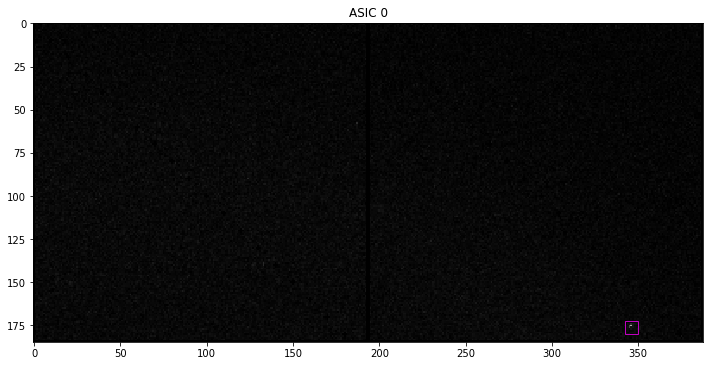

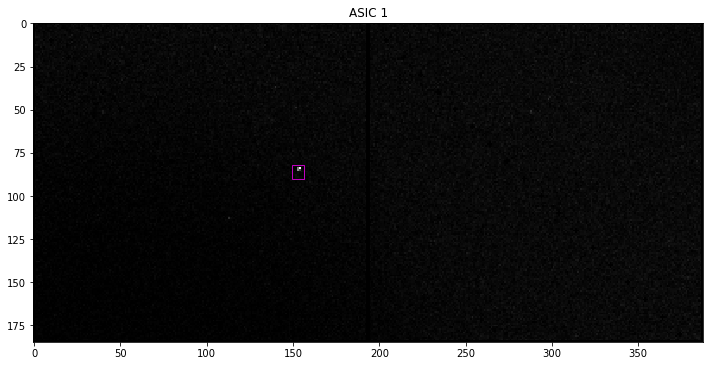

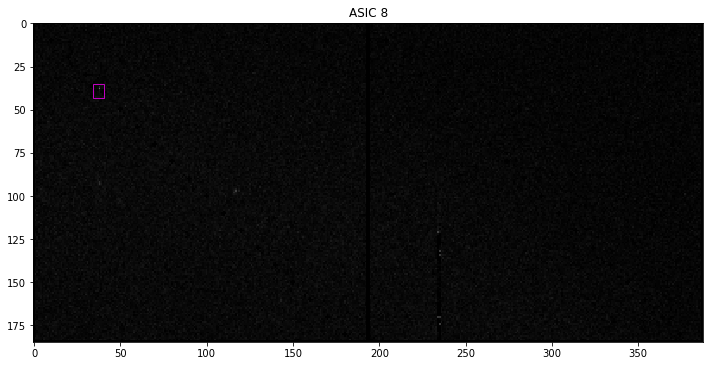

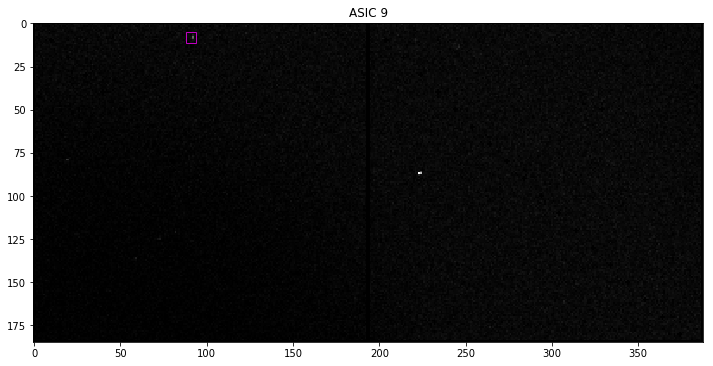

In [80]:
visualize(imgs, labels, results, plot_label=False, plot_box=True, vmax=5000,
          indexes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [ ]:
a, b, c, d = build_dataset( filename, dev_size = 1, total_size=10 )